In [1]:
import numpy as np

# Generic replay buffer for standard gym tasks
class TaskBuffer(object):
    def __init__(self, state_shape, sf_dim, buffer_size, device):
        self.max_size = int(buffer_size)
        self.device = device

        self.ptr = 0
        self.crt_size = 0

        self.state = np.zeros((self.max_size, *state_shape))
        self.action = np.zeros((self.max_size, 1))
        self.next_state = np.zeros((self.max_size, *state_shape))
        # self.next_state = np.array(self.state)
        self.reward = np.zeros((self.max_size, 1))
        self.not_done = np.zeros((self.max_size, 1))
        self.task = np.zeros((self.max_size, sf_dim))


    def add(self, state, action, next_state, reward, done, task):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done
        self.task[self.ptr] = task

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self, batch_size=32):
        ind = np.random.randint(0, self.crt_size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.LongTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
            torch.FloatTensor(self.task[ind]).to(self.device),
        )


    def save(self, save_folder):
        np.save(f"{save_folder}_state.npy", self.state[:self.crt_size])
        np.save(f"{save_folder}_action.npy", self.action[:self.crt_size])
        np.save(f"{save_folder}_next_state.npy", self.next_state[:self.crt_size])
        np.save(f"{save_folder}_reward.npy", self.reward[:self.crt_size])
        np.save(f"{save_folder}_not_done.npy", self.not_done[:self.crt_size])
        np.save(f"{save_folder}_task.npy", self.task[:self.crt_size])
        np.save(f"{save_folder}_ptr.npy", self.ptr)


    def load(self, save_folder, size=-1):
        reward_buffer = np.load(f"{save_folder}_reward.npy")

        # Adjust crt_size if we're using a custom size
        size = min(int(size), self.max_size) if size > 0 else self.max_size
        self.crt_size = min(reward_buffer.shape[0], size)

        self.state[:self.crt_size] = np.load(f"{save_folder}_state.npy")[:self.crt_size]
        self.action[:self.crt_size] = np.load(f"{save_folder}_action.npy")[:self.crt_size]
        self.next_state[:self.crt_size] = np.load(f"{save_folder}_next_state.npy")[:self.crt_size]
        self.reward[:self.crt_size] = reward_buffer[:self.crt_size]
        self.not_done[:self.crt_size] = np.load(f"{save_folder}_not_done.npy")[:self.crt_size]
        self.task[:self.crt_size] = np.load(f"{save_folder}_task.npy")[:self.crt_size]
        print(f"Replay Buffer loaded with {self.crt_size} elements.")

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import copy
from tqdm import tqdm
from dqn import DQN, Phi, Critic, ConvEncoder

class RMS(object):
    """running mean and std """
    def __init__(self, device, epsilon=1e-4, shape=(1,)):
        self.M = torch.zeros(shape).to(device)
        self.S = torch.ones(shape).to(device)
        self.n = epsilon

    def __call__(self, x):
        bs = x.size(0)
        delta = torch.mean(x, dim=0) - self.M
        new_M = self.M + delta * bs / (self.n + bs)
        new_S = (self.S * self.n + torch.var(x, dim=0) * bs +
                 torch.square(delta) * self.n * bs /
                 (self.n + bs)) / (self.n + bs)

        self.M = new_M
        self.S = new_S
        self.n += bs

        return self.M, self.S
    
class PBE(object):
    """particle-based entropy based on knn normalized by running mean """
    def __init__(self, rms, knn_clip, knn_k, knn_avg, knn_rms, device):
        self.rms = rms
        self.knn_rms = knn_rms
        self.knn_k = knn_k
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.device = device

    def __call__(self, rep):
        source = target = rep
        b1, b2 = source.size(0), target.size(0)
        # (b1, 1, c) - (1, b2, c) -> (b1, 1, c) - (1, b2, c) -> (b1, b2, c) -> (b1, b2)
        sim_matrix = torch.norm(source[:, None, :].view(b1, 1, -1) -
                                target[None, :, :].view(1, b2, -1),
                                dim=-1,
                                p=2)
        reward, _ = sim_matrix.topk(self.knn_k,
                                    dim=1,
                                    largest=False,
                                    sorted=True)  # (b1, k)
        if not self.knn_avg:  # only keep k-th nearest neighbor
            reward = reward[:, -1]
            reward = reward.reshape(-1, 1)  # (b1, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(self.device)
            ) if self.knn_clip >= 0.0 else reward  # (b1, 1)
        else:  # average over all k nearest neighbors
            reward = reward.reshape(-1, 1)  # (b1 * k, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(
                    self.device)) if self.knn_clip >= 0.0 else reward
            reward = reward.reshape((b1, self.knn_k))  # (b1, k)
            reward = reward.mean(dim=1, keepdim=True)  # (b1, 1)
        reward = torch.log(reward + 1.0)
        return reward
    
    
class IdentityPhi(nn.Module):
    def __init__(
        self,
        latent_dim,
        hidden_dim,
        sf_dim,
    ):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, latent, norm=True):
        return F.normalize(latent, dim=-1)
    
class IdentityEncoder(nn.Module):
    def __init__(
        self,
        state_shape,
        latent_dim,
    ):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, state):
        return state

class GridAPS(DQN):
    def __init__(
        self,
        env,
        conv=True,
        discount=0.99,
        lr_critic=1e-4,
        lr_encoder=1e-4, 
        latent_dim=256,
        hidden_dim=256,
        initial_eps=1,
        end_eps=0.1,
        eval_eps=0.1,
        pretrain_eps=1,
        eps_decay_period=int(2e4),
        target_update_frequency=200,
        double_q=False,
        # the following are variables for APS
        sf_dim=169,
        lr_phi=1e-4,
        lr_task=1e-4,
        update_task_frequency=5,
        knn_k=12,
        knn_rms=True,
        knn_avg=True,
        knn_clip=1e-4,
    ):
        # for APS 
        self.sf_dim = sf_dim
        self.lr_phi = lr_phi
        self.lr_task = lr_task
        self.update_task_frequency = update_task_frequency
        self.knn_k = knn_k
        self.knn_rms = knn_rms
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.temp_task = None # temp tasks are set through function : set_task
        
        super().__init__(
            env=env,
            conv=conv,
            discount=discount,
            lr_critic=lr_critic,
            lr_encoder=lr_encoder,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            initial_eps=initial_eps,
            end_eps=end_eps,
            eval_eps=eval_eps,
            pretrain_eps=pretrain_eps,
            eps_decay_period=eps_decay_period,
            target_update_frequency=target_update_frequency,
            double_q=double_q,
        )
        
    def _make_alias(self):
        self.SF1 = self.critic.get_SF1
        self.SF = self.critic.get_SFs
        self.SF1_target = self.critic_target.get_SF1
        self.SF_target = self.critic_target.get_SFs
        
        # to get Q's, one need 'task' (a k-dim vector)
        self.Q1 = self.critic.get_Q1
        self.Q = self.critic.get_Qs
        self.Q1_target = self.critic_target.get_Q1
        self.Q_target = self.critic_target.get_Qs
        
    def _define_networks(self):
        self.encoder = ConvEncoder(
            state_shape=self.state_shape,
            latent_dim=self.latent_dim,
        )
        
        self.phi = Phi(
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            sf_dim=self.sf_dim,
        )

        
        self.critic = Critic(
            latent_dim=self.latent_dim + self.sf_dim, # input is cat([latent, task])
            hidden_dim=self.hidden_dim, 
            num_actions=self.num_actions,
            sf_dim=self.sf_dim
        )
        self.critic_target = copy.deepcopy(self.critic)
        
        self.RMS = RMS(self.device)
        self.PBE = PBE(
            rms=self.RMS, 
            knn_clip=self.knn_clip, 
            knn_k=self.knn_k, 
            knn_avg=self.knn_avg, 
            knn_rms=self.knn_rms,
            device=self.device
        )
        
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters(), lr=self.lr_encoder)
        self.phi_opt = torch.optim.Adam(self.phi.parameters(), lr=self.lr_phi)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
        self.task_learned = True
        self.task = torch.ones((1, self.sf_dim), requires_grad=True, device=self.device) # task is only for RL phase (supervised learning phase)
        self.task_opt = torch.optim.Adam([self.task], lr=self.lr_task)
        
    def set_fine_tuning(self):
        del self.phi_opt
        del self.encoder_opt
        del self.critic_opt
        
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        
    def intrinsic_reward(self, task, next_latent):
        # maxent reward
        with torch.no_grad():
            state_representation = self.phi(next_latent, norm=False)
        bonus = self.PBE(state_representation)
        ent_bonus = bonus.view(-1, 1)

        # successor feature reward
        state_representation = state_representation / torch.norm(state_representation, dim=1, keepdim=True)
        sf_reward = torch.einsum("bi,bi->b", task, state_representation).reshape(-1, 1)

        return ent_bonus, sf_reward
    
    def maybe_set_task(self, fine_tune):
        if fine_tune:
            return self.task
        elif (self.iterations + 1) % self.update_task_frequency:
            return self.set_task()
        
        return self.temp_task
    
    def set_task(self):
        # print('switching_task!')
        task = torch.randn(self.sf_dim).to(self.device)
        task = task / torch.norm(task)
        self.temp_task = task
        return task
    
    def visualize_representation(self, state):
        # state needs to be a numpy array
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        out = self.phi(self.encoder(state))
        return out.cpu().data.numpy()
    
    def make_replay_buffer(self, buffer_size=int(3e5)):
        return TaskBuffer(self.state_shape, self.sf_dim, buffer_size, self.device)
        
    def select_action(self, state, task, eval=False, pretrain=True):
        # this function affects evaluation funciton
        if eval: # if eval, we don't care if we are pretraining or not
            eps = self.eval_eps
        elif pretrain: # if pretrain, we use pretrain eps
            eps = self.pretrain_eps
        else:
            eps = max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        # Select action according to policy with probability (1-eps)
        # otherwise, select random action
        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).reshape(self.state_shape).unsqueeze(0).to(self.device)                    
                if type(task) == np.ndarray:
                    task = torch.from_numpy(task).to(self.device)
                task = task.float().view(1, task.shape[-1])
                
                latent = self.encoder(state)
                
                # cat latent and task for universal successor feature
                # print(latent.shape, task.shape)
                latent = torch.cat([latent, task], dim=1)
                return int(self.Q1(latent, task).argmax(1))
        else:
            return np.random.randint(self.num_actions)
    
    def train(self, replay_buffer, batch_size=128, fine_tune=False):
        state, action, next_state, reward, not_done, task = replay_buffer.sample(batch_size=batch_size)
        
        latent = self.encoder(state)
        next_latent = self.encoder(next_state)
        
        # calculate the adjusted reward
        if fine_tune:
            reward = reward # even when we are finetuning, use the task got from the replay_buffer
            # task = self.task.repeat(batch_size, 1) # use the regressed task
        else:
            with torch.no_grad():
                ent_bonus, sf_reward = self.intrinsic_reward(task, next_latent)
                aps_reward = ent_bonus + sf_reward
                reward = aps_reward
            # calculte Phi-loss
            phi_loss = - torch.einsum("bi,bi->b", self.phi(next_latent), task).mean()
#             print(phi_loss.requires_grad)
#             print(self.phi.parameters()[0].requires_grad)

            # update Phi and Encoder
            self.encoder_opt.zero_grad()
            self.phi_opt.zero_grad()
            phi_loss.backward()
            self.encoder_opt.step()
            self.phi_opt.step()
        
        
        # cat latent and task, for universal SF approximator
        # we don't update encoder based on Q-loss
        latent = torch.cat([latent, task], dim=1).detach()
        next_latent = torch.cat([next_latent, task], dim=1).detach()
        
        # calculate Q-loss
        with torch.no_grad():
            next_action = self.Q1(next_latent, task).argmax(1, keepdim=True)
            if self.double_q:
                target_Q1, target_Q2 = self.Q_target(next_latent, task)
                target_Q1, target_Q2 = (
                    target_Q1.gather(1, next_action).view(-1, 1),
                    target_Q2.gather(1, next_action).view(-1, 1)
                )
                target_Q = torch.min(target_Q1, target_Q2)
            else:
                target_Q = self.Q1_target(next_latent, task).gather(1, next_action).view(-1, 1)
            
            # print(f'reward : {reward}, not_done : {not_done}, next_action :{next_action}, target_Q : {target_Q}')
            target_Q = reward + not_done * self.discount * target_Q
            
        
        if self.double_q:
            Q1, Q2 = self.Q(latent, task)
            Q1, Q2 = (
                Q1.gather(1, action).view(-1, 1),
                Q2.gather(1, action).view(-1, 1)
            )
            
            Q_loss = F.mse_loss(Q1, target_Q) + F.mse_loss(Q2, target_Q)
        else:
            Q = self.Q1(latent, task).gather(1, action).view(-1, 1)
            Q_loss = F.mse_loss(Q, target_Q)
        
        # update Q-networks
        # print(f'Q-loss : {Q_loss}, Q : {Q}, Q_target : {target_Q}')
        # print(Q_loss.mean())
        self.critic_opt.zero_grad()
        Q_loss.backward()
        self.critic_opt.step()
        
        # train the task
        # self.regress_task(replay_buffer, 256, 1)
        # self.maybe_regress_task(replay_buffer, 256, 1)
        
        # update target network
        self.copy_target_update()
        
    def maybe_regress_task(self, replay_buffer, batch_size, epoch_size=1):
        if replay_buffer.crt_size > 4096 and self.iterations % self.update_task_frequency == 0:
            self.regress_task(replay_buffer, batch_size, epoch_size)
        
    def regress_task(self, replay_buffer, batch_size=32, epoch_size=1):
        # there are two options, one is using gradient descent, the other is using torch.linalg.lstsq
        self.task_learned = True
        for epoch in range(epoch_size):
            state, action, next_state, reward, *_ = replay_buffer.sample(batch_size=batch_size)
            with torch.no_grad():
                next_latent = self.encoder(next_state)
                # next_latent = self.encoder(state)
                representation = self.phi(next_latent)
                
            # estimate the reward
            estimated_reward = torch.einsum("bi,bi->b", representation, self.task.repeat(batch_size, 1)) # 256 by 169, 1 by 169
            
            # update the task
            task_loss = F.mse_loss(reward, estimated_reward)
            self.task_opt.zero_grad()
            task_loss.backward()
            self.task_opt.step()
            
    def regress_task_lstsq(self, replay_buffer):
        obs, reward = [], []
        batch_size = 0
        while batch_size < int(1e5):
            _, _, batch_obs, batch_reward, *_ = replay_buffer.sample(256)
            obs.append(batch_obs)
            reward.append(batch_reward)
            batch_size += batch_obs.size(0)
        obs, reward = torch.cat(obs, 0), torch.cat(reward, 0)

        obs = self.encoder(obs)
        rep = self.phi(obs)
        print(rep.shape, reward.shape)
        task = torch.linalg.lstsq(reward, rep)[0][:rep.size(1), :][0]
        task = task / torch.norm(task)
#         task = task.cpu().numpy()
#         meta = OrderedDict()
#         meta['task'] = task

        # save for evaluation
        self.task = task
                
    def learn(self, replay_buffer, step_size, learning_start=int(1e4), batch_size=32, fine_tune=False, log_freq=int(1e3)):
        if replay_buffer is None:
            replay_buffer = self.make_replay_buffer()
            
        state = self.env.reset()
        episodic_return = 0
        episode_length = 0
        episode_num = 0
        task = self.set_task()
        evaluations = []
        
        for step in tqdm(range(step_size)):
            self.iterations += 1
            # pick action and transit in the env
            task = self.maybe_set_task(fine_tune)
            if step < learning_start:
                action = self.env.action_space.sample()
            else:
                action = self.select_action(state, task, eval=False, pretrain=(not fine_tune))
            next_state, reward, done, info = self.env.step(action)
            
            # add the experience into the buffer
            replay_buffer.add(state, action, next_state, reward, done, task.cpu().data.numpy())
            if replay_buffer.crt_size > learning_start:
                self.train(replay_buffer, batch_size=batch_size, fine_tune=fine_tune)
            
            # update iterative values
            state = next_state
            episodic_return += reward
            episode_length += 1
            
            # maybe evaluate
            if fine_tune and (step + 1) % log_freq == 0:
                evaluations.append(self.evaluate(fine_tune))
            
            # check if the episode ends
            if done:
                if fine_tune:
                    print(f"====== Total T: {step+1} Episode Num: {episode_num+1} Episode_Length T: {episode_length} Return: {episodic_return:.3f} ======")
                episode_num += 1
                state = self.env.reset()
                episodic_return = 0
                episode_length = 0
                
        return evaluations
    
    def evaluate(self, fine_tune, seed=0, eval_episodes=10):
        eval_env = copy.deepcopy(self.env)
        eval_env.seed(seed + 100)

        avg_reward = 0.
        task = self.maybe_set_task(fine_tune)
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            while not done:
                action = self.select_action(np.array(state), task, eval=True)
                state, reward, done, _ = eval_env.step(action)
                avg_reward += reward

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward
    
    def save(self):
        critic_filename = f'4rooms-models/{self.env_name}-{self.update_task_frequency}-{self.separate_encoder}-critic.p'
        encoder_phi_filename = f'4rooms-models/{self.env_name}-{self.update_task_frequency}{self.separate_encoder}-encoder-phi.p'
        phi_filename = f'4rooms-models/{self.env_name}-{self.update_task_frequency}{self.separate_encoder}-phi.p'
        with open(critic_filename, 'wb') as f:
            pickle.dump(self.critic, f)
        with open(encoder_phi_filename, 'wb') as f:
            pickle.dump(self.encoder, f)
        with open(phi_filename, 'wb') as f:
            pickle.dump(self.phi, f)
            
    
    def load(self, filename):
        critic_filename = f'4rooms-models/{filename}-critic.p'
        encoder_phi_filename = f'4rooms-models/{filename}-encoder-phi.p'
        phi_filename = f'4rooms-models/{filename}-phi.p'
        with open(critic_filename, 'rb') as f:
            self.critic = pickle.load(f)
            self.critic_target = copy.deepcopy(self.critic)
        with open(encoder_phi_filename, 'rb') as f:
            self.encoder = pickle.load(f)
        with open(phi_filename, 'rb') as f:
            self.phi = pickle.load(f)

In [51]:
from fourrooms import FourRooms
env = FourRooms(config=2, layout='4rooms')
aps1 = GridAPS(
    env, 
    conv=True,
    pretrain_eps=0.2,
    eps_decay_period=int(2e3),
    double_q=False,
    sf_dim=4,
    latent_dim=169,
    update_task_frequency=5,
    target_update_frequency=100,
)

ft_rp1 = aps1.make_replay_buffer()
evaluations = aps1.learn(
    ft_rp1,
    step_size=int(1e5),
    learning_start=int(1e3),
    batch_size=32,
    fine_tune=False
)

100%|██████████| 100000/100000 [11:59<00:00, 139.08it/s]


In [53]:
aps1.set_fine_tuning()

In [52]:
aps1.regress_task_lstsq(ft_rp1)

torch.Size([100096, 4]) torch.Size([100096, 1])


In [54]:
ft_rp = aps1.make_replay_buffer()
evaluations = aps1.learn(
    ft_rp,
    step_size=int(2e5),
    learning_start=int(1e3),
    batch_size=32,
    fine_tune=True
)

  0%|          | 0/200000 [00:00<?, ?it/s]

====== Total T: 115 Episode Num: 1 Episode_Length T: 115 Return: -114.000 ======
====== Total T: 315 Episode Num: 2 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 511 Episode Num: 3 Episode_Length T: 196 Return: -195.000 ======
====== Total T: 525 Episode Num: 4 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 527 Episode Num: 5 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 532 Episode Num: 6 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 732 Episode Num: 7 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 785 Episode Num: 8 Episode_Length T: 53 Return: -52.000 ======
====== Total T: 858 Episode Num: 9 Episode_Length T: 73 Return: -72.000 ======


  0%|          | 1000/200000 [00:01<03:25, 967.29it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------
====== Total T: 1058 Episode Num: 10 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1323/200000 [00:02<06:56, 477.06it/s]

====== Total T: 1258 Episode Num: 11 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1497/200000 [00:02<09:04, 364.86it/s]

====== Total T: 1458 Episode Num: 12 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1698/200000 [00:03<09:56, 332.69it/s]

====== Total T: 1658 Episode Num: 13 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1897/200000 [00:03<10:04, 327.62it/s]

====== Total T: 1858 Episode Num: 14 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 2066/200000 [00:05<29:58, 110.05it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------
====== Total T: 2058 Episode Num: 15 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 2300/200000 [00:05<11:39, 282.70it/s]

====== Total T: 2258 Episode Num: 16 Episode_Length T: 200 Return: -200.000 ======


  1%|▏         | 2500/200000 [00:06<10:14, 321.52it/s]

====== Total T: 2458 Episode Num: 17 Episode_Length T: 200 Return: -200.000 ======


  1%|▏         | 2703/200000 [00:07<09:57, 330.16it/s]

====== Total T: 2658 Episode Num: 18 Episode_Length T: 200 Return: -200.000 ======


  1%|▏         | 2907/200000 [00:07<09:55, 330.71it/s]

====== Total T: 2858 Episode Num: 19 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3043/200000 [00:09<29:46, 110.23it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------
====== Total T: 3058 Episode Num: 20 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3311/200000 [00:09<11:05, 295.61it/s]

====== Total T: 3258 Episode Num: 21 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3513/200000 [00:10<10:02, 326.11it/s]

====== Total T: 3458 Episode Num: 22 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3717/200000 [00:11<09:57, 328.76it/s]

====== Total T: 3658 Episode Num: 23 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3904/200000 [00:11<12:25, 263.08it/s]

====== Total T: 3858 Episode Num: 24 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4034/200000 [00:13<38:32, 84.75it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  2%|▏         | 4083/200000 [00:13<26:15, 124.37it/s]

====== Total T: 4058 Episode Num: 25 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4305/200000 [00:14<14:02, 232.15it/s]

====== Total T: 4258 Episode Num: 26 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4505/200000 [00:15<13:31, 240.80it/s]

====== Total T: 4458 Episode Num: 27 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4680/200000 [00:16<13:26, 242.15it/s]

====== Total T: 4658 Episode Num: 28 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4898/200000 [00:17<13:47, 235.88it/s]

====== Total T: 4858 Episode Num: 29 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5042/200000 [00:18<38:36, 84.15it/s] 

---------------------------------------
Evaluation over 10 episodes: -181.000
---------------------------------------


  3%|▎         | 5089/200000 [00:18<26:04, 124.61it/s]

====== Total T: 5058 Episode Num: 30 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5283/200000 [00:19<14:27, 224.43it/s]

====== Total T: 5258 Episode Num: 31 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 5278 Episode Num: 32 Episode_Length T: 20 Return: -19.000 ======


  3%|▎         | 5503/200000 [00:20<13:31, 239.62it/s]

====== Total T: 5478 Episode Num: 33 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5726/200000 [00:21<13:34, 238.59it/s]

====== Total T: 5678 Episode Num: 34 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5919/200000 [00:22<13:36, 237.75it/s]

====== Total T: 5878 Episode Num: 35 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6040/200000 [00:23<40:45, 79.33it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  3%|▎         | 6114/200000 [00:23<22:36, 142.94it/s]

====== Total T: 6078 Episode Num: 36 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6308/200000 [00:24<14:05, 229.00it/s]

====== Total T: 6278 Episode Num: 37 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6503/200000 [00:25<13:34, 237.46it/s]

====== Total T: 6478 Episode Num: 38 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6721/200000 [00:26<13:40, 235.61it/s]

====== Total T: 6678 Episode Num: 39 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6915/200000 [00:27<13:33, 237.29it/s]

====== Total T: 6878 Episode Num: 40 Episode_Length T: 200 Return: -200.000 ======


  4%|▎         | 7035/200000 [00:28<40:40, 79.06it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  4%|▎         | 7111/200000 [00:29<22:18, 144.16it/s]

====== Total T: 7078 Episode Num: 41 Episode_Length T: 200 Return: -200.000 ======


  4%|▎         | 7311/200000 [00:29<13:51, 231.74it/s]

====== Total T: 7278 Episode Num: 42 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 7506/200000 [00:30<13:32, 236.89it/s]

====== Total T: 7478 Episode Num: 43 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 7702/200000 [00:31<13:31, 237.10it/s]

====== Total T: 7678 Episode Num: 44 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 7925/200000 [00:32<13:18, 240.48it/s]

====== Total T: 7878 Episode Num: 45 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 8025/200000 [00:33<39:31, 80.96it/s] 

---------------------------------------
Evaluation over 10 episodes: -199.200
---------------------------------------


  4%|▍         | 8124/200000 [00:34<19:32, 163.61it/s]

====== Total T: 8078 Episode Num: 46 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 8318/200000 [00:35<13:53, 230.05it/s]

====== Total T: 8278 Episode Num: 47 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 8511/200000 [00:35<13:40, 233.50it/s]

====== Total T: 8478 Episode Num: 48 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 8656/200000 [00:36<13:25, 237.54it/s]

====== Total T: 8608 Episode Num: 49 Episode_Length T: 130 Return: -129.000 ======


  4%|▍         | 8852/200000 [00:37<13:16, 239.95it/s]

====== Total T: 8808 Episode Num: 50 Episode_Length T: 200 Return: -200.000 ======


  5%|▍         | 9024/200000 [00:38<35:44, 89.04it/s] 

---------------------------------------
Evaluation over 10 episodes: -168.700
---------------------------------------
====== Total T: 9008 Episode Num: 51 Episode_Length T: 200 Return: -200.000 ======


  5%|▍         | 9246/200000 [00:39<14:10, 224.17it/s]

====== Total T: 9208 Episode Num: 52 Episode_Length T: 200 Return: -200.000 ======


  5%|▍         | 9318/200000 [00:40<13:43, 231.64it/s]

====== Total T: 9279 Episode Num: 53 Episode_Length T: 71 Return: -70.000 ======


  5%|▍         | 9511/200000 [00:40<13:26, 236.13it/s]

====== Total T: 9479 Episode Num: 54 Episode_Length T: 200 Return: -200.000 ======


  5%|▍         | 9607/200000 [00:41<13:28, 235.38it/s]

====== Total T: 9569 Episode Num: 55 Episode_Length T: 90 Return: -89.000 ======


  5%|▍         | 9804/200000 [00:42<13:12, 239.91it/s]

====== Total T: 9769 Episode Num: 56 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 9791 Episode Num: 57 Episode_Length T: 22 Return: -21.000 ======


  5%|▍         | 9976/200000 [00:42<13:15, 238.82it/s]

====== Total T: 9991 Episode Num: 58 Episode_Length T: 200 Return: -200.000 ======


  5%|▌         | 10024/200000 [00:44<39:42, 79.74it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  5%|▌         | 10218/200000 [00:44<14:40, 215.50it/s]

====== Total T: 10191 Episode Num: 59 Episode_Length T: 200 Return: -200.000 ======


  5%|▌         | 10420/200000 [00:45<13:05, 241.27it/s]

====== Total T: 10391 Episode Num: 60 Episode_Length T: 200 Return: -200.000 ======


  5%|▌         | 10623/200000 [00:46<12:41, 248.75it/s]

====== Total T: 10591 Episode Num: 61 Episode_Length T: 200 Return: -200.000 ======


  5%|▌         | 10824/200000 [00:47<12:44, 247.54it/s]

====== Total T: 10791 Episode Num: 62 Episode_Length T: 200 Return: -200.000 ======


  5%|▌         | 10979/200000 [00:47<12:36, 249.93it/s]

====== Total T: 10991 Episode Num: 63 Episode_Length T: 200 Return: -200.000 ======


  6%|▌         | 11030/200000 [00:49<37:23, 84.23it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  6%|▌         | 11231/200000 [00:49<14:07, 222.67it/s]

====== Total T: 11191 Episode Num: 64 Episode_Length T: 200 Return: -200.000 ======


  6%|▌         | 11433/200000 [00:50<12:56, 242.77it/s]

====== Total T: 11391 Episode Num: 65 Episode_Length T: 200 Return: -200.000 ======


  6%|▌         | 11633/200000 [00:51<12:47, 245.32it/s]

====== Total T: 11591 Episode Num: 66 Episode_Length T: 200 Return: -200.000 ======


  6%|▌         | 11839/200000 [00:52<12:27, 251.75it/s]

====== Total T: 11791 Episode Num: 67 Episode_Length T: 200 Return: -200.000 ======


  6%|▌         | 11992/200000 [00:53<12:45, 245.47it/s]

====== Total T: 11991 Episode Num: 68 Episode_Length T: 200 Return: -200.000 ======


  6%|▌         | 12043/200000 [00:54<36:42, 85.35it/s] 

---------------------------------------
Evaluation over 10 episodes: -192.900
---------------------------------------


  6%|▌         | 12217/200000 [00:54<14:49, 211.10it/s]

====== Total T: 12191 Episode Num: 69 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 12220 Episode Num: 70 Episode_Length T: 29 Return: -28.000 ======


  6%|▌         | 12469/200000 [00:55<12:40, 246.49it/s]

====== Total T: 12420 Episode Num: 71 Episode_Length T: 200 Return: -200.000 ======


  6%|▋         | 12648/200000 [00:56<12:29, 249.91it/s]

====== Total T: 12620 Episode Num: 72 Episode_Length T: 200 Return: -200.000 ======


  6%|▋         | 12850/200000 [00:57<12:40, 246.04it/s]

====== Total T: 12820 Episode Num: 73 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 13030/200000 [00:59<37:15, 83.62it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------
====== Total T: 13020 Episode Num: 74 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 13256/200000 [00:59<11:22, 273.43it/s]

====== Total T: 13220 Episode Num: 75 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 13458/200000 [01:00<09:38, 322.23it/s]

====== Total T: 13420 Episode Num: 76 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 13659/200000 [01:01<09:25, 329.75it/s]

====== Total T: 13620 Episode Num: 77 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 13859/200000 [01:01<10:43, 289.11it/s]

====== Total T: 13820 Episode Num: 78 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 14044/200000 [01:03<38:01, 81.49it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------
====== Total T: 14020 Episode Num: 79 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 14261/200000 [01:04<14:17, 216.72it/s]

====== Total T: 14220 Episode Num: 80 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 14456/200000 [01:05<12:57, 238.74it/s]

====== Total T: 14420 Episode Num: 81 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 14655/200000 [01:06<12:54, 239.33it/s]

====== Total T: 14620 Episode Num: 82 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 14852/200000 [01:06<12:49, 240.54it/s]

====== Total T: 14820 Episode Num: 83 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 15023/200000 [01:08<50:47, 60.70it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------
====== Total T: 15020 Episode Num: 84 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 15270/200000 [01:09<13:27, 228.83it/s]

====== Total T: 15220 Episode Num: 85 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 15465/200000 [01:10<13:01, 236.12it/s]

====== Total T: 15420 Episode Num: 86 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 15663/200000 [01:11<12:55, 237.84it/s]

====== Total T: 15620 Episode Num: 87 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 15856/200000 [01:12<13:01, 235.51it/s]

====== Total T: 15820 Episode Num: 88 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 16027/200000 [01:13<37:49, 81.05it/s] 

---------------------------------------
Evaluation over 10 episodes: -197.500
---------------------------------------
====== Total T: 16020 Episode Num: 89 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 16126/200000 [01:14<18:42, 163.77it/s]

====== Total T: 16097 Episode Num: 90 Episode_Length T: 77 Return: -76.000 ======


  8%|▊         | 16326/200000 [01:15<12:53, 237.31it/s]

====== Total T: 16297 Episode Num: 91 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 16526/200000 [01:15<12:38, 241.74it/s]

====== Total T: 16497 Episode Num: 92 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 16726/200000 [01:16<12:37, 241.88it/s]

====== Total T: 16697 Episode Num: 93 Episode_Length T: 200 Return: -200.000 ======


  8%|▊         | 16926/200000 [01:17<12:33, 242.91it/s]

====== Total T: 16897 Episode Num: 94 Episode_Length T: 200 Return: -200.000 ======


  9%|▊         | 17026/200000 [01:18<37:18, 81.73it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  9%|▊         | 17128/200000 [01:19<18:19, 166.31it/s]

====== Total T: 17087 Episode Num: 95 Episode_Length T: 190 Return: -189.000 ======


  9%|▊         | 17315/200000 [01:20<13:44, 221.45it/s]

====== Total T: 17287 Episode Num: 96 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 17534/200000 [01:21<12:51, 236.36it/s]

====== Total T: 17487 Episode Num: 97 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 17727/200000 [01:21<12:50, 236.42it/s]

====== Total T: 17687 Episode Num: 98 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 17919/200000 [01:22<13:11, 230.03it/s]

====== Total T: 17887 Episode Num: 99 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 18039/200000 [01:24<38:33, 78.67it/s] 

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  9%|▉         | 18134/200000 [01:24<19:02, 159.18it/s]

====== Total T: 18087 Episode Num: 100 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 18327/200000 [01:25<13:10, 229.68it/s]

====== Total T: 18287 Episode Num: 101 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 18520/200000 [01:26<12:46, 236.88it/s]

====== Total T: 18487 Episode Num: 102 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 18713/200000 [01:27<12:44, 237.28it/s]

====== Total T: 18687 Episode Num: 103 Episode_Length T: 200 Return: -200.000 ======


  9%|▉         | 18931/200000 [01:27<12:45, 236.43it/s]

====== Total T: 18887 Episode Num: 104 Episode_Length T: 200 Return: -200.000 ======


 10%|▉         | 19028/200000 [01:29<32:33, 92.65it/s] 

---------------------------------------
Evaluation over 10 episodes: -154.800
---------------------------------------


 10%|▉         | 19125/200000 [01:29<17:25, 172.97it/s]

====== Total T: 19087 Episode Num: 105 Episode_Length T: 200 Return: -200.000 ======


 10%|▉         | 19198/200000 [01:29<14:17, 210.77it/s]

====== Total T: 19174 Episode Num: 106 Episode_Length T: 87 Return: -86.000 ======
====== Total T: 19176 Episode Num: 107 Episode_Length T: 2 Return: -1.000 ======


 10%|▉         | 19417/200000 [01:30<12:48, 234.98it/s]

====== Total T: 19376 Episode Num: 108 Episode_Length T: 200 Return: -200.000 ======


 10%|▉         | 19613/200000 [01:31<12:43, 236.27it/s]

====== Total T: 19576 Episode Num: 109 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 19582 Episode Num: 110 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 19585 Episode Num: 111 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 19595 Episode Num: 112 Episode_Length T: 10 Return: -9.000 ======


 10%|▉         | 19835/200000 [01:32<12:24, 242.08it/s]

====== Total T: 19795 Episode Num: 113 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 19804 Episode Num: 114 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 19809 Episode Num: 115 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 19810 Episode Num: 116 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 19819 Episode Num: 117 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 19825 Episode Num: 118 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 19830 Episode Num: 119 Episode_Length T: 5 Return: -4.000 ======


 10%|▉         | 19959/200000 [01:33<12:33, 238.89it/s]

====== Total T: 19920 Episode Num: 120 Episode_Length T: 90 Return: -89.000 ======
====== Total T: 19925 Episode Num: 121 Episode_Length T: 5 Return: -4.000 ======


 10%|▉         | 19983/200000 [01:33<12:37, 237.56it/s]

====== Total T: 19972 Episode Num: 122 Episode_Length T: 47 Return: -46.000 ======
====== Total T: 19974 Episode Num: 123 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 19979 Episode Num: 124 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 19980 Episode Num: 125 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 19986 Episode Num: 126 Episode_Length T: 6 Return: -5.000 ======


 10%|█         | 20031/200000 [01:33<18:57, 158.17it/s]

---------------------------------------
Evaluation over 10 episodes: -49.200
---------------------------------------
====== Total T: 20012 Episode Num: 127 Episode_Length T: 26 Return: -25.000 ======


 10%|█         | 20105/200000 [01:33<14:28, 207.19it/s]

====== Total T: 20060 Episode Num: 128 Episode_Length T: 48 Return: -47.000 ======
====== Total T: 20065 Episode Num: 129 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 20070 Episode Num: 130 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 20073 Episode Num: 131 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20076 Episode Num: 132 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20088 Episode Num: 133 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 20108 Episode Num: 134 Episode_Length T: 20 Return: -19.000 ======


 10%|█         | 20153/200000 [01:34<13:34, 220.86it/s]

====== Total T: 20112 Episode Num: 135 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 20119 Episode Num: 136 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 20156 Episode Num: 137 Episode_Length T: 37 Return: -36.000 ======


 10%|█         | 20203/200000 [01:34<12:53, 232.39it/s]

====== Total T: 20163 Episode Num: 138 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 20204 Episode Num: 139 Episode_Length T: 41 Return: -40.000 ======
====== Total T: 20208 Episode Num: 140 Episode_Length T: 4 Return: -3.000 ======


 10%|█         | 20253/200000 [01:34<12:38, 237.13it/s]

====== Total T: 20216 Episode Num: 141 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 20218 Episode Num: 142 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 20226 Episode Num: 143 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 20229 Episode Num: 144 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20252 Episode Num: 145 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 20261 Episode Num: 146 Episode_Length T: 9 Return: -8.000 ======


 10%|█         | 20303/200000 [01:34<12:32, 238.95it/s]

====== Total T: 20274 Episode Num: 147 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 20283 Episode Num: 148 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 20290 Episode Num: 149 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 20292 Episode Num: 150 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 20301 Episode Num: 151 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 20306 Episode Num: 152 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 20308 Episode Num: 153 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 20317 Episode Num: 154 Episode_Length T: 9 Return: -8.000 ======


 10%|█         | 20378/200000 [01:35<12:26, 240.73it/s]

====== Total T: 20329 Episode Num: 155 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 20333 Episode Num: 156 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 20335 Episode Num: 157 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 20338 Episode Num: 158 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20351 Episode Num: 159 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 20354 Episode Num: 160 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20358 Episode Num: 161 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 20362 Episode Num: 162 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 20366 Episode Num: 163 Episode_Length T: 4 Return: -3.000 ======


 10%|█         | 20477/200000 [01:35<12:28, 239.96it/s]

====== Total T: 20442 Episode Num: 164 Episode_Length T: 76 Return: -75.000 ======
====== Total T: 20455 Episode Num: 165 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 20457 Episode Num: 166 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 20463 Episode Num: 167 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 20467 Episode Num: 168 Episode_Length T: 4 Return: -3.000 ======


 10%|█         | 20652/200000 [01:36<12:21, 241.88it/s]

====== Total T: 20627 Episode Num: 169 Episode_Length T: 160 Return: -159.000 ======
====== Total T: 20635 Episode Num: 170 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 20652 Episode Num: 171 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 20666 Episode Num: 172 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 20676 Episode Num: 173 Episode_Length T: 10 Return: -9.000 ======


 10%|█         | 20727/200000 [01:36<12:22, 241.31it/s]

====== Total T: 20686 Episode Num: 174 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 20698 Episode Num: 175 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 20708 Episode Num: 176 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 20709 Episode Num: 177 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 20723 Episode Num: 178 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 20731 Episode Num: 179 Episode_Length T: 8 Return: -7.000 ======


 10%|█         | 20778/200000 [01:36<12:09, 245.70it/s]

====== Total T: 20740 Episode Num: 180 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 20756 Episode Num: 181 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 20766 Episode Num: 182 Episode_Length T: 10 Return: -9.000 ======


 10%|█         | 20830/200000 [01:36<11:59, 249.09it/s]

====== Total T: 20796 Episode Num: 183 Episode_Length T: 30 Return: -29.000 ======
====== Total T: 20802 Episode Num: 184 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 20811 Episode Num: 185 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 20816 Episode Num: 186 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 20824 Episode Num: 187 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 20835 Episode Num: 188 Episode_Length T: 11 Return: -10.000 ======


 10%|█         | 20881/200000 [01:37<12:00, 248.61it/s]

====== Total T: 20848 Episode Num: 189 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 20853 Episode Num: 190 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 20858 Episode Num: 191 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 20861 Episode Num: 192 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20864 Episode Num: 193 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20868 Episode Num: 194 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 20880 Episode Num: 195 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 20891 Episode Num: 196 Episode_Length T: 11 Return: -10.000 ======


 10%|█         | 20932/200000 [01:37<11:58, 249.34it/s]

====== Total T: 20904 Episode Num: 197 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 20916 Episode Num: 198 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 20919 Episode Num: 199 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 20923 Episode Num: 200 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 20932 Episode Num: 201 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 20940 Episode Num: 202 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 20952 Episode Num: 203 Episode_Length T: 12 Return: -11.000 ======


 10%|█         | 20982/200000 [01:37<12:31, 238.06it/s]

====== Total T: 20968 Episode Num: 204 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 20978 Episode Num: 205 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 20985 Episode Num: 206 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 20998 Episode Num: 207 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------


 11%|█         | 21053/200000 [01:37<13:37, 218.88it/s]

====== Total T: 21007 Episode Num: 208 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21010 Episode Num: 209 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21017 Episode Num: 210 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 21028 Episode Num: 211 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21030 Episode Num: 212 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21041 Episode Num: 213 Episode_Length T: 11 Return: -10.000 ======


 11%|█         | 21101/200000 [01:38<13:09, 226.62it/s]

====== Total T: 21057 Episode Num: 214 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 21066 Episode Num: 215 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21071 Episode Num: 216 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 21077 Episode Num: 217 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 21091 Episode Num: 218 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 21100 Episode Num: 219 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21102 Episode Num: 220 Episode_Length T: 2 Return: -1.000 ======


 11%|█         | 21148/200000 [01:38<13:04, 228.05it/s]

====== Total T: 21106 Episode Num: 221 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21108 Episode Num: 222 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21112 Episode Num: 223 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21120 Episode Num: 224 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21133 Episode Num: 225 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 21136 Episode Num: 226 Episode_Length T: 3 Return: -2.000 ======


 11%|█         | 21195/200000 [01:38<12:59, 229.39it/s]

====== Total T: 21154 Episode Num: 227 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 21159 Episode Num: 228 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 21162 Episode Num: 229 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21180 Episode Num: 230 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 21188 Episode Num: 231 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21190 Episode Num: 232 Episode_Length T: 2 Return: -1.000 ======


 11%|█         | 21242/200000 [01:38<13:05, 227.56it/s]

====== Total T: 21203 Episode Num: 233 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 21209 Episode Num: 234 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 21220 Episode Num: 235 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21224 Episode Num: 236 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21237 Episode Num: 237 Episode_Length T: 13 Return: -12.000 ======


 11%|█         | 21289/200000 [01:38<12:56, 230.19it/s]

====== Total T: 21250 Episode Num: 238 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 21255 Episode Num: 239 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 21259 Episode Num: 240 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21271 Episode Num: 241 Episode_Length T: 12 Return: -11.000 ======


 11%|█         | 21337/200000 [01:39<12:58, 229.62it/s]

====== Total T: 21298 Episode Num: 242 Episode_Length T: 27 Return: -26.000 ======
====== Total T: 21308 Episode Num: 243 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 21317 Episode Num: 244 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21320 Episode Num: 245 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21323 Episode Num: 246 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21330 Episode Num: 247 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 21336 Episode Num: 248 Episode_Length T: 6 Return: -5.000 ======


 11%|█         | 21385/200000 [01:39<12:55, 230.46it/s]

====== Total T: 21346 Episode Num: 249 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 21355 Episode Num: 250 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21358 Episode Num: 251 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21362 Episode Num: 252 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21367 Episode Num: 253 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 21374 Episode Num: 254 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 21383 Episode Num: 255 Episode_Length T: 9 Return: -8.000 ======


 11%|█         | 21433/200000 [01:39<12:51, 231.47it/s]

====== Total T: 21397 Episode Num: 256 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 21399 Episode Num: 257 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21402 Episode Num: 258 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21409 Episode Num: 259 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 21418 Episode Num: 260 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21420 Episode Num: 261 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21426 Episode Num: 262 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 21430 Episode Num: 263 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21441 Episode Num: 264 Episode_Length T: 11 Return: -10.000 ======


 11%|█         | 21481/200000 [01:39<13:06, 227.12it/s]

====== Total T: 21452 Episode Num: 265 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21459 Episode Num: 266 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 21477 Episode Num: 267 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 21479 Episode Num: 268 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21484 Episode Num: 269 Episode_Length T: 5 Return: -4.000 ======


 11%|█         | 21528/200000 [01:39<13:07, 226.54it/s]

====== Total T: 21502 Episode Num: 270 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 21516 Episode Num: 271 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 21521 Episode Num: 272 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 21524 Episode Num: 273 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21535 Episode Num: 274 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21541 Episode Num: 275 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 21542 Episode Num: 276 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 21547 Episode Num: 277 Episode_Length T: 5 Return: -4.000 ======


 11%|█         | 21599/200000 [01:40<12:57, 229.37it/s]

====== Total T: 21556 Episode Num: 278 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21567 Episode Num: 279 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21576 Episode Num: 280 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21584 Episode Num: 281 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21593 Episode Num: 282 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 21602 Episode Num: 283 Episode_Length T: 9 Return: -8.000 ======


 11%|█         | 21646/200000 [01:40<12:53, 230.51it/s]

====== Total T: 21605 Episode Num: 284 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21616 Episode Num: 285 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21633 Episode Num: 286 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 21639 Episode Num: 287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 21648 Episode Num: 288 Episode_Length T: 9 Return: -8.000 ======


 11%|█         | 21694/200000 [01:40<12:44, 233.31it/s]

====== Total T: 21663 Episode Num: 289 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 21671 Episode Num: 290 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21687 Episode Num: 291 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 21695 Episode Num: 292 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21707 Episode Num: 293 Episode_Length T: 12 Return: -11.000 ======


 11%|█         | 21742/200000 [01:40<12:52, 230.66it/s]

====== Total T: 21711 Episode Num: 294 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21713 Episode Num: 295 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21715 Episode Num: 296 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21719 Episode Num: 297 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21725 Episode Num: 298 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 21728 Episode Num: 299 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 21739 Episode Num: 300 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21744 Episode Num: 301 Episode_Length T: 5 Return: -4.000 ======


 11%|█         | 21838/200000 [01:41<12:43, 233.46it/s]

====== Total T: 21799 Episode Num: 302 Episode_Length T: 55 Return: -54.000 ======
====== Total T: 21809 Episode Num: 303 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 21813 Episode Num: 304 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 21824 Episode Num: 305 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21836 Episode Num: 306 Episode_Length T: 12 Return: -11.000 ======


 11%|█         | 21886/200000 [01:41<12:40, 234.09it/s]

====== Total T: 21850 Episode Num: 307 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 21873 Episode Num: 308 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 21884 Episode Num: 309 Episode_Length T: 11 Return: -10.000 ======


 11%|█         | 21934/200000 [01:41<12:51, 230.91it/s]

====== Total T: 21898 Episode Num: 310 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 21915 Episode Num: 311 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 21923 Episode Num: 312 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21936 Episode Num: 313 Episode_Length T: 13 Return: -12.000 ======


 11%|█         | 21982/200000 [01:41<12:46, 232.13it/s]

====== Total T: 21949 Episode Num: 314 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 21957 Episode Num: 315 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 21969 Episode Num: 316 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 21971 Episode Num: 317 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 21982 Episode Num: 318 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 21993 Episode Num: 319 Episode_Length T: 11 Return: -10.000 ======


 11%|█         | 22030/200000 [01:42<14:33, 203.76it/s]

---------------------------------------
Evaluation over 10 episodes: -13.200
---------------------------------------
====== Total T: 22003 Episode Num: 320 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 22012 Episode Num: 321 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 22022 Episode Num: 322 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 22034 Episode Num: 323 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 22038 Episode Num: 324 Episode_Length T: 4 Return: -3.000 ======


 11%|█         | 22104/200000 [01:42<13:04, 226.76it/s]

====== Total T: 22068 Episode Num: 325 Episode_Length T: 30 Return: -29.000 ======
====== Total T: 22084 Episode Num: 326 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 22088 Episode Num: 327 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22102 Episode Num: 328 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22103 Episode Num: 329 Episode_Length T: 1 Return: 0.000 ======


 11%|█         | 22152/200000 [01:42<12:52, 230.29it/s]

====== Total T: 22119 Episode Num: 330 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 22127 Episode Num: 331 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22143 Episode Num: 332 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 22155 Episode Num: 333 Episode_Length T: 12 Return: -11.000 ======


 11%|█         | 22200/200000 [01:42<12:45, 232.36it/s]

====== Total T: 22170 Episode Num: 334 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 22177 Episode Num: 335 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 22186 Episode Num: 336 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 22189 Episode Num: 337 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22196 Episode Num: 338 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 22205 Episode Num: 339 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 22208 Episode Num: 340 Episode_Length T: 3 Return: -2.000 ======


 11%|█         | 22248/200000 [01:43<12:43, 232.69it/s]

====== Total T: 22222 Episode Num: 341 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22225 Episode Num: 342 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22231 Episode Num: 343 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22242 Episode Num: 344 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22245 Episode Num: 345 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22248 Episode Num: 346 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22253 Episode Num: 347 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 22255 Episode Num: 348 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 22261 Episode Num: 349 Episode_Length T: 6 Return: -5.000 ======


 11%|█         | 22296/200000 [01:43<12:39, 233.83it/s]

====== Total T: 22271 Episode Num: 350 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 22275 Episode Num: 351 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22283 Episode Num: 352 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22291 Episode Num: 353 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22304 Episode Num: 354 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 22314 Episode Num: 355 Episode_Length T: 10 Return: -9.000 ======


 11%|█         | 22368/200000 [01:43<12:43, 232.72it/s]

====== Total T: 22321 Episode Num: 356 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 22329 Episode Num: 357 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22333 Episode Num: 358 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22351 Episode Num: 359 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 22363 Episode Num: 360 Episode_Length T: 12 Return: -11.000 ======


 11%|█         | 22417/200000 [01:43<12:31, 236.23it/s]

====== Total T: 22374 Episode Num: 361 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22376 Episode Num: 362 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 22392 Episode Num: 363 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 22400 Episode Num: 364 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22404 Episode Num: 365 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22406 Episode Num: 366 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 22410 Episode Num: 367 Episode_Length T: 4 Return: -3.000 ======


 11%|█         | 22465/200000 [01:44<12:37, 234.50it/s]

====== Total T: 22426 Episode Num: 368 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 22430 Episode Num: 369 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22433 Episode Num: 370 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22445 Episode Num: 371 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 22451 Episode Num: 372 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22463 Episode Num: 373 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 22465 Episode Num: 374 Episode_Length T: 2 Return: -1.000 ======


 11%|█▏        | 22515/200000 [01:44<12:20, 239.72it/s]

====== Total T: 22476 Episode Num: 375 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22479 Episode Num: 376 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22486 Episode Num: 377 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 22494 Episode Num: 378 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22498 Episode Num: 379 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22502 Episode Num: 380 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22517 Episode Num: 381 Episode_Length T: 15 Return: -14.000 ======


 11%|█▏        | 22564/200000 [01:44<12:19, 240.08it/s]

====== Total T: 22531 Episode Num: 382 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22539 Episode Num: 383 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22545 Episode Num: 384 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22549 Episode Num: 385 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22568 Episode Num: 386 Episode_Length T: 19 Return: -18.000 ======


 11%|█▏        | 22613/200000 [01:44<12:23, 238.53it/s]

====== Total T: 22584 Episode Num: 387 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 22592 Episode Num: 388 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22607 Episode Num: 389 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 22615 Episode Num: 390 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22627 Episode Num: 391 Episode_Length T: 12 Return: -11.000 ======


 11%|█▏        | 22661/200000 [01:44<12:26, 237.41it/s]

====== Total T: 22637 Episode Num: 392 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 22646 Episode Num: 393 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 22655 Episode Num: 394 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 22659 Episode Num: 395 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22667 Episode Num: 396 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22669 Episode Num: 397 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 22672 Episode Num: 398 Episode_Length T: 3 Return: -2.000 ======


 11%|█▏        | 22734/200000 [01:45<12:22, 238.61it/s]

====== Total T: 22686 Episode Num: 399 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22699 Episode Num: 400 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 22709 Episode Num: 401 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 22715 Episode Num: 402 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22728 Episode Num: 403 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 22733 Episode Num: 404 Episode_Length T: 5 Return: -4.000 ======


 11%|█▏        | 22783/200000 [01:45<12:15, 241.02it/s]

====== Total T: 22747 Episode Num: 405 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22757 Episode Num: 406 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 22761 Episode Num: 407 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22764 Episode Num: 408 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22778 Episode Num: 409 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22786 Episode Num: 410 Episode_Length T: 8 Return: -7.000 ======


 11%|█▏        | 22834/200000 [01:45<12:05, 244.10it/s]

====== Total T: 22798 Episode Num: 411 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 22809 Episode Num: 412 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22821 Episode Num: 413 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 22823 Episode Num: 414 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 22828 Episode Num: 415 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 22841 Episode Num: 416 Episode_Length T: 13 Return: -12.000 ======


 11%|█▏        | 22884/200000 [01:45<12:22, 238.62it/s]

====== Total T: 22852 Episode Num: 417 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22863 Episode Num: 418 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22866 Episode Num: 419 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22870 Episode Num: 420 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22871 Episode Num: 421 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 22874 Episode Num: 422 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22880 Episode Num: 423 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22891 Episode Num: 424 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22896 Episode Num: 425 Episode_Length T: 5 Return: -4.000 ======


 11%|█▏        | 22933/200000 [01:45<12:18, 239.69it/s]

====== Total T: 22900 Episode Num: 426 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 22903 Episode Num: 427 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 22912 Episode Num: 428 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 22924 Episode Num: 429 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 22931 Episode Num: 430 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 22939 Episode Num: 431 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 22943 Episode Num: 432 Episode_Length T: 4 Return: -3.000 ======


 11%|█▏        | 22982/200000 [01:46<12:24, 237.65it/s]

====== Total T: 22954 Episode Num: 433 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 22960 Episode Num: 434 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22966 Episode Num: 435 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 22973 Episode Num: 436 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 22987 Episode Num: 437 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 22990 Episode Num: 438 Episode_Length T: 3 Return: -2.000 ======


 12%|█▏        | 23030/200000 [01:46<13:31, 218.20it/s]

---------------------------------------
Evaluation over 10 episodes: -6.800
---------------------------------------
====== Total T: 23001 Episode Num: 439 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23014 Episode Num: 440 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23021 Episode Num: 441 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 23033 Episode Num: 442 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23045 Episode Num: 443 Episode_Length T: 12 Return: -11.000 ======


 12%|█▏        | 23102/200000 [01:46<12:52, 229.04it/s]

====== Total T: 23059 Episode Num: 444 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23072 Episode Num: 445 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23075 Episode Num: 446 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 23083 Episode Num: 447 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23089 Episode Num: 448 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23093 Episode Num: 449 Episode_Length T: 4 Return: -3.000 ======


 12%|█▏        | 23150/200000 [01:46<12:41, 232.20it/s]

====== Total T: 23108 Episode Num: 450 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 23115 Episode Num: 451 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 23120 Episode Num: 452 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23129 Episode Num: 453 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 23140 Episode Num: 454 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23152 Episode Num: 455 Episode_Length T: 12 Return: -11.000 ======


 12%|█▏        | 23198/200000 [01:47<12:43, 231.56it/s]

====== Total T: 23164 Episode Num: 456 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23171 Episode Num: 457 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 23184 Episode Num: 458 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23188 Episode Num: 459 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23194 Episode Num: 460 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23207 Episode Num: 461 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23210 Episode Num: 462 Episode_Length T: 3 Return: -2.000 ======


 12%|█▏        | 23271/200000 [01:47<12:31, 235.03it/s]

====== Total T: 23229 Episode Num: 463 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 23243 Episode Num: 464 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23249 Episode Num: 465 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23264 Episode Num: 466 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 23269 Episode Num: 467 Episode_Length T: 5 Return: -4.000 ======


 12%|█▏        | 23320/200000 [01:47<12:23, 237.59it/s]

====== Total T: 23281 Episode Num: 468 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23285 Episode Num: 469 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23296 Episode Num: 470 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23308 Episode Num: 471 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23322 Episode Num: 472 Episode_Length T: 14 Return: -13.000 ======


 12%|█▏        | 23368/200000 [01:47<12:36, 233.45it/s]

====== Total T: 23330 Episode Num: 473 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23338 Episode Num: 474 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23353 Episode Num: 475 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 23358 Episode Num: 476 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23359 Episode Num: 477 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 23361 Episode Num: 478 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 23374 Episode Num: 479 Episode_Length T: 13 Return: -12.000 ======


 12%|█▏        | 23417/200000 [01:48<12:27, 236.31it/s]

====== Total T: 23386 Episode Num: 480 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23394 Episode Num: 481 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23403 Episode Num: 482 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 23412 Episode Num: 483 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 23418 Episode Num: 484 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23427 Episode Num: 485 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 23431 Episode Num: 486 Episode_Length T: 4 Return: -3.000 ======


 12%|█▏        | 23491/200000 [01:48<12:18, 239.11it/s]

====== Total T: 23451 Episode Num: 487 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 23455 Episode Num: 488 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23467 Episode Num: 489 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23475 Episode Num: 490 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23477 Episode Num: 491 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 23482 Episode Num: 492 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23493 Episode Num: 493 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23495 Episode Num: 494 Episode_Length T: 2 Return: -1.000 ======


 12%|█▏        | 23540/200000 [01:48<12:18, 239.06it/s]

====== Total T: 23500 Episode Num: 495 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23505 Episode Num: 496 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23514 Episode Num: 497 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 23519 Episode Num: 498 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23522 Episode Num: 499 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 23529 Episode Num: 500 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 23533 Episode Num: 501 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23543 Episode Num: 502 Episode_Length T: 10 Return: -9.000 ======


 12%|█▏        | 23588/200000 [01:48<12:24, 236.90it/s]

====== Total T: 23556 Episode Num: 503 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23560 Episode Num: 504 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23576 Episode Num: 505 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 23583 Episode Num: 506 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 23596 Episode Num: 507 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23599 Episode Num: 508 Episode_Length T: 3 Return: -2.000 ======


 12%|█▏        | 23637/200000 [01:49<12:22, 237.38it/s]

====== Total T: 23609 Episode Num: 509 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 23626 Episode Num: 510 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 23632 Episode Num: 511 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23636 Episode Num: 512 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23646 Episode Num: 513 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 23653 Episode Num: 514 Episode_Length T: 7 Return: -6.000 ======


 12%|█▏        | 23685/200000 [01:49<12:25, 236.50it/s]

====== Total T: 23661 Episode Num: 515 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23669 Episode Num: 516 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23683 Episode Num: 517 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23695 Episode Num: 518 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23700 Episode Num: 519 Episode_Length T: 5 Return: -4.000 ======


 12%|█▏        | 23733/200000 [01:49<12:30, 234.96it/s]

====== Total T: 23708 Episode Num: 520 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23722 Episode Num: 521 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23728 Episode Num: 522 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23742 Episode Num: 523 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23744 Episode Num: 524 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 23752 Episode Num: 525 Episode_Length T: 8 Return: -7.000 ======


 12%|█▏        | 23783/200000 [01:49<12:16, 239.36it/s]

====== Total T: 23757 Episode Num: 526 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23768 Episode Num: 527 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23774 Episode Num: 528 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23786 Episode Num: 529 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23798 Episode Num: 530 Episode_Length T: 12 Return: -11.000 ======


 12%|█▏        | 23856/200000 [01:49<12:22, 237.16it/s]

====== Total T: 23811 Episode Num: 531 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 23823 Episode Num: 532 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23835 Episode Num: 533 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 23849 Episode Num: 534 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23854 Episode Num: 535 Episode_Length T: 5 Return: -4.000 ======


 12%|█▏        | 23904/200000 [01:50<12:30, 234.67it/s]

====== Total T: 23865 Episode Num: 536 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23869 Episode Num: 537 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23876 Episode Num: 538 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 23887 Episode Num: 539 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 23897 Episode Num: 540 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 23908 Episode Num: 541 Episode_Length T: 11 Return: -10.000 ======


 12%|█▏        | 23953/200000 [01:50<12:21, 237.30it/s]

====== Total T: 23914 Episode Num: 542 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 23928 Episode Num: 543 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 23937 Episode Num: 544 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 23941 Episode Num: 545 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 23951 Episode Num: 546 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 23959 Episode Num: 547 Episode_Length T: 8 Return: -7.000 ======


 12%|█▏        | 24001/200000 [01:50<14:20, 204.49it/s]

====== Total T: 23967 Episode Num: 548 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23972 Episode Num: 549 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 23980 Episode Num: 550 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23983 Episode Num: 551 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 23991 Episode Num: 552 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 23995 Episode Num: 553 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------


 12%|█▏        | 24049/200000 [01:50<13:21, 219.49it/s]

====== Total T: 24002 Episode Num: 554 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24005 Episode Num: 555 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24017 Episode Num: 556 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 24033 Episode Num: 557 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 24037 Episode Num: 558 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24046 Episode Num: 559 Episode_Length T: 9 Return: -8.000 ======


 12%|█▏        | 24097/200000 [01:51<12:54, 227.22it/s]

====== Total T: 24052 Episode Num: 560 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 24068 Episode Num: 561 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 24073 Episode Num: 562 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 24076 Episode Num: 563 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24079 Episode Num: 564 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24083 Episode Num: 565 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24091 Episode Num: 566 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 24095 Episode Num: 567 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24098 Episode Num: 568 Episode_Length T: 3 Return: -2.000 ======


 12%|█▏        | 24146/200000 [01:51<12:30, 234.33it/s]

====== Total T: 24107 Episode Num: 569 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 24125 Episode Num: 570 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 24127 Episode Num: 571 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 24140 Episode Num: 572 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 24141 Episode Num: 573 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 24149 Episode Num: 574 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 24156 Episode Num: 575 Episode_Length T: 7 Return: -6.000 ======


 12%|█▏        | 24196/200000 [01:51<12:10, 240.59it/s]

====== Total T: 24170 Episode Num: 576 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 24197 Episode Num: 577 Episode_Length T: 27 Return: -26.000 ======


 12%|█▏        | 24270/200000 [01:51<12:24, 236.19it/s]

====== Total T: 24223 Episode Num: 578 Episode_Length T: 26 Return: -25.000 ======
====== Total T: 24229 Episode Num: 579 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 24236 Episode Num: 580 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24243 Episode Num: 581 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24254 Episode Num: 582 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 24267 Episode Num: 583 Episode_Length T: 13 Return: -12.000 ======


 12%|█▏        | 24294/200000 [01:51<12:41, 230.71it/s]

====== Total T: 24273 Episode Num: 584 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 24285 Episode Num: 585 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 24299 Episode Num: 586 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 24310 Episode Num: 587 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 24317 Episode Num: 588 Episode_Length T: 7 Return: -6.000 ======


 12%|█▏        | 24364/200000 [01:52<12:51, 227.58it/s]

====== Total T: 24320 Episode Num: 589 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24324 Episode Num: 590 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24340 Episode Num: 591 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 24343 Episode Num: 592 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24355 Episode Num: 593 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 24359 Episode Num: 594 Episode_Length T: 4 Return: -3.000 ======


 12%|█▏        | 24412/200000 [01:52<12:41, 230.50it/s]

====== Total T: 24372 Episode Num: 595 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 24376 Episode Num: 596 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24387 Episode Num: 597 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 24394 Episode Num: 598 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24414 Episode Num: 599 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 24418 Episode Num: 600 Episode_Length T: 4 Return: -3.000 ======


 12%|█▏        | 24459/200000 [01:52<12:55, 226.40it/s]

====== Total T: 24432 Episode Num: 601 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 24439 Episode Num: 602 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24441 Episode Num: 603 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 24455 Episode Num: 604 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 24467 Episode Num: 605 Episode_Length T: 12 Return: -11.000 ======


 12%|█▏        | 24505/200000 [01:52<13:06, 223.12it/s]

====== Total T: 24480 Episode Num: 606 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 24485 Episode Num: 607 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 24495 Episode Num: 608 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 24502 Episode Num: 609 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24509 Episode Num: 610 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24523 Episode Num: 611 Episode_Length T: 14 Return: -13.000 ======


 12%|█▏        | 24574/200000 [01:53<13:08, 222.45it/s]

====== Total T: 24530 Episode Num: 612 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24545 Episode Num: 613 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 24556 Episode Num: 614 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 24560 Episode Num: 615 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24570 Episode Num: 616 Episode_Length T: 10 Return: -9.000 ======


 12%|█▏        | 24621/200000 [01:53<12:54, 226.43it/s]

====== Total T: 24585 Episode Num: 617 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 24595 Episode Num: 618 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 24601 Episode Num: 619 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 24615 Episode Num: 620 Episode_Length T: 14 Return: -13.000 ======


 12%|█▏        | 24668/200000 [01:53<12:50, 227.69it/s]

====== Total T: 24638 Episode Num: 621 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 24648 Episode Num: 622 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 24652 Episode Num: 623 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24664 Episode Num: 624 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 24673 Episode Num: 625 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 24677 Episode Num: 626 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24681 Episode Num: 627 Episode_Length T: 4 Return: -3.000 ======


 12%|█▏        | 24714/200000 [01:53<12:55, 225.95it/s]

====== Total T: 24686 Episode Num: 628 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 24698 Episode Num: 629 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 24711 Episode Num: 630 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 24716 Episode Num: 631 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 24720 Episode Num: 632 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24731 Episode Num: 633 Episode_Length T: 11 Return: -10.000 ======


 12%|█▏        | 24784/200000 [01:54<12:48, 227.98it/s]

====== Total T: 24746 Episode Num: 634 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 24758 Episode Num: 635 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 24761 Episode Num: 636 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24767 Episode Num: 637 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 24783 Episode Num: 638 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 24790 Episode Num: 639 Episode_Length T: 7 Return: -6.000 ======


 12%|█▏        | 24831/200000 [01:54<12:45, 228.75it/s]

====== Total T: 24793 Episode Num: 640 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 24803 Episode Num: 641 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 24818 Episode Num: 642 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 24833 Episode Num: 643 Episode_Length T: 15 Return: -14.000 ======


 12%|█▏        | 24879/200000 [01:54<12:40, 230.17it/s]

====== Total T: 24848 Episode Num: 644 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 24859 Episode Num: 645 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 24866 Episode Num: 646 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 24871 Episode Num: 647 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 24875 Episode Num: 648 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24885 Episode Num: 649 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 24888 Episode Num: 650 Episode_Length T: 3 Return: -2.000 ======


 12%|█▏        | 24928/200000 [01:54<12:28, 233.88it/s]

====== Total T: 24904 Episode Num: 651 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 24906 Episode Num: 652 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 24914 Episode Num: 653 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 24931 Episode Num: 654 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 24939 Episode Num: 655 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 24943 Episode Num: 656 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 24946 Episode Num: 657 Episode_Length T: 3 Return: -2.000 ======


 12%|█▏        | 24977/200000 [01:54<12:21, 235.89it/s]

====== Total T: 24957 Episode Num: 658 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 24972 Episode Num: 659 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 24981 Episode Num: 660 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 24998 Episode Num: 661 Episode_Length T: 17 Return: -16.000 ======


 13%|█▎        | 25025/200000 [01:55<13:29, 216.28it/s]

---------------------------------------
Evaluation over 10 episodes: -7.200
---------------------------------------
====== Total T: 25007 Episode Num: 662 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25012 Episode Num: 663 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25017 Episode Num: 664 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25034 Episode Num: 665 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 25046 Episode Num: 666 Episode_Length T: 12 Return: -11.000 ======


 13%|█▎        | 25072/200000 [01:55<12:56, 225.35it/s]

====== Total T: 25048 Episode Num: 667 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25058 Episode Num: 668 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25064 Episode Num: 669 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25068 Episode Num: 670 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25073 Episode Num: 671 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25087 Episode Num: 672 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25090 Episode Num: 673 Episode_Length T: 3 Return: -2.000 ======


 13%|█▎        | 25145/200000 [01:55<12:29, 233.30it/s]

====== Total T: 25098 Episode Num: 674 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25104 Episode Num: 675 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25109 Episode Num: 676 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25126 Episode Num: 677 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 25136 Episode Num: 678 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25145 Episode Num: 679 Episode_Length T: 9 Return: -8.000 ======


 13%|█▎        | 25194/200000 [01:55<12:26, 234.32it/s]

====== Total T: 25157 Episode Num: 680 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 25166 Episode Num: 681 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25170 Episode Num: 682 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25174 Episode Num: 683 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25186 Episode Num: 684 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 25200 Episode Num: 685 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25202 Episode Num: 686 Episode_Length T: 2 Return: -1.000 ======


 13%|█▎        | 25242/200000 [01:56<12:36, 230.98it/s]

====== Total T: 25208 Episode Num: 687 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25215 Episode Num: 688 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 25225 Episode Num: 689 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25239 Episode Num: 690 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25251 Episode Num: 691 Episode_Length T: 12 Return: -11.000 ======


 13%|█▎        | 25290/200000 [01:56<12:32, 232.27it/s]

====== Total T: 25259 Episode Num: 692 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25262 Episode Num: 693 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25272 Episode Num: 694 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25280 Episode Num: 695 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25284 Episode Num: 696 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25293 Episode Num: 697 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25304 Episode Num: 698 Episode_Length T: 11 Return: -10.000 ======


 13%|█▎        | 25338/200000 [01:56<12:29, 233.08it/s]

====== Total T: 25314 Episode Num: 699 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25323 Episode Num: 700 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25337 Episode Num: 701 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25340 Episode Num: 702 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25345 Episode Num: 703 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25349 Episode Num: 704 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25361 Episode Num: 705 Episode_Length T: 12 Return: -11.000 ======


 13%|█▎        | 25410/200000 [01:56<12:32, 232.06it/s]

====== Total T: 25374 Episode Num: 706 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 25380 Episode Num: 707 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25384 Episode Num: 708 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25388 Episode Num: 709 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25400 Episode Num: 710 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 25410 Episode Num: 711 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25416 Episode Num: 712 Episode_Length T: 6 Return: -5.000 ======


 13%|█▎        | 25459/200000 [01:56<12:25, 234.20it/s]

====== Total T: 25424 Episode Num: 713 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25428 Episode Num: 714 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25443 Episode Num: 715 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 25448 Episode Num: 716 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25455 Episode Num: 717 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 25457 Episode Num: 718 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25463 Episode Num: 719 Episode_Length T: 6 Return: -5.000 ======


 13%|█▎        | 25507/200000 [01:57<12:34, 231.17it/s]

====== Total T: 25474 Episode Num: 720 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 25484 Episode Num: 721 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25497 Episode Num: 722 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 25501 Episode Num: 723 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25505 Episode Num: 724 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25508 Episode Num: 725 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25510 Episode Num: 726 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25514 Episode Num: 727 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25517 Episode Num: 728 Episode_Length T: 3 Return: -2.000 ======


 13%|█▎        | 25555/200000 [01:57<12:31, 232.01it/s]

====== Total T: 25531 Episode Num: 729 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25535 Episode Num: 730 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25543 Episode Num: 731 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25547 Episode Num: 732 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25560 Episode Num: 733 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 25563 Episode Num: 734 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25572 Episode Num: 735 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25575 Episode Num: 736 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25577 Episode Num: 737 Episode_Length T: 2 Return: -1.000 ======


 13%|█▎        | 25626/200000 [01:57<12:35, 230.75it/s]

====== Total T: 25586 Episode Num: 738 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25595 Episode Num: 739 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25600 Episode Num: 740 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25616 Episode Num: 741 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 25618 Episode Num: 742 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25631 Episode Num: 743 Episode_Length T: 13 Return: -12.000 ======


 13%|█▎        | 25674/200000 [01:57<12:33, 231.26it/s]

====== Total T: 25645 Episode Num: 744 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25650 Episode Num: 745 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 25659 Episode Num: 746 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25665 Episode Num: 747 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25676 Episode Num: 748 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 25679 Episode Num: 749 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25682 Episode Num: 750 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25688 Episode Num: 751 Episode_Length T: 6 Return: -5.000 ======


 13%|█▎        | 25722/200000 [01:58<12:41, 228.72it/s]

====== Total T: 25694 Episode Num: 752 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25701 Episode Num: 753 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 25711 Episode Num: 754 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25713 Episode Num: 755 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25716 Episode Num: 756 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25729 Episode Num: 757 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 25736 Episode Num: 758 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 25739 Episode Num: 759 Episode_Length T: 3 Return: -2.000 ======


 13%|█▎        | 25769/200000 [01:58<12:39, 229.50it/s]

====== Total T: 25745 Episode Num: 760 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25747 Episode Num: 761 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25757 Episode Num: 762 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 25775 Episode Num: 763 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 25786 Episode Num: 764 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 25788 Episode Num: 765 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 25790 Episode Num: 766 Episode_Length T: 2 Return: -1.000 ======


 13%|█▎        | 25842/200000 [01:58<12:17, 236.14it/s]

====== Total T: 25807 Episode Num: 767 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 25824 Episode Num: 768 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 25827 Episode Num: 769 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25835 Episode Num: 770 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25850 Episode Num: 771 Episode_Length T: 15 Return: -14.000 ======


 13%|█▎        | 25890/200000 [01:58<12:20, 235.21it/s]

====== Total T: 25859 Episode Num: 772 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 25867 Episode Num: 773 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 25874 Episode Num: 774 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 25877 Episode Num: 775 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 25891 Episode Num: 776 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25905 Episode Num: 777 Episode_Length T: 14 Return: -13.000 ======


 13%|█▎        | 25963/200000 [01:59<12:14, 237.03it/s]

====== Total T: 25919 Episode Num: 778 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 25930 Episode Num: 779 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 25934 Episode Num: 780 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 25946 Episode Num: 781 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 25958 Episode Num: 782 Episode_Length T: 12 Return: -11.000 ======


 13%|█▎        | 25987/200000 [01:59<12:11, 237.87it/s]

====== Total T: 25970 Episode Num: 783 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 25976 Episode Num: 784 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 25988 Episode Num: 785 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------


 13%|█▎        | 26034/200000 [01:59<13:37, 212.76it/s]

====== Total T: 26007 Episode Num: 786 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 26009 Episode Num: 787 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26019 Episode Num: 788 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26020 Episode Num: 789 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 26030 Episode Num: 790 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26043 Episode Num: 791 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 26049 Episode Num: 792 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26053 Episode Num: 793 Episode_Length T: 4 Return: -3.000 ======


 13%|█▎        | 26106/200000 [01:59<12:47, 226.71it/s]

====== Total T: 26069 Episode Num: 794 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 26075 Episode Num: 795 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26081 Episode Num: 796 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26092 Episode Num: 797 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 26101 Episode Num: 798 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26105 Episode Num: 799 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 26106 Episode Num: 800 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 26112 Episode Num: 801 Episode_Length T: 6 Return: -5.000 ======


 13%|█▎        | 26156/200000 [01:59<12:22, 234.05it/s]

====== Total T: 26122 Episode Num: 802 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26139 Episode Num: 803 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 26145 Episode Num: 804 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26158 Episode Num: 805 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 26164 Episode Num: 806 Episode_Length T: 6 Return: -5.000 ======


 13%|█▎        | 26205/200000 [02:00<12:10, 237.99it/s]

====== Total T: 26172 Episode Num: 807 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26178 Episode Num: 808 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26180 Episode Num: 809 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26187 Episode Num: 810 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26191 Episode Num: 811 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 26207 Episode Num: 812 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 26215 Episode Num: 813 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26217 Episode Num: 814 Episode_Length T: 2 Return: -1.000 ======


 13%|█▎        | 26254/200000 [02:00<12:04, 239.88it/s]

====== Total T: 26224 Episode Num: 815 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26234 Episode Num: 816 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26236 Episode Num: 817 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26241 Episode Num: 818 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 26255 Episode Num: 819 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 26272 Episode Num: 820 Episode_Length T: 17 Return: -16.000 ======


 13%|█▎        | 26329/200000 [02:00<12:07, 238.61it/s]

====== Total T: 26287 Episode Num: 821 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 26299 Episode Num: 822 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26309 Episode Num: 823 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26318 Episode Num: 824 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26323 Episode Num: 825 Episode_Length T: 5 Return: -4.000 ======


 13%|█▎        | 26378/200000 [02:00<12:02, 240.15it/s]

====== Total T: 26336 Episode Num: 826 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 26346 Episode Num: 827 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26350 Episode Num: 828 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 26353 Episode Num: 829 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 26359 Episode Num: 830 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26360 Episode Num: 831 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 26372 Episode Num: 832 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26380 Episode Num: 833 Episode_Length T: 8 Return: -7.000 ======


 13%|█▎        | 26428/200000 [02:01<12:05, 239.34it/s]

====== Total T: 26385 Episode Num: 834 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 26388 Episode Num: 835 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 26395 Episode Num: 836 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26405 Episode Num: 837 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26411 Episode Num: 838 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26414 Episode Num: 839 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 26423 Episode Num: 840 Episode_Length T: 9 Return: -8.000 ======


 13%|█▎        | 26477/200000 [02:01<12:06, 238.94it/s]

====== Total T: 26435 Episode Num: 841 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26438 Episode Num: 842 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 26446 Episode Num: 843 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26450 Episode Num: 844 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 26462 Episode Num: 845 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26471 Episode Num: 846 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26478 Episode Num: 847 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26483 Episode Num: 848 Episode_Length T: 5 Return: -4.000 ======


 13%|█▎        | 26525/200000 [02:01<12:11, 237.16it/s]

====== Total T: 26493 Episode Num: 849 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26495 Episode Num: 850 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26502 Episode Num: 851 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26514 Episode Num: 852 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26522 Episode Num: 853 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26539 Episode Num: 854 Episode_Length T: 17 Return: -16.000 ======


 13%|█▎        | 26575/200000 [02:01<11:58, 241.37it/s]

====== Total T: 26545 Episode Num: 855 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26554 Episode Num: 856 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26559 Episode Num: 857 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 26579 Episode Num: 858 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 26586 Episode Num: 859 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26589 Episode Num: 860 Episode_Length T: 3 Return: -2.000 ======


 13%|█▎        | 26624/200000 [02:01<12:30, 231.12it/s]

====== Total T: 26594 Episode Num: 861 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 26603 Episode Num: 862 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26605 Episode Num: 863 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26611 Episode Num: 864 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26618 Episode Num: 865 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26621 Episode Num: 866 Episode_Length T: 3 Return: -2.000 ======


 13%|█▎        | 26672/200000 [02:02<12:22, 233.30it/s]

====== Total T: 26642 Episode Num: 867 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 26655 Episode Num: 868 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 26665 Episode Num: 869 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26678 Episode Num: 870 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 26687 Episode Num: 871 Episode_Length T: 9 Return: -8.000 ======


 13%|█▎        | 26721/200000 [02:02<12:15, 235.61it/s]

====== Total T: 26695 Episode Num: 872 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26703 Episode Num: 873 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26707 Episode Num: 874 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 26709 Episode Num: 875 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26720 Episode Num: 876 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 26723 Episode Num: 877 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 26738 Episode Num: 878 Episode_Length T: 15 Return: -14.000 ======


 13%|█▎        | 26794/200000 [02:02<12:16, 235.19it/s]

====== Total T: 26750 Episode Num: 879 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26752 Episode Num: 880 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 26761 Episode Num: 881 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26769 Episode Num: 882 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 26784 Episode Num: 883 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 26791 Episode Num: 884 Episode_Length T: 7 Return: -6.000 ======


 13%|█▎        | 26842/200000 [02:02<12:23, 232.93it/s]

====== Total T: 26797 Episode Num: 885 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26809 Episode Num: 886 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26819 Episode Num: 887 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 26824 Episode Num: 888 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 26831 Episode Num: 889 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26841 Episode Num: 890 Episode_Length T: 10 Return: -9.000 ======


 13%|█▎        | 26890/200000 [02:03<12:25, 232.16it/s]

====== Total T: 26854 Episode Num: 891 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 26866 Episode Num: 892 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26878 Episode Num: 893 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26882 Episode Num: 894 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 26891 Episode Num: 895 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 26895 Episode Num: 896 Episode_Length T: 4 Return: -3.000 ======


 13%|█▎        | 26938/200000 [02:03<12:21, 233.52it/s]

====== Total T: 26901 Episode Num: 897 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 26908 Episode Num: 898 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 26920 Episode Num: 899 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26933 Episode Num: 900 Episode_Length T: 13 Return: -12.000 ======


 13%|█▎        | 26987/200000 [02:03<12:14, 235.58it/s]

====== Total T: 26950 Episode Num: 901 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 26962 Episode Num: 902 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 26980 Episode Num: 903 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 26996 Episode Num: 904 Episode_Length T: 16 Return: -15.000 ======


 14%|█▎        | 27035/200000 [02:03<13:34, 212.38it/s]

---------------------------------------
Evaluation over 10 episodes: -9.500
---------------------------------------
====== Total T: 27003 Episode Num: 905 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27013 Episode Num: 906 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27019 Episode Num: 907 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27021 Episode Num: 908 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 27036 Episode Num: 909 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 27040 Episode Num: 910 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27042 Episode Num: 911 Episode_Length T: 2 Return: -1.000 ======


 14%|█▎        | 27082/200000 [02:03<13:02, 220.98it/s]

====== Total T: 27050 Episode Num: 912 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 27054 Episode Num: 913 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27064 Episode Num: 914 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27073 Episode Num: 915 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 27088 Episode Num: 916 Episode_Length T: 15 Return: -14.000 ======


 14%|█▎        | 27131/200000 [02:04<12:34, 229.12it/s]

====== Total T: 27105 Episode Num: 917 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 27111 Episode Num: 918 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27122 Episode Num: 919 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 27127 Episode Num: 920 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27137 Episode Num: 921 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27144 Episode Num: 922 Episode_Length T: 7 Return: -6.000 ======


 14%|█▎        | 27203/200000 [02:04<12:25, 231.77it/s]

====== Total T: 27156 Episode Num: 923 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 27157 Episode Num: 924 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 27167 Episode Num: 925 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27170 Episode Num: 926 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 27175 Episode Num: 927 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27182 Episode Num: 928 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27187 Episode Num: 929 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27194 Episode Num: 930 Episode_Length T: 7 Return: -6.000 ======


 14%|█▎        | 27251/200000 [02:04<12:20, 233.28it/s]

====== Total T: 27209 Episode Num: 931 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 27220 Episode Num: 932 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 27226 Episode Num: 933 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27240 Episode Num: 934 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 27247 Episode Num: 935 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27256 Episode Num: 936 Episode_Length T: 9 Return: -8.000 ======


 14%|█▎        | 27299/200000 [02:04<12:14, 235.20it/s]

====== Total T: 27262 Episode Num: 937 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27274 Episode Num: 938 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 27291 Episode Num: 939 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 27296 Episode Num: 940 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27308 Episode Num: 941 Episode_Length T: 12 Return: -11.000 ======


 14%|█▎        | 27347/200000 [02:05<12:16, 234.32it/s]

====== Total T: 27323 Episode Num: 942 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 27333 Episode Num: 943 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27348 Episode Num: 944 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 27353 Episode Num: 945 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27362 Episode Num: 946 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 27365 Episode Num: 947 Episode_Length T: 3 Return: -2.000 ======


 14%|█▎        | 27421/200000 [02:05<12:08, 236.95it/s]

====== Total T: 27378 Episode Num: 948 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27380 Episode Num: 949 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 27396 Episode Num: 950 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 27403 Episode Num: 951 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27413 Episode Num: 952 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27423 Episode Num: 953 Episode_Length T: 10 Return: -9.000 ======


 14%|█▎        | 27469/200000 [02:05<12:15, 234.57it/s]

====== Total T: 27428 Episode Num: 954 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27441 Episode Num: 955 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27447 Episode Num: 956 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27458 Episode Num: 957 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 27471 Episode Num: 958 Episode_Length T: 13 Return: -12.000 ======


 14%|█▍        | 27517/200000 [02:05<12:20, 232.85it/s]

====== Total T: 27484 Episode Num: 959 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27498 Episode Num: 960 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 27506 Episode Num: 961 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 27518 Episode Num: 962 Episode_Length T: 12 Return: -11.000 ======


 14%|█▍        | 27565/200000 [02:06<12:19, 233.13it/s]

====== Total T: 27536 Episode Num: 963 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 27547 Episode Num: 964 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 27556 Episode Num: 965 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 27565 Episode Num: 966 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 27570 Episode Num: 967 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27574 Episode Num: 968 Episode_Length T: 4 Return: -3.000 ======


 14%|█▍        | 27613/200000 [02:06<12:23, 231.82it/s]

====== Total T: 27587 Episode Num: 969 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27593 Episode Num: 970 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27595 Episode Num: 971 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 27599 Episode Num: 972 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27601 Episode Num: 973 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 27613 Episode Num: 974 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 27617 Episode Num: 975 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27629 Episode Num: 976 Episode_Length T: 12 Return: -11.000 ======


 14%|█▍        | 27661/200000 [02:06<12:26, 230.78it/s]

====== Total T: 27634 Episode Num: 977 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27644 Episode Num: 978 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27657 Episode Num: 979 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27660 Episode Num: 980 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 27664 Episode Num: 981 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27668 Episode Num: 982 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27679 Episode Num: 983 Episode_Length T: 11 Return: -10.000 ======


 14%|█▍        | 27732/200000 [02:06<12:31, 229.22it/s]

====== Total T: 27686 Episode Num: 984 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27690 Episode Num: 985 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 27693 Episode Num: 986 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 27700 Episode Num: 987 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27705 Episode Num: 988 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27710 Episode Num: 989 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27716 Episode Num: 990 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27728 Episode Num: 991 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 27732 Episode Num: 992 Episode_Length T: 4 Return: -3.000 ======


 14%|█▍        | 27779/200000 [02:06<12:26, 230.82it/s]

====== Total T: 27745 Episode Num: 993 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27752 Episode Num: 994 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 27762 Episode Num: 995 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27767 Episode Num: 996 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27772 Episode Num: 997 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 27782 Episode Num: 998 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27786 Episode Num: 999 Episode_Length T: 4 Return: -3.000 ======


 14%|█▍        | 27827/200000 [02:07<12:23, 231.65it/s]

====== Total T: 27796 Episode Num: 1000 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27809 Episode Num: 1001 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27811 Episode Num: 1002 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 27821 Episode Num: 1003 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27835 Episode Num: 1004 Episode_Length T: 14 Return: -13.000 ======


 14%|█▍        | 27875/200000 [02:07<12:20, 232.46it/s]

====== Total T: 27844 Episode Num: 1005 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 27850 Episode Num: 1006 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27852 Episode Num: 1007 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 27855 Episode Num: 1008 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 27872 Episode Num: 1009 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 27880 Episode Num: 1010 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 27885 Episode Num: 1011 Episode_Length T: 5 Return: -4.000 ======


 14%|█▍        | 27923/200000 [02:07<12:18, 232.91it/s]

====== Total T: 27897 Episode Num: 1012 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 27910 Episode Num: 1013 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 27913 Episode Num: 1014 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 27925 Episode Num: 1015 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 27935 Episode Num: 1016 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 27942 Episode Num: 1017 Episode_Length T: 7 Return: -6.000 ======


 14%|█▍        | 27995/200000 [02:07<12:14, 234.11it/s]

====== Total T: 27959 Episode Num: 1018 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 27965 Episode Num: 1019 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 27980 Episode Num: 1020 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 27994 Episode Num: 1021 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 27998 Episode Num: 1022 Episode_Length T: 4 Return: -3.000 ======


 14%|█▍        | 28043/200000 [02:08<13:56, 205.55it/s]

---------------------------------------
Evaluation over 10 episodes: -9.200
---------------------------------------
====== Total T: 28000 Episode Num: 1023 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 28011 Episode Num: 1024 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28023 Episode Num: 1025 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28029 Episode Num: 1026 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28035 Episode Num: 1027 Episode_Length T: 6 Return: -5.000 ======


 14%|█▍        | 28091/200000 [02:08<13:04, 219.12it/s]

====== Total T: 28047 Episode Num: 1028 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28063 Episode Num: 1029 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 28067 Episode Num: 1030 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 28073 Episode Num: 1031 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28082 Episode Num: 1032 Episode_Length T: 9 Return: -8.000 ======


 14%|█▍        | 28138/200000 [02:08<12:49, 223.31it/s]

====== Total T: 28096 Episode Num: 1033 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28098 Episode Num: 1034 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 28109 Episode Num: 1035 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28116 Episode Num: 1036 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 28124 Episode Num: 1037 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 28139 Episode Num: 1038 Episode_Length T: 15 Return: -14.000 ======


 14%|█▍        | 28185/200000 [02:08<12:33, 228.08it/s]

====== Total T: 28144 Episode Num: 1039 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28154 Episode Num: 1040 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 28157 Episode Num: 1041 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 28170 Episode Num: 1042 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28173 Episode Num: 1043 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 28190 Episode Num: 1044 Episode_Length T: 17 Return: -16.000 ======


 14%|█▍        | 28233/200000 [02:08<12:25, 230.35it/s]

====== Total T: 28200 Episode Num: 1045 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 28214 Episode Num: 1046 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28228 Episode Num: 1047 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28232 Episode Num: 1048 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 28237 Episode Num: 1049 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28244 Episode Num: 1050 Episode_Length T: 7 Return: -6.000 ======


 14%|█▍        | 28281/200000 [02:09<12:21, 231.56it/s]

====== Total T: 28248 Episode Num: 1051 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 28253 Episode Num: 1052 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28260 Episode Num: 1053 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 28266 Episode Num: 1054 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28283 Episode Num: 1055 Episode_Length T: 17 Return: -16.000 ======


 14%|█▍        | 28329/200000 [02:09<12:21, 231.48it/s]

====== Total T: 28296 Episode Num: 1056 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28306 Episode Num: 1057 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 28310 Episode Num: 1058 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 28317 Episode Num: 1059 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 28328 Episode Num: 1060 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28339 Episode Num: 1061 Episode_Length T: 11 Return: -10.000 ======


 14%|█▍        | 28379/200000 [02:09<11:59, 238.58it/s]

====== Total T: 28351 Episode Num: 1062 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28357 Episode Num: 1063 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28366 Episode Num: 1064 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 28377 Episode Num: 1065 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28390 Episode Num: 1066 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28397 Episode Num: 1067 Episode_Length T: 7 Return: -6.000 ======


 14%|█▍        | 28454/200000 [02:09<11:48, 242.10it/s]

====== Total T: 28410 Episode Num: 1068 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28418 Episode Num: 1069 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 28423 Episode Num: 1070 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28434 Episode Num: 1071 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28454 Episode Num: 1072 Episode_Length T: 20 Return: -19.000 ======


 14%|█▍        | 28503/200000 [02:10<12:07, 235.88it/s]

====== Total T: 28466 Episode Num: 1073 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28477 Episode Num: 1074 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28489 Episode Num: 1075 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28503 Episode Num: 1076 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28507 Episode Num: 1077 Episode_Length T: 4 Return: -3.000 ======


 14%|█▍        | 28551/200000 [02:10<12:10, 234.65it/s]

====== Total T: 28519 Episode Num: 1078 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28531 Episode Num: 1079 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28543 Episode Num: 1080 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 28546 Episode Num: 1081 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 28558 Episode Num: 1082 Episode_Length T: 12 Return: -11.000 ======


 14%|█▍        | 28600/200000 [02:10<12:04, 236.50it/s]

====== Total T: 28571 Episode Num: 1083 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28587 Episode Num: 1084 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 28603 Episode Num: 1085 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 28609 Episode Num: 1086 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28614 Episode Num: 1087 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28617 Episode Num: 1088 Episode_Length T: 3 Return: -2.000 ======


 14%|█▍        | 28672/200000 [02:10<12:17, 232.36it/s]

====== Total T: 28628 Episode Num: 1089 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28633 Episode Num: 1090 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28638 Episode Num: 1091 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28644 Episode Num: 1092 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28649 Episode Num: 1093 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28663 Episode Num: 1094 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28668 Episode Num: 1095 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28673 Episode Num: 1096 Episode_Length T: 5 Return: -4.000 ======


 14%|█▍        | 28720/200000 [02:11<12:20, 231.45it/s]

====== Total T: 28686 Episode Num: 1097 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28700 Episode Num: 1098 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28714 Episode Num: 1099 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28718 Episode Num: 1100 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 28731 Episode Num: 1101 Episode_Length T: 13 Return: -12.000 ======


 14%|█▍        | 28768/200000 [02:11<12:20, 231.30it/s]

====== Total T: 28733 Episode Num: 1102 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 28736 Episode Num: 1103 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 28738 Episode Num: 1104 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 28751 Episode Num: 1105 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28752 Episode Num: 1106 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 28763 Episode Num: 1107 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 28779 Episode Num: 1108 Episode_Length T: 16 Return: -15.000 ======


 14%|█▍        | 28816/200000 [02:11<12:22, 230.54it/s]

====== Total T: 28782 Episode Num: 1109 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 28795 Episode Num: 1110 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 28801 Episode Num: 1111 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28817 Episode Num: 1112 Episode_Length T: 16 Return: -15.000 ======


 14%|█▍        | 28864/200000 [02:11<12:15, 232.77it/s]

====== Total T: 28832 Episode Num: 1113 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 28848 Episode Num: 1114 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 28856 Episode Num: 1115 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 28869 Episode Num: 1116 Episode_Length T: 13 Return: -12.000 ======


 14%|█▍        | 28912/200000 [02:11<12:18, 231.75it/s]

====== Total T: 28886 Episode Num: 1117 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 28896 Episode Num: 1118 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 28901 Episode Num: 1119 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 28907 Episode Num: 1120 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 28916 Episode Num: 1121 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 28929 Episode Num: 1122 Episode_Length T: 13 Return: -12.000 ======


 14%|█▍        | 28984/200000 [02:12<12:12, 233.59it/s]

====== Total T: 28937 Episode Num: 1123 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 28941 Episode Num: 1124 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 28955 Episode Num: 1125 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28969 Episode Num: 1126 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 28974 Episode Num: 1127 Episode_Length T: 5 Return: -4.000 ======


 15%|█▍        | 29008/200000 [02:12<13:59, 203.75it/s]

====== Total T: 28989 Episode Num: 1128 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 28996 Episode Num: 1129 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.300
---------------------------------------
====== Total T: 29006 Episode Num: 1130 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29016 Episode Num: 1131 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29021 Episode Num: 1132 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29024 Episode Num: 1133 Episode_Length T: 3 Return: -2.000 ======


 15%|█▍        | 29053/200000 [02:12<13:34, 209.89it/s]

====== Total T: 29026 Episode Num: 1134 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29037 Episode Num: 1135 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 29042 Episode Num: 1136 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29055 Episode Num: 1137 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 29057 Episode Num: 1138 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29059 Episode Num: 1139 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29064 Episode Num: 1140 Episode_Length T: 5 Return: -4.000 ======


 15%|█▍        | 29128/200000 [02:12<12:17, 231.79it/s]

====== Total T: 29082 Episode Num: 1141 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 29086 Episode Num: 1142 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29091 Episode Num: 1143 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29095 Episode Num: 1144 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29110 Episode Num: 1145 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 29115 Episode Num: 1146 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29122 Episode Num: 1147 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 29129 Episode Num: 1148 Episode_Length T: 7 Return: -6.000 ======


 15%|█▍        | 29176/200000 [02:13<12:08, 234.54it/s]

====== Total T: 29132 Episode Num: 1149 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29145 Episode Num: 1150 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 29148 Episode Num: 1151 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29163 Episode Num: 1152 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 29168 Episode Num: 1153 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29170 Episode Num: 1154 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29178 Episode Num: 1155 Episode_Length T: 8 Return: -7.000 ======


 15%|█▍        | 29224/200000 [02:13<12:05, 235.53it/s]

====== Total T: 29190 Episode Num: 1156 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 29195 Episode Num: 1157 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29211 Episode Num: 1158 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 29221 Episode Num: 1159 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29230 Episode Num: 1160 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 29233 Episode Num: 1161 Episode_Length T: 3 Return: -2.000 ======


 15%|█▍        | 29272/200000 [02:13<12:07, 234.75it/s]

====== Total T: 29243 Episode Num: 1162 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29252 Episode Num: 1163 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 29265 Episode Num: 1164 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 29271 Episode Num: 1165 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 29282 Episode Num: 1166 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 29286 Episode Num: 1167 Episode_Length T: 4 Return: -3.000 ======


 15%|█▍        | 29344/200000 [02:13<12:07, 234.66it/s]

====== Total T: 29298 Episode Num: 1168 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 29306 Episode Num: 1169 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 29320 Episode Num: 1170 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 29331 Episode Num: 1171 Episode_Length T: 11 Return: -10.000 ======


 15%|█▍        | 29392/200000 [02:13<12:09, 233.88it/s]

====== Total T: 29346 Episode Num: 1172 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 29351 Episode Num: 1173 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29356 Episode Num: 1174 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29358 Episode Num: 1175 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29369 Episode Num: 1176 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 29374 Episode Num: 1177 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29384 Episode Num: 1178 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29390 Episode Num: 1179 Episode_Length T: 6 Return: -5.000 ======


 15%|█▍        | 29441/200000 [02:14<11:56, 238.15it/s]

====== Total T: 29400 Episode Num: 1180 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29409 Episode Num: 1181 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 29426 Episode Num: 1182 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 29429 Episode Num: 1183 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29440 Episode Num: 1184 Episode_Length T: 11 Return: -10.000 ======


 15%|█▍        | 29490/200000 [02:14<11:56, 237.99it/s]

====== Total T: 29457 Episode Num: 1185 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 29460 Episode Num: 1186 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29480 Episode Num: 1187 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 29482 Episode Num: 1188 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29492 Episode Num: 1189 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29502 Episode Num: 1190 Episode_Length T: 10 Return: -9.000 ======


 15%|█▍        | 29538/200000 [02:14<12:08, 233.99it/s]

====== Total T: 29505 Episode Num: 1191 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29515 Episode Num: 1192 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29519 Episode Num: 1193 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29521 Episode Num: 1194 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 29524 Episode Num: 1195 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29536 Episode Num: 1196 Episode_Length T: 12 Return: -11.000 ======


 15%|█▍        | 29586/200000 [02:14<12:05, 234.77it/s]

====== Total T: 29555 Episode Num: 1197 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 29561 Episode Num: 1198 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 29572 Episode Num: 1199 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 29578 Episode Num: 1200 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 29579 Episode Num: 1201 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 29596 Episode Num: 1202 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 29601 Episode Num: 1203 Episode_Length T: 5 Return: -4.000 ======


 15%|█▍        | 29660/200000 [02:15<11:51, 239.38it/s]

====== Total T: 29619 Episode Num: 1204 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 29622 Episode Num: 1205 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29635 Episode Num: 1206 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 29643 Episode Num: 1207 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 29646 Episode Num: 1208 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29655 Episode Num: 1209 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 29660 Episode Num: 1210 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 29669 Episode Num: 1211 Episode_Length T: 9 Return: -8.000 ======


 15%|█▍        | 29714/200000 [02:15<11:18, 250.97it/s]

====== Total T: 29673 Episode Num: 1212 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29687 Episode Num: 1213 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 29705 Episode Num: 1214 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 29708 Episode Num: 1215 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29718 Episode Num: 1216 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29721 Episode Num: 1217 Episode_Length T: 3 Return: -2.000 ======


 15%|█▍        | 29770/200000 [02:15<10:48, 262.63it/s]

====== Total T: 29733 Episode Num: 1218 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 29747 Episode Num: 1219 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 29754 Episode Num: 1220 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 29767 Episode Num: 1221 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 29774 Episode Num: 1222 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 29781 Episode Num: 1223 Episode_Length T: 7 Return: -6.000 ======


 15%|█▍        | 29823/200000 [02:15<11:27, 247.55it/s]

====== Total T: 29793 Episode Num: 1224 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 29807 Episode Num: 1225 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 29821 Episode Num: 1226 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 29832 Episode Num: 1227 Episode_Length T: 11 Return: -10.000 ======


 15%|█▍        | 29873/200000 [02:15<11:50, 239.29it/s]

====== Total T: 29842 Episode Num: 1228 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29850 Episode Num: 1229 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 29861 Episode Num: 1230 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 29867 Episode Num: 1231 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 29880 Episode Num: 1232 Episode_Length T: 13 Return: -12.000 ======


 15%|█▍        | 29920/200000 [02:16<12:26, 227.95it/s]

====== Total T: 29887 Episode Num: 1233 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 29891 Episode Num: 1234 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29894 Episode Num: 1235 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29909 Episode Num: 1236 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 29918 Episode Num: 1237 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 29926 Episode Num: 1238 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 29930 Episode Num: 1239 Episode_Length T: 4 Return: -3.000 ======


 15%|█▍        | 29966/200000 [02:16<12:28, 227.23it/s]

====== Total T: 29933 Episode Num: 1240 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29937 Episode Num: 1241 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29941 Episode Num: 1242 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29952 Episode Num: 1243 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 29955 Episode Num: 1244 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 29959 Episode Num: 1245 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 29974 Episode Num: 1246 Episode_Length T: 15 Return: -14.000 ======


 15%|█▌        | 30012/200000 [02:16<14:26, 196.28it/s]

====== Total T: 29984 Episode Num: 1247 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 29994 Episode Num: 1248 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.400
---------------------------------------
====== Total T: 30006 Episode Num: 1249 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 30011 Episode Num: 1250 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 30016 Episode Num: 1251 Episode_Length T: 5 Return: -4.000 ======


 15%|█▌        | 30059/200000 [02:16<13:18, 212.72it/s]

====== Total T: 30028 Episode Num: 1252 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 30030 Episode Num: 1253 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30040 Episode Num: 1254 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30060 Episode Num: 1255 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 30068 Episode Num: 1256 Episode_Length T: 8 Return: -7.000 ======


 15%|█▌        | 30106/200000 [02:17<12:44, 222.19it/s]

====== Total T: 30078 Episode Num: 1257 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30086 Episode Num: 1258 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30102 Episode Num: 1259 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 30106 Episode Num: 1260 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 30119 Episode Num: 1261 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 30127 Episode Num: 1262 Episode_Length T: 8 Return: -7.000 ======


 15%|█▌        | 30161/200000 [02:17<11:29, 246.16it/s]

====== Total T: 30132 Episode Num: 1263 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 30135 Episode Num: 1264 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 30143 Episode Num: 1265 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30149 Episode Num: 1266 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30160 Episode Num: 1267 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 30162 Episode Num: 1268 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30172 Episode Num: 1269 Episode_Length T: 10 Return: -9.000 ======


 15%|█▌        | 30211/200000 [02:17<11:47, 240.02it/s]

====== Total T: 30187 Episode Num: 1270 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 30190 Episode Num: 1271 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 30193 Episode Num: 1272 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 30213 Episode Num: 1273 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 30225 Episode Num: 1274 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 30229 Episode Num: 1275 Episode_Length T: 4 Return: -3.000 ======


 15%|█▌        | 30297/200000 [02:17<10:30, 268.98it/s]

====== Total T: 30239 Episode Num: 1276 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30244 Episode Num: 1277 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 30251 Episode Num: 1278 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 30253 Episode Num: 1279 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30261 Episode Num: 1280 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30274 Episode Num: 1281 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 30280 Episode Num: 1282 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30293 Episode Num: 1283 Episode_Length T: 13 Return: -12.000 ======


 15%|█▌        | 30363/200000 [02:17<09:30, 297.44it/s]

====== Total T: 30305 Episode Num: 1284 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 30319 Episode Num: 1285 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 30330 Episode Num: 1286 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 30344 Episode Num: 1287 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 30347 Episode Num: 1288 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 30363 Episode Num: 1289 Episode_Length T: 16 Return: -15.000 ======


 15%|█▌        | 30426/200000 [02:18<09:13, 306.59it/s]

====== Total T: 30372 Episode Num: 1290 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30386 Episode Num: 1291 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 30392 Episode Num: 1292 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30407 Episode Num: 1293 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 30413 Episode Num: 1294 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30422 Episode Num: 1295 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30426 Episode Num: 1296 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 30433 Episode Num: 1297 Episode_Length T: 7 Return: -6.000 ======


 15%|█▌        | 30487/200000 [02:18<10:18, 274.09it/s]

====== Total T: 30444 Episode Num: 1298 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 30453 Episode Num: 1299 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30466 Episode Num: 1300 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 30473 Episode Num: 1301 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 30485 Episode Num: 1302 Episode_Length T: 12 Return: -11.000 ======


 15%|█▌        | 30542/200000 [02:18<10:58, 257.25it/s]

====== Total T: 30497 Episode Num: 1303 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 30507 Episode Num: 1304 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30516 Episode Num: 1305 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30530 Episode Num: 1306 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 30532 Episode Num: 1307 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30534 Episode Num: 1308 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30536 Episode Num: 1309 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30540 Episode Num: 1310 Episode_Length T: 4 Return: -3.000 ======


 15%|█▌        | 30594/200000 [02:18<11:16, 250.52it/s]

====== Total T: 30548 Episode Num: 1311 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30564 Episode Num: 1312 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 30567 Episode Num: 1313 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 30575 Episode Num: 1314 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30584 Episode Num: 1315 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30588 Episode Num: 1316 Episode_Length T: 4 Return: -3.000 ======


 15%|█▌        | 30645/200000 [02:19<11:53, 237.21it/s]

====== Total T: 30605 Episode Num: 1317 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 30614 Episode Num: 1318 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30617 Episode Num: 1319 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 30627 Episode Num: 1320 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30636 Episode Num: 1321 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30646 Episode Num: 1322 Episode_Length T: 10 Return: -9.000 ======


 15%|█▌        | 30693/200000 [02:19<12:02, 234.20it/s]

====== Total T: 30657 Episode Num: 1323 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 30659 Episode Num: 1324 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30665 Episode Num: 1325 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30675 Episode Num: 1326 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30680 Episode Num: 1327 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 30695 Episode Num: 1328 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 30697 Episode Num: 1329 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 30698 Episode Num: 1330 Episode_Length T: 1 Return: 0.000 ======


 15%|█▌        | 30741/200000 [02:19<12:14, 230.48it/s]

====== Total T: 30709 Episode Num: 1331 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 30716 Episode Num: 1332 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 30724 Episode Num: 1333 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30736 Episode Num: 1334 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 30743 Episode Num: 1335 Episode_Length T: 7 Return: -6.000 ======


 15%|█▌        | 30788/200000 [02:19<12:16, 229.63it/s]

====== Total T: 30757 Episode Num: 1336 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 30767 Episode Num: 1337 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30776 Episode Num: 1338 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30790 Episode Num: 1339 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 30801 Episode Num: 1340 Episode_Length T: 11 Return: -10.000 ======


 15%|█▌        | 30834/200000 [02:19<12:23, 227.55it/s]

====== Total T: 30805 Episode Num: 1341 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 30815 Episode Num: 1342 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30824 Episode Num: 1343 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 30829 Episode Num: 1344 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 30841 Episode Num: 1345 Episode_Length T: 12 Return: -11.000 ======


 15%|█▌        | 30881/200000 [02:20<12:20, 228.44it/s]

====== Total T: 30854 Episode Num: 1346 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 30862 Episode Num: 1347 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30875 Episode Num: 1348 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 30885 Episode Num: 1349 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 30898 Episode Num: 1350 Episode_Length T: 13 Return: -12.000 ======


 15%|█▌        | 30955/200000 [02:20<11:53, 237.06it/s]

====== Total T: 30914 Episode Num: 1351 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 30920 Episode Num: 1352 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30928 Episode Num: 1353 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30935 Episode Num: 1354 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 30942 Episode Num: 1355 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 30950 Episode Num: 1356 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 30955 Episode Num: 1357 Episode_Length T: 5 Return: -4.000 ======


 15%|█▌        | 30980/200000 [02:20<11:42, 240.44it/s]

====== Total T: 30966 Episode Num: 1358 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 30972 Episode Num: 1359 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 30986 Episode Num: 1360 Episode_Length T: 14 Return: -13.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.000
---------------------------------------
====== Total T: 31000 Episode Num: 1361 Episode_Length T: 14 Return: -13.000 ======


 16%|█▌        | 31031/200000 [02:20<12:54, 218.19it/s]

====== Total T: 31002 Episode Num: 1362 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 31013 Episode Num: 1363 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31019 Episode Num: 1364 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31024 Episode Num: 1365 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31042 Episode Num: 1366 Episode_Length T: 18 Return: -17.000 ======


 16%|█▌        | 31103/200000 [02:21<12:20, 228.12it/s]

====== Total T: 31058 Episode Num: 1367 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 31070 Episode Num: 1368 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31085 Episode Num: 1369 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 31100 Episode Num: 1370 Episode_Length T: 15 Return: -14.000 ======


 16%|█▌        | 31151/200000 [02:21<12:03, 233.23it/s]

====== Total T: 31114 Episode Num: 1371 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 31120 Episode Num: 1372 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31133 Episode Num: 1373 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31141 Episode Num: 1374 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31152 Episode Num: 1375 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31156 Episode Num: 1376 Episode_Length T: 4 Return: -3.000 ======


 16%|█▌        | 31199/200000 [02:21<11:57, 235.12it/s]

====== Total T: 31163 Episode Num: 1377 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31165 Episode Num: 1378 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 31173 Episode Num: 1379 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31176 Episode Num: 1380 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31189 Episode Num: 1381 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31200 Episode Num: 1382 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31208 Episode Num: 1383 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31210 Episode Num: 1384 Episode_Length T: 2 Return: -1.000 ======


 16%|█▌        | 31247/200000 [02:21<11:53, 236.36it/s]

====== Total T: 31221 Episode Num: 1385 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31223 Episode Num: 1386 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 31230 Episode Num: 1387 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31245 Episode Num: 1388 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 31249 Episode Num: 1389 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 31257 Episode Num: 1390 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31265 Episode Num: 1391 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31266 Episode Num: 1392 Episode_Length T: 1 Return: 0.000 ======


 16%|█▌        | 31319/200000 [02:22<11:58, 234.88it/s]

====== Total T: 31279 Episode Num: 1393 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31286 Episode Num: 1394 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31297 Episode Num: 1395 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31303 Episode Num: 1396 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31310 Episode Num: 1397 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31314 Episode Num: 1398 Episode_Length T: 4 Return: -3.000 ======


 16%|█▌        | 31367/200000 [02:22<12:00, 234.02it/s]

====== Total T: 31328 Episode Num: 1399 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 31343 Episode Num: 1400 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 31346 Episode Num: 1401 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31350 Episode Num: 1402 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 31363 Episode Num: 1403 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31369 Episode Num: 1404 Episode_Length T: 6 Return: -5.000 ======


 16%|█▌        | 31415/200000 [02:22<11:59, 234.24it/s]

====== Total T: 31378 Episode Num: 1405 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 31381 Episode Num: 1406 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31395 Episode Num: 1407 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 31410 Episode Num: 1408 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 31423 Episode Num: 1409 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31425 Episode Num: 1410 Episode_Length T: 2 Return: -1.000 ======


 16%|█▌        | 31463/200000 [02:22<12:05, 232.40it/s]

====== Total T: 31439 Episode Num: 1411 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 31445 Episode Num: 1412 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31453 Episode Num: 1413 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31459 Episode Num: 1414 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31468 Episode Num: 1415 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 31474 Episode Num: 1416 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31484 Episode Num: 1417 Episode_Length T: 10 Return: -9.000 ======


 16%|█▌        | 31511/200000 [02:22<12:09, 231.08it/s]

====== Total T: 31487 Episode Num: 1418 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31497 Episode Num: 1419 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 31509 Episode Num: 1420 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31521 Episode Num: 1421 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31526 Episode Num: 1422 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31529 Episode Num: 1423 Episode_Length T: 3 Return: -2.000 ======


 16%|█▌        | 31583/200000 [02:23<11:58, 234.38it/s]

====== Total T: 31542 Episode Num: 1424 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31553 Episode Num: 1425 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31566 Episode Num: 1426 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31581 Episode Num: 1427 Episode_Length T: 15 Return: -14.000 ======


 16%|█▌        | 31631/200000 [02:23<12:00, 233.74it/s]

====== Total T: 31594 Episode Num: 1428 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 31596 Episode Num: 1429 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 31603 Episode Num: 1430 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31619 Episode Num: 1431 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 31623 Episode Num: 1432 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 31628 Episode Num: 1433 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31632 Episode Num: 1434 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 31638 Episode Num: 1435 Episode_Length T: 6 Return: -5.000 ======


 16%|█▌        | 31679/200000 [02:23<12:08, 231.12it/s]

====== Total T: 31643 Episode Num: 1436 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31657 Episode Num: 1437 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 31668 Episode Num: 1438 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31671 Episode Num: 1439 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31675 Episode Num: 1440 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 31688 Episode Num: 1441 Episode_Length T: 13 Return: -12.000 ======


 16%|█▌        | 31727/200000 [02:23<12:02, 232.80it/s]

====== Total T: 31700 Episode Num: 1442 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31710 Episode Num: 1443 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 31721 Episode Num: 1444 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31723 Episode Num: 1445 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 31735 Episode Num: 1446 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31742 Episode Num: 1447 Episode_Length T: 7 Return: -6.000 ======


 16%|█▌        | 31799/200000 [02:24<12:07, 231.34it/s]

====== Total T: 31754 Episode Num: 1448 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31757 Episode Num: 1449 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31771 Episode Num: 1450 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 31782 Episode Num: 1451 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 31791 Episode Num: 1452 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 31793 Episode Num: 1453 Episode_Length T: 2 Return: -1.000 ======


 16%|█▌        | 31847/200000 [02:24<12:04, 231.95it/s]

====== Total T: 31801 Episode Num: 1454 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 31806 Episode Num: 1455 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31818 Episode Num: 1456 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 31821 Episode Num: 1457 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 31832 Episode Num: 1458 Episode_Length T: 11 Return: -10.000 ======


 16%|█▌        | 31871/200000 [02:24<12:04, 231.90it/s]

====== Total T: 31848 Episode Num: 1459 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 31863 Episode Num: 1460 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 31873 Episode Num: 1461 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 31878 Episode Num: 1462 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31892 Episode Num: 1463 Episode_Length T: 14 Return: -13.000 ======


 16%|█▌        | 31943/200000 [02:24<12:11, 229.74it/s]

====== Total T: 31902 Episode Num: 1464 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 31907 Episode Num: 1465 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 31925 Episode Num: 1466 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 31932 Episode Num: 1467 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31938 Episode Num: 1468 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31942 Episode Num: 1469 Episode_Length T: 4 Return: -3.000 ======


 16%|█▌        | 31990/200000 [02:24<12:10, 229.92it/s]

====== Total T: 31949 Episode Num: 1470 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 31958 Episode Num: 1471 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 31964 Episode Num: 1472 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 31970 Episode Num: 1473 Episode_Length T: 6 Return: -5.000 ======


 16%|█▌        | 32036/200000 [02:25<13:11, 212.21it/s]

---------------------------------------
Evaluation over 10 episodes: -6.100
---------------------------------------
====== Total T: 32004 Episode Num: 1474 Episode_Length T: 34 Return: -33.000 ======
====== Total T: 32013 Episode Num: 1475 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32022 Episode Num: 1476 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32025 Episode Num: 1477 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32029 Episode Num: 1478 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32040 Episode Num: 1479 Episode_Length T: 11 Return: -10.000 ======


 16%|█▌        | 32083/200000 [02:25<12:35, 222.31it/s]

====== Total T: 32050 Episode Num: 1480 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32054 Episode Num: 1481 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32058 Episode Num: 1482 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32061 Episode Num: 1483 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32077 Episode Num: 1484 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 32089 Episode Num: 1485 Episode_Length T: 12 Return: -11.000 ======


 16%|█▌        | 32130/200000 [02:25<12:20, 226.76it/s]

====== Total T: 32101 Episode Num: 1486 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32105 Episode Num: 1487 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32115 Episode Num: 1488 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32136 Episode Num: 1489 Episode_Length T: 21 Return: -20.000 ======


 16%|█▌        | 32177/200000 [02:25<12:14, 228.36it/s]

====== Total T: 32150 Episode Num: 1490 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 32161 Episode Num: 1491 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32175 Episode Num: 1492 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 32177 Episode Num: 1493 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32185 Episode Num: 1494 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32187 Episode Num: 1495 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32192 Episode Num: 1496 Episode_Length T: 5 Return: -4.000 ======


 16%|█▌        | 32225/200000 [02:25<12:05, 231.40it/s]

====== Total T: 32201 Episode Num: 1497 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32214 Episode Num: 1498 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 32220 Episode Num: 1499 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 32234 Episode Num: 1500 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 32239 Episode Num: 1501 Episode_Length T: 5 Return: -4.000 ======


 16%|█▌        | 32274/200000 [02:26<11:54, 234.62it/s]

====== Total T: 32249 Episode Num: 1502 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32258 Episode Num: 1503 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32264 Episode Num: 1504 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 32276 Episode Num: 1505 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32285 Episode Num: 1506 Episode_Length T: 9 Return: -8.000 ======


 16%|█▌        | 32322/200000 [02:26<11:57, 233.77it/s]

====== Total T: 32299 Episode Num: 1507 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 32306 Episode Num: 1508 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 32313 Episode Num: 1509 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 32315 Episode Num: 1510 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32321 Episode Num: 1511 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 32324 Episode Num: 1512 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32332 Episode Num: 1513 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32336 Episode Num: 1514 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32338 Episode Num: 1515 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32341 Episode Num: 1516 Episode_Length T: 3 Return: -2.000 ======


 16%|█▌        | 32395/200000 [02:26<11:54, 234.70it/s]

====== Total T: 32352 Episode Num: 1517 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32359 Episode Num: 1518 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 32369 Episode Num: 1519 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32374 Episode Num: 1520 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 32383 Episode Num: 1521 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32390 Episode Num: 1522 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 32396 Episode Num: 1523 Episode_Length T: 6 Return: -5.000 ======


 16%|█▌        | 32443/200000 [02:26<11:56, 233.99it/s]

====== Total T: 32408 Episode Num: 1524 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32412 Episode Num: 1525 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32424 Episode Num: 1526 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32427 Episode Num: 1527 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32438 Episode Num: 1528 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32449 Episode Num: 1529 Episode_Length T: 11 Return: -10.000 ======


 16%|█▌        | 32491/200000 [02:27<11:55, 234.15it/s]

====== Total T: 32458 Episode Num: 1530 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32460 Episode Num: 1531 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32464 Episode Num: 1532 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32472 Episode Num: 1533 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32484 Episode Num: 1534 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32493 Episode Num: 1535 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32498 Episode Num: 1536 Episode_Length T: 5 Return: -4.000 ======


 16%|█▋        | 32539/200000 [02:27<12:00, 232.27it/s]

====== Total T: 32510 Episode Num: 1537 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32517 Episode Num: 1538 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 32521 Episode Num: 1539 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32534 Episode Num: 1540 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 32538 Episode Num: 1541 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32552 Episode Num: 1542 Episode_Length T: 14 Return: -13.000 ======


 16%|█▋        | 32612/200000 [02:27<11:53, 234.66it/s]

====== Total T: 32569 Episode Num: 1543 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 32579 Episode Num: 1544 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32591 Episode Num: 1545 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32596 Episode Num: 1546 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 32605 Episode Num: 1547 Episode_Length T: 9 Return: -8.000 ======


 16%|█▋        | 32660/200000 [02:27<11:54, 234.09it/s]

====== Total T: 32618 Episode Num: 1548 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 32630 Episode Num: 1549 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32641 Episode Num: 1550 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32652 Episode Num: 1551 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32663 Episode Num: 1552 Episode_Length T: 11 Return: -10.000 ======


 16%|█▋        | 32708/200000 [02:28<12:01, 232.00it/s]

====== Total T: 32673 Episode Num: 1553 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32684 Episode Num: 1554 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32693 Episode Num: 1555 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32699 Episode Num: 1556 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 32702 Episode Num: 1557 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32707 Episode Num: 1558 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 32716 Episode Num: 1559 Episode_Length T: 9 Return: -8.000 ======


 16%|█▋        | 32756/200000 [02:28<11:56, 233.31it/s]

====== Total T: 32724 Episode Num: 1560 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32735 Episode Num: 1561 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32740 Episode Num: 1562 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 32753 Episode Num: 1563 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 32767 Episode Num: 1564 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 32768 Episode Num: 1565 Episode_Length T: 1 Return: 0.000 ======


 16%|█▋        | 32804/200000 [02:28<12:21, 225.53it/s]

====== Total T: 32780 Episode Num: 1566 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32789 Episode Num: 1567 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 32791 Episode Num: 1568 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32809 Episode Num: 1569 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 32817 Episode Num: 1570 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32821 Episode Num: 1571 Episode_Length T: 4 Return: -3.000 ======


 16%|█▋        | 32851/200000 [02:28<12:16, 227.10it/s]

====== Total T: 32825 Episode Num: 1572 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32836 Episode Num: 1573 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32849 Episode Num: 1574 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 32862 Episode Num: 1575 Episode_Length T: 13 Return: -12.000 ======


 16%|█▋        | 32923/200000 [02:28<12:05, 230.37it/s]

====== Total T: 32878 Episode Num: 1576 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 32881 Episode Num: 1577 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32889 Episode Num: 1578 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32901 Episode Num: 1579 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 32909 Episode Num: 1580 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 32915 Episode Num: 1581 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 32922 Episode Num: 1582 Episode_Length T: 7 Return: -6.000 ======


 16%|█▋        | 32970/200000 [02:29<12:07, 229.51it/s]

====== Total T: 32925 Episode Num: 1583 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 32929 Episode Num: 1584 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32943 Episode Num: 1585 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 32947 Episode Num: 1586 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32951 Episode Num: 1587 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 32953 Episode Num: 1588 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 32963 Episode Num: 1589 Episode_Length T: 10 Return: -9.000 ======


 16%|█▋        | 32993/200000 [02:29<12:09, 229.05it/s]

====== Total T: 32974 Episode Num: 1590 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 32984 Episode Num: 1591 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 32994 Episode Num: 1592 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 33007 Episode Num: 1593 Episode_Length T: 13 Return: -12.000 ======


 17%|█▋        | 33063/200000 [02:29<12:59, 214.21it/s]

====== Total T: 33019 Episode Num: 1594 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 33023 Episode Num: 1595 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33027 Episode Num: 1596 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33040 Episode Num: 1597 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33055 Episode Num: 1598 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 33062 Episode Num: 1599 Episode_Length T: 7 Return: -6.000 ======


 17%|█▋        | 33111/200000 [02:29<12:27, 223.39it/s]

====== Total T: 33068 Episode Num: 1600 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33085 Episode Num: 1601 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 33094 Episode Num: 1602 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 33100 Episode Num: 1603 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33104 Episode Num: 1604 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33111 Episode Num: 1605 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33113 Episode Num: 1606 Episode_Length T: 2 Return: -1.000 ======


 17%|█▋        | 33159/200000 [02:30<12:09, 228.69it/s]

====== Total T: 33135 Episode Num: 1607 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 33150 Episode Num: 1608 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 33155 Episode Num: 1609 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 33172 Episode Num: 1610 Episode_Length T: 17 Return: -16.000 ======


 17%|█▋        | 33231/200000 [02:30<11:57, 232.29it/s]

====== Total T: 33184 Episode Num: 1611 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 33190 Episode Num: 1612 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33201 Episode Num: 1613 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 33205 Episode Num: 1614 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33213 Episode Num: 1615 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33227 Episode Num: 1616 Episode_Length T: 14 Return: -13.000 ======


 17%|█▋        | 33279/200000 [02:30<12:05, 229.87it/s]

====== Total T: 33241 Episode Num: 1617 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 33250 Episode Num: 1618 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 33261 Episode Num: 1619 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 33265 Episode Num: 1620 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33273 Episode Num: 1621 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33277 Episode Num: 1622 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33283 Episode Num: 1623 Episode_Length T: 6 Return: -5.000 ======


 17%|█▋        | 33327/200000 [02:30<12:02, 230.64it/s]

====== Total T: 33292 Episode Num: 1624 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 33307 Episode Num: 1625 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 33325 Episode Num: 1626 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 33337 Episode Num: 1627 Episode_Length T: 12 Return: -11.000 ======


 17%|█▋        | 33374/200000 [02:30<12:08, 228.67it/s]

====== Total T: 33347 Episode Num: 1628 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33348 Episode Num: 1629 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 33357 Episode Num: 1630 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 33359 Episode Num: 1631 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 33362 Episode Num: 1632 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 33379 Episode Num: 1633 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 33390 Episode Num: 1634 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 33392 Episode Num: 1635 Episode_Length T: 2 Return: -1.000 ======


 17%|█▋        | 33446/200000 [02:31<11:55, 232.73it/s]

====== Total T: 33405 Episode Num: 1636 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33419 Episode Num: 1637 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 33427 Episode Num: 1638 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33438 Episode Num: 1639 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 33452 Episode Num: 1640 Episode_Length T: 14 Return: -13.000 ======


 17%|█▋        | 33494/200000 [02:31<12:04, 229.81it/s]

====== Total T: 33458 Episode Num: 1641 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33468 Episode Num: 1642 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33472 Episode Num: 1643 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33479 Episode Num: 1644 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33492 Episode Num: 1645 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33497 Episode Num: 1646 Episode_Length T: 5 Return: -4.000 ======


 17%|█▋        | 33541/200000 [02:31<12:04, 229.77it/s]

====== Total T: 33512 Episode Num: 1647 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 33518 Episode Num: 1648 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33524 Episode Num: 1649 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33534 Episode Num: 1650 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33546 Episode Num: 1651 Episode_Length T: 12 Return: -11.000 ======


 17%|█▋        | 33589/200000 [02:31<11:56, 232.24it/s]

====== Total T: 33560 Episode Num: 1652 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 33579 Episode Num: 1653 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 33587 Episode Num: 1654 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33603 Episode Num: 1655 Episode_Length T: 16 Return: -15.000 ======


 17%|█▋        | 33662/200000 [02:32<11:42, 236.89it/s]

====== Total T: 33616 Episode Num: 1656 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33629 Episode Num: 1657 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33632 Episode Num: 1658 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 33640 Episode Num: 1659 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33645 Episode Num: 1660 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 33647 Episode Num: 1661 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 33660 Episode Num: 1662 Episode_Length T: 13 Return: -12.000 ======


 17%|█▋        | 33711/200000 [02:32<11:39, 237.70it/s]

====== Total T: 33667 Episode Num: 1663 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33675 Episode Num: 1664 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33682 Episode Num: 1665 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33688 Episode Num: 1666 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33698 Episode Num: 1667 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33700 Episode Num: 1668 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 33712 Episode Num: 1669 Episode_Length T: 12 Return: -11.000 ======


 17%|█▋        | 33759/200000 [02:32<11:48, 234.49it/s]

====== Total T: 33718 Episode Num: 1670 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33728 Episode Num: 1671 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33741 Episode Num: 1672 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33742 Episode Num: 1673 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 33749 Episode Num: 1674 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33756 Episode Num: 1675 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33763 Episode Num: 1676 Episode_Length T: 7 Return: -6.000 ======


 17%|█▋        | 33818/200000 [02:32<10:26, 265.38it/s]

====== Total T: 33770 Episode Num: 1677 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 33780 Episode Num: 1678 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33783 Episode Num: 1679 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 33794 Episode Num: 1680 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 33798 Episode Num: 1681 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 33803 Episode Num: 1682 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 33805 Episode Num: 1683 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 33815 Episode Num: 1684 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33823 Episode Num: 1685 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33825 Episode Num: 1686 Episode_Length T: 2 Return: -1.000 ======


 17%|█▋        | 33883/200000 [02:33<09:25, 293.57it/s]

====== Total T: 33836 Episode Num: 1687 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 33850 Episode Num: 1688 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 33862 Episode Num: 1689 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 33870 Episode Num: 1690 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 33883 Episode Num: 1691 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33886 Episode Num: 1692 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 33888 Episode Num: 1693 Episode_Length T: 2 Return: -1.000 ======


 17%|█▋        | 33948/200000 [02:33<09:01, 306.70it/s]

====== Total T: 33905 Episode Num: 1694 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 33918 Episode Num: 1695 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 33928 Episode Num: 1696 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 33930 Episode Num: 1697 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 33936 Episode Num: 1698 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 33948 Episode Num: 1699 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 33957 Episode Num: 1700 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 33969 Episode Num: 1701 Episode_Length T: 12 Return: -11.000 ======


 17%|█▋        | 34013/200000 [02:33<09:59, 276.67it/s]

====== Total T: 33978 Episode Num: 1702 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 33983 Episode Num: 1703 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 33995 Episode Num: 1704 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.200
---------------------------------------
====== Total T: 34005 Episode Num: 1705 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34025 Episode Num: 1706 Episode_Length T: 20 Return: -19.000 ======


 17%|█▋        | 34077/200000 [02:33<09:22, 294.89it/s]

====== Total T: 34032 Episode Num: 1707 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34039 Episode Num: 1708 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34048 Episode Num: 1709 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 34057 Episode Num: 1710 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 34063 Episode Num: 1711 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34065 Episode Num: 1712 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 34067 Episode Num: 1713 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 34071 Episode Num: 1714 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34082 Episode Num: 1715 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34093 Episode Num: 1716 Episode_Length T: 11 Return: -10.000 ======


 17%|█▋        | 34142/200000 [02:33<08:58, 307.79it/s]

====== Total T: 34098 Episode Num: 1717 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 34111 Episode Num: 1718 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34117 Episode Num: 1719 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34127 Episode Num: 1720 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34136 Episode Num: 1721 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 34139 Episode Num: 1722 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34146 Episode Num: 1723 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34149 Episode Num: 1724 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34159 Episode Num: 1725 Episode_Length T: 10 Return: -9.000 ======


 17%|█▋        | 34207/200000 [02:34<08:49, 313.18it/s]

====== Total T: 34171 Episode Num: 1726 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34182 Episode Num: 1727 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34195 Episode Num: 1728 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34210 Episode Num: 1729 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 34213 Episode Num: 1730 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34217 Episode Num: 1731 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34228 Episode Num: 1732 Episode_Length T: 11 Return: -10.000 ======


 17%|█▋        | 34305/200000 [02:34<08:42, 317.29it/s]

====== Total T: 34240 Episode Num: 1733 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34243 Episode Num: 1734 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34258 Episode Num: 1735 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 34260 Episode Num: 1736 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 34272 Episode Num: 1737 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34284 Episode Num: 1738 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34298 Episode Num: 1739 Episode_Length T: 14 Return: -13.000 ======


 17%|█▋        | 34369/200000 [02:34<08:45, 315.08it/s]

====== Total T: 34309 Episode Num: 1740 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34322 Episode Num: 1741 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34333 Episode Num: 1742 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34336 Episode Num: 1743 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34348 Episode Num: 1744 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34359 Episode Num: 1745 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34369 Episode Num: 1746 Episode_Length T: 10 Return: -9.000 ======


 17%|█▋        | 34434/200000 [02:34<08:43, 316.17it/s]

====== Total T: 34376 Episode Num: 1747 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34392 Episode Num: 1748 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 34399 Episode Num: 1749 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34409 Episode Num: 1750 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34416 Episode Num: 1751 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34422 Episode Num: 1752 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34424 Episode Num: 1753 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 34429 Episode Num: 1754 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 34435 Episode Num: 1755 Episode_Length T: 6 Return: -5.000 ======


 17%|█▋        | 34500/200000 [02:35<08:35, 320.90it/s]

====== Total T: 34450 Episode Num: 1756 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 34469 Episode Num: 1757 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 34485 Episode Num: 1758 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 34495 Episode Num: 1759 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34512 Episode Num: 1760 Episode_Length T: 17 Return: -16.000 ======


 17%|█▋        | 34566/200000 [02:35<08:35, 320.84it/s]

====== Total T: 34517 Episode Num: 1761 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 34519 Episode Num: 1762 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 34527 Episode Num: 1763 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 34535 Episode Num: 1764 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 34545 Episode Num: 1765 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34549 Episode Num: 1766 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34560 Episode Num: 1767 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34570 Episode Num: 1768 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34580 Episode Num: 1769 Episode_Length T: 10 Return: -9.000 ======


 17%|█▋        | 34632/200000 [02:35<08:37, 319.31it/s]

====== Total T: 34583 Episode Num: 1770 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34587 Episode Num: 1771 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34593 Episode Num: 1772 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34606 Episode Num: 1773 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34619 Episode Num: 1774 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34622 Episode Num: 1775 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34635 Episode Num: 1776 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34638 Episode Num: 1777 Episode_Length T: 3 Return: -2.000 ======


 17%|█▋        | 34697/200000 [02:35<08:34, 321.11it/s]

====== Total T: 34649 Episode Num: 1778 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34663 Episode Num: 1779 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 34678 Episode Num: 1780 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 34683 Episode Num: 1781 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 34686 Episode Num: 1782 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34699 Episode Num: 1783 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34705 Episode Num: 1784 Episode_Length T: 6 Return: -5.000 ======


 17%|█▋        | 34762/200000 [02:35<08:41, 316.99it/s]

====== Total T: 34719 Episode Num: 1785 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 34723 Episode Num: 1786 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34734 Episode Num: 1787 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34739 Episode Num: 1788 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 34760 Episode Num: 1789 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 34774 Episode Num: 1790 Episode_Length T: 14 Return: -13.000 ======


 17%|█▋        | 34826/200000 [02:36<08:53, 309.74it/s]

====== Total T: 34786 Episode Num: 1791 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34789 Episode Num: 1792 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34796 Episode Num: 1793 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34799 Episode Num: 1794 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34812 Episode Num: 1795 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34814 Episode Num: 1796 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 34818 Episode Num: 1797 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34830 Episode Num: 1798 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 34844 Episode Num: 1799 Episode_Length T: 14 Return: -13.000 ======


 17%|█▋        | 34890/200000 [02:36<08:45, 313.97it/s]

====== Total T: 34858 Episode Num: 1800 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 34864 Episode Num: 1801 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34874 Episode Num: 1802 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34888 Episode Num: 1803 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 34897 Episode Num: 1804 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 34902 Episode Num: 1805 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 34909 Episode Num: 1806 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34913 Episode Num: 1807 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 34919 Episode Num: 1808 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34921 Episode Num: 1809 Episode_Length T: 2 Return: -1.000 ======


 17%|█▋        | 34988/200000 [02:36<08:35, 320.18it/s]

====== Total T: 34924 Episode Num: 1810 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 34935 Episode Num: 1811 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 34945 Episode Num: 1812 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 34958 Episode Num: 1813 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 34964 Episode Num: 1814 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 34984 Episode Num: 1815 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 34989 Episode Num: 1816 Episode_Length T: 5 Return: -4.000 ======


 18%|█▊        | 35021/200000 [02:36<09:48, 280.36it/s]

====== Total T: 34996 Episode Num: 1817 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 34999 Episode Num: 1818 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.100
---------------------------------------
====== Total T: 35013 Episode Num: 1819 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 35024 Episode Num: 1820 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35035 Episode Num: 1821 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35036 Episode Num: 1822 Episode_Length T: 1 Return: 0.000 ======


 18%|█▊        | 35086/200000 [02:36<09:09, 299.97it/s]

====== Total T: 35044 Episode Num: 1823 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35054 Episode Num: 1824 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 35060 Episode Num: 1825 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35076 Episode Num: 1826 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 35094 Episode Num: 1827 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 35096 Episode Num: 1828 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 35098 Episode Num: 1829 Episode_Length T: 2 Return: -1.000 ======


 18%|█▊        | 35150/200000 [02:37<08:54, 308.28it/s]

====== Total T: 35111 Episode Num: 1830 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35114 Episode Num: 1831 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35128 Episode Num: 1832 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 35131 Episode Num: 1833 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35143 Episode Num: 1834 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35152 Episode Num: 1835 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35165 Episode Num: 1836 Episode_Length T: 13 Return: -12.000 ======


 18%|█▊        | 35214/200000 [02:37<08:47, 312.49it/s]

====== Total T: 35177 Episode Num: 1837 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35193 Episode Num: 1838 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 35196 Episode Num: 1839 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35199 Episode Num: 1840 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35206 Episode Num: 1841 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 35217 Episode Num: 1842 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35235 Episode Num: 1843 Episode_Length T: 18 Return: -17.000 ======


 18%|█▊        | 35278/200000 [02:37<08:44, 314.10it/s]

====== Total T: 35246 Episode Num: 1844 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35253 Episode Num: 1845 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 35266 Episode Num: 1846 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35278 Episode Num: 1847 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35283 Episode Num: 1848 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 35298 Episode Num: 1849 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 35304 Episode Num: 1850 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35307 Episode Num: 1851 Episode_Length T: 3 Return: -2.000 ======


 18%|█▊        | 35342/200000 [02:37<08:43, 314.30it/s]

====== Total T: 35310 Episode Num: 1852 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35316 Episode Num: 1853 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35326 Episode Num: 1854 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 35334 Episode Num: 1855 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35342 Episode Num: 1856 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35350 Episode Num: 1857 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35355 Episode Num: 1858 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 35360 Episode Num: 1859 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 35367 Episode Num: 1860 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 35370 Episode Num: 1861 Episode_Length T: 3 Return: -2.000 ======


 18%|█▊        | 35440/200000 [02:38<08:34, 319.99it/s]

====== Total T: 35379 Episode Num: 1862 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35388 Episode Num: 1863 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35395 Episode Num: 1864 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 35405 Episode Num: 1865 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 35415 Episode Num: 1866 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 35432 Episode Num: 1867 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 35443 Episode Num: 1868 Episode_Length T: 11 Return: -10.000 ======


 18%|█▊        | 35506/200000 [02:38<08:35, 319.14it/s]

====== Total T: 35451 Episode Num: 1869 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35455 Episode Num: 1870 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 35464 Episode Num: 1871 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35468 Episode Num: 1872 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 35479 Episode Num: 1873 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35505 Episode Num: 1874 Episode_Length T: 26 Return: -25.000 ======
====== Total T: 35515 Episode Num: 1875 Episode_Length T: 10 Return: -9.000 ======


 18%|█▊        | 35572/200000 [02:38<08:35, 318.68it/s]

====== Total T: 35528 Episode Num: 1876 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35543 Episode Num: 1877 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 35552 Episode Num: 1878 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35565 Episode Num: 1879 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35571 Episode Num: 1880 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35580 Episode Num: 1881 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35587 Episode Num: 1882 Episode_Length T: 7 Return: -6.000 ======


 18%|█▊        | 35637/200000 [02:38<08:32, 320.51it/s]

====== Total T: 35594 Episode Num: 1883 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 35607 Episode Num: 1884 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35613 Episode Num: 1885 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35625 Episode Num: 1886 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35638 Episode Num: 1887 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35646 Episode Num: 1888 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35650 Episode Num: 1889 Episode_Length T: 4 Return: -3.000 ======


 18%|█▊        | 35702/200000 [02:38<08:35, 318.81it/s]

====== Total T: 35664 Episode Num: 1890 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 35679 Episode Num: 1891 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 35690 Episode Num: 1892 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35693 Episode Num: 1893 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35702 Episode Num: 1894 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35715 Episode Num: 1895 Episode_Length T: 13 Return: -12.000 ======


 18%|█▊        | 35768/200000 [02:39<08:32, 320.56it/s]

====== Total T: 35732 Episode Num: 1896 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 35744 Episode Num: 1897 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35756 Episode Num: 1898 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35757 Episode Num: 1899 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 35765 Episode Num: 1900 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35776 Episode Num: 1901 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 35791 Episode Num: 1902 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 35796 Episode Num: 1903 Episode_Length T: 5 Return: -4.000 ======


 18%|█▊        | 35865/200000 [02:39<08:37, 317.22it/s]

====== Total T: 35803 Episode Num: 1904 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 35809 Episode Num: 1905 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35823 Episode Num: 1906 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 35826 Episode Num: 1907 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35828 Episode Num: 1908 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 35831 Episode Num: 1909 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 35843 Episode Num: 1910 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35848 Episode Num: 1911 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 35860 Episode Num: 1912 Episode_Length T: 12 Return: -11.000 ======


 18%|█▊        | 35929/200000 [02:39<08:36, 317.78it/s]

====== Total T: 35872 Episode Num: 1913 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 35874 Episode Num: 1914 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 35879 Episode Num: 1915 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 35885 Episode Num: 1916 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35893 Episode Num: 1917 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 35908 Episode Num: 1918 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 35917 Episode Num: 1919 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35921 Episode Num: 1920 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 35934 Episode Num: 1921 Episode_Length T: 13 Return: -12.000 ======


 18%|█▊        | 35995/200000 [02:39<08:32, 320.01it/s]

====== Total T: 35944 Episode Num: 1922 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 35957 Episode Num: 1923 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35962 Episode Num: 1924 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 35971 Episode Num: 1925 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 35984 Episode Num: 1926 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 35990 Episode Num: 1927 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 35991 Episode Num: 1928 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 35998 Episode Num: 1929 Episode_Length T: 7 Return: -6.000 ======


 18%|█▊        | 36061/200000 [02:40<09:12, 296.89it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 36003 Episode Num: 1930 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36011 Episode Num: 1931 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 36025 Episode Num: 1932 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 36035 Episode Num: 1933 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 36044 Episode Num: 1934 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36053 Episode Num: 1935 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36063 Episode Num: 1936 Episode_Length T: 10 Return: -9.000 ======


 18%|█▊        | 36126/200000 [02:40<08:51, 308.31it/s]

====== Total T: 36068 Episode Num: 1937 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36069 Episode Num: 1938 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 36084 Episode Num: 1939 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 36100 Episode Num: 1940 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36108 Episode Num: 1941 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 36113 Episode Num: 1942 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36117 Episode Num: 1943 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36127 Episode Num: 1944 Episode_Length T: 10 Return: -9.000 ======


 18%|█▊        | 36192/200000 [02:40<08:39, 315.30it/s]

====== Total T: 36139 Episode Num: 1945 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36156 Episode Num: 1946 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 36166 Episode Num: 1947 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 36172 Episode Num: 1948 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 36175 Episode Num: 1949 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36190 Episode Num: 1950 Episode_Length T: 15 Return: -14.000 ======


 18%|█▊        | 36258/200000 [02:40<08:30, 320.87it/s]

====== Total T: 36205 Episode Num: 1951 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 36217 Episode Num: 1952 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36221 Episode Num: 1953 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36231 Episode Num: 1954 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 36247 Episode Num: 1955 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36260 Episode Num: 1956 Episode_Length T: 13 Return: -12.000 ======


 18%|█▊        | 36324/200000 [02:40<08:31, 319.98it/s]

====== Total T: 36273 Episode Num: 1957 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 36288 Episode Num: 1958 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 36300 Episode Num: 1959 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36307 Episode Num: 1960 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 36321 Episode Num: 1961 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 36324 Episode Num: 1962 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36333 Episode Num: 1963 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36336 Episode Num: 1964 Episode_Length T: 3 Return: -2.000 ======


 18%|█▊        | 36390/200000 [02:41<08:30, 320.26it/s]

====== Total T: 36347 Episode Num: 1965 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36358 Episode Num: 1966 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36369 Episode Num: 1967 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36380 Episode Num: 1968 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36392 Episode Num: 1969 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36401 Episode Num: 1970 Episode_Length T: 9 Return: -8.000 ======


 18%|█▊        | 36455/200000 [02:41<08:32, 319.27it/s]

====== Total T: 36412 Episode Num: 1971 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36425 Episode Num: 1972 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 36441 Episode Num: 1973 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36449 Episode Num: 1974 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 36460 Episode Num: 1975 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36463 Episode Num: 1976 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36474 Episode Num: 1977 Episode_Length T: 11 Return: -10.000 ======


 18%|█▊        | 36520/200000 [02:41<08:31, 319.36it/s]

====== Total T: 36478 Episode Num: 1978 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36484 Episode Num: 1979 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 36489 Episode Num: 1980 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36505 Episode Num: 1981 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36508 Episode Num: 1982 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36524 Episode Num: 1983 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36529 Episode Num: 1984 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36530 Episode Num: 1985 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 36536 Episode Num: 1986 Episode_Length T: 6 Return: -5.000 ======


 18%|█▊        | 36585/200000 [02:41<08:31, 319.41it/s]

====== Total T: 36547 Episode Num: 1987 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36557 Episode Num: 1988 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 36561 Episode Num: 1989 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36565 Episode Num: 1990 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36576 Episode Num: 1991 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36589 Episode Num: 1992 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 36594 Episode Num: 1993 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36598 Episode Num: 1994 Episode_Length T: 4 Return: -3.000 ======


 18%|█▊        | 36650/200000 [02:41<08:35, 317.02it/s]

====== Total T: 36614 Episode Num: 1995 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36619 Episode Num: 1996 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36626 Episode Num: 1997 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 36638 Episode Num: 1998 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36649 Episode Num: 1999 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36657 Episode Num: 2000 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 36667 Episode Num: 2001 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 36670 Episode Num: 2002 Episode_Length T: 3 Return: -2.000 ======


 18%|█▊        | 36715/200000 [02:42<08:31, 319.37it/s]

====== Total T: 36679 Episode Num: 2003 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36682 Episode Num: 2004 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36694 Episode Num: 2005 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36707 Episode Num: 2006 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 36716 Episode Num: 2007 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36720 Episode Num: 2008 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36722 Episode Num: 2009 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 36731 Episode Num: 2010 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36735 Episode Num: 2011 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36738 Episode Num: 2012 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36741 Episode Num: 2013 Episode_Length T: 3 Return: -2.000 ======


 18%|█▊        | 36813/200000 [02:42<08:29, 320.48it/s]

====== Total T: 36757 Episode Num: 2014 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 36771 Episode Num: 2015 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 36775 Episode Num: 2016 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36785 Episode Num: 2017 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 36794 Episode Num: 2018 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36807 Episode Num: 2019 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 36819 Episode Num: 2020 Episode_Length T: 12 Return: -11.000 ======


 18%|█▊        | 36878/200000 [02:42<08:35, 316.57it/s]

====== Total T: 36834 Episode Num: 2021 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 36837 Episode Num: 2022 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36849 Episode Num: 2023 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36852 Episode Num: 2024 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36856 Episode Num: 2025 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36865 Episode Num: 2026 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36877 Episode Num: 2027 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36880 Episode Num: 2028 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 36889 Episode Num: 2029 Episode_Length T: 9 Return: -8.000 ======


 18%|█▊        | 36942/200000 [02:42<08:37, 314.83it/s]

====== Total T: 36901 Episode Num: 2030 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 36912 Episode Num: 2031 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36916 Episode Num: 2032 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36923 Episode Num: 2033 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 36937 Episode Num: 2034 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 36939 Episode Num: 2035 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 36943 Episode Num: 2036 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 36951 Episode Num: 2037 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 36953 Episode Num: 2038 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 36957 Episode Num: 2039 Episode_Length T: 4 Return: -3.000 ======


 19%|█▊        | 37006/200000 [02:43<09:53, 274.78it/s]

====== Total T: 36965 Episode Num: 2040 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 36970 Episode Num: 2041 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36981 Episode Num: 2042 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 36990 Episode Num: 2043 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 36995 Episode Num: 2044 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 36998 Episode Num: 2045 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 37011 Episode Num: 2046 Episode_Length T: 13 Return: -12.000 ======


 19%|█▊        | 37070/200000 [02:43<09:12, 294.72it/s]

====== Total T: 37023 Episode Num: 2047 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37035 Episode Num: 2048 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37046 Episode Num: 2049 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37049 Episode Num: 2050 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37063 Episode Num: 2051 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37075 Episode Num: 2052 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37079 Episode Num: 2053 Episode_Length T: 4 Return: -3.000 ======


 19%|█▊        | 37135/200000 [02:43<08:49, 307.76it/s]

====== Total T: 37088 Episode Num: 2054 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37097 Episode Num: 2055 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37113 Episode Num: 2056 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 37122 Episode Num: 2057 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37134 Episode Num: 2058 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37141 Episode Num: 2059 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37146 Episode Num: 2060 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37149 Episode Num: 2061 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37152 Episode Num: 2062 Episode_Length T: 3 Return: -2.000 ======


 19%|█▊        | 37199/200000 [02:43<08:42, 311.41it/s]

====== Total T: 37155 Episode Num: 2063 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37168 Episode Num: 2064 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37171 Episode Num: 2065 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37178 Episode Num: 2066 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37184 Episode Num: 2067 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37189 Episode Num: 2068 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37195 Episode Num: 2069 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37198 Episode Num: 2070 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37200 Episode Num: 2071 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 37209 Episode Num: 2072 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37216 Episode Num: 2073 Episode_Length T: 7 Return: -6.000 ======


 19%|█▊        | 37264/200000 [02:43<08:33, 317.17it/s]

====== Total T: 37227 Episode Num: 2074 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37241 Episode Num: 2075 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37245 Episode Num: 2076 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37258 Episode Num: 2077 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37269 Episode Num: 2078 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37275 Episode Num: 2079 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37277 Episode Num: 2080 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 37291 Episode Num: 2081 Episode_Length T: 14 Return: -13.000 ======


 19%|█▊        | 37364/200000 [02:44<08:22, 323.40it/s]

====== Total T: 37300 Episode Num: 2082 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37311 Episode Num: 2083 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37319 Episode Num: 2084 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 37328 Episode Num: 2085 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37330 Episode Num: 2086 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 37342 Episode Num: 2087 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37356 Episode Num: 2088 Episode_Length T: 14 Return: -13.000 ======


 19%|█▊        | 37430/200000 [02:44<08:27, 320.53it/s]

====== Total T: 37367 Episode Num: 2089 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37381 Episode Num: 2090 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37392 Episode Num: 2091 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37402 Episode Num: 2092 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 37404 Episode Num: 2093 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 37413 Episode Num: 2094 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37416 Episode Num: 2095 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37419 Episode Num: 2096 Episode_Length T: 3 Return: -2.000 ======


 19%|█▊        | 37496/200000 [02:44<08:28, 319.78it/s]

====== Total T: 37432 Episode Num: 2097 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37450 Episode Num: 2098 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 37459 Episode Num: 2099 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37463 Episode Num: 2100 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37470 Episode Num: 2101 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37475 Episode Num: 2102 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37488 Episode Num: 2103 Episode_Length T: 13 Return: -12.000 ======


 19%|█▉        | 37560/200000 [02:44<08:35, 315.37it/s]

====== Total T: 37500 Episode Num: 2104 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37512 Episode Num: 2105 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37516 Episode Num: 2106 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37521 Episode Num: 2107 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37525 Episode Num: 2108 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37530 Episode Num: 2109 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37544 Episode Num: 2110 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37558 Episode Num: 2111 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37561 Episode Num: 2112 Episode_Length T: 3 Return: -2.000 ======


 19%|█▉        | 37624/200000 [02:44<08:35, 314.95it/s]

====== Total T: 37566 Episode Num: 2113 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37576 Episode Num: 2114 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 37587 Episode Num: 2115 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37593 Episode Num: 2116 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37595 Episode Num: 2117 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 37599 Episode Num: 2118 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37611 Episode Num: 2119 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37622 Episode Num: 2120 Episode_Length T: 11 Return: -10.000 ======


 19%|█▉        | 37689/200000 [02:45<08:30, 317.67it/s]

====== Total T: 37631 Episode Num: 2121 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37634 Episode Num: 2122 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37647 Episode Num: 2123 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37660 Episode Num: 2124 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37669 Episode Num: 2125 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 37675 Episode Num: 2126 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37688 Episode Num: 2127 Episode_Length T: 13 Return: -12.000 ======


 19%|█▉        | 37754/200000 [02:45<08:28, 319.22it/s]

====== Total T: 37696 Episode Num: 2128 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 37714 Episode Num: 2129 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 37727 Episode Num: 2130 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37733 Episode Num: 2131 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37745 Episode Num: 2132 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37759 Episode Num: 2133 Episode_Length T: 14 Return: -13.000 ======


 19%|█▉        | 37818/200000 [02:45<08:30, 317.55it/s]

====== Total T: 37770 Episode Num: 2134 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37777 Episode Num: 2135 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37783 Episode Num: 2136 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 37794 Episode Num: 2137 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37797 Episode Num: 2138 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37801 Episode Num: 2139 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37815 Episode Num: 2140 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37826 Episode Num: 2141 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 37828 Episode Num: 2142 Episode_Length T: 2 Return: -1.000 ======


 19%|█▉        | 37883/200000 [02:45<08:26, 319.99it/s]

====== Total T: 37835 Episode Num: 2143 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37848 Episode Num: 2144 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 37852 Episode Num: 2145 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 37869 Episode Num: 2146 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 37879 Episode Num: 2147 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 37887 Episode Num: 2148 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 37896 Episode Num: 2149 Episode_Length T: 9 Return: -8.000 ======


 19%|█▉        | 37950/200000 [02:45<08:19, 324.33it/s]

====== Total T: 37901 Episode Num: 2150 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 37920 Episode Num: 2151 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 37932 Episode Num: 2152 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 37950 Episode Num: 2153 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 37957 Episode Num: 2154 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37959 Episode Num: 2155 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 37963 Episode Num: 2156 Episode_Length T: 4 Return: -3.000 ======


 19%|█▉        | 38016/200000 [02:46<09:22, 288.00it/s]

====== Total T: 37970 Episode Num: 2157 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 37984 Episode Num: 2158 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 37987 Episode Num: 2159 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 37996 Episode Num: 2160 Episode_Length T: 9 Return: -8.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.900
---------------------------------------
====== Total T: 38000 Episode Num: 2161 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38004 Episode Num: 2162 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38012 Episode Num: 2163 Episode_Length T: 8 Return: -7.000 ======


 19%|█▉        | 38079/200000 [02:46<08:59, 299.98it/s]

====== Total T: 38027 Episode Num: 2164 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 38033 Episode Num: 2165 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38040 Episode Num: 2166 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 38044 Episode Num: 2167 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38046 Episode Num: 2168 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 38061 Episode Num: 2169 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 38065 Episode Num: 2170 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38069 Episode Num: 2171 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38072 Episode Num: 2172 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38080 Episode Num: 2173 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 38087 Episode Num: 2174 Episode_Length T: 7 Return: -6.000 ======


 19%|█▉        | 38144/200000 [02:46<08:42, 309.72it/s]

====== Total T: 38101 Episode Num: 2175 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38108 Episode Num: 2176 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 38118 Episode Num: 2177 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38122 Episode Num: 2178 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38132 Episode Num: 2179 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38146 Episode Num: 2180 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38157 Episode Num: 2181 Episode_Length T: 11 Return: -10.000 ======


 19%|█▉        | 38209/200000 [02:46<08:34, 314.68it/s]

====== Total T: 38173 Episode Num: 2182 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 38186 Episode Num: 2183 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 38196 Episode Num: 2184 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38202 Episode Num: 2185 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38217 Episode Num: 2186 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 38230 Episode Num: 2187 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 38236 Episode Num: 2188 Episode_Length T: 6 Return: -5.000 ======


 19%|█▉        | 38274/200000 [02:47<08:29, 317.71it/s]

====== Total T: 38239 Episode Num: 2189 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38240 Episode Num: 2190 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 38255 Episode Num: 2191 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 38260 Episode Num: 2192 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38274 Episode Num: 2193 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38276 Episode Num: 2194 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 38290 Episode Num: 2195 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38301 Episode Num: 2196 Episode_Length T: 11 Return: -10.000 ======


 19%|█▉        | 38371/200000 [02:47<08:27, 318.67it/s]

====== Total T: 38307 Episode Num: 2197 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38315 Episode Num: 2198 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 38319 Episode Num: 2199 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38328 Episode Num: 2200 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 38339 Episode Num: 2201 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 38355 Episode Num: 2202 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 38360 Episode Num: 2203 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38369 Episode Num: 2204 Episode_Length T: 9 Return: -8.000 ======


 19%|█▉        | 38436/200000 [02:47<08:26, 318.99it/s]

====== Total T: 38378 Episode Num: 2205 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 38397 Episode Num: 2206 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 38409 Episode Num: 2207 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 38419 Episode Num: 2208 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38423 Episode Num: 2209 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38433 Episode Num: 2210 Episode_Length T: 10 Return: -9.000 ======


 19%|█▉        | 38502/200000 [02:47<08:25, 319.57it/s]

====== Total T: 38443 Episode Num: 2211 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38455 Episode Num: 2212 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 38473 Episode Num: 2213 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 38477 Episode Num: 2214 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38493 Episode Num: 2215 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 38499 Episode Num: 2216 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38503 Episode Num: 2217 Episode_Length T: 4 Return: -3.000 ======


 19%|█▉        | 38567/200000 [02:47<08:26, 318.88it/s]

====== Total T: 38516 Episode Num: 2218 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 38520 Episode Num: 2219 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38534 Episode Num: 2220 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38547 Episode Num: 2221 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 38552 Episode Num: 2222 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38558 Episode Num: 2223 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38564 Episode Num: 2224 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38568 Episode Num: 2225 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38578 Episode Num: 2226 Episode_Length T: 10 Return: -9.000 ======


 19%|█▉        | 38632/200000 [02:48<08:24, 319.71it/s]

====== Total T: 38590 Episode Num: 2227 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 38596 Episode Num: 2228 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38599 Episode Num: 2229 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38615 Episode Num: 2230 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 38625 Episode Num: 2231 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38630 Episode Num: 2232 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38632 Episode Num: 2233 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 38641 Episode Num: 2234 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 38655 Episode Num: 2235 Episode_Length T: 14 Return: -13.000 ======


 19%|█▉        | 38696/200000 [02:48<08:26, 318.58it/s]

====== Total T: 38661 Episode Num: 2236 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38666 Episode Num: 2237 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38672 Episode Num: 2238 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38676 Episode Num: 2239 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38688 Episode Num: 2240 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 38691 Episode Num: 2241 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38698 Episode Num: 2242 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 38712 Episode Num: 2243 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38715 Episode Num: 2244 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38723 Episode Num: 2245 Episode_Length T: 8 Return: -7.000 ======


 19%|█▉        | 38761/200000 [02:48<08:25, 318.70it/s]

====== Total T: 38726 Episode Num: 2246 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38742 Episode Num: 2247 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 38756 Episode Num: 2248 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38772 Episode Num: 2249 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 38782 Episode Num: 2250 Episode_Length T: 10 Return: -9.000 ======


 19%|█▉        | 38825/200000 [02:48<08:30, 315.64it/s]

====== Total T: 38792 Episode Num: 2251 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38795 Episode Num: 2252 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 38800 Episode Num: 2253 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38810 Episode Num: 2254 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38820 Episode Num: 2255 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 38824 Episode Num: 2256 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38826 Episode Num: 2257 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 38839 Episode Num: 2258 Episode_Length T: 13 Return: -12.000 ======


 19%|█▉        | 38924/200000 [02:49<08:22, 320.83it/s]

====== Total T: 38859 Episode Num: 2259 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 38864 Episode Num: 2260 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38866 Episode Num: 2261 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 38872 Episode Num: 2262 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38886 Episode Num: 2263 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38890 Episode Num: 2264 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38912 Episode Num: 2265 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 38916 Episode Num: 2266 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 38921 Episode Num: 2267 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 38924 Episode Num: 2268 Episode_Length T: 3 Return: -2.000 ======


 19%|█▉        | 38990/200000 [02:49<08:18, 322.81it/s]

====== Total T: 38938 Episode Num: 2269 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 38955 Episode Num: 2270 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 38964 Episode Num: 2271 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 38970 Episode Num: 2272 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 38979 Episode Num: 2273 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 38993 Episode Num: 2274 Episode_Length T: 14 Return: -13.000 ======


 20%|█▉        | 39055/200000 [02:49<09:08, 293.43it/s]

---------------------------------------
Evaluation over 10 episodes: -6.800
---------------------------------------
====== Total T: 39001 Episode Num: 2275 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39005 Episode Num: 2276 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39008 Episode Num: 2277 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39013 Episode Num: 2278 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39018 Episode Num: 2279 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39025 Episode Num: 2280 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 39030 Episode Num: 2281 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39041 Episode Num: 2282 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 39053 Episode Num: 2283 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39057 Episode Num: 2284 Episode_Length T: 4 Return: -3.000 ======


 20%|█▉        | 39120/200000 [02:49<08:44, 306.70it/s]

====== Total T: 39065 Episode Num: 2285 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39079 Episode Num: 2286 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 39089 Episode Num: 2287 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39094 Episode Num: 2288 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39099 Episode Num: 2289 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39113 Episode Num: 2290 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 39129 Episode Num: 2291 Episode_Length T: 16 Return: -15.000 ======


 20%|█▉        | 39186/200000 [02:49<08:29, 315.57it/s]

====== Total T: 39138 Episode Num: 2292 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 39151 Episode Num: 2293 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39158 Episode Num: 2294 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 39166 Episode Num: 2295 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39179 Episode Num: 2296 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39188 Episode Num: 2297 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 39197 Episode Num: 2298 Episode_Length T: 9 Return: -8.000 ======


 20%|█▉        | 39250/200000 [02:50<08:27, 317.01it/s]

====== Total T: 39210 Episode Num: 2299 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39214 Episode Num: 2300 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39220 Episode Num: 2301 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 39225 Episode Num: 2302 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39235 Episode Num: 2303 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39245 Episode Num: 2304 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39251 Episode Num: 2305 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 39263 Episode Num: 2306 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39266 Episode Num: 2307 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39270 Episode Num: 2308 Episode_Length T: 4 Return: -3.000 ======


 20%|█▉        | 39314/200000 [02:50<08:28, 315.83it/s]

====== Total T: 39279 Episode Num: 2309 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 39282 Episode Num: 2310 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39285 Episode Num: 2311 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39296 Episode Num: 2312 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 39303 Episode Num: 2313 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 39314 Episode Num: 2314 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 39325 Episode Num: 2315 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 39333 Episode Num: 2316 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39341 Episode Num: 2317 Episode_Length T: 8 Return: -7.000 ======


 20%|█▉        | 39411/200000 [02:50<08:27, 316.49it/s]

====== Total T: 39356 Episode Num: 2318 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 39362 Episode Num: 2319 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 39372 Episode Num: 2320 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39376 Episode Num: 2321 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39380 Episode Num: 2322 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39382 Episode Num: 2323 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 39386 Episode Num: 2324 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39397 Episode Num: 2325 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 39403 Episode Num: 2326 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 39407 Episode Num: 2327 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39417 Episode Num: 2328 Episode_Length T: 10 Return: -9.000 ======


 20%|█▉        | 39476/200000 [02:50<08:25, 317.32it/s]

====== Total T: 39429 Episode Num: 2329 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39430 Episode Num: 2330 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 39438 Episode Num: 2331 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39447 Episode Num: 2332 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 39451 Episode Num: 2333 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39459 Episode Num: 2334 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39466 Episode Num: 2335 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 39473 Episode Num: 2336 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 39483 Episode Num: 2337 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39485 Episode Num: 2338 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 39488 Episode Num: 2339 Episode_Length T: 3 Return: -2.000 ======


 20%|█▉        | 39541/200000 [02:51<08:21, 320.19it/s]

====== Total T: 39503 Episode Num: 2340 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 39517 Episode Num: 2341 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 39520 Episode Num: 2342 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39523 Episode Num: 2343 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39535 Episode Num: 2344 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39548 Episode Num: 2345 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39557 Episode Num: 2346 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 39562 Episode Num: 2347 Episode_Length T: 5 Return: -4.000 ======


 20%|█▉        | 39639/200000 [02:51<08:23, 318.34it/s]

====== Total T: 39575 Episode Num: 2348 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39577 Episode Num: 2349 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 39593 Episode Num: 2350 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 39596 Episode Num: 2351 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39611 Episode Num: 2352 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 39615 Episode Num: 2353 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39627 Episode Num: 2354 Episode_Length T: 12 Return: -11.000 ======


 20%|█▉        | 39703/200000 [02:51<08:27, 315.97it/s]

====== Total T: 39640 Episode Num: 2355 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39644 Episode Num: 2356 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39648 Episode Num: 2357 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39651 Episode Num: 2358 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39658 Episode Num: 2359 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 39662 Episode Num: 2360 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39674 Episode Num: 2361 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39677 Episode Num: 2362 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39682 Episode Num: 2363 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39694 Episode Num: 2364 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39699 Episode Num: 2365 Episode_Length T: 5 Return: -4.000 ======


 20%|█▉        | 39767/200000 [02:51<08:25, 317.08it/s]

====== Total T: 39708 Episode Num: 2366 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 39711 Episode Num: 2367 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 39724 Episode Num: 2368 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39736 Episode Num: 2369 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39742 Episode Num: 2370 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 39746 Episode Num: 2371 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39763 Episode Num: 2372 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 39768 Episode Num: 2373 Episode_Length T: 5 Return: -4.000 ======


 20%|█▉        | 39833/200000 [02:51<08:18, 321.24it/s]

====== Total T: 39778 Episode Num: 2374 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39790 Episode Num: 2375 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39794 Episode Num: 2376 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 39810 Episode Num: 2377 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 39825 Episode Num: 2378 Episode_Length T: 15 Return: -14.000 ======


 20%|█▉        | 39899/200000 [02:52<08:18, 321.41it/s]

====== Total T: 39861 Episode Num: 2379 Episode_Length T: 36 Return: -35.000 ======
====== Total T: 39871 Episode Num: 2380 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39876 Episode Num: 2381 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 39884 Episode Num: 2382 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39897 Episode Num: 2383 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39903 Episode Num: 2384 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 39917 Episode Num: 2385 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 39922 Episode Num: 2386 Episode_Length T: 5 Return: -4.000 ======


 20%|█▉        | 39965/200000 [02:52<08:18, 320.86it/s]

====== Total T: 39932 Episode Num: 2387 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39945 Episode Num: 2388 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 39955 Episode Num: 2389 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 39967 Episode Num: 2390 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 39975 Episode Num: 2391 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39983 Episode Num: 2392 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 39992 Episode Num: 2393 Episode_Length T: 9 Return: -8.000 ======


 20%|██        | 40062/200000 [02:52<09:17, 286.65it/s]

---------------------------------------
Evaluation over 10 episodes: -9.100
---------------------------------------
====== Total T: 40006 Episode Num: 2394 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 40024 Episode Num: 2395 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 40028 Episode Num: 2396 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 40032 Episode Num: 2397 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 40044 Episode Num: 2398 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 40052 Episode Num: 2399 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 40055 Episode Num: 2400 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40058 Episode Num: 2401 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40061 Episode Num: 2402 Episode_Length T: 3 Return: -2.000 ======


 20%|██        | 40127/200000 [02:52<08:46, 303.38it/s]

====== Total T: 40068 Episode Num: 2403 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40077 Episode Num: 2404 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 40086 Episode Num: 2405 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 40092 Episode Num: 2406 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40095 Episode Num: 2407 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40104 Episode Num: 2408 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 40114 Episode Num: 2409 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40128 Episode Num: 2410 Episode_Length T: 14 Return: -13.000 ======


 20%|██        | 40192/200000 [02:53<08:29, 313.52it/s]

====== Total T: 40134 Episode Num: 2411 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40148 Episode Num: 2412 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 40158 Episode Num: 2413 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40170 Episode Num: 2414 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 40179 Episode Num: 2415 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 40196 Episode Num: 2416 Episode_Length T: 17 Return: -16.000 ======


 20%|██        | 40256/200000 [02:53<08:25, 315.79it/s]

====== Total T: 40209 Episode Num: 2417 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40225 Episode Num: 2418 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40236 Episode Num: 2419 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 40238 Episode Num: 2420 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 40246 Episode Num: 2421 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 40256 Episode Num: 2422 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40259 Episode Num: 2423 Episode_Length T: 3 Return: -2.000 ======


 20%|██        | 40320/200000 [02:53<08:24, 316.22it/s]

====== Total T: 40275 Episode Num: 2424 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40288 Episode Num: 2425 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40290 Episode Num: 2426 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 40295 Episode Num: 2427 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 40309 Episode Num: 2428 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 40323 Episode Num: 2429 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 40335 Episode Num: 2430 Episode_Length T: 12 Return: -11.000 ======


 20%|██        | 40385/200000 [02:53<08:20, 318.79it/s]

====== Total T: 40342 Episode Num: 2431 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40346 Episode Num: 2432 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 40354 Episode Num: 2433 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 40370 Episode Num: 2434 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40377 Episode Num: 2435 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40382 Episode Num: 2436 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 40393 Episode Num: 2437 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 40405 Episode Num: 2438 Episode_Length T: 12 Return: -11.000 ======


 20%|██        | 40451/200000 [02:53<08:18, 320.33it/s]

====== Total T: 40419 Episode Num: 2439 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 40432 Episode Num: 2440 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40444 Episode Num: 2441 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 40457 Episode Num: 2442 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40477 Episode Num: 2443 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 40479 Episode Num: 2444 Episode_Length T: 2 Return: -1.000 ======


 20%|██        | 40551/200000 [02:54<08:13, 323.09it/s]

====== Total T: 40488 Episode Num: 2445 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 40504 Episode Num: 2446 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40509 Episode Num: 2447 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 40515 Episode Num: 2448 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40518 Episode Num: 2449 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40526 Episode Num: 2450 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 40539 Episode Num: 2451 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40543 Episode Num: 2452 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 40545 Episode Num: 2453 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 40550 Episode Num: 2454 Episode_Length T: 5 Return: -4.000 ======


 20%|██        | 40617/200000 [02:54<08:17, 320.55it/s]

====== Total T: 40566 Episode Num: 2455 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40576 Episode Num: 2456 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40589 Episode Num: 2457 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40595 Episode Num: 2458 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40599 Episode Num: 2459 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 40602 Episode Num: 2460 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40603 Episode Num: 2461 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 40609 Episode Num: 2462 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40619 Episode Num: 2463 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40623 Episode Num: 2464 Episode_Length T: 4 Return: -3.000 ======


 20%|██        | 40683/200000 [02:54<08:16, 321.14it/s]

====== Total T: 40633 Episode Num: 2465 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40637 Episode Num: 2466 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 40644 Episode Num: 2467 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40659 Episode Num: 2468 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 40672 Episode Num: 2469 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40675 Episode Num: 2470 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40691 Episode Num: 2471 Episode_Length T: 16 Return: -15.000 ======


 20%|██        | 40748/200000 [02:54<08:19, 318.60it/s]

====== Total T: 40705 Episode Num: 2472 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 40720 Episode Num: 2473 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 40726 Episode Num: 2474 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40742 Episode Num: 2475 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40755 Episode Num: 2476 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40758 Episode Num: 2477 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40766 Episode Num: 2478 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 40768 Episode Num: 2479 Episode_Length T: 2 Return: -1.000 ======


 20%|██        | 40813/200000 [02:55<08:20, 318.27it/s]

====== Total T: 40781 Episode Num: 2480 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40794 Episode Num: 2481 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 40806 Episode Num: 2482 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 40807 Episode Num: 2483 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 40823 Episode Num: 2484 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 40830 Episode Num: 2485 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40840 Episode Num: 2486 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40844 Episode Num: 2487 Episode_Length T: 4 Return: -3.000 ======


 20%|██        | 40911/200000 [02:55<08:20, 317.89it/s]

====== Total T: 40855 Episode Num: 2488 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 40860 Episode Num: 2489 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 40866 Episode Num: 2490 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40873 Episode Num: 2491 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40879 Episode Num: 2492 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40885 Episode Num: 2493 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 40895 Episode Num: 2494 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40898 Episode Num: 2495 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40907 Episode Num: 2496 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 40918 Episode Num: 2497 Episode_Length T: 11 Return: -10.000 ======


 20%|██        | 40975/200000 [02:55<08:22, 316.18it/s]

====== Total T: 40921 Episode Num: 2498 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 40929 Episode Num: 2499 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 40936 Episode Num: 2500 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 40948 Episode Num: 2501 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 40965 Episode Num: 2502 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 40975 Episode Num: 2503 Episode_Length T: 10 Return: -9.000 ======


 21%|██        | 41007/200000 [02:55<09:14, 286.83it/s]

====== Total T: 40985 Episode Num: 2504 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 40989 Episode Num: 2505 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -4.900
---------------------------------------
====== Total T: 41001 Episode Num: 2506 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41004 Episode Num: 2507 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 41018 Episode Num: 2508 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 41024 Episode Num: 2509 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 41035 Episode Num: 2510 Episode_Length T: 11 Return: -10.000 ======


 21%|██        | 41103/200000 [02:56<08:37, 307.07it/s]

====== Total T: 41044 Episode Num: 2511 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41055 Episode Num: 2512 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41058 Episode Num: 2513 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 41062 Episode Num: 2514 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41071 Episode Num: 2515 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41077 Episode Num: 2516 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 41078 Episode Num: 2517 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 41089 Episode Num: 2518 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41099 Episode Num: 2519 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 41104 Episode Num: 2520 Episode_Length T: 5 Return: -4.000 ======


 21%|██        | 41169/200000 [02:56<08:22, 316.35it/s]

====== Total T: 41121 Episode Num: 2521 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 41124 Episode Num: 2522 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 41137 Episode Num: 2523 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 41163 Episode Num: 2524 Episode_Length T: 26 Return: -25.000 ======
====== Total T: 41166 Episode Num: 2525 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 41179 Episode Num: 2526 Episode_Length T: 13 Return: -12.000 ======


 21%|██        | 41235/200000 [02:56<08:15, 320.60it/s]

====== Total T: 41192 Episode Num: 2527 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 41203 Episode Num: 2528 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41211 Episode Num: 2529 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 41223 Episode Num: 2530 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41237 Episode Num: 2531 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 41252 Episode Num: 2532 Episode_Length T: 15 Return: -14.000 ======


 21%|██        | 41300/200000 [02:56<08:18, 318.39it/s]

====== Total T: 41264 Episode Num: 2533 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41271 Episode Num: 2534 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 41286 Episode Num: 2535 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 41301 Episode Num: 2536 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 41303 Episode Num: 2537 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 41320 Episode Num: 2538 Episode_Length T: 17 Return: -16.000 ======


 21%|██        | 41364/200000 [02:56<08:23, 315.14it/s]

====== Total T: 41331 Episode Num: 2539 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41335 Episode Num: 2540 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41341 Episode Num: 2541 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 41353 Episode Num: 2542 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41355 Episode Num: 2543 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 41364 Episode Num: 2544 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41378 Episode Num: 2545 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 41387 Episode Num: 2546 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41393 Episode Num: 2547 Episode_Length T: 6 Return: -5.000 ======


 21%|██        | 41428/200000 [02:57<08:28, 311.95it/s]

====== Total T: 41396 Episode Num: 2548 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 41410 Episode Num: 2549 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 41415 Episode Num: 2550 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41426 Episode Num: 2551 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41432 Episode Num: 2552 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 41441 Episode Num: 2553 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41450 Episode Num: 2554 Episode_Length T: 9 Return: -8.000 ======


 21%|██        | 41493/200000 [02:57<08:25, 313.28it/s]

====== Total T: 41459 Episode Num: 2555 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41468 Episode Num: 2556 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41480 Episode Num: 2557 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41485 Episode Num: 2558 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41496 Episode Num: 2559 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41513 Episode Num: 2560 Episode_Length T: 17 Return: -16.000 ======


 21%|██        | 41560/200000 [02:57<08:16, 319.38it/s]

====== Total T: 41525 Episode Num: 2561 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41537 Episode Num: 2562 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41546 Episode Num: 2563 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41559 Episode Num: 2564 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 41567 Episode Num: 2565 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 41582 Episode Num: 2566 Episode_Length T: 15 Return: -14.000 ======


 21%|██        | 41657/200000 [02:57<08:16, 318.80it/s]

====== Total T: 41594 Episode Num: 2567 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41608 Episode Num: 2568 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 41620 Episode Num: 2569 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41633 Episode Num: 2570 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 41637 Episode Num: 2571 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41644 Episode Num: 2572 Episode_Length T: 7 Return: -6.000 ======


 21%|██        | 41721/200000 [02:57<08:19, 317.07it/s]

====== Total T: 41659 Episode Num: 2573 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 41670 Episode Num: 2574 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41682 Episode Num: 2575 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41694 Episode Num: 2576 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41698 Episode Num: 2577 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41707 Episode Num: 2578 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41711 Episode Num: 2579 Episode_Length T: 4 Return: -3.000 ======


 21%|██        | 41785/200000 [02:58<08:21, 315.48it/s]

====== Total T: 41724 Episode Num: 2580 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 41736 Episode Num: 2581 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41752 Episode Num: 2582 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 41766 Episode Num: 2583 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 41776 Episode Num: 2584 Episode_Length T: 10 Return: -9.000 ======


 21%|██        | 41849/200000 [02:58<08:20, 315.94it/s]

====== Total T: 41789 Episode Num: 2585 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 41799 Episode Num: 2586 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 41804 Episode Num: 2587 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41809 Episode Num: 2588 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41814 Episode Num: 2589 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41821 Episode Num: 2590 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 41831 Episode Num: 2591 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 41839 Episode Num: 2592 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 41843 Episode Num: 2593 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41848 Episode Num: 2594 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41851 Episode Num: 2595 Episode_Length T: 3 Return: -2.000 ======


 21%|██        | 41913/200000 [02:58<08:22, 314.61it/s]

====== Total T: 41855 Episode Num: 2596 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41873 Episode Num: 2597 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 41882 Episode Num: 2598 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 41885 Episode Num: 2599 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 41896 Episode Num: 2600 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41901 Episode Num: 2601 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41902 Episode Num: 2602 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 41903 Episode Num: 2603 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 41907 Episode Num: 2604 Episode_Length T: 4 Return: -3.000 ======


 21%|██        | 41978/200000 [02:58<08:15, 319.04it/s]

====== Total T: 41919 Episode Num: 2605 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41929 Episode Num: 2606 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 41940 Episode Num: 2607 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 41945 Episode Num: 2608 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 41952 Episode Num: 2609 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 41964 Episode Num: 2610 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 41968 Episode Num: 2611 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 41969 Episode Num: 2612 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 41979 Episode Num: 2613 Episode_Length T: 10 Return: -9.000 ======


 21%|██        | 42010/200000 [02:58<09:38, 273.01it/s]

====== Total T: 41986 Episode Num: 2614 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 41995 Episode Num: 2615 Episode_Length T: 9 Return: -8.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.400
---------------------------------------
====== Total T: 42002 Episode Num: 2616 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 42006 Episode Num: 2617 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42018 Episode Num: 2618 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42029 Episode Num: 2619 Episode_Length T: 11 Return: -10.000 ======


 21%|██        | 42107/200000 [02:59<08:42, 302.30it/s]

====== Total T: 42047 Episode Num: 2620 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 42049 Episode Num: 2621 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 42053 Episode Num: 2622 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42060 Episode Num: 2623 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 42071 Episode Num: 2624 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 42087 Episode Num: 2625 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 42092 Episode Num: 2626 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42095 Episode Num: 2627 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 42100 Episode Num: 2628 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42112 Episode Num: 2629 Episode_Length T: 12 Return: -11.000 ======


 21%|██        | 42173/200000 [02:59<08:24, 312.58it/s]

====== Total T: 42116 Episode Num: 2630 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42124 Episode Num: 2631 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 42136 Episode Num: 2632 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42152 Episode Num: 2633 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 42166 Episode Num: 2634 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42176 Episode Num: 2635 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42179 Episode Num: 2636 Episode_Length T: 3 Return: -2.000 ======


 21%|██        | 42238/200000 [02:59<08:20, 315.33it/s]

====== Total T: 42193 Episode Num: 2637 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42202 Episode Num: 2638 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 42214 Episode Num: 2639 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42215 Episode Num: 2640 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 42223 Episode Num: 2641 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 42228 Episode Num: 2642 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42232 Episode Num: 2643 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42235 Episode Num: 2644 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 42240 Episode Num: 2645 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42243 Episode Num: 2646 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 42247 Episode Num: 2647 Episode_Length T: 4 Return: -3.000 ======


 21%|██        | 42302/200000 [02:59<08:17, 316.96it/s]

====== Total T: 42261 Episode Num: 2648 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42265 Episode Num: 2649 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42279 Episode Num: 2650 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42292 Episode Num: 2651 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42301 Episode Num: 2652 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 42316 Episode Num: 2653 Episode_Length T: 15 Return: -14.000 ======


 21%|██        | 42368/200000 [03:00<08:12, 320.03it/s]

====== Total T: 42328 Episode Num: 2654 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42335 Episode Num: 2655 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 42342 Episode Num: 2656 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 42352 Episode Num: 2657 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42356 Episode Num: 2658 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42364 Episode Num: 2659 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 42377 Episode Num: 2660 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42387 Episode Num: 2661 Episode_Length T: 10 Return: -9.000 ======


 21%|██        | 42434/200000 [03:00<08:11, 320.67it/s]

====== Total T: 42393 Episode Num: 2662 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42402 Episode Num: 2663 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 42409 Episode Num: 2664 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 42427 Episode Num: 2665 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 42439 Episode Num: 2666 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42451 Episode Num: 2667 Episode_Length T: 12 Return: -11.000 ======


 21%|██▏       | 42500/200000 [03:00<08:10, 320.99it/s]

====== Total T: 42461 Episode Num: 2668 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42469 Episode Num: 2669 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 42471 Episode Num: 2670 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 42484 Episode Num: 2671 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42494 Episode Num: 2672 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42500 Episode Num: 2673 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42513 Episode Num: 2674 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42522 Episode Num: 2675 Episode_Length T: 9 Return: -8.000 ======


 21%|██▏       | 42566/200000 [03:00<08:10, 321.25it/s]

====== Total T: 42534 Episode Num: 2676 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42544 Episode Num: 2677 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42549 Episode Num: 2678 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42559 Episode Num: 2679 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42574 Episode Num: 2680 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 42580 Episode Num: 2681 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42592 Episode Num: 2682 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42598 Episode Num: 2683 Episode_Length T: 6 Return: -5.000 ======


 21%|██▏       | 42632/200000 [03:00<08:18, 315.46it/s]

====== Total T: 42600 Episode Num: 2684 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 42616 Episode Num: 2685 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 42622 Episode Num: 2686 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42636 Episode Num: 2687 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42641 Episode Num: 2688 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42652 Episode Num: 2689 Episode_Length T: 11 Return: -10.000 ======


 21%|██▏       | 42729/200000 [03:01<08:14, 318.06it/s]

====== Total T: 42672 Episode Num: 2690 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 42674 Episode Num: 2691 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 42678 Episode Num: 2692 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42682 Episode Num: 2693 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42697 Episode Num: 2694 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 42702 Episode Num: 2695 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42717 Episode Num: 2696 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 42723 Episode Num: 2697 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42735 Episode Num: 2698 Episode_Length T: 12 Return: -11.000 ======


 21%|██▏       | 42794/200000 [03:01<08:13, 318.59it/s]

====== Total T: 42740 Episode Num: 2699 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42756 Episode Num: 2700 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 42762 Episode Num: 2701 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42765 Episode Num: 2702 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 42778 Episode Num: 2703 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42785 Episode Num: 2704 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 42787 Episode Num: 2705 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 42792 Episode Num: 2706 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42803 Episode Num: 2707 Episode_Length T: 11 Return: -10.000 ======


 21%|██▏       | 42859/200000 [03:01<08:09, 320.81it/s]

====== Total T: 42806 Episode Num: 2708 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 42816 Episode Num: 2709 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42822 Episode Num: 2710 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42836 Episode Num: 2711 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42850 Episode Num: 2712 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 42863 Episode Num: 2713 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42871 Episode Num: 2714 Episode_Length T: 8 Return: -7.000 ======


 21%|██▏       | 42925/200000 [03:01<08:10, 320.09it/s]

====== Total T: 42881 Episode Num: 2715 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42883 Episode Num: 2716 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 42888 Episode Num: 2717 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 42891 Episode Num: 2718 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 42904 Episode Num: 2719 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 42916 Episode Num: 2720 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42926 Episode Num: 2721 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 42932 Episode Num: 2722 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 42944 Episode Num: 2723 Episode_Length T: 12 Return: -11.000 ======


 21%|██▏       | 42991/200000 [03:02<08:10, 319.81it/s]

====== Total T: 42960 Episode Num: 2724 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 42964 Episode Num: 2725 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42976 Episode Num: 2726 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 42980 Episode Num: 2727 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 42990 Episode Num: 2728 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.700
---------------------------------------
====== Total T: 43004 Episode Num: 2729 Episode_Length T: 14 Return: -13.000 ======


 22%|██▏       | 43055/200000 [03:02<08:56, 292.72it/s]

====== Total T: 43012 Episode Num: 2730 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 43014 Episode Num: 2731 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 43017 Episode Num: 2732 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43029 Episode Num: 2733 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43037 Episode Num: 2734 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 43048 Episode Num: 2735 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43054 Episode Num: 2736 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 43067 Episode Num: 2737 Episode_Length T: 13 Return: -12.000 ======


 22%|██▏       | 43119/200000 [03:02<08:36, 303.89it/s]

====== Total T: 43079 Episode Num: 2738 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43082 Episode Num: 2739 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43086 Episode Num: 2740 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43089 Episode Num: 2741 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43092 Episode Num: 2742 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43099 Episode Num: 2743 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43106 Episode Num: 2744 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43114 Episode Num: 2745 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 43118 Episode Num: 2746 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43133 Episode Num: 2747 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 43142 Episode Num: 2748 Episode_Length T: 9 Return: -8.000 ======


 22%|██▏       | 43185/200000 [03:02<08:21, 312.71it/s]

====== Total T: 43153 Episode Num: 2749 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43159 Episode Num: 2750 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 43168 Episode Num: 2751 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43184 Episode Num: 2752 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 43199 Episode Num: 2753 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 43206 Episode Num: 2754 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43207 Episode Num: 2755 Episode_Length T: 1 Return: 0.000 ======


 22%|██▏       | 43283/200000 [03:02<08:12, 318.11it/s]

====== Total T: 43221 Episode Num: 2756 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43224 Episode Num: 2757 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43227 Episode Num: 2758 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43230 Episode Num: 2759 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43233 Episode Num: 2760 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43247 Episode Num: 2761 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43254 Episode Num: 2762 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43268 Episode Num: 2763 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43275 Episode Num: 2764 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43277 Episode Num: 2765 Episode_Length T: 2 Return: -1.000 ======


 22%|██▏       | 43348/200000 [03:03<08:08, 320.81it/s]

====== Total T: 43291 Episode Num: 2766 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43297 Episode Num: 2767 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 43307 Episode Num: 2768 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 43315 Episode Num: 2769 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 43331 Episode Num: 2770 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 43342 Episode Num: 2771 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43348 Episode Num: 2772 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 43355 Episode Num: 2773 Episode_Length T: 7 Return: -6.000 ======


 22%|██▏       | 43414/200000 [03:03<08:08, 320.70it/s]

====== Total T: 43357 Episode Num: 2774 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 43361 Episode Num: 2775 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43365 Episode Num: 2776 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43382 Episode Num: 2777 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 43385 Episode Num: 2778 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43394 Episode Num: 2779 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43396 Episode Num: 2780 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 43408 Episode Num: 2781 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43411 Episode Num: 2782 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 43480/200000 [03:03<08:09, 319.94it/s]

====== Total T: 43424 Episode Num: 2783 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 43436 Episode Num: 2784 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43445 Episode Num: 2785 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43454 Episode Num: 2786 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43457 Episode Num: 2787 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43469 Episode Num: 2788 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43472 Episode Num: 2789 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43477 Episode Num: 2790 Episode_Length T: 5 Return: -4.000 ======


 22%|██▏       | 43546/200000 [03:03<08:08, 320.36it/s]

====== Total T: 43489 Episode Num: 2791 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43492 Episode Num: 2792 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43495 Episode Num: 2793 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43497 Episode Num: 2794 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 43515 Episode Num: 2795 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 43520 Episode Num: 2796 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 43523 Episode Num: 2797 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43530 Episode Num: 2798 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43537 Episode Num: 2799 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43541 Episode Num: 2800 Episode_Length T: 4 Return: -3.000 ======


 22%|██▏       | 43612/200000 [03:03<08:09, 319.68it/s]

====== Total T: 43554 Episode Num: 2801 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 43564 Episode Num: 2802 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 43566 Episode Num: 2803 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 43570 Episode Num: 2804 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43586 Episode Num: 2805 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 43587 Episode Num: 2806 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 43592 Episode Num: 2807 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 43603 Episode Num: 2808 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43604 Episode Num: 2809 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 43615 Episode Num: 2810 Episode_Length T: 11 Return: -10.000 ======


 22%|██▏       | 43678/200000 [03:04<08:05, 322.11it/s]

====== Total T: 43630 Episode Num: 2811 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 43643 Episode Num: 2812 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 43656 Episode Num: 2813 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 43670 Episode Num: 2814 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43674 Episode Num: 2815 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43679 Episode Num: 2816 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 43684 Episode Num: 2817 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 43686 Episode Num: 2818 Episode_Length T: 2 Return: -1.000 ======


 22%|██▏       | 43744/200000 [03:04<08:07, 320.31it/s]

====== Total T: 43700 Episode Num: 2819 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43713 Episode Num: 2820 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 43721 Episode Num: 2821 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 43735 Episode Num: 2822 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43738 Episode Num: 2823 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43740 Episode Num: 2824 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 43755 Episode Num: 2825 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 43759 Episode Num: 2826 Episode_Length T: 4 Return: -3.000 ======


 22%|██▏       | 43810/200000 [03:04<08:08, 319.66it/s]

====== Total T: 43770 Episode Num: 2827 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43782 Episode Num: 2828 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 43787 Episode Num: 2829 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 43791 Episode Num: 2830 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43792 Episode Num: 2831 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 43793 Episode Num: 2832 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 43801 Episode Num: 2833 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 43815 Episode Num: 2834 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43827 Episode Num: 2835 Episode_Length T: 12 Return: -11.000 ======


 22%|██▏       | 43876/200000 [03:04<08:06, 320.63it/s]

====== Total T: 43836 Episode Num: 2836 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43847 Episode Num: 2837 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43861 Episode Num: 2838 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43868 Episode Num: 2839 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 43871 Episode Num: 2840 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43884 Episode Num: 2841 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 43893 Episode Num: 2842 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43896 Episode Num: 2843 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 43942/200000 [03:05<08:07, 320.41it/s]

====== Total T: 43910 Episode Num: 2844 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 43919 Episode Num: 2845 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43922 Episode Num: 2846 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43931 Episode Num: 2847 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 43935 Episode Num: 2848 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43946 Episode Num: 2849 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 43949 Episode Num: 2850 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43953 Episode Num: 2851 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 43959 Episode Num: 2852 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 43962 Episode Num: 2853 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 43965 Episode Num: 2854 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 44007/200000 [03:05<09:22, 277.55it/s]

====== Total T: 43985 Episode Num: 2855 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 43989 Episode Num: 2856 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.200
---------------------------------------
====== Total T: 44003 Episode Num: 2857 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44019 Episode Num: 2858 Episode_Length T: 16 Return: -15.000 ======


 22%|██▏       | 44073/200000 [03:05<08:40, 299.58it/s]

====== Total T: 44039 Episode Num: 2859 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 44046 Episode Num: 2860 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44057 Episode Num: 2861 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44064 Episode Num: 2862 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44072 Episode Num: 2863 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 44080 Episode Num: 2864 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 44093 Episode Num: 2865 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44099 Episode Num: 2866 Episode_Length T: 6 Return: -5.000 ======


 22%|██▏       | 44171/200000 [03:05<08:12, 316.18it/s]

====== Total T: 44111 Episode Num: 2867 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 44124 Episode Num: 2868 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44131 Episode Num: 2869 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44146 Episode Num: 2870 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 44153 Episode Num: 2871 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44165 Episode Num: 2872 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 44171 Episode Num: 2873 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44174 Episode Num: 2874 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 44237/200000 [03:05<08:08, 319.03it/s]

====== Total T: 44181 Episode Num: 2875 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44184 Episode Num: 2876 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 44200 Episode Num: 2877 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 44203 Episode Num: 2878 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 44214 Episode Num: 2879 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44218 Episode Num: 2880 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44229 Episode Num: 2881 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44231 Episode Num: 2882 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 44237 Episode Num: 2883 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44240 Episode Num: 2884 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 44303/200000 [03:06<08:05, 320.66it/s]

====== Total T: 44254 Episode Num: 2885 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44267 Episode Num: 2886 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44271 Episode Num: 2887 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44282 Episode Num: 2888 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44295 Episode Num: 2889 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44298 Episode Num: 2890 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 44305 Episode Num: 2891 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44308 Episode Num: 2892 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 44369/200000 [03:06<08:01, 323.30it/s]

====== Total T: 44321 Episode Num: 2893 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44334 Episode Num: 2894 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44346 Episode Num: 2895 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 44360 Episode Num: 2896 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44371 Episode Num: 2897 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44379 Episode Num: 2898 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 44386 Episode Num: 2899 Episode_Length T: 7 Return: -6.000 ======


 22%|██▏       | 44435/200000 [03:06<08:03, 321.68it/s]

====== Total T: 44390 Episode Num: 2900 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44406 Episode Num: 2901 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 44421 Episode Num: 2902 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 44434 Episode Num: 2903 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44441 Episode Num: 2904 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44451 Episode Num: 2905 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44454 Episode Num: 2906 Episode_Length T: 3 Return: -2.000 ======


 22%|██▏       | 44501/200000 [03:06<08:07, 318.95it/s]

====== Total T: 44464 Episode Num: 2907 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44469 Episode Num: 2908 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44474 Episode Num: 2909 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44480 Episode Num: 2910 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44482 Episode Num: 2911 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 44499 Episode Num: 2912 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 44504 Episode Num: 2913 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44515 Episode Num: 2914 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44521 Episode Num: 2915 Episode_Length T: 6 Return: -5.000 ======


 22%|██▏       | 44566/200000 [03:07<08:06, 319.31it/s]

====== Total T: 44531 Episode Num: 2916 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44541 Episode Num: 2917 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44551 Episode Num: 2918 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44553 Episode Num: 2919 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 44567 Episode Num: 2920 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44575 Episode Num: 2921 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 44585 Episode Num: 2922 Episode_Length T: 10 Return: -9.000 ======


 22%|██▏       | 44631/200000 [03:07<08:02, 321.96it/s]

====== Total T: 44596 Episode Num: 2923 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44599 Episode Num: 2924 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 44613 Episode Num: 2925 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44628 Episode Num: 2926 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 44637 Episode Num: 2927 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 44648 Episode Num: 2928 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44652 Episode Num: 2929 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44659 Episode Num: 2930 Episode_Length T: 7 Return: -6.000 ======


 22%|██▏       | 44730/200000 [03:07<08:04, 320.18it/s]

====== Total T: 44670 Episode Num: 2931 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44686 Episode Num: 2932 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 44691 Episode Num: 2933 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44703 Episode Num: 2934 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 44705 Episode Num: 2935 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 44713 Episode Num: 2936 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 44719 Episode Num: 2937 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44724 Episode Num: 2938 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44731 Episode Num: 2939 Episode_Length T: 7 Return: -6.000 ======


 22%|██▏       | 44796/200000 [03:07<08:03, 320.73it/s]

====== Total T: 44739 Episode Num: 2940 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 44749 Episode Num: 2941 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44752 Episode Num: 2942 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 44759 Episode Num: 2943 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44770 Episode Num: 2944 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44777 Episode Num: 2945 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44782 Episode Num: 2946 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44789 Episode Num: 2947 Episode_Length T: 7 Return: -6.000 ======


 22%|██▏       | 44862/200000 [03:07<08:06, 318.65it/s]

====== Total T: 44804 Episode Num: 2948 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 44817 Episode Num: 2949 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 44831 Episode Num: 2950 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44838 Episode Num: 2951 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 44844 Episode Num: 2952 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44848 Episode Num: 2953 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44854 Episode Num: 2954 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44858 Episode Num: 2955 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44861 Episode Num: 2956 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 44865 Episode Num: 2957 Episode_Length T: 4 Return: -3.000 ======


 22%|██▏       | 44928/200000 [03:08<08:02, 321.51it/s]

====== Total T: 44871 Episode Num: 2958 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44875 Episode Num: 2959 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44886 Episode Num: 2960 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44895 Episode Num: 2961 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 44909 Episode Num: 2962 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44915 Episode Num: 2963 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44921 Episode Num: 2964 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 44929 Episode Num: 2965 Episode_Length T: 8 Return: -7.000 ======


 22%|██▏       | 44994/200000 [03:08<08:03, 320.88it/s]

====== Total T: 44941 Episode Num: 2966 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 44945 Episode Num: 2967 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 44950 Episode Num: 2968 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 44952 Episode Num: 2969 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 44963 Episode Num: 2970 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 44973 Episode Num: 2971 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 44987 Episode Num: 2972 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 44991 Episode Num: 2973 Episode_Length T: 4 Return: -3.000 ======


 23%|██▎       | 45060/200000 [03:08<08:45, 294.82it/s]

---------------------------------------
Evaluation over 10 episodes: -7.900
---------------------------------------
====== Total T: 45005 Episode Num: 2974 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45008 Episode Num: 2975 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 45021 Episode Num: 2976 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45034 Episode Num: 2977 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45045 Episode Num: 2978 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45060 Episode Num: 2979 Episode_Length T: 15 Return: -14.000 ======


 23%|██▎       | 45125/200000 [03:08<08:26, 306.03it/s]

====== Total T: 45076 Episode Num: 2980 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 45088 Episode Num: 2981 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45095 Episode Num: 2982 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 45101 Episode Num: 2983 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 45105 Episode Num: 2984 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45116 Episode Num: 2985 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45128 Episode Num: 2986 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45130 Episode Num: 2987 Episode_Length T: 2 Return: -1.000 ======


 23%|██▎       | 45189/200000 [03:09<08:17, 311.23it/s]

====== Total T: 45142 Episode Num: 2988 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45146 Episode Num: 2989 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45160 Episode Num: 2990 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45174 Episode Num: 2991 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45188 Episode Num: 2992 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45204 Episode Num: 2993 Episode_Length T: 16 Return: -15.000 ======


 23%|██▎       | 45255/200000 [03:09<08:07, 317.14it/s]

====== Total T: 45216 Episode Num: 2994 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45223 Episode Num: 2995 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 45225 Episode Num: 2996 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 45236 Episode Num: 2997 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45245 Episode Num: 2998 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 45258 Episode Num: 2999 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45265 Episode Num: 3000 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 45273 Episode Num: 3001 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 45279 Episode Num: 3002 Episode_Length T: 6 Return: -5.000 ======


 23%|██▎       | 45353/200000 [03:09<08:06, 317.91it/s]

====== Total T: 45290 Episode Num: 3003 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45291 Episode Num: 3004 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 45306 Episode Num: 3005 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 45310 Episode Num: 3006 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45321 Episode Num: 3007 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45326 Episode Num: 3008 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 45330 Episode Num: 3009 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45343 Episode Num: 3010 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45353 Episode Num: 3011 Episode_Length T: 10 Return: -9.000 ======


 23%|██▎       | 45417/200000 [03:09<08:07, 316.98it/s]

====== Total T: 45357 Episode Num: 3012 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45360 Episode Num: 3013 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 45366 Episode Num: 3014 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 45373 Episode Num: 3015 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 45385 Episode Num: 3016 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45395 Episode Num: 3017 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 45398 Episode Num: 3018 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 45402 Episode Num: 3019 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45413 Episode Num: 3020 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45414 Episode Num: 3021 Episode_Length T: 1 Return: 0.000 ======


 23%|██▎       | 45483/200000 [03:09<08:01, 320.69it/s]

====== Total T: 45423 Episode Num: 3022 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 45434 Episode Num: 3023 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45447 Episode Num: 3024 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45453 Episode Num: 3025 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 45462 Episode Num: 3026 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 45469 Episode Num: 3027 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 45477 Episode Num: 3028 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 45484 Episode Num: 3029 Episode_Length T: 7 Return: -6.000 ======


 23%|██▎       | 45549/200000 [03:10<07:57, 323.40it/s]

====== Total T: 45501 Episode Num: 3030 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 45517 Episode Num: 3031 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 45531 Episode Num: 3032 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45543 Episode Num: 3033 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45555 Episode Num: 3034 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45560 Episode Num: 3035 Episode_Length T: 5 Return: -4.000 ======


 23%|██▎       | 45615/200000 [03:10<07:58, 322.69it/s]

====== Total T: 45573 Episode Num: 3036 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45575 Episode Num: 3037 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 45588 Episode Num: 3038 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45592 Episode Num: 3039 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45603 Episode Num: 3040 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45616 Episode Num: 3041 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45631 Episode Num: 3042 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 45637 Episode Num: 3043 Episode_Length T: 6 Return: -5.000 ======


 23%|██▎       | 45714/200000 [03:10<08:02, 319.49it/s]

====== Total T: 45656 Episode Num: 3044 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 45666 Episode Num: 3045 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 45672 Episode Num: 3046 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 45674 Episode Num: 3047 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 45685 Episode Num: 3048 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45689 Episode Num: 3049 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45695 Episode Num: 3050 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 45707 Episode Num: 3051 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45711 Episode Num: 3052 Episode_Length T: 4 Return: -3.000 ======


 23%|██▎       | 45779/200000 [03:10<08:03, 319.07it/s]

====== Total T: 45725 Episode Num: 3053 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45741 Episode Num: 3054 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 45757 Episode Num: 3055 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 45760 Episode Num: 3056 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 45769 Episode Num: 3057 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 45780 Episode Num: 3058 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45781 Episode Num: 3059 Episode_Length T: 1 Return: 0.000 ======


 23%|██▎       | 45843/200000 [03:11<08:07, 316.09it/s]

====== Total T: 45793 Episode Num: 3060 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45798 Episode Num: 3061 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 45802 Episode Num: 3062 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45807 Episode Num: 3063 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 45819 Episode Num: 3064 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 45823 Episode Num: 3065 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45828 Episode Num: 3066 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 45841 Episode Num: 3067 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45851 Episode Num: 3068 Episode_Length T: 10 Return: -9.000 ======


 23%|██▎       | 45908/200000 [03:11<08:05, 317.65it/s]

====== Total T: 45862 Episode Num: 3069 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45871 Episode Num: 3070 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 45873 Episode Num: 3071 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 45882 Episode Num: 3072 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 45896 Episode Num: 3073 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45899 Episode Num: 3074 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 45914 Episode Num: 3075 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 45924 Episode Num: 3076 Episode_Length T: 10 Return: -9.000 ======


 23%|██▎       | 45973/200000 [03:11<08:04, 317.73it/s]

====== Total T: 45938 Episode Num: 3077 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 45942 Episode Num: 3078 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 45955 Episode Num: 3079 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45966 Episode Num: 3080 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 45972 Episode Num: 3081 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 45985 Episode Num: 3082 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 45995 Episode Num: 3083 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 45998 Episode Num: 3084 Episode_Length T: 3 Return: -2.000 ======


 23%|██▎       | 46038/200000 [03:11<08:47, 291.67it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 46010 Episode Num: 3085 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46018 Episode Num: 3086 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 46029 Episode Num: 3087 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46039 Episode Num: 3088 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46045 Episode Num: 3089 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46050 Episode Num: 3090 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46053 Episode Num: 3091 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46055 Episode Num: 3092 Episode_Length T: 2 Return: -1.000 ======


 23%|██▎       | 46102/200000 [03:11<08:27, 303.22it/s]

====== Total T: 46066 Episode Num: 3093 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46071 Episode Num: 3094 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46088 Episode Num: 3095 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 46102 Episode Num: 3096 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 46117 Episode Num: 3097 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 46128 Episode Num: 3098 Episode_Length T: 11 Return: -10.000 ======


 23%|██▎       | 46199/200000 [03:12<08:08, 314.54it/s]

====== Total T: 46139 Episode Num: 3099 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46153 Episode Num: 3100 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 46166 Episode Num: 3101 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 46169 Episode Num: 3102 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46174 Episode Num: 3103 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46190 Episode Num: 3104 Episode_Length T: 16 Return: -15.000 ======


 23%|██▎       | 46263/200000 [03:12<08:08, 314.59it/s]

====== Total T: 46205 Episode Num: 3105 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 46210 Episode Num: 3106 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46216 Episode Num: 3107 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46222 Episode Num: 3108 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46226 Episode Num: 3109 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46239 Episode Num: 3110 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 46251 Episode Num: 3111 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46256 Episode Num: 3112 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46262 Episode Num: 3113 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46265 Episode Num: 3114 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46268 Episode Num: 3115 Episode_Length T: 3 Return: -2.000 ======


 23%|██▎       | 46327/200000 [03:12<08:07, 315.07it/s]

====== Total T: 46271 Episode Num: 3116 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46280 Episode Num: 3117 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 46285 Episode Num: 3118 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46290 Episode Num: 3119 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46296 Episode Num: 3120 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46298 Episode Num: 3121 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 46308 Episode Num: 3122 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46320 Episode Num: 3123 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46323 Episode Num: 3124 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46327 Episode Num: 3125 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46329 Episode Num: 3126 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 46333 Episode Num: 3127 Episode_Length T: 4 Return: -3.000 ======


 23%|██▎       | 46391/200000 [03:12<08:06, 315.47it/s]

====== Total T: 46343 Episode Num: 3128 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46352 Episode Num: 3129 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 46358 Episode Num: 3130 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46361 Episode Num: 3131 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46366 Episode Num: 3132 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46376 Episode Num: 3133 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46382 Episode Num: 3134 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46385 Episode Num: 3135 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46395 Episode Num: 3136 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46401 Episode Num: 3137 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46406 Episode Num: 3138 Episode_Length T: 5 Return: -4.000 ======


 23%|██▎       | 46456/200000 [03:13<08:04, 316.73it/s]

====== Total T: 46416 Episode Num: 3139 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46423 Episode Num: 3140 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 46425 Episode Num: 3141 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 46429 Episode Num: 3142 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46435 Episode Num: 3143 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46441 Episode Num: 3144 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46445 Episode Num: 3145 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46449 Episode Num: 3146 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46460 Episode Num: 3147 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46470 Episode Num: 3148 Episode_Length T: 10 Return: -9.000 ======


 23%|██▎       | 46520/200000 [03:13<08:06, 315.59it/s]

====== Total T: 46482 Episode Num: 3149 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46486 Episode Num: 3150 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46494 Episode Num: 3151 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 46507 Episode Num: 3152 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 46518 Episode Num: 3153 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46522 Episode Num: 3154 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46527 Episode Num: 3155 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46538 Episode Num: 3156 Episode_Length T: 11 Return: -10.000 ======


 23%|██▎       | 46620/200000 [03:13<07:56, 321.96it/s]

====== Total T: 46558 Episode Num: 3157 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 46562 Episode Num: 3158 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46574 Episode Num: 3159 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46592 Episode Num: 3160 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 46597 Episode Num: 3161 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46616 Episode Num: 3162 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 46621 Episode Num: 3163 Episode_Length T: 5 Return: -4.000 ======


 23%|██▎       | 46686/200000 [03:13<07:57, 321.22it/s]

====== Total T: 46636 Episode Num: 3164 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 46651 Episode Num: 3165 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 46657 Episode Num: 3166 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46660 Episode Num: 3167 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46670 Episode Num: 3168 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 46677 Episode Num: 3169 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 46685 Episode Num: 3170 Episode_Length T: 8 Return: -7.000 ======


 23%|██▎       | 46752/200000 [03:13<07:54, 323.11it/s]

====== Total T: 46704 Episode Num: 3171 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 46710 Episode Num: 3172 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 46724 Episode Num: 3173 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 46726 Episode Num: 3174 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 46729 Episode Num: 3175 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46744 Episode Num: 3176 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 46761 Episode Num: 3177 Episode_Length T: 17 Return: -16.000 ======


 23%|██▎       | 46818/200000 [03:14<07:57, 320.57it/s]

====== Total T: 46774 Episode Num: 3178 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 46778 Episode Num: 3179 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46783 Episode Num: 3180 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46792 Episode Num: 3181 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 46795 Episode Num: 3182 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46799 Episode Num: 3183 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46808 Episode Num: 3184 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 46812 Episode Num: 3185 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 46819 Episode Num: 3186 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 46828 Episode Num: 3187 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 46837 Episode Num: 3188 Episode_Length T: 9 Return: -8.000 ======


 23%|██▎       | 46884/200000 [03:14<07:55, 321.76it/s]

====== Total T: 46849 Episode Num: 3189 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46863 Episode Num: 3190 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 46868 Episode Num: 3191 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 46884 Episode Num: 3192 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 46895 Episode Num: 3193 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46899 Episode Num: 3194 Episode_Length T: 4 Return: -3.000 ======


 23%|██▎       | 46950/200000 [03:14<07:55, 321.74it/s]

====== Total T: 46916 Episode Num: 3195 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 46919 Episode Num: 3196 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46922 Episode Num: 3197 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46933 Episode Num: 3198 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 46946 Episode Num: 3199 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 46948 Episode Num: 3200 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 46955 Episode Num: 3201 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 46958 Episode Num: 3202 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 46971 Episode Num: 3203 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 46973 Episode Num: 3204 Episode_Length T: 2 Return: -1.000 ======


 24%|██▎       | 47015/200000 [03:14<09:08, 279.00it/s]

====== Total T: 46985 Episode Num: 3205 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 46995 Episode Num: 3206 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 47001 Episode Num: 3207 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 47010 Episode Num: 3208 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 47017 Episode Num: 3209 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47024 Episode Num: 3210 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47028 Episode Num: 3211 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 47033 Episode Num: 3212 Episode_Length T: 5 Return: -4.000 ======


 24%|██▎       | 47079/200000 [03:15<08:34, 297.48it/s]

====== Total T: 47036 Episode Num: 3213 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47048 Episode Num: 3214 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47062 Episode Num: 3215 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47076 Episode Num: 3216 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47088 Episode Num: 3217 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47096 Episode Num: 3218 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 47098 Episode Num: 3219 Episode_Length T: 2 Return: -1.000 ======


 24%|██▎       | 47143/200000 [03:15<08:18, 306.84it/s]

====== Total T: 47101 Episode Num: 3220 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47112 Episode Num: 3221 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47115 Episode Num: 3222 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47116 Episode Num: 3223 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 47121 Episode Num: 3224 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 47127 Episode Num: 3225 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 47131 Episode Num: 3226 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 47141 Episode Num: 3227 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 47157 Episode Num: 3228 Episode_Length T: 16 Return: -15.000 ======


 24%|██▎       | 47209/200000 [03:15<08:05, 314.46it/s]

====== Total T: 47173 Episode Num: 3229 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 47186 Episode Num: 3230 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 47196 Episode Num: 3231 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 47207 Episode Num: 3232 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47224 Episode Num: 3233 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 47231 Episode Num: 3234 Episode_Length T: 7 Return: -6.000 ======


 24%|██▎       | 47308/200000 [03:15<07:57, 319.71it/s]

====== Total T: 47244 Episode Num: 3235 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 47248 Episode Num: 3236 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 47260 Episode Num: 3237 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47272 Episode Num: 3238 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47286 Episode Num: 3239 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47293 Episode Num: 3240 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47303 Episode Num: 3241 Episode_Length T: 10 Return: -9.000 ======


 24%|██▎       | 47374/200000 [03:15<07:52, 322.82it/s]

====== Total T: 47313 Episode Num: 3242 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 47320 Episode Num: 3243 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47331 Episode Num: 3244 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47345 Episode Num: 3245 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47359 Episode Num: 3246 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47374 Episode Num: 3247 Episode_Length T: 15 Return: -14.000 ======


 24%|██▎       | 47440/200000 [03:16<07:52, 322.99it/s]

====== Total T: 47385 Episode Num: 3248 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47392 Episode Num: 3249 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47397 Episode Num: 3250 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 47400 Episode Num: 3251 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47406 Episode Num: 3252 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 47417 Episode Num: 3253 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47429 Episode Num: 3254 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47435 Episode Num: 3255 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 47440 Episode Num: 3256 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 47444 Episode Num: 3257 Episode_Length T: 4 Return: -3.000 ======


 24%|██▍       | 47506/200000 [03:16<07:54, 321.65it/s]

====== Total T: 47459 Episode Num: 3258 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 47473 Episode Num: 3259 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47482 Episode Num: 3260 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 47492 Episode Num: 3261 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 47503 Episode Num: 3262 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47506 Episode Num: 3263 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47516 Episode Num: 3264 Episode_Length T: 10 Return: -9.000 ======


 24%|██▍       | 47572/200000 [03:16<07:53, 322.24it/s]

====== Total T: 47528 Episode Num: 3265 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47545 Episode Num: 3266 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 47559 Episode Num: 3267 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47564 Episode Num: 3268 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 47583 Episode Num: 3269 Episode_Length T: 19 Return: -18.000 ======


 24%|██▍       | 47638/200000 [03:16<07:54, 320.91it/s]

====== Total T: 47597 Episode Num: 3270 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47609 Episode Num: 3271 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47621 Episode Num: 3272 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47627 Episode Num: 3273 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 47634 Episode Num: 3274 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47642 Episode Num: 3275 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 47653 Episode Num: 3276 Episode_Length T: 11 Return: -10.000 ======


 24%|██▍       | 47704/200000 [03:16<07:56, 319.85it/s]

====== Total T: 47669 Episode Num: 3277 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 47682 Episode Num: 3278 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 47693 Episode Num: 3279 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47696 Episode Num: 3280 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47709 Episode Num: 3281 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 47716 Episode Num: 3282 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47725 Episode Num: 3283 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 47727 Episode Num: 3284 Episode_Length T: 2 Return: -1.000 ======


 24%|██▍       | 47802/200000 [03:17<07:54, 320.44it/s]

====== Total T: 47739 Episode Num: 3285 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47755 Episode Num: 3286 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 47758 Episode Num: 3287 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47769 Episode Num: 3288 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47774 Episode Num: 3289 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 47777 Episode Num: 3290 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47790 Episode Num: 3291 Episode_Length T: 13 Return: -12.000 ======


 24%|██▍       | 47868/200000 [03:17<07:52, 321.70it/s]

====== Total T: 47804 Episode Num: 3292 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47818 Episode Num: 3293 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47821 Episode Num: 3294 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47830 Episode Num: 3295 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 47835 Episode Num: 3296 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 47838 Episode Num: 3297 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47851 Episode Num: 3298 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 47859 Episode Num: 3299 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 47862 Episode Num: 3300 Episode_Length T: 3 Return: -2.000 ======


 24%|██▍       | 47934/200000 [03:17<07:49, 323.58it/s]

====== Total T: 47876 Episode Num: 3301 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 47879 Episode Num: 3302 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 47886 Episode Num: 3303 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47898 Episode Num: 3304 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 47916 Episode Num: 3305 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 47918 Episode Num: 3306 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 47932 Episode Num: 3307 Episode_Length T: 14 Return: -13.000 ======


 24%|██▍       | 47967/200000 [03:17<07:53, 321.13it/s]

====== Total T: 47943 Episode Num: 3308 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 47961 Episode Num: 3309 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 47968 Episode Num: 3310 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 47976 Episode Num: 3311 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 47991 Episode Num: 3312 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 47995 Episode Num: 3313 Episode_Length T: 4 Return: -3.000 ======


 24%|██▍       | 48032/200000 [03:18<08:47, 287.99it/s]

---------------------------------------
Evaluation over 10 episodes: -9.200
---------------------------------------
====== Total T: 48004 Episode Num: 3314 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48015 Episode Num: 3315 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 48029 Episode Num: 3316 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 48033 Episode Num: 3317 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48044 Episode Num: 3318 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 48052 Episode Num: 3319 Episode_Length T: 8 Return: -7.000 ======


 24%|██▍       | 48122/200000 [03:18<08:39, 292.32it/s]

====== Total T: 48063 Episode Num: 3320 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 48066 Episode Num: 3321 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48072 Episode Num: 3322 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48078 Episode Num: 3323 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48087 Episode Num: 3324 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48093 Episode Num: 3325 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48099 Episode Num: 3326 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48104 Episode Num: 3327 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48112 Episode Num: 3328 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 48120 Episode Num: 3329 Episode_Length T: 8 Return: -7.000 ======


 24%|██▍       | 48183/200000 [03:18<08:32, 296.17it/s]

====== Total T: 48125 Episode Num: 3330 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48130 Episode Num: 3331 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48133 Episode Num: 3332 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48141 Episode Num: 3333 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 48156 Episode Num: 3334 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 48159 Episode Num: 3335 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48170 Episode Num: 3336 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 48172 Episode Num: 3337 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 48175 Episode Num: 3338 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48184 Episode Num: 3339 Episode_Length T: 9 Return: -8.000 ======


 24%|██▍       | 48244/200000 [03:18<08:28, 298.70it/s]

====== Total T: 48196 Episode Num: 3340 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48203 Episode Num: 3341 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48211 Episode Num: 3342 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 48217 Episode Num: 3343 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48227 Episode Num: 3344 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 48236 Episode Num: 3345 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48250 Episode Num: 3346 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 48256 Episode Num: 3347 Episode_Length T: 6 Return: -5.000 ======


 24%|██▍       | 48305/200000 [03:18<08:26, 299.61it/s]

====== Total T: 48262 Episode Num: 3348 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48268 Episode Num: 3349 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48271 Episode Num: 3350 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48273 Episode Num: 3351 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 48287 Episode Num: 3352 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 48300 Episode Num: 3353 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 48307 Episode Num: 3354 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48311 Episode Num: 3355 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48314 Episode Num: 3356 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48321 Episode Num: 3357 Episode_Length T: 7 Return: -6.000 ======


 24%|██▍       | 48366/200000 [03:19<08:30, 296.77it/s]

====== Total T: 48331 Episode Num: 3358 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 48340 Episode Num: 3359 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48344 Episode Num: 3360 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48352 Episode Num: 3361 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 48362 Episode Num: 3362 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 48375 Episode Num: 3363 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 48383 Episode Num: 3364 Episode_Length T: 8 Return: -7.000 ======


 24%|██▍       | 48426/200000 [03:19<08:32, 295.62it/s]

====== Total T: 48396 Episode Num: 3365 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 48398 Episode Num: 3366 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 48403 Episode Num: 3367 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48407 Episode Num: 3368 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48417 Episode Num: 3369 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 48424 Episode Num: 3370 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48436 Episode Num: 3371 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48448 Episode Num: 3372 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48455 Episode Num: 3373 Episode_Length T: 7 Return: -6.000 ======


 24%|██▍       | 48523/200000 [03:19<08:06, 311.09it/s]

====== Total T: 48470 Episode Num: 3374 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 48477 Episode Num: 3375 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48497 Episode Num: 3376 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 48502 Episode Num: 3377 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48503 Episode Num: 3378 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 48515 Episode Num: 3379 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48521 Episode Num: 3380 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48526 Episode Num: 3381 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48533 Episode Num: 3382 Episode_Length T: 7 Return: -6.000 ======


 24%|██▍       | 48589/200000 [03:19<07:58, 316.10it/s]

====== Total T: 48545 Episode Num: 3383 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48551 Episode Num: 3384 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48558 Episode Num: 3385 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48570 Episode Num: 3386 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48574 Episode Num: 3387 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48577 Episode Num: 3388 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48586 Episode Num: 3389 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48604 Episode Num: 3390 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 48605 Episode Num: 3391 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 48608 Episode Num: 3392 Episode_Length T: 3 Return: -2.000 ======


 24%|██▍       | 48653/200000 [03:20<07:58, 316.56it/s]

====== Total T: 48613 Episode Num: 3393 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48618 Episode Num: 3394 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48627 Episode Num: 3395 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48633 Episode Num: 3396 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48642 Episode Num: 3397 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48654 Episode Num: 3398 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48666 Episode Num: 3399 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48669 Episode Num: 3400 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48672 Episode Num: 3401 Episode_Length T: 3 Return: -2.000 ======


 24%|██▍       | 48717/200000 [03:20<07:59, 315.44it/s]

====== Total T: 48680 Episode Num: 3402 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 48687 Episode Num: 3403 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48693 Episode Num: 3404 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 48700 Episode Num: 3405 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 48711 Episode Num: 3406 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 48725 Episode Num: 3407 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 48734 Episode Num: 3408 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48737 Episode Num: 3409 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48742 Episode Num: 3410 Episode_Length T: 5 Return: -4.000 ======


 24%|██▍       | 48781/200000 [03:20<07:59, 315.48it/s]

====== Total T: 48746 Episode Num: 3411 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48759 Episode Num: 3412 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 48768 Episode Num: 3413 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48773 Episode Num: 3414 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 48782 Episode Num: 3415 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48798 Episode Num: 3416 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 48801 Episode Num: 3417 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48805 Episode Num: 3418 Episode_Length T: 4 Return: -3.000 ======


 24%|██▍       | 48845/200000 [03:20<08:01, 313.88it/s]

====== Total T: 48814 Episode Num: 3419 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48823 Episode Num: 3420 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 48837 Episode Num: 3421 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 48841 Episode Num: 3422 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 48854 Episode Num: 3423 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 48867 Episode Num: 3424 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 48870 Episode Num: 3425 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 48873 Episode Num: 3426 Episode_Length T: 3 Return: -2.000 ======


 24%|██▍       | 48942/200000 [03:21<07:56, 317.03it/s]

====== Total T: 48884 Episode Num: 3427 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 48896 Episode Num: 3428 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48906 Episode Num: 3429 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 48918 Episode Num: 3430 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48928 Episode Num: 3431 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 48941 Episode Num: 3432 Episode_Length T: 13 Return: -12.000 ======


 24%|██▍       | 48975/200000 [03:21<07:53, 319.28it/s]

====== Total T: 48953 Episode Num: 3433 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 48990 Episode Num: 3434 Episode_Length T: 37 Return: -36.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.200
---------------------------------------


 25%|██▍       | 49039/200000 [03:21<08:49, 285.34it/s]

====== Total T: 49003 Episode Num: 3435 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49013 Episode Num: 3436 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49018 Episode Num: 3437 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 49025 Episode Num: 3438 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 49035 Episode Num: 3439 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49049 Episode Num: 3440 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49060 Episode Num: 3441 Episode_Length T: 11 Return: -10.000 ======


 25%|██▍       | 49103/200000 [03:21<08:22, 300.26it/s]

====== Total T: 49068 Episode Num: 3442 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 49077 Episode Num: 3443 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 49091 Episode Num: 3444 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49099 Episode Num: 3445 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 49105 Episode Num: 3446 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 49119 Episode Num: 3447 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49122 Episode Num: 3448 Episode_Length T: 3 Return: -2.000 ======


 25%|██▍       | 49168/200000 [03:21<08:07, 309.58it/s]

====== Total T: 49132 Episode Num: 3449 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49145 Episode Num: 3450 Episode_Length T: 13 Return: -12.000 ======


 25%|██▍       | 49301/200000 [03:22<07:51, 319.47it/s]

====== Total T: 49262 Episode Num: 3451 Episode_Length T: 117 Return: -116.000 ======
====== Total T: 49272 Episode Num: 3452 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49274 Episode Num: 3453 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 49280 Episode Num: 3454 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 49287 Episode Num: 3455 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 49289 Episode Num: 3456 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 49301 Episode Num: 3457 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 49307 Episode Num: 3458 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 49318 Episode Num: 3459 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49321 Episode Num: 3460 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 49324 Episode Num: 3461 Episode_Length T: 3 Return: -2.000 ======


 25%|██▍       | 49399/200000 [03:22<07:53, 317.97it/s]

====== Total T: 49340 Episode Num: 3462 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 49346 Episode Num: 3463 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 49348 Episode Num: 3464 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 49360 Episode Num: 3465 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 49377 Episode Num: 3466 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 49391 Episode Num: 3467 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49399 Episode Num: 3468 Episode_Length T: 8 Return: -7.000 ======


 25%|██▍       | 49464/200000 [03:22<07:49, 320.47it/s]

====== Total T: 49413 Episode Num: 3469 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49423 Episode Num: 3470 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49430 Episode Num: 3471 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 49443 Episode Num: 3472 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49452 Episode Num: 3473 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 49466 Episode Num: 3474 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49469 Episode Num: 3475 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 49476 Episode Num: 3476 Episode_Length T: 7 Return: -6.000 ======


 25%|██▍       | 49529/200000 [03:22<07:51, 318.82it/s]

====== Total T: 49480 Episode Num: 3477 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 49484 Episode Num: 3478 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 49488 Episode Num: 3479 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 49498 Episode Num: 3480 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49504 Episode Num: 3481 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 49509 Episode Num: 3482 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 49522 Episode Num: 3483 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49535 Episode Num: 3484 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49543 Episode Num: 3485 Episode_Length T: 8 Return: -7.000 ======


 25%|██▍       | 49595/200000 [03:23<07:48, 321.22it/s]

====== Total T: 49557 Episode Num: 3486 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49561 Episode Num: 3487 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 49568 Episode Num: 3488 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 49579 Episode Num: 3489 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49593 Episode Num: 3490 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49604 Episode Num: 3491 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49616 Episode Num: 3492 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 49620 Episode Num: 3493 Episode_Length T: 4 Return: -3.000 ======


 25%|██▍       | 49662/200000 [03:23<07:45, 323.15it/s]

====== Total T: 49623 Episode Num: 3494 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 49643 Episode Num: 3495 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 49657 Episode Num: 3496 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49674 Episode Num: 3497 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 49678 Episode Num: 3498 Episode_Length T: 4 Return: -3.000 ======


 25%|██▍       | 49728/200000 [03:23<07:48, 320.78it/s]

====== Total T: 49689 Episode Num: 3499 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49696 Episode Num: 3500 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 49701 Episode Num: 3501 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 49703 Episode Num: 3502 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 49718 Episode Num: 3503 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 49723 Episode Num: 3504 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 49734 Episode Num: 3505 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49740 Episode Num: 3506 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 49747 Episode Num: 3507 Episode_Length T: 7 Return: -6.000 ======


 25%|██▍       | 49827/200000 [03:23<07:46, 322.25it/s]

====== Total T: 49767 Episode Num: 3508 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 49780 Episode Num: 3509 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49784 Episode Num: 3510 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 49796 Episode Num: 3511 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 49809 Episode Num: 3512 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49814 Episode Num: 3513 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 49824 Episode Num: 3514 Episode_Length T: 10 Return: -9.000 ======


 25%|██▍       | 49860/200000 [03:23<08:33, 292.36it/s]

====== Total T: 49835 Episode Num: 3515 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49849 Episode Num: 3516 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49871 Episode Num: 3517 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 49881 Episode Num: 3518 Episode_Length T: 10 Return: -9.000 ======


 25%|██▍       | 49918/200000 [03:24<09:34, 261.32it/s]

====== Total T: 49894 Episode Num: 3519 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 49903 Episode Num: 3520 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 49915 Episode Num: 3521 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 49925 Episode Num: 3522 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 49927 Episode Num: 3523 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 49939 Episode Num: 3524 Episode_Length T: 12 Return: -11.000 ======


 25%|██▍       | 49971/200000 [03:24<10:06, 247.34it/s]

====== Total T: 49943 Episode Num: 3525 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 49954 Episode Num: 3526 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 49968 Episode Num: 3527 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 49982 Episode Num: 3528 Episode_Length T: 14 Return: -13.000 ======


 25%|██▌       | 50021/200000 [03:24<12:05, 206.80it/s]

====== Total T: 49998 Episode Num: 3529 Episode_Length T: 16 Return: -15.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.000
---------------------------------------
====== Total T: 50002 Episode Num: 3530 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50007 Episode Num: 3531 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50020 Episode Num: 3532 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 50023 Episode Num: 3533 Episode_Length T: 3 Return: -2.000 ======


 25%|██▌       | 50069/200000 [03:24<11:25, 218.64it/s]

====== Total T: 50037 Episode Num: 3534 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 50053 Episode Num: 3535 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 50058 Episode Num: 3536 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50069 Episode Num: 3537 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 50084 Episode Num: 3538 Episode_Length T: 15 Return: -14.000 ======


 25%|██▌       | 50116/200000 [03:25<11:08, 224.16it/s]

====== Total T: 50087 Episode Num: 3539 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50091 Episode Num: 3540 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50097 Episode Num: 3541 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50104 Episode Num: 3542 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50108 Episode Num: 3543 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50117 Episode Num: 3544 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 50124 Episode Num: 3545 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50129 Episode Num: 3546 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50131 Episode Num: 3547 Episode_Length T: 2 Return: -1.000 ======


 25%|██▌       | 50163/200000 [03:25<10:56, 228.10it/s]

====== Total T: 50137 Episode Num: 3548 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50140 Episode Num: 3549 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50154 Episode Num: 3550 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 50159 Episode Num: 3551 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50173 Episode Num: 3552 Episode_Length T: 14 Return: -13.000 ======


 25%|██▌       | 50211/200000 [03:25<10:50, 230.24it/s]

====== Total T: 50187 Episode Num: 3553 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 50191 Episode Num: 3554 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50208 Episode Num: 3555 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 50215 Episode Num: 3556 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50231 Episode Num: 3557 Episode_Length T: 16 Return: -15.000 ======


 25%|██▌       | 50283/200000 [03:25<10:47, 231.29it/s]

====== Total T: 50238 Episode Num: 3558 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50245 Episode Num: 3559 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50247 Episode Num: 3560 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 50251 Episode Num: 3561 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50255 Episode Num: 3562 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50260 Episode Num: 3563 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50276 Episode Num: 3564 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 50284 Episode Num: 3565 Episode_Length T: 8 Return: -7.000 ======


 25%|██▌       | 50331/200000 [03:26<10:48, 230.96it/s]

====== Total T: 50286 Episode Num: 3566 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 50287 Episode Num: 3567 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 50295 Episode Num: 3568 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 50310 Episode Num: 3569 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 50315 Episode Num: 3570 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50320 Episode Num: 3571 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50332 Episode Num: 3572 Episode_Length T: 12 Return: -11.000 ======


 25%|██▌       | 50379/200000 [03:26<10:45, 231.65it/s]

====== Total T: 50338 Episode Num: 3573 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50345 Episode Num: 3574 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50350 Episode Num: 3575 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50353 Episode Num: 3576 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50364 Episode Num: 3577 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 50372 Episode Num: 3578 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 50384 Episode Num: 3579 Episode_Length T: 12 Return: -11.000 ======


 25%|██▌       | 50428/200000 [03:26<10:38, 234.10it/s]

====== Total T: 50393 Episode Num: 3580 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 50401 Episode Num: 3581 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 50408 Episode Num: 3582 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50424 Episode Num: 3583 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 50429 Episode Num: 3584 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50440 Episode Num: 3585 Episode_Length T: 11 Return: -10.000 ======


 25%|██▌       | 50477/200000 [03:26<10:36, 235.09it/s]

====== Total T: 50442 Episode Num: 3586 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 50446 Episode Num: 3587 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50452 Episode Num: 3588 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50468 Episode Num: 3589 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 50480 Episode Num: 3590 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50486 Episode Num: 3591 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50487 Episode Num: 3592 Episode_Length T: 1 Return: 0.000 ======


 25%|██▌       | 50525/200000 [03:26<10:47, 230.90it/s]

====== Total T: 50498 Episode Num: 3593 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 50501 Episode Num: 3594 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50513 Episode Num: 3595 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50524 Episode Num: 3596 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 50531 Episode Num: 3597 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50539 Episode Num: 3598 Episode_Length T: 8 Return: -7.000 ======


 25%|██▌       | 50599/200000 [03:27<10:26, 238.59it/s]

====== Total T: 50556 Episode Num: 3599 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 50566 Episode Num: 3600 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 50579 Episode Num: 3601 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 50580 Episode Num: 3602 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 50587 Episode Num: 3603 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50597 Episode Num: 3604 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 50604 Episode Num: 3605 Episode_Length T: 7 Return: -6.000 ======


 25%|██▌       | 50649/200000 [03:27<10:17, 241.96it/s]

====== Total T: 50607 Episode Num: 3606 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50614 Episode Num: 3607 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 50626 Episode Num: 3608 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50631 Episode Num: 3609 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50642 Episode Num: 3610 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 50647 Episode Num: 3611 Episode_Length T: 5 Return: -4.000 ======


 25%|██▌       | 50699/200000 [03:27<10:08, 245.40it/s]

====== Total T: 50657 Episode Num: 3612 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 50662 Episode Num: 3613 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50677 Episode Num: 3614 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 50690 Episode Num: 3615 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 50704 Episode Num: 3616 Episode_Length T: 14 Return: -13.000 ======


 25%|██▌       | 50749/200000 [03:27<10:06, 246.05it/s]

====== Total T: 50716 Episode Num: 3617 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50726 Episode Num: 3618 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 50736 Episode Num: 3619 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 50751 Episode Num: 3620 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 50762 Episode Num: 3621 Episode_Length T: 11 Return: -10.000 ======


 25%|██▌       | 50800/200000 [03:28<09:58, 249.36it/s]

====== Total T: 50766 Episode Num: 3622 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50778 Episode Num: 3623 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50786 Episode Num: 3624 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 50799 Episode Num: 3625 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 50813 Episode Num: 3626 Episode_Length T: 14 Return: -13.000 ======


 25%|██▌       | 50850/200000 [03:28<09:58, 249.40it/s]

====== Total T: 50817 Episode Num: 3627 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 50825 Episode Num: 3628 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 50839 Episode Num: 3629 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 50851 Episode Num: 3630 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50860 Episode Num: 3631 Episode_Length T: 9 Return: -8.000 ======


 25%|██▌       | 50900/200000 [03:28<09:59, 248.79it/s]

====== Total T: 50869 Episode Num: 3632 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 50875 Episode Num: 3633 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50881 Episode Num: 3634 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 50884 Episode Num: 3635 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50889 Episode Num: 3636 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50894 Episode Num: 3637 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50903 Episode Num: 3638 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 50908 Episode Num: 3639 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50918 Episode Num: 3640 Episode_Length T: 10 Return: -9.000 ======


 25%|██▌       | 50976/200000 [03:28<09:55, 250.11it/s]

====== Total T: 50930 Episode Num: 3641 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50933 Episode Num: 3642 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 50945 Episode Num: 3643 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 50950 Episode Num: 3644 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50951 Episode Num: 3645 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 50966 Episode Num: 3646 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 50980 Episode Num: 3647 Episode_Length T: 14 Return: -13.000 ======


 26%|██▌       | 51002/200000 [03:28<11:14, 220.86it/s]

====== Total T: 50985 Episode Num: 3648 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 50987 Episode Num: 3649 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 50999 Episode Num: 3650 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 51006 Episode Num: 3651 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 51019 Episode Num: 3652 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 51023 Episode Num: 3653 Episode_Length T: 4 Return: -3.000 ======


 26%|██▌       | 51079/200000 [03:29<10:22, 239.10it/s]

====== Total T: 51036 Episode Num: 3654 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 51054 Episode Num: 3655 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 51064 Episode Num: 3656 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 51079 Episode Num: 3657 Episode_Length T: 15 Return: -14.000 ======


 26%|██▌       | 51128/200000 [03:29<10:24, 238.33it/s]

====== Total T: 51091 Episode Num: 3658 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 51093 Episode Num: 3659 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51098 Episode Num: 3660 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51108 Episode Num: 3661 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 51110 Episode Num: 3662 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51121 Episode Num: 3663 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51125 Episode Num: 3664 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 51137 Episode Num: 3665 Episode_Length T: 12 Return: -11.000 ======


 26%|██▌       | 51180/200000 [03:29<10:06, 245.53it/s]

====== Total T: 51144 Episode Num: 3666 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 51161 Episode Num: 3667 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 51166 Episode Num: 3668 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51182 Episode Num: 3669 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 51188 Episode Num: 3670 Episode_Length T: 6 Return: -5.000 ======


 26%|██▌       | 51231/200000 [03:29<09:57, 248.89it/s]

====== Total T: 51195 Episode Num: 3671 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 51204 Episode Num: 3672 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51220 Episode Num: 3673 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 51235 Episode Num: 3674 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 51240 Episode Num: 3675 Episode_Length T: 5 Return: -4.000 ======


 26%|██▌       | 51281/200000 [03:29<10:10, 243.71it/s]

====== Total T: 51254 Episode Num: 3676 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 51256 Episode Num: 3677 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51262 Episode Num: 3678 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51268 Episode Num: 3679 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51281 Episode Num: 3680 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 51292 Episode Num: 3681 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51296 Episode Num: 3682 Episode_Length T: 4 Return: -3.000 ======


 26%|██▌       | 51331/200000 [03:30<10:09, 243.75it/s]

====== Total T: 51302 Episode Num: 3683 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51310 Episode Num: 3684 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 51324 Episode Num: 3685 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 51333 Episode Num: 3686 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51338 Episode Num: 3687 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51342 Episode Num: 3688 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 51348 Episode Num: 3689 Episode_Length T: 6 Return: -5.000 ======


 26%|██▌       | 51381/200000 [03:30<10:13, 242.06it/s]

====== Total T: 51358 Episode Num: 3690 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 51360 Episode Num: 3691 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51363 Episode Num: 3692 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 51368 Episode Num: 3693 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51376 Episode Num: 3694 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 51382 Episode Num: 3695 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51384 Episode Num: 3696 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51397 Episode Num: 3697 Episode_Length T: 13 Return: -12.000 ======


 26%|██▌       | 51456/200000 [03:30<10:12, 242.63it/s]

====== Total T: 51408 Episode Num: 3698 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51416 Episode Num: 3699 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 51428 Episode Num: 3700 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 51439 Episode Num: 3701 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51450 Episode Num: 3702 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51456 Episode Num: 3703 Episode_Length T: 6 Return: -5.000 ======


 26%|██▌       | 51507/200000 [03:30<10:03, 246.14it/s]

====== Total T: 51476 Episode Num: 3704 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 51480 Episode Num: 3705 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 51489 Episode Num: 3706 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51494 Episode Num: 3707 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51509 Episode Num: 3708 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 51522 Episode Num: 3709 Episode_Length T: 13 Return: -12.000 ======


 26%|██▌       | 51557/200000 [03:31<10:06, 244.65it/s]

====== Total T: 51527 Episode Num: 3710 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51539 Episode Num: 3711 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 51552 Episode Num: 3712 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 51555 Episode Num: 3713 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 51565 Episode Num: 3714 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 51571 Episode Num: 3715 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51574 Episode Num: 3716 Episode_Length T: 3 Return: -2.000 ======


 26%|██▌       | 51608/200000 [03:31<09:59, 247.51it/s]

====== Total T: 51577 Episode Num: 3717 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 51581 Episode Num: 3718 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 51586 Episode Num: 3719 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51595 Episode Num: 3720 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51598 Episode Num: 3721 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 51603 Episode Num: 3722 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51615 Episode Num: 3723 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 51625 Episode Num: 3724 Episode_Length T: 10 Return: -9.000 ======


 26%|██▌       | 51684/200000 [03:31<09:56, 248.81it/s]

====== Total T: 51639 Episode Num: 3725 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 51653 Episode Num: 3726 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 51663 Episode Num: 3727 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 51669 Episode Num: 3728 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51683 Episode Num: 3729 Episode_Length T: 14 Return: -13.000 ======


 26%|██▌       | 51734/200000 [03:31<10:07, 244.02it/s]

====== Total T: 51694 Episode Num: 3730 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51709 Episode Num: 3731 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 51710 Episode Num: 3732 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 51718 Episode Num: 3733 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 51725 Episode Num: 3734 Episode_Length T: 7 Return: -6.000 ======


 26%|██▌       | 51784/200000 [03:32<10:05, 244.72it/s]

====== Total T: 51750 Episode Num: 3735 Episode_Length T: 25 Return: -24.000 ======
====== Total T: 51765 Episode Num: 3736 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 51766 Episode Num: 3737 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 51778 Episode Num: 3738 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 51782 Episode Num: 3739 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 51784 Episode Num: 3740 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51793 Episode Num: 3741 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51799 Episode Num: 3742 Episode_Length T: 6 Return: -5.000 ======


 26%|██▌       | 51834/200000 [03:32<10:06, 244.39it/s]

====== Total T: 51808 Episode Num: 3743 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51820 Episode Num: 3744 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 51831 Episode Num: 3745 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51833 Episode Num: 3746 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51839 Episode Num: 3747 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 51841 Episode Num: 3748 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 51850 Episode Num: 3749 Episode_Length T: 9 Return: -8.000 ======


 26%|██▌       | 51909/200000 [03:32<10:05, 244.64it/s]

====== Total T: 51863 Episode Num: 3750 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 51874 Episode Num: 3751 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51882 Episode Num: 3752 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 51887 Episode Num: 3753 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51894 Episode Num: 3754 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 51904 Episode Num: 3755 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 51908 Episode Num: 3756 Episode_Length T: 4 Return: -3.000 ======


 26%|██▌       | 51960/200000 [03:32<10:02, 245.64it/s]

====== Total T: 51913 Episode Num: 3757 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 51916 Episode Num: 3758 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 51927 Episode Num: 3759 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 51941 Episode Num: 3760 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 51950 Episode Num: 3761 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51957 Episode Num: 3762 Episode_Length T: 7 Return: -6.000 ======


 26%|██▌       | 51985/200000 [03:32<10:01, 245.94it/s]

====== Total T: 51966 Episode Num: 3763 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 51980 Episode Num: 3764 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 51996 Episode Num: 3765 Episode_Length T: 16 Return: -15.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.500
---------------------------------------


 26%|██▌       | 52035/200000 [03:33<10:56, 225.42it/s]

====== Total T: 52009 Episode Num: 3766 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52020 Episode Num: 3767 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52034 Episode Num: 3768 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 52038 Episode Num: 3769 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52049 Episode Num: 3770 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52053 Episode Num: 3771 Episode_Length T: 4 Return: -3.000 ======


 26%|██▌       | 52110/200000 [03:33<10:21, 237.78it/s]

====== Total T: 52066 Episode Num: 3772 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52078 Episode Num: 3773 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52091 Episode Num: 3774 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52095 Episode Num: 3775 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52106 Episode Num: 3776 Episode_Length T: 11 Return: -10.000 ======


 26%|██▌       | 52160/200000 [03:33<10:09, 242.76it/s]

====== Total T: 52120 Episode Num: 3777 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 52124 Episode Num: 3778 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52138 Episode Num: 3779 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 52143 Episode Num: 3780 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52156 Episode Num: 3781 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52167 Episode Num: 3782 Episode_Length T: 11 Return: -10.000 ======


 26%|██▌       | 52210/200000 [03:33<10:12, 241.42it/s]

====== Total T: 52170 Episode Num: 3783 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 52177 Episode Num: 3784 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52184 Episode Num: 3785 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52197 Episode Num: 3786 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52209 Episode Num: 3787 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52217 Episode Num: 3788 Episode_Length T: 8 Return: -7.000 ======


 26%|██▌       | 52260/200000 [03:34<10:11, 241.64it/s]

====== Total T: 52229 Episode Num: 3789 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52240 Episode Num: 3790 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52243 Episode Num: 3791 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 52250 Episode Num: 3792 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52255 Episode Num: 3793 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52272 Episode Num: 3794 Episode_Length T: 17 Return: -16.000 ======


 26%|██▌       | 52310/200000 [03:34<10:08, 242.88it/s]

====== Total T: 52286 Episode Num: 3795 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 52293 Episode Num: 3796 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52303 Episode Num: 3797 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 52314 Episode Num: 3798 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52317 Episode Num: 3799 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 52321 Episode Num: 3800 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52330 Episode Num: 3801 Episode_Length T: 9 Return: -8.000 ======


 26%|██▌       | 52361/200000 [03:34<10:05, 243.87it/s]

====== Total T: 52336 Episode Num: 3802 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52339 Episode Num: 3803 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 52344 Episode Num: 3804 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52349 Episode Num: 3805 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52358 Episode Num: 3806 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 52373 Episode Num: 3807 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 52384 Episode Num: 3808 Episode_Length T: 11 Return: -10.000 ======


 26%|██▌       | 52436/200000 [03:34<10:10, 241.73it/s]

====== Total T: 52396 Episode Num: 3809 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52404 Episode Num: 3810 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 52408 Episode Num: 3811 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52419 Episode Num: 3812 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52430 Episode Num: 3813 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52434 Episode Num: 3814 Episode_Length T: 4 Return: -3.000 ======


 26%|██▌       | 52486/200000 [03:34<10:06, 243.19it/s]

====== Total T: 52446 Episode Num: 3815 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52450 Episode Num: 3816 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52456 Episode Num: 3817 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52464 Episode Num: 3818 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 52471 Episode Num: 3819 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52477 Episode Num: 3820 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52482 Episode Num: 3821 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52487 Episode Num: 3822 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52490 Episode Num: 3823 Episode_Length T: 3 Return: -2.000 ======


 26%|██▋       | 52536/200000 [03:35<10:08, 242.41it/s]

====== Total T: 52496 Episode Num: 3824 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52503 Episode Num: 3825 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52506 Episode Num: 3826 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 52517 Episode Num: 3827 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52530 Episode Num: 3828 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52542 Episode Num: 3829 Episode_Length T: 12 Return: -11.000 ======


 26%|██▋       | 52586/200000 [03:35<10:09, 241.92it/s]

====== Total T: 52549 Episode Num: 3830 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52554 Episode Num: 3831 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52557 Episode Num: 3832 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 52570 Episode Num: 3833 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52576 Episode Num: 3834 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52587 Episode Num: 3835 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52597 Episode Num: 3836 Episode_Length T: 10 Return: -9.000 ======


 26%|██▋       | 52636/200000 [03:35<10:09, 241.87it/s]

====== Total T: 52605 Episode Num: 3837 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 52617 Episode Num: 3838 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52626 Episode Num: 3839 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 52634 Episode Num: 3840 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 52639 Episode Num: 3841 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52650 Episode Num: 3842 Episode_Length T: 11 Return: -10.000 ======


 26%|██▋       | 52686/200000 [03:35<10:01, 245.10it/s]

====== Total T: 52654 Episode Num: 3843 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52673 Episode Num: 3844 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 52683 Episode Num: 3845 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 52685 Episode Num: 3846 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 52700 Episode Num: 3847 Episode_Length T: 15 Return: -14.000 ======


 26%|██▋       | 52736/200000 [03:35<09:57, 246.49it/s]

====== Total T: 52704 Episode Num: 3848 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52709 Episode Num: 3849 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52714 Episode Num: 3850 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 52727 Episode Num: 3851 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52734 Episode Num: 3852 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52743 Episode Num: 3853 Episode_Length T: 9 Return: -8.000 ======


 26%|██▋       | 52786/200000 [03:36<09:53, 247.92it/s]

====== Total T: 52755 Episode Num: 3854 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52767 Episode Num: 3855 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52780 Episode Num: 3856 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52793 Episode Num: 3857 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 52796 Episode Num: 3858 Episode_Length T: 3 Return: -2.000 ======


 26%|██▋       | 52836/200000 [03:36<09:55, 247.12it/s]

====== Total T: 52810 Episode Num: 3859 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 52816 Episode Num: 3860 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52822 Episode Num: 3861 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 52832 Episode Num: 3862 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 52839 Episode Num: 3863 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52848 Episode Num: 3864 Episode_Length T: 9 Return: -8.000 ======


 26%|██▋       | 52911/200000 [03:36<09:57, 246.01it/s]

====== Total T: 52862 Episode Num: 3865 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 52866 Episode Num: 3866 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52875 Episode Num: 3867 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 52885 Episode Num: 3868 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 52895 Episode Num: 3869 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 52899 Episode Num: 3870 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52906 Episode Num: 3871 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 52910 Episode Num: 3872 Episode_Length T: 4 Return: -3.000 ======


 26%|██▋       | 52961/200000 [03:36<09:55, 246.87it/s]

====== Total T: 52922 Episode Num: 3873 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 52923 Episode Num: 3874 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 52933 Episode Num: 3875 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 52941 Episode Num: 3876 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 52952 Episode Num: 3877 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 52956 Episode Num: 3878 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 52965 Episode Num: 3879 Episode_Length T: 9 Return: -8.000 ======


 27%|██▋       | 53012/200000 [03:37<11:21, 215.73it/s]

====== Total T: 52985 Episode Num: 3880 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 52998 Episode Num: 3881 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.300
---------------------------------------
====== Total T: 53004 Episode Num: 3882 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 53015 Episode Num: 3883 Episode_Length T: 11 Return: -10.000 ======


 27%|██▋       | 53063/200000 [03:37<10:32, 232.29it/s]

====== Total T: 53026 Episode Num: 3884 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53030 Episode Num: 3885 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53048 Episode Num: 3886 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 53054 Episode Num: 3887 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 53062 Episode Num: 3888 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 53076 Episode Num: 3889 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 53114/200000 [03:37<10:09, 240.83it/s]

====== Total T: 53081 Episode Num: 3890 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53089 Episode Num: 3891 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 53101 Episode Num: 3892 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53109 Episode Num: 3893 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 53118 Episode Num: 3894 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 53123 Episode Num: 3895 Episode_Length T: 5 Return: -4.000 ======


 27%|██▋       | 53166/200000 [03:37<09:57, 245.89it/s]

====== Total T: 53136 Episode Num: 3896 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53139 Episode Num: 3897 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 53141 Episode Num: 3898 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 53151 Episode Num: 3899 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 53156 Episode Num: 3900 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53171 Episode Num: 3901 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 53182 Episode Num: 3902 Episode_Length T: 11 Return: -10.000 ======


 27%|██▋       | 53242/200000 [03:38<09:51, 248.17it/s]

====== Total T: 53193 Episode Num: 3903 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53195 Episode Num: 3904 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 53198 Episode Num: 3905 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 53213 Episode Num: 3906 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 53214 Episode Num: 3907 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 53219 Episode Num: 3908 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53230 Episode Num: 3909 Episode_Length T: 11 Return: -10.000 ======


 27%|██▋       | 53293/200000 [03:38<09:48, 249.48it/s]

====== Total T: 53244 Episode Num: 3910 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 53248 Episode Num: 3911 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53261 Episode Num: 3912 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53271 Episode Num: 3913 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 53285 Episode Num: 3914 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 53343/200000 [03:38<09:55, 246.47it/s]

====== Total T: 53301 Episode Num: 3915 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 53313 Episode Num: 3916 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53318 Episode Num: 3917 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53327 Episode Num: 3918 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 53340 Episode Num: 3919 Episode_Length T: 13 Return: -12.000 ======


 27%|██▋       | 53394/200000 [03:38<09:52, 247.25it/s]

====== Total T: 53351 Episode Num: 3920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53365 Episode Num: 3921 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 53372 Episode Num: 3922 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 53394 Episode Num: 3923 Episode_Length T: 22 Return: -21.000 ======


 27%|██▋       | 53469/200000 [03:38<09:55, 246.06it/s]

====== Total T: 53421 Episode Num: 3924 Episode_Length T: 27 Return: -26.000 ======
====== Total T: 53433 Episode Num: 3925 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53437 Episode Num: 3926 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53452 Episode Num: 3927 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 53462 Episode Num: 3928 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 53467 Episode Num: 3929 Episode_Length T: 5 Return: -4.000 ======


 27%|██▋       | 53519/200000 [03:39<09:58, 244.78it/s]

====== Total T: 53480 Episode Num: 3930 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53493 Episode Num: 3931 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53508 Episode Num: 3932 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 53512 Episode Num: 3933 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53515 Episode Num: 3934 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 53519 Episode Num: 3935 Episode_Length T: 4 Return: -3.000 ======


 27%|██▋       | 53569/200000 [03:39<09:58, 244.52it/s]

====== Total T: 53530 Episode Num: 3936 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53540 Episode Num: 3937 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 53543 Episode Num: 3938 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 53558 Episode Num: 3939 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 53560 Episode Num: 3940 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 53575 Episode Num: 3941 Episode_Length T: 15 Return: -14.000 ======


 27%|██▋       | 53619/200000 [03:39<09:57, 245.09it/s]

====== Total T: 53588 Episode Num: 3942 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53599 Episode Num: 3943 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53612 Episode Num: 3944 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53619 Episode Num: 3945 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 53628 Episode Num: 3946 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 53633 Episode Num: 3947 Episode_Length T: 5 Return: -4.000 ======


 27%|██▋       | 53669/200000 [03:39<09:58, 244.35it/s]

====== Total T: 53644 Episode Num: 3948 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53656 Episode Num: 3949 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53662 Episode Num: 3950 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 53663 Episode Num: 3951 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 53676 Episode Num: 3952 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 53690 Episode Num: 3953 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 53745/200000 [03:40<09:51, 247.19it/s]

====== Total T: 53701 Episode Num: 3954 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53709 Episode Num: 3955 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 53713 Episode Num: 3956 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53735 Episode Num: 3957 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 53744 Episode Num: 3958 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 53748 Episode Num: 3959 Episode_Length T: 4 Return: -3.000 ======


 27%|██▋       | 53795/200000 [03:40<09:59, 243.81it/s]

====== Total T: 53753 Episode Num: 3960 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53757 Episode Num: 3961 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53769 Episode Num: 3962 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53775 Episode Num: 3963 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 53789 Episode Num: 3964 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 53793 Episode Num: 3965 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53800 Episode Num: 3966 Episode_Length T: 7 Return: -6.000 ======


 27%|██▋       | 53845/200000 [03:40<09:58, 244.20it/s]

====== Total T: 53812 Episode Num: 3967 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53826 Episode Num: 3968 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 53836 Episode Num: 3969 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 53847 Episode Num: 3970 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53862 Episode Num: 3971 Episode_Length T: 15 Return: -14.000 ======


 27%|██▋       | 53896/200000 [03:40<09:52, 246.58it/s]

====== Total T: 53872 Episode Num: 3972 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 53883 Episode Num: 3973 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 53890 Episode Num: 3974 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 53902 Episode Num: 3975 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53905 Episode Num: 3976 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 53910 Episode Num: 3977 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53915 Episode Num: 3978 Episode_Length T: 5 Return: -4.000 ======


 27%|██▋       | 53971/200000 [03:41<10:11, 238.79it/s]

====== Total T: 53927 Episode Num: 3979 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 53931 Episode Num: 3980 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53945 Episode Num: 3981 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 53949 Episode Num: 3982 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 53954 Episode Num: 3983 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53965 Episode Num: 3984 Episode_Length T: 11 Return: -10.000 ======


 27%|██▋       | 53995/200000 [03:41<10:13, 237.80it/s]

====== Total T: 53979 Episode Num: 3985 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 53986 Episode Num: 3986 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 53991 Episode Num: 3987 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 53994 Episode Num: 3988 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.300
---------------------------------------
====== Total T: 54002 Episode Num: 3989 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54016 Episode Num: 3990 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 54068/200000 [03:41<10:40, 227.83it/s]

====== Total T: 54028 Episode Num: 3991 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54034 Episode Num: 3992 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 54038 Episode Num: 3993 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 54046 Episode Num: 3994 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54053 Episode Num: 3995 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 54055 Episode Num: 3996 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54058 Episode Num: 3997 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54066 Episode Num: 3998 Episode_Length T: 8 Return: -7.000 ======


 27%|██▋       | 54118/200000 [03:41<10:16, 236.51it/s]

====== Total T: 54080 Episode Num: 3999 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 54094 Episode Num: 4000 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 54103 Episode Num: 4001 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 54107 Episode Num: 4002 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 54115 Episode Num: 4003 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54125 Episode Num: 4004 Episode_Length T: 10 Return: -9.000 ======


 27%|██▋       | 54167/200000 [03:41<10:08, 239.80it/s]

====== Total T: 54132 Episode Num: 4005 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 54143 Episode Num: 4006 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54150 Episode Num: 4007 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 54162 Episode Num: 4008 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54165 Episode Num: 4009 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54168 Episode Num: 4010 Episode_Length T: 3 Return: -2.000 ======


 27%|██▋       | 54217/200000 [03:42<10:00, 242.83it/s]

====== Total T: 54184 Episode Num: 4011 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 54187 Episode Num: 4012 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54194 Episode Num: 4013 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 54204 Episode Num: 4014 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 54206 Episode Num: 4015 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54220 Episode Num: 4016 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 54227 Episode Num: 4017 Episode_Length T: 7 Return: -6.000 ======


 27%|██▋       | 54267/200000 [03:42<10:03, 241.56it/s]

====== Total T: 54239 Episode Num: 4018 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54243 Episode Num: 4019 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 54247 Episode Num: 4020 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 54248 Episode Num: 4021 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 54261 Episode Num: 4022 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54264 Episode Num: 4023 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54275 Episode Num: 4024 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54288 Episode Num: 4025 Episode_Length T: 13 Return: -12.000 ======


 27%|██▋       | 54317/200000 [03:42<10:08, 239.42it/s]

====== Total T: 54291 Episode Num: 4026 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54297 Episode Num: 4027 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 54299 Episode Num: 4028 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54302 Episode Num: 4029 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54311 Episode Num: 4030 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 54315 Episode Num: 4031 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 54325 Episode Num: 4032 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 54330 Episode Num: 4033 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54331 Episode Num: 4034 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 54334 Episode Num: 4035 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54338 Episode Num: 4036 Episode_Length T: 4 Return: -3.000 ======


 27%|██▋       | 54389/200000 [03:42<10:12, 237.71it/s]

====== Total T: 54343 Episode Num: 4037 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54352 Episode Num: 4038 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 54357 Episode Num: 4039 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54365 Episode Num: 4040 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54368 Episode Num: 4041 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54373 Episode Num: 4042 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54379 Episode Num: 4043 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 54390 Episode Num: 4044 Episode_Length T: 11 Return: -10.000 ======


 27%|██▋       | 54439/200000 [03:43<10:11, 237.91it/s]

====== Total T: 54398 Episode Num: 4045 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54410 Episode Num: 4046 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54419 Episode Num: 4047 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 54430 Episode Num: 4048 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54433 Episode Num: 4049 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54442 Episode Num: 4050 Episode_Length T: 9 Return: -8.000 ======


 27%|██▋       | 54488/200000 [03:43<10:11, 238.05it/s]

====== Total T: 54452 Episode Num: 4051 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 54460 Episode Num: 4052 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54462 Episode Num: 4053 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54476 Episode Num: 4054 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 54482 Episode Num: 4055 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 54485 Episode Num: 4056 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54494 Episode Num: 4057 Episode_Length T: 9 Return: -8.000 ======


 27%|██▋       | 54537/200000 [03:43<10:10, 238.17it/s]

====== Total T: 54505 Episode Num: 4058 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54512 Episode Num: 4059 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 54520 Episode Num: 4060 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54522 Episode Num: 4061 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54535 Episode Num: 4062 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54549 Episode Num: 4063 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 54612/200000 [03:43<10:06, 239.65it/s]

====== Total T: 54564 Episode Num: 4064 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 54567 Episode Num: 4065 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 54572 Episode Num: 4066 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54585 Episode Num: 4067 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54587 Episode Num: 4068 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54599 Episode Num: 4069 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54608 Episode Num: 4070 Episode_Length T: 9 Return: -8.000 ======


 27%|██▋       | 54660/200000 [03:43<10:11, 237.68it/s]

====== Total T: 54613 Episode Num: 4071 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54614 Episode Num: 4072 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 54616 Episode Num: 4073 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54621 Episode Num: 4074 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54635 Episode Num: 4075 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 54646 Episode Num: 4076 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54651 Episode Num: 4077 Episode_Length T: 5 Return: -4.000 ======


 27%|██▋       | 54709/200000 [03:44<10:08, 238.73it/s]

====== Total T: 54664 Episode Num: 4078 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54669 Episode Num: 4079 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54677 Episode Num: 4080 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54678 Episode Num: 4081 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 54688 Episode Num: 4082 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 54703 Episode Num: 4083 Episode_Length T: 15 Return: -14.000 ======


 27%|██▋       | 54758/200000 [03:44<10:09, 238.44it/s]

====== Total T: 54716 Episode Num: 4084 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54732 Episode Num: 4085 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 54745 Episode Num: 4086 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54756 Episode Num: 4087 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54763 Episode Num: 4088 Episode_Length T: 7 Return: -6.000 ======


 27%|██▋       | 54807/200000 [03:44<10:10, 237.92it/s]

====== Total T: 54776 Episode Num: 4089 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54789 Episode Num: 4090 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54795 Episode Num: 4091 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 54809 Episode Num: 4092 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 54823 Episode Num: 4093 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 54881/200000 [03:44<09:59, 241.99it/s]

====== Total T: 54835 Episode Num: 4094 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54846 Episode Num: 4095 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54859 Episode Num: 4096 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 54864 Episode Num: 4097 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54879 Episode Num: 4098 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 54882 Episode Num: 4099 Episode_Length T: 3 Return: -2.000 ======


 27%|██▋       | 54931/200000 [03:45<10:01, 241.05it/s]

====== Total T: 54894 Episode Num: 4100 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 54902 Episode Num: 4101 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 54906 Episode Num: 4102 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 54911 Episode Num: 4103 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54921 Episode Num: 4104 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 54935 Episode Num: 4105 Episode_Length T: 14 Return: -13.000 ======


 27%|██▋       | 54981/200000 [03:45<10:01, 240.90it/s]

====== Total T: 54946 Episode Num: 4106 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 54956 Episode Num: 4107 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 54961 Episode Num: 4108 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 54963 Episode Num: 4109 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 54970 Episode Num: 4110 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 54979 Episode Num: 4111 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 54982 Episode Num: 4112 Episode_Length T: 3 Return: -2.000 ======


 28%|██▊       | 55030/200000 [03:45<11:09, 216.65it/s]

====== Total T: 54997 Episode Num: 4113 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 54999 Episode Num: 4114 Episode_Length T: 2 Return: -1.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.700
---------------------------------------
====== Total T: 55012 Episode Num: 4115 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55017 Episode Num: 4116 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 55019 Episode Num: 4117 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 55026 Episode Num: 4118 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 55028 Episode Num: 4119 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 55029 Episode Num: 4120 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 55031 Episode Num: 4121 Episode_Length T: 2 Return: -1.000 ======


 28%|██▊       | 55078/200000 [03:45<10:40, 226.42it/s]

====== Total T: 55043 Episode Num: 4122 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55047 Episode Num: 4123 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55056 Episode Num: 4124 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55078 Episode Num: 4125 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 55091 Episode Num: 4126 Episode_Length T: 13 Return: -12.000 ======


 28%|██▊       | 55127/200000 [03:45<10:22, 232.86it/s]

====== Total T: 55100 Episode Num: 4127 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55102 Episode Num: 4128 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 55111 Episode Num: 4129 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55126 Episode Num: 4130 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 55134 Episode Num: 4131 Episode_Length T: 8 Return: -7.000 ======


 28%|██▊       | 55177/200000 [03:46<10:04, 239.58it/s]

====== Total T: 55149 Episode Num: 4132 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 55161 Episode Num: 4133 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55171 Episode Num: 4134 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 55175 Episode Num: 4135 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55186 Episode Num: 4136 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 55194 Episode Num: 4137 Episode_Length T: 8 Return: -7.000 ======


 28%|██▊       | 55250/200000 [03:46<10:29, 230.09it/s]

====== Total T: 55204 Episode Num: 4138 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 55208 Episode Num: 4139 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55221 Episode Num: 4140 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55233 Episode Num: 4141 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55247 Episode Num: 4142 Episode_Length T: 14 Return: -13.000 ======


 28%|██▊       | 55298/200000 [03:46<10:24, 231.89it/s]

====== Total T: 55260 Episode Num: 4143 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55273 Episode Num: 4144 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55285 Episode Num: 4145 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55301 Episode Num: 4146 Episode_Length T: 16 Return: -15.000 ======


 28%|██▊       | 55346/200000 [03:46<10:21, 232.89it/s]

====== Total T: 55322 Episode Num: 4147 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 55330 Episode Num: 4148 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 55337 Episode Num: 4149 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 55347 Episode Num: 4150 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 55353 Episode Num: 4151 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 55357 Episode Num: 4152 Episode_Length T: 4 Return: -3.000 ======


 28%|██▊       | 55418/200000 [03:47<10:24, 231.66it/s]

====== Total T: 55371 Episode Num: 4153 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 55373 Episode Num: 4154 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 55380 Episode Num: 4155 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 55386 Episode Num: 4156 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 55399 Episode Num: 4157 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55404 Episode Num: 4158 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 55411 Episode Num: 4159 Episode_Length T: 7 Return: -6.000 ======


 28%|██▊       | 55466/200000 [03:47<10:27, 230.47it/s]

====== Total T: 55420 Episode Num: 4160 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55434 Episode Num: 4161 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 55448 Episode Num: 4162 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 55452 Episode Num: 4163 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55461 Episode Num: 4164 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55466 Episode Num: 4165 Episode_Length T: 5 Return: -4.000 ======


 28%|██▊       | 55514/200000 [03:47<10:27, 230.36it/s]

====== Total T: 55472 Episode Num: 4166 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 55484 Episode Num: 4167 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55490 Episode Num: 4168 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 55499 Episode Num: 4169 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55509 Episode Num: 4170 Episode_Length T: 10 Return: -9.000 ======


 28%|██▊       | 55562/200000 [03:47<10:27, 230.01it/s]

====== Total T: 55524 Episode Num: 4171 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 55535 Episode Num: 4172 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 55542 Episode Num: 4173 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 55547 Episode Num: 4174 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 55551 Episode Num: 4175 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55555 Episode Num: 4176 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55569 Episode Num: 4177 Episode_Length T: 14 Return: -13.000 ======


 28%|██▊       | 55610/200000 [03:48<10:20, 232.65it/s]

====== Total T: 55572 Episode Num: 4178 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 55573 Episode Num: 4179 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 55577 Episode Num: 4180 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55589 Episode Num: 4181 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55606 Episode Num: 4182 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 55617 Episode Num: 4183 Episode_Length T: 11 Return: -10.000 ======


 28%|██▊       | 55658/200000 [03:48<10:20, 232.61it/s]

====== Total T: 55629 Episode Num: 4184 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55643 Episode Num: 4185 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 55654 Episode Num: 4186 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 55665 Episode Num: 4187 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 55674 Episode Num: 4188 Episode_Length T: 9 Return: -8.000 ======


 28%|██▊       | 55706/200000 [03:48<10:26, 230.42it/s]

====== Total T: 55678 Episode Num: 4189 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55693 Episode Num: 4190 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 55697 Episode Num: 4191 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55702 Episode Num: 4192 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 55717 Episode Num: 4193 Episode_Length T: 15 Return: -14.000 ======


 28%|██▊       | 55754/200000 [03:48<10:22, 231.83it/s]

====== Total T: 55731 Episode Num: 4194 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 55743 Episode Num: 4195 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55755 Episode Num: 4196 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55757 Episode Num: 4197 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 55765 Episode Num: 4198 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 55775 Episode Num: 4199 Episode_Length T: 10 Return: -9.000 ======


 28%|██▊       | 55826/200000 [03:49<10:23, 231.08it/s]

====== Total T: 55783 Episode Num: 4200 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 55796 Episode Num: 4201 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55811 Episode Num: 4202 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 55817 Episode Num: 4203 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 55824 Episode Num: 4204 Episode_Length T: 7 Return: -6.000 ======


 28%|██▊       | 55874/200000 [03:49<10:26, 230.17it/s]

====== Total T: 55837 Episode Num: 4205 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55852 Episode Num: 4206 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 55858 Episode Num: 4207 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 55861 Episode Num: 4208 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 55874 Episode Num: 4209 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 55878 Episode Num: 4210 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55882 Episode Num: 4211 Episode_Length T: 4 Return: -3.000 ======


 28%|██▊       | 55921/200000 [03:49<10:41, 224.75it/s]

====== Total T: 55886 Episode Num: 4212 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55898 Episode Num: 4213 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55908 Episode Num: 4214 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 55915 Episode Num: 4215 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 55925 Episode Num: 4216 Episode_Length T: 10 Return: -9.000 ======


 28%|██▊       | 55967/200000 [03:49<10:36, 226.20it/s]

====== Total T: 55934 Episode Num: 4217 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 55939 Episode Num: 4218 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 55951 Episode Num: 4219 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55955 Episode Num: 4220 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 55960 Episode Num: 4221 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 55972 Episode Num: 4222 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 55978 Episode Num: 4223 Episode_Length T: 6 Return: -5.000 ======


 28%|██▊       | 56013/200000 [03:49<12:21, 194.12it/s]

====== Total T: 55985 Episode Num: 4224 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 55999 Episode Num: 4225 Episode_Length T: 14 Return: -13.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.300
---------------------------------------
====== Total T: 56004 Episode Num: 4226 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56008 Episode Num: 4227 Episode_Length T: 4 Return: -3.000 ======


 28%|██▊       | 56059/200000 [03:50<11:24, 210.18it/s]

====== Total T: 56023 Episode Num: 4228 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 56028 Episode Num: 4229 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56031 Episode Num: 4230 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 56045 Episode Num: 4231 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56050 Episode Num: 4232 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56060 Episode Num: 4233 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 56067 Episode Num: 4234 Episode_Length T: 7 Return: -6.000 ======


 28%|██▊       | 56106/200000 [03:50<10:53, 220.25it/s]

====== Total T: 56075 Episode Num: 4235 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56086 Episode Num: 4236 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56095 Episode Num: 4237 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 56104 Episode Num: 4238 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 56107 Episode Num: 4239 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 56109 Episode Num: 4240 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 56117 Episode Num: 4241 Episode_Length T: 8 Return: -7.000 ======


 28%|██▊       | 56154/200000 [03:50<10:28, 228.88it/s]

====== Total T: 56125 Episode Num: 4242 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56133 Episode Num: 4243 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56144 Episode Num: 4244 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56157 Episode Num: 4245 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 56162 Episode Num: 4246 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56167 Episode Num: 4247 Episode_Length T: 5 Return: -4.000 ======


 28%|██▊       | 56227/200000 [03:50<10:13, 234.52it/s]

====== Total T: 56179 Episode Num: 4248 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 56194 Episode Num: 4249 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 56199 Episode Num: 4250 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56204 Episode Num: 4251 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56218 Episode Num: 4252 Episode_Length T: 14 Return: -13.000 ======


 28%|██▊       | 56275/200000 [03:51<10:13, 234.34it/s]

====== Total T: 56229 Episode Num: 4253 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56243 Episode Num: 4254 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56251 Episode Num: 4255 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56258 Episode Num: 4256 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 56263 Episode Num: 4257 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56270 Episode Num: 4258 Episode_Length T: 7 Return: -6.000 ======


 28%|██▊       | 56323/200000 [03:51<10:13, 234.06it/s]

====== Total T: 56284 Episode Num: 4259 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56298 Episode Num: 4260 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56308 Episode Num: 4261 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 56312 Episode Num: 4262 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 56324 Episode Num: 4263 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 56328 Episode Num: 4264 Episode_Length T: 4 Return: -3.000 ======


 28%|██▊       | 56371/200000 [03:51<10:14, 233.57it/s]

====== Total T: 56333 Episode Num: 4265 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56347 Episode Num: 4266 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56359 Episode Num: 4267 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 56374 Episode Num: 4268 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 56379 Episode Num: 4269 Episode_Length T: 5 Return: -4.000 ======


 28%|██▊       | 56423/200000 [03:51<09:47, 244.18it/s]

====== Total T: 56382 Episode Num: 4270 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 56389 Episode Num: 4271 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 56392 Episode Num: 4272 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 56398 Episode Num: 4273 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 56414 Episode Num: 4274 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 56418 Episode Num: 4275 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 56433 Episode Num: 4276 Episode_Length T: 15 Return: -14.000 ======


 28%|██▊       | 56487/200000 [03:51<08:31, 280.84it/s]

====== Total T: 56453 Episode Num: 4277 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 56460 Episode Num: 4278 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 56465 Episode Num: 4279 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56486 Episode Num: 4280 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 56501 Episode Num: 4281 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 56512 Episode Num: 4282 Episode_Length T: 11 Return: -10.000 ======


 28%|██▊       | 56584/200000 [03:52<07:46, 307.69it/s]

====== Total T: 56520 Episode Num: 4283 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56524 Episode Num: 4284 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 56534 Episode Num: 4285 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 56537 Episode Num: 4286 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 56550 Episode Num: 4287 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 56564 Episode Num: 4288 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56581 Episode Num: 4289 Episode_Length T: 17 Return: -16.000 ======


 28%|██▊       | 56615/200000 [03:52<08:29, 281.59it/s]

====== Total T: 56586 Episode Num: 4290 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56590 Episode Num: 4291 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 56598 Episode Num: 4292 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56603 Episode Num: 4293 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56614 Episode Num: 4294 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56625 Episode Num: 4295 Episode_Length T: 11 Return: -10.000 ======


 28%|██▊       | 56672/200000 [03:52<09:19, 256.39it/s]

====== Total T: 56635 Episode Num: 4296 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 56646 Episode Num: 4297 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56652 Episode Num: 4298 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 56663 Episode Num: 4299 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56669 Episode Num: 4300 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 56675 Episode Num: 4301 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 56681 Episode Num: 4302 Episode_Length T: 6 Return: -5.000 ======


 28%|██▊       | 56724/200000 [03:52<09:50, 242.72it/s]

====== Total T: 56688 Episode Num: 4303 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 56695 Episode Num: 4304 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 56711 Episode Num: 4305 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 56720 Episode Num: 4306 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 56724 Episode Num: 4307 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 56733 Episode Num: 4308 Episode_Length T: 9 Return: -8.000 ======


 28%|██▊       | 56773/200000 [03:52<10:02, 237.54it/s]

====== Total T: 56740 Episode Num: 4309 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 56748 Episode Num: 4310 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56759 Episode Num: 4311 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56769 Episode Num: 4312 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 56777 Episode Num: 4313 Episode_Length T: 8 Return: -7.000 ======


 28%|██▊       | 56829/200000 [03:53<09:22, 254.55it/s]

====== Total T: 56790 Episode Num: 4314 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 56806 Episode Num: 4315 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 56825 Episode Num: 4316 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 56833 Episode Num: 4317 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 56839 Episode Num: 4318 Episode_Length T: 6 Return: -5.000 ======


 28%|██▊       | 56881/200000 [03:53<09:44, 244.81it/s]

====== Total T: 56852 Episode Num: 4319 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 56858 Episode Num: 4320 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 56862 Episode Num: 4321 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 56873 Episode Num: 4322 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56882 Episode Num: 4323 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 56890 Episode Num: 4324 Episode_Length T: 8 Return: -7.000 ======


 28%|██▊       | 56931/200000 [03:53<10:01, 237.94it/s]

====== Total T: 56904 Episode Num: 4325 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 56909 Episode Num: 4326 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 56918 Episode Num: 4327 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 56929 Episode Num: 4328 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 56945 Episode Num: 4329 Episode_Length T: 16 Return: -15.000 ======


 28%|██▊       | 56979/200000 [03:53<10:09, 234.81it/s]

====== Total T: 56958 Episode Num: 4330 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 56974 Episode Num: 4331 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 56991 Episode Num: 4332 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 56995 Episode Num: 4333 Episode_Length T: 4 Return: -3.000 ======


 29%|██▊       | 57027/200000 [03:54<10:57, 217.45it/s]

---------------------------------------
Evaluation over 10 episodes: -6.100
---------------------------------------
====== Total T: 57004 Episode Num: 4334 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 57010 Episode Num: 4335 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57024 Episode Num: 4336 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 57044 Episode Num: 4337 Episode_Length T: 20 Return: -19.000 ======


 29%|██▊       | 57074/200000 [03:54<10:35, 224.81it/s]

====== Total T: 57049 Episode Num: 4338 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57059 Episode Num: 4339 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57062 Episode Num: 4340 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57068 Episode Num: 4341 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57070 Episode Num: 4342 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 57082 Episode Num: 4343 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57094 Episode Num: 4344 Episode_Length T: 12 Return: -11.000 ======


 29%|██▊       | 57121/200000 [03:54<10:24, 228.85it/s]

====== Total T: 57098 Episode Num: 4345 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57106 Episode Num: 4346 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57123 Episode Num: 4347 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 57128 Episode Num: 4348 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57136 Episode Num: 4349 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57138 Episode Num: 4350 Episode_Length T: 2 Return: -1.000 ======


 29%|██▊       | 57191/200000 [03:54<10:28, 227.26it/s]

====== Total T: 57150 Episode Num: 4351 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57158 Episode Num: 4352 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57168 Episode Num: 4353 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57173 Episode Num: 4354 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57176 Episode Num: 4355 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57179 Episode Num: 4356 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57185 Episode Num: 4357 Episode_Length T: 6 Return: -5.000 ======


 29%|██▊       | 57238/200000 [03:54<10:20, 230.02it/s]

====== Total T: 57198 Episode Num: 4358 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57205 Episode Num: 4359 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 57211 Episode Num: 4360 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57225 Episode Num: 4361 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 57232 Episode Num: 4362 Episode_Length T: 7 Return: -6.000 ======


 29%|██▊       | 57286/200000 [03:55<10:20, 229.88it/s]

====== Total T: 57246 Episode Num: 4363 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 57254 Episode Num: 4364 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57262 Episode Num: 4365 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57269 Episode Num: 4366 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 57280 Episode Num: 4367 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 57292 Episode Num: 4368 Episode_Length T: 12 Return: -11.000 ======


 29%|██▊       | 57332/200000 [03:55<10:25, 228.05it/s]

====== Total T: 57304 Episode Num: 4369 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57317 Episode Num: 4370 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57321 Episode Num: 4371 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57326 Episode Num: 4372 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57335 Episode Num: 4373 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 57338 Episode Num: 4374 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57340 Episode Num: 4375 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 57347 Episode Num: 4376 Episode_Length T: 7 Return: -6.000 ======


 29%|██▊       | 57401/200000 [03:55<10:36, 224.13it/s]

====== Total T: 57359 Episode Num: 4377 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57371 Episode Num: 4378 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57383 Episode Num: 4379 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57393 Episode Num: 4380 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57398 Episode Num: 4381 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57401 Episode Num: 4382 Episode_Length T: 3 Return: -2.000 ======


 29%|██▊       | 57448/200000 [03:55<10:25, 227.73it/s]

====== Total T: 57413 Episode Num: 4383 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57417 Episode Num: 4384 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57423 Episode Num: 4385 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57433 Episode Num: 4386 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57439 Episode Num: 4387 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57449 Episode Num: 4388 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57454 Episode Num: 4389 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57458 Episode Num: 4390 Episode_Length T: 4 Return: -3.000 ======


 29%|██▊       | 57494/200000 [03:56<10:29, 226.56it/s]

====== Total T: 57464 Episode Num: 4391 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57468 Episode Num: 4392 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57479 Episode Num: 4393 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 57486 Episode Num: 4394 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 57492 Episode Num: 4395 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57498 Episode Num: 4396 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57508 Episode Num: 4397 Episode_Length T: 10 Return: -9.000 ======


 29%|██▉       | 57564/200000 [03:56<10:24, 228.02it/s]

====== Total T: 57519 Episode Num: 4398 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 57529 Episode Num: 4399 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57533 Episode Num: 4400 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57549 Episode Num: 4401 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 57560 Episode Num: 4402 Episode_Length T: 11 Return: -10.000 ======


 29%|██▉       | 57610/200000 [03:56<10:27, 226.96it/s]

====== Total T: 57566 Episode Num: 4403 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57573 Episode Num: 4404 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 57586 Episode Num: 4405 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57596 Episode Num: 4406 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57607 Episode Num: 4407 Episode_Length T: 11 Return: -10.000 ======


 29%|██▉       | 57658/200000 [03:56<10:19, 229.78it/s]

====== Total T: 57619 Episode Num: 4408 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57629 Episode Num: 4409 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57634 Episode Num: 4410 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57638 Episode Num: 4411 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57643 Episode Num: 4412 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57656 Episode Num: 4413 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57657 Episode Num: 4414 Episode_Length T: 1 Return: 0.000 ======


 29%|██▉       | 57711/200000 [03:57<09:40, 245.17it/s]

====== Total T: 57670 Episode Num: 4415 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57678 Episode Num: 4416 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57683 Episode Num: 4417 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57698 Episode Num: 4418 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 57705 Episode Num: 4419 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 57710 Episode Num: 4420 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57714 Episode Num: 4421 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57718 Episode Num: 4422 Episode_Length T: 4 Return: -3.000 ======


 29%|██▉       | 57762/200000 [03:57<09:33, 248.08it/s]

====== Total T: 57729 Episode Num: 4423 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 57744 Episode Num: 4424 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 57749 Episode Num: 4425 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 57764 Episode Num: 4426 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 57767 Episode Num: 4427 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57774 Episode Num: 4428 Episode_Length T: 7 Return: -6.000 ======


 29%|██▉       | 57837/200000 [03:57<10:00, 236.80it/s]

====== Total T: 57791 Episode Num: 4429 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 57805 Episode Num: 4430 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 57818 Episode Num: 4431 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57822 Episode Num: 4432 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57833 Episode Num: 4433 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 57836 Episode Num: 4434 Episode_Length T: 3 Return: -2.000 ======


 29%|██▉       | 57885/200000 [03:57<10:00, 236.85it/s]

====== Total T: 57842 Episode Num: 4435 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 57857 Episode Num: 4436 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 57872 Episode Num: 4437 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 57879 Episode Num: 4438 Episode_Length T: 7 Return: -6.000 ======


 29%|██▉       | 57933/200000 [03:57<10:03, 235.33it/s]

====== Total T: 57895 Episode Num: 4439 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 57903 Episode Num: 4440 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57915 Episode Num: 4441 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 57923 Episode Num: 4442 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 57940 Episode Num: 4443 Episode_Length T: 17 Return: -16.000 ======


 29%|██▉       | 57981/200000 [03:58<10:12, 231.88it/s]

====== Total T: 57943 Episode Num: 4444 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57956 Episode Num: 4445 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 57960 Episode Num: 4446 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 57969 Episode Num: 4447 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 57972 Episode Num: 4448 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 57973 Episode Num: 4449 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 57983 Episode Num: 4450 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 57987 Episode Num: 4451 Episode_Length T: 4 Return: -3.000 ======


 29%|██▉       | 58029/200000 [03:58<11:14, 210.36it/s]

====== Total T: 57998 Episode Num: 4452 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 58001 Episode Num: 4453 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58008 Episode Num: 4454 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 58022 Episode Num: 4455 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58031 Episode Num: 4456 Episode_Length T: 9 Return: -8.000 ======


 29%|██▉       | 58075/200000 [03:58<10:49, 218.36it/s]

====== Total T: 58035 Episode Num: 4457 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58038 Episode Num: 4458 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58044 Episode Num: 4459 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58047 Episode Num: 4460 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58061 Episode Num: 4461 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58064 Episode Num: 4462 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58078 Episode Num: 4463 Episode_Length T: 14 Return: -13.000 ======


 29%|██▉       | 58123/200000 [03:58<10:28, 225.83it/s]

====== Total T: 58090 Episode Num: 4464 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 58105 Episode Num: 4465 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 58111 Episode Num: 4466 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58125 Episode Num: 4467 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58130 Episode Num: 4468 Episode_Length T: 5 Return: -4.000 ======


 29%|██▉       | 58171/200000 [03:59<10:21, 228.16it/s]

====== Total T: 58142 Episode Num: 4469 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 58147 Episode Num: 4470 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58150 Episode Num: 4471 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58160 Episode Num: 4472 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 58164 Episode Num: 4473 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58169 Episode Num: 4474 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58174 Episode Num: 4475 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58183 Episode Num: 4476 Episode_Length T: 9 Return: -8.000 ======


 29%|██▉       | 58243/200000 [03:59<10:09, 232.59it/s]

====== Total T: 58211 Episode Num: 4477 Episode_Length T: 28 Return: -27.000 ======
====== Total T: 58215 Episode Num: 4478 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58227 Episode Num: 4479 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 58233 Episode Num: 4480 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58244 Episode Num: 4481 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 58253 Episode Num: 4482 Episode_Length T: 9 Return: -8.000 ======


 29%|██▉       | 58291/200000 [03:59<10:09, 232.32it/s]

====== Total T: 58260 Episode Num: 4483 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 58277 Episode Num: 4484 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 58287 Episode Num: 4485 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 58290 Episode Num: 4486 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58306 Episode Num: 4487 Episode_Length T: 16 Return: -15.000 ======


 29%|██▉       | 58339/200000 [03:59<10:07, 233.09it/s]

====== Total T: 58313 Episode Num: 4488 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 58319 Episode Num: 4489 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58323 Episode Num: 4490 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58327 Episode Num: 4491 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58340 Episode Num: 4492 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 58345 Episode Num: 4493 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58358 Episode Num: 4494 Episode_Length T: 13 Return: -12.000 ======


 29%|██▉       | 58411/200000 [04:00<10:05, 233.81it/s]

====== Total T: 58366 Episode Num: 4495 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 58374 Episode Num: 4496 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 58391 Episode Num: 4497 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 58395 Episode Num: 4498 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58400 Episode Num: 4499 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58411 Episode Num: 4500 Episode_Length T: 11 Return: -10.000 ======


 29%|██▉       | 58459/200000 [04:00<10:10, 231.68it/s]

====== Total T: 58427 Episode Num: 4501 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 58431 Episode Num: 4502 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58447 Episode Num: 4503 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 58450 Episode Num: 4504 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58458 Episode Num: 4505 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 58463 Episode Num: 4506 Episode_Length T: 5 Return: -4.000 ======


 29%|██▉       | 58507/200000 [04:00<10:12, 231.00it/s]

====== Total T: 58476 Episode Num: 4507 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 58492 Episode Num: 4508 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 58495 Episode Num: 4509 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58502 Episode Num: 4510 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 58506 Episode Num: 4511 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58510 Episode Num: 4512 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58520 Episode Num: 4513 Episode_Length T: 10 Return: -9.000 ======


 29%|██▉       | 58579/200000 [04:00<10:12, 230.96it/s]

====== Total T: 58534 Episode Num: 4514 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58539 Episode Num: 4515 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58548 Episode Num: 4516 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 58556 Episode Num: 4517 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 58573 Episode Num: 4518 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 58578 Episode Num: 4519 Episode_Length T: 5 Return: -4.000 ======


 29%|██▉       | 58627/200000 [04:00<10:09, 231.81it/s]

====== Total T: 58593 Episode Num: 4520 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 58606 Episode Num: 4521 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 58620 Episode Num: 4522 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58628 Episode Num: 4523 Episode_Length T: 8 Return: -7.000 ======


 29%|██▉       | 58676/200000 [04:01<10:03, 234.14it/s]

====== Total T: 58650 Episode Num: 4524 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 58653 Episode Num: 4525 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58658 Episode Num: 4526 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58664 Episode Num: 4527 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58667 Episode Num: 4528 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58681 Episode Num: 4529 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58687 Episode Num: 4530 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58691 Episode Num: 4531 Episode_Length T: 4 Return: -3.000 ======


 29%|██▉       | 58724/200000 [04:01<10:09, 231.84it/s]

====== Total T: 58698 Episode Num: 4532 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 58708 Episode Num: 4533 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 58718 Episode Num: 4534 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 58725 Episode Num: 4535 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 58736 Episode Num: 4536 Episode_Length T: 11 Return: -10.000 ======


 29%|██▉       | 58772/200000 [04:01<10:05, 233.40it/s]

====== Total T: 58745 Episode Num: 4537 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 58761 Episode Num: 4538 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 58776 Episode Num: 4539 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 58788 Episode Num: 4540 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 58790 Episode Num: 4541 Episode_Length T: 2 Return: -1.000 ======


 29%|██▉       | 58820/200000 [04:01<10:13, 230.07it/s]

====== Total T: 58796 Episode Num: 4542 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58799 Episode Num: 4543 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58809 Episode Num: 4544 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 58814 Episode Num: 4545 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58829 Episode Num: 4546 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 58833 Episode Num: 4547 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58835 Episode Num: 4548 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 58840 Episode Num: 4549 Episode_Length T: 5 Return: -4.000 ======


 29%|██▉       | 58892/200000 [04:02<10:13, 230.17it/s]

====== Total T: 58854 Episode Num: 4550 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58867 Episode Num: 4551 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 58871 Episode Num: 4552 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58874 Episode Num: 4553 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 58880 Episode Num: 4554 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58892 Episode Num: 4555 Episode_Length T: 12 Return: -11.000 ======


 29%|██▉       | 58940/200000 [04:02<10:14, 229.41it/s]

====== Total T: 58901 Episode Num: 4556 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 58905 Episode Num: 4557 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58911 Episode Num: 4558 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 58915 Episode Num: 4559 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 58929 Episode Num: 4560 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 58944 Episode Num: 4561 Episode_Length T: 15 Return: -14.000 ======


 29%|██▉       | 58987/200000 [04:02<10:15, 229.22it/s]

====== Total T: 58956 Episode Num: 4562 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 58961 Episode Num: 4563 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 58974 Episode Num: 4564 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 58976 Episode Num: 4565 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 58992 Episode Num: 4566 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 58993 Episode Num: 4567 Episode_Length T: 1 Return: 0.000 ======


 30%|██▉       | 59034/200000 [04:02<11:22, 206.59it/s]

---------------------------------------
Evaluation over 10 episodes: -9.700
---------------------------------------
====== Total T: 59003 Episode Num: 4568 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59007 Episode Num: 4569 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59019 Episode Num: 4570 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59023 Episode Num: 4571 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59037 Episode Num: 4572 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 59046 Episode Num: 4573 Episode_Length T: 9 Return: -8.000 ======


 30%|██▉       | 59081/200000 [04:03<10:47, 217.47it/s]

====== Total T: 59049 Episode Num: 4574 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59054 Episode Num: 4575 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59068 Episode Num: 4576 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 59078 Episode Num: 4577 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59089 Episode Num: 4578 Episode_Length T: 11 Return: -10.000 ======


 30%|██▉       | 59127/200000 [04:03<10:37, 221.02it/s]

====== Total T: 59104 Episode Num: 4579 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 59108 Episode Num: 4580 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59112 Episode Num: 4581 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59127 Episode Num: 4582 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 59142 Episode Num: 4583 Episode_Length T: 15 Return: -14.000 ======


 30%|██▉       | 59174/200000 [04:03<10:21, 226.46it/s]

====== Total T: 59150 Episode Num: 4584 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59163 Episode Num: 4585 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59181 Episode Num: 4586 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 59189 Episode Num: 4587 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59190 Episode Num: 4588 Episode_Length T: 1 Return: 0.000 ======


 30%|██▉       | 59244/200000 [04:03<10:19, 227.08it/s]

====== Total T: 59201 Episode Num: 4589 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59209 Episode Num: 4590 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59225 Episode Num: 4591 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 59231 Episode Num: 4592 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 59237 Episode Num: 4593 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 59244 Episode Num: 4594 Episode_Length T: 7 Return: -6.000 ======


 30%|██▉       | 59292/200000 [04:03<10:05, 232.45it/s]

====== Total T: 59257 Episode Num: 4595 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59261 Episode Num: 4596 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59266 Episode Num: 4597 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59277 Episode Num: 4598 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59283 Episode Num: 4599 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 59285 Episode Num: 4600 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59296 Episode Num: 4601 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59299 Episode Num: 4602 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59303 Episode Num: 4603 Episode_Length T: 4 Return: -3.000 ======


 30%|██▉       | 59340/200000 [04:04<09:57, 235.48it/s]

====== Total T: 59307 Episode Num: 4604 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59315 Episode Num: 4605 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59317 Episode Num: 4606 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59318 Episode Num: 4607 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 59321 Episode Num: 4608 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59330 Episode Num: 4609 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 59341 Episode Num: 4610 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59352 Episode Num: 4611 Episode_Length T: 11 Return: -10.000 ======


 30%|██▉       | 59389/200000 [04:04<09:55, 236.25it/s]

====== Total T: 59359 Episode Num: 4612 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 59369 Episode Num: 4613 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59380 Episode Num: 4614 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59394 Episode Num: 4615 Episode_Length T: 14 Return: -13.000 ======


 30%|██▉       | 59437/200000 [04:04<10:02, 233.28it/s]

====== Total T: 59407 Episode Num: 4616 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59419 Episode Num: 4617 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59423 Episode Num: 4618 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59434 Episode Num: 4619 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59444 Episode Num: 4620 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59451 Episode Num: 4621 Episode_Length T: 7 Return: -6.000 ======


 30%|██▉       | 59485/200000 [04:04<10:11, 229.85it/s]

====== Total T: 59454 Episode Num: 4622 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59457 Episode Num: 4623 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59461 Episode Num: 4624 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59469 Episode Num: 4625 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59475 Episode Num: 4626 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 59484 Episode Num: 4627 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 59496 Episode Num: 4628 Episode_Length T: 12 Return: -11.000 ======


 30%|██▉       | 59534/200000 [04:04<09:57, 235.17it/s]

====== Total T: 59506 Episode Num: 4629 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59518 Episode Num: 4630 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59530 Episode Num: 4631 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59538 Episode Num: 4632 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59539 Episode Num: 4633 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 59546 Episode Num: 4634 Episode_Length T: 7 Return: -6.000 ======


 30%|██▉       | 59584/200000 [04:05<09:46, 239.24it/s]

====== Total T: 59558 Episode Num: 4635 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59563 Episode Num: 4636 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59570 Episode Num: 4637 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 59579 Episode Num: 4638 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 59580 Episode Num: 4639 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 59593 Episode Num: 4640 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59596 Episode Num: 4641 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59604 Episode Num: 4642 Episode_Length T: 8 Return: -7.000 ======


 30%|██▉       | 59659/200000 [04:05<09:50, 237.66it/s]

====== Total T: 59614 Episode Num: 4643 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59616 Episode Num: 4644 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59628 Episode Num: 4645 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59630 Episode Num: 4646 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59643 Episode Num: 4647 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59645 Episode Num: 4648 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59658 Episode Num: 4649 Episode_Length T: 13 Return: -12.000 ======


 30%|██▉       | 59707/200000 [04:05<10:00, 233.45it/s]

====== Total T: 59663 Episode Num: 4650 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59668 Episode Num: 4651 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59679 Episode Num: 4652 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59689 Episode Num: 4653 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59702 Episode Num: 4654 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59707 Episode Num: 4655 Episode_Length T: 5 Return: -4.000 ======


 30%|██▉       | 59755/200000 [04:05<10:03, 232.53it/s]

====== Total T: 59712 Episode Num: 4656 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59726 Episode Num: 4657 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 59736 Episode Num: 4658 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59743 Episode Num: 4659 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 59747 Episode Num: 4660 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59750 Episode Num: 4661 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59758 Episode Num: 4662 Episode_Length T: 8 Return: -7.000 ======


 30%|██▉       | 59803/200000 [04:06<10:03, 232.29it/s]

====== Total T: 59768 Episode Num: 4663 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 59780 Episode Num: 4664 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59783 Episode Num: 4665 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59800 Episode Num: 4666 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 59803 Episode Num: 4667 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59814 Episode Num: 4668 Episode_Length T: 11 Return: -10.000 ======


 30%|██▉       | 59851/200000 [04:06<10:05, 231.42it/s]

====== Total T: 59819 Episode Num: 4669 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59821 Episode Num: 4670 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59823 Episode Num: 4671 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59836 Episode Num: 4672 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 59840 Episode Num: 4673 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59858 Episode Num: 4674 Episode_Length T: 18 Return: -17.000 ======


 30%|██▉       | 59899/200000 [04:06<10:01, 232.98it/s]

====== Total T: 59870 Episode Num: 4675 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59872 Episode Num: 4676 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 59875 Episode Num: 4677 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 59884 Episode Num: 4678 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 59892 Episode Num: 4679 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59903 Episode Num: 4680 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 59907 Episode Num: 4681 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59915 Episode Num: 4682 Episode_Length T: 8 Return: -7.000 ======


 30%|██▉       | 59947/200000 [04:06<10:07, 230.61it/s]

====== Total T: 59922 Episode Num: 4683 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 59926 Episode Num: 4684 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 59934 Episode Num: 4685 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 59943 Episode Num: 4686 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 59957 Episode Num: 4687 Episode_Length T: 14 Return: -13.000 ======


 30%|██▉       | 59995/200000 [04:06<10:03, 232.10it/s]

====== Total T: 59969 Episode Num: 4688 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 59976 Episode Num: 4689 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 59983 Episode Num: 4690 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 59988 Episode Num: 4691 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 59994 Episode Num: 4692 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.400
---------------------------------------


 30%|███       | 60042/200000 [04:07<10:56, 213.13it/s]

====== Total T: 60010 Episode Num: 4693 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 60015 Episode Num: 4694 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60017 Episode Num: 4695 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60022 Episode Num: 4696 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60027 Episode Num: 4697 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60041 Episode Num: 4698 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60046 Episode Num: 4699 Episode_Length T: 5 Return: -4.000 ======


 30%|███       | 60089/200000 [04:07<10:32, 221.03it/s]

====== Total T: 60059 Episode Num: 4700 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 60073 Episode Num: 4701 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60082 Episode Num: 4702 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60089 Episode Num: 4703 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 60101 Episode Num: 4704 Episode_Length T: 12 Return: -11.000 ======


 30%|███       | 60135/200000 [04:07<10:24, 224.00it/s]

====== Total T: 60111 Episode Num: 4705 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60112 Episode Num: 4706 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 60123 Episode Num: 4707 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60133 Episode Num: 4708 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60136 Episode Num: 4709 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 60143 Episode Num: 4710 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 60152 Episode Num: 4711 Episode_Length T: 9 Return: -8.000 ======


 30%|███       | 60205/200000 [04:07<10:10, 229.15it/s]

====== Total T: 60162 Episode Num: 4712 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60167 Episode Num: 4713 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60173 Episode Num: 4714 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 60185 Episode Num: 4715 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60201 Episode Num: 4716 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 60206 Episode Num: 4717 Episode_Length T: 5 Return: -4.000 ======


 30%|███       | 60253/200000 [04:08<10:04, 231.01it/s]

====== Total T: 60220 Episode Num: 4718 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60236 Episode Num: 4719 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 60243 Episode Num: 4720 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 60245 Episode Num: 4721 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60250 Episode Num: 4722 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60254 Episode Num: 4723 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60260 Episode Num: 4724 Episode_Length T: 6 Return: -5.000 ======


 30%|███       | 60301/200000 [04:08<10:06, 230.21it/s]

====== Total T: 60270 Episode Num: 4725 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60272 Episode Num: 4726 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60286 Episode Num: 4727 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60294 Episode Num: 4728 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 60296 Episode Num: 4729 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60302 Episode Num: 4730 Episode_Length T: 6 Return: -5.000 ======


 30%|███       | 60349/200000 [04:08<10:01, 232.19it/s]

====== Total T: 60317 Episode Num: 4731 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 60329 Episode Num: 4732 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60340 Episode Num: 4733 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60349 Episode Num: 4734 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60360 Episode Num: 4735 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60363 Episode Num: 4736 Episode_Length T: 3 Return: -2.000 ======


 30%|███       | 60397/200000 [04:08<10:03, 231.43it/s]

====== Total T: 60372 Episode Num: 4737 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60377 Episode Num: 4738 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60389 Episode Num: 4739 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60390 Episode Num: 4740 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 60404 Episode Num: 4741 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60415 Episode Num: 4742 Episode_Length T: 11 Return: -10.000 ======


 30%|███       | 60469/200000 [04:09<10:11, 228.15it/s]

====== Total T: 60428 Episode Num: 4743 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 60439 Episode Num: 4744 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60450 Episode Num: 4745 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60459 Episode Num: 4746 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60466 Episode Num: 4747 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 60469 Episode Num: 4748 Episode_Length T: 3 Return: -2.000 ======


 30%|███       | 60515/200000 [04:09<10:16, 226.35it/s]

====== Total T: 60476 Episode Num: 4749 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 60486 Episode Num: 4750 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60487 Episode Num: 4751 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 60499 Episode Num: 4752 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60503 Episode Num: 4753 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60514 Episode Num: 4754 Episode_Length T: 11 Return: -10.000 ======


 30%|███       | 60563/200000 [04:09<10:08, 229.01it/s]

====== Total T: 60523 Episode Num: 4755 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60534 Episode Num: 4756 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60538 Episode Num: 4757 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60548 Episode Num: 4758 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60560 Episode Num: 4759 Episode_Length T: 12 Return: -11.000 ======


 30%|███       | 60611/200000 [04:09<10:04, 230.66it/s]

====== Total T: 60570 Episode Num: 4760 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60581 Episode Num: 4761 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60590 Episode Num: 4762 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60593 Episode Num: 4763 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 60597 Episode Num: 4764 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60608 Episode Num: 4765 Episode_Length T: 11 Return: -10.000 ======


 30%|███       | 60659/200000 [04:09<10:01, 231.52it/s]

====== Total T: 60623 Episode Num: 4766 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 60636 Episode Num: 4767 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 60644 Episode Num: 4768 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 60647 Episode Num: 4769 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 60660 Episode Num: 4770 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 60663 Episode Num: 4771 Episode_Length T: 3 Return: -2.000 ======


 30%|███       | 60706/200000 [04:10<10:07, 229.10it/s]

====== Total T: 60678 Episode Num: 4772 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 60684 Episode Num: 4773 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 60692 Episode Num: 4774 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 60698 Episode Num: 4775 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 60712 Episode Num: 4776 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60714 Episode Num: 4777 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60719 Episode Num: 4778 Episode_Length T: 5 Return: -4.000 ======


 30%|███       | 60777/200000 [04:10<10:02, 230.93it/s]

====== Total T: 60733 Episode Num: 4779 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60746 Episode Num: 4780 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 60755 Episode Num: 4781 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60761 Episode Num: 4782 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 60771 Episode Num: 4783 Episode_Length T: 10 Return: -9.000 ======


 30%|███       | 60825/200000 [04:10<10:09, 228.43it/s]

====== Total T: 60789 Episode Num: 4784 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 60792 Episode Num: 4785 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 60801 Episode Num: 4786 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 60805 Episode Num: 4787 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60809 Episode Num: 4788 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60820 Episode Num: 4789 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 60825 Episode Num: 4790 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 60834 Episode Num: 4791 Episode_Length T: 9 Return: -8.000 ======


 30%|███       | 60873/200000 [04:10<09:59, 232.14it/s]

====== Total T: 60844 Episode Num: 4792 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 60866 Episode Num: 4793 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 60880 Episode Num: 4794 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 60882 Episode Num: 4795 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60891 Episode Num: 4796 Episode_Length T: 9 Return: -8.000 ======


 30%|███       | 60921/200000 [04:11<09:57, 232.85it/s]

====== Total T: 60892 Episode Num: 4797 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 60904 Episode Num: 4798 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60908 Episode Num: 4799 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 60924 Episode Num: 4800 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 60934 Episode Num: 4801 Episode_Length T: 10 Return: -9.000 ======


 30%|███       | 60969/200000 [04:11<09:56, 232.96it/s]

====== Total T: 60942 Episode Num: 4802 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 60944 Episode Num: 4803 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 60956 Episode Num: 4804 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60968 Episode Num: 4805 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 60983 Episode Num: 4806 Episode_Length T: 15 Return: -14.000 ======


 31%|███       | 61017/200000 [04:11<11:41, 198.18it/s]

====== Total T: 60998 Episode Num: 4807 Episode_Length T: 15 Return: -14.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.400
---------------------------------------
====== Total T: 61008 Episode Num: 4808 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 61015 Episode Num: 4809 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61021 Episode Num: 4810 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 61026 Episode Num: 4811 Episode_Length T: 5 Return: -4.000 ======


 31%|███       | 61064/200000 [04:11<10:51, 213.30it/s]

====== Total T: 61031 Episode Num: 4812 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61042 Episode Num: 4813 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61054 Episode Num: 4814 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61060 Episode Num: 4815 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 61063 Episode Num: 4816 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 61072 Episode Num: 4817 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 61076 Episode Num: 4818 Episode_Length T: 4 Return: -3.000 ======


 31%|███       | 61110/200000 [04:11<10:29, 220.77it/s]

====== Total T: 61086 Episode Num: 4819 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 61098 Episode Num: 4820 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61105 Episode Num: 4821 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61109 Episode Num: 4822 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61131 Episode Num: 4823 Episode_Length T: 22 Return: -21.000 ======


 31%|███       | 61183/200000 [04:12<10:01, 230.76it/s]

====== Total T: 61138 Episode Num: 4824 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61144 Episode Num: 4825 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 61156 Episode Num: 4826 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61159 Episode Num: 4827 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 61170 Episode Num: 4828 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61174 Episode Num: 4829 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61184 Episode Num: 4830 Episode_Length T: 10 Return: -9.000 ======


 31%|███       | 61231/200000 [04:12<10:01, 230.70it/s]

====== Total T: 61185 Episode Num: 4831 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 61189 Episode Num: 4832 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61206 Episode Num: 4833 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 61217 Episode Num: 4834 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61224 Episode Num: 4835 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61230 Episode Num: 4836 Episode_Length T: 6 Return: -5.000 ======


 31%|███       | 61279/200000 [04:12<09:55, 233.04it/s]

====== Total T: 61242 Episode Num: 4837 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61250 Episode Num: 4838 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 61255 Episode Num: 4839 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61269 Episode Num: 4840 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 61283 Episode Num: 4841 Episode_Length T: 14 Return: -13.000 ======


 31%|███       | 61327/200000 [04:12<09:53, 233.85it/s]

====== Total T: 61294 Episode Num: 4842 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61299 Episode Num: 4843 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61315 Episode Num: 4844 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 61330 Episode Num: 4845 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 61336 Episode Num: 4846 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 61341 Episode Num: 4847 Episode_Length T: 5 Return: -4.000 ======


 31%|███       | 61399/200000 [04:13<09:48, 235.71it/s]

====== Total T: 61354 Episode Num: 4848 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 61362 Episode Num: 4849 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 61376 Episode Num: 4850 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 61383 Episode Num: 4851 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61388 Episode Num: 4852 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61393 Episode Num: 4853 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61396 Episode Num: 4854 Episode_Length T: 3 Return: -2.000 ======


 31%|███       | 61448/200000 [04:13<09:42, 237.73it/s]

====== Total T: 61415 Episode Num: 4855 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 61418 Episode Num: 4856 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 61419 Episode Num: 4857 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 61431 Episode Num: 4858 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61443 Episode Num: 4859 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61445 Episode Num: 4860 Episode_Length T: 2 Return: -1.000 ======


 31%|███       | 61497/200000 [04:13<09:38, 239.24it/s]

====== Total T: 61469 Episode Num: 4861 Episode_Length T: 24 Return: -23.000 ======
====== Total T: 61471 Episode Num: 4862 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 61482 Episode Num: 4863 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61490 Episode Num: 4864 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 61493 Episode Num: 4865 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 61504 Episode Num: 4866 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61510 Episode Num: 4867 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 61513 Episode Num: 4868 Episode_Length T: 3 Return: -2.000 ======


 31%|███       | 61570/200000 [04:13<09:40, 238.34it/s]

====== Total T: 61526 Episode Num: 4869 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 61531 Episode Num: 4870 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61549 Episode Num: 4871 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 61554 Episode Num: 4872 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61563 Episode Num: 4873 Episode_Length T: 9 Return: -8.000 ======


 31%|███       | 61619/200000 [04:14<09:41, 237.89it/s]

====== Total T: 61575 Episode Num: 4874 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61579 Episode Num: 4875 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61581 Episode Num: 4876 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 61597 Episode Num: 4877 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 61602 Episode Num: 4878 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61606 Episode Num: 4879 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61607 Episode Num: 4880 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 61618 Episode Num: 4881 Episode_Length T: 11 Return: -10.000 ======


 31%|███       | 61669/200000 [04:14<09:30, 242.26it/s]

====== Total T: 61625 Episode Num: 4882 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61629 Episode Num: 4883 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61632 Episode Num: 4884 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 61635 Episode Num: 4885 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 61645 Episode Num: 4886 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 61652 Episode Num: 4887 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 61663 Episode Num: 4888 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61668 Episode Num: 4889 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61673 Episode Num: 4890 Episode_Length T: 5 Return: -4.000 ======


 31%|███       | 61721/200000 [04:14<09:21, 246.43it/s]

====== Total T: 61677 Episode Num: 4891 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61682 Episode Num: 4892 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 61693 Episode Num: 4893 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61703 Episode Num: 4894 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 61713 Episode Num: 4895 Episode_Length T: 10 Return: -9.000 ======


 31%|███       | 61771/200000 [04:14<09:27, 243.62it/s]

====== Total T: 61731 Episode Num: 4896 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 61748 Episode Num: 4897 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 61759 Episode Num: 4898 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61775 Episode Num: 4899 Episode_Length T: 16 Return: -15.000 ======


 31%|███       | 61821/200000 [04:14<09:33, 241.06it/s]

====== Total T: 61783 Episode Num: 4900 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 61795 Episode Num: 4901 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61810 Episode Num: 4902 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 61814 Episode Num: 4903 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61828 Episode Num: 4904 Episode_Length T: 14 Return: -13.000 ======


 31%|███       | 61872/200000 [04:15<09:28, 242.96it/s]

====== Total T: 61844 Episode Num: 4905 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 61850 Episode Num: 4906 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 61862 Episode Num: 4907 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61879 Episode Num: 4908 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 61889 Episode Num: 4909 Episode_Length T: 10 Return: -9.000 ======


 31%|███       | 61922/200000 [04:15<09:36, 239.35it/s]

====== Total T: 61893 Episode Num: 4910 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 61905 Episode Num: 4911 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 61919 Episode Num: 4912 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 61933 Episode Num: 4913 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 61940 Episode Num: 4914 Episode_Length T: 7 Return: -6.000 ======


 31%|███       | 61999/200000 [04:15<09:29, 242.43it/s]

====== Total T: 61951 Episode Num: 4915 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 61961 Episode Num: 4916 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 61975 Episode Num: 4917 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 61984 Episode Num: 4918 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 61986 Episode Num: 4919 Episode_Length T: 2 Return: -1.000 ======


 31%|███       | 62024/200000 [04:15<10:45, 213.72it/s]

---------------------------------------
Evaluation over 10 episodes: -6.300
---------------------------------------
====== Total T: 62001 Episode Num: 4920 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 62004 Episode Num: 4921 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62013 Episode Num: 4922 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 62029 Episode Num: 4923 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62046 Episode Num: 4924 Episode_Length T: 17 Return: -16.000 ======


 31%|███       | 62097/200000 [04:16<10:04, 228.30it/s]

====== Total T: 62050 Episode Num: 4925 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62058 Episode Num: 4926 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 62066 Episode Num: 4927 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 62073 Episode Num: 4928 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62089 Episode Num: 4929 Episode_Length T: 16 Return: -15.000 ======


 31%|███       | 62146/200000 [04:16<09:50, 233.55it/s]

====== Total T: 62103 Episode Num: 4930 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 62119 Episode Num: 4931 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62123 Episode Num: 4932 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62128 Episode Num: 4933 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62135 Episode Num: 4934 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62141 Episode Num: 4935 Episode_Length T: 6 Return: -5.000 ======


 31%|███       | 62195/200000 [04:16<09:42, 236.73it/s]

====== Total T: 62152 Episode Num: 4936 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62159 Episode Num: 4937 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62172 Episode Num: 4938 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 62185 Episode Num: 4939 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 62191 Episode Num: 4940 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 62195 Episode Num: 4941 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62198 Episode Num: 4942 Episode_Length T: 3 Return: -2.000 ======


 31%|███       | 62245/200000 [04:16<09:31, 241.00it/s]

====== Total T: 62210 Episode Num: 4943 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 62213 Episode Num: 4944 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62223 Episode Num: 4945 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 62237 Episode Num: 4946 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 62250 Episode Num: 4947 Episode_Length T: 13 Return: -12.000 ======


 31%|███       | 62295/200000 [04:16<09:34, 239.52it/s]

====== Total T: 62269 Episode Num: 4948 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 62274 Episode Num: 4949 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62277 Episode Num: 4950 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62280 Episode Num: 4951 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62284 Episode Num: 4952 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62302 Episode Num: 4953 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 62308 Episode Num: 4954 Episode_Length T: 6 Return: -5.000 ======


 31%|███       | 62344/200000 [04:17<09:35, 239.31it/s]

====== Total T: 62319 Episode Num: 4955 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62322 Episode Num: 4956 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62327 Episode Num: 4957 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62331 Episode Num: 4958 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62339 Episode Num: 4959 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 62355 Episode Num: 4960 Episode_Length T: 16 Return: -15.000 ======


 31%|███       | 62417/200000 [04:17<09:38, 237.78it/s]

====== Total T: 62372 Episode Num: 4961 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 62381 Episode Num: 4962 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 62386 Episode Num: 4963 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62402 Episode Num: 4964 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62409 Episode Num: 4965 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62416 Episode Num: 4966 Episode_Length T: 7 Return: -6.000 ======


 31%|███       | 62465/200000 [04:17<09:49, 233.18it/s]

====== Total T: 62432 Episode Num: 4967 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62439 Episode Num: 4968 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62442 Episode Num: 4969 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62458 Episode Num: 4970 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62466 Episode Num: 4971 Episode_Length T: 8 Return: -7.000 ======


 31%|███▏      | 62513/200000 [04:17<09:49, 233.41it/s]

====== Total T: 62482 Episode Num: 4972 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62496 Episode Num: 4973 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 62498 Episode Num: 4974 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 62509 Episode Num: 4975 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62515 Episode Num: 4976 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 62525 Episode Num: 4977 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 62527 Episode Num: 4978 Episode_Length T: 2 Return: -1.000 ======


 31%|███▏      | 62561/200000 [04:18<09:51, 232.27it/s]

====== Total T: 62535 Episode Num: 4979 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 62537 Episode Num: 4980 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 62541 Episode Num: 4981 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62545 Episode Num: 4982 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62553 Episode Num: 4983 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 62564 Episode Num: 4984 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62575 Episode Num: 4985 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62578 Episode Num: 4986 Episode_Length T: 3 Return: -2.000 ======


 31%|███▏      | 62608/200000 [04:18<09:59, 229.26it/s]

====== Total T: 62583 Episode Num: 4987 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62586 Episode Num: 4988 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62599 Episode Num: 4989 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 62610 Episode Num: 4990 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62620 Episode Num: 4991 Episode_Length T: 10 Return: -9.000 ======


 31%|███▏      | 62678/200000 [04:18<09:56, 230.27it/s]

====== Total T: 62632 Episode Num: 4992 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 62642 Episode Num: 4993 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 62650 Episode Num: 4994 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 62653 Episode Num: 4995 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62669 Episode Num: 4996 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 62672 Episode Num: 4997 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62676 Episode Num: 4998 Episode_Length T: 4 Return: -3.000 ======


 31%|███▏      | 62726/200000 [04:18<09:51, 231.97it/s]

====== Total T: 62680 Episode Num: 4999 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62691 Episode Num: 5000 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62698 Episode Num: 5001 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62710 Episode Num: 5002 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 62720 Episode Num: 5003 Episode_Length T: 10 Return: -9.000 ======


 31%|███▏      | 62774/200000 [04:18<09:51, 231.82it/s]

====== Total T: 62729 Episode Num: 5004 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 62732 Episode Num: 5005 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62739 Episode Num: 5006 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 62743 Episode Num: 5007 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62756 Episode Num: 5008 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 62769 Episode Num: 5009 Episode_Length T: 13 Return: -12.000 ======


 31%|███▏      | 62821/200000 [04:19<10:01, 228.20it/s]

====== Total T: 62779 Episode Num: 5010 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 62789 Episode Num: 5011 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 62802 Episode Num: 5012 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 62807 Episode Num: 5013 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62812 Episode Num: 5014 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62815 Episode Num: 5015 Episode_Length T: 3 Return: -2.000 ======


 31%|███▏      | 62868/200000 [04:19<09:57, 229.67it/s]

====== Total T: 62826 Episode Num: 5016 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62831 Episode Num: 5017 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62835 Episode Num: 5018 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62838 Episode Num: 5019 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62849 Episode Num: 5020 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62861 Episode Num: 5021 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 62871 Episode Num: 5022 Episode_Length T: 10 Return: -9.000 ======


 31%|███▏      | 62916/200000 [04:19<09:50, 232.29it/s]

====== Total T: 62874 Episode Num: 5023 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62876 Episode Num: 5024 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 62880 Episode Num: 5025 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62891 Episode Num: 5026 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62897 Episode Num: 5027 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 62912 Episode Num: 5028 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 62916 Episode Num: 5029 Episode_Length T: 4 Return: -3.000 ======


 31%|███▏      | 62964/200000 [04:19<09:54, 230.69it/s]

====== Total T: 62922 Episode Num: 5030 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 62927 Episode Num: 5031 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 62928 Episode Num: 5032 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 62940 Episode Num: 5033 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 62943 Episode Num: 5034 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 62954 Episode Num: 5035 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 62967 Episode Num: 5036 Episode_Length T: 13 Return: -12.000 ======


 31%|███▏      | 62990/200000 [04:19<09:38, 236.69it/s]

====== Total T: 62971 Episode Num: 5037 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 62991 Episode Num: 5038 Episode_Length T: 20 Return: -19.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.000
---------------------------------------
====== Total T: 63006 Episode Num: 5039 Episode_Length T: 15 Return: -14.000 ======


 32%|███▏      | 63038/200000 [04:20<10:39, 214.22it/s]

====== Total T: 63009 Episode Num: 5040 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63012 Episode Num: 5041 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63021 Episode Num: 5042 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63023 Episode Num: 5043 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 63039 Episode Num: 5044 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 63051 Episode Num: 5045 Episode_Length T: 12 Return: -11.000 ======


 32%|███▏      | 63086/200000 [04:20<10:13, 223.28it/s]

====== Total T: 63062 Episode Num: 5046 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63069 Episode Num: 5047 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 63073 Episode Num: 5048 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63080 Episode Num: 5049 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 63085 Episode Num: 5050 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63092 Episode Num: 5051 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 63098 Episode Num: 5052 Episode_Length T: 6 Return: -5.000 ======


 32%|███▏      | 63157/200000 [04:20<09:59, 228.43it/s]

====== Total T: 63113 Episode Num: 5053 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 63122 Episode Num: 5054 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63126 Episode Num: 5055 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63130 Episode Num: 5056 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63144 Episode Num: 5057 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63147 Episode Num: 5058 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63149 Episode Num: 5059 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 63153 Episode Num: 5060 Episode_Length T: 4 Return: -3.000 ======


 32%|███▏      | 63205/200000 [04:20<09:48, 232.39it/s]

====== Total T: 63165 Episode Num: 5061 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 63179 Episode Num: 5062 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63191 Episode Num: 5063 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 63195 Episode Num: 5064 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63206 Episode Num: 5065 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63212 Episode Num: 5066 Episode_Length T: 6 Return: -5.000 ======


 32%|███▏      | 63253/200000 [04:21<09:52, 230.92it/s]

====== Total T: 63215 Episode Num: 5067 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63217 Episode Num: 5068 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 63226 Episode Num: 5069 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63231 Episode Num: 5070 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63236 Episode Num: 5071 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63240 Episode Num: 5072 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63248 Episode Num: 5073 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 63251 Episode Num: 5074 Episode_Length T: 3 Return: -2.000 ======


 32%|███▏      | 63301/200000 [04:21<09:53, 230.30it/s]

====== Total T: 63263 Episode Num: 5075 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 63275 Episode Num: 5076 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 63280 Episode Num: 5077 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63294 Episode Num: 5078 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63303 Episode Num: 5079 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63309 Episode Num: 5080 Episode_Length T: 6 Return: -5.000 ======


 32%|███▏      | 63349/200000 [04:21<09:46, 233.13it/s]

====== Total T: 63322 Episode Num: 5081 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 63336 Episode Num: 5082 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63352 Episode Num: 5083 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 63361 Episode Num: 5084 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63365 Episode Num: 5085 Episode_Length T: 4 Return: -3.000 ======


 32%|███▏      | 63421/200000 [04:21<09:54, 229.68it/s]

====== Total T: 63375 Episode Num: 5086 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63380 Episode Num: 5087 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63383 Episode Num: 5088 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63389 Episode Num: 5089 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 63403 Episode Num: 5090 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63408 Episode Num: 5091 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63411 Episode Num: 5092 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63414 Episode Num: 5093 Episode_Length T: 3 Return: -2.000 ======


 32%|███▏      | 63469/200000 [04:21<09:48, 232.07it/s]

====== Total T: 63424 Episode Num: 5094 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63435 Episode Num: 5095 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63446 Episode Num: 5096 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63459 Episode Num: 5097 Episode_Length T: 13 Return: -12.000 ======


 32%|███▏      | 63517/200000 [04:22<09:57, 228.53it/s]

====== Total T: 63473 Episode Num: 5098 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63476 Episode Num: 5099 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63480 Episode Num: 5100 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63483 Episode Num: 5101 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63494 Episode Num: 5102 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63504 Episode Num: 5103 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63513 Episode Num: 5104 Episode_Length T: 9 Return: -8.000 ======


 32%|███▏      | 63564/200000 [04:22<09:56, 228.67it/s]

====== Total T: 63523 Episode Num: 5105 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63531 Episode Num: 5106 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 63534 Episode Num: 5107 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63541 Episode Num: 5108 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 63553 Episode Num: 5109 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 63555 Episode Num: 5110 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 63561 Episode Num: 5111 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 63564 Episode Num: 5112 Episode_Length T: 3 Return: -2.000 ======


 32%|███▏      | 63611/200000 [04:22<09:56, 228.79it/s]

====== Total T: 63571 Episode Num: 5113 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 63579 Episode Num: 5114 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 63589 Episode Num: 5115 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63595 Episode Num: 5116 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 63601 Episode Num: 5117 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 63610 Episode Num: 5118 Episode_Length T: 9 Return: -8.000 ======


 32%|███▏      | 63657/200000 [04:22<09:57, 228.10it/s]

====== Total T: 63620 Episode Num: 5119 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63631 Episode Num: 5120 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63636 Episode Num: 5121 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63639 Episode Num: 5122 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63641 Episode Num: 5123 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 63644 Episode Num: 5124 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63652 Episode Num: 5125 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 63658 Episode Num: 5126 Episode_Length T: 6 Return: -5.000 ======


 32%|███▏      | 63703/200000 [04:23<09:59, 227.35it/s]

====== Total T: 63666 Episode Num: 5127 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 63670 Episode Num: 5128 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63681 Episode Num: 5129 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 63695 Episode Num: 5130 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63708 Episode Num: 5131 Episode_Length T: 13 Return: -12.000 ======


 32%|███▏      | 63749/200000 [04:23<10:01, 226.51it/s]

====== Total T: 63713 Episode Num: 5132 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63714 Episode Num: 5133 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 63719 Episode Num: 5134 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63723 Episode Num: 5135 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63724 Episode Num: 5136 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 63736 Episode Num: 5137 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 63740 Episode Num: 5138 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63755 Episode Num: 5139 Episode_Length T: 15 Return: -14.000 ======


 32%|███▏      | 63795/200000 [04:23<10:05, 225.12it/s]

====== Total T: 63760 Episode Num: 5140 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63764 Episode Num: 5141 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63767 Episode Num: 5142 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63771 Episode Num: 5143 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 63777 Episode Num: 5144 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 63779 Episode Num: 5145 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 63789 Episode Num: 5146 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63794 Episode Num: 5147 Episode_Length T: 5 Return: -4.000 ======


 32%|███▏      | 63842/200000 [04:23<09:57, 228.03it/s]

====== Total T: 63808 Episode Num: 5148 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 63818 Episode Num: 5149 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63823 Episode Num: 5150 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 63832 Episode Num: 5151 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63835 Episode Num: 5152 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63841 Episode Num: 5153 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 63844 Episode Num: 5154 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 63853 Episode Num: 5155 Episode_Length T: 9 Return: -8.000 ======


 32%|███▏      | 63890/200000 [04:23<09:47, 231.72it/s]

====== Total T: 63863 Episode Num: 5156 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63873 Episode Num: 5157 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63883 Episode Num: 5158 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63898 Episode Num: 5159 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 63905 Episode Num: 5160 Episode_Length T: 7 Return: -6.000 ======


 32%|███▏      | 63962/200000 [04:24<09:43, 233.03it/s]

====== Total T: 63915 Episode Num: 5161 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63932 Episode Num: 5162 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 63949 Episode Num: 5163 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 63960 Episode Num: 5164 Episode_Length T: 11 Return: -10.000 ======


 32%|███▏      | 63986/200000 [04:24<09:46, 231.75it/s]

====== Total T: 63969 Episode Num: 5165 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 63979 Episode Num: 5166 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63989 Episode Num: 5167 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 63992 Episode Num: 5168 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -13.000
---------------------------------------


 32%|███▏      | 64034/200000 [04:24<11:11, 202.47it/s]

====== Total T: 64003 Episode Num: 5169 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 64018 Episode Num: 5170 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 64024 Episode Num: 5171 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64029 Episode Num: 5172 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 64039 Episode Num: 5173 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64041 Episode Num: 5174 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 64045 Episode Num: 5175 Episode_Length T: 4 Return: -3.000 ======


 32%|███▏      | 64104/200000 [04:24<10:18, 219.60it/s]

====== Total T: 64060 Episode Num: 5176 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 64066 Episode Num: 5177 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64069 Episode Num: 5178 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64078 Episode Num: 5179 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 64085 Episode Num: 5180 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64096 Episode Num: 5181 Episode_Length T: 11 Return: -10.000 ======


 32%|███▏      | 64151/200000 [04:25<10:04, 224.91it/s]

====== Total T: 64113 Episode Num: 5182 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 64119 Episode Num: 5183 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64122 Episode Num: 5184 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64124 Episode Num: 5185 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 64128 Episode Num: 5186 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64140 Episode Num: 5187 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64152 Episode Num: 5188 Episode_Length T: 12 Return: -11.000 ======


 32%|███▏      | 64198/200000 [04:25<09:50, 229.96it/s]

====== Total T: 64165 Episode Num: 5189 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64171 Episode Num: 5190 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64181 Episode Num: 5191 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64194 Episode Num: 5192 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64207 Episode Num: 5193 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64212 Episode Num: 5194 Episode_Length T: 5 Return: -4.000 ======


 32%|███▏      | 64246/200000 [04:25<09:45, 231.80it/s]

====== Total T: 64215 Episode Num: 5195 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64227 Episode Num: 5196 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64237 Episode Num: 5197 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64250 Episode Num: 5198 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64261 Episode Num: 5199 Episode_Length T: 11 Return: -10.000 ======


 32%|███▏      | 64318/200000 [04:25<09:41, 233.20it/s]

====== Total T: 64271 Episode Num: 5200 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64286 Episode Num: 5201 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 64303 Episode Num: 5202 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 64317 Episode Num: 5203 Episode_Length T: 14 Return: -13.000 ======


 32%|███▏      | 64366/200000 [04:25<09:39, 233.98it/s]

====== Total T: 64324 Episode Num: 5204 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64328 Episode Num: 5205 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64344 Episode Num: 5206 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 64348 Episode Num: 5207 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64361 Episode Num: 5208 Episode_Length T: 13 Return: -12.000 ======


 32%|███▏      | 64414/200000 [04:26<09:46, 231.05it/s]

====== Total T: 64375 Episode Num: 5209 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 64387 Episode Num: 5210 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64396 Episode Num: 5211 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 64399 Episode Num: 5212 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64407 Episode Num: 5213 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 64419 Episode Num: 5214 Episode_Length T: 12 Return: -11.000 ======


 32%|███▏      | 64461/200000 [04:26<09:54, 227.96it/s]

====== Total T: 64423 Episode Num: 5215 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64427 Episode Num: 5216 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64431 Episode Num: 5217 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64445 Episode Num: 5218 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 64449 Episode Num: 5219 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64452 Episode Num: 5220 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64467 Episode Num: 5221 Episode_Length T: 15 Return: -14.000 ======


 32%|███▏      | 64508/200000 [04:26<09:53, 228.43it/s]

====== Total T: 64472 Episode Num: 5222 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 64481 Episode Num: 5223 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 64488 Episode Num: 5224 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64499 Episode Num: 5225 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 64514 Episode Num: 5226 Episode_Length T: 15 Return: -14.000 ======


 32%|███▏      | 64556/200000 [04:26<09:42, 232.51it/s]

====== Total T: 64524 Episode Num: 5227 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64530 Episode Num: 5228 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64537 Episode Num: 5229 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64573 Episode Num: 5230 Episode_Length T: 36 Return: -35.000 ======


 32%|███▏      | 64606/200000 [04:26<09:25, 239.40it/s]

====== Total T: 64577 Episode Num: 5231 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64580 Episode Num: 5232 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64582 Episode Num: 5233 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 64598 Episode Num: 5234 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 64611 Episode Num: 5235 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64625 Episode Num: 5236 Episode_Length T: 14 Return: -13.000 ======


 32%|███▏      | 64680/200000 [04:27<09:16, 243.16it/s]

====== Total T: 64632 Episode Num: 5237 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64646 Episode Num: 5238 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 64650 Episode Num: 5239 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64651 Episode Num: 5240 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 64655 Episode Num: 5241 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 64668 Episode Num: 5242 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64674 Episode Num: 5243 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64676 Episode Num: 5244 Episode_Length T: 2 Return: -1.000 ======


 32%|███▏      | 64730/200000 [04:27<09:28, 237.94it/s]

====== Total T: 64687 Episode Num: 5245 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 64698 Episode Num: 5246 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 64701 Episode Num: 5247 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64717 Episode Num: 5248 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 64729 Episode Num: 5249 Episode_Length T: 12 Return: -11.000 ======


 32%|███▏      | 64778/200000 [04:27<09:45, 230.93it/s]

====== Total T: 64743 Episode Num: 5250 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 64749 Episode Num: 5251 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64751 Episode Num: 5252 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 64769 Episode Num: 5253 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 64779 Episode Num: 5254 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64783 Episode Num: 5255 Episode_Length T: 4 Return: -3.000 ======


 32%|███▏      | 64826/200000 [04:27<09:40, 232.81it/s]

====== Total T: 64795 Episode Num: 5256 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64802 Episode Num: 5257 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64815 Episode Num: 5258 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64823 Episode Num: 5259 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 64838 Episode Num: 5260 Episode_Length T: 15 Return: -14.000 ======


 32%|███▏      | 64874/200000 [04:28<09:39, 233.21it/s]

====== Total T: 64844 Episode Num: 5261 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64858 Episode Num: 5262 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 64861 Episode Num: 5263 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64871 Episode Num: 5264 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64884 Episode Num: 5265 Episode_Length T: 13 Return: -12.000 ======


 32%|███▏      | 64922/200000 [04:28<09:47, 230.10it/s]

====== Total T: 64896 Episode Num: 5266 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64899 Episode Num: 5267 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64902 Episode Num: 5268 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64909 Episode Num: 5269 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 64921 Episode Num: 5270 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64933 Episode Num: 5271 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 64936 Episode Num: 5272 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 64939 Episode Num: 5273 Episode_Length T: 3 Return: -2.000 ======


 32%|███▏      | 64993/200000 [04:28<09:46, 230.15it/s]

====== Total T: 64953 Episode Num: 5274 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 64963 Episode Num: 5275 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 64969 Episode Num: 5276 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 64982 Episode Num: 5277 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 64993 Episode Num: 5278 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 64996 Episode Num: 5279 Episode_Length T: 3 Return: -2.000 ======


 33%|███▎      | 65041/200000 [04:28<10:45, 208.94it/s]

---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 65001 Episode Num: 5280 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 65003 Episode Num: 5281 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65013 Episode Num: 5282 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 65028 Episode Num: 5283 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 65032 Episode Num: 5284 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65045 Episode Num: 5285 Episode_Length T: 13 Return: -12.000 ======


 33%|███▎      | 65087/200000 [04:29<10:17, 218.49it/s]

====== Total T: 65057 Episode Num: 5286 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65069 Episode Num: 5287 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65073 Episode Num: 5288 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65083 Episode Num: 5289 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 65089 Episode Num: 5290 Episode_Length T: 6 Return: -5.000 ======


 33%|███▎      | 65135/200000 [04:29<09:58, 225.29it/s]

====== Total T: 65104 Episode Num: 5291 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 65111 Episode Num: 5292 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65122 Episode Num: 5293 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65127 Episode Num: 5294 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 65139 Episode Num: 5295 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65142 Episode Num: 5296 Episode_Length T: 3 Return: -2.000 ======


 33%|███▎      | 65182/200000 [04:29<09:49, 228.65it/s]

====== Total T: 65151 Episode Num: 5297 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 65161 Episode Num: 5298 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 65170 Episode Num: 5299 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 65187 Episode Num: 5300 Episode_Length T: 17 Return: -16.000 ======


 33%|███▎      | 65229/200000 [04:29<09:46, 229.66it/s]

====== Total T: 65199 Episode Num: 5301 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65208 Episode Num: 5302 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 65214 Episode Num: 5303 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 65226 Episode Num: 5304 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65234 Episode Num: 5305 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65242 Episode Num: 5306 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65244 Episode Num: 5307 Episode_Length T: 2 Return: -1.000 ======


 33%|███▎      | 65277/200000 [04:29<09:46, 229.55it/s]

====== Total T: 65246 Episode Num: 5308 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65256 Episode Num: 5309 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 65260 Episode Num: 5310 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65264 Episode Num: 5311 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65270 Episode Num: 5312 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 65281 Episode Num: 5313 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65291 Episode Num: 5314 Episode_Length T: 10 Return: -9.000 ======


 33%|███▎      | 65324/200000 [04:30<09:46, 229.63it/s]

====== Total T: 65294 Episode Num: 5315 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65300 Episode Num: 5316 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 65304 Episode Num: 5317 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65307 Episode Num: 5318 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65310 Episode Num: 5319 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65313 Episode Num: 5320 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65326 Episode Num: 5321 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65333 Episode Num: 5322 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65339 Episode Num: 5323 Episode_Length T: 6 Return: -5.000 ======


 33%|███▎      | 65371/200000 [04:30<09:41, 231.53it/s]

====== Total T: 65342 Episode Num: 5324 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65355 Episode Num: 5325 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65371 Episode Num: 5326 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 65381 Episode Num: 5327 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 65385 Episode Num: 5328 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65387 Episode Num: 5329 Episode_Length T: 2 Return: -1.000 ======


 33%|███▎      | 65418/200000 [04:30<09:50, 227.73it/s]

====== Total T: 65395 Episode Num: 5330 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65402 Episode Num: 5331 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65410 Episode Num: 5332 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65414 Episode Num: 5333 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65429 Episode Num: 5334 Episode_Length T: 15 Return: -14.000 ======


 33%|███▎      | 65487/200000 [04:30<09:56, 225.33it/s]

====== Total T: 65442 Episode Num: 5335 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65455 Episode Num: 5336 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65462 Episode Num: 5337 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65464 Episode Num: 5338 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65473 Episode Num: 5339 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 65476 Episode Num: 5340 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65479 Episode Num: 5341 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65487 Episode Num: 5342 Episode_Length T: 8 Return: -7.000 ======


 33%|███▎      | 65533/200000 [04:31<09:53, 226.62it/s]

====== Total T: 65501 Episode Num: 5343 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 65517 Episode Num: 5344 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 65519 Episode Num: 5345 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65522 Episode Num: 5346 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65530 Episode Num: 5347 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65541 Episode Num: 5348 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65545 Episode Num: 5349 Episode_Length T: 4 Return: -3.000 ======


 33%|███▎      | 65579/200000 [04:31<09:51, 227.38it/s]

====== Total T: 65553 Episode Num: 5350 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65560 Episode Num: 5351 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65571 Episode Num: 5352 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65573 Episode Num: 5353 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65587 Episode Num: 5354 Episode_Length T: 14 Return: -13.000 ======


 33%|███▎      | 65626/200000 [04:31<09:43, 230.17it/s]

====== Total T: 65600 Episode Num: 5355 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65611 Episode Num: 5356 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65614 Episode Num: 5357 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65630 Episode Num: 5358 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 65633 Episode Num: 5359 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65634 Episode Num: 5360 Episode_Length T: 1 Return: 0.000 ======


 33%|███▎      | 65674/200000 [04:31<09:41, 231.13it/s]

====== Total T: 65647 Episode Num: 5361 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65663 Episode Num: 5362 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 65674 Episode Num: 5363 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65682 Episode Num: 5364 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65688 Episode Num: 5365 Episode_Length T: 6 Return: -5.000 ======


 33%|███▎      | 65722/200000 [04:31<09:43, 230.01it/s]

====== Total T: 65699 Episode Num: 5366 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65702 Episode Num: 5367 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65710 Episode Num: 5368 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 65713 Episode Num: 5369 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65726 Episode Num: 5370 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65735 Episode Num: 5371 Episode_Length T: 9 Return: -8.000 ======


 33%|███▎      | 65770/200000 [04:32<09:47, 228.40it/s]

====== Total T: 65747 Episode Num: 5372 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65751 Episode Num: 5373 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 65757 Episode Num: 5374 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 65760 Episode Num: 5375 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65767 Episode Num: 5376 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65770 Episode Num: 5377 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65773 Episode Num: 5378 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65785 Episode Num: 5379 Episode_Length T: 12 Return: -11.000 ======


 33%|███▎      | 65840/200000 [04:32<09:43, 229.98it/s]

====== Total T: 65798 Episode Num: 5380 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65807 Episode Num: 5381 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 65809 Episode Num: 5382 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65812 Episode Num: 5383 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65828 Episode Num: 5384 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 65832 Episode Num: 5385 Episode_Length T: 4 Return: -3.000 ======


 33%|███▎      | 65888/200000 [04:32<09:36, 232.55it/s]

====== Total T: 65848 Episode Num: 5386 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 65853 Episode Num: 5387 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 65868 Episode Num: 5388 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 65870 Episode Num: 5389 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65875 Episode Num: 5390 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 65888 Episode Num: 5391 Episode_Length T: 13 Return: -12.000 ======


 33%|███▎      | 65936/200000 [04:32<09:43, 229.57it/s]

====== Total T: 65901 Episode Num: 5392 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 65904 Episode Num: 5393 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 65911 Episode Num: 5394 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 65923 Episode Num: 5395 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 65934 Episode Num: 5396 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65936 Episode Num: 5397 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 65942 Episode Num: 5398 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 65945 Episode Num: 5399 Episode_Length T: 3 Return: -2.000 ======


 33%|███▎      | 65983/200000 [04:33<09:46, 228.48it/s]

====== Total T: 65951 Episode Num: 5400 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 65962 Episode Num: 5401 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 65972 Episode Num: 5402 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 65981 Episode Num: 5403 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 65989 Episode Num: 5404 Episode_Length T: 8 Return: -7.000 ======


 33%|███▎      | 66030/200000 [04:33<10:25, 214.15it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 66006 Episode Num: 5405 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 66022 Episode Num: 5406 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 66034 Episode Num: 5407 Episode_Length T: 12 Return: -11.000 ======


 33%|███▎      | 66078/200000 [04:33<10:00, 223.11it/s]

====== Total T: 66048 Episode Num: 5408 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 66055 Episode Num: 5409 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66059 Episode Num: 5410 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66061 Episode Num: 5411 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 66078 Episode Num: 5412 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 66090 Episode Num: 5413 Episode_Length T: 12 Return: -11.000 ======


 33%|███▎      | 66124/200000 [04:33<09:53, 225.52it/s]

====== Total T: 66100 Episode Num: 5414 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66113 Episode Num: 5415 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 66122 Episode Num: 5416 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 66125 Episode Num: 5417 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66136 Episode Num: 5418 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 66143 Episode Num: 5419 Episode_Length T: 7 Return: -6.000 ======


 33%|███▎      | 66193/200000 [04:33<09:51, 226.07it/s]

====== Total T: 66151 Episode Num: 5420 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 66157 Episode Num: 5421 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66167 Episode Num: 5422 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66174 Episode Num: 5423 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66180 Episode Num: 5424 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66186 Episode Num: 5425 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66189 Episode Num: 5426 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66193 Episode Num: 5427 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66196 Episode Num: 5428 Episode_Length T: 3 Return: -2.000 ======


 33%|███▎      | 66240/200000 [04:34<09:47, 227.86it/s]

====== Total T: 66197 Episode Num: 5429 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 66209 Episode Num: 5430 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 66219 Episode Num: 5431 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66226 Episode Num: 5432 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66238 Episode Num: 5433 Episode_Length T: 12 Return: -11.000 ======


 33%|███▎      | 66288/200000 [04:34<09:38, 231.20it/s]

====== Total T: 66244 Episode Num: 5434 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66258 Episode Num: 5435 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 66276 Episode Num: 5436 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 66280 Episode Num: 5437 Episode_Length T: 4 Return: -3.000 ======


 33%|███▎      | 66336/200000 [04:34<09:38, 230.94it/s]

====== Total T: 66296 Episode Num: 5438 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 66306 Episode Num: 5439 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66319 Episode Num: 5440 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 66322 Episode Num: 5441 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66325 Episode Num: 5442 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66326 Episode Num: 5443 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 66329 Episode Num: 5444 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66340 Episode Num: 5445 Episode_Length T: 11 Return: -10.000 ======


 33%|███▎      | 66384/200000 [04:34<09:40, 230.33it/s]

====== Total T: 66344 Episode Num: 5446 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66348 Episode Num: 5447 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66360 Episode Num: 5448 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 66368 Episode Num: 5449 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 66370 Episode Num: 5450 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 66384 Episode Num: 5451 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 66387 Episode Num: 5452 Episode_Length T: 3 Return: -2.000 ======


 33%|███▎      | 66432/200000 [04:35<09:34, 232.36it/s]

====== Total T: 66395 Episode Num: 5453 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 66409 Episode Num: 5454 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 66420 Episode Num: 5455 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 66426 Episode Num: 5456 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66441 Episode Num: 5457 Episode_Length T: 15 Return: -14.000 ======


 33%|███▎      | 66480/200000 [04:35<09:28, 235.03it/s]

====== Total T: 66446 Episode Num: 5458 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 66464 Episode Num: 5459 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 66470 Episode Num: 5460 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66482 Episode Num: 5461 Episode_Length T: 12 Return: -11.000 ======


 33%|███▎      | 66528/200000 [04:35<09:30, 233.89it/s]

====== Total T: 66495 Episode Num: 5462 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 66506 Episode Num: 5463 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 66519 Episode Num: 5464 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 66532 Episode Num: 5465 Episode_Length T: 13 Return: -12.000 ======


 33%|███▎      | 66576/200000 [04:35<09:33, 232.75it/s]

====== Total T: 66546 Episode Num: 5466 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 66548 Episode Num: 5467 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 66564 Episode Num: 5468 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 66574 Episode Num: 5469 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66579 Episode Num: 5470 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 66589 Episode Num: 5471 Episode_Length T: 10 Return: -9.000 ======


 33%|███▎      | 66624/200000 [04:35<09:35, 231.82it/s]

====== Total T: 66597 Episode Num: 5472 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 66609 Episode Num: 5473 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 66611 Episode Num: 5474 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 66621 Episode Num: 5475 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66631 Episode Num: 5476 Episode_Length T: 10 Return: -9.000 ======


 33%|███▎      | 66672/200000 [04:36<09:35, 231.71it/s]

====== Total T: 66644 Episode Num: 5477 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 66661 Episode Num: 5478 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 66677 Episode Num: 5479 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 66687 Episode Num: 5480 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66690 Episode Num: 5481 Episode_Length T: 3 Return: -2.000 ======


 33%|███▎      | 66720/200000 [04:36<09:42, 228.70it/s]

====== Total T: 66697 Episode Num: 5482 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66703 Episode Num: 5483 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 66710 Episode Num: 5484 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66713 Episode Num: 5485 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66717 Episode Num: 5486 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66722 Episode Num: 5487 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 66726 Episode Num: 5488 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66738 Episode Num: 5489 Episode_Length T: 12 Return: -11.000 ======


 33%|███▎      | 66793/200000 [04:36<09:33, 232.29it/s]

====== Total T: 66750 Episode Num: 5490 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 66760 Episode Num: 5491 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66767 Episode Num: 5492 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66784 Episode Num: 5493 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 66794 Episode Num: 5494 Episode_Length T: 10 Return: -9.000 ======


 33%|███▎      | 66841/200000 [04:36<09:37, 230.55it/s]

====== Total T: 66805 Episode Num: 5495 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 66808 Episode Num: 5496 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 66817 Episode Num: 5497 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 66828 Episode Num: 5498 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 66837 Episode Num: 5499 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 66839 Episode Num: 5500 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 66843 Episode Num: 5501 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 66849 Episode Num: 5502 Episode_Length T: 6 Return: -5.000 ======


 33%|███▎      | 66891/200000 [04:36<09:21, 237.09it/s]

====== Total T: 66856 Episode Num: 5503 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 66866 Episode Num: 5504 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66877 Episode Num: 5505 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 66890 Episode Num: 5506 Episode_Length T: 13 Return: -12.000 ======


 33%|███▎      | 66940/200000 [04:37<09:21, 236.85it/s]

====== Total T: 66905 Episode Num: 5507 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 66913 Episode Num: 5508 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 66927 Episode Num: 5509 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 66935 Episode Num: 5510 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 66945 Episode Num: 5511 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 66950 Episode Num: 5512 Episode_Length T: 5 Return: -4.000 ======


 33%|███▎      | 66988/200000 [04:37<09:23, 235.91it/s]

====== Total T: 66965 Episode Num: 5513 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 66977 Episode Num: 5514 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 66990 Episode Num: 5515 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.400
---------------------------------------
====== Total T: 67002 Episode Num: 5516 Episode_Length T: 12 Return: -11.000 ======


 34%|███▎      | 67062/200000 [04:37<09:53, 224.15it/s]

====== Total T: 67015 Episode Num: 5517 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67025 Episode Num: 5518 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67031 Episode Num: 5519 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 67036 Episode Num: 5520 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67039 Episode Num: 5521 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67047 Episode Num: 5522 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 67052 Episode Num: 5523 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67061 Episode Num: 5524 Episode_Length T: 9 Return: -8.000 ======


 34%|███▎      | 67112/200000 [04:37<09:27, 234.37it/s]

====== Total T: 67071 Episode Num: 5525 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67077 Episode Num: 5526 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 67089 Episode Num: 5527 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67099 Episode Num: 5528 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67104 Episode Num: 5529 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67116 Episode Num: 5530 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67120 Episode Num: 5531 Episode_Length T: 4 Return: -3.000 ======


 34%|███▎      | 67161/200000 [04:38<09:14, 239.41it/s]

====== Total T: 67131 Episode Num: 5532 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 67145 Episode Num: 5533 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 67148 Episode Num: 5534 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67152 Episode Num: 5535 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 67156 Episode Num: 5536 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 67160 Episode Num: 5537 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 67163 Episode Num: 5538 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67165 Episode Num: 5539 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 67180 Episode Num: 5540 Episode_Length T: 15 Return: -14.000 ======


 34%|███▎      | 67211/200000 [04:38<09:03, 244.21it/s]

====== Total T: 67186 Episode Num: 5541 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 67197 Episode Num: 5542 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 67205 Episode Num: 5543 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 67211 Episode Num: 5544 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 67213 Episode Num: 5545 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 67227 Episode Num: 5546 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 67232 Episode Num: 5547 Episode_Length T: 5 Return: -4.000 ======


 34%|███▎      | 67286/200000 [04:38<09:03, 244.07it/s]

====== Total T: 67245 Episode Num: 5548 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67246 Episode Num: 5549 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 67249 Episode Num: 5550 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67254 Episode Num: 5551 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67265 Episode Num: 5552 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 67267 Episode Num: 5553 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 67270 Episode Num: 5554 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67272 Episode Num: 5555 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 67287 Episode Num: 5556 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 67290 Episode Num: 5557 Episode_Length T: 3 Return: -2.000 ======


 34%|███▎      | 67336/200000 [04:38<09:05, 243.04it/s]

====== Total T: 67295 Episode Num: 5558 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67302 Episode Num: 5559 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67312 Episode Num: 5560 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67317 Episode Num: 5561 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67321 Episode Num: 5562 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 67334 Episode Num: 5563 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67342 Episode Num: 5564 Episode_Length T: 8 Return: -7.000 ======


 34%|███▎      | 67386/200000 [04:39<09:07, 242.41it/s]

====== Total T: 67356 Episode Num: 5565 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 67363 Episode Num: 5566 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67375 Episode Num: 5567 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67387 Episode Num: 5568 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67398 Episode Num: 5569 Episode_Length T: 11 Return: -10.000 ======


 34%|███▎      | 67462/200000 [04:39<08:55, 247.73it/s]

====== Total T: 67411 Episode Num: 5570 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67423 Episode Num: 5571 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67430 Episode Num: 5572 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67435 Episode Num: 5573 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67440 Episode Num: 5574 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67452 Episode Num: 5575 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67462 Episode Num: 5576 Episode_Length T: 10 Return: -9.000 ======


 34%|███▍      | 67512/200000 [04:39<09:09, 241.30it/s]

====== Total T: 67465 Episode Num: 5577 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67468 Episode Num: 5578 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67486 Episode Num: 5579 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 67489 Episode Num: 5580 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67504 Episode Num: 5581 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 67507 Episode Num: 5582 Episode_Length T: 3 Return: -2.000 ======


 34%|███▍      | 67561/200000 [04:39<09:21, 235.80it/s]

====== Total T: 67520 Episode Num: 5583 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67532 Episode Num: 5584 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67546 Episode Num: 5585 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 67549 Episode Num: 5586 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67554 Episode Num: 5587 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67559 Episode Num: 5588 Episode_Length T: 5 Return: -4.000 ======


 34%|███▍      | 67609/200000 [04:40<09:24, 234.34it/s]

====== Total T: 67569 Episode Num: 5589 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67579 Episode Num: 5590 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67582 Episode Num: 5591 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67587 Episode Num: 5592 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67596 Episode Num: 5593 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 67604 Episode Num: 5594 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 67606 Episode Num: 5595 Episode_Length T: 2 Return: -1.000 ======


 34%|███▍      | 67657/200000 [04:40<09:26, 233.53it/s]

====== Total T: 67619 Episode Num: 5596 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67626 Episode Num: 5597 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67638 Episode Num: 5598 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67647 Episode Num: 5599 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 67656 Episode Num: 5600 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 67660 Episode Num: 5601 Episode_Length T: 4 Return: -3.000 ======


 34%|███▍      | 67705/200000 [04:40<09:32, 231.07it/s]

====== Total T: 67676 Episode Num: 5602 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 67684 Episode Num: 5603 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 67686 Episode Num: 5604 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 67692 Episode Num: 5605 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 67698 Episode Num: 5606 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 67701 Episode Num: 5607 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67706 Episode Num: 5608 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67717 Episode Num: 5609 Episode_Length T: 11 Return: -10.000 ======


 34%|███▍      | 67753/200000 [04:40<09:31, 231.37it/s]

====== Total T: 67728 Episode Num: 5610 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 67740 Episode Num: 5611 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67752 Episode Num: 5612 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67757 Episode Num: 5613 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67760 Episode Num: 5614 Episode_Length T: 3 Return: -2.000 ======


 34%|███▍      | 67801/200000 [04:40<09:28, 232.69it/s]

====== Total T: 67776 Episode Num: 5615 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 67788 Episode Num: 5616 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67798 Episode Num: 5617 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 67802 Episode Num: 5618 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 67804 Episode Num: 5619 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 67815 Episode Num: 5620 Episode_Length T: 11 Return: -10.000 ======


 34%|███▍      | 67873/200000 [04:41<09:26, 233.12it/s]

====== Total T: 67834 Episode Num: 5621 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 67848 Episode Num: 5622 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 67851 Episode Num: 5623 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67858 Episode Num: 5624 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67870 Episode Num: 5625 Episode_Length T: 12 Return: -11.000 ======


 34%|███▍      | 67921/200000 [04:41<09:31, 231.29it/s]

====== Total T: 67883 Episode Num: 5626 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67895 Episode Num: 5627 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 67908 Episode Num: 5628 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 67919 Episode Num: 5629 Episode_Length T: 11 Return: -10.000 ======


 34%|███▍      | 67969/200000 [04:41<09:33, 230.03it/s]

====== Total T: 67934 Episode Num: 5630 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 67938 Episode Num: 5631 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 67946 Episode Num: 5632 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 67951 Episode Num: 5633 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 67958 Episode Num: 5634 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67965 Episode Num: 5635 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 67968 Episode Num: 5636 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 67975 Episode Num: 5637 Episode_Length T: 7 Return: -6.000 ======


 34%|███▍      | 68016/200000 [04:41<10:48, 203.67it/s]

====== Total T: 67989 Episode Num: 5638 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 67993 Episode Num: 5639 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.100
---------------------------------------
====== Total T: 68007 Episode Num: 5640 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68020 Episode Num: 5641 Episode_Length T: 13 Return: -12.000 ======


 34%|███▍      | 68064/200000 [04:42<10:04, 218.38it/s]

====== Total T: 68034 Episode Num: 5642 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68045 Episode Num: 5643 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 68060 Episode Num: 5644 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 68071 Episode Num: 5645 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 68075 Episode Num: 5646 Episode_Length T: 4 Return: -3.000 ======


 34%|███▍      | 68111/200000 [04:42<09:48, 223.93it/s]

====== Total T: 68084 Episode Num: 5647 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68090 Episode Num: 5648 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 68098 Episode Num: 5649 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68106 Episode Num: 5650 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68109 Episode Num: 5651 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68119 Episode Num: 5652 Episode_Length T: 10 Return: -9.000 ======


 34%|███▍      | 68158/200000 [04:42<09:41, 226.80it/s]

====== Total T: 68132 Episode Num: 5653 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68135 Episode Num: 5654 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68144 Episode Num: 5655 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68149 Episode Num: 5656 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68158 Episode Num: 5657 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68172 Episode Num: 5658 Episode_Length T: 14 Return: -13.000 ======


 34%|███▍      | 68206/200000 [04:42<09:34, 229.51it/s]

====== Total T: 68181 Episode Num: 5659 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68186 Episode Num: 5660 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68195 Episode Num: 5661 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68198 Episode Num: 5662 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68206 Episode Num: 5663 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68210 Episode Num: 5664 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68215 Episode Num: 5665 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68223 Episode Num: 5666 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68226 Episode Num: 5667 Episode_Length T: 3 Return: -2.000 ======


 34%|███▍      | 68278/200000 [04:42<09:21, 234.44it/s]

====== Total T: 68234 Episode Num: 5668 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68241 Episode Num: 5669 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 68244 Episode Num: 5670 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68257 Episode Num: 5671 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68270 Episode Num: 5672 Episode_Length T: 13 Return: -12.000 ======


 34%|███▍      | 68326/200000 [04:43<09:26, 232.30it/s]

====== Total T: 68283 Episode Num: 5673 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68287 Episode Num: 5674 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68288 Episode Num: 5675 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 68302 Episode Num: 5676 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68308 Episode Num: 5677 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 68314 Episode Num: 5678 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 68327 Episode Num: 5679 Episode_Length T: 13 Return: -12.000 ======


 34%|███▍      | 68374/200000 [04:43<09:25, 232.93it/s]

====== Total T: 68331 Episode Num: 5680 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68335 Episode Num: 5681 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68338 Episode Num: 5682 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68349 Episode Num: 5683 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 68350 Episode Num: 5684 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 68366 Episode Num: 5685 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 68377 Episode Num: 5686 Episode_Length T: 11 Return: -10.000 ======


 34%|███▍      | 68422/200000 [04:43<09:22, 233.75it/s]

====== Total T: 68391 Episode Num: 5687 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68409 Episode Num: 5688 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 68421 Episode Num: 5689 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 68432 Episode Num: 5690 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 68436 Episode Num: 5691 Episode_Length T: 4 Return: -3.000 ======


 34%|███▍      | 68470/200000 [04:43<09:23, 233.59it/s]

====== Total T: 68439 Episode Num: 5692 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68450 Episode Num: 5693 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 68460 Episode Num: 5694 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 68473 Episode Num: 5695 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68486 Episode Num: 5696 Episode_Length T: 13 Return: -12.000 ======


 34%|███▍      | 68542/200000 [04:44<09:24, 232.95it/s]

====== Total T: 68500 Episode Num: 5697 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68504 Episode Num: 5698 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68514 Episode Num: 5699 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 68522 Episode Num: 5700 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68526 Episode Num: 5701 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68533 Episode Num: 5702 Episode_Length T: 7 Return: -6.000 ======


 34%|███▍      | 68590/200000 [04:44<09:23, 233.12it/s]

====== Total T: 68548 Episode Num: 5703 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 68561 Episode Num: 5704 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68563 Episode Num: 5705 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 68571 Episode Num: 5706 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68574 Episode Num: 5707 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68586 Episode Num: 5708 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 68593 Episode Num: 5709 Episode_Length T: 7 Return: -6.000 ======


 34%|███▍      | 68638/200000 [04:44<09:22, 233.37it/s]

====== Total T: 68602 Episode Num: 5710 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68611 Episode Num: 5711 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68616 Episode Num: 5712 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68627 Episode Num: 5713 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 68644 Episode Num: 5714 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 68646 Episode Num: 5715 Episode_Length T: 2 Return: -1.000 ======


 34%|███▍      | 68686/200000 [04:44<09:27, 231.30it/s]

====== Total T: 68662 Episode Num: 5716 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 68677 Episode Num: 5717 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 68686 Episode Num: 5718 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68688 Episode Num: 5719 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 68695 Episode Num: 5720 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 68699 Episode Num: 5721 Episode_Length T: 4 Return: -3.000 ======


 34%|███▍      | 68733/200000 [04:44<09:32, 229.46it/s]

====== Total T: 68709 Episode Num: 5722 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 68713 Episode Num: 5723 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68716 Episode Num: 5724 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68720 Episode Num: 5725 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68729 Episode Num: 5726 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68744 Episode Num: 5727 Episode_Length T: 15 Return: -14.000 ======


 34%|███▍      | 68781/200000 [04:45<09:26, 231.76it/s]

====== Total T: 68757 Episode Num: 5728 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68770 Episode Num: 5729 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68797 Episode Num: 5730 Episode_Length T: 27 Return: -26.000 ======


 34%|███▍      | 68829/200000 [04:45<09:21, 233.55it/s]

====== Total T: 68805 Episode Num: 5731 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 68809 Episode Num: 5732 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68823 Episode Num: 5733 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68828 Episode Num: 5734 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68832 Episode Num: 5735 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68837 Episode Num: 5736 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68841 Episode Num: 5737 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 68844 Episode Num: 5738 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68846 Episode Num: 5739 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 68850 Episode Num: 5740 Episode_Length T: 4 Return: -3.000 ======


 34%|███▍      | 68901/200000 [04:45<09:29, 230.20it/s]

====== Total T: 68859 Episode Num: 5741 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68866 Episode Num: 5742 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 68876 Episode Num: 5743 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 68888 Episode Num: 5744 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 68899 Episode Num: 5745 Episode_Length T: 11 Return: -10.000 ======


 34%|███▍      | 68949/200000 [04:45<09:29, 230.31it/s]

====== Total T: 68906 Episode Num: 5746 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 68909 Episode Num: 5747 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68923 Episode Num: 5748 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 68936 Episode Num: 5749 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 68939 Episode Num: 5750 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 68950 Episode Num: 5751 Episode_Length T: 11 Return: -10.000 ======


 34%|███▍      | 68997/200000 [04:46<09:23, 232.58it/s]

====== Total T: 68967 Episode Num: 5752 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 68969 Episode Num: 5753 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 68978 Episode Num: 5754 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 68983 Episode Num: 5755 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 68997 Episode Num: 5756 Episode_Length T: 14 Return: -13.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.000
---------------------------------------


 35%|███▍      | 69044/200000 [04:46<10:24, 209.70it/s]

====== Total T: 69005 Episode Num: 5757 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 69017 Episode Num: 5758 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69028 Episode Num: 5759 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69034 Episode Num: 5760 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69043 Episode Num: 5761 Episode_Length T: 9 Return: -8.000 ======


 35%|███▍      | 69091/200000 [04:46<09:53, 220.52it/s]

====== Total T: 69057 Episode Num: 5762 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 69072 Episode Num: 5763 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 69076 Episode Num: 5764 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69088 Episode Num: 5765 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69091 Episode Num: 5766 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69100 Episode Num: 5767 Episode_Length T: 9 Return: -8.000 ======


 35%|███▍      | 69138/200000 [04:46<09:37, 226.76it/s]

====== Total T: 69112 Episode Num: 5768 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69124 Episode Num: 5769 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69137 Episode Num: 5770 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 69147 Episode Num: 5771 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 69153 Episode Num: 5772 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69155 Episode Num: 5773 Episode_Length T: 2 Return: -1.000 ======


 35%|███▍      | 69209/200000 [04:47<09:29, 229.51it/s]

====== Total T: 69166 Episode Num: 5774 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69180 Episode Num: 5775 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 69192 Episode Num: 5776 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69198 Episode Num: 5777 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69210 Episode Num: 5778 Episode_Length T: 12 Return: -11.000 ======


 35%|███▍      | 69257/200000 [04:47<09:25, 231.03it/s]

====== Total T: 69223 Episode Num: 5779 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 69233 Episode Num: 5780 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 69244 Episode Num: 5781 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69251 Episode Num: 5782 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69258 Episode Num: 5783 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69261 Episode Num: 5784 Episode_Length T: 3 Return: -2.000 ======


 35%|███▍      | 69305/200000 [04:47<09:23, 232.00it/s]

====== Total T: 69272 Episode Num: 5785 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69280 Episode Num: 5786 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 69294 Episode Num: 5787 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 69300 Episode Num: 5788 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69313 Episode Num: 5789 Episode_Length T: 13 Return: -12.000 ======


 35%|███▍      | 69353/200000 [04:47<09:27, 230.29it/s]

====== Total T: 69321 Episode Num: 5790 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 69330 Episode Num: 5791 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 69332 Episode Num: 5792 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 69342 Episode Num: 5793 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 69346 Episode Num: 5794 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69348 Episode Num: 5795 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 69360 Episode Num: 5796 Episode_Length T: 12 Return: -11.000 ======


 35%|███▍      | 69425/200000 [04:47<09:27, 230.23it/s]

====== Total T: 69381 Episode Num: 5797 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 69388 Episode Num: 5798 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69393 Episode Num: 5799 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69405 Episode Num: 5800 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69417 Episode Num: 5801 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69422 Episode Num: 5802 Episode_Length T: 5 Return: -4.000 ======


 35%|███▍      | 69473/200000 [04:48<09:27, 229.84it/s]

====== Total T: 69428 Episode Num: 5803 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69432 Episode Num: 5804 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69436 Episode Num: 5805 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69440 Episode Num: 5806 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69450 Episode Num: 5807 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 69458 Episode Num: 5808 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 69468 Episode Num: 5809 Episode_Length T: 10 Return: -9.000 ======


 35%|███▍      | 69520/200000 [04:48<09:26, 230.37it/s]

====== Total T: 69480 Episode Num: 5810 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69485 Episode Num: 5811 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69489 Episode Num: 5812 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69493 Episode Num: 5813 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69506 Episode Num: 5814 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 69512 Episode Num: 5815 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69522 Episode Num: 5816 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 69525 Episode Num: 5817 Episode_Length T: 3 Return: -2.000 ======


 35%|███▍      | 69568/200000 [04:48<09:21, 232.41it/s]

====== Total T: 69537 Episode Num: 5818 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69549 Episode Num: 5819 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69562 Episode Num: 5820 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 69576 Episode Num: 5821 Episode_Length T: 14 Return: -13.000 ======


 35%|███▍      | 69640/200000 [04:48<09:18, 233.57it/s]

====== Total T: 69593 Episode Num: 5822 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 69610 Episode Num: 5823 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 69615 Episode Num: 5824 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69624 Episode Num: 5825 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 69635 Episode Num: 5826 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69638 Episode Num: 5827 Episode_Length T: 3 Return: -2.000 ======


 35%|███▍      | 69688/200000 [04:49<09:15, 234.42it/s]

====== Total T: 69653 Episode Num: 5828 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 69660 Episode Num: 5829 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69664 Episode Num: 5830 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69678 Episode Num: 5831 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 69681 Episode Num: 5832 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69687 Episode Num: 5833 Episode_Length T: 6 Return: -5.000 ======


 35%|███▍      | 69736/200000 [04:49<09:19, 232.80it/s]

====== Total T: 69705 Episode Num: 5834 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 69708 Episode Num: 5835 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69714 Episode Num: 5836 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69726 Episode Num: 5837 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69735 Episode Num: 5838 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 69749 Episode Num: 5839 Episode_Length T: 14 Return: -13.000 ======


 35%|███▍      | 69807/200000 [04:49<09:28, 228.84it/s]

====== Total T: 69761 Episode Num: 5840 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69772 Episode Num: 5841 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69784 Episode Num: 5842 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69796 Episode Num: 5843 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 69806 Episode Num: 5844 Episode_Length T: 10 Return: -9.000 ======


 35%|███▍      | 69853/200000 [04:49<09:35, 226.28it/s]

====== Total T: 69809 Episode Num: 5845 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69812 Episode Num: 5846 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69815 Episode Num: 5847 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69820 Episode Num: 5848 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69830 Episode Num: 5849 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 69841 Episode Num: 5850 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69844 Episode Num: 5851 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69847 Episode Num: 5852 Episode_Length T: 3 Return: -2.000 ======


 35%|███▍      | 69899/200000 [04:50<09:34, 226.43it/s]

====== Total T: 69854 Episode Num: 5853 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69858 Episode Num: 5854 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 69873 Episode Num: 5855 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 69882 Episode Num: 5856 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 69885 Episode Num: 5857 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69894 Episode Num: 5858 Episode_Length T: 9 Return: -8.000 ======


 35%|███▍      | 69945/200000 [04:50<09:31, 227.59it/s]

====== Total T: 69907 Episode Num: 5859 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 69912 Episode Num: 5860 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69918 Episode Num: 5861 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69925 Episode Num: 5862 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69931 Episode Num: 5863 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 69936 Episode Num: 5864 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69944 Episode Num: 5865 Episode_Length T: 8 Return: -7.000 ======


 35%|███▍      | 69991/200000 [04:50<09:29, 228.10it/s]

====== Total T: 69957 Episode Num: 5866 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 69964 Episode Num: 5867 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 69975 Episode Num: 5868 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 69980 Episode Num: 5869 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 69982 Episode Num: 5870 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 69985 Episode Num: 5871 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 69996 Episode Num: 5872 Episode_Length T: 11 Return: -10.000 ======


 35%|███▌      | 70038/200000 [04:50<10:27, 207.03it/s]

---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 70011 Episode Num: 5873 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 70018 Episode Num: 5874 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70030 Episode Num: 5875 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70034 Episode Num: 5876 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 70041 Episode Num: 5877 Episode_Length T: 7 Return: -6.000 ======


 35%|███▌      | 70086/200000 [04:50<09:49, 220.20it/s]

====== Total T: 70047 Episode Num: 5878 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 70058 Episode Num: 5879 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 70071 Episode Num: 5880 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70087 Episode Num: 5881 Episode_Length T: 16 Return: -15.000 ======


 35%|███▌      | 70133/200000 [04:51<09:37, 224.86it/s]

====== Total T: 70099 Episode Num: 5882 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70108 Episode Num: 5883 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 70111 Episode Num: 5884 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 70118 Episode Num: 5885 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70121 Episode Num: 5886 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 70135 Episode Num: 5887 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70143 Episode Num: 5888 Episode_Length T: 8 Return: -7.000 ======


 35%|███▌      | 70182/200000 [04:51<09:17, 232.76it/s]

====== Total T: 70157 Episode Num: 5889 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70165 Episode Num: 5890 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 70178 Episode Num: 5891 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70188 Episode Num: 5892 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70197 Episode Num: 5893 Episode_Length T: 9 Return: -8.000 ======


 35%|███▌      | 70255/200000 [04:51<09:03, 238.54it/s]

====== Total T: 70210 Episode Num: 5894 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70219 Episode Num: 5895 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 70227 Episode Num: 5896 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 70239 Episode Num: 5897 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70240 Episode Num: 5898 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 70251 Episode Num: 5899 Episode_Length T: 11 Return: -10.000 ======


 35%|███▌      | 70304/200000 [04:51<09:03, 238.73it/s]

====== Total T: 70263 Episode Num: 5900 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70273 Episode Num: 5901 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70287 Episode Num: 5902 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70289 Episode Num: 5903 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 70296 Episode Num: 5904 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70306 Episode Num: 5905 Episode_Length T: 10 Return: -9.000 ======


 35%|███▌      | 70352/200000 [04:52<09:05, 237.86it/s]

====== Total T: 70313 Episode Num: 5906 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70325 Episode Num: 5907 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70326 Episode Num: 5908 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 70331 Episode Num: 5909 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 70337 Episode Num: 5910 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 70347 Episode Num: 5911 Episode_Length T: 10 Return: -9.000 ======


 35%|███▌      | 70401/200000 [04:52<09:11, 234.81it/s]

====== Total T: 70359 Episode Num: 5912 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70372 Episode Num: 5913 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70382 Episode Num: 5914 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70388 Episode Num: 5915 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 70400 Episode Num: 5916 Episode_Length T: 12 Return: -11.000 ======


 35%|███▌      | 70451/200000 [04:52<09:02, 238.91it/s]

====== Total T: 70413 Episode Num: 5917 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70417 Episode Num: 5918 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 70430 Episode Num: 5919 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70440 Episode Num: 5920 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70444 Episode Num: 5921 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 70457 Episode Num: 5922 Episode_Length T: 13 Return: -12.000 ======


 35%|███▌      | 70500/200000 [04:52<09:00, 239.65it/s]

====== Total T: 70475 Episode Num: 5923 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 70484 Episode Num: 5924 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 70498 Episode Num: 5925 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70505 Episode Num: 5926 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70517 Episode Num: 5927 Episode_Length T: 12 Return: -11.000 ======


 35%|███▌      | 70572/200000 [04:52<09:06, 236.73it/s]

====== Total T: 70533 Episode Num: 5928 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 70548 Episode Num: 5929 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 70562 Episode Num: 5930 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70574 Episode Num: 5931 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70578 Episode Num: 5932 Episode_Length T: 4 Return: -3.000 ======


 35%|███▌      | 70620/200000 [04:53<09:13, 233.84it/s]

====== Total T: 70588 Episode Num: 5933 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70597 Episode Num: 5934 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 70607 Episode Num: 5935 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70616 Episode Num: 5936 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 70629 Episode Num: 5937 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70632 Episode Num: 5938 Episode_Length T: 3 Return: -2.000 ======


 35%|███▌      | 70668/200000 [04:53<09:14, 233.40it/s]

====== Total T: 70644 Episode Num: 5939 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70658 Episode Num: 5940 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70665 Episode Num: 5941 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70677 Episode Num: 5942 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70678 Episode Num: 5943 Episode_Length T: 1 Return: 0.000 ======


 35%|███▌      | 70740/200000 [04:53<09:21, 230.10it/s]

====== Total T: 70694 Episode Num: 5944 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 70709 Episode Num: 5945 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 70711 Episode Num: 5946 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 70724 Episode Num: 5947 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 70732 Episode Num: 5948 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 70736 Episode Num: 5949 Episode_Length T: 4 Return: -3.000 ======


 35%|███▌      | 70788/200000 [04:53<09:18, 231.20it/s]

====== Total T: 70750 Episode Num: 5950 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70761 Episode Num: 5951 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 70775 Episode Num: 5952 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70790 Episode Num: 5953 Episode_Length T: 15 Return: -14.000 ======


 35%|███▌      | 70836/200000 [04:54<09:15, 232.67it/s]

====== Total T: 70806 Episode Num: 5954 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 70809 Episode Num: 5955 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 70816 Episode Num: 5956 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70823 Episode Num: 5957 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70830 Episode Num: 5958 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 70838 Episode Num: 5959 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 70841 Episode Num: 5960 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 70844 Episode Num: 5961 Episode_Length T: 3 Return: -2.000 ======


 35%|███▌      | 70885/200000 [04:54<09:02, 237.83it/s]

====== Total T: 70855 Episode Num: 5962 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 70870 Episode Num: 5963 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 70888 Episode Num: 5964 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 70899 Episode Num: 5965 Episode_Length T: 11 Return: -10.000 ======


 35%|███▌      | 70960/200000 [04:54<08:48, 244.35it/s]

====== Total T: 70911 Episode Num: 5966 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70914 Episode Num: 5967 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 70918 Episode Num: 5968 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 70928 Episode Num: 5969 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 70942 Episode Num: 5970 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70949 Episode Num: 5971 Episode_Length T: 7 Return: -6.000 ======


 35%|███▌      | 70986/200000 [04:54<08:43, 246.45it/s]

====== Total T: 70961 Episode Num: 5972 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 70975 Episode Num: 5973 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 70991 Episode Num: 5974 Episode_Length T: 16 Return: -15.000 ======


 36%|███▌      | 71036/200000 [04:54<09:43, 221.16it/s]

---------------------------------------
Evaluation over 10 episodes: -10.100
---------------------------------------
====== Total T: 71006 Episode Num: 5975 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 71010 Episode Num: 5976 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71021 Episode Num: 5977 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71024 Episode Num: 5978 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71033 Episode Num: 5979 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 71043 Episode Num: 5980 Episode_Length T: 10 Return: -9.000 ======


 36%|███▌      | 71085/200000 [04:55<09:19, 230.48it/s]

====== Total T: 71055 Episode Num: 5981 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71066 Episode Num: 5982 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71076 Episode Num: 5983 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 71080 Episode Num: 5984 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71089 Episode Num: 5985 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 71094 Episode Num: 5986 Episode_Length T: 5 Return: -4.000 ======


 36%|███▌      | 71135/200000 [04:55<09:00, 238.50it/s]

====== Total T: 71104 Episode Num: 5987 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 71116 Episode Num: 5988 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71120 Episode Num: 5989 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71137 Episode Num: 5990 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 71144 Episode Num: 5991 Episode_Length T: 7 Return: -6.000 ======


 36%|███▌      | 71186/200000 [04:55<08:47, 244.34it/s]

====== Total T: 71159 Episode Num: 5992 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 71162 Episode Num: 5993 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71177 Episode Num: 5994 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 71192 Episode Num: 5995 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 71206 Episode Num: 5996 Episode_Length T: 14 Return: -13.000 ======


 36%|███▌      | 71236/200000 [04:55<08:48, 243.66it/s]

====== Total T: 71210 Episode Num: 5997 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71221 Episode Num: 5998 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71227 Episode Num: 5999 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 71231 Episode Num: 6000 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71243 Episode Num: 6001 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71256 Episode Num: 6002 Episode_Length T: 13 Return: -12.000 ======


 36%|███▌      | 71286/200000 [04:55<08:46, 244.60it/s]

====== Total T: 71260 Episode Num: 6003 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71280 Episode Num: 6004 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 71296 Episode Num: 6005 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 71305 Episode Num: 6006 Episode_Length T: 9 Return: -8.000 ======


 36%|███▌      | 71362/200000 [04:56<08:42, 246.27it/s]

====== Total T: 71319 Episode Num: 6007 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 71323 Episode Num: 6008 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71336 Episode Num: 6009 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 71347 Episode Num: 6010 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71357 Episode Num: 6011 Episode_Length T: 10 Return: -9.000 ======


 36%|███▌      | 71412/200000 [04:56<08:50, 242.28it/s]

====== Total T: 71373 Episode Num: 6012 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 71382 Episode Num: 6013 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 71393 Episode Num: 6014 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71408 Episode Num: 6015 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 71411 Episode Num: 6016 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71416 Episode Num: 6017 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71421 Episode Num: 6018 Episode_Length T: 5 Return: -4.000 ======


 36%|███▌      | 71462/200000 [04:56<08:49, 242.54it/s]

====== Total T: 71426 Episode Num: 6019 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71427 Episode Num: 6020 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 71440 Episode Num: 6021 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 71448 Episode Num: 6022 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 71454 Episode Num: 6023 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 71455 Episode Num: 6024 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 71468 Episode Num: 6025 Episode_Length T: 13 Return: -12.000 ======


 36%|███▌      | 71513/200000 [04:56<08:43, 245.29it/s]

====== Total T: 71480 Episode Num: 6026 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71490 Episode Num: 6027 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 71498 Episode Num: 6028 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 71511 Episode Num: 6029 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 71524 Episode Num: 6030 Episode_Length T: 13 Return: -12.000 ======


 36%|███▌      | 71563/200000 [04:57<08:41, 246.33it/s]

====== Total T: 71535 Episode Num: 6031 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71539 Episode Num: 6032 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71544 Episode Num: 6033 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71547 Episode Num: 6034 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71561 Episode Num: 6035 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 71562 Episode Num: 6036 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 71570 Episode Num: 6037 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 71575 Episode Num: 6038 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71581 Episode Num: 6039 Episode_Length T: 6 Return: -5.000 ======


 36%|███▌      | 71614/200000 [04:57<08:37, 248.30it/s]

====== Total T: 71588 Episode Num: 6040 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 71599 Episode Num: 6041 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71613 Episode Num: 6042 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 71624 Episode Num: 6043 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71635 Episode Num: 6044 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71637 Episode Num: 6045 Episode_Length T: 2 Return: -1.000 ======


 36%|███▌      | 71691/200000 [04:57<08:34, 249.30it/s]

====== Total T: 71648 Episode Num: 6046 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 71660 Episode Num: 6047 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71672 Episode Num: 6048 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71686 Episode Num: 6049 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 71690 Episode Num: 6050 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71698 Episode Num: 6051 Episode_Length T: 8 Return: -7.000 ======


 36%|███▌      | 71741/200000 [04:57<08:38, 247.36it/s]

====== Total T: 71708 Episode Num: 6052 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 71710 Episode Num: 6053 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 71712 Episode Num: 6054 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 71716 Episode Num: 6055 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71721 Episode Num: 6056 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71730 Episode Num: 6057 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 71738 Episode Num: 6058 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 71754 Episode Num: 6059 Episode_Length T: 16 Return: -15.000 ======


 36%|███▌      | 71819/200000 [04:58<08:26, 253.09it/s]

====== Total T: 71771 Episode Num: 6060 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 71780 Episode Num: 6061 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 71799 Episode Num: 6062 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 71806 Episode Num: 6063 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 71809 Episode Num: 6064 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71812 Episode Num: 6065 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71821 Episode Num: 6066 Episode_Length T: 9 Return: -8.000 ======


 36%|███▌      | 71871/200000 [04:58<08:29, 251.50it/s]

====== Total T: 71831 Episode Num: 6067 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 71843 Episode Num: 6068 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71848 Episode Num: 6069 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71867 Episode Num: 6070 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 71869 Episode Num: 6071 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 71877 Episode Num: 6072 Episode_Length T: 8 Return: -7.000 ======


 36%|███▌      | 71922/200000 [04:58<08:38, 247.18it/s]

====== Total T: 71882 Episode Num: 6073 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 71885 Episode Num: 6074 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71893 Episode Num: 6075 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 71901 Episode Num: 6076 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 71904 Episode Num: 6077 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 71919 Episode Num: 6078 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 71931 Episode Num: 6079 Episode_Length T: 12 Return: -11.000 ======


 36%|███▌      | 71972/200000 [04:58<08:39, 246.55it/s]

====== Total T: 71944 Episode Num: 6080 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 71956 Episode Num: 6081 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71968 Episode Num: 6082 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 71972 Episode Num: 6083 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 71985 Episode Num: 6084 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 71989 Episode Num: 6085 Episode_Length T: 4 Return: -3.000 ======


 36%|███▌      | 72047/200000 [04:59<09:18, 229.20it/s]

---------------------------------------
Evaluation over 10 episodes: -4.200
---------------------------------------
====== Total T: 72000 Episode Num: 6086 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72006 Episode Num: 6087 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 72017 Episode Num: 6088 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72029 Episode Num: 6089 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72037 Episode Num: 6090 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72043 Episode Num: 6091 Episode_Length T: 6 Return: -5.000 ======


 36%|███▌      | 72097/200000 [04:59<09:00, 236.65it/s]

====== Total T: 72049 Episode Num: 6092 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 72057 Episode Num: 6093 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72065 Episode Num: 6094 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72068 Episode Num: 6095 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72071 Episode Num: 6096 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72083 Episode Num: 6097 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72085 Episode Num: 6098 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72089 Episode Num: 6099 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72091 Episode Num: 6100 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72096 Episode Num: 6101 Episode_Length T: 5 Return: -4.000 ======


 36%|███▌      | 72147/200000 [04:59<08:49, 241.52it/s]

====== Total T: 72105 Episode Num: 6102 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72109 Episode Num: 6103 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72118 Episode Num: 6104 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72121 Episode Num: 6105 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72131 Episode Num: 6106 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 72142 Episode Num: 6107 Episode_Length T: 11 Return: -10.000 ======


 36%|███▌      | 72197/200000 [04:59<08:49, 241.24it/s]

====== Total T: 72155 Episode Num: 6108 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72158 Episode Num: 6109 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72166 Episode Num: 6110 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72168 Episode Num: 6111 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72180 Episode Num: 6112 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72192 Episode Num: 6113 Episode_Length T: 12 Return: -11.000 ======


 36%|███▌      | 72247/200000 [04:59<08:43, 244.23it/s]

====== Total T: 72205 Episode Num: 6114 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72209 Episode Num: 6115 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72223 Episode Num: 6116 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 72232 Episode Num: 6117 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72236 Episode Num: 6118 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72250 Episode Num: 6119 Episode_Length T: 14 Return: -13.000 ======


 36%|███▌      | 72298/200000 [05:00<08:37, 246.90it/s]

====== Total T: 72259 Episode Num: 6120 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72271 Episode Num: 6121 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72284 Episode Num: 6122 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72298 Episode Num: 6123 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 72302 Episode Num: 6124 Episode_Length T: 4 Return: -3.000 ======


 36%|███▌      | 72349/200000 [05:00<08:38, 246.18it/s]

====== Total T: 72320 Episode Num: 6125 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 72329 Episode Num: 6126 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72337 Episode Num: 6127 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72340 Episode Num: 6128 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72355 Episode Num: 6129 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 72364 Episode Num: 6130 Episode_Length T: 9 Return: -8.000 ======


 36%|███▌      | 72425/200000 [05:00<08:36, 246.90it/s]

====== Total T: 72377 Episode Num: 6131 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72379 Episode Num: 6132 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72381 Episode Num: 6133 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72393 Episode Num: 6134 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72408 Episode Num: 6135 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 72419 Episode Num: 6136 Episode_Length T: 11 Return: -10.000 ======


 36%|███▌      | 72475/200000 [05:00<08:39, 245.41it/s]

====== Total T: 72429 Episode Num: 6137 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 72437 Episode Num: 6138 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72444 Episode Num: 6139 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 72448 Episode Num: 6140 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72459 Episode Num: 6141 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72473 Episode Num: 6142 Episode_Length T: 14 Return: -13.000 ======


 36%|███▋      | 72525/200000 [05:01<08:41, 244.54it/s]

====== Total T: 72483 Episode Num: 6143 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 72485 Episode Num: 6144 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72494 Episode Num: 6145 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72504 Episode Num: 6146 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 72506 Episode Num: 6147 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72518 Episode Num: 6148 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72523 Episode Num: 6149 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 72527 Episode Num: 6150 Episode_Length T: 4 Return: -3.000 ======


 36%|███▋      | 72576/200000 [05:01<08:35, 247.05it/s]

====== Total T: 72545 Episode Num: 6151 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 72550 Episode Num: 6152 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 72563 Episode Num: 6153 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72580 Episode Num: 6154 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 72585 Episode Num: 6155 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 72590 Episode Num: 6156 Episode_Length T: 5 Return: -4.000 ======


 36%|███▋      | 72626/200000 [05:01<08:40, 244.61it/s]

====== Total T: 72599 Episode Num: 6157 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72610 Episode Num: 6158 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72614 Episode Num: 6159 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72617 Episode Num: 6160 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72628 Episode Num: 6161 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72638 Episode Num: 6162 Episode_Length T: 10 Return: -9.000 ======


 36%|███▋      | 72705/200000 [05:01<08:19, 255.06it/s]

====== Total T: 72658 Episode Num: 6163 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 72662 Episode Num: 6164 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72669 Episode Num: 6165 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 72691 Episode Num: 6166 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 72702 Episode Num: 6167 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72705 Episode Num: 6168 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72711 Episode Num: 6169 Episode_Length T: 6 Return: -5.000 ======


 36%|███▋      | 72758/200000 [05:01<08:18, 255.31it/s]

====== Total T: 72725 Episode Num: 6170 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 72738 Episode Num: 6171 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72752 Episode Num: 6172 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 72767 Episode Num: 6173 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 72773 Episode Num: 6174 Episode_Length T: 6 Return: -5.000 ======


 36%|███▋      | 72810/200000 [05:02<08:23, 252.52it/s]

====== Total T: 72785 Episode Num: 6175 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72794 Episode Num: 6176 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 72797 Episode Num: 6177 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 72809 Episode Num: 6178 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72821 Episode Num: 6179 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72828 Episode Num: 6180 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 72834 Episode Num: 6181 Episode_Length T: 6 Return: -5.000 ======


 36%|███▋      | 72888/200000 [05:02<08:25, 251.68it/s]

====== Total T: 72846 Episode Num: 6182 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 72854 Episode Num: 6183 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72865 Episode Num: 6184 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72873 Episode Num: 6185 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 72889 Episode Num: 6186 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 72890 Episode Num: 6187 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 72893 Episode Num: 6188 Episode_Length T: 3 Return: -2.000 ======


 36%|███▋      | 72939/200000 [05:02<08:30, 248.85it/s]

====== Total T: 72906 Episode Num: 6189 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72925 Episode Num: 6190 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 72932 Episode Num: 6191 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 72938 Episode Num: 6192 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 72945 Episode Num: 6193 Episode_Length T: 7 Return: -6.000 ======


 36%|███▋      | 72989/200000 [05:02<08:30, 248.99it/s]

====== Total T: 72958 Episode Num: 6194 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 72960 Episode Num: 6195 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 72966 Episode Num: 6196 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 72977 Episode Num: 6197 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 72981 Episode Num: 6198 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 72995 Episode Num: 6199 Episode_Length T: 14 Return: -13.000 ======


 37%|███▋      | 73039/200000 [05:03<09:27, 223.62it/s]

---------------------------------------
Evaluation over 10 episodes: -8.300
---------------------------------------
====== Total T: 73009 Episode Num: 6200 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73015 Episode Num: 6201 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73024 Episode Num: 6202 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73029 Episode Num: 6203 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 73039 Episode Num: 6204 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 73043 Episode Num: 6205 Episode_Length T: 4 Return: -3.000 ======


 37%|███▋      | 73089/200000 [05:03<09:03, 233.38it/s]

====== Total T: 73056 Episode Num: 6206 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 73068 Episode Num: 6207 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73080 Episode Num: 6208 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73087 Episode Num: 6209 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73091 Episode Num: 6210 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73100 Episode Num: 6211 Episode_Length T: 9 Return: -8.000 ======


 37%|███▋      | 73138/200000 [05:03<08:50, 239.01it/s]

====== Total T: 73109 Episode Num: 6212 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73117 Episode Num: 6213 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 73129 Episode Num: 6214 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73132 Episode Num: 6215 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73136 Episode Num: 6216 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73143 Episode Num: 6217 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73148 Episode Num: 6218 Episode_Length T: 5 Return: -4.000 ======


 37%|███▋      | 73188/200000 [05:03<08:43, 242.45it/s]

====== Total T: 73159 Episode Num: 6219 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 73168 Episode Num: 6220 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73183 Episode Num: 6221 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 73190 Episode Num: 6222 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73192 Episode Num: 6223 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 73206 Episode Num: 6224 Episode_Length T: 14 Return: -13.000 ======


 37%|███▋      | 73263/200000 [05:04<08:37, 244.70it/s]

====== Total T: 73225 Episode Num: 6225 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 73230 Episode Num: 6226 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 73232 Episode Num: 6227 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 73246 Episode Num: 6228 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73255 Episode Num: 6229 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73260 Episode Num: 6230 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 73271 Episode Num: 6231 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 73273 Episode Num: 6232 Episode_Length T: 2 Return: -1.000 ======


 37%|███▋      | 73313/200000 [05:04<08:35, 245.61it/s]

====== Total T: 73279 Episode Num: 6233 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73281 Episode Num: 6234 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 73290 Episode Num: 6235 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73296 Episode Num: 6236 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73311 Episode Num: 6237 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 73314 Episode Num: 6238 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73319 Episode Num: 6239 Episode_Length T: 5 Return: -4.000 ======


 37%|███▋      | 73363/200000 [05:04<08:37, 244.83it/s]

====== Total T: 73328 Episode Num: 6240 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73343 Episode Num: 6241 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 73346 Episode Num: 6242 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73361 Episode Num: 6243 Episode_Length T: 15 Return: -14.000 ======


 37%|███▋      | 73413/200000 [05:04<08:35, 245.47it/s]

====== Total T: 73379 Episode Num: 6244 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 73386 Episode Num: 6245 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73398 Episode Num: 6246 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73402 Episode Num: 6247 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73413 Episode Num: 6248 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 73420 Episode Num: 6249 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73424 Episode Num: 6250 Episode_Length T: 4 Return: -3.000 ======


 37%|███▋      | 73463/200000 [05:04<08:36, 244.85it/s]

====== Total T: 73431 Episode Num: 6251 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73446 Episode Num: 6252 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 73459 Episode Num: 6253 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 73471 Episode Num: 6254 Episode_Length T: 12 Return: -11.000 ======


 37%|███▋      | 73513/200000 [05:05<08:39, 243.34it/s]

====== Total T: 73481 Episode Num: 6255 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 73494 Episode Num: 6256 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 73505 Episode Num: 6257 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 73514 Episode Num: 6258 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73522 Episode Num: 6259 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 73529 Episode Num: 6260 Episode_Length T: 7 Return: -6.000 ======


 37%|███▋      | 73564/200000 [05:05<08:33, 246.36it/s]

====== Total T: 73533 Episode Num: 6261 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73542 Episode Num: 6262 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73554 Episode Num: 6263 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73568 Episode Num: 6264 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73570 Episode Num: 6265 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 73579 Episode Num: 6266 Episode_Length T: 9 Return: -8.000 ======


 37%|███▋      | 73618/200000 [05:05<08:15, 254.90it/s]

====== Total T: 73584 Episode Num: 6267 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 73593 Episode Num: 6268 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73601 Episode Num: 6269 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 73611 Episode Num: 6270 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 73618 Episode Num: 6271 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73628 Episode Num: 6272 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 73632 Episode Num: 6273 Episode_Length T: 4 Return: -3.000 ======


 37%|███▋      | 73669/200000 [05:05<08:43, 241.12it/s]

====== Total T: 73644 Episode Num: 6274 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73645 Episode Num: 6275 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 73654 Episode Num: 6276 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 73660 Episode Num: 6277 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73664 Episode Num: 6278 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73668 Episode Num: 6279 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73674 Episode Num: 6280 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73688 Episode Num: 6281 Episode_Length T: 14 Return: -13.000 ======


 37%|███▋      | 73742/200000 [05:06<08:56, 235.17it/s]

====== Total T: 73700 Episode Num: 6282 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73710 Episode Num: 6283 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 73726 Episode Num: 6284 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 73732 Episode Num: 6285 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73738 Episode Num: 6286 Episode_Length T: 6 Return: -5.000 ======


 37%|███▋      | 73790/200000 [05:06<08:57, 234.65it/s]

====== Total T: 73750 Episode Num: 6287 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73753 Episode Num: 6288 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73756 Episode Num: 6289 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73762 Episode Num: 6290 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73764 Episode Num: 6291 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 73765 Episode Num: 6292 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 73767 Episode Num: 6293 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 73779 Episode Num: 6294 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73793 Episode Num: 6295 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73796 Episode Num: 6296 Episode_Length T: 3 Return: -2.000 ======


 37%|███▋      | 73839/200000 [05:06<08:56, 235.14it/s]

====== Total T: 73800 Episode Num: 6297 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 73812 Episode Num: 6298 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 73823 Episode Num: 6299 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 73831 Episode Num: 6300 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 73836 Episode Num: 6301 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 73841 Episode Num: 6302 Episode_Length T: 5 Return: -4.000 ======


 37%|███▋      | 73887/200000 [05:06<08:57, 234.54it/s]

====== Total T: 73858 Episode Num: 6303 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 73861 Episode Num: 6304 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73869 Episode Num: 6305 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 73883 Episode Num: 6306 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73891 Episode Num: 6307 Episode_Length T: 8 Return: -7.000 ======


 37%|███▋      | 73935/200000 [05:06<09:06, 230.66it/s]

====== Total T: 73905 Episode Num: 6308 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73908 Episode Num: 6309 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73911 Episode Num: 6310 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 73918 Episode Num: 6311 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73925 Episode Num: 6312 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 73938 Episode Num: 6313 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 73950 Episode Num: 6314 Episode_Length T: 12 Return: -11.000 ======


 37%|███▋      | 73983/200000 [05:07<09:06, 230.51it/s]

====== Total T: 73958 Episode Num: 6315 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 73964 Episode Num: 6316 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 73978 Episode Num: 6317 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 73983 Episode Num: 6318 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 73992 Episode Num: 6319 Episode_Length T: 9 Return: -8.000 ======


 37%|███▋      | 74030/200000 [05:07<10:03, 208.76it/s]

---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 74010 Episode Num: 6320 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 74023 Episode Num: 6321 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 74028 Episode Num: 6322 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74035 Episode Num: 6323 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74038 Episode Num: 6324 Episode_Length T: 3 Return: -2.000 ======


 37%|███▋      | 74078/200000 [05:07<09:29, 221.08it/s]

====== Total T: 74053 Episode Num: 6325 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 74068 Episode Num: 6326 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 74082 Episode Num: 6327 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74094 Episode Num: 6328 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 74099 Episode Num: 6329 Episode_Length T: 5 Return: -4.000 ======


 37%|███▋      | 74149/200000 [05:07<09:07, 229.99it/s]

====== Total T: 74109 Episode Num: 6330 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 74129 Episode Num: 6331 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 74138 Episode Num: 6332 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74154 Episode Num: 6333 Episode_Length T: 16 Return: -15.000 ======


 37%|███▋      | 74197/200000 [05:08<09:06, 230.34it/s]

====== Total T: 74159 Episode Num: 6334 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74168 Episode Num: 6335 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74173 Episode Num: 6336 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74178 Episode Num: 6337 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74183 Episode Num: 6338 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74194 Episode Num: 6339 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74199 Episode Num: 6340 Episode_Length T: 5 Return: -4.000 ======


 37%|███▋      | 74249/200000 [05:08<08:33, 244.83it/s]

====== Total T: 74208 Episode Num: 6341 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74217 Episode Num: 6342 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74229 Episode Num: 6343 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 74233 Episode Num: 6344 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74239 Episode Num: 6345 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 74243 Episode Num: 6346 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74257 Episode Num: 6347 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74261 Episode Num: 6348 Episode_Length T: 4 Return: -3.000 ======


 37%|███▋      | 74314/200000 [05:08<07:23, 283.24it/s]

====== Total T: 74270 Episode Num: 6349 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74280 Episode Num: 6350 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 74288 Episode Num: 6351 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74312 Episode Num: 6352 Episode_Length T: 24 Return: -23.000 ======
====== Total T: 74326 Episode Num: 6353 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74331 Episode Num: 6354 Episode_Length T: 5 Return: -4.000 ======


 37%|███▋      | 74378/200000 [05:08<06:59, 299.54it/s]

====== Total T: 74345 Episode Num: 6355 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74356 Episode Num: 6356 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74359 Episode Num: 6357 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 74367 Episode Num: 6358 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74378 Episode Num: 6359 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74389 Episode Num: 6360 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74394 Episode Num: 6361 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74398 Episode Num: 6362 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74406 Episode Num: 6363 Episode_Length T: 8 Return: -7.000 ======


 37%|███▋      | 74475/200000 [05:08<06:42, 311.49it/s]

====== Total T: 74421 Episode Num: 6364 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 74428 Episode Num: 6365 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74430 Episode Num: 6366 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 74437 Episode Num: 6367 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74445 Episode Num: 6368 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74461 Episode Num: 6369 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 74474 Episode Num: 6370 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 74481 Episode Num: 6371 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74483 Episode Num: 6372 Episode_Length T: 2 Return: -1.000 ======


 37%|███▋      | 74540/200000 [05:09<06:39, 314.38it/s]

====== Total T: 74490 Episode Num: 6373 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74498 Episode Num: 6374 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74504 Episode Num: 6375 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 74510 Episode Num: 6376 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 74522 Episode Num: 6377 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 74533 Episode Num: 6378 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74550 Episode Num: 6379 Episode_Length T: 17 Return: -16.000 ======


 37%|███▋      | 74604/200000 [05:09<06:37, 315.27it/s]

====== Total T: 74555 Episode Num: 6380 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74567 Episode Num: 6381 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 74577 Episode Num: 6382 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 74587 Episode Num: 6383 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 74588 Episode Num: 6384 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 74598 Episode Num: 6385 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 74603 Episode Num: 6386 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74608 Episode Num: 6387 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74613 Episode Num: 6388 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74616 Episode Num: 6389 Episode_Length T: 3 Return: -2.000 ======


 37%|███▋      | 74668/200000 [05:09<06:36, 316.04it/s]

====== Total T: 74629 Episode Num: 6390 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 74638 Episode Num: 6391 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74640 Episode Num: 6392 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 74645 Episode Num: 6393 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74658 Episode Num: 6394 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 74662 Episode Num: 6395 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74677 Episode Num: 6396 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 74691 Episode Num: 6397 Episode_Length T: 14 Return: -13.000 ======


 37%|███▋      | 74732/200000 [05:09<06:36, 316.33it/s]

====== Total T: 74696 Episode Num: 6398 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74702 Episode Num: 6399 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 74704 Episode Num: 6400 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 74707 Episode Num: 6401 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 74716 Episode Num: 6402 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74728 Episode Num: 6403 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 74730 Episode Num: 6404 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 74735 Episode Num: 6405 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74739 Episode Num: 6406 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74752 Episode Num: 6407 Episode_Length T: 13 Return: -12.000 ======


 37%|███▋      | 74830/200000 [05:10<06:32, 318.85it/s]

====== Total T: 74766 Episode Num: 6408 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74781 Episode Num: 6409 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 74787 Episode Num: 6410 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 74795 Episode Num: 6411 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74806 Episode Num: 6412 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74811 Episode Num: 6413 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74817 Episode Num: 6414 Episode_Length T: 6 Return: -5.000 ======


 37%|███▋      | 74862/200000 [05:10<07:08, 292.26it/s]

====== Total T: 74831 Episode Num: 6415 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74846 Episode Num: 6416 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 74853 Episode Num: 6417 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74857 Episode Num: 6418 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74866 Episode Num: 6419 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 74873 Episode Num: 6420 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 74876 Episode Num: 6421 Episode_Length T: 3 Return: -2.000 ======


 37%|███▋      | 74921/200000 [05:10<07:57, 261.94it/s]

====== Total T: 74889 Episode Num: 6422 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 74893 Episode Num: 6423 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74901 Episode Num: 6424 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74915 Episode Num: 6425 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 74919 Episode Num: 6426 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 74927 Episode Num: 6427 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 74934 Episode Num: 6428 Episode_Length T: 7 Return: -6.000 ======


 37%|███▋      | 74974/200000 [05:10<08:28, 245.94it/s]

====== Total T: 74945 Episode Num: 6429 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74950 Episode Num: 6430 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 74960 Episode Num: 6431 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 74973 Episode Num: 6432 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 74984 Episode Num: 6433 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 74989 Episode Num: 6434 Episode_Length T: 5 Return: -4.000 ======


 38%|███▊      | 75024/200000 [05:10<09:44, 213.91it/s]

====== Total T: 74999 Episode Num: 6435 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.300
---------------------------------------
====== Total T: 75003 Episode Num: 6436 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75012 Episode Num: 6437 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 75021 Episode Num: 6438 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 75034 Episode Num: 6439 Episode_Length T: 13 Return: -12.000 ======


 38%|███▊      | 75072/200000 [05:11<09:22, 222.09it/s]

====== Total T: 75039 Episode Num: 6440 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75054 Episode Num: 6441 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 75064 Episode Num: 6442 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 75067 Episode Num: 6443 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75075 Episode Num: 6444 Episode_Length T: 8 Return: -7.000 ======


 38%|███▊      | 75120/200000 [05:11<09:08, 227.69it/s]

====== Total T: 75087 Episode Num: 6445 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75090 Episode Num: 6446 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75096 Episode Num: 6447 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75107 Episode Num: 6448 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 75111 Episode Num: 6449 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75123 Episode Num: 6450 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75127 Episode Num: 6451 Episode_Length T: 4 Return: -3.000 ======


 38%|███▊      | 75167/200000 [05:11<09:05, 228.64it/s]

====== Total T: 75137 Episode Num: 6452 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 75141 Episode Num: 6453 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75146 Episode Num: 6454 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75150 Episode Num: 6455 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75155 Episode Num: 6456 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75164 Episode Num: 6457 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 75176 Episode Num: 6458 Episode_Length T: 12 Return: -11.000 ======


 38%|███▊      | 75215/200000 [05:11<09:04, 229.24it/s]

====== Total T: 75191 Episode Num: 6459 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 75193 Episode Num: 6460 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 75199 Episode Num: 6461 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75205 Episode Num: 6462 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75209 Episode Num: 6463 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75226 Episode Num: 6464 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 75233 Episode Num: 6465 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 75237 Episode Num: 6466 Episode_Length T: 4 Return: -3.000 ======


 38%|███▊      | 75287/200000 [05:12<08:58, 231.51it/s]

====== Total T: 75246 Episode Num: 6467 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 75251 Episode Num: 6468 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75253 Episode Num: 6469 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 75265 Episode Num: 6470 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75278 Episode Num: 6471 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 75281 Episode Num: 6472 Episode_Length T: 3 Return: -2.000 ======


 38%|███▊      | 75335/200000 [05:12<09:01, 230.19it/s]

====== Total T: 75296 Episode Num: 6473 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 75308 Episode Num: 6474 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75314 Episode Num: 6475 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75324 Episode Num: 6476 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 75326 Episode Num: 6477 Episode_Length T: 2 Return: -1.000 ======


 38%|███▊      | 75382/200000 [05:12<09:03, 229.15it/s]

====== Total T: 75343 Episode Num: 6478 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 75347 Episode Num: 6479 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75361 Episode Num: 6480 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 75366 Episode Num: 6481 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75377 Episode Num: 6482 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 75382 Episode Num: 6483 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75389 Episode Num: 6484 Episode_Length T: 7 Return: -6.000 ======


 38%|███▊      | 75429/200000 [05:12<09:04, 228.92it/s]

====== Total T: 75394 Episode Num: 6485 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75407 Episode Num: 6486 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 75413 Episode Num: 6487 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75416 Episode Num: 6488 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75430 Episode Num: 6489 Episode_Length T: 14 Return: -13.000 ======


 38%|███▊      | 75477/200000 [05:12<09:00, 230.57it/s]

====== Total T: 75446 Episode Num: 6490 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 75451 Episode Num: 6491 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75457 Episode Num: 6492 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75464 Episode Num: 6493 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 75477 Episode Num: 6494 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 75488 Episode Num: 6495 Episode_Length T: 11 Return: -10.000 ======


 38%|███▊      | 75524/200000 [05:13<09:02, 229.44it/s]

====== Total T: 75496 Episode Num: 6496 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 75498 Episode Num: 6497 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 75504 Episode Num: 6498 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75517 Episode Num: 6499 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 75519 Episode Num: 6500 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 75525 Episode Num: 6501 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75529 Episode Num: 6502 Episode_Length T: 4 Return: -3.000 ======


 38%|███▊      | 75570/200000 [05:13<09:04, 228.62it/s]

====== Total T: 75543 Episode Num: 6503 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 75554 Episode Num: 6504 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 75562 Episode Num: 6505 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 75573 Episode Num: 6506 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 75584 Episode Num: 6507 Episode_Length T: 11 Return: -10.000 ======


 38%|███▊      | 75639/200000 [05:13<09:06, 227.61it/s]

====== Total T: 75600 Episode Num: 6508 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 75614 Episode Num: 6509 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 75618 Episode Num: 6510 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75630 Episode Num: 6511 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75642 Episode Num: 6512 Episode_Length T: 12 Return: -11.000 ======


 38%|███▊      | 75685/200000 [05:13<09:11, 225.29it/s]

====== Total T: 75649 Episode Num: 6513 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 75655 Episode Num: 6514 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75663 Episode Num: 6515 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 75667 Episode Num: 6516 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75677 Episode Num: 6517 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 75689 Episode Num: 6518 Episode_Length T: 12 Return: -11.000 ======


 38%|███▊      | 75731/200000 [05:14<09:06, 227.26it/s]

====== Total T: 75696 Episode Num: 6519 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 75712 Episode Num: 6520 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 75718 Episode Num: 6521 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 75721 Episode Num: 6522 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75724 Episode Num: 6523 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75729 Episode Num: 6524 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75742 Episode Num: 6525 Episode_Length T: 13 Return: -12.000 ======


 38%|███▊      | 75778/200000 [05:14<09:05, 227.81it/s]

====== Total T: 75752 Episode Num: 6526 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 75755 Episode Num: 6527 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75758 Episode Num: 6528 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75768 Episode Num: 6529 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 75771 Episode Num: 6530 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75783 Episode Num: 6531 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75793 Episode Num: 6532 Episode_Length T: 10 Return: -9.000 ======


 38%|███▊      | 75850/200000 [05:14<08:52, 233.08it/s]

====== Total T: 75814 Episode Num: 6533 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 75829 Episode Num: 6534 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 75831 Episode Num: 6535 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 75845 Episode Num: 6536 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 75854 Episode Num: 6537 Episode_Length T: 9 Return: -8.000 ======


 38%|███▊      | 75898/200000 [05:14<08:55, 231.68it/s]

====== Total T: 75861 Episode Num: 6538 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 75869 Episode Num: 6539 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 75881 Episode Num: 6540 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75883 Episode Num: 6541 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 75896 Episode Num: 6542 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 75901 Episode Num: 6543 Episode_Length T: 5 Return: -4.000 ======


 38%|███▊      | 75946/200000 [05:14<08:48, 234.63it/s]

====== Total T: 75919 Episode Num: 6544 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 75928 Episode Num: 6545 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 75933 Episode Num: 6546 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 75946 Episode Num: 6547 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 75963 Episode Num: 6548 Episode_Length T: 17 Return: -16.000 ======


 38%|███▊      | 75994/200000 [05:15<08:52, 232.71it/s]

====== Total T: 75967 Episode Num: 6549 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 75974 Episode Num: 6550 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 75986 Episode Num: 6551 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 75989 Episode Num: 6552 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75992 Episode Num: 6553 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 75999 Episode Num: 6554 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.600
---------------------------------------


 38%|███▊      | 76044/200000 [05:15<09:41, 213.08it/s]

====== Total T: 76013 Episode Num: 6555 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 76032 Episode Num: 6556 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 76044 Episode Num: 6557 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76060 Episode Num: 6558 Episode_Length T: 16 Return: -15.000 ======


 38%|███▊      | 76116/200000 [05:15<09:09, 225.48it/s]

====== Total T: 76070 Episode Num: 6559 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 76075 Episode Num: 6560 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76084 Episode Num: 6561 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76086 Episode Num: 6562 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76095 Episode Num: 6563 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76098 Episode Num: 6564 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76108 Episode Num: 6565 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 76113 Episode Num: 6566 Episode_Length T: 5 Return: -4.000 ======


 38%|███▊      | 76164/200000 [05:15<09:01, 228.70it/s]

====== Total T: 76118 Episode Num: 6567 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76130 Episode Num: 6568 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76143 Episode Num: 6569 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76147 Episode Num: 6570 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 76159 Episode Num: 6571 Episode_Length T: 12 Return: -11.000 ======


 38%|███▊      | 76212/200000 [05:16<08:53, 232.19it/s]

====== Total T: 76170 Episode Num: 6572 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 76183 Episode Num: 6573 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76188 Episode Num: 6574 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76201 Episode Num: 6575 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76204 Episode Num: 6576 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76210 Episode Num: 6577 Episode_Length T: 6 Return: -5.000 ======


 38%|███▊      | 76261/200000 [05:16<08:43, 236.48it/s]

====== Total T: 76223 Episode Num: 6578 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76235 Episode Num: 6579 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76244 Episode Num: 6580 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76251 Episode Num: 6581 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76260 Episode Num: 6582 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76271 Episode Num: 6583 Episode_Length T: 11 Return: -10.000 ======


 38%|███▊      | 76310/200000 [05:16<08:36, 239.65it/s]

====== Total T: 76275 Episode Num: 6584 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 76280 Episode Num: 6585 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76286 Episode Num: 6586 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76293 Episode Num: 6587 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76300 Episode Num: 6588 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76302 Episode Num: 6589 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76307 Episode Num: 6590 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76312 Episode Num: 6591 Episode_Length T: 5 Return: -4.000 ======


 38%|███▊      | 76360/200000 [05:16<08:32, 241.17it/s]

====== Total T: 76328 Episode Num: 6592 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 76331 Episode Num: 6593 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76341 Episode Num: 6594 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 76343 Episode Num: 6595 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76350 Episode Num: 6596 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76361 Episode Num: 6597 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 76372 Episode Num: 6598 Episode_Length T: 11 Return: -10.000 ======


 38%|███▊      | 76409/200000 [05:16<08:37, 238.94it/s]

====== Total T: 76376 Episode Num: 6599 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 76389 Episode Num: 6600 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76394 Episode Num: 6601 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76399 Episode Num: 6602 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76413 Episode Num: 6603 Episode_Length T: 14 Return: -13.000 ======


 38%|███▊      | 76458/200000 [05:17<08:34, 240.00it/s]

====== Total T: 76426 Episode Num: 6604 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76438 Episode Num: 6605 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76441 Episode Num: 6606 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76448 Episode Num: 6607 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76460 Episode Num: 6608 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76462 Episode Num: 6609 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76472 Episode Num: 6610 Episode_Length T: 10 Return: -9.000 ======


 38%|███▊      | 76507/200000 [05:17<08:41, 236.69it/s]

====== Total T: 76481 Episode Num: 6611 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76488 Episode Num: 6612 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76504 Episode Num: 6613 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 76508 Episode Num: 6614 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 76514 Episode Num: 6615 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76521 Episode Num: 6616 Episode_Length T: 7 Return: -6.000 ======


 38%|███▊      | 76580/200000 [05:17<08:36, 238.81it/s]

====== Total T: 76535 Episode Num: 6617 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 76537 Episode Num: 6618 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76546 Episode Num: 6619 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76548 Episode Num: 6620 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76561 Episode Num: 6621 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76570 Episode Num: 6622 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76580 Episode Num: 6623 Episode_Length T: 10 Return: -9.000 ======


 38%|███▊      | 76629/200000 [05:17<08:38, 237.87it/s]

====== Total T: 76593 Episode Num: 6624 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76603 Episode Num: 6625 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 76606 Episode Num: 6626 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76608 Episode Num: 6627 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 76616 Episode Num: 6628 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 76619 Episode Num: 6629 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76630 Episode Num: 6630 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 76640 Episode Num: 6631 Episode_Length T: 10 Return: -9.000 ======


 38%|███▊      | 76677/200000 [05:18<08:42, 236.24it/s]

====== Total T: 76643 Episode Num: 6632 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76656 Episode Num: 6633 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76669 Episode Num: 6634 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76672 Episode Num: 6635 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76681 Episode Num: 6636 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76682 Episode Num: 6637 Episode_Length T: 1 Return: 0.000 ======


 38%|███▊      | 76725/200000 [05:18<08:49, 232.98it/s]

====== Total T: 76693 Episode Num: 6638 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 76699 Episode Num: 6639 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76713 Episode Num: 6640 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 76724 Episode Num: 6641 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 76732 Episode Num: 6642 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 76735 Episode Num: 6643 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76736 Episode Num: 6644 Episode_Length T: 1 Return: 0.000 ======


 38%|███▊      | 76772/200000 [05:18<08:56, 229.72it/s]

====== Total T: 76746 Episode Num: 6645 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 76761 Episode Num: 6646 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 76769 Episode Num: 6647 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 76776 Episode Num: 6648 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 76787 Episode Num: 6649 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 76788 Episode Num: 6650 Episode_Length T: 1 Return: 0.000 ======


 38%|███▊      | 76841/200000 [05:18<09:07, 224.97it/s]

====== Total T: 76801 Episode Num: 6651 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76804 Episode Num: 6652 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76807 Episode Num: 6653 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76815 Episode Num: 6654 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 76820 Episode Num: 6655 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76825 Episode Num: 6656 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76830 Episode Num: 6657 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76839 Episode Num: 6658 Episode_Length T: 9 Return: -8.000 ======


 38%|███▊      | 76887/200000 [05:19<09:08, 224.49it/s]

====== Total T: 76852 Episode Num: 6659 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 76862 Episode Num: 6660 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 76865 Episode Num: 6661 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76877 Episode Num: 6662 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76885 Episode Num: 6663 Episode_Length T: 8 Return: -7.000 ======


 38%|███▊      | 76933/200000 [05:19<09:07, 224.58it/s]

====== Total T: 76897 Episode Num: 6664 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 76902 Episode Num: 6665 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76908 Episode Num: 6666 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76913 Episode Num: 6667 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76919 Episode Num: 6668 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76928 Episode Num: 6669 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 76934 Episode Num: 6670 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76942 Episode Num: 6671 Episode_Length T: 8 Return: -7.000 ======


 38%|███▊      | 76979/200000 [05:19<09:05, 225.39it/s]

====== Total T: 76946 Episode Num: 6672 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 76952 Episode Num: 6673 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 76956 Episode Num: 6674 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 76970 Episode Num: 6675 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 76973 Episode Num: 6676 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 76978 Episode Num: 6677 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 76989 Episode Num: 6678 Episode_Length T: 11 Return: -10.000 ======


 39%|███▊      | 77027/200000 [05:19<09:48, 208.94it/s]

====== Total T: 76995 Episode Num: 6679 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.200
---------------------------------------
====== Total T: 77010 Episode Num: 6680 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 77017 Episode Num: 6681 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77029 Episode Num: 6682 Episode_Length T: 12 Return: -11.000 ======


 39%|███▊      | 77076/200000 [05:19<09:04, 225.79it/s]

====== Total T: 77036 Episode Num: 6683 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77048 Episode Num: 6684 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77054 Episode Num: 6685 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 77066 Episode Num: 6686 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77081 Episode Num: 6687 Episode_Length T: 15 Return: -14.000 ======


 39%|███▊      | 77124/200000 [05:20<08:51, 231.36it/s]

====== Total T: 77092 Episode Num: 6688 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77096 Episode Num: 6689 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77099 Episode Num: 6690 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77116 Episode Num: 6691 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 77120 Episode Num: 6692 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77125 Episode Num: 6693 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 77139 Episode Num: 6694 Episode_Length T: 14 Return: -13.000 ======


 39%|███▊      | 77173/200000 [05:20<08:37, 237.56it/s]

====== Total T: 77140 Episode Num: 6695 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 77148 Episode Num: 6696 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77155 Episode Num: 6697 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77158 Episode Num: 6698 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77171 Episode Num: 6699 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 77180 Episode Num: 6700 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 77189 Episode Num: 6701 Episode_Length T: 9 Return: -8.000 ======


 39%|███▊      | 77248/200000 [05:20<08:27, 241.88it/s]

====== Total T: 77203 Episode Num: 6702 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 77214 Episode Num: 6703 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77227 Episode Num: 6704 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 77239 Episode Num: 6705 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77246 Episode Num: 6706 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77251 Episode Num: 6707 Episode_Length T: 5 Return: -4.000 ======


 39%|███▊      | 77298/200000 [05:20<08:32, 239.52it/s]

====== Total T: 77259 Episode Num: 6708 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77268 Episode Num: 6709 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 77280 Episode Num: 6710 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77292 Episode Num: 6711 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77297 Episode Num: 6712 Episode_Length T: 5 Return: -4.000 ======


 39%|███▊      | 77348/200000 [05:21<08:24, 242.96it/s]

====== Total T: 77309 Episode Num: 6713 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77313 Episode Num: 6714 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77327 Episode Num: 6715 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 77338 Episode Num: 6716 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77346 Episode Num: 6717 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77355 Episode Num: 6718 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 77357 Episode Num: 6719 Episode_Length T: 2 Return: -1.000 ======


 39%|███▊      | 77398/200000 [05:21<08:40, 235.34it/s]

====== Total T: 77365 Episode Num: 6720 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77379 Episode Num: 6721 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 77385 Episode Num: 6722 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 77389 Episode Num: 6723 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77394 Episode Num: 6724 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 77398 Episode Num: 6725 Episode_Length T: 4 Return: -3.000 ======


 39%|███▊      | 77447/200000 [05:21<08:36, 237.49it/s]

====== Total T: 77412 Episode Num: 6726 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 77423 Episode Num: 6727 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77431 Episode Num: 6728 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77439 Episode Num: 6729 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77450 Episode Num: 6730 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77455 Episode Num: 6731 Episode_Length T: 5 Return: -4.000 ======


 39%|███▊      | 77496/200000 [05:21<08:43, 234.23it/s]

====== Total T: 77466 Episode Num: 6732 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77475 Episode Num: 6733 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 77484 Episode Num: 6734 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 77489 Episode Num: 6735 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 77500 Episode Num: 6736 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77502 Episode Num: 6737 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 77512 Episode Num: 6738 Episode_Length T: 10 Return: -9.000 ======


 39%|███▉      | 77570/200000 [05:21<08:30, 239.95it/s]

====== Total T: 77525 Episode Num: 6739 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 77530 Episode Num: 6740 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 77542 Episode Num: 6741 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77546 Episode Num: 6742 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77549 Episode Num: 6743 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77556 Episode Num: 6744 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77559 Episode Num: 6745 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77571 Episode Num: 6746 Episode_Length T: 12 Return: -11.000 ======


 39%|███▉      | 77620/200000 [05:22<08:33, 238.12it/s]

====== Total T: 77586 Episode Num: 6747 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 77588 Episode Num: 6748 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 77592 Episode Num: 6749 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77600 Episode Num: 6750 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77613 Episode Num: 6751 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 77621 Episode Num: 6752 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77629 Episode Num: 6753 Episode_Length T: 8 Return: -7.000 ======


 39%|███▉      | 77692/200000 [05:22<08:34, 237.50it/s]

====== Total T: 77646 Episode Num: 6754 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 77654 Episode Num: 6755 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77657 Episode Num: 6756 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77664 Episode Num: 6757 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77671 Episode Num: 6758 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77686 Episode Num: 6759 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 77690 Episode Num: 6760 Episode_Length T: 4 Return: -3.000 ======


 39%|███▉      | 77741/200000 [05:22<08:31, 239.15it/s]

====== Total T: 77697 Episode Num: 6761 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77705 Episode Num: 6762 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77716 Episode Num: 6763 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77724 Episode Num: 6764 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77727 Episode Num: 6765 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77736 Episode Num: 6766 Episode_Length T: 9 Return: -8.000 ======


 39%|███▉      | 77790/200000 [05:22<08:28, 240.29it/s]

====== Total T: 77747 Episode Num: 6767 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 77759 Episode Num: 6768 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77772 Episode Num: 6769 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 77782 Episode Num: 6770 Episode_Length T: 10 Return: -9.000 ======


 39%|███▉      | 77840/200000 [05:23<08:27, 240.92it/s]

====== Total T: 77797 Episode Num: 6771 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 77802 Episode Num: 6772 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 77809 Episode Num: 6773 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77812 Episode Num: 6774 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 77824 Episode Num: 6775 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77834 Episode Num: 6776 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 77841 Episode Num: 6777 Episode_Length T: 7 Return: -6.000 ======


 39%|███▉      | 77890/200000 [05:23<08:22, 242.90it/s]

====== Total T: 77859 Episode Num: 6778 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 77872 Episode Num: 6779 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 77879 Episode Num: 6780 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77883 Episode Num: 6781 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77887 Episode Num: 6782 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 77904 Episode Num: 6783 Episode_Length T: 17 Return: -16.000 ======


 39%|███▉      | 77965/200000 [05:23<08:21, 243.27it/s]

====== Total T: 77916 Episode Num: 6784 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77923 Episode Num: 6785 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77931 Episode Num: 6786 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 77943 Episode Num: 6787 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77949 Episode Num: 6788 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 77958 Episode Num: 6789 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 77963 Episode Num: 6790 Episode_Length T: 5 Return: -4.000 ======


 39%|███▉      | 77990/200000 [05:23<08:23, 242.54it/s]

====== Total T: 77975 Episode Num: 6791 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 77982 Episode Num: 6792 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 77990 Episode Num: 6793 Episode_Length T: 8 Return: -7.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.600
---------------------------------------
====== Total T: 78001 Episode Num: 6794 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78007 Episode Num: 6795 Episode_Length T: 6 Return: -5.000 ======


 39%|███▉      | 78065/200000 [05:24<08:54, 228.24it/s]

====== Total T: 78019 Episode Num: 6796 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78024 Episode Num: 6797 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 78032 Episode Num: 6798 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 78041 Episode Num: 6799 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78054 Episode Num: 6800 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 78064 Episode Num: 6801 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78067 Episode Num: 6802 Episode_Length T: 3 Return: -2.000 ======


 39%|███▉      | 78115/200000 [05:24<08:37, 235.75it/s]

====== Total T: 78075 Episode Num: 6803 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 78079 Episode Num: 6804 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 78085 Episode Num: 6805 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 78097 Episode Num: 6806 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78100 Episode Num: 6807 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 78104 Episode Num: 6808 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 78109 Episode Num: 6809 Episode_Length T: 5 Return: -4.000 ======


 39%|███▉      | 78166/200000 [05:24<08:18, 244.41it/s]

====== Total T: 78125 Episode Num: 6810 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 78135 Episode Num: 6811 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78145 Episode Num: 6812 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78157 Episode Num: 6813 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78170 Episode Num: 6814 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 78174 Episode Num: 6815 Episode_Length T: 4 Return: -3.000 ======


 39%|███▉      | 78217/200000 [05:24<08:13, 246.61it/s]

====== Total T: 78187 Episode Num: 6816 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 78202 Episode Num: 6817 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 78212 Episode Num: 6818 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78224 Episode Num: 6819 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78230 Episode Num: 6820 Episode_Length T: 6 Return: -5.000 ======


 39%|███▉      | 78294/200000 [05:24<08:06, 250.08it/s]

====== Total T: 78247 Episode Num: 6821 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 78257 Episode Num: 6822 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78266 Episode Num: 6823 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78275 Episode Num: 6824 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78281 Episode Num: 6825 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 78293 Episode Num: 6826 Episode_Length T: 12 Return: -11.000 ======


 39%|███▉      | 78346/200000 [05:25<07:59, 253.53it/s]

====== Total T: 78301 Episode Num: 6827 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 78310 Episode Num: 6828 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78321 Episode Num: 6829 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78333 Episode Num: 6830 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78344 Episode Num: 6831 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78352 Episode Num: 6832 Episode_Length T: 8 Return: -7.000 ======


 39%|███▉      | 78398/200000 [05:25<07:57, 254.61it/s]

====== Total T: 78366 Episode Num: 6833 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 78369 Episode Num: 6834 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 78387 Episode Num: 6835 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 78401 Episode Num: 6836 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 78405 Episode Num: 6837 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 78408 Episode Num: 6838 Episode_Length T: 3 Return: -2.000 ======


 39%|███▉      | 78476/200000 [05:25<07:54, 256.03it/s]

====== Total T: 78426 Episode Num: 6839 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 78428 Episode Num: 6840 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 78444 Episode Num: 6841 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 78460 Episode Num: 6842 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 78470 Episode Num: 6843 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78472 Episode Num: 6844 Episode_Length T: 2 Return: -1.000 ======


 39%|███▉      | 78528/200000 [05:25<07:58, 254.09it/s]

====== Total T: 78486 Episode Num: 6845 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 78498 Episode Num: 6846 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78512 Episode Num: 6847 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 78521 Episode Num: 6848 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78530 Episode Num: 6849 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78533 Episode Num: 6850 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 78534 Episode Num: 6851 Episode_Length T: 1 Return: 0.000 ======


 39%|███▉      | 78579/200000 [05:26<08:13, 246.12it/s]

====== Total T: 78554 Episode Num: 6852 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 78568 Episode Num: 6853 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 78578 Episode Num: 6854 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78579 Episode Num: 6855 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 78585 Episode Num: 6856 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 78592 Episode Num: 6857 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 78596 Episode Num: 6858 Episode_Length T: 4 Return: -3.000 ======


 39%|███▉      | 78629/200000 [05:26<08:13, 246.07it/s]

====== Total T: 78604 Episode Num: 6859 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 78610 Episode Num: 6860 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 78619 Episode Num: 6861 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78631 Episode Num: 6862 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78643 Episode Num: 6863 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78648 Episode Num: 6864 Episode_Length T: 5 Return: -4.000 ======


 39%|███▉      | 78704/200000 [05:26<08:21, 242.10it/s]

====== Total T: 78660 Episode Num: 6865 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78671 Episode Num: 6866 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78683 Episode Num: 6867 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78697 Episode Num: 6868 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 78702 Episode Num: 6869 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 78706 Episode Num: 6870 Episode_Length T: 4 Return: -3.000 ======


 39%|███▉      | 78754/200000 [05:26<08:22, 241.28it/s]

====== Total T: 78717 Episode Num: 6871 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78728 Episode Num: 6872 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78741 Episode Num: 6873 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 78751 Episode Num: 6874 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78765 Episode Num: 6875 Episode_Length T: 14 Return: -13.000 ======


 39%|███▉      | 78804/200000 [05:27<08:24, 240.07it/s]

====== Total T: 78777 Episode Num: 6876 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78787 Episode Num: 6877 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78800 Episode Num: 6878 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 78810 Episode Num: 6879 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 78813 Episode Num: 6880 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 78820 Episode Num: 6881 Episode_Length T: 7 Return: -6.000 ======


 39%|███▉      | 78855/200000 [05:27<08:17, 243.46it/s]

====== Total T: 78829 Episode Num: 6882 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78845 Episode Num: 6883 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 78849 Episode Num: 6884 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 78854 Episode Num: 6885 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 78861 Episode Num: 6886 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 78871 Episode Num: 6887 Episode_Length T: 10 Return: -9.000 ======


 39%|███▉      | 78905/200000 [05:27<08:16, 243.68it/s]

====== Total T: 78880 Episode Num: 6888 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78881 Episode Num: 6889 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 78899 Episode Num: 6890 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 78907 Episode Num: 6891 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 78916 Episode Num: 6892 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 78923 Episode Num: 6893 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 78928 Episode Num: 6894 Episode_Length T: 5 Return: -4.000 ======


 39%|███▉      | 78980/200000 [05:27<08:14, 244.62it/s]

====== Total T: 78939 Episode Num: 6895 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 78943 Episode Num: 6896 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 78955 Episode Num: 6897 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78967 Episode Num: 6898 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 78974 Episode Num: 6899 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 78977 Episode Num: 6900 Episode_Length T: 3 Return: -2.000 ======


 40%|███▉      | 79005/200000 [05:27<09:28, 212.94it/s]

====== Total T: 78989 Episode Num: 6901 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.900
---------------------------------------
====== Total T: 79003 Episode Num: 6902 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 79007 Episode Num: 6903 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79010 Episode Num: 6904 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79020 Episode Num: 6905 Episode_Length T: 10 Return: -9.000 ======


 40%|███▉      | 79080/200000 [05:28<08:39, 232.94it/s]

====== Total T: 79034 Episode Num: 6906 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 79040 Episode Num: 6907 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79047 Episode Num: 6908 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 79059 Episode Num: 6909 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79068 Episode Num: 6910 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79073 Episode Num: 6911 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79082 Episode Num: 6912 Episode_Length T: 9 Return: -8.000 ======


 40%|███▉      | 79129/200000 [05:28<08:31, 236.48it/s]

====== Total T: 79091 Episode Num: 6913 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79094 Episode Num: 6914 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79098 Episode Num: 6915 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79103 Episode Num: 6916 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79107 Episode Num: 6917 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79113 Episode Num: 6918 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79120 Episode Num: 6919 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 79124 Episode Num: 6920 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79134 Episode Num: 6921 Episode_Length T: 10 Return: -9.000 ======


 40%|███▉      | 79179/200000 [05:28<08:22, 240.26it/s]

====== Total T: 79147 Episode Num: 6922 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79158 Episode Num: 6923 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79164 Episode Num: 6924 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79169 Episode Num: 6925 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79181 Episode Num: 6926 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79189 Episode Num: 6927 Episode_Length T: 8 Return: -7.000 ======


 40%|███▉      | 79229/200000 [05:28<08:20, 241.20it/s]

====== Total T: 79200 Episode Num: 6928 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79208 Episode Num: 6929 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 79219 Episode Num: 6930 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79227 Episode Num: 6931 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 79231 Episode Num: 6932 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79240 Episode Num: 6933 Episode_Length T: 9 Return: -8.000 ======


 40%|███▉      | 79279/200000 [05:29<08:14, 244.31it/s]

====== Total T: 79251 Episode Num: 6934 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79255 Episode Num: 6935 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79259 Episode Num: 6936 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79264 Episode Num: 6937 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79277 Episode Num: 6938 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79286 Episode Num: 6939 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79289 Episode Num: 6940 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79296 Episode Num: 6941 Episode_Length T: 7 Return: -6.000 ======


 40%|███▉      | 79354/200000 [05:29<08:11, 245.48it/s]

====== Total T: 79306 Episode Num: 6942 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 79322 Episode Num: 6943 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 79326 Episode Num: 6944 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 79337 Episode Num: 6945 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79340 Episode Num: 6946 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79345 Episode Num: 6947 Episode_Length T: 5 Return: -4.000 ======


 40%|███▉      | 79404/200000 [05:29<08:14, 244.08it/s]

====== Total T: 79357 Episode Num: 6948 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79371 Episode Num: 6949 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 79384 Episode Num: 6950 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79395 Episode Num: 6951 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79404 Episode Num: 6952 Episode_Length T: 9 Return: -8.000 ======


 40%|███▉      | 79454/200000 [05:29<08:10, 245.95it/s]

====== Total T: 79417 Episode Num: 6953 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79430 Episode Num: 6954 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79443 Episode Num: 6955 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79446 Episode Num: 6956 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79454 Episode Num: 6957 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 79459 Episode Num: 6958 Episode_Length T: 5 Return: -4.000 ======


 40%|███▉      | 79504/200000 [05:29<08:09, 246.19it/s]

====== Total T: 79472 Episode Num: 6959 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79482 Episode Num: 6960 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 79493 Episode Num: 6961 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79505 Episode Num: 6962 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79510 Episode Num: 6963 Episode_Length T: 5 Return: -4.000 ======


 40%|███▉      | 79554/200000 [05:30<08:11, 244.91it/s]

====== Total T: 79523 Episode Num: 6964 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79531 Episode Num: 6965 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 79538 Episode Num: 6966 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 79549 Episode Num: 6967 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79558 Episode Num: 6968 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79570 Episode Num: 6969 Episode_Length T: 12 Return: -11.000 ======


 40%|███▉      | 79604/200000 [05:30<08:09, 245.79it/s]

====== Total T: 79575 Episode Num: 6970 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79577 Episode Num: 6971 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 79586 Episode Num: 6972 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79589 Episode Num: 6973 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79601 Episode Num: 6974 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79612 Episode Num: 6975 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79620 Episode Num: 6976 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 79623 Episode Num: 6977 Episode_Length T: 3 Return: -2.000 ======


 40%|███▉      | 79680/200000 [05:30<08:05, 247.81it/s]

====== Total T: 79639 Episode Num: 6978 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 79652 Episode Num: 6979 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79669 Episode Num: 6980 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 79672 Episode Num: 6981 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79686 Episode Num: 6982 Episode_Length T: 14 Return: -13.000 ======


 40%|███▉      | 79730/200000 [05:30<08:08, 246.25it/s]

====== Total T: 79692 Episode Num: 6983 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79694 Episode Num: 6984 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 79708 Episode Num: 6985 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 79713 Episode Num: 6986 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79718 Episode Num: 6987 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79734 Episode Num: 6988 Episode_Length T: 16 Return: -15.000 ======


 40%|███▉      | 79780/200000 [05:31<08:11, 244.64it/s]

====== Total T: 79746 Episode Num: 6989 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79756 Episode Num: 6990 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 79763 Episode Num: 6991 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 79769 Episode Num: 6992 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79775 Episode Num: 6993 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79780 Episode Num: 6994 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79781 Episode Num: 6995 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 79782 Episode Num: 6996 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 79795 Episode Num: 6997 Episode_Length T: 13 Return: -12.000 ======


 40%|███▉      | 79830/200000 [05:31<08:13, 243.46it/s]

====== Total T: 79798 Episode Num: 6998 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79807 Episode Num: 6999 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79815 Episode Num: 7000 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 79818 Episode Num: 7001 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79827 Episode Num: 7002 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 79832 Episode Num: 7003 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 79842 Episode Num: 7004 Episode_Length T: 10 Return: -9.000 ======


 40%|███▉      | 79880/200000 [05:31<08:17, 241.38it/s]

====== Total T: 79855 Episode Num: 7005 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79858 Episode Num: 7006 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79870 Episode Num: 7007 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79882 Episode Num: 7008 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 79889 Episode Num: 7009 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 79899 Episode Num: 7010 Episode_Length T: 10 Return: -9.000 ======


 40%|███▉      | 79955/200000 [05:31<08:12, 243.56it/s]

====== Total T: 79906 Episode Num: 7011 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 79909 Episode Num: 7012 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79912 Episode Num: 7013 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79922 Episode Num: 7014 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 79928 Episode Num: 7015 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 79931 Episode Num: 7016 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 79944 Episode Num: 7017 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 79947 Episode Num: 7018 Episode_Length T: 3 Return: -2.000 ======


 40%|███▉      | 79980/200000 [05:31<08:12, 243.86it/s]

====== Total T: 79957 Episode Num: 7019 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 79968 Episode Num: 7020 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 79989 Episode Num: 7021 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 79999 Episode Num: 7022 Episode_Length T: 10 Return: -9.000 ======


 40%|████      | 80030/200000 [05:32<09:03, 220.73it/s]

---------------------------------------
Evaluation over 10 episodes: -8.100
---------------------------------------
====== Total T: 80007 Episode Num: 7023 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80011 Episode Num: 7024 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 80024 Episode Num: 7025 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 80039 Episode Num: 7026 Episode_Length T: 15 Return: -14.000 ======


 40%|████      | 80081/200000 [05:32<08:31, 234.63it/s]

====== Total T: 80053 Episode Num: 7027 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80063 Episode Num: 7028 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80071 Episode Num: 7029 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80077 Episode Num: 7030 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 80092 Episode Num: 7031 Episode_Length T: 15 Return: -14.000 ======


 40%|████      | 80131/200000 [05:32<08:21, 238.99it/s]

====== Total T: 80104 Episode Num: 7032 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 80108 Episode Num: 7033 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 80122 Episode Num: 7034 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80137 Episode Num: 7035 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 80141 Episode Num: 7036 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 80146 Episode Num: 7037 Episode_Length T: 5 Return: -4.000 ======


 40%|████      | 80206/200000 [05:32<08:12, 243.21it/s]

====== Total T: 80157 Episode Num: 7038 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80171 Episode Num: 7039 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80185 Episode Num: 7040 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80186 Episode Num: 7041 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 80202 Episode Num: 7042 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 80203 Episode Num: 7043 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 80204 Episode Num: 7044 Episode_Length T: 1 Return: 0.000 ======


 40%|████      | 80256/200000 [05:33<08:08, 244.95it/s]

====== Total T: 80216 Episode Num: 7045 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 80226 Episode Num: 7046 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80239 Episode Num: 7047 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 80241 Episode Num: 7048 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 80249 Episode Num: 7049 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80255 Episode Num: 7050 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 80261 Episode Num: 7051 Episode_Length T: 6 Return: -5.000 ======


 40%|████      | 80306/200000 [05:33<08:11, 243.43it/s]

====== Total T: 80272 Episode Num: 7052 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80279 Episode Num: 7053 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 80290 Episode Num: 7054 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80300 Episode Num: 7055 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80306 Episode Num: 7056 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 80317 Episode Num: 7057 Episode_Length T: 11 Return: -10.000 ======


 40%|████      | 80357/200000 [05:33<08:03, 247.59it/s]

====== Total T: 80330 Episode Num: 7058 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 80341 Episode Num: 7059 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80351 Episode Num: 7060 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80353 Episode Num: 7061 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 80356 Episode Num: 7062 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 80357 Episode Num: 7063 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 80364 Episode Num: 7064 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 80367 Episode Num: 7065 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 80378 Episode Num: 7066 Episode_Length T: 11 Return: -10.000 ======


 40%|████      | 80432/200000 [05:33<08:05, 246.26it/s]

====== Total T: 80392 Episode Num: 7067 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80398 Episode Num: 7068 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 80405 Episode Num: 7069 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 80408 Episode Num: 7070 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 80415 Episode Num: 7071 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 80428 Episode Num: 7072 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 80429 Episode Num: 7073 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 80438 Episode Num: 7074 Episode_Length T: 9 Return: -8.000 ======


 40%|████      | 80483/200000 [05:33<08:02, 247.89it/s]

====== Total T: 80452 Episode Num: 7075 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80462 Episode Num: 7076 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80476 Episode Num: 7077 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80488 Episode Num: 7078 Episode_Length T: 12 Return: -11.000 ======


 40%|████      | 80534/200000 [05:34<08:02, 247.79it/s]

====== Total T: 80503 Episode Num: 7079 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 80521 Episode Num: 7080 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 80535 Episode Num: 7081 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80539 Episode Num: 7082 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 80544 Episode Num: 7083 Episode_Length T: 5 Return: -4.000 ======


 40%|████      | 80584/200000 [05:34<08:03, 246.79it/s]

====== Total T: 80560 Episode Num: 7084 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 80571 Episode Num: 7085 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80575 Episode Num: 7086 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 80585 Episode Num: 7087 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80586 Episode Num: 7088 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 80594 Episode Num: 7089 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80609 Episode Num: 7090 Episode_Length T: 15 Return: -14.000 ======


 40%|████      | 80662/200000 [05:34<07:54, 251.69it/s]

====== Total T: 80621 Episode Num: 7091 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 80639 Episode Num: 7092 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 80645 Episode Num: 7093 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 80653 Episode Num: 7094 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80665 Episode Num: 7095 Episode_Length T: 12 Return: -11.000 ======


 40%|████      | 80714/200000 [05:34<07:59, 248.63it/s]

====== Total T: 80680 Episode Num: 7096 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 80691 Episode Num: 7097 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80694 Episode Num: 7098 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 80704 Episode Num: 7099 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80715 Episode Num: 7100 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80725 Episode Num: 7101 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80726 Episode Num: 7102 Episode_Length T: 1 Return: 0.000 ======


 40%|████      | 80764/200000 [05:35<08:01, 247.47it/s]

====== Total T: 80734 Episode Num: 7103 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80737 Episode Num: 7104 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 80751 Episode Num: 7105 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80756 Episode Num: 7106 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 80772 Episode Num: 7107 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 80780 Episode Num: 7108 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80783 Episode Num: 7109 Episode_Length T: 3 Return: -2.000 ======


 40%|████      | 80839/200000 [05:35<08:06, 244.97it/s]

====== Total T: 80791 Episode Num: 7110 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80802 Episode Num: 7111 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80813 Episode Num: 7112 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80822 Episode Num: 7113 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 80827 Episode Num: 7114 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 80837 Episode Num: 7115 Episode_Length T: 10 Return: -9.000 ======


 40%|████      | 80890/200000 [05:35<08:00, 248.11it/s]

====== Total T: 80853 Episode Num: 7116 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 80861 Episode Num: 7117 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80873 Episode Num: 7118 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 80876 Episode Num: 7119 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 80884 Episode Num: 7120 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 80898 Episode Num: 7121 Episode_Length T: 14 Return: -13.000 ======


 40%|████      | 80940/200000 [05:35<08:04, 245.76it/s]

====== Total T: 80914 Episode Num: 7122 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 80919 Episode Num: 7123 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 80929 Episode Num: 7124 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80940 Episode Num: 7125 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 80954 Episode Num: 7126 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 80956 Episode Num: 7127 Episode_Length T: 2 Return: -1.000 ======


 40%|████      | 80990/200000 [05:36<08:01, 247.14it/s]

====== Total T: 80966 Episode Num: 7128 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 80984 Episode Num: 7129 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 80988 Episode Num: 7130 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.900
---------------------------------------
====== Total T: 81002 Episode Num: 7131 Episode_Length T: 14 Return: -13.000 ======


 41%|████      | 81040/200000 [05:36<08:58, 220.94it/s]

====== Total T: 81014 Episode Num: 7132 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81017 Episode Num: 7133 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 81024 Episode Num: 7134 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81026 Episode Num: 7135 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 81036 Episode Num: 7136 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81044 Episode Num: 7137 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 81054 Episode Num: 7138 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81060 Episode Num: 7139 Episode_Length T: 6 Return: -5.000 ======


 41%|████      | 81116/200000 [05:36<08:18, 238.53it/s]

====== Total T: 81067 Episode Num: 7140 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81081 Episode Num: 7141 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 81100 Episode Num: 7142 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 81116 Episode Num: 7143 Episode_Length T: 16 Return: -15.000 ======


 41%|████      | 81166/200000 [05:36<08:07, 243.56it/s]

====== Total T: 81123 Episode Num: 7144 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81136 Episode Num: 7145 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 81153 Episode Num: 7146 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 81159 Episode Num: 7147 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81163 Episode Num: 7148 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81165 Episode Num: 7149 Episode_Length T: 2 Return: -1.000 ======


 41%|████      | 81216/200000 [05:37<08:03, 245.79it/s]

====== Total T: 81178 Episode Num: 7150 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 81183 Episode Num: 7151 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81187 Episode Num: 7152 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81200 Episode Num: 7153 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 81215 Episode Num: 7154 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 81224 Episode Num: 7155 Episode_Length T: 9 Return: -8.000 ======


 41%|████      | 81266/200000 [05:37<08:11, 241.64it/s]

====== Total T: 81229 Episode Num: 7156 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81240 Episode Num: 7157 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 81250 Episode Num: 7158 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81253 Episode Num: 7159 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 81268 Episode Num: 7160 Episode_Length T: 15 Return: -14.000 ======


 41%|████      | 81316/200000 [05:37<08:07, 243.29it/s]

====== Total T: 81278 Episode Num: 7161 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81282 Episode Num: 7162 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81286 Episode Num: 7163 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81298 Episode Num: 7164 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81310 Episode Num: 7165 Episode_Length T: 12 Return: -11.000 ======


 41%|████      | 81366/200000 [05:37<08:06, 243.63it/s]

====== Total T: 81328 Episode Num: 7166 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 81332 Episode Num: 7167 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81337 Episode Num: 7168 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81351 Episode Num: 7169 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 81363 Episode Num: 7170 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81369 Episode Num: 7171 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81371 Episode Num: 7172 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 81372 Episode Num: 7173 Episode_Length T: 1 Return: 0.000 ======


 41%|████      | 81416/200000 [05:37<08:08, 242.81it/s]

====== Total T: 81377 Episode Num: 7174 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81386 Episode Num: 7175 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 81391 Episode Num: 7176 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81393 Episode Num: 7177 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 81395 Episode Num: 7178 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 81406 Episode Num: 7179 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 81417 Episode Num: 7180 Episode_Length T: 11 Return: -10.000 ======


 41%|████      | 81466/200000 [05:38<08:09, 242.38it/s]

====== Total T: 81428 Episode Num: 7181 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 81435 Episode Num: 7182 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81440 Episode Num: 7183 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81448 Episode Num: 7184 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 81461 Episode Num: 7185 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 81472 Episode Num: 7186 Episode_Length T: 11 Return: -10.000 ======


 41%|████      | 81516/200000 [05:38<08:09, 241.91it/s]

====== Total T: 81484 Episode Num: 7187 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81490 Episode Num: 7188 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81492 Episode Num: 7189 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 81499 Episode Num: 7190 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81515 Episode Num: 7191 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 81524 Episode Num: 7192 Episode_Length T: 9 Return: -8.000 ======


 41%|████      | 81569/200000 [05:38<07:52, 250.39it/s]

====== Total T: 81534 Episode Num: 7193 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81540 Episode Num: 7194 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81552 Episode Num: 7195 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81564 Episode Num: 7196 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81570 Episode Num: 7197 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81580 Episode Num: 7198 Episode_Length T: 10 Return: -9.000 ======


 41%|████      | 81621/200000 [05:38<07:55, 249.04it/s]

====== Total T: 81587 Episode Num: 7199 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81601 Episode Num: 7200 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 81616 Episode Num: 7201 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 81627 Episode Num: 7202 Episode_Length T: 11 Return: -10.000 ======


 41%|████      | 81671/200000 [05:38<07:59, 247.03it/s]

====== Total T: 81637 Episode Num: 7203 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81644 Episode Num: 7204 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 81649 Episode Num: 7205 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81659 Episode Num: 7206 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81671 Episode Num: 7207 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81679 Episode Num: 7208 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 81684 Episode Num: 7209 Episode_Length T: 5 Return: -4.000 ======


 41%|████      | 81721/200000 [05:39<08:00, 246.23it/s]

====== Total T: 81693 Episode Num: 7210 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 81702 Episode Num: 7211 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 81711 Episode Num: 7212 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 81716 Episode Num: 7213 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81724 Episode Num: 7214 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 81741 Episode Num: 7215 Episode_Length T: 17 Return: -16.000 ======


 41%|████      | 81796/200000 [05:39<08:05, 243.50it/s]

====== Total T: 81754 Episode Num: 7216 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 81758 Episode Num: 7217 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81764 Episode Num: 7218 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81770 Episode Num: 7219 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81780 Episode Num: 7220 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 81791 Episode Num: 7221 Episode_Length T: 11 Return: -10.000 ======


 41%|████      | 81846/200000 [05:39<08:04, 244.10it/s]

====== Total T: 81803 Episode Num: 7222 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81808 Episode Num: 7223 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81824 Episode Num: 7224 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 81828 Episode Num: 7225 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81831 Episode Num: 7226 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 81841 Episode Num: 7227 Episode_Length T: 10 Return: -9.000 ======


 41%|████      | 81896/200000 [05:39<08:04, 243.56it/s]

====== Total T: 81855 Episode Num: 7228 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 81870 Episode Num: 7229 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 81883 Episode Num: 7230 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 81885 Episode Num: 7231 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 81893 Episode Num: 7232 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 81900 Episode Num: 7233 Episode_Length T: 7 Return: -6.000 ======


 41%|████      | 81946/200000 [05:40<08:08, 241.59it/s]

====== Total T: 81905 Episode Num: 7234 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81916 Episode Num: 7235 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 81921 Episode Num: 7236 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81930 Episode Num: 7237 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 81934 Episode Num: 7238 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81935 Episode Num: 7239 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 81940 Episode Num: 7240 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 81952 Episode Num: 7241 Episode_Length T: 12 Return: -11.000 ======


 41%|████      | 81995/200000 [05:40<08:13, 239.28it/s]

====== Total T: 81958 Episode Num: 7242 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 81970 Episode Num: 7243 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 81981 Episode Num: 7244 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 81984 Episode Num: 7245 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 81988 Episode Num: 7246 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 81996 Episode Num: 7247 Episode_Length T: 8 Return: -7.000 ======


 41%|████      | 82044/200000 [05:40<08:58, 219.19it/s]

---------------------------------------
Evaluation over 10 episodes: -8.900
---------------------------------------
====== Total T: 82005 Episode Num: 7248 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 82010 Episode Num: 7249 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82012 Episode Num: 7250 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 82022 Episode Num: 7251 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82034 Episode Num: 7252 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82046 Episode Num: 7253 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82048 Episode Num: 7254 Episode_Length T: 2 Return: -1.000 ======


 41%|████      | 82094/200000 [05:40<08:27, 232.44it/s]

====== Total T: 82065 Episode Num: 7255 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 82076 Episode Num: 7256 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82085 Episode Num: 7257 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 82097 Episode Num: 7258 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82101 Episode Num: 7259 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82114 Episode Num: 7260 Episode_Length T: 13 Return: -12.000 ======


 41%|████      | 82169/200000 [05:40<08:12, 239.04it/s]

====== Total T: 82129 Episode Num: 7261 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 82134 Episode Num: 7262 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82142 Episode Num: 7263 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82147 Episode Num: 7264 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82157 Episode Num: 7265 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82161 Episode Num: 7266 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82165 Episode Num: 7267 Episode_Length T: 4 Return: -3.000 ======


 41%|████      | 82220/200000 [05:41<08:00, 244.88it/s]

====== Total T: 82182 Episode Num: 7268 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 82187 Episode Num: 7269 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82200 Episode Num: 7270 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 82214 Episode Num: 7271 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82226 Episode Num: 7272 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82230 Episode Num: 7273 Episode_Length T: 4 Return: -3.000 ======


 41%|████      | 82270/200000 [05:41<08:06, 242.09it/s]

====== Total T: 82235 Episode Num: 7274 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82239 Episode Num: 7275 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82244 Episode Num: 7276 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82253 Episode Num: 7277 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 82269 Episode Num: 7278 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 82271 Episode Num: 7279 Episode_Length T: 2 Return: -1.000 ======


 41%|████      | 82320/200000 [05:41<08:04, 242.82it/s]

====== Total T: 82285 Episode Num: 7280 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82288 Episode Num: 7281 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 82293 Episode Num: 7282 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82296 Episode Num: 7283 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 82300 Episode Num: 7284 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82307 Episode Num: 7285 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 82318 Episode Num: 7286 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82330 Episode Num: 7287 Episode_Length T: 12 Return: -11.000 ======


 41%|████      | 82370/200000 [05:41<08:04, 243.03it/s]

====== Total T: 82341 Episode Num: 7288 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82350 Episode Num: 7289 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 82363 Episode Num: 7290 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 82367 Episode Num: 7291 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82379 Episode Num: 7292 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82389 Episode Num: 7293 Episode_Length T: 10 Return: -9.000 ======


 41%|████      | 82445/200000 [05:42<08:00, 244.42it/s]

====== Total T: 82403 Episode Num: 7294 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82407 Episode Num: 7295 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82419 Episode Num: 7296 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82429 Episode Num: 7297 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82432 Episode Num: 7298 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 82436 Episode Num: 7299 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82449 Episode Num: 7300 Episode_Length T: 13 Return: -12.000 ======


 41%|████      | 82496/200000 [05:42<07:57, 245.85it/s]

====== Total T: 82457 Episode Num: 7301 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82471 Episode Num: 7302 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82475 Episode Num: 7303 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82486 Episode Num: 7304 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82497 Episode Num: 7305 Episode_Length T: 11 Return: -10.000 ======


 41%|████▏     | 82546/200000 [05:42<07:59, 244.74it/s]

====== Total T: 82509 Episode Num: 7306 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82513 Episode Num: 7307 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82521 Episode Num: 7308 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82525 Episode Num: 7309 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82539 Episode Num: 7310 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82547 Episode Num: 7311 Episode_Length T: 8 Return: -7.000 ======


 41%|████▏     | 82598/200000 [05:42<07:54, 247.68it/s]

====== Total T: 82561 Episode Num: 7312 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82569 Episode Num: 7313 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82583 Episode Num: 7314 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82586 Episode Num: 7315 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 82596 Episode Num: 7316 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82599 Episode Num: 7317 Episode_Length T: 3 Return: -2.000 ======


 41%|████▏     | 82648/200000 [05:42<07:54, 247.39it/s]

====== Total T: 82613 Episode Num: 7318 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82625 Episode Num: 7319 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82635 Episode Num: 7320 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82645 Episode Num: 7321 Episode_Length T: 10 Return: -9.000 ======


 41%|████▏     | 82699/200000 [05:43<07:51, 248.66it/s]

====== Total T: 82666 Episode Num: 7322 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 82676 Episode Num: 7323 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82682 Episode Num: 7324 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 82686 Episode Num: 7325 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82704 Episode Num: 7326 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 82711 Episode Num: 7327 Episode_Length T: 7 Return: -6.000 ======


 41%|████▏     | 82749/200000 [05:43<07:56, 246.09it/s]

====== Total T: 82722 Episode Num: 7328 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82732 Episode Num: 7329 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82736 Episode Num: 7330 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82748 Episode Num: 7331 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82756 Episode Num: 7332 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82768 Episode Num: 7333 Episode_Length T: 12 Return: -11.000 ======


 41%|████▏     | 82799/200000 [05:43<08:01, 243.45it/s]

====== Total T: 82774 Episode Num: 7334 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 82775 Episode Num: 7335 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 82783 Episode Num: 7336 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82791 Episode Num: 7337 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 82796 Episode Num: 7338 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82801 Episode Num: 7339 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82813 Episode Num: 7340 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 82818 Episode Num: 7341 Episode_Length T: 5 Return: -4.000 ======


 41%|████▏     | 82849/200000 [05:43<08:00, 243.73it/s]

====== Total T: 82823 Episode Num: 7342 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 82826 Episode Num: 7343 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 82837 Episode Num: 7344 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82844 Episode Num: 7345 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 82860 Episode Num: 7346 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 82868 Episode Num: 7347 Episode_Length T: 8 Return: -7.000 ======


 41%|████▏     | 82924/200000 [05:44<08:01, 243.37it/s]

====== Total T: 82878 Episode Num: 7348 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 82889 Episode Num: 7349 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 82902 Episode Num: 7350 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 82918 Episode Num: 7351 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 82924 Episode Num: 7352 Episode_Length T: 6 Return: -5.000 ======


 41%|████▏     | 82974/200000 [05:44<07:59, 243.93it/s]

====== Total T: 82938 Episode Num: 7353 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82944 Episode Num: 7354 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 82957 Episode Num: 7355 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 82961 Episode Num: 7356 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 82976 Episode Num: 7357 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 82980 Episode Num: 7358 Episode_Length T: 4 Return: -3.000 ======


 42%|████▏     | 83024/200000 [05:44<08:57, 217.48it/s]

====== Total T: 82994 Episode Num: 7359 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 82995 Episode Num: 7360 Episode_Length T: 1 Return: 0.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.300
---------------------------------------
====== Total T: 83010 Episode Num: 7361 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83012 Episode Num: 7362 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83019 Episode Num: 7363 Episode_Length T: 7 Return: -6.000 ======


 42%|████▏     | 83073/200000 [05:44<08:33, 227.65it/s]

====== Total T: 83034 Episode Num: 7364 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83048 Episode Num: 7365 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83051 Episode Num: 7366 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83057 Episode Num: 7367 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83068 Episode Num: 7368 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 83079 Episode Num: 7369 Episode_Length T: 11 Return: -10.000 ======


 42%|████▏     | 83122/200000 [05:44<08:19, 233.90it/s]

====== Total T: 83089 Episode Num: 7370 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 83103 Episode Num: 7371 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83118 Episode Num: 7372 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83127 Episode Num: 7373 Episode_Length T: 9 Return: -8.000 ======


 42%|████▏     | 83172/200000 [05:45<08:07, 239.85it/s]

====== Total T: 83138 Episode Num: 7374 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 83150 Episode Num: 7375 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83157 Episode Num: 7376 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83173 Episode Num: 7377 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 83176 Episode Num: 7378 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83188 Episode Num: 7379 Episode_Length T: 12 Return: -11.000 ======


 42%|████▏     | 83223/200000 [05:45<08:01, 242.73it/s]

====== Total T: 83191 Episode Num: 7380 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83196 Episode Num: 7381 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83202 Episode Num: 7382 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83206 Episode Num: 7383 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83208 Episode Num: 7384 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83213 Episode Num: 7385 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83223 Episode Num: 7386 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 83233 Episode Num: 7387 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 83236 Episode Num: 7388 Episode_Length T: 3 Return: -2.000 ======


 42%|████▏     | 83273/200000 [05:45<07:58, 244.17it/s]

====== Total T: 83244 Episode Num: 7389 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 83247 Episode Num: 7390 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83255 Episode Num: 7391 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 83269 Episode Num: 7392 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83280 Episode Num: 7393 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 83288 Episode Num: 7394 Episode_Length T: 8 Return: -7.000 ======


 42%|████▏     | 83323/200000 [05:45<08:06, 239.95it/s]

====== Total T: 83293 Episode Num: 7395 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83299 Episode Num: 7396 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83304 Episode Num: 7397 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83305 Episode Num: 7398 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 83319 Episode Num: 7399 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83323 Episode Num: 7400 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83336 Episode Num: 7401 Episode_Length T: 13 Return: -12.000 ======


 42%|████▏     | 83397/200000 [05:46<08:06, 239.57it/s]

====== Total T: 83350 Episode Num: 7402 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83357 Episode Num: 7403 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83372 Episode Num: 7404 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83383 Episode Num: 7405 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 83386 Episode Num: 7406 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83388 Episode Num: 7407 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83397 Episode Num: 7408 Episode_Length T: 9 Return: -8.000 ======


 42%|████▏     | 83446/200000 [05:46<08:06, 239.60it/s]

====== Total T: 83403 Episode Num: 7409 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83413 Episode Num: 7410 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 83416 Episode Num: 7411 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83421 Episode Num: 7412 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83432 Episode Num: 7413 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 83434 Episode Num: 7414 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83435 Episode Num: 7415 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 83440 Episode Num: 7416 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83443 Episode Num: 7417 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83451 Episode Num: 7418 Episode_Length T: 8 Return: -7.000 ======


 42%|████▏     | 83496/200000 [05:46<07:59, 242.98it/s]

====== Total T: 83458 Episode Num: 7419 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83466 Episode Num: 7420 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 83473 Episode Num: 7421 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83486 Episode Num: 7422 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 83495 Episode Num: 7423 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 83506 Episode Num: 7424 Episode_Length T: 11 Return: -10.000 ======


 42%|████▏     | 83546/200000 [05:46<07:53, 246.03it/s]

====== Total T: 83518 Episode Num: 7425 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83524 Episode Num: 7426 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83528 Episode Num: 7427 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83542 Episode Num: 7428 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83549 Episode Num: 7429 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83555 Episode Num: 7430 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83559 Episode Num: 7431 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83563 Episode Num: 7432 Episode_Length T: 4 Return: -3.000 ======


 42%|████▏     | 83621/200000 [05:46<07:56, 244.18it/s]

====== Total T: 83572 Episode Num: 7433 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 83575 Episode Num: 7434 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83579 Episode Num: 7435 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83594 Episode Num: 7436 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83606 Episode Num: 7437 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83619 Episode Num: 7438 Episode_Length T: 13 Return: -12.000 ======


 42%|████▏     | 83672/200000 [05:47<07:52, 246.23it/s]

====== Total T: 83636 Episode Num: 7439 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 83644 Episode Num: 7440 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 83649 Episode Num: 7441 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83653 Episode Num: 7442 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83661 Episode Num: 7443 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 83666 Episode Num: 7444 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83680 Episode Num: 7445 Episode_Length T: 14 Return: -13.000 ======


 42%|████▏     | 83722/200000 [05:47<07:58, 243.09it/s]

====== Total T: 83692 Episode Num: 7446 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83705 Episode Num: 7447 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 83707 Episode Num: 7448 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83710 Episode Num: 7449 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83717 Episode Num: 7450 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83732 Episode Num: 7451 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83738 Episode Num: 7452 Episode_Length T: 6 Return: -5.000 ======


 42%|████▏     | 83772/200000 [05:47<08:00, 241.73it/s]

====== Total T: 83742 Episode Num: 7453 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83757 Episode Num: 7454 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 83767 Episode Num: 7455 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 83780 Episode Num: 7456 Episode_Length T: 13 Return: -12.000 ======


 42%|████▏     | 83822/200000 [05:47<07:54, 244.89it/s]

====== Total T: 83794 Episode Num: 7457 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83801 Episode Num: 7458 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 83815 Episode Num: 7459 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83819 Episode Num: 7460 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83833 Episode Num: 7461 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 83838 Episode Num: 7462 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83841 Episode Num: 7463 Episode_Length T: 3 Return: -2.000 ======


 42%|████▏     | 83873/200000 [05:47<07:53, 245.39it/s]

====== Total T: 83846 Episode Num: 7464 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 83848 Episode Num: 7465 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83860 Episode Num: 7466 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83861 Episode Num: 7467 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 83863 Episode Num: 7468 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83866 Episode Num: 7469 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83869 Episode Num: 7470 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83871 Episode Num: 7471 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 83883 Episode Num: 7472 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83895 Episode Num: 7473 Episode_Length T: 12 Return: -11.000 ======


 42%|████▏     | 83948/200000 [05:48<07:52, 245.80it/s]

====== Total T: 83901 Episode Num: 7474 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 83904 Episode Num: 7475 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83917 Episode Num: 7476 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 83921 Episode Num: 7477 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83929 Episode Num: 7478 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 83940 Episode Num: 7479 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 83943 Episode Num: 7480 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 83950 Episode Num: 7481 Episode_Length T: 7 Return: -6.000 ======


 42%|████▏     | 83999/200000 [05:48<07:50, 246.70it/s]

====== Total T: 83954 Episode Num: 7482 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 83964 Episode Num: 7483 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 83976 Episode Num: 7484 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 83997 Episode Num: 7485 Episode_Length T: 21 Return: -20.000 ======


 42%|████▏     | 84024/200000 [05:48<09:12, 209.90it/s]

---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 84007 Episode Num: 7486 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84021 Episode Num: 7487 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 84025 Episode Num: 7488 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84036 Episode Num: 7489 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84044 Episode Num: 7490 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84048 Episode Num: 7491 Episode_Length T: 4 Return: -3.000 ======


 42%|████▏     | 84099/200000 [05:48<08:18, 232.44it/s]

====== Total T: 84056 Episode Num: 7492 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84069 Episode Num: 7493 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84082 Episode Num: 7494 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84091 Episode Num: 7495 Episode_Length T: 9 Return: -8.000 ======


 42%|████▏     | 84150/200000 [05:49<07:57, 242.73it/s]

====== Total T: 84107 Episode Num: 7496 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 84125 Episode Num: 7497 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 84129 Episode Num: 7498 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84134 Episode Num: 7499 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84148 Episode Num: 7500 Episode_Length T: 14 Return: -13.000 ======


 42%|████▏     | 84200/200000 [05:49<07:52, 245.20it/s]

====== Total T: 84159 Episode Num: 7501 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84170 Episode Num: 7502 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84182 Episode Num: 7503 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84193 Episode Num: 7504 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84206 Episode Num: 7505 Episode_Length T: 13 Return: -12.000 ======


 42%|████▏     | 84250/200000 [05:49<07:51, 245.35it/s]

====== Total T: 84214 Episode Num: 7506 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84226 Episode Num: 7507 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84241 Episode Num: 7508 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 84252 Episode Num: 7509 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84255 Episode Num: 7510 Episode_Length T: 3 Return: -2.000 ======


 42%|████▏     | 84300/200000 [05:49<07:54, 243.62it/s]

====== Total T: 84266 Episode Num: 7511 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84279 Episode Num: 7512 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84289 Episode Num: 7513 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84293 Episode Num: 7514 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84298 Episode Num: 7515 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84310 Episode Num: 7516 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84313 Episode Num: 7517 Episode_Length T: 3 Return: -2.000 ======


 42%|████▏     | 84350/200000 [05:49<07:52, 244.59it/s]

====== Total T: 84317 Episode Num: 7518 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84325 Episode Num: 7519 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84329 Episode Num: 7520 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84343 Episode Num: 7521 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 84355 Episode Num: 7522 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84356 Episode Num: 7523 Episode_Length T: 1 Return: 0.000 ======


 42%|████▏     | 84401/200000 [05:50<07:48, 246.71it/s]

====== Total T: 84367 Episode Num: 7524 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84375 Episode Num: 7525 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84379 Episode Num: 7526 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84395 Episode Num: 7527 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 84403 Episode Num: 7528 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84409 Episode Num: 7529 Episode_Length T: 6 Return: -5.000 ======


 42%|████▏     | 84451/200000 [05:50<07:49, 246.03it/s]

====== Total T: 84418 Episode Num: 7530 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 84423 Episode Num: 7531 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84433 Episode Num: 7532 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84438 Episode Num: 7533 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84444 Episode Num: 7534 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 84454 Episode Num: 7535 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84466 Episode Num: 7536 Episode_Length T: 12 Return: -11.000 ======


 42%|████▏     | 84526/200000 [05:50<07:53, 243.69it/s]

====== Total T: 84480 Episode Num: 7537 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 84485 Episode Num: 7538 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84498 Episode Num: 7539 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84508 Episode Num: 7540 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84519 Episode Num: 7541 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84523 Episode Num: 7542 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84525 Episode Num: 7543 Episode_Length T: 2 Return: -1.000 ======


 42%|████▏     | 84576/200000 [05:50<07:50, 245.51it/s]

====== Total T: 84535 Episode Num: 7544 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84539 Episode Num: 7545 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84552 Episode Num: 7546 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84557 Episode Num: 7547 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84565 Episode Num: 7548 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84579 Episode Num: 7549 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 84584 Episode Num: 7550 Episode_Length T: 5 Return: -4.000 ======


 42%|████▏     | 84626/200000 [05:51<07:53, 243.88it/s]

====== Total T: 84594 Episode Num: 7551 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84609 Episode Num: 7552 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 84613 Episode Num: 7553 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84624 Episode Num: 7554 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84627 Episode Num: 7555 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 84639 Episode Num: 7556 Episode_Length T: 12 Return: -11.000 ======


 42%|████▏     | 84676/200000 [05:51<07:54, 242.88it/s]

====== Total T: 84651 Episode Num: 7557 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84662 Episode Num: 7558 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84667 Episode Num: 7559 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 84677 Episode Num: 7560 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84681 Episode Num: 7561 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84691 Episode Num: 7562 Episode_Length T: 10 Return: -9.000 ======


 42%|████▏     | 84751/200000 [05:51<07:50, 244.90it/s]

====== Total T: 84703 Episode Num: 7563 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84709 Episode Num: 7564 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 84716 Episode Num: 7565 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 84723 Episode Num: 7566 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 84734 Episode Num: 7567 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84746 Episode Num: 7568 Episode_Length T: 12 Return: -11.000 ======


 42%|████▏     | 84801/200000 [05:51<07:46, 246.71it/s]

====== Total T: 84757 Episode Num: 7569 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84769 Episode Num: 7570 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84782 Episode Num: 7571 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84798 Episode Num: 7572 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 84801 Episode Num: 7573 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 84804 Episode Num: 7574 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 84806 Episode Num: 7575 Episode_Length T: 2 Return: -1.000 ======


 42%|████▏     | 84851/200000 [05:52<07:49, 245.25it/s]

====== Total T: 84821 Episode Num: 7576 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 84828 Episode Num: 7577 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 84836 Episode Num: 7578 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 84849 Episode Num: 7579 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 84853 Episode Num: 7580 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 84860 Episode Num: 7581 Episode_Length T: 7 Return: -6.000 ======


 42%|████▏     | 84926/200000 [05:52<07:56, 241.31it/s]

====== Total T: 84878 Episode Num: 7582 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 84890 Episode Num: 7583 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 84906 Episode Num: 7584 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 84916 Episode Num: 7585 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 84922 Episode Num: 7586 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 84924 Episode Num: 7587 Episode_Length T: 2 Return: -1.000 ======


 42%|████▏     | 84976/200000 [05:52<07:59, 239.80it/s]

====== Total T: 84935 Episode Num: 7588 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 84951 Episode Num: 7589 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 84965 Episode Num: 7590 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 84976 Episode Num: 7591 Episode_Length T: 11 Return: -10.000 ======


 43%|████▎     | 85023/200000 [05:52<09:00, 212.85it/s]

====== Total T: 84994 Episode Num: 7592 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 84996 Episode Num: 7593 Episode_Length T: 2 Return: -1.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 85009 Episode Num: 7594 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85016 Episode Num: 7595 Episode_Length T: 7 Return: -6.000 ======


 43%|████▎     | 85070/200000 [05:53<08:34, 223.45it/s]

====== Total T: 85028 Episode Num: 7596 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 85041 Episode Num: 7597 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85051 Episode Num: 7598 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 85068 Episode Num: 7599 Episode_Length T: 17 Return: -16.000 ======


 43%|████▎     | 85117/200000 [05:53<08:29, 225.53it/s]

====== Total T: 85080 Episode Num: 7600 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 85095 Episode Num: 7601 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85109 Episode Num: 7602 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 85111 Episode Num: 7603 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 85125 Episode Num: 7604 Episode_Length T: 14 Return: -13.000 ======


 43%|████▎     | 85165/200000 [05:53<08:22, 228.59it/s]

====== Total T: 85127 Episode Num: 7605 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 85143 Episode Num: 7606 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 85157 Episode Num: 7607 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 85163 Episode Num: 7608 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85167 Episode Num: 7609 Episode_Length T: 4 Return: -3.000 ======


 43%|████▎     | 85212/200000 [05:53<08:21, 228.88it/s]

====== Total T: 85178 Episode Num: 7610 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85180 Episode Num: 7611 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 85190 Episode Num: 7612 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 85193 Episode Num: 7613 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 85205 Episode Num: 7614 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 85216 Episode Num: 7615 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85219 Episode Num: 7616 Episode_Length T: 3 Return: -2.000 ======


 43%|████▎     | 85258/200000 [05:53<08:22, 228.27it/s]

====== Total T: 85226 Episode Num: 7617 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 85230 Episode Num: 7618 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 85245 Episode Num: 7619 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85258 Episode Num: 7620 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85263 Episode Num: 7621 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85271 Episode Num: 7622 Episode_Length T: 8 Return: -7.000 ======


 43%|████▎     | 85330/200000 [05:54<08:13, 232.50it/s]

====== Total T: 85285 Episode Num: 7623 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 85304 Episode Num: 7624 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 85310 Episode Num: 7625 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85325 Episode Num: 7626 Episode_Length T: 15 Return: -14.000 ======


 43%|████▎     | 85378/200000 [05:54<08:12, 232.97it/s]

====== Total T: 85337 Episode Num: 7627 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 85348 Episode Num: 7628 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85354 Episode Num: 7629 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85367 Episode Num: 7630 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85372 Episode Num: 7631 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85377 Episode Num: 7632 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85384 Episode Num: 7633 Episode_Length T: 7 Return: -6.000 ======


 43%|████▎     | 85425/200000 [05:54<08:19, 229.20it/s]

====== Total T: 85390 Episode Num: 7634 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85393 Episode Num: 7635 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 85399 Episode Num: 7636 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85408 Episode Num: 7637 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 85419 Episode Num: 7638 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85431 Episode Num: 7639 Episode_Length T: 12 Return: -11.000 ======


 43%|████▎     | 85472/200000 [05:54<08:19, 229.22it/s]

====== Total T: 85446 Episode Num: 7640 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85462 Episode Num: 7641 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 85467 Episode Num: 7642 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85471 Episode Num: 7643 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 85486 Episode Num: 7644 Episode_Length T: 15 Return: -14.000 ======


 43%|████▎     | 85541/200000 [05:55<08:21, 228.22it/s]

====== Total T: 85500 Episode Num: 7645 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 85508 Episode Num: 7646 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 85513 Episode Num: 7647 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85524 Episode Num: 7648 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85539 Episode Num: 7649 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85540 Episode Num: 7650 Episode_Length T: 1 Return: 0.000 ======


 43%|████▎     | 85588/200000 [05:55<08:21, 228.10it/s]

====== Total T: 85553 Episode Num: 7651 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85555 Episode Num: 7652 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 85568 Episode Num: 7653 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85574 Episode Num: 7654 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85578 Episode Num: 7655 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 85584 Episode Num: 7656 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85596 Episode Num: 7657 Episode_Length T: 12 Return: -11.000 ======


 43%|████▎     | 85634/200000 [05:55<08:23, 226.95it/s]

====== Total T: 85604 Episode Num: 7658 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 85613 Episode Num: 7659 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 85619 Episode Num: 7660 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85622 Episode Num: 7661 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 85632 Episode Num: 7662 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 85639 Episode Num: 7663 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 85642 Episode Num: 7664 Episode_Length T: 3 Return: -2.000 ======


 43%|████▎     | 85681/200000 [05:55<08:19, 229.02it/s]

====== Total T: 85653 Episode Num: 7665 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85670 Episode Num: 7666 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 85679 Episode Num: 7667 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 85684 Episode Num: 7668 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85694 Episode Num: 7669 Episode_Length T: 10 Return: -9.000 ======


 43%|████▎     | 85727/200000 [05:55<08:24, 226.56it/s]

====== Total T: 85704 Episode Num: 7670 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 85707 Episode Num: 7671 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 85712 Episode Num: 7672 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85719 Episode Num: 7673 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 85724 Episode Num: 7674 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85739 Episode Num: 7675 Episode_Length T: 15 Return: -14.000 ======


 43%|████▎     | 85798/200000 [05:56<08:22, 227.30it/s]

====== Total T: 85758 Episode Num: 7676 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 85769 Episode Num: 7677 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 85774 Episode Num: 7678 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 85776 Episode Num: 7679 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 85786 Episode Num: 7680 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 85796 Episode Num: 7681 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 85797 Episode Num: 7682 Episode_Length T: 1 Return: 0.000 ======


 43%|████▎     | 85845/200000 [05:56<08:20, 228.03it/s]

====== Total T: 85809 Episode Num: 7683 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 85811 Episode Num: 7684 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 85817 Episode Num: 7685 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85820 Episode Num: 7686 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 85835 Episode Num: 7687 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85841 Episode Num: 7688 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85854 Episode Num: 7689 Episode_Length T: 13 Return: -12.000 ======


 43%|████▎     | 85893/200000 [05:56<08:18, 228.89it/s]

====== Total T: 85869 Episode Num: 7690 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85877 Episode Num: 7691 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 85891 Episode Num: 7692 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 85909 Episode Num: 7693 Episode_Length T: 18 Return: -17.000 ======


 43%|████▎     | 85943/200000 [05:56<07:55, 240.04it/s]

====== Total T: 85917 Episode Num: 7694 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 85932 Episode Num: 7695 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85935 Episode Num: 7696 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 85952 Episode Num: 7697 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 85957 Episode Num: 7698 Episode_Length T: 5 Return: -4.000 ======


 43%|████▎     | 85992/200000 [05:57<08:02, 236.16it/s]

====== Total T: 85972 Episode Num: 7699 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 85978 Episode Num: 7700 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 85991 Episode Num: 7701 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 85992 Episode Num: 7702 Episode_Length T: 1 Return: 0.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 86000 Episode Num: 7703 Episode_Length T: 8 Return: -7.000 ======


 43%|████▎     | 86040/200000 [05:57<08:55, 212.88it/s]

====== Total T: 86014 Episode Num: 7704 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86024 Episode Num: 7705 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86026 Episode Num: 7706 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 86038 Episode Num: 7707 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86049 Episode Num: 7708 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86056 Episode Num: 7709 Episode_Length T: 7 Return: -6.000 ======


 43%|████▎     | 86087/200000 [05:57<08:31, 222.51it/s]

====== Total T: 86063 Episode Num: 7710 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 86075 Episode Num: 7711 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86087 Episode Num: 7712 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86101 Episode Num: 7713 Episode_Length T: 14 Return: -13.000 ======


 43%|████▎     | 86158/200000 [05:57<08:17, 228.84it/s]

====== Total T: 86112 Episode Num: 7714 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86115 Episode Num: 7715 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86124 Episode Num: 7716 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 86137 Episode Num: 7717 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86141 Episode Num: 7718 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 86152 Episode Num: 7719 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86155 Episode Num: 7720 Episode_Length T: 3 Return: -2.000 ======


 43%|████▎     | 86206/200000 [05:57<08:13, 230.61it/s]

====== Total T: 86170 Episode Num: 7721 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 86174 Episode Num: 7722 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 86186 Episode Num: 7723 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86197 Episode Num: 7724 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86214 Episode Num: 7725 Episode_Length T: 17 Return: -16.000 ======


 43%|████▎     | 86254/200000 [05:58<08:11, 231.22it/s]

====== Total T: 86222 Episode Num: 7726 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 86231 Episode Num: 7727 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 86234 Episode Num: 7728 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86252 Episode Num: 7729 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 86260 Episode Num: 7730 Episode_Length T: 8 Return: -7.000 ======


 43%|████▎     | 86302/200000 [05:58<08:13, 230.23it/s]

====== Total T: 86274 Episode Num: 7731 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86288 Episode Num: 7732 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86298 Episode Num: 7733 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86301 Episode Num: 7734 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86309 Episode Num: 7735 Episode_Length T: 8 Return: -7.000 ======


 43%|████▎     | 86350/200000 [05:58<08:13, 230.52it/s]

====== Total T: 86321 Episode Num: 7736 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86335 Episode Num: 7737 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86339 Episode Num: 7738 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 86344 Episode Num: 7739 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86351 Episode Num: 7740 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 86362 Episode Num: 7741 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86363 Episode Num: 7742 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 86366 Episode Num: 7743 Episode_Length T: 3 Return: -2.000 ======


 43%|████▎     | 86398/200000 [05:58<08:13, 230.03it/s]

====== Total T: 86372 Episode Num: 7744 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 86386 Episode Num: 7745 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86398 Episode Num: 7746 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86413 Episode Num: 7747 Episode_Length T: 15 Return: -14.000 ======


 43%|████▎     | 86446/200000 [05:59<08:10, 231.35it/s]

====== Total T: 86422 Episode Num: 7748 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 86435 Episode Num: 7749 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86445 Episode Num: 7750 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86450 Episode Num: 7751 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86453 Episode Num: 7752 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86456 Episode Num: 7753 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86457 Episode Num: 7754 Episode_Length T: 1 Return: 0.000 ======


 43%|████▎     | 86518/200000 [05:59<08:09, 231.76it/s]

====== Total T: 86471 Episode Num: 7755 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86482 Episode Num: 7756 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86489 Episode Num: 7757 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 86492 Episode Num: 7758 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86497 Episode Num: 7759 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86510 Episode Num: 7760 Episode_Length T: 13 Return: -12.000 ======


 43%|████▎     | 86566/200000 [05:59<08:09, 231.91it/s]

====== Total T: 86520 Episode Num: 7761 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86534 Episode Num: 7762 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86544 Episode Num: 7763 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86553 Episode Num: 7764 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 86556 Episode Num: 7765 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86565 Episode Num: 7766 Episode_Length T: 9 Return: -8.000 ======


 43%|████▎     | 86614/200000 [05:59<08:16, 228.35it/s]

====== Total T: 86578 Episode Num: 7767 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86591 Episode Num: 7768 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86594 Episode Num: 7769 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86603 Episode Num: 7770 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 86608 Episode Num: 7771 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86618 Episode Num: 7772 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86619 Episode Num: 7773 Episode_Length T: 1 Return: 0.000 ======


 43%|████▎     | 86661/200000 [05:59<08:11, 230.70it/s]

====== Total T: 86629 Episode Num: 7774 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86636 Episode Num: 7775 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 86643 Episode Num: 7776 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 86654 Episode Num: 7777 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86663 Episode Num: 7778 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 86674 Episode Num: 7779 Episode_Length T: 11 Return: -10.000 ======


 43%|████▎     | 86709/200000 [06:00<08:15, 228.80it/s]

====== Total T: 86682 Episode Num: 7780 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 86688 Episode Num: 7781 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 86693 Episode Num: 7782 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86704 Episode Num: 7783 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86712 Episode Num: 7784 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 86714 Episode Num: 7785 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 86716 Episode Num: 7786 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 86720 Episode Num: 7787 Episode_Length T: 4 Return: -3.000 ======


 43%|████▎     | 86779/200000 [06:00<08:11, 230.31it/s]

====== Total T: 86734 Episode Num: 7788 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86739 Episode Num: 7789 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86747 Episode Num: 7790 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 86751 Episode Num: 7791 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 86767 Episode Num: 7792 Episode_Length T: 16 Return: -15.000 ======


 43%|████▎     | 86827/200000 [06:00<08:12, 229.60it/s]

====== Total T: 86785 Episode Num: 7793 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 86797 Episode Num: 7794 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86800 Episode Num: 7795 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86811 Episode Num: 7796 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 86823 Episode Num: 7797 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 86826 Episode Num: 7798 Episode_Length T: 3 Return: -2.000 ======


 43%|████▎     | 86873/200000 [06:00<08:18, 226.71it/s]

====== Total T: 86839 Episode Num: 7799 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86842 Episode Num: 7800 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86849 Episode Num: 7801 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 86852 Episode Num: 7802 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 86853 Episode Num: 7803 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 86866 Episode Num: 7804 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86868 Episode Num: 7805 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 86877 Episode Num: 7806 Episode_Length T: 9 Return: -8.000 ======


 43%|████▎     | 86921/200000 [06:01<08:13, 229.16it/s]

====== Total T: 86893 Episode Num: 7807 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 86903 Episode Num: 7808 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 86916 Episode Num: 7809 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86921 Episode Num: 7810 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 86923 Episode Num: 7811 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 86925 Episode Num: 7812 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 86926 Episode Num: 7813 Episode_Length T: 1 Return: 0.000 ======


 43%|████▎     | 86968/200000 [06:01<08:11, 230.08it/s]

====== Total T: 86941 Episode Num: 7814 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 86954 Episode Num: 7815 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 86968 Episode Num: 7816 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 86976 Episode Num: 7817 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 86985 Episode Num: 7818 Episode_Length T: 9 Return: -8.000 ======


 44%|████▎     | 87015/200000 [06:01<09:10, 205.40it/s]

====== Total T: 86989 Episode Num: 7819 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.300
---------------------------------------
====== Total T: 87006 Episode Num: 7820 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 87012 Episode Num: 7821 Episode_Length T: 6 Return: -5.000 ======


 44%|████▎     | 87061/200000 [06:01<08:46, 214.64it/s]

====== Total T: 87026 Episode Num: 7822 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87034 Episode Num: 7823 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 87039 Episode Num: 7824 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 87050 Episode Num: 7825 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87059 Episode Num: 7826 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87061 Episode Num: 7827 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 87066 Episode Num: 7828 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 87070 Episode Num: 7829 Episode_Length T: 4 Return: -3.000 ======


 44%|████▎     | 87106/200000 [06:01<08:33, 219.65it/s]

====== Total T: 87079 Episode Num: 7830 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87093 Episode Num: 7831 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87102 Episode Num: 7832 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87105 Episode Num: 7833 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87111 Episode Num: 7834 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 87118 Episode Num: 7835 Episode_Length T: 7 Return: -6.000 ======


 44%|████▎     | 87152/200000 [06:02<08:26, 222.84it/s]

====== Total T: 87127 Episode Num: 7836 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87130 Episode Num: 7837 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87143 Episode Num: 7838 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 87159 Episode Num: 7839 Episode_Length T: 16 Return: -15.000 ======


 44%|████▎     | 87224/200000 [06:02<08:04, 232.67it/s]

====== Total T: 87176 Episode Num: 7840 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 87187 Episode Num: 7841 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87203 Episode Num: 7842 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 87213 Episode Num: 7843 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87224 Episode Num: 7844 Episode_Length T: 11 Return: -10.000 ======


 44%|████▎     | 87272/200000 [06:02<08:04, 232.72it/s]

====== Total T: 87227 Episode Num: 7845 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87237 Episode Num: 7846 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87246 Episode Num: 7847 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87258 Episode Num: 7848 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87270 Episode Num: 7849 Episode_Length T: 12 Return: -11.000 ======


 44%|████▎     | 87320/200000 [06:02<08:08, 230.54it/s]

====== Total T: 87284 Episode Num: 7850 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87288 Episode Num: 7851 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87290 Episode Num: 7852 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 87295 Episode Num: 7853 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 87305 Episode Num: 7854 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87312 Episode Num: 7855 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 87318 Episode Num: 7856 Episode_Length T: 6 Return: -5.000 ======


 44%|████▎     | 87368/200000 [06:03<08:02, 233.55it/s]

====== Total T: 87332 Episode Num: 7857 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87338 Episode Num: 7858 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 87346 Episode Num: 7859 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 87353 Episode Num: 7860 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 87368 Episode Num: 7861 Episode_Length T: 15 Return: -14.000 ======


 44%|████▎     | 87416/200000 [06:03<07:58, 235.26it/s]

====== Total T: 87380 Episode Num: 7862 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87393 Episode Num: 7863 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 87407 Episode Num: 7864 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87417 Episode Num: 7865 Episode_Length T: 10 Return: -9.000 ======


 44%|████▎     | 87464/200000 [06:03<08:01, 233.55it/s]

====== Total T: 87428 Episode Num: 7866 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87431 Episode Num: 7867 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87434 Episode Num: 7868 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87450 Episode Num: 7869 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 87455 Episode Num: 7870 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 87459 Episode Num: 7871 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87473 Episode Num: 7872 Episode_Length T: 14 Return: -13.000 ======


 44%|████▍     | 87512/200000 [06:03<08:06, 231.02it/s]

====== Total T: 87484 Episode Num: 7873 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87486 Episode Num: 7874 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 87490 Episode Num: 7875 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87499 Episode Num: 7876 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87503 Episode Num: 7877 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87506 Episode Num: 7878 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87514 Episode Num: 7879 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 87525 Episode Num: 7880 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87528 Episode Num: 7881 Episode_Length T: 3 Return: -2.000 ======


 44%|████▍     | 87560/200000 [06:03<08:04, 232.06it/s]

====== Total T: 87532 Episode Num: 7882 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87544 Episode Num: 7883 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87547 Episode Num: 7884 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87560 Episode Num: 7885 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 87568 Episode Num: 7886 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 87577 Episode Num: 7887 Episode_Length T: 9 Return: -8.000 ======


 44%|████▍     | 87632/200000 [06:04<08:04, 232.09it/s]

====== Total T: 87590 Episode Num: 7888 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 87596 Episode Num: 7889 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 87598 Episode Num: 7890 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 87613 Episode Num: 7891 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 87623 Episode Num: 7892 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87625 Episode Num: 7893 Episode_Length T: 2 Return: -1.000 ======


 44%|████▍     | 87680/200000 [06:04<08:02, 232.88it/s]

====== Total T: 87642 Episode Num: 7894 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 87656 Episode Num: 7895 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87667 Episode Num: 7896 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87672 Episode Num: 7897 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 87682 Episode Num: 7898 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87685 Episode Num: 7899 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87688 Episode Num: 7900 Episode_Length T: 3 Return: -2.000 ======


 44%|████▍     | 87728/200000 [06:04<08:01, 233.35it/s]

====== Total T: 87700 Episode Num: 7901 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87703 Episode Num: 7902 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 87715 Episode Num: 7903 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87733 Episode Num: 7904 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 87737 Episode Num: 7905 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87745 Episode Num: 7906 Episode_Length T: 8 Return: -7.000 ======


 44%|████▍     | 87800/200000 [06:04<07:59, 233.88it/s]

====== Total T: 87755 Episode Num: 7907 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87767 Episode Num: 7908 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87775 Episode Num: 7909 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 87783 Episode Num: 7910 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 87794 Episode Num: 7911 Episode_Length T: 11 Return: -10.000 ======


 44%|████▍     | 87848/200000 [06:05<08:03, 231.84it/s]

====== Total T: 87810 Episode Num: 7912 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 87816 Episode Num: 7913 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 87817 Episode Num: 7914 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 87823 Episode Num: 7915 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 87835 Episode Num: 7916 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87847 Episode Num: 7917 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87851 Episode Num: 7918 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87853 Episode Num: 7919 Episode_Length T: 2 Return: -1.000 ======


 44%|████▍     | 87896/200000 [06:05<08:06, 230.43it/s]

====== Total T: 87858 Episode Num: 7920 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 87869 Episode Num: 7921 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87878 Episode Num: 7922 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87888 Episode Num: 7923 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87899 Episode Num: 7924 Episode_Length T: 11 Return: -10.000 ======


 44%|████▍     | 87944/200000 [06:05<08:04, 231.42it/s]

====== Total T: 87910 Episode Num: 7925 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87920 Episode Num: 7926 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 87931 Episode Num: 7927 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 87932 Episode Num: 7928 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 87946 Episode Num: 7929 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 87948 Episode Num: 7930 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 87952 Episode Num: 7931 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87956 Episode Num: 7932 Episode_Length T: 4 Return: -3.000 ======


 44%|████▍     | 87992/200000 [06:05<08:09, 228.84it/s]

====== Total T: 87963 Episode Num: 7933 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 87967 Episode Num: 7934 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 87979 Episode Num: 7935 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 87988 Episode Num: 7936 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 87999 Episode Num: 7937 Episode_Length T: 11 Return: -10.000 ======


 44%|████▍     | 88039/200000 [06:06<08:54, 209.40it/s]

---------------------------------------
Evaluation over 10 episodes: -7.200
---------------------------------------
====== Total T: 88011 Episode Num: 7938 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 88017 Episode Num: 7939 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88019 Episode Num: 7940 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 88035 Episode Num: 7941 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 88039 Episode Num: 7942 Episode_Length T: 4 Return: -3.000 ======


 44%|████▍     | 88086/200000 [06:06<08:35, 217.26it/s]

====== Total T: 88051 Episode Num: 7943 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 88066 Episode Num: 7944 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 88069 Episode Num: 7945 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88076 Episode Num: 7946 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 88079 Episode Num: 7947 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88084 Episode Num: 7948 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 88090 Episode Num: 7949 Episode_Length T: 6 Return: -5.000 ======


 44%|████▍     | 88133/200000 [06:06<08:21, 223.18it/s]

====== Total T: 88103 Episode Num: 7950 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 88115 Episode Num: 7951 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 88128 Episode Num: 7952 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 88134 Episode Num: 7953 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88142 Episode Num: 7954 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88149 Episode Num: 7955 Episode_Length T: 7 Return: -6.000 ======


 44%|████▍     | 88203/200000 [06:06<08:10, 227.98it/s]

====== Total T: 88159 Episode Num: 7956 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88163 Episode Num: 7957 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88167 Episode Num: 7958 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88171 Episode Num: 7959 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88185 Episode Num: 7960 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 88193 Episode Num: 7961 Episode_Length T: 8 Return: -7.000 ======


 44%|████▍     | 88250/200000 [06:06<08:06, 229.67it/s]

====== Total T: 88209 Episode Num: 7962 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 88215 Episode Num: 7963 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88222 Episode Num: 7964 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 88229 Episode Num: 7965 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 88241 Episode Num: 7966 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 88243 Episode Num: 7967 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 88255 Episode Num: 7968 Episode_Length T: 12 Return: -11.000 ======


 44%|████▍     | 88297/200000 [06:07<08:05, 230.15it/s]

====== Total T: 88258 Episode Num: 7969 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88266 Episode Num: 7970 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88279 Episode Num: 7971 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 88290 Episode Num: 7972 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 88295 Episode Num: 7973 Episode_Length T: 5 Return: -4.000 ======


 44%|████▍     | 88345/200000 [06:07<08:04, 230.38it/s]

====== Total T: 88305 Episode Num: 7974 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88315 Episode Num: 7975 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88318 Episode Num: 7976 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88328 Episode Num: 7977 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88331 Episode Num: 7978 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88335 Episode Num: 7979 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88346 Episode Num: 7980 Episode_Length T: 11 Return: -10.000 ======


 44%|████▍     | 88394/200000 [06:07<08:00, 232.43it/s]

====== Total T: 88352 Episode Num: 7981 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88355 Episode Num: 7982 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88361 Episode Num: 7983 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88376 Episode Num: 7984 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 88391 Episode Num: 7985 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 88399 Episode Num: 7986 Episode_Length T: 8 Return: -7.000 ======


 44%|████▍     | 88442/200000 [06:07<08:00, 232.25it/s]

====== Total T: 88407 Episode Num: 7987 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88413 Episode Num: 7988 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88427 Episode Num: 7989 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 88438 Episode Num: 7990 Episode_Length T: 11 Return: -10.000 ======


 44%|████▍     | 88490/200000 [06:08<08:12, 226.42it/s]

====== Total T: 88455 Episode Num: 7991 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 88461 Episode Num: 7992 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88470 Episode Num: 7993 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 88474 Episode Num: 7994 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88484 Episode Num: 7995 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88497 Episode Num: 7996 Episode_Length T: 13 Return: -12.000 ======


 44%|████▍     | 88536/200000 [06:08<08:20, 222.73it/s]

====== Total T: 88515 Episode Num: 7997 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 88530 Episode Num: 7998 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 88542 Episode Num: 7999 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 88551 Episode Num: 8000 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 88553 Episode Num: 8001 Episode_Length T: 2 Return: -1.000 ======


 44%|████▍     | 88605/200000 [06:08<08:31, 217.88it/s]

====== Total T: 88570 Episode Num: 8002 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 88578 Episode Num: 8003 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88582 Episode Num: 8004 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88588 Episode Num: 8005 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88596 Episode Num: 8006 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88598 Episode Num: 8007 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 88610 Episode Num: 8008 Episode_Length T: 12 Return: -11.000 ======


 44%|████▍     | 88649/200000 [06:08<08:30, 218.03it/s]

====== Total T: 88621 Episode Num: 8009 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 88629 Episode Num: 8010 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88637 Episode Num: 8011 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88652 Episode Num: 8012 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 88663 Episode Num: 8013 Episode_Length T: 11 Return: -10.000 ======


 44%|████▍     | 88693/200000 [06:08<08:32, 217.22it/s]

====== Total T: 88666 Episode Num: 8014 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88676 Episode Num: 8015 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88681 Episode Num: 8016 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 88692 Episode Num: 8017 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 88699 Episode Num: 8018 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 88706 Episode Num: 8019 Episode_Length T: 7 Return: -6.000 ======


 44%|████▍     | 88738/200000 [06:09<08:30, 218.05it/s]

====== Total T: 88710 Episode Num: 8020 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88720 Episode Num: 8021 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88728 Episode Num: 8022 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88734 Episode Num: 8023 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88747 Episode Num: 8024 Episode_Length T: 13 Return: -12.000 ======


 44%|████▍     | 88784/200000 [06:09<08:24, 220.42it/s]

====== Total T: 88759 Episode Num: 8025 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 88762 Episode Num: 8026 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88767 Episode Num: 8027 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 88780 Episode Num: 8028 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 88793 Episode Num: 8029 Episode_Length T: 13 Return: -12.000 ======


 44%|████▍     | 88830/200000 [06:09<08:20, 222.34it/s]

====== Total T: 88808 Episode Num: 8030 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 88815 Episode Num: 8031 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 88821 Episode Num: 8032 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 88826 Episode Num: 8033 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 88829 Episode Num: 8034 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88833 Episode Num: 8035 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 88846 Episode Num: 8036 Episode_Length T: 13 Return: -12.000 ======


 44%|████▍     | 88900/200000 [06:09<08:13, 225.04it/s]

====== Total T: 88859 Episode Num: 8037 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 88876 Episode Num: 8038 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 88886 Episode Num: 8039 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 88894 Episode Num: 8040 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 88897 Episode Num: 8041 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88903 Episode Num: 8042 Episode_Length T: 6 Return: -5.000 ======


 44%|████▍     | 88948/200000 [06:10<08:03, 229.65it/s]

====== Total T: 88924 Episode Num: 8043 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 88937 Episode Num: 8044 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 88948 Episode Num: 8045 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 88959 Episode Num: 8046 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 88969 Episode Num: 8047 Episode_Length T: 10 Return: -9.000 ======


 44%|████▍     | 88995/200000 [06:10<08:03, 229.44it/s]

====== Total T: 88972 Episode Num: 8048 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 88979 Episode Num: 8049 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 88988 Episode Num: 8050 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 88993 Episode Num: 8051 Episode_Length T: 5 Return: -4.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.800
---------------------------------------
====== Total T: 89005 Episode Num: 8052 Episode_Length T: 12 Return: -11.000 ======


 45%|████▍     | 89042/200000 [06:10<08:51, 208.82it/s]

====== Total T: 89010 Episode Num: 8053 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89023 Episode Num: 8054 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89028 Episode Num: 8055 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89039 Episode Num: 8056 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89052 Episode Num: 8057 Episode_Length T: 13 Return: -12.000 ======


 45%|████▍     | 89089/200000 [06:10<08:27, 218.67it/s]

====== Total T: 89062 Episode Num: 8058 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 89074 Episode Num: 8059 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 89076 Episode Num: 8060 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89077 Episode Num: 8061 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 89082 Episode Num: 8062 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89088 Episode Num: 8063 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89096 Episode Num: 8064 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89101 Episode Num: 8065 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89104 Episode Num: 8066 Episode_Length T: 3 Return: -2.000 ======


 45%|████▍     | 89159/200000 [06:11<08:09, 226.47it/s]

====== Total T: 89116 Episode Num: 8067 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 89129 Episode Num: 8068 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89131 Episode Num: 8069 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89141 Episode Num: 8070 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 89150 Episode Num: 8071 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89153 Episode Num: 8072 Episode_Length T: 3 Return: -2.000 ======


 45%|████▍     | 89206/200000 [06:11<08:05, 228.10it/s]

====== Total T: 89166 Episode Num: 8073 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89175 Episode Num: 8074 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89182 Episode Num: 8075 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89197 Episode Num: 8076 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 89199 Episode Num: 8077 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89204 Episode Num: 8078 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89208 Episode Num: 8079 Episode_Length T: 4 Return: -3.000 ======


 45%|████▍     | 89254/200000 [06:11<07:58, 231.53it/s]

====== Total T: 89212 Episode Num: 8080 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 89214 Episode Num: 8081 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89217 Episode Num: 8082 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89225 Episode Num: 8083 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89231 Episode Num: 8084 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89247 Episode Num: 8085 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 89254 Episode Num: 8086 Episode_Length T: 7 Return: -6.000 ======


 45%|████▍     | 89302/200000 [06:11<07:59, 230.85it/s]

====== Total T: 89267 Episode Num: 8087 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89275 Episode Num: 8088 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89280 Episode Num: 8089 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89287 Episode Num: 8090 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89292 Episode Num: 8091 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89296 Episode Num: 8092 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 89310 Episode Num: 8093 Episode_Length T: 14 Return: -13.000 ======


 45%|████▍     | 89350/200000 [06:11<07:56, 232.21it/s]

====== Total T: 89321 Episode Num: 8094 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89335 Episode Num: 8095 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 89340 Episode Num: 8096 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89351 Episode Num: 8097 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89355 Episode Num: 8098 Episode_Length T: 4 Return: -3.000 ======


 45%|████▍     | 89398/200000 [06:12<07:54, 233.08it/s]

====== Total T: 89371 Episode Num: 8099 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 89385 Episode Num: 8100 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 89388 Episode Num: 8101 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89395 Episode Num: 8102 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89407 Episode Num: 8103 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 89410 Episode Num: 8104 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89417 Episode Num: 8105 Episode_Length T: 7 Return: -6.000 ======


 45%|████▍     | 89470/200000 [06:12<07:55, 232.28it/s]

====== Total T: 89426 Episode Num: 8106 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89437 Episode Num: 8107 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89443 Episode Num: 8108 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89456 Episode Num: 8109 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89469 Episode Num: 8110 Episode_Length T: 13 Return: -12.000 ======


 45%|████▍     | 89518/200000 [06:12<07:54, 232.89it/s]

====== Total T: 89485 Episode Num: 8111 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 89498 Episode Num: 8112 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89512 Episode Num: 8113 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 89516 Episode Num: 8114 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 89522 Episode Num: 8115 Episode_Length T: 6 Return: -5.000 ======


 45%|████▍     | 89566/200000 [06:12<07:55, 232.13it/s]

====== Total T: 89533 Episode Num: 8116 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89543 Episode Num: 8117 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 89552 Episode Num: 8118 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89561 Episode Num: 8119 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89569 Episode Num: 8120 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89577 Episode Num: 8121 Episode_Length T: 8 Return: -7.000 ======


 45%|████▍     | 89614/200000 [06:13<07:58, 230.50it/s]

====== Total T: 89580 Episode Num: 8122 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89589 Episode Num: 8123 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89594 Episode Num: 8124 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89599 Episode Num: 8125 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89604 Episode Num: 8126 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89618 Episode Num: 8127 Episode_Length T: 14 Return: -13.000 ======


 45%|████▍     | 89662/200000 [06:13<07:56, 231.68it/s]

====== Total T: 89626 Episode Num: 8128 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89633 Episode Num: 8129 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89648 Episode Num: 8130 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 89651 Episode Num: 8131 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89667 Episode Num: 8132 Episode_Length T: 16 Return: -15.000 ======


 45%|████▍     | 89710/200000 [06:13<07:59, 230.02it/s]

====== Total T: 89678 Episode Num: 8133 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89679 Episode Num: 8134 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 89687 Episode Num: 8135 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89694 Episode Num: 8136 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89704 Episode Num: 8137 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 89709 Episode Num: 8138 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89720 Episode Num: 8139 Episode_Length T: 11 Return: -10.000 ======


 45%|████▍     | 89758/200000 [06:13<07:58, 230.17it/s]

====== Total T: 89724 Episode Num: 8140 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 89733 Episode Num: 8141 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 89745 Episode Num: 8142 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 89748 Episode Num: 8143 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89754 Episode Num: 8144 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89767 Episode Num: 8145 Episode_Length T: 13 Return: -12.000 ======


 45%|████▍     | 89806/200000 [06:13<08:01, 228.98it/s]

====== Total T: 89771 Episode Num: 8146 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 89777 Episode Num: 8147 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89779 Episode Num: 8148 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89797 Episode Num: 8149 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 89804 Episode Num: 8150 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89806 Episode Num: 8151 Episode_Length T: 2 Return: -1.000 ======


 45%|████▍     | 89853/200000 [06:14<08:00, 229.01it/s]

====== Total T: 89819 Episode Num: 8152 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89821 Episode Num: 8153 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89827 Episode Num: 8154 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89830 Episode Num: 8155 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89841 Episode Num: 8156 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 89845 Episode Num: 8157 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 89848 Episode Num: 8158 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89862 Episode Num: 8159 Episode_Length T: 14 Return: -13.000 ======


 45%|████▍     | 89899/200000 [06:14<08:01, 228.68it/s]

====== Total T: 89876 Episode Num: 8160 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 89879 Episode Num: 8161 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 89889 Episode Num: 8162 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 89891 Episode Num: 8163 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89892 Episode Num: 8164 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 89894 Episode Num: 8165 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 89907 Episode Num: 8166 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 89918 Episode Num: 8167 Episode_Length T: 11 Return: -10.000 ======


 45%|████▍     | 89968/200000 [06:14<08:03, 227.35it/s]

====== Total T: 89923 Episode Num: 8168 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89928 Episode Num: 8169 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89938 Episode Num: 8170 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 89943 Episode Num: 8171 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 89951 Episode Num: 8172 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 89960 Episode Num: 8173 Episode_Length T: 9 Return: -8.000 ======


 45%|████▍     | 89991/200000 [06:14<08:03, 227.74it/s]

====== Total T: 89972 Episode Num: 8174 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 89979 Episode Num: 8175 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 89985 Episode Num: 8176 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 89997 Episode Num: 8177 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------


 45%|████▌     | 90037/200000 [06:14<08:54, 205.84it/s]

====== Total T: 90007 Episode Num: 8178 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 90020 Episode Num: 8179 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90026 Episode Num: 8180 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90032 Episode Num: 8181 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90039 Episode Num: 8182 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90042 Episode Num: 8183 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90050 Episode Num: 8184 Episode_Length T: 8 Return: -7.000 ======


 45%|████▌     | 90084/200000 [06:15<08:26, 217.18it/s]

====== Total T: 90060 Episode Num: 8185 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 90073 Episode Num: 8186 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90086 Episode Num: 8187 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90101 Episode Num: 8188 Episode_Length T: 15 Return: -14.000 ======


 45%|████▌     | 90156/200000 [06:15<08:01, 227.96it/s]

====== Total T: 90115 Episode Num: 8189 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 90135 Episode Num: 8190 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 90147 Episode Num: 8191 Episode_Length T: 12 Return: -11.000 ======


 45%|████▌     | 90202/200000 [06:15<08:04, 226.73it/s]

====== Total T: 90163 Episode Num: 8192 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 90176 Episode Num: 8193 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90180 Episode Num: 8194 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90191 Episode Num: 8195 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90194 Episode Num: 8196 Episode_Length T: 3 Return: -2.000 ======


 45%|████▌     | 90249/200000 [06:15<08:00, 228.48it/s]

====== Total T: 90210 Episode Num: 8197 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 90216 Episode Num: 8198 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90225 Episode Num: 8199 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90237 Episode Num: 8200 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90244 Episode Num: 8201 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90253 Episode Num: 8202 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90256 Episode Num: 8203 Episode_Length T: 3 Return: -2.000 ======


 45%|████▌     | 90296/200000 [06:16<08:02, 227.30it/s]

====== Total T: 90261 Episode Num: 8204 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 90263 Episode Num: 8205 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 90272 Episode Num: 8206 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90284 Episode Num: 8207 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90289 Episode Num: 8208 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 90296 Episode Num: 8209 Episode_Length T: 7 Return: -6.000 ======


 45%|████▌     | 90343/200000 [06:16<07:57, 229.43it/s]

====== Total T: 90311 Episode Num: 8210 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 90318 Episode Num: 8211 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90329 Episode Num: 8212 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90336 Episode Num: 8213 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90340 Episode Num: 8214 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90343 Episode Num: 8215 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90353 Episode Num: 8216 Episode_Length T: 10 Return: -9.000 ======


 45%|████▌     | 90389/200000 [06:16<07:57, 229.31it/s]

====== Total T: 90358 Episode Num: 8217 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 90362 Episode Num: 8218 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90365 Episode Num: 8219 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90374 Episode Num: 8220 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90375 Episode Num: 8221 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 90376 Episode Num: 8222 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 90390 Episode Num: 8223 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 90394 Episode Num: 8224 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90399 Episode Num: 8225 Episode_Length T: 5 Return: -4.000 ======


 45%|████▌     | 90461/200000 [06:16<07:51, 232.41it/s]

====== Total T: 90416 Episode Num: 8226 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 90427 Episode Num: 8227 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90430 Episode Num: 8228 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90433 Episode Num: 8229 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90437 Episode Num: 8230 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90448 Episode Num: 8231 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90462 Episode Num: 8232 Episode_Length T: 14 Return: -13.000 ======


 45%|████▌     | 90509/200000 [06:16<07:57, 229.31it/s]

====== Total T: 90472 Episode Num: 8233 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 90475 Episode Num: 8234 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90486 Episode Num: 8235 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90492 Episode Num: 8236 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90495 Episode Num: 8237 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90504 Episode Num: 8238 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90508 Episode Num: 8239 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90516 Episode Num: 8240 Episode_Length T: 8 Return: -7.000 ======


 45%|████▌     | 90555/200000 [06:17<07:59, 228.29it/s]

====== Total T: 90532 Episode Num: 8241 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 90535 Episode Num: 8242 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90539 Episode Num: 8243 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90556 Episode Num: 8244 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 90559 Episode Num: 8245 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90572 Episode Num: 8246 Episode_Length T: 13 Return: -12.000 ======


 45%|████▌     | 90625/200000 [06:17<07:54, 230.29it/s]

====== Total T: 90580 Episode Num: 8247 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 90584 Episode Num: 8248 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90597 Episode Num: 8249 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90601 Episode Num: 8250 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90612 Episode Num: 8251 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90624 Episode Num: 8252 Episode_Length T: 12 Return: -11.000 ======


 45%|████▌     | 90673/200000 [06:17<07:51, 231.83it/s]

====== Total T: 90637 Episode Num: 8253 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90646 Episode Num: 8254 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90650 Episode Num: 8255 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 90661 Episode Num: 8256 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90665 Episode Num: 8257 Episode_Length T: 4 Return: -3.000 ======


 45%|████▌     | 90721/200000 [06:17<07:52, 231.47it/s]

====== Total T: 90686 Episode Num: 8258 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 90699 Episode Num: 8259 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 90711 Episode Num: 8260 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90723 Episode Num: 8261 Episode_Length T: 12 Return: -11.000 ======


 45%|████▌     | 90769/200000 [06:18<07:50, 231.95it/s]

====== Total T: 90735 Episode Num: 8262 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90747 Episode Num: 8263 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90759 Episode Num: 8264 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90769 Episode Num: 8265 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 90774 Episode Num: 8266 Episode_Length T: 5 Return: -4.000 ======


 45%|████▌     | 90817/200000 [06:18<07:51, 231.60it/s]

====== Total T: 90784 Episode Num: 8267 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 90787 Episode Num: 8268 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90801 Episode Num: 8269 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 90807 Episode Num: 8270 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90810 Episode Num: 8271 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90817 Episode Num: 8272 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90820 Episode Num: 8273 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 90826 Episode Num: 8274 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90830 Episode Num: 8275 Episode_Length T: 4 Return: -3.000 ======


 45%|████▌     | 90865/200000 [06:18<07:51, 231.25it/s]

====== Total T: 90839 Episode Num: 8276 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90849 Episode Num: 8277 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 90860 Episode Num: 8278 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 90877 Episode Num: 8279 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 90881 Episode Num: 8280 Episode_Length T: 4 Return: -3.000 ======


 45%|████▌     | 90913/200000 [06:18<07:49, 232.12it/s]

====== Total T: 90886 Episode Num: 8281 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 90903 Episode Num: 8282 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 90918 Episode Num: 8283 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 90929 Episode Num: 8284 Episode_Length T: 11 Return: -10.000 ======


 45%|████▌     | 90983/200000 [06:19<07:56, 228.57it/s]

====== Total T: 90938 Episode Num: 8285 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 90950 Episode Num: 8286 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90956 Episode Num: 8287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 90958 Episode Num: 8288 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 90970 Episode Num: 8289 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 90977 Episode Num: 8290 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90981 Episode Num: 8291 Episode_Length T: 4 Return: -3.000 ======


 46%|████▌     | 91006/200000 [06:19<09:09, 198.21it/s]

====== Total T: 90988 Episode Num: 8292 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 90995 Episode Num: 8293 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.100
---------------------------------------
====== Total T: 91008 Episode Num: 8294 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91017 Episode Num: 8295 Episode_Length T: 9 Return: -8.000 ======


 46%|████▌     | 91076/200000 [06:19<08:19, 217.98it/s]

====== Total T: 91030 Episode Num: 8296 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91043 Episode Num: 8297 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91048 Episode Num: 8298 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91052 Episode Num: 8299 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91060 Episode Num: 8300 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91071 Episode Num: 8301 Episode_Length T: 11 Return: -10.000 ======


 46%|████▌     | 91123/200000 [06:19<08:08, 223.10it/s]

====== Total T: 91077 Episode Num: 8302 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 91081 Episode Num: 8303 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91092 Episode Num: 8304 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91097 Episode Num: 8305 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91109 Episode Num: 8306 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 91120 Episode Num: 8307 Episode_Length T: 11 Return: -10.000 ======


 46%|████▌     | 91171/200000 [06:19<07:55, 228.94it/s]

====== Total T: 91127 Episode Num: 8308 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 91131 Episode Num: 8309 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91144 Episode Num: 8310 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91156 Episode Num: 8311 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 91164 Episode Num: 8312 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91174 Episode Num: 8313 Episode_Length T: 10 Return: -9.000 ======


 46%|████▌     | 91221/200000 [06:20<07:39, 236.88it/s]

====== Total T: 91178 Episode Num: 8314 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91181 Episode Num: 8315 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91185 Episode Num: 8316 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91195 Episode Num: 8317 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91197 Episode Num: 8318 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 91205 Episode Num: 8319 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91216 Episode Num: 8320 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91220 Episode Num: 8321 Episode_Length T: 4 Return: -3.000 ======


 46%|████▌     | 91271/200000 [06:20<07:29, 241.99it/s]

====== Total T: 91237 Episode Num: 8322 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 91247 Episode Num: 8323 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91259 Episode Num: 8324 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 91266 Episode Num: 8325 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 91277 Episode Num: 8326 Episode_Length T: 11 Return: -10.000 ======


 46%|████▌     | 91323/200000 [06:20<07:19, 247.04it/s]

====== Total T: 91294 Episode Num: 8327 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 91298 Episode Num: 8328 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91307 Episode Num: 8329 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 91321 Episode Num: 8330 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 91333 Episode Num: 8331 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 91343 Episode Num: 8332 Episode_Length T: 10 Return: -9.000 ======


 46%|████▌     | 91399/200000 [06:20<07:16, 248.97it/s]

====== Total T: 91351 Episode Num: 8333 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91356 Episode Num: 8334 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91364 Episode Num: 8335 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91378 Episode Num: 8336 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 91386 Episode Num: 8337 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91391 Episode Num: 8338 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91399 Episode Num: 8339 Episode_Length T: 8 Return: -7.000 ======


 46%|████▌     | 91450/200000 [06:21<07:14, 249.56it/s]

====== Total T: 91402 Episode Num: 8340 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91413 Episode Num: 8341 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91418 Episode Num: 8342 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91431 Episode Num: 8343 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91442 Episode Num: 8344 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91448 Episode Num: 8345 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 91452 Episode Num: 8346 Episode_Length T: 4 Return: -3.000 ======


 46%|████▌     | 91501/200000 [06:21<07:13, 250.54it/s]

====== Total T: 91465 Episode Num: 8347 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91470 Episode Num: 8348 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91476 Episode Num: 8349 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 91480 Episode Num: 8350 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91493 Episode Num: 8351 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91505 Episode Num: 8352 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 91513 Episode Num: 8353 Episode_Length T: 8 Return: -7.000 ======


 46%|████▌     | 91553/200000 [06:21<07:10, 252.18it/s]

====== Total T: 91527 Episode Num: 8354 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 91534 Episode Num: 8355 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 91545 Episode Num: 8356 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91561 Episode Num: 8357 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 91571 Episode Num: 8358 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91574 Episode Num: 8359 Episode_Length T: 3 Return: -2.000 ======


 46%|████▌     | 91631/200000 [06:21<07:11, 250.93it/s]

====== Total T: 91584 Episode Num: 8360 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91593 Episode Num: 8361 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 91598 Episode Num: 8362 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 91601 Episode Num: 8363 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91614 Episode Num: 8364 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91618 Episode Num: 8365 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91624 Episode Num: 8366 Episode_Length T: 6 Return: -5.000 ======


 46%|████▌     | 91683/200000 [06:21<07:13, 249.65it/s]

====== Total T: 91635 Episode Num: 8367 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91641 Episode Num: 8368 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 91648 Episode Num: 8369 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 91661 Episode Num: 8370 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91664 Episode Num: 8371 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91668 Episode Num: 8372 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91682 Episode Num: 8373 Episode_Length T: 14 Return: -13.000 ======


 46%|████▌     | 91734/200000 [06:22<07:10, 251.23it/s]

====== Total T: 91686 Episode Num: 8374 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91696 Episode Num: 8375 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91705 Episode Num: 8376 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 91707 Episode Num: 8377 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 91710 Episode Num: 8378 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91718 Episode Num: 8379 Episode_Length T: 8 Return: -7.000 ======


 46%|████▌     | 91786/200000 [06:22<07:14, 249.32it/s]

====== Total T: 91739 Episode Num: 8380 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 91750 Episode Num: 8381 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91761 Episode Num: 8382 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91770 Episode Num: 8383 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 91780 Episode Num: 8384 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91788 Episode Num: 8385 Episode_Length T: 8 Return: -7.000 ======


 46%|████▌     | 91835/200000 [06:22<07:36, 237.08it/s]

====== Total T: 91796 Episode Num: 8386 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91808 Episode Num: 8387 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 91809 Episode Num: 8388 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 91817 Episode Num: 8389 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91821 Episode Num: 8390 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 91831 Episode Num: 8391 Episode_Length T: 10 Return: -9.000 ======


 46%|████▌     | 91883/200000 [06:22<07:42, 233.97it/s]

====== Total T: 91844 Episode Num: 8392 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91852 Episode Num: 8393 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91865 Episode Num: 8394 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 91875 Episode Num: 8395 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91889 Episode Num: 8396 Episode_Length T: 14 Return: -13.000 ======


 46%|████▌     | 91931/200000 [06:22<07:39, 234.96it/s]

====== Total T: 91899 Episode Num: 8397 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91905 Episode Num: 8398 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 91916 Episode Num: 8399 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91926 Episode Num: 8400 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91937 Episode Num: 8401 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91940 Episode Num: 8402 Episode_Length T: 3 Return: -2.000 ======


 46%|████▌     | 91979/200000 [06:23<07:42, 233.38it/s]

====== Total T: 91951 Episode Num: 8403 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 91959 Episode Num: 8404 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 91968 Episode Num: 8405 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 91971 Episode Num: 8406 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91981 Episode Num: 8407 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 91984 Episode Num: 8408 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 91996 Episode Num: 8409 Episode_Length T: 12 Return: -11.000 ======


 46%|████▌     | 92027/200000 [06:23<08:25, 213.74it/s]

====== Total T: 91999 Episode Num: 8410 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 92011 Episode Num: 8411 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92014 Episode Num: 8412 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 92020 Episode Num: 8413 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 92022 Episode Num: 8414 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 92032 Episode Num: 8415 Episode_Length T: 10 Return: -9.000 ======


 46%|████▌     | 92074/200000 [06:23<08:07, 221.46it/s]

====== Total T: 92040 Episode Num: 8416 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92042 Episode Num: 8417 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 92054 Episode Num: 8418 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92067 Episode Num: 8419 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92071 Episode Num: 8420 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 92083 Episode Num: 8421 Episode_Length T: 12 Return: -11.000 ======


 46%|████▌     | 92122/200000 [06:23<07:55, 226.76it/s]

====== Total T: 92093 Episode Num: 8422 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 92103 Episode Num: 8423 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 92108 Episode Num: 8424 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92116 Episode Num: 8425 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92127 Episode Num: 8426 Episode_Length T: 11 Return: -10.000 ======


 46%|████▌     | 92170/200000 [06:24<07:44, 232.14it/s]

====== Total T: 92141 Episode Num: 8427 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92157 Episode Num: 8428 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 92180 Episode Num: 8429 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 92181 Episode Num: 8430 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 92186 Episode Num: 8431 Episode_Length T: 5 Return: -4.000 ======


 46%|████▌     | 92219/200000 [06:24<07:40, 234.11it/s]

====== Total T: 92191 Episode Num: 8432 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92193 Episode Num: 8433 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 92202 Episode Num: 8434 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 92213 Episode Num: 8435 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 92223 Episode Num: 8436 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 92232 Episode Num: 8437 Episode_Length T: 9 Return: -8.000 ======


 46%|████▌     | 92292/200000 [06:24<07:38, 234.74it/s]

====== Total T: 92245 Episode Num: 8438 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92251 Episode Num: 8439 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 92258 Episode Num: 8440 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 92266 Episode Num: 8441 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92275 Episode Num: 8442 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 92281 Episode Num: 8443 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 92286 Episode Num: 8444 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92289 Episode Num: 8445 Episode_Length T: 3 Return: -2.000 ======


 46%|████▌     | 92340/200000 [06:24<07:44, 231.71it/s]

====== Total T: 92296 Episode Num: 8446 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 92299 Episode Num: 8447 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 92313 Episode Num: 8448 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92316 Episode Num: 8449 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 92328 Episode Num: 8450 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92339 Episode Num: 8451 Episode_Length T: 11 Return: -10.000 ======


 46%|████▌     | 92387/200000 [06:24<07:51, 228.29it/s]

====== Total T: 92343 Episode Num: 8452 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 92350 Episode Num: 8453 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 92362 Episode Num: 8454 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92375 Episode Num: 8455 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92381 Episode Num: 8456 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 92385 Episode Num: 8457 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 92388 Episode Num: 8458 Episode_Length T: 3 Return: -2.000 ======


 46%|████▌     | 92434/200000 [06:25<07:47, 229.92it/s]

====== Total T: 92399 Episode Num: 8459 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 92411 Episode Num: 8460 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92418 Episode Num: 8461 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 92426 Episode Num: 8462 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92441 Episode Num: 8463 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 92444 Episode Num: 8464 Episode_Length T: 3 Return: -2.000 ======


 46%|████▌     | 92481/200000 [06:25<07:47, 230.22it/s]

====== Total T: 92456 Episode Num: 8465 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92470 Episode Num: 8466 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92484 Episode Num: 8467 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92488 Episode Num: 8468 Episode_Length T: 4 Return: -3.000 ======


 46%|████▋     | 92529/200000 [06:25<07:42, 232.37it/s]

====== Total T: 92503 Episode Num: 8469 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 92518 Episode Num: 8470 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 92532 Episode Num: 8471 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92536 Episode Num: 8472 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 92541 Episode Num: 8473 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92544 Episode Num: 8474 Episode_Length T: 3 Return: -2.000 ======


 46%|████▋     | 92601/200000 [06:25<07:42, 232.42it/s]

====== Total T: 92558 Episode Num: 8475 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92561 Episode Num: 8476 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 92568 Episode Num: 8477 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 92580 Episode Num: 8478 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 92582 Episode Num: 8479 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 92593 Episode Num: 8480 Episode_Length T: 11 Return: -10.000 ======


 46%|████▋     | 92649/200000 [06:26<07:40, 232.89it/s]

====== Total T: 92607 Episode Num: 8481 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92620 Episode Num: 8482 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92637 Episode Num: 8483 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 92639 Episode Num: 8484 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 92644 Episode Num: 8485 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92648 Episode Num: 8486 Episode_Length T: 4 Return: -3.000 ======


 46%|████▋     | 92697/200000 [06:26<07:43, 231.31it/s]

====== Total T: 92663 Episode Num: 8487 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 92676 Episode Num: 8488 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92680 Episode Num: 8489 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 92685 Episode Num: 8490 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92690 Episode Num: 8491 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92701 Episode Num: 8492 Episode_Length T: 11 Return: -10.000 ======


 46%|████▋     | 92745/200000 [06:26<07:42, 232.04it/s]

====== Total T: 92715 Episode Num: 8493 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 92720 Episode Num: 8494 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92733 Episode Num: 8495 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92744 Episode Num: 8496 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 92751 Episode Num: 8497 Episode_Length T: 7 Return: -6.000 ======


 46%|████▋     | 92794/200000 [06:26<07:35, 235.24it/s]

====== Total T: 92764 Episode Num: 8498 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92769 Episode Num: 8499 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92777 Episode Num: 8500 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92787 Episode Num: 8501 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 92800 Episode Num: 8502 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92810 Episode Num: 8503 Episode_Length T: 10 Return: -9.000 ======


 46%|████▋     | 92866/200000 [06:27<07:35, 234.94it/s]

====== Total T: 92830 Episode Num: 8504 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 92836 Episode Num: 8505 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 92844 Episode Num: 8506 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92850 Episode Num: 8507 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 92861 Episode Num: 8508 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 92871 Episode Num: 8509 Episode_Length T: 10 Return: -9.000 ======


 46%|████▋     | 92914/200000 [06:27<07:36, 234.71it/s]

====== Total T: 92879 Episode Num: 8510 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 92894 Episode Num: 8511 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 92899 Episode Num: 8512 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92904 Episode Num: 8513 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92919 Episode Num: 8514 Episode_Length T: 15 Return: -14.000 ======


 46%|████▋     | 92962/200000 [06:27<07:33, 236.25it/s]

====== Total T: 92932 Episode Num: 8515 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 92943 Episode Num: 8516 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 92950 Episode Num: 8517 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 92965 Episode Num: 8518 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 92973 Episode Num: 8519 Episode_Length T: 8 Return: -7.000 ======


 47%|████▋     | 93010/200000 [06:27<08:27, 211.02it/s]

====== Total T: 92983 Episode Num: 8520 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 92986 Episode Num: 8521 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 92990 Episode Num: 8522 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 92995 Episode Num: 8523 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 92998 Episode Num: 8524 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.700
---------------------------------------
====== Total T: 93004 Episode Num: 8525 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93010 Episode Num: 8526 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93015 Episode Num: 8527 Episode_Length T: 5 Return: -4.000 ======


 47%|████▋     | 93057/200000 [06:27<08:03, 221.20it/s]

====== Total T: 93027 Episode Num: 8528 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93041 Episode Num: 8529 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93047 Episode Num: 8530 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93051 Episode Num: 8531 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93058 Episode Num: 8532 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 93062 Episode Num: 8533 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93069 Episode Num: 8534 Episode_Length T: 7 Return: -6.000 ======


 47%|████▋     | 93104/200000 [06:28<07:55, 225.01it/s]

====== Total T: 93076 Episode Num: 8535 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 93085 Episode Num: 8536 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 93098 Episode Num: 8537 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 93104 Episode Num: 8538 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93108 Episode Num: 8539 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93109 Episode Num: 8540 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 93113 Episode Num: 8541 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93119 Episode Num: 8542 Episode_Length T: 6 Return: -5.000 ======


 47%|████▋     | 93151/200000 [06:28<07:48, 227.84it/s]

====== Total T: 93125 Episode Num: 8543 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93137 Episode Num: 8544 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93144 Episode Num: 8545 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 93158 Episode Num: 8546 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93164 Episode Num: 8547 Episode_Length T: 6 Return: -5.000 ======


 47%|████▋     | 93200/200000 [06:28<07:38, 233.06it/s]

====== Total T: 93174 Episode Num: 8548 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93190 Episode Num: 8549 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 93195 Episode Num: 8550 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93207 Episode Num: 8551 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93217 Episode Num: 8552 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93219 Episode Num: 8553 Episode_Length T: 2 Return: -1.000 ======


 47%|████▋     | 93272/200000 [06:28<07:39, 232.46it/s]

====== Total T: 93231 Episode Num: 8554 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93239 Episode Num: 8555 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 93251 Episode Num: 8556 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93261 Episode Num: 8557 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93269 Episode Num: 8558 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 93274 Episode Num: 8559 Episode_Length T: 5 Return: -4.000 ======


 47%|████▋     | 93320/200000 [06:29<07:41, 231.00it/s]

====== Total T: 93288 Episode Num: 8560 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93298 Episode Num: 8561 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93305 Episode Num: 8562 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 93318 Episode Num: 8563 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 93325 Episode Num: 8564 Episode_Length T: 7 Return: -6.000 ======


 47%|████▋     | 93368/200000 [06:29<07:38, 232.37it/s]

====== Total T: 93337 Episode Num: 8565 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93348 Episode Num: 8566 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 93365 Episode Num: 8567 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 93370 Episode Num: 8568 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93376 Episode Num: 8569 Episode_Length T: 6 Return: -5.000 ======


 47%|████▋     | 93416/200000 [06:29<07:39, 232.08it/s]

====== Total T: 93386 Episode Num: 8570 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93399 Episode Num: 8571 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 93402 Episode Num: 8572 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 93413 Episode Num: 8573 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 93417 Episode Num: 8574 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93422 Episode Num: 8575 Episode_Length T: 5 Return: -4.000 ======


 47%|████▋     | 93464/200000 [06:29<07:39, 231.66it/s]

====== Total T: 93439 Episode Num: 8576 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 93443 Episode Num: 8577 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93452 Episode Num: 8578 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 93461 Episode Num: 8579 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 93466 Episode Num: 8580 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93475 Episode Num: 8581 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 93484 Episode Num: 8582 Episode_Length T: 9 Return: -8.000 ======


 47%|████▋     | 93536/200000 [06:29<07:41, 230.94it/s]

====== Total T: 93494 Episode Num: 8583 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93506 Episode Num: 8584 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93509 Episode Num: 8585 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 93522 Episode Num: 8586 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 93524 Episode Num: 8587 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 93534 Episode Num: 8588 Episode_Length T: 10 Return: -9.000 ======


 47%|████▋     | 93584/200000 [06:30<07:36, 232.91it/s]

====== Total T: 93548 Episode Num: 8589 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93552 Episode Num: 8590 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93564 Episode Num: 8591 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 93572 Episode Num: 8592 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 93582 Episode Num: 8593 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93587 Episode Num: 8594 Episode_Length T: 5 Return: -4.000 ======


 47%|████▋     | 93632/200000 [06:30<07:45, 228.68it/s]

====== Total T: 93604 Episode Num: 8595 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 93609 Episode Num: 8596 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93620 Episode Num: 8597 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 93624 Episode Num: 8598 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93637 Episode Num: 8599 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 93646 Episode Num: 8600 Episode_Length T: 9 Return: -8.000 ======


 47%|████▋     | 93679/200000 [06:30<07:43, 229.21it/s]

====== Total T: 93650 Episode Num: 8601 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93654 Episode Num: 8602 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93664 Episode Num: 8603 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93670 Episode Num: 8604 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93685 Episode Num: 8605 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 93689 Episode Num: 8606 Episode_Length T: 4 Return: -3.000 ======


 47%|████▋     | 93749/200000 [06:30<07:39, 231.29it/s]

====== Total T: 93704 Episode Num: 8607 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 93707 Episode Num: 8608 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 93717 Episode Num: 8609 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93725 Episode Num: 8610 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 93741 Episode Num: 8611 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 93750 Episode Num: 8612 Episode_Length T: 9 Return: -8.000 ======


 47%|████▋     | 93797/200000 [06:31<07:39, 231.31it/s]

====== Total T: 93760 Episode Num: 8613 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93774 Episode Num: 8614 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93778 Episode Num: 8615 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93793 Episode Num: 8616 Episode_Length T: 15 Return: -14.000 ======


 47%|████▋     | 93845/200000 [06:31<07:37, 231.85it/s]

====== Total T: 93808 Episode Num: 8617 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 93817 Episode Num: 8618 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 93822 Episode Num: 8619 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93833 Episode Num: 8620 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 93841 Episode Num: 8621 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 93851 Episode Num: 8622 Episode_Length T: 10 Return: -9.000 ======


 47%|████▋     | 93893/200000 [06:31<07:37, 232.17it/s]

====== Total T: 93865 Episode Num: 8623 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93870 Episode Num: 8624 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93874 Episode Num: 8625 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93884 Episode Num: 8626 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 93898 Episode Num: 8627 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 93900 Episode Num: 8628 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 93903 Episode Num: 8629 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 93905 Episode Num: 8630 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 93910 Episode Num: 8631 Episode_Length T: 5 Return: -4.000 ======


 47%|████▋     | 93941/200000 [06:31<07:35, 233.00it/s]

====== Total T: 93914 Episode Num: 8632 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93921 Episode Num: 8633 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 93937 Episode Num: 8634 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 93941 Episode Num: 8635 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 93947 Episode Num: 8636 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 93959 Episode Num: 8637 Episode_Length T: 12 Return: -11.000 ======


 47%|████▋     | 93989/200000 [06:31<07:38, 231.06it/s]

====== Total T: 93970 Episode Num: 8638 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 93978 Episode Num: 8639 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 93983 Episode Num: 8640 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 93989 Episode Num: 8641 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.200
---------------------------------------
====== Total T: 94001 Episode Num: 8642 Episode_Length T: 12 Return: -11.000 ======


 47%|████▋     | 94037/200000 [06:32<08:29, 208.17it/s]

====== Total T: 94013 Episode Num: 8643 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94018 Episode Num: 8644 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94019 Episode Num: 8645 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 94030 Episode Num: 8646 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94043 Episode Num: 8647 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94051 Episode Num: 8648 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 94054 Episode Num: 8649 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94059 Episode Num: 8650 Episode_Length T: 5 Return: -4.000 ======


 47%|████▋     | 94109/200000 [06:32<07:54, 223.31it/s]

====== Total T: 94063 Episode Num: 8651 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94077 Episode Num: 8652 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94086 Episode Num: 8653 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94088 Episode Num: 8654 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94091 Episode Num: 8655 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94103 Episode Num: 8656 Episode_Length T: 12 Return: -11.000 ======


 47%|████▋     | 94155/200000 [06:32<07:47, 226.57it/s]

====== Total T: 94110 Episode Num: 8657 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 94119 Episode Num: 8658 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94130 Episode Num: 8659 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94143 Episode Num: 8660 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94149 Episode Num: 8661 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94152 Episode Num: 8662 Episode_Length T: 3 Return: -2.000 ======


 47%|████▋     | 94201/200000 [06:32<07:46, 226.64it/s]

====== Total T: 94169 Episode Num: 8663 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 94173 Episode Num: 8664 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94177 Episode Num: 8665 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94183 Episode Num: 8666 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94193 Episode Num: 8667 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 94195 Episode Num: 8668 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94209 Episode Num: 8669 Episode_Length T: 14 Return: -13.000 ======


 47%|████▋     | 94248/200000 [06:33<07:43, 228.34it/s]

====== Total T: 94215 Episode Num: 8670 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94227 Episode Num: 8671 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94231 Episode Num: 8672 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94233 Episode Num: 8673 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94249 Episode Num: 8674 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 94252 Episode Num: 8675 Episode_Length T: 3 Return: -2.000 ======


 47%|████▋     | 94295/200000 [06:33<07:41, 228.81it/s]

====== Total T: 94266 Episode Num: 8676 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94267 Episode Num: 8677 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 94273 Episode Num: 8678 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94278 Episode Num: 8679 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94292 Episode Num: 8680 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94305 Episode Num: 8681 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94311 Episode Num: 8682 Episode_Length T: 6 Return: -5.000 ======


 47%|████▋     | 94343/200000 [06:33<07:34, 232.40it/s]

====== Total T: 94314 Episode Num: 8683 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94324 Episode Num: 8684 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 94338 Episode Num: 8685 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94348 Episode Num: 8686 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 94359 Episode Num: 8687 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94361 Episode Num: 8688 Episode_Length T: 2 Return: -1.000 ======


 47%|████▋     | 94391/200000 [06:33<07:33, 232.78it/s]

====== Total T: 94363 Episode Num: 8689 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94369 Episode Num: 8690 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94376 Episode Num: 8691 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 94389 Episode Num: 8692 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94397 Episode Num: 8693 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 94401 Episode Num: 8694 Episode_Length T: 4 Return: -3.000 ======


 47%|████▋     | 94439/200000 [06:33<07:34, 232.21it/s]

====== Total T: 94410 Episode Num: 8695 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94426 Episode Num: 8696 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 94437 Episode Num: 8697 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94450 Episode Num: 8698 Episode_Length T: 13 Return: -12.000 ======


 47%|████▋     | 94487/200000 [06:34<07:30, 234.05it/s]

====== Total T: 94462 Episode Num: 8699 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94470 Episode Num: 8700 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 94479 Episode Num: 8701 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94491 Episode Num: 8702 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94497 Episode Num: 8703 Episode_Length T: 6 Return: -5.000 ======


 47%|████▋     | 94535/200000 [06:34<07:30, 234.19it/s]

====== Total T: 94510 Episode Num: 8704 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94515 Episode Num: 8705 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94526 Episode Num: 8706 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94539 Episode Num: 8707 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94549 Episode Num: 8708 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 94556 Episode Num: 8709 Episode_Length T: 7 Return: -6.000 ======


 47%|████▋     | 94583/200000 [06:34<07:37, 230.33it/s]

====== Total T: 94560 Episode Num: 8710 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94570 Episode Num: 8711 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 94581 Episode Num: 8712 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94582 Episode Num: 8713 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 94589 Episode Num: 8714 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 94591 Episode Num: 8715 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94592 Episode Num: 8716 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 94602 Episode Num: 8717 Episode_Length T: 10 Return: -9.000 ======


 47%|████▋     | 94655/200000 [06:34<07:36, 230.60it/s]

====== Total T: 94611 Episode Num: 8718 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94628 Episode Num: 8719 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 94634 Episode Num: 8720 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94648 Episode Num: 8721 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94652 Episode Num: 8722 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94654 Episode Num: 8723 Episode_Length T: 2 Return: -1.000 ======


 47%|████▋     | 94703/200000 [06:35<07:32, 232.53it/s]

====== Total T: 94668 Episode Num: 8724 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94672 Episode Num: 8725 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94684 Episode Num: 8726 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94695 Episode Num: 8727 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94699 Episode Num: 8728 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94702 Episode Num: 8729 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94705 Episode Num: 8730 Episode_Length T: 3 Return: -2.000 ======


 47%|████▋     | 94751/200000 [06:35<07:39, 228.91it/s]

====== Total T: 94716 Episode Num: 8731 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94725 Episode Num: 8732 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94729 Episode Num: 8733 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94743 Episode Num: 8734 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 94749 Episode Num: 8735 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 94758 Episode Num: 8736 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94759 Episode Num: 8737 Episode_Length T: 1 Return: 0.000 ======


 47%|████▋     | 94797/200000 [06:35<07:39, 228.77it/s]

====== Total T: 94762 Episode Num: 8738 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94766 Episode Num: 8739 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94777 Episode Num: 8740 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94788 Episode Num: 8741 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94790 Episode Num: 8742 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94793 Episode Num: 8743 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94808 Episode Num: 8744 Episode_Length T: 15 Return: -14.000 ======


 47%|████▋     | 94844/200000 [06:35<07:35, 230.66it/s]

====== Total T: 94816 Episode Num: 8745 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 94820 Episode Num: 8746 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94833 Episode Num: 8747 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 94835 Episode Num: 8748 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 94847 Episode Num: 8749 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94857 Episode Num: 8750 Episode_Length T: 10 Return: -9.000 ======


 47%|████▋     | 94892/200000 [06:35<07:32, 232.38it/s]

====== Total T: 94865 Episode Num: 8751 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 94880 Episode Num: 8752 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 94885 Episode Num: 8753 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94889 Episode Num: 8754 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94893 Episode Num: 8755 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94905 Episode Num: 8756 Episode_Length T: 12 Return: -11.000 ======


 47%|████▋     | 94940/200000 [06:36<07:33, 231.87it/s]

====== Total T: 94917 Episode Num: 8757 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 94920 Episode Num: 8758 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94923 Episode Num: 8759 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 94932 Episode Num: 8760 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 94937 Episode Num: 8761 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94941 Episode Num: 8762 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94948 Episode Num: 8763 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 94953 Episode Num: 8764 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94962 Episode Num: 8765 Episode_Length T: 9 Return: -8.000 ======


 47%|████▋     | 94988/200000 [06:36<07:36, 229.88it/s]

====== Total T: 94967 Episode Num: 8766 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 94971 Episode Num: 8767 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 94982 Episode Num: 8768 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 94993 Episode Num: 8769 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.400
---------------------------------------
====== Total T: 95005 Episode Num: 8770 Episode_Length T: 12 Return: -11.000 ======


 48%|████▊     | 95035/200000 [06:36<08:14, 212.32it/s]

====== Total T: 95006 Episode Num: 8771 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 95014 Episode Num: 8772 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95026 Episode Num: 8773 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95031 Episode Num: 8774 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95034 Episode Num: 8775 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 95037 Episode Num: 8776 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 95041 Episode Num: 8777 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 95052 Episode Num: 8778 Episode_Length T: 11 Return: -10.000 ======


 48%|████▊     | 95106/200000 [06:36<07:44, 225.71it/s]

====== Total T: 95065 Episode Num: 8779 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95073 Episode Num: 8780 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95088 Episode Num: 8781 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 95093 Episode Num: 8782 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95101 Episode Num: 8783 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95107 Episode Num: 8784 Episode_Length T: 6 Return: -5.000 ======


 48%|████▊     | 95153/200000 [06:37<07:39, 228.06it/s]

====== Total T: 95126 Episode Num: 8785 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 95138 Episode Num: 8786 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95150 Episode Num: 8787 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95161 Episode Num: 8788 Episode_Length T: 11 Return: -10.000 ======


 48%|████▊     | 95201/200000 [06:37<07:32, 231.58it/s]

====== Total T: 95175 Episode Num: 8789 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95181 Episode Num: 8790 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95187 Episode Num: 8791 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95190 Episode Num: 8792 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 95204 Episode Num: 8793 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95210 Episode Num: 8794 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95214 Episode Num: 8795 Episode_Length T: 4 Return: -3.000 ======


 48%|████▊     | 95273/200000 [06:37<07:29, 233.09it/s]

====== Total T: 95229 Episode Num: 8796 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 95243 Episode Num: 8797 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95247 Episode Num: 8798 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 95261 Episode Num: 8799 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95272 Episode Num: 8800 Episode_Length T: 11 Return: -10.000 ======


 48%|████▊     | 95321/200000 [06:37<07:28, 233.53it/s]

====== Total T: 95280 Episode Num: 8801 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95291 Episode Num: 8802 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 95294 Episode Num: 8803 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 95300 Episode Num: 8804 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95302 Episode Num: 8805 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 95315 Episode Num: 8806 Episode_Length T: 13 Return: -12.000 ======


 48%|████▊     | 95369/200000 [06:37<07:28, 233.25it/s]

====== Total T: 95330 Episode Num: 8807 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 95341 Episode Num: 8808 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 95345 Episode Num: 8809 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 95355 Episode Num: 8810 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 95369 Episode Num: 8811 Episode_Length T: 14 Return: -13.000 ======


 48%|████▊     | 95417/200000 [06:38<07:27, 233.92it/s]

====== Total T: 95383 Episode Num: 8812 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95396 Episode Num: 8813 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95404 Episode Num: 8814 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95417 Episode Num: 8815 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95427 Episode Num: 8816 Episode_Length T: 10 Return: -9.000 ======


 48%|████▊     | 95465/200000 [06:38<07:25, 234.60it/s]

====== Total T: 95432 Episode Num: 8817 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95439 Episode Num: 8818 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 95451 Episode Num: 8819 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95465 Episode Num: 8820 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95474 Episode Num: 8821 Episode_Length T: 9 Return: -8.000 ======


 48%|████▊     | 95513/200000 [06:38<07:30, 232.10it/s]

====== Total T: 95481 Episode Num: 8822 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 95486 Episode Num: 8823 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95500 Episode Num: 8824 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95508 Episode Num: 8825 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95512 Episode Num: 8826 Episode_Length T: 4 Return: -3.000 ======


 48%|████▊     | 95562/200000 [06:38<07:24, 234.78it/s]

====== Total T: 95533 Episode Num: 8827 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 95538 Episode Num: 8828 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95546 Episode Num: 8829 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95552 Episode Num: 8830 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95556 Episode Num: 8831 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 95572 Episode Num: 8832 Episode_Length T: 16 Return: -15.000 ======


 48%|████▊     | 95610/200000 [06:39<07:25, 234.55it/s]

====== Total T: 95581 Episode Num: 8833 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95590 Episode Num: 8834 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95592 Episode Num: 8835 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 95598 Episode Num: 8836 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95612 Episode Num: 8837 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95626 Episode Num: 8838 Episode_Length T: 14 Return: -13.000 ======


 48%|████▊     | 95658/200000 [06:39<07:25, 234.43it/s]

====== Total T: 95631 Episode Num: 8839 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95636 Episode Num: 8840 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95649 Episode Num: 8841 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95662 Episode Num: 8842 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95665 Episode Num: 8843 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 95672 Episode Num: 8844 Episode_Length T: 7 Return: -6.000 ======


 48%|████▊     | 95730/200000 [06:39<07:30, 231.65it/s]

====== Total T: 95686 Episode Num: 8845 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95696 Episode Num: 8846 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 95702 Episode Num: 8847 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 95706 Episode Num: 8848 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 95717 Episode Num: 8849 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 95719 Episode Num: 8850 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 95724 Episode Num: 8851 Episode_Length T: 5 Return: -4.000 ======


 48%|████▊     | 95778/200000 [06:39<07:30, 231.45it/s]

====== Total T: 95736 Episode Num: 8852 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95745 Episode Num: 8853 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95750 Episode Num: 8854 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95754 Episode Num: 8855 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 95759 Episode Num: 8856 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95770 Episode Num: 8857 Episode_Length T: 11 Return: -10.000 ======


 48%|████▊     | 95826/200000 [06:39<07:26, 233.06it/s]

====== Total T: 95783 Episode Num: 8858 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95798 Episode Num: 8859 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 95806 Episode Num: 8860 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 95807 Episode Num: 8861 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 95818 Episode Num: 8862 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 95821 Episode Num: 8863 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 95828 Episode Num: 8864 Episode_Length T: 7 Return: -6.000 ======


 48%|████▊     | 95874/200000 [06:40<07:24, 234.49it/s]

====== Total T: 95840 Episode Num: 8865 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95850 Episode Num: 8866 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 95859 Episode Num: 8867 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95868 Episode Num: 8868 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95879 Episode Num: 8869 Episode_Length T: 11 Return: -10.000 ======


 48%|████▊     | 95922/200000 [06:40<07:24, 234.40it/s]

====== Total T: 95892 Episode Num: 8870 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 95897 Episode Num: 8871 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 95914 Episode Num: 8872 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 95928 Episode Num: 8873 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 95931 Episode Num: 8874 Episode_Length T: 3 Return: -2.000 ======


 48%|████▊     | 95970/200000 [06:40<07:25, 233.69it/s]

====== Total T: 95940 Episode Num: 8875 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95951 Episode Num: 8876 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 95963 Episode Num: 8877 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 95970 Episode Num: 8878 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 95979 Episode Num: 8879 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 95984 Episode Num: 8880 Episode_Length T: 5 Return: -4.000 ======


 48%|████▊     | 96018/200000 [06:40<08:32, 202.92it/s]

====== Total T: 95995 Episode Num: 8881 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 95998 Episode Num: 8882 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 96006 Episode Num: 8883 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 96019 Episode Num: 8884 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96028 Episode Num: 8885 Episode_Length T: 9 Return: -8.000 ======


 48%|████▊     | 96066/200000 [06:41<07:59, 216.66it/s]

====== Total T: 96035 Episode Num: 8886 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96037 Episode Num: 8887 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 96043 Episode Num: 8888 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96057 Episode Num: 8889 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 96061 Episode Num: 8890 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96064 Episode Num: 8891 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96073 Episode Num: 8892 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96080 Episode Num: 8893 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96082 Episode Num: 8894 Episode_Length T: 2 Return: -1.000 ======


 48%|████▊     | 96138/200000 [06:41<07:35, 228.24it/s]

====== Total T: 96092 Episode Num: 8895 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 96108 Episode Num: 8896 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 96114 Episode Num: 8897 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96118 Episode Num: 8898 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96124 Episode Num: 8899 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96127 Episode Num: 8900 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96129 Episode Num: 8901 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 96133 Episode Num: 8902 Episode_Length T: 4 Return: -3.000 ======


 48%|████▊     | 96186/200000 [06:41<07:30, 230.32it/s]

====== Total T: 96141 Episode Num: 8903 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 96156 Episode Num: 8904 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 96162 Episode Num: 8905 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96174 Episode Num: 8906 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96177 Episode Num: 8907 Episode_Length T: 3 Return: -2.000 ======


 48%|████▊     | 96233/200000 [06:41<07:32, 229.08it/s]

====== Total T: 96188 Episode Num: 8908 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96198 Episode Num: 8909 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 96200 Episode Num: 8910 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 96210 Episode Num: 8911 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 96213 Episode Num: 8912 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96219 Episode Num: 8913 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96223 Episode Num: 8914 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96226 Episode Num: 8915 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96230 Episode Num: 8916 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96233 Episode Num: 8917 Episode_Length T: 3 Return: -2.000 ======


 48%|████▊     | 96281/200000 [06:41<07:26, 232.38it/s]

====== Total T: 96236 Episode Num: 8918 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96249 Episode Num: 8919 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96260 Episode Num: 8920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96272 Episode Num: 8921 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96280 Episode Num: 8922 Episode_Length T: 8 Return: -7.000 ======


 48%|████▊     | 96330/200000 [06:42<07:14, 238.66it/s]

====== Total T: 96293 Episode Num: 8923 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96306 Episode Num: 8924 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96318 Episode Num: 8925 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96333 Episode Num: 8926 Episode_Length T: 15 Return: -14.000 ======


 48%|████▊     | 96379/200000 [06:42<07:17, 236.93it/s]

====== Total T: 96347 Episode Num: 8927 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 96351 Episode Num: 8928 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96365 Episode Num: 8929 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 96372 Episode Num: 8930 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96374 Episode Num: 8931 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 96381 Episode Num: 8932 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96386 Episode Num: 8933 Episode_Length T: 5 Return: -4.000 ======


 48%|████▊     | 96427/200000 [06:42<07:21, 234.48it/s]

====== Total T: 96397 Episode Num: 8934 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96410 Episode Num: 8935 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96418 Episode Num: 8936 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 96430 Episode Num: 8937 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96443 Episode Num: 8938 Episode_Length T: 13 Return: -12.000 ======


 48%|████▊     | 96475/200000 [06:42<07:21, 234.28it/s]

====== Total T: 96447 Episode Num: 8939 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96456 Episode Num: 8940 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96467 Episode Num: 8941 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96478 Episode Num: 8942 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96481 Episode Num: 8943 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96485 Episode Num: 8944 Episode_Length T: 4 Return: -3.000 ======


 48%|████▊     | 96523/200000 [06:42<07:23, 233.29it/s]

====== Total T: 96496 Episode Num: 8945 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96514 Episode Num: 8946 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 96517 Episode Num: 8947 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96528 Episode Num: 8948 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96532 Episode Num: 8949 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96543 Episode Num: 8950 Episode_Length T: 11 Return: -10.000 ======


 48%|████▊     | 96598/200000 [06:43<07:09, 240.82it/s]

====== Total T: 96552 Episode Num: 8951 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96555 Episode Num: 8952 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96564 Episode Num: 8953 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96578 Episode Num: 8954 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 96582 Episode Num: 8955 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96591 Episode Num: 8956 Episode_Length T: 9 Return: -8.000 ======


 48%|████▊     | 96648/200000 [06:43<07:06, 242.54it/s]

====== Total T: 96609 Episode Num: 8957 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 96620 Episode Num: 8958 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96629 Episode Num: 8959 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96633 Episode Num: 8960 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96645 Episode Num: 8961 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96655 Episode Num: 8962 Episode_Length T: 10 Return: -9.000 ======


 48%|████▊     | 96698/200000 [06:43<07:07, 241.78it/s]

====== Total T: 96668 Episode Num: 8963 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96680 Episode Num: 8964 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96685 Episode Num: 8965 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 96702 Episode Num: 8966 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 96715 Episode Num: 8967 Episode_Length T: 13 Return: -12.000 ======


 48%|████▊     | 96748/200000 [06:43<07:13, 238.42it/s]

====== Total T: 96716 Episode Num: 8968 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 96734 Episode Num: 8969 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 96736 Episode Num: 8970 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 96743 Episode Num: 8971 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96749 Episode Num: 8972 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96759 Episode Num: 8973 Episode_Length T: 10 Return: -9.000 ======


 48%|████▊     | 96797/200000 [06:44<07:10, 239.83it/s]

====== Total T: 96765 Episode Num: 8974 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96772 Episode Num: 8975 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96781 Episode Num: 8976 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96793 Episode Num: 8977 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 96805 Episode Num: 8978 Episode_Length T: 12 Return: -11.000 ======


 48%|████▊     | 96846/200000 [06:44<07:10, 239.62it/s]

====== Total T: 96816 Episode Num: 8979 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96821 Episode Num: 8980 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 96826 Episode Num: 8981 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 96836 Episode Num: 8982 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 96849 Episode Num: 8983 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 96853 Episode Num: 8984 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96861 Episode Num: 8985 Episode_Length T: 8 Return: -7.000 ======


 48%|████▊     | 96920/200000 [06:44<07:05, 242.40it/s]

====== Total T: 96872 Episode Num: 8986 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96888 Episode Num: 8987 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 96889 Episode Num: 8988 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 96892 Episode Num: 8989 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 96900 Episode Num: 8990 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 96907 Episode Num: 8991 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 96911 Episode Num: 8992 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96917 Episode Num: 8993 Episode_Length T: 6 Return: -5.000 ======


 48%|████▊     | 96971/200000 [06:44<07:01, 244.52it/s]

====== Total T: 96926 Episode Num: 8994 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 96936 Episode Num: 8995 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 96947 Episode Num: 8996 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96949 Episode Num: 8997 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 96959 Episode Num: 8998 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 96965 Episode Num: 8999 Episode_Length T: 6 Return: -5.000 ======


 48%|████▊     | 96996/200000 [06:44<07:07, 240.94it/s]

====== Total T: 96976 Episode Num: 9000 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 96982 Episode Num: 9001 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 96986 Episode Num: 9002 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 96999 Episode Num: 9003 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.500
---------------------------------------
====== Total T: 97000 Episode Num: 9004 Episode_Length T: 1 Return: 0.000 ======


 49%|████▊     | 97044/200000 [06:45<07:58, 215.09it/s]

====== Total T: 97016 Episode Num: 9005 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 97026 Episode Num: 9006 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 97027 Episode Num: 9007 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 97029 Episode Num: 9008 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 97038 Episode Num: 9009 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97052 Episode Num: 9010 Episode_Length T: 14 Return: -13.000 ======


 49%|████▊     | 97095/200000 [06:45<07:23, 231.94it/s]

====== Total T: 97070 Episode Num: 9011 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 97072 Episode Num: 9012 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 97081 Episode Num: 9013 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97082 Episode Num: 9014 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 97101 Episode Num: 9015 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 97116 Episode Num: 9016 Episode_Length T: 15 Return: -14.000 ======


 49%|████▊     | 97169/200000 [06:45<07:11, 238.27it/s]

====== Total T: 97132 Episode Num: 9017 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 97136 Episode Num: 9018 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97152 Episode Num: 9019 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 97167 Episode Num: 9020 Episode_Length T: 15 Return: -14.000 ======


 49%|████▊     | 97218/200000 [06:45<07:10, 238.98it/s]

====== Total T: 97183 Episode Num: 9021 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 97192 Episode Num: 9022 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97208 Episode Num: 9023 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 97219 Episode Num: 9024 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97230 Episode Num: 9025 Episode_Length T: 11 Return: -10.000 ======


 49%|████▊     | 97267/200000 [06:46<07:09, 239.35it/s]

====== Total T: 97233 Episode Num: 9026 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 97239 Episode Num: 9027 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97244 Episode Num: 9028 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 97258 Episode Num: 9029 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 97268 Episode Num: 9030 Episode_Length T: 10 Return: -9.000 ======


 49%|████▊     | 97317/200000 [06:46<07:04, 242.12it/s]

====== Total T: 97282 Episode Num: 9031 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 97287 Episode Num: 9032 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 97295 Episode Num: 9033 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 97301 Episode Num: 9034 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97314 Episode Num: 9035 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97321 Episode Num: 9036 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 97325 Episode Num: 9037 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97331 Episode Num: 9038 Episode_Length T: 6 Return: -5.000 ======


 49%|████▊     | 97367/200000 [06:46<07:02, 243.20it/s]

====== Total T: 97343 Episode Num: 9039 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97361 Episode Num: 9040 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 97370 Episode Num: 9041 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97381 Episode Num: 9042 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97385 Episode Num: 9043 Episode_Length T: 4 Return: -3.000 ======


 49%|████▊     | 97442/200000 [06:46<07:01, 243.24it/s]

====== Total T: 97398 Episode Num: 9044 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97413 Episode Num: 9045 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 97418 Episode Num: 9046 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 97421 Episode Num: 9047 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 97430 Episode Num: 9048 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97434 Episode Num: 9049 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97445 Episode Num: 9050 Episode_Length T: 11 Return: -10.000 ======


 49%|████▊     | 97492/200000 [06:47<07:05, 240.98it/s]

====== Total T: 97455 Episode Num: 9051 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 97463 Episode Num: 9052 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 97474 Episode Num: 9053 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97488 Episode Num: 9054 Episode_Length T: 14 Return: -13.000 ======


 49%|████▉     | 97542/200000 [06:47<07:07, 239.91it/s]

====== Total T: 97503 Episode Num: 9055 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 97508 Episode Num: 9056 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 97521 Episode Num: 9057 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97525 Episode Num: 9058 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97529 Episode Num: 9059 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97531 Episode Num: 9060 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 97543 Episode Num: 9061 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97548 Episode Num: 9062 Episode_Length T: 5 Return: -4.000 ======


 49%|████▉     | 97590/200000 [06:47<07:15, 235.25it/s]

====== Total T: 97554 Episode Num: 9063 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97565 Episode Num: 9064 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97579 Episode Num: 9065 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 97585 Episode Num: 9066 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97589 Episode Num: 9067 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97595 Episode Num: 9068 Episode_Length T: 6 Return: -5.000 ======


 49%|████▉     | 97639/200000 [06:47<07:13, 236.09it/s]

====== Total T: 97604 Episode Num: 9069 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97616 Episode Num: 9070 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97621 Episode Num: 9071 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 97627 Episode Num: 9072 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97639 Episode Num: 9073 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97644 Episode Num: 9074 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 97647 Episode Num: 9075 Episode_Length T: 3 Return: -2.000 ======


 49%|████▉     | 97688/200000 [06:47<07:09, 238.00it/s]

====== Total T: 97659 Episode Num: 9076 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97670 Episode Num: 9077 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97676 Episode Num: 9078 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97686 Episode Num: 9079 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 97698 Episode Num: 9080 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97706 Episode Num: 9081 Episode_Length T: 8 Return: -7.000 ======


 49%|████▉     | 97761/200000 [06:48<07:13, 236.00it/s]

====== Total T: 97724 Episode Num: 9082 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 97734 Episode Num: 9083 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 97746 Episode Num: 9084 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97747 Episode Num: 9085 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 97750 Episode Num: 9086 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 97757 Episode Num: 9087 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 97760 Episode Num: 9088 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 97767 Episode Num: 9089 Episode_Length T: 7 Return: -6.000 ======


 49%|████▉     | 97809/200000 [06:48<07:27, 228.41it/s]

====== Total T: 97773 Episode Num: 9090 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 97784 Episode Num: 9091 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97797 Episode Num: 9092 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97799 Episode Num: 9093 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 97808 Episode Num: 9094 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97811 Episode Num: 9095 Episode_Length T: 3 Return: -2.000 ======


 49%|████▉     | 97856/200000 [06:48<07:25, 229.45it/s]

====== Total T: 97824 Episode Num: 9096 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97826 Episode Num: 9097 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 97833 Episode Num: 9098 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 97836 Episode Num: 9099 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 97853 Episode Num: 9100 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 97864 Episode Num: 9101 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 97868 Episode Num: 9102 Episode_Length T: 4 Return: -3.000 ======


 49%|████▉     | 97903/200000 [06:48<07:25, 228.92it/s]

====== Total T: 97875 Episode Num: 9103 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 97890 Episode Num: 9104 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 97894 Episode Num: 9105 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97907 Episode Num: 9106 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97917 Episode Num: 9107 Episode_Length T: 10 Return: -9.000 ======


 49%|████▉     | 97950/200000 [06:49<07:27, 228.27it/s]

====== Total T: 97924 Episode Num: 9108 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 97937 Episode Num: 9109 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 97953 Episode Num: 9110 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 97967 Episode Num: 9111 Episode_Length T: 14 Return: -13.000 ======


 49%|████▉     | 97998/200000 [06:49<07:23, 230.19it/s]

====== Total T: 97976 Episode Num: 9112 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 97988 Episode Num: 9113 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 97992 Episode Num: 9114 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 97995 Episode Num: 9115 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 97998 Episode Num: 9116 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.700
---------------------------------------
====== Total T: 98011 Episode Num: 9117 Episode_Length T: 13 Return: -12.000 ======


 49%|████▉     | 98046/200000 [06:49<08:04, 210.44it/s]

====== Total T: 98020 Episode Num: 9118 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98025 Episode Num: 9119 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98041 Episode Num: 9120 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 98048 Episode Num: 9121 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 98053 Episode Num: 9122 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98055 Episode Num: 9123 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98063 Episode Num: 9124 Episode_Length T: 8 Return: -7.000 ======


 49%|████▉     | 98093/200000 [06:49<07:44, 219.31it/s]

====== Total T: 98069 Episode Num: 9125 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98074 Episode Num: 9126 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98091 Episode Num: 9127 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 98108 Episode Num: 9128 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 98112 Episode Num: 9129 Episode_Length T: 4 Return: -3.000 ======


 49%|████▉     | 98165/200000 [06:49<07:19, 231.75it/s]

====== Total T: 98124 Episode Num: 9130 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 98127 Episode Num: 9131 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 98132 Episode Num: 9132 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98145 Episode Num: 9133 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 98149 Episode Num: 9134 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98162 Episode Num: 9135 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 98168 Episode Num: 9136 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98172 Episode Num: 9137 Episode_Length T: 4 Return: -3.000 ======


 49%|████▉     | 98214/200000 [06:50<07:14, 234.01it/s]

====== Total T: 98182 Episode Num: 9138 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98194 Episode Num: 9139 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 98210 Episode Num: 9140 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 98212 Episode Num: 9141 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98224 Episode Num: 9142 Episode_Length T: 12 Return: -11.000 ======


 49%|████▉     | 98262/200000 [06:50<07:13, 234.79it/s]

====== Total T: 98229 Episode Num: 9143 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98236 Episode Num: 9144 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 98240 Episode Num: 9145 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98243 Episode Num: 9146 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 98252 Episode Num: 9147 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98262 Episode Num: 9148 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98275 Episode Num: 9149 Episode_Length T: 13 Return: -12.000 ======


 49%|████▉     | 98311/200000 [06:50<07:08, 237.44it/s]

====== Total T: 98279 Episode Num: 9150 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98287 Episode Num: 9151 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 98297 Episode Num: 9152 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98298 Episode Num: 9153 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 98307 Episode Num: 9154 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98323 Episode Num: 9155 Episode_Length T: 16 Return: -15.000 ======


 49%|████▉     | 98383/200000 [06:50<07:12, 234.82it/s]

====== Total T: 98337 Episode Num: 9156 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 98345 Episode Num: 9157 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 98355 Episode Num: 9158 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98357 Episode Num: 9159 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98368 Episode Num: 9160 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98380 Episode Num: 9161 Episode_Length T: 12 Return: -11.000 ======


 49%|████▉     | 98433/200000 [06:51<07:04, 239.37it/s]

====== Total T: 98390 Episode Num: 9162 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98401 Episode Num: 9163 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98406 Episode Num: 9164 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98420 Episode Num: 9165 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 98436 Episode Num: 9166 Episode_Length T: 16 Return: -15.000 ======


 49%|████▉     | 98481/200000 [06:51<07:09, 236.49it/s]

====== Total T: 98446 Episode Num: 9167 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98457 Episode Num: 9168 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98461 Episode Num: 9169 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98468 Episode Num: 9170 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 98480 Episode Num: 9171 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 98491 Episode Num: 9172 Episode_Length T: 11 Return: -10.000 ======


 49%|████▉     | 98530/200000 [06:51<07:05, 238.31it/s]

====== Total T: 98503 Episode Num: 9173 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 98510 Episode Num: 9174 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 98523 Episode Num: 9175 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 98529 Episode Num: 9176 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98535 Episode Num: 9177 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98537 Episode Num: 9178 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98542 Episode Num: 9179 Episode_Length T: 5 Return: -4.000 ======


 49%|████▉     | 98579/200000 [06:51<07:03, 239.56it/s]

====== Total T: 98552 Episode Num: 9180 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98556 Episode Num: 9181 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98559 Episode Num: 9182 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 98564 Episode Num: 9183 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98577 Episode Num: 9184 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 98588 Episode Num: 9185 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98596 Episode Num: 9186 Episode_Length T: 8 Return: -7.000 ======


 49%|████▉     | 98651/200000 [06:52<07:09, 236.17it/s]

====== Total T: 98613 Episode Num: 9187 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 98622 Episode Num: 9188 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98636 Episode Num: 9189 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 98654 Episode Num: 9190 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 98659 Episode Num: 9191 Episode_Length T: 5 Return: -4.000 ======


 49%|████▉     | 98700/200000 [06:52<07:04, 238.41it/s]

====== Total T: 98661 Episode Num: 9192 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98673 Episode Num: 9193 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 98675 Episode Num: 9194 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98676 Episode Num: 9195 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 98690 Episode Num: 9196 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 98695 Episode Num: 9197 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 98701 Episode Num: 9198 Episode_Length T: 6 Return: -5.000 ======


 49%|████▉     | 98749/200000 [06:52<07:06, 237.34it/s]

====== Total T: 98711 Episode Num: 9199 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 98725 Episode Num: 9200 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 98728 Episode Num: 9201 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 98736 Episode Num: 9202 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 98745 Episode Num: 9203 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98757 Episode Num: 9204 Episode_Length T: 12 Return: -11.000 ======


 49%|████▉     | 98797/200000 [06:52<07:15, 232.54it/s]

====== Total T: 98763 Episode Num: 9205 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98767 Episode Num: 9206 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98773 Episode Num: 9207 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98782 Episode Num: 9208 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98786 Episode Num: 9209 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98800 Episode Num: 9210 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 98804 Episode Num: 9211 Episode_Length T: 4 Return: -3.000 ======


 49%|████▉     | 98845/200000 [06:52<07:24, 227.43it/s]

====== Total T: 98815 Episode Num: 9212 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98817 Episode Num: 9213 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 98824 Episode Num: 9214 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 98843 Episode Num: 9215 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 98847 Episode Num: 9216 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98855 Episode Num: 9217 Episode_Length T: 8 Return: -7.000 ======


 49%|████▉     | 98894/200000 [06:53<07:13, 233.14it/s]

====== Total T: 98863 Episode Num: 9218 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 98871 Episode Num: 9219 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 98882 Episode Num: 9220 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98891 Episode Num: 9221 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 98894 Episode Num: 9222 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 98898 Episode Num: 9223 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 98907 Episode Num: 9224 Episode_Length T: 9 Return: -8.000 ======


 49%|████▉     | 98943/200000 [06:53<07:06, 237.10it/s]

====== Total T: 98913 Episode Num: 9225 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98926 Episode Num: 9226 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 98942 Episode Num: 9227 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 98948 Episode Num: 9228 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 98951 Episode Num: 9229 Episode_Length T: 3 Return: -2.000 ======


 49%|████▉     | 98993/200000 [06:53<07:02, 239.22it/s]

====== Total T: 98963 Episode Num: 9230 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 98974 Episode Num: 9231 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 98982 Episode Num: 9232 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 98995 Episode Num: 9233 Episode_Length T: 13 Return: -12.000 ======


 50%|████▉     | 99041/200000 [06:53<07:59, 210.44it/s]

---------------------------------------
Evaluation over 10 episodes: -11.700
---------------------------------------
====== Total T: 99002 Episode Num: 9234 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 99018 Episode Num: 9235 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 99028 Episode Num: 9236 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 99030 Episode Num: 9237 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 99040 Episode Num: 9238 Episode_Length T: 10 Return: -9.000 ======


 50%|████▉     | 99091/200000 [06:53<07:24, 226.81it/s]

====== Total T: 99052 Episode Num: 9239 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99064 Episode Num: 9240 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99070 Episode Num: 9241 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99078 Episode Num: 9242 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 99088 Episode Num: 9243 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 99089 Episode Num: 9244 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 99092 Episode Num: 9245 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99098 Episode Num: 9246 Episode_Length T: 6 Return: -5.000 ======


 50%|████▉     | 99140/200000 [06:54<07:13, 232.86it/s]

====== Total T: 99101 Episode Num: 9247 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99103 Episode Num: 9248 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 99107 Episode Num: 9249 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99109 Episode Num: 9250 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 99112 Episode Num: 9251 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99115 Episode Num: 9252 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99121 Episode Num: 9253 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99125 Episode Num: 9254 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99130 Episode Num: 9255 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 99133 Episode Num: 9256 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99143 Episode Num: 9257 Episode_Length T: 10 Return: -9.000 ======


 50%|████▉     | 99191/200000 [06:54<07:00, 239.80it/s]

====== Total T: 99162 Episode Num: 9258 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 99178 Episode Num: 9259 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 99181 Episode Num: 9260 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99197 Episode Num: 9261 Episode_Length T: 16 Return: -15.000 ======


 50%|████▉     | 99241/200000 [06:54<06:56, 241.76it/s]

====== Total T: 99214 Episode Num: 9262 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 99215 Episode Num: 9263 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 99227 Episode Num: 9264 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99233 Episode Num: 9265 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99247 Episode Num: 9266 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99253 Episode Num: 9267 Episode_Length T: 6 Return: -5.000 ======


 50%|████▉     | 99291/200000 [06:54<06:52, 244.13it/s]

====== Total T: 99264 Episode Num: 9268 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 99274 Episode Num: 9269 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 99288 Episode Num: 9270 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99291 Episode Num: 9271 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99300 Episode Num: 9272 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 99307 Episode Num: 9273 Episode_Length T: 7 Return: -6.000 ======


 50%|████▉     | 99341/200000 [06:54<06:50, 245.27it/s]

====== Total T: 99316 Episode Num: 9274 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 99325 Episode Num: 9275 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 99340 Episode Num: 9276 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 99346 Episode Num: 9277 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99358 Episode Num: 9278 Episode_Length T: 12 Return: -11.000 ======


 50%|████▉     | 99416/200000 [06:55<06:55, 242.30it/s]

====== Total T: 99369 Episode Num: 9279 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 99377 Episode Num: 9280 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 99391 Episode Num: 9281 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99404 Episode Num: 9282 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 99410 Episode Num: 9283 Episode_Length T: 6 Return: -5.000 ======


 50%|████▉     | 99466/200000 [06:55<06:49, 245.47it/s]

====== Total T: 99423 Episode Num: 9284 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 99431 Episode Num: 9285 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 99444 Episode Num: 9286 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 99450 Episode Num: 9287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99461 Episode Num: 9288 Episode_Length T: 11 Return: -10.000 ======


 50%|████▉     | 99516/200000 [06:55<06:48, 245.79it/s]

====== Total T: 99475 Episode Num: 9289 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99487 Episode Num: 9290 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99493 Episode Num: 9291 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99497 Episode Num: 9292 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99500 Episode Num: 9293 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99510 Episode Num: 9294 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 99519 Episode Num: 9295 Episode_Length T: 9 Return: -8.000 ======


 50%|████▉     | 99567/200000 [06:55<06:45, 247.82it/s]

====== Total T: 99528 Episode Num: 9296 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 99531 Episode Num: 9297 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99542 Episode Num: 9298 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 99548 Episode Num: 9299 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99560 Episode Num: 9300 Episode_Length T: 12 Return: -11.000 ======


 50%|████▉     | 99617/200000 [06:56<06:49, 245.36it/s]

====== Total T: 99581 Episode Num: 9301 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 99591 Episode Num: 9302 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 99602 Episode Num: 9303 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 99610 Episode Num: 9304 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 99622 Episode Num: 9305 Episode_Length T: 12 Return: -11.000 ======


 50%|████▉     | 99668/200000 [06:56<06:47, 246.15it/s]

====== Total T: 99634 Episode Num: 9306 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99640 Episode Num: 9307 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99655 Episode Num: 9308 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 99658 Episode Num: 9309 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99670 Episode Num: 9310 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99675 Episode Num: 9311 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 99683 Episode Num: 9312 Episode_Length T: 8 Return: -7.000 ======


 50%|████▉     | 99718/200000 [06:56<06:46, 246.64it/s]

====== Total T: 99685 Episode Num: 9313 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 99692 Episode Num: 9314 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 99697 Episode Num: 9315 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 99704 Episode Num: 9316 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 99708 Episode Num: 9317 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99723 Episode Num: 9318 Episode_Length T: 15 Return: -14.000 ======


 50%|████▉     | 99768/200000 [06:56<06:49, 244.57it/s]

====== Total T: 99737 Episode Num: 9319 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99744 Episode Num: 9320 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 99759 Episode Num: 9321 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 99762 Episode Num: 9322 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99770 Episode Num: 9323 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 99782 Episode Num: 9324 Episode_Length T: 12 Return: -11.000 ======


 50%|████▉     | 99842/200000 [06:57<07:06, 235.00it/s]

====== Total T: 99797 Episode Num: 9325 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 99806 Episode Num: 9326 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 99810 Episode Num: 9327 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99822 Episode Num: 9328 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 99827 Episode Num: 9329 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 99836 Episode Num: 9330 Episode_Length T: 9 Return: -8.000 ======


 50%|████▉     | 99890/200000 [06:57<07:12, 231.68it/s]

====== Total T: 99850 Episode Num: 9331 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99854 Episode Num: 9332 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99858 Episode Num: 9333 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99860 Episode Num: 9334 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 99865 Episode Num: 9335 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 99870 Episode Num: 9336 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 99872 Episode Num: 9337 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 99879 Episode Num: 9338 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 99881 Episode Num: 9339 Episode_Length T: 2 Return: -1.000 ======


 50%|████▉     | 99938/200000 [06:57<07:14, 230.45it/s]

====== Total T: 99897 Episode Num: 9340 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 99903 Episode Num: 9341 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 99906 Episode Num: 9342 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 99907 Episode Num: 9343 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 99918 Episode Num: 9344 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 99922 Episode Num: 9345 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99929 Episode Num: 9346 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 99936 Episode Num: 9347 Episode_Length T: 7 Return: -6.000 ======


 50%|████▉     | 99986/200000 [06:57<07:15, 229.60it/s]

====== Total T: 99947 Episode Num: 9348 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 99961 Episode Num: 9349 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 99965 Episode Num: 9350 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 99973 Episode Num: 9351 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 99985 Episode Num: 9352 Episode_Length T: 12 Return: -11.000 ======


 50%|█████     | 100009/200000 [06:57<08:10, 203.72it/s]

====== Total T: 99995 Episode Num: 9353 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.900
---------------------------------------
====== Total T: 100002 Episode Num: 9354 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 100004 Episode Num: 9355 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 100017 Episode Num: 9356 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 100020 Episode Num: 9357 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 100022 Episode Num: 9358 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 100030 Episode Num: 9359 Episode_Length T: 8 Return: -7.000 ======


 50%|█████     | 100080/200000 [06:58<07:28, 223.00it/s]

====== Total T: 100048 Episode Num: 9360 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 100050 Episode Num: 9361 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 100064 Episode Num: 9362 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 100076 Episode Num: 9363 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100080 Episode Num: 9364 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100091 Episode Num: 9365 Episode_Length T: 11 Return: -10.000 ======


 50%|█████     | 100127/200000 [06:58<07:18, 227.91it/s]

====== Total T: 100101 Episode Num: 9366 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100117 Episode Num: 9367 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 100128 Episode Num: 9368 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100133 Episode Num: 9369 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100142 Episode Num: 9370 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 100147 Episode Num: 9371 Episode_Length T: 5 Return: -4.000 ======


 50%|█████     | 100198/200000 [06:58<07:12, 230.54it/s]

====== Total T: 100152 Episode Num: 9372 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100165 Episode Num: 9373 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 100180 Episode Num: 9374 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 100184 Episode Num: 9375 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100197 Episode Num: 9376 Episode_Length T: 13 Return: -12.000 ======


 50%|█████     | 100246/200000 [06:58<07:14, 229.70it/s]

====== Total T: 100207 Episode Num: 9377 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100219 Episode Num: 9378 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100229 Episode Num: 9379 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100239 Episode Num: 9380 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100240 Episode Num: 9381 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 100249 Episode Num: 9382 Episode_Length T: 9 Return: -8.000 ======


 50%|█████     | 100293/200000 [06:59<07:10, 231.71it/s]

====== Total T: 100261 Episode Num: 9383 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100277 Episode Num: 9384 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 100283 Episode Num: 9385 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100294 Episode Num: 9386 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100300 Episode Num: 9387 Episode_Length T: 6 Return: -5.000 ======


 50%|█████     | 100341/200000 [06:59<07:12, 230.68it/s]

====== Total T: 100311 Episode Num: 9388 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100327 Episode Num: 9389 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 100331 Episode Num: 9390 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100339 Episode Num: 9391 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 100355 Episode Num: 9392 Episode_Length T: 16 Return: -15.000 ======


 50%|█████     | 100413/200000 [06:59<07:09, 232.08it/s]

====== Total T: 100370 Episode Num: 9393 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 100381 Episode Num: 9394 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100389 Episode Num: 9395 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 100391 Episode Num: 9396 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 100396 Episode Num: 9397 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100407 Episode Num: 9398 Episode_Length T: 11 Return: -10.000 ======


 50%|█████     | 100461/200000 [06:59<07:10, 231.20it/s]

====== Total T: 100418 Episode Num: 9399 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100424 Episode Num: 9400 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100428 Episode Num: 9401 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100431 Episode Num: 9402 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 100449 Episode Num: 9403 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 100459 Episode Num: 9404 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100463 Episode Num: 9405 Episode_Length T: 4 Return: -3.000 ======


 50%|█████     | 100510/200000 [06:59<07:07, 232.91it/s]

====== Total T: 100468 Episode Num: 9406 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100481 Episode Num: 9407 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 100486 Episode Num: 9408 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100489 Episode Num: 9409 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 100502 Episode Num: 9410 Episode_Length T: 13 Return: -12.000 ======


 50%|█████     | 100558/200000 [07:00<07:09, 231.49it/s]

====== Total T: 100517 Episode Num: 9411 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 100521 Episode Num: 9412 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100531 Episode Num: 9413 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100537 Episode Num: 9414 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100547 Episode Num: 9415 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100557 Episode Num: 9416 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100563 Episode Num: 9417 Episode_Length T: 6 Return: -5.000 ======


 50%|█████     | 100606/200000 [07:00<07:08, 231.94it/s]

====== Total T: 100579 Episode Num: 9418 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 100594 Episode Num: 9419 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 100598 Episode Num: 9420 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100604 Episode Num: 9421 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100609 Episode Num: 9422 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100622 Episode Num: 9423 Episode_Length T: 13 Return: -12.000 ======


 50%|█████     | 100678/200000 [07:00<07:10, 230.47it/s]

====== Total T: 100632 Episode Num: 9424 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100644 Episode Num: 9425 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100656 Episode Num: 9426 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100666 Episode Num: 9427 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100677 Episode Num: 9428 Episode_Length T: 11 Return: -10.000 ======


 50%|█████     | 100727/200000 [07:00<07:06, 232.74it/s]

====== Total T: 100681 Episode Num: 9429 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100692 Episode Num: 9430 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100696 Episode Num: 9431 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 100707 Episode Num: 9432 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100725 Episode Num: 9433 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 100727 Episode Num: 9434 Episode_Length T: 2 Return: -1.000 ======


 50%|█████     | 100775/200000 [07:01<07:08, 231.41it/s]

====== Total T: 100732 Episode Num: 9435 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 100739 Episode Num: 9436 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 100748 Episode Num: 9437 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 100759 Episode Num: 9438 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100771 Episode Num: 9439 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100774 Episode Num: 9440 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 100777 Episode Num: 9441 Episode_Length T: 3 Return: -2.000 ======


 50%|█████     | 100823/200000 [07:01<07:05, 233.24it/s]

====== Total T: 100790 Episode Num: 9442 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 100803 Episode Num: 9443 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 100809 Episode Num: 9444 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100817 Episode Num: 9445 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 100824 Episode Num: 9446 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 100836 Episode Num: 9447 Episode_Length T: 12 Return: -11.000 ======


 50%|█████     | 100871/200000 [07:01<07:09, 231.04it/s]

====== Total T: 100842 Episode Num: 9448 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100854 Episode Num: 9449 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 100867 Episode Num: 9450 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 100868 Episode Num: 9451 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 100869 Episode Num: 9452 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 100871 Episode Num: 9453 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 100878 Episode Num: 9454 Episode_Length T: 7 Return: -6.000 ======


 50%|█████     | 100919/200000 [07:01<07:05, 232.83it/s]

====== Total T: 100889 Episode Num: 9455 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100898 Episode Num: 9456 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 100909 Episode Num: 9457 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 100911 Episode Num: 9458 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 100931 Episode Num: 9459 Episode_Length T: 20 Return: -19.000 ======


 50%|█████     | 100967/200000 [07:01<07:07, 231.40it/s]

====== Total T: 100938 Episode Num: 9460 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 100948 Episode Num: 9461 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 100956 Episode Num: 9462 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 100962 Episode Num: 9463 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 100981 Episode Num: 9464 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 100983 Episode Num: 9465 Episode_Length T: 2 Return: -1.000 ======


 51%|█████     | 101015/200000 [07:02<07:57, 207.44it/s]

====== Total T: 100986 Episode Num: 9466 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.600
---------------------------------------
====== Total T: 101001 Episode Num: 9467 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 101008 Episode Num: 9468 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 101014 Episode Num: 9469 Episode_Length T: 6 Return: -5.000 ======


 51%|█████     | 101062/200000 [07:02<07:33, 218.17it/s]

====== Total T: 101025 Episode Num: 9470 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101029 Episode Num: 9471 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101045 Episode Num: 9472 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 101050 Episode Num: 9473 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101065 Episode Num: 9474 Episode_Length T: 15 Return: -14.000 ======


 51%|█████     | 101108/200000 [07:02<07:25, 221.94it/s]

====== Total T: 101071 Episode Num: 9475 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101082 Episode Num: 9476 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101093 Episode Num: 9477 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101094 Episode Num: 9478 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 101108 Episode Num: 9479 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 101116 Episode Num: 9480 Episode_Length T: 8 Return: -7.000 ======


 51%|█████     | 101154/200000 [07:02<07:21, 224.01it/s]

====== Total T: 101117 Episode Num: 9481 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 101120 Episode Num: 9482 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 101125 Episode Num: 9483 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101144 Episode Num: 9484 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 101146 Episode Num: 9485 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 101159 Episode Num: 9486 Episode_Length T: 13 Return: -12.000 ======


 51%|█████     | 101202/200000 [07:03<07:13, 228.12it/s]

====== Total T: 101174 Episode Num: 9487 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 101185 Episode Num: 9488 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101197 Episode Num: 9489 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101205 Episode Num: 9490 Episode_Length T: 8 Return: -7.000 ======


 51%|█████     | 101249/200000 [07:03<07:11, 228.85it/s]

====== Total T: 101222 Episode Num: 9491 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 101227 Episode Num: 9492 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101240 Episode Num: 9493 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101246 Episode Num: 9494 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101258 Episode Num: 9495 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101268 Episode Num: 9496 Episode_Length T: 10 Return: -9.000 ======


 51%|█████     | 101296/200000 [07:03<07:09, 229.62it/s]

====== Total T: 101270 Episode Num: 9497 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 101278 Episode Num: 9498 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 101283 Episode Num: 9499 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101296 Episode Num: 9500 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101297 Episode Num: 9501 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 101301 Episode Num: 9502 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101307 Episode Num: 9503 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101311 Episode Num: 9504 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101315 Episode Num: 9505 Episode_Length T: 4 Return: -3.000 ======


 51%|█████     | 101367/200000 [07:03<07:10, 229.01it/s]

====== Total T: 101329 Episode Num: 9506 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 101334 Episode Num: 9507 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101345 Episode Num: 9508 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101359 Episode Num: 9509 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 101367 Episode Num: 9510 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 101371 Episode Num: 9511 Episode_Length T: 4 Return: -3.000 ======


 51%|█████     | 101415/200000 [07:03<07:07, 230.86it/s]

====== Total T: 101383 Episode Num: 9512 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101393 Episode Num: 9513 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 101395 Episode Num: 9514 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 101410 Episode Num: 9515 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 101426 Episode Num: 9516 Episode_Length T: 16 Return: -15.000 ======


 51%|█████     | 101463/200000 [07:04<07:04, 232.30it/s]

====== Total T: 101435 Episode Num: 9517 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 101444 Episode Num: 9518 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 101462 Episode Num: 9519 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 101470 Episode Num: 9520 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 101481 Episode Num: 9521 Episode_Length T: 11 Return: -10.000 ======


 51%|█████     | 101535/200000 [07:04<07:05, 231.58it/s]

====== Total T: 101491 Episode Num: 9522 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 101497 Episode Num: 9523 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101508 Episode Num: 9524 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101513 Episode Num: 9525 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101519 Episode Num: 9526 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101531 Episode Num: 9527 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101533 Episode Num: 9528 Episode_Length T: 2 Return: -1.000 ======


 51%|█████     | 101583/200000 [07:04<07:03, 232.19it/s]

====== Total T: 101539 Episode Num: 9529 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101550 Episode Num: 9530 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101561 Episode Num: 9531 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101578 Episode Num: 9532 Episode_Length T: 17 Return: -16.000 ======


 51%|█████     | 101631/200000 [07:04<07:05, 230.92it/s]

====== Total T: 101593 Episode Num: 9533 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 101609 Episode Num: 9534 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 101613 Episode Num: 9535 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101626 Episode Num: 9536 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101631 Episode Num: 9537 Episode_Length T: 5 Return: -4.000 ======


 51%|█████     | 101679/200000 [07:05<07:03, 231.92it/s]

====== Total T: 101643 Episode Num: 9538 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101652 Episode Num: 9539 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 101665 Episode Num: 9540 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101671 Episode Num: 9541 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101684 Episode Num: 9542 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101689 Episode Num: 9543 Episode_Length T: 5 Return: -4.000 ======


 51%|█████     | 101727/200000 [07:05<07:04, 231.69it/s]

====== Total T: 101695 Episode Num: 9544 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101699 Episode Num: 9545 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101712 Episode Num: 9546 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101714 Episode Num: 9547 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 101725 Episode Num: 9548 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 101736 Episode Num: 9549 Episode_Length T: 11 Return: -10.000 ======


 51%|█████     | 101775/200000 [07:05<07:04, 231.53it/s]

====== Total T: 101748 Episode Num: 9550 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101752 Episode Num: 9551 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101760 Episode Num: 9552 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 101770 Episode Num: 9553 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 101775 Episode Num: 9554 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 101787 Episode Num: 9555 Episode_Length T: 12 Return: -11.000 ======


 51%|█████     | 101860/200000 [07:05<06:08, 266.33it/s]

====== Total T: 101800 Episode Num: 9556 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 101808 Episode Num: 9557 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 101817 Episode Num: 9558 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 101829 Episode Num: 9559 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 101844 Episode Num: 9560 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 101859 Episode Num: 9561 Episode_Length T: 15 Return: -14.000 ======


 51%|█████     | 101926/200000 [07:06<05:31, 296.08it/s]

====== Total T: 101863 Episode Num: 9562 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101873 Episode Num: 9563 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 101893 Episode Num: 9564 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 101908 Episode Num: 9565 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 101914 Episode Num: 9566 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101924 Episode Num: 9567 Episode_Length T: 10 Return: -9.000 ======


 51%|█████     | 101956/200000 [07:06<05:56, 274.90it/s]

====== Total T: 101930 Episode Num: 9568 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101932 Episode Num: 9569 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 101933 Episode Num: 9570 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 101943 Episode Num: 9571 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 101947 Episode Num: 9572 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101953 Episode Num: 9573 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 101957 Episode Num: 9574 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101974 Episode Num: 9575 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 101977 Episode Num: 9576 Episode_Length T: 3 Return: -2.000 ======


 51%|█████     | 102011/200000 [07:06<07:15, 225.24it/s]

====== Total T: 101981 Episode Num: 9577 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 101995 Episode Num: 9578 Episode_Length T: 14 Return: -13.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 102001 Episode Num: 9579 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102007 Episode Num: 9580 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102013 Episode Num: 9581 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102016 Episode Num: 9582 Episode_Length T: 3 Return: -2.000 ======


 51%|█████     | 102059/200000 [07:06<07:06, 229.63it/s]

====== Total T: 102030 Episode Num: 9583 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 102035 Episode Num: 9584 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102039 Episode Num: 9585 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102049 Episode Num: 9586 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102058 Episode Num: 9587 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 102064 Episode Num: 9588 Episode_Length T: 6 Return: -5.000 ======


 51%|█████     | 102107/200000 [07:06<07:03, 231.01it/s]

====== Total T: 102081 Episode Num: 9589 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 102089 Episode Num: 9590 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102092 Episode Num: 9591 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102102 Episode Num: 9592 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102109 Episode Num: 9593 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 102123 Episode Num: 9594 Episode_Length T: 14 Return: -13.000 ======


 51%|█████     | 102155/200000 [07:07<07:01, 232.35it/s]

====== Total T: 102130 Episode Num: 9595 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 102148 Episode Num: 9596 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 102152 Episode Num: 9597 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102164 Episode Num: 9598 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102169 Episode Num: 9599 Episode_Length T: 5 Return: -4.000 ======


 51%|█████     | 102228/200000 [07:07<06:53, 236.62it/s]

====== Total T: 102183 Episode Num: 9600 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 102191 Episode Num: 9601 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102195 Episode Num: 9602 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102205 Episode Num: 9603 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102217 Episode Num: 9604 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102226 Episode Num: 9605 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 102230 Episode Num: 9606 Episode_Length T: 4 Return: -3.000 ======


 51%|█████     | 102276/200000 [07:07<06:57, 234.01it/s]

====== Total T: 102237 Episode Num: 9607 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 102251 Episode Num: 9608 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 102252 Episode Num: 9609 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 102261 Episode Num: 9610 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 102265 Episode Num: 9611 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102273 Episode Num: 9612 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102279 Episode Num: 9613 Episode_Length T: 6 Return: -5.000 ======


 51%|█████     | 102324/200000 [07:07<06:59, 232.72it/s]

====== Total T: 102285 Episode Num: 9614 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102300 Episode Num: 9615 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 102315 Episode Num: 9616 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 102319 Episode Num: 9617 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102331 Episode Num: 9618 Episode_Length T: 12 Return: -11.000 ======


 51%|█████     | 102372/200000 [07:07<07:04, 230.19it/s]

====== Total T: 102334 Episode Num: 9619 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102347 Episode Num: 9620 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 102349 Episode Num: 9621 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 102356 Episode Num: 9622 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 102361 Episode Num: 9623 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102365 Episode Num: 9624 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102375 Episode Num: 9625 Episode_Length T: 10 Return: -9.000 ======


 51%|█████     | 102420/200000 [07:08<07:02, 231.19it/s]

====== Total T: 102385 Episode Num: 9626 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102388 Episode Num: 9627 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102397 Episode Num: 9628 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 102411 Episode Num: 9629 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 102418 Episode Num: 9630 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 102424 Episode Num: 9631 Episode_Length T: 6 Return: -5.000 ======


 51%|█████     | 102468/200000 [07:08<07:00, 231.81it/s]

====== Total T: 102436 Episode Num: 9632 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102444 Episode Num: 9633 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102454 Episode Num: 9634 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102455 Episode Num: 9635 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 102468 Episode Num: 9636 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 102473 Episode Num: 9637 Episode_Length T: 5 Return: -4.000 ======


 51%|█████▏    | 102516/200000 [07:08<06:59, 232.33it/s]

====== Total T: 102483 Episode Num: 9638 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102489 Episode Num: 9639 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102499 Episode Num: 9640 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102502 Episode Num: 9641 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102514 Episode Num: 9642 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102518 Episode Num: 9643 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102525 Episode Num: 9644 Episode_Length T: 7 Return: -6.000 ======


 51%|█████▏    | 102564/200000 [07:08<07:01, 230.97it/s]

====== Total T: 102533 Episode Num: 9645 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102546 Episode Num: 9646 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 102557 Episode Num: 9647 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 102571 Episode Num: 9648 Episode_Length T: 14 Return: -13.000 ======


 51%|█████▏    | 102612/200000 [07:09<07:06, 228.30it/s]

====== Total T: 102581 Episode Num: 9649 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102587 Episode Num: 9650 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102600 Episode Num: 9651 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 102610 Episode Num: 9652 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102620 Episode Num: 9653 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102623 Episode Num: 9654 Episode_Length T: 3 Return: -2.000 ======


 51%|█████▏    | 102659/200000 [07:09<07:04, 229.18it/s]

====== Total T: 102627 Episode Num: 9655 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102635 Episode Num: 9656 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102644 Episode Num: 9657 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 102649 Episode Num: 9658 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102652 Episode Num: 9659 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102653 Episode Num: 9660 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 102657 Episode Num: 9661 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102671 Episode Num: 9662 Episode_Length T: 14 Return: -13.000 ======


 51%|█████▏    | 102730/200000 [07:09<06:58, 232.31it/s]

====== Total T: 102683 Episode Num: 9663 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102693 Episode Num: 9664 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 102701 Episode Num: 9665 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102718 Episode Num: 9666 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 102730 Episode Num: 9667 Episode_Length T: 12 Return: -11.000 ======


 51%|█████▏    | 102778/200000 [07:09<06:58, 232.45it/s]

====== Total T: 102735 Episode Num: 9668 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102747 Episode Num: 9669 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102759 Episode Num: 9670 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102770 Episode Num: 9671 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 102775 Episode Num: 9672 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102778 Episode Num: 9673 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102781 Episode Num: 9674 Episode_Length T: 3 Return: -2.000 ======


 51%|█████▏    | 102826/200000 [07:09<06:58, 232.39it/s]

====== Total T: 102796 Episode Num: 9675 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 102805 Episode Num: 9676 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 102818 Episode Num: 9677 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 102824 Episode Num: 9678 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102827 Episode Num: 9679 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102841 Episode Num: 9680 Episode_Length T: 14 Return: -13.000 ======


 51%|█████▏    | 102898/200000 [07:10<06:56, 233.13it/s]

====== Total T: 102856 Episode Num: 9681 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 102860 Episode Num: 9682 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102866 Episode Num: 9683 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102869 Episode Num: 9684 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102875 Episode Num: 9685 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 102883 Episode Num: 9686 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102887 Episode Num: 9687 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 102897 Episode Num: 9688 Episode_Length T: 10 Return: -9.000 ======


 51%|█████▏    | 102946/200000 [07:10<06:54, 234.30it/s]

====== Total T: 102915 Episode Num: 9689 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 102930 Episode Num: 9690 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 102942 Episode Num: 9691 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 102947 Episode Num: 9692 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102958 Episode Num: 9693 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 102961 Episode Num: 9694 Episode_Length T: 3 Return: -2.000 ======


 51%|█████▏    | 102994/200000 [07:10<06:56, 233.12it/s]

====== Total T: 102964 Episode Num: 9695 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 102972 Episode Num: 9696 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 102979 Episode Num: 9697 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 102990 Episode Num: 9698 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 102995 Episode Num: 9699 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 102999 Episode Num: 9700 Episode_Length T: 4 Return: -3.000 ======


 52%|█████▏    | 103042/200000 [07:10<07:49, 206.72it/s]

---------------------------------------
Evaluation over 10 episodes: -10.600
---------------------------------------
====== Total T: 103013 Episode Num: 9701 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103017 Episode Num: 9702 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103024 Episode Num: 9703 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 103026 Episode Num: 9704 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103030 Episode Num: 9705 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103033 Episode Num: 9706 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103041 Episode Num: 9707 Episode_Length T: 8 Return: -7.000 ======


 52%|█████▏    | 103089/200000 [07:11<07:24, 217.80it/s]

====== Total T: 103048 Episode Num: 9708 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 103051 Episode Num: 9709 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103053 Episode Num: 9710 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103062 Episode Num: 9711 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 103074 Episode Num: 9712 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 103081 Episode Num: 9713 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 103082 Episode Num: 9714 Episode_Length T: 1 Return: 0.000 ======


 52%|█████▏    | 103137/200000 [07:11<07:07, 226.68it/s]

====== Total T: 103095 Episode Num: 9715 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103111 Episode Num: 9716 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 103117 Episode Num: 9717 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103120 Episode Num: 9718 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103130 Episode Num: 9719 Episode_Length T: 10 Return: -9.000 ======


 52%|█████▏    | 103186/200000 [07:11<06:56, 232.22it/s]

====== Total T: 103143 Episode Num: 9720 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103157 Episode Num: 9721 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103173 Episode Num: 9722 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 103177 Episode Num: 9723 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103189 Episode Num: 9724 Episode_Length T: 12 Return: -11.000 ======


 52%|█████▏    | 103234/200000 [07:11<06:57, 231.62it/s]

====== Total T: 103202 Episode Num: 9725 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103215 Episode Num: 9726 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103229 Episode Num: 9727 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103232 Episode Num: 9728 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103241 Episode Num: 9729 Episode_Length T: 9 Return: -8.000 ======


 52%|█████▏    | 103282/200000 [07:11<06:58, 231.30it/s]

====== Total T: 103253 Episode Num: 9730 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 103256 Episode Num: 9731 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103265 Episode Num: 9732 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 103277 Episode Num: 9733 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 103288 Episode Num: 9734 Episode_Length T: 11 Return: -10.000 ======


 52%|█████▏    | 103330/200000 [07:12<06:56, 232.06it/s]

====== Total T: 103301 Episode Num: 9735 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103307 Episode Num: 9736 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103313 Episode Num: 9737 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103317 Episode Num: 9738 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103322 Episode Num: 9739 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 103326 Episode Num: 9740 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103328 Episode Num: 9741 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103331 Episode Num: 9742 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103344 Episode Num: 9743 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103347 Episode Num: 9744 Episode_Length T: 3 Return: -2.000 ======


 52%|█████▏    | 103402/200000 [07:12<06:59, 230.12it/s]

====== Total T: 103364 Episode Num: 9745 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 103373 Episode Num: 9746 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 103380 Episode Num: 9747 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 103392 Episode Num: 9748 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 103407 Episode Num: 9749 Episode_Length T: 15 Return: -14.000 ======


 52%|█████▏    | 103449/200000 [07:12<07:00, 229.85it/s]

====== Total T: 103413 Episode Num: 9750 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103430 Episode Num: 9751 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 103444 Episode Num: 9752 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103454 Episode Num: 9753 Episode_Length T: 10 Return: -9.000 ======


 52%|█████▏    | 103496/200000 [07:12<07:00, 229.38it/s]

====== Total T: 103468 Episode Num: 9754 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103479 Episode Num: 9755 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 103483 Episode Num: 9756 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103485 Episode Num: 9757 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103488 Episode Num: 9758 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103498 Episode Num: 9759 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 103506 Episode Num: 9760 Episode_Length T: 8 Return: -7.000 ======


 52%|█████▏    | 103566/200000 [07:13<06:56, 231.49it/s]

====== Total T: 103520 Episode Num: 9761 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103526 Episode Num: 9762 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103527 Episode Num: 9763 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 103537 Episode Num: 9764 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 103540 Episode Num: 9765 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103543 Episode Num: 9766 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103557 Episode Num: 9767 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103560 Episode Num: 9768 Episode_Length T: 3 Return: -2.000 ======


 52%|█████▏    | 103614/200000 [07:13<06:56, 231.25it/s]

====== Total T: 103576 Episode Num: 9769 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 103579 Episode Num: 9770 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103595 Episode Num: 9771 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 103606 Episode Num: 9772 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 103609 Episode Num: 9773 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 103610 Episode Num: 9774 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 103622 Episode Num: 9775 Episode_Length T: 12 Return: -11.000 ======


 52%|█████▏    | 103663/200000 [07:13<06:51, 234.26it/s]

====== Total T: 103633 Episode Num: 9776 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 103635 Episode Num: 9777 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103645 Episode Num: 9778 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 103649 Episode Num: 9779 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103669 Episode Num: 9780 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 103679 Episode Num: 9781 Episode_Length T: 10 Return: -9.000 ======


 52%|█████▏    | 103711/200000 [07:13<06:53, 232.64it/s]

====== Total T: 103685 Episode Num: 9782 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103690 Episode Num: 9783 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 103703 Episode Num: 9784 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103718 Episode Num: 9785 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 103722 Episode Num: 9786 Episode_Length T: 4 Return: -3.000 ======


 52%|█████▏    | 103783/200000 [07:14<06:51, 234.01it/s]

====== Total T: 103736 Episode Num: 9787 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103738 Episode Num: 9788 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103747 Episode Num: 9789 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 103755 Episode Num: 9790 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 103760 Episode Num: 9791 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 103770 Episode Num: 9792 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 103776 Episode Num: 9793 Episode_Length T: 6 Return: -5.000 ======


 52%|█████▏    | 103831/200000 [07:14<06:55, 231.69it/s]

====== Total T: 103789 Episode Num: 9794 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103804 Episode Num: 9795 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 103818 Episode Num: 9796 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103827 Episode Num: 9797 Episode_Length T: 9 Return: -8.000 ======


 52%|█████▏    | 103879/200000 [07:14<06:53, 232.30it/s]

====== Total T: 103838 Episode Num: 9798 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 103851 Episode Num: 9799 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 103861 Episode Num: 9800 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 103875 Episode Num: 9801 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 103881 Episode Num: 9802 Episode_Length T: 6 Return: -5.000 ======


 52%|█████▏    | 103927/200000 [07:14<06:53, 232.38it/s]

====== Total T: 103893 Episode Num: 9803 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 103898 Episode Num: 9804 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 103904 Episode Num: 9805 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103911 Episode Num: 9806 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 103929 Episode Num: 9807 Episode_Length T: 18 Return: -17.000 ======


 52%|█████▏    | 103975/200000 [07:14<06:54, 231.71it/s]

====== Total T: 103941 Episode Num: 9808 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 103945 Episode Num: 9809 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 103951 Episode Num: 9810 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103962 Episode Num: 9811 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 103964 Episode Num: 9812 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 103970 Episode Num: 9813 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 103977 Episode Num: 9814 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 103982 Episode Num: 9815 Episode_Length T: 5 Return: -4.000 ======


 52%|█████▏    | 104023/200000 [07:15<07:31, 212.54it/s]

====== Total T: 103997 Episode Num: 9816 Episode_Length T: 15 Return: -14.000 ======
---------------------------------------
Evaluation over 10 episodes: -4.900
---------------------------------------
====== Total T: 104004 Episode Num: 9817 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104008 Episode Num: 9818 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104024 Episode Num: 9819 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 104026 Episode Num: 9820 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 104034 Episode Num: 9821 Episode_Length T: 8 Return: -7.000 ======


 52%|█████▏    | 104093/200000 [07:15<07:07, 224.18it/s]

====== Total T: 104048 Episode Num: 9822 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 104059 Episode Num: 9823 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104063 Episode Num: 9824 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104065 Episode Num: 9825 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 104069 Episode Num: 9826 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104070 Episode Num: 9827 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 104083 Episode Num: 9828 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 104086 Episode Num: 9829 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104091 Episode Num: 9830 Episode_Length T: 5 Return: -4.000 ======


 52%|█████▏    | 104141/200000 [07:15<06:59, 228.42it/s]

====== Total T: 104103 Episode Num: 9831 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104112 Episode Num: 9832 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104116 Episode Num: 9833 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104127 Episode Num: 9834 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104139 Episode Num: 9835 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104150 Episode Num: 9836 Episode_Length T: 11 Return: -10.000 ======


 52%|█████▏    | 104188/200000 [07:15<06:54, 231.03it/s]

====== Total T: 104159 Episode Num: 9837 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104169 Episode Num: 9838 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104182 Episode Num: 9839 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 104189 Episode Num: 9840 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104202 Episode Num: 9841 Episode_Length T: 13 Return: -12.000 ======


 52%|█████▏    | 104235/200000 [07:16<07:04, 225.68it/s]

====== Total T: 104207 Episode Num: 9842 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104218 Episode Num: 9843 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104223 Episode Num: 9844 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104228 Episode Num: 9845 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104237 Episode Num: 9846 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104245 Episode Num: 9847 Episode_Length T: 8 Return: -7.000 ======


 52%|█████▏    | 104281/200000 [07:16<07:13, 220.71it/s]

====== Total T: 104257 Episode Num: 9848 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104263 Episode Num: 9849 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104273 Episode Num: 9850 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104280 Episode Num: 9851 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104292 Episode Num: 9852 Episode_Length T: 12 Return: -11.000 ======


 52%|█████▏    | 104354/200000 [07:16<06:50, 232.97it/s]

====== Total T: 104306 Episode Num: 9853 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 104309 Episode Num: 9854 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104312 Episode Num: 9855 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104314 Episode Num: 9856 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 104326 Episode Num: 9857 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104336 Episode Num: 9858 Episode_Length T: 10 Return: -9.000 ======


 52%|█████▏    | 104402/200000 [07:16<06:51, 232.29it/s]

====== Total T: 104359 Episode Num: 9859 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 104373 Episode Num: 9860 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 104377 Episode Num: 9861 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104388 Episode Num: 9862 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104398 Episode Num: 9863 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104401 Episode Num: 9864 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104403 Episode Num: 9865 Episode_Length T: 2 Return: -1.000 ======


 52%|█████▏    | 104450/200000 [07:17<06:55, 230.15it/s]

====== Total T: 104410 Episode Num: 9866 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104420 Episode Num: 9867 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104426 Episode Num: 9868 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104433 Episode Num: 9869 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104441 Episode Num: 9870 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 104446 Episode Num: 9871 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104455 Episode Num: 9872 Episode_Length T: 9 Return: -8.000 ======


 52%|█████▏    | 104498/200000 [07:17<06:54, 230.19it/s]

====== Total T: 104459 Episode Num: 9873 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104463 Episode Num: 9874 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104470 Episode Num: 9875 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104485 Episode Num: 9876 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 104489 Episode Num: 9877 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104499 Episode Num: 9878 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104501 Episode Num: 9879 Episode_Length T: 2 Return: -1.000 ======


 52%|█████▏    | 104546/200000 [07:17<06:55, 229.80it/s]

====== Total T: 104510 Episode Num: 9880 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104513 Episode Num: 9881 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104519 Episode Num: 9882 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104530 Episode Num: 9883 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104540 Episode Num: 9884 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104546 Episode Num: 9885 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104554 Episode Num: 9886 Episode_Length T: 8 Return: -7.000 ======


 52%|█████▏    | 104594/200000 [07:17<06:53, 230.55it/s]

====== Total T: 104563 Episode Num: 9887 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104570 Episode Num: 9888 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104575 Episode Num: 9889 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104581 Episode Num: 9890 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104593 Episode Num: 9891 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104600 Episode Num: 9892 Episode_Length T: 7 Return: -6.000 ======


 52%|█████▏    | 104642/200000 [07:17<06:54, 230.13it/s]

====== Total T: 104612 Episode Num: 9893 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104618 Episode Num: 9894 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104631 Episode Num: 9895 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 104635 Episode Num: 9896 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104650 Episode Num: 9897 Episode_Length T: 15 Return: -14.000 ======


 52%|█████▏    | 104690/200000 [07:18<06:55, 229.35it/s]

====== Total T: 104659 Episode Num: 9898 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104660 Episode Num: 9899 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 104666 Episode Num: 9900 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104671 Episode Num: 9901 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104680 Episode Num: 9902 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104691 Episode Num: 9903 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104702 Episode Num: 9904 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104704 Episode Num: 9905 Episode_Length T: 2 Return: -1.000 ======


 52%|█████▏    | 104737/200000 [07:18<06:54, 229.67it/s]

====== Total T: 104710 Episode Num: 9906 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104717 Episode Num: 9907 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104721 Episode Num: 9908 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104733 Episode Num: 9909 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 104744 Episode Num: 9910 Episode_Length T: 11 Return: -10.000 ======


 52%|█████▏    | 104785/200000 [07:18<06:57, 228.17it/s]

====== Total T: 104760 Episode Num: 9911 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 104773 Episode Num: 9912 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 104778 Episode Num: 9913 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104782 Episode Num: 9914 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104795 Episode Num: 9915 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 104803 Episode Num: 9916 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 104805 Episode Num: 9917 Episode_Length T: 2 Return: -1.000 ======


 52%|█████▏    | 104857/200000 [07:18<06:53, 229.84it/s]

====== Total T: 104816 Episode Num: 9918 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104824 Episode Num: 9919 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 104835 Episode Num: 9920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104837 Episode Num: 9921 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 104843 Episode Num: 9922 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104858 Episode Num: 9923 Episode_Length T: 15 Return: -14.000 ======


 52%|█████▏    | 104903/200000 [07:19<06:55, 228.67it/s]

====== Total T: 104873 Episode Num: 9924 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 104876 Episode Num: 9925 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104885 Episode Num: 9926 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 104899 Episode Num: 9927 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 104905 Episode Num: 9928 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104911 Episode Num: 9929 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104913 Episode Num: 9930 Episode_Length T: 2 Return: -1.000 ======


 52%|█████▏    | 104949/200000 [07:19<07:04, 224.13it/s]

====== Total T: 104919 Episode Num: 9931 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 104930 Episode Num: 9932 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104933 Episode Num: 9933 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 104944 Episode Num: 9934 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 104951 Episode Num: 9935 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104961 Episode Num: 9936 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104963 Episode Num: 9937 Episode_Length T: 2 Return: -1.000 ======


 52%|█████▏    | 104995/200000 [07:19<07:10, 220.85it/s]

====== Total T: 104968 Episode Num: 9938 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 104975 Episode Num: 9939 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 104979 Episode Num: 9940 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104983 Episode Num: 9941 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 104993 Episode Num: 9942 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 104994 Episode Num: 9943 Episode_Length T: 1 Return: 0.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.400
---------------------------------------


 53%|█████▎    | 105041/200000 [07:19<07:53, 200.76it/s]

====== Total T: 105006 Episode Num: 9944 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 105021 Episode Num: 9945 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 105031 Episode Num: 9946 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105045 Episode Num: 9947 Episode_Length T: 14 Return: -13.000 ======


 53%|█████▎    | 105086/200000 [07:19<07:30, 210.63it/s]

====== Total T: 105058 Episode Num: 9948 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105063 Episode Num: 9949 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105068 Episode Num: 9950 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105071 Episode Num: 9951 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105074 Episode Num: 9952 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105078 Episode Num: 9953 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105091 Episode Num: 9954 Episode_Length T: 13 Return: -12.000 ======


 53%|█████▎    | 105133/200000 [07:20<07:08, 221.30it/s]

====== Total T: 105107 Episode Num: 9955 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 105110 Episode Num: 9956 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105116 Episode Num: 9957 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105124 Episode Num: 9958 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 105143 Episode Num: 9959 Episode_Length T: 19 Return: -18.000 ======


 53%|█████▎    | 105180/200000 [07:20<07:00, 225.35it/s]

====== Total T: 105155 Episode Num: 9960 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 105168 Episode Num: 9961 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105173 Episode Num: 9962 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105175 Episode Num: 9963 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 105179 Episode Num: 9964 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105184 Episode Num: 9965 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105192 Episode Num: 9966 Episode_Length T: 8 Return: -7.000 ======


 53%|█████▎    | 105226/200000 [07:20<06:59, 226.00it/s]

====== Total T: 105203 Episode Num: 9967 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105210 Episode Num: 9968 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 105212 Episode Num: 9969 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 105217 Episode Num: 9970 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105219 Episode Num: 9971 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 105224 Episode Num: 9972 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105241 Episode Num: 9973 Episode_Length T: 17 Return: -16.000 ======


 53%|█████▎    | 105298/200000 [07:20<06:48, 231.78it/s]

====== Total T: 105251 Episode Num: 9974 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105264 Episode Num: 9975 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105274 Episode Num: 9976 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105292 Episode Num: 9977 Episode_Length T: 18 Return: -17.000 ======


 53%|█████▎    | 105346/200000 [07:21<06:49, 231.18it/s]

====== Total T: 105305 Episode Num: 9978 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105311 Episode Num: 9979 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105316 Episode Num: 9980 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105325 Episode Num: 9981 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 105338 Episode Num: 9982 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105348 Episode Num: 9983 Episode_Length T: 10 Return: -9.000 ======


 53%|█████▎    | 105395/200000 [07:21<06:48, 231.53it/s]

====== Total T: 105358 Episode Num: 9984 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105359 Episode Num: 9985 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 105362 Episode Num: 9986 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105370 Episode Num: 9987 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 105382 Episode Num: 9988 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 105395 Episode Num: 9989 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105397 Episode Num: 9990 Episode_Length T: 2 Return: -1.000 ======


 53%|█████▎    | 105444/200000 [07:21<06:40, 236.33it/s]

====== Total T: 105413 Episode Num: 9991 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 105425 Episode Num: 9992 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 105434 Episode Num: 9993 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 105440 Episode Num: 9994 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105444 Episode Num: 9995 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105447 Episode Num: 9996 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105454 Episode Num: 9997 Episode_Length T: 7 Return: -6.000 ======


 53%|█████▎    | 105492/200000 [07:21<06:37, 237.77it/s]

====== Total T: 105465 Episode Num: 9998 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105468 Episode Num: 9999 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105480 Episode Num: 10000 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 105494 Episode Num: 10001 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 105501 Episode Num: 10002 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 105512 Episode Num: 10003 Episode_Length T: 11 Return: -10.000 ======


 53%|█████▎    | 105542/200000 [07:21<06:33, 240.18it/s]

====== Total T: 105516 Episode Num: 10004 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105521 Episode Num: 10005 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105534 Episode Num: 10006 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105536 Episode Num: 10007 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 105549 Episode Num: 10008 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105559 Episode Num: 10009 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105563 Episode Num: 10010 Episode_Length T: 4 Return: -3.000 ======


 53%|█████▎    | 105592/200000 [07:22<06:33, 240.08it/s]

====== Total T: 105567 Episode Num: 10011 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105572 Episode Num: 10012 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105591 Episode Num: 10013 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 105595 Episode Num: 10014 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105609 Episode Num: 10015 Episode_Length T: 14 Return: -13.000 ======


 53%|█████▎    | 105668/200000 [07:22<06:22, 246.77it/s]

====== Total T: 105630 Episode Num: 10016 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 105636 Episode Num: 10017 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105637 Episode Num: 10018 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 105655 Episode Num: 10019 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 105661 Episode Num: 10020 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105669 Episode Num: 10021 Episode_Length T: 8 Return: -7.000 ======


 53%|█████▎    | 105720/200000 [07:22<06:18, 248.95it/s]

====== Total T: 105683 Episode Num: 10022 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 105689 Episode Num: 10023 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105695 Episode Num: 10024 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105698 Episode Num: 10025 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105708 Episode Num: 10026 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105714 Episode Num: 10027 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105717 Episode Num: 10028 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105723 Episode Num: 10029 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105729 Episode Num: 10030 Episode_Length T: 6 Return: -5.000 ======


 53%|█████▎    | 105771/200000 [07:22<06:19, 248.03it/s]

====== Total T: 105734 Episode Num: 10031 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105745 Episode Num: 10032 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105753 Episode Num: 10033 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 105758 Episode Num: 10034 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105766 Episode Num: 10035 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 105771 Episode Num: 10036 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105783 Episode Num: 10037 Episode_Length T: 12 Return: -11.000 ======


 53%|█████▎    | 105824/200000 [07:23<06:11, 253.31it/s]

====== Total T: 105790 Episode Num: 10038 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 105807 Episode Num: 10039 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 105820 Episode Num: 10040 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105823 Episode Num: 10041 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105826 Episode Num: 10042 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105828 Episode Num: 10043 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 105839 Episode Num: 10044 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105842 Episode Num: 10045 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105844 Episode Num: 10046 Episode_Length T: 2 Return: -1.000 ======


 53%|█████▎    | 105921/200000 [07:23<05:18, 295.77it/s]

====== Total T: 105860 Episode Num: 10047 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 105871 Episode Num: 10048 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105878 Episode Num: 10049 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 105880 Episode Num: 10050 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 105885 Episode Num: 10051 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105890 Episode Num: 10052 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 105901 Episode Num: 10053 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105910 Episode Num: 10054 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 105921 Episode Num: 10055 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 105923 Episode Num: 10056 Episode_Length T: 2 Return: -1.000 ======


 53%|█████▎    | 105987/200000 [07:23<05:02, 310.31it/s]

====== Total T: 105927 Episode Num: 10057 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 105933 Episode Num: 10058 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105946 Episode Num: 10059 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105949 Episode Num: 10060 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105962 Episode Num: 10061 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 105968 Episode Num: 10062 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 105971 Episode Num: 10063 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 105983 Episode Num: 10064 Episode_Length T: 12 Return: -11.000 ======


 53%|█████▎    | 106019/200000 [07:23<05:37, 278.85it/s]

====== Total T: 105993 Episode Num: 10065 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 105999 Episode Num: 10066 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.800
---------------------------------------
====== Total T: 106004 Episode Num: 10067 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106011 Episode Num: 10068 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106017 Episode Num: 10069 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 106022 Episode Num: 10070 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106034 Episode Num: 10071 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106041 Episode Num: 10072 Episode_Length T: 7 Return: -6.000 ======


 53%|█████▎    | 106085/200000 [07:23<05:10, 302.55it/s]

====== Total T: 106051 Episode Num: 10073 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 106063 Episode Num: 10074 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106078 Episode Num: 10075 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 106093 Episode Num: 10076 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 106099 Episode Num: 10077 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 106112 Episode Num: 10078 Episode_Length T: 13 Return: -12.000 ======


 53%|█████▎    | 106149/200000 [07:24<05:41, 275.00it/s]

====== Total T: 106119 Episode Num: 10079 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106131 Episode Num: 10080 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106142 Episode Num: 10081 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106147 Episode Num: 10082 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106149 Episode Num: 10083 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 106158 Episode Num: 10084 Episode_Length T: 9 Return: -8.000 ======


 53%|█████▎    | 106205/200000 [07:24<06:09, 253.63it/s]

====== Total T: 106171 Episode Num: 10085 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 106175 Episode Num: 10086 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 106179 Episode Num: 10087 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 106191 Episode Num: 10088 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106207 Episode Num: 10089 Episode_Length T: 16 Return: -15.000 ======


 53%|█████▎    | 106256/200000 [07:24<06:31, 239.56it/s]

====== Total T: 106223 Episode Num: 10090 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 106229 Episode Num: 10091 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 106233 Episode Num: 10092 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 106236 Episode Num: 10093 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106248 Episode Num: 10094 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106253 Episode Num: 10095 Episode_Length T: 5 Return: -4.000 ======


 53%|█████▎    | 106305/200000 [07:24<06:38, 235.20it/s]

====== Total T: 106269 Episode Num: 10096 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 106283 Episode Num: 10097 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 106295 Episode Num: 10098 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106300 Episode Num: 10099 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106311 Episode Num: 10100 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106314 Episode Num: 10101 Episode_Length T: 3 Return: -2.000 ======


 53%|█████▎    | 106353/200000 [07:24<06:44, 231.38it/s]

====== Total T: 106321 Episode Num: 10102 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106331 Episode Num: 10103 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 106338 Episode Num: 10104 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106344 Episode Num: 10105 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 106346 Episode Num: 10106 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 106349 Episode Num: 10107 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106361 Episode Num: 10108 Episode_Length T: 12 Return: -11.000 ======


 53%|█████▎    | 106401/200000 [07:25<06:46, 230.19it/s]

====== Total T: 106375 Episode Num: 10109 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 106381 Episode Num: 10110 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 106391 Episode Num: 10111 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 106394 Episode Num: 10112 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106401 Episode Num: 10113 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106402 Episode Num: 10114 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 106407 Episode Num: 10115 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106416 Episode Num: 10116 Episode_Length T: 9 Return: -8.000 ======


 53%|█████▎    | 106449/200000 [07:25<06:44, 231.22it/s]

====== Total T: 106425 Episode Num: 10117 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 106444 Episode Num: 10118 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 106459 Episode Num: 10119 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 106471 Episode Num: 10120 Episode_Length T: 12 Return: -11.000 ======


 53%|█████▎    | 106521/200000 [07:25<06:42, 232.11it/s]

====== Total T: 106482 Episode Num: 10121 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106489 Episode Num: 10122 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106502 Episode Num: 10123 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 106512 Episode Num: 10124 Episode_Length T: 10 Return: -9.000 ======


 53%|█████▎    | 106569/200000 [07:25<06:42, 231.90it/s]

====== Total T: 106531 Episode Num: 10125 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 106537 Episode Num: 10126 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 106540 Episode Num: 10127 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106549 Episode Num: 10128 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 106565 Episode Num: 10129 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 106566 Episode Num: 10130 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 106577 Episode Num: 10131 Episode_Length T: 11 Return: -10.000 ======


 53%|█████▎    | 106641/200000 [07:26<06:46, 229.79it/s]

====== Total T: 106597 Episode Num: 10132 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 106605 Episode Num: 10133 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 106616 Episode Num: 10134 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106630 Episode Num: 10135 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 106634 Episode Num: 10136 Episode_Length T: 4 Return: -3.000 ======


 53%|█████▎    | 106688/200000 [07:26<06:45, 230.24it/s]

====== Total T: 106643 Episode Num: 10137 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 106656 Episode Num: 10138 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 106666 Episode Num: 10139 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 106678 Episode Num: 10140 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106685 Episode Num: 10141 Episode_Length T: 7 Return: -6.000 ======


 53%|█████▎    | 106735/200000 [07:26<06:47, 229.09it/s]

====== Total T: 106697 Episode Num: 10142 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 106707 Episode Num: 10143 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 106723 Episode Num: 10144 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 106727 Episode Num: 10145 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 106730 Episode Num: 10146 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106735 Episode Num: 10147 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106743 Episode Num: 10148 Episode_Length T: 8 Return: -7.000 ======


 53%|█████▎    | 106783/200000 [07:26<06:37, 234.51it/s]

====== Total T: 106754 Episode Num: 10149 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106774 Episode Num: 10150 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 106792 Episode Num: 10151 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 106797 Episode Num: 10152 Episode_Length T: 5 Return: -4.000 ======


 53%|█████▎    | 106855/200000 [07:27<06:35, 235.45it/s]

====== Total T: 106812 Episode Num: 10153 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 106817 Episode Num: 10154 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106820 Episode Num: 10155 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106827 Episode Num: 10156 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 106845 Episode Num: 10157 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 106856 Episode Num: 10158 Episode_Length T: 11 Return: -10.000 ======


 53%|█████▎    | 106903/200000 [07:27<06:34, 235.86it/s]

====== Total T: 106865 Episode Num: 10159 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 106882 Episode Num: 10160 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 106886 Episode Num: 10161 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 106897 Episode Num: 10162 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106911 Episode Num: 10163 Episode_Length T: 14 Return: -13.000 ======


 53%|█████▎    | 106951/200000 [07:27<06:34, 235.86it/s]

====== Total T: 106916 Episode Num: 10164 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106920 Episode Num: 10165 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 106937 Episode Num: 10166 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 106948 Episode Num: 10167 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 106953 Episode Num: 10168 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106963 Episode Num: 10169 Episode_Length T: 10 Return: -9.000 ======


 53%|█████▎    | 106999/200000 [07:27<06:36, 234.51it/s]

====== Total T: 106968 Episode Num: 10170 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 106971 Episode Num: 10171 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 106981 Episode Num: 10172 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 106994 Episode Num: 10173 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.200
---------------------------------------
====== Total T: 107002 Episode Num: 10174 Episode_Length T: 8 Return: -7.000 ======


 54%|█████▎    | 107047/200000 [07:28<07:06, 217.79it/s]

====== Total T: 107014 Episode Num: 10175 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107039 Episode Num: 10176 Episode_Length T: 25 Return: -24.000 ======
====== Total T: 107042 Episode Num: 10177 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 107056 Episode Num: 10178 Episode_Length T: 14 Return: -13.000 ======


 54%|█████▎    | 107094/200000 [07:28<06:53, 224.60it/s]

====== Total T: 107069 Episode Num: 10179 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 107077 Episode Num: 10180 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 107082 Episode Num: 10181 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 107084 Episode Num: 10182 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 107086 Episode Num: 10183 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 107098 Episode Num: 10184 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107103 Episode Num: 10185 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 107110 Episode Num: 10186 Episode_Length T: 7 Return: -6.000 ======


 54%|█████▎    | 107165/200000 [07:28<06:44, 229.67it/s]

====== Total T: 107120 Episode Num: 10187 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107136 Episode Num: 10188 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 107146 Episode Num: 10189 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107156 Episode Num: 10190 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107166 Episode Num: 10191 Episode_Length T: 10 Return: -9.000 ======


 54%|█████▎    | 107213/200000 [07:28<06:43, 230.10it/s]

====== Total T: 107170 Episode Num: 10192 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 107182 Episode Num: 10193 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107186 Episode Num: 10194 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 107193 Episode Num: 10195 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107207 Episode Num: 10196 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 107213 Episode Num: 10197 Episode_Length T: 6 Return: -5.000 ======


 54%|█████▎    | 107261/200000 [07:28<06:37, 233.26it/s]

====== Total T: 107228 Episode Num: 10198 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 107240 Episode Num: 10199 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107247 Episode Num: 10200 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107260 Episode Num: 10201 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 107269 Episode Num: 10202 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107272 Episode Num: 10203 Episode_Length T: 3 Return: -2.000 ======


 54%|█████▎    | 107309/200000 [07:29<06:41, 230.94it/s]

====== Total T: 107280 Episode Num: 10204 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 107284 Episode Num: 10205 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 107291 Episode Num: 10206 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107306 Episode Num: 10207 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 107315 Episode Num: 10208 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107326 Episode Num: 10209 Episode_Length T: 11 Return: -10.000 ======


 54%|█████▎    | 107381/200000 [07:29<06:41, 230.76it/s]

====== Total T: 107335 Episode Num: 10210 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107347 Episode Num: 10211 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107358 Episode Num: 10212 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107365 Episode Num: 10213 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107379 Episode Num: 10214 Episode_Length T: 14 Return: -13.000 ======


 54%|█████▎    | 107405/200000 [07:29<06:41, 230.52it/s]

====== Total T: 107382 Episode Num: 10215 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 107387 Episode Num: 10216 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 107402 Episode Num: 10217 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 107412 Episode Num: 10218 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107415 Episode Num: 10219 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 107427 Episode Num: 10220 Episode_Length T: 12 Return: -11.000 ======


 54%|█████▎    | 107477/200000 [07:29<06:41, 230.42it/s]

====== Total T: 107438 Episode Num: 10221 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107452 Episode Num: 10222 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 107456 Episode Num: 10223 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 107468 Episode Num: 10224 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107479 Episode Num: 10225 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107481 Episode Num: 10226 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 107482 Episode Num: 10227 Episode_Length T: 1 Return: 0.000 ======


 54%|█████▍    | 107525/200000 [07:30<06:42, 229.49it/s]

====== Total T: 107493 Episode Num: 10228 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107499 Episode Num: 10229 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 107506 Episode Num: 10230 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107513 Episode Num: 10231 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107519 Episode Num: 10232 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 107532 Episode Num: 10233 Episode_Length T: 13 Return: -12.000 ======


 54%|█████▍    | 107571/200000 [07:30<06:45, 228.11it/s]

====== Total T: 107542 Episode Num: 10234 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107549 Episode Num: 10235 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 107562 Episode Num: 10236 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 107570 Episode Num: 10237 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 107584 Episode Num: 10238 Episode_Length T: 14 Return: -13.000 ======


 54%|█████▍    | 107643/200000 [07:30<06:39, 231.36it/s]

====== Total T: 107599 Episode Num: 10239 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 107613 Episode Num: 10240 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 107619 Episode Num: 10241 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 107628 Episode Num: 10242 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107641 Episode Num: 10243 Episode_Length T: 13 Return: -12.000 ======


 54%|█████▍    | 107690/200000 [07:30<06:42, 229.20it/s]

====== Total T: 107649 Episode Num: 10244 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 107653 Episode Num: 10245 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 107665 Episode Num: 10246 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107671 Episode Num: 10247 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 107673 Episode Num: 10248 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 107676 Episode Num: 10249 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 107682 Episode Num: 10250 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 107687 Episode Num: 10251 Episode_Length T: 5 Return: -4.000 ======


 54%|█████▍    | 107737/200000 [07:31<06:40, 230.47it/s]

====== Total T: 107696 Episode Num: 10252 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107707 Episode Num: 10253 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107717 Episode Num: 10254 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107725 Episode Num: 10255 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 107739 Episode Num: 10256 Episode_Length T: 14 Return: -13.000 ======


 54%|█████▍    | 107785/200000 [07:31<06:39, 231.07it/s]

====== Total T: 107749 Episode Num: 10257 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107760 Episode Num: 10258 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107771 Episode Num: 10259 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107783 Episode Num: 10260 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107791 Episode Num: 10261 Episode_Length T: 8 Return: -7.000 ======


 54%|█████▍    | 107834/200000 [07:31<06:33, 234.18it/s]

====== Total T: 107803 Episode Num: 10262 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107814 Episode Num: 10263 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107826 Episode Num: 10264 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107840 Episode Num: 10265 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 107847 Episode Num: 10266 Episode_Length T: 7 Return: -6.000 ======


 54%|█████▍    | 107882/200000 [07:31<06:35, 232.83it/s]

====== Total T: 107852 Episode Num: 10267 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 107867 Episode Num: 10268 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 107880 Episode Num: 10269 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 107885 Episode Num: 10270 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 107894 Episode Num: 10271 Episode_Length T: 9 Return: -8.000 ======


 54%|█████▍    | 107930/200000 [07:31<06:37, 231.52it/s]

====== Total T: 107906 Episode Num: 10272 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 107916 Episode Num: 10273 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 107921 Episode Num: 10274 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 107925 Episode Num: 10275 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 107936 Episode Num: 10276 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 107945 Episode Num: 10277 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107950 Episode Num: 10278 Episode_Length T: 5 Return: -4.000 ======


 54%|█████▍    | 107978/200000 [07:32<06:37, 231.22it/s]

====== Total T: 107959 Episode Num: 10279 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 107973 Episode Num: 10280 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 107994 Episode Num: 10281 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 107998 Episode Num: 10282 Episode_Length T: 4 Return: -3.000 ======


 54%|█████▍    | 108026/200000 [07:32<07:20, 208.79it/s]

---------------------------------------
Evaluation over 10 episodes: -10.200
---------------------------------------
====== Total T: 108008 Episode Num: 10283 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108011 Episode Num: 10284 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108020 Episode Num: 10285 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 108034 Episode Num: 10286 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108047 Episode Num: 10287 Episode_Length T: 13 Return: -12.000 ======


 54%|█████▍    | 108098/200000 [07:32<06:50, 223.93it/s]

====== Total T: 108053 Episode Num: 10288 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108062 Episode Num: 10289 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 108074 Episode Num: 10290 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108083 Episode Num: 10291 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 108086 Episode Num: 10292 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108090 Episode Num: 10293 Episode_Length T: 4 Return: -3.000 ======


 54%|█████▍    | 108145/200000 [07:32<06:43, 227.49it/s]

====== Total T: 108101 Episode Num: 10294 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108114 Episode Num: 10295 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108115 Episode Num: 10296 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 108120 Episode Num: 10297 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108131 Episode Num: 10298 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108132 Episode Num: 10299 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 108144 Episode Num: 10300 Episode_Length T: 12 Return: -11.000 ======


 54%|█████▍    | 108193/200000 [07:33<06:40, 229.28it/s]

====== Total T: 108150 Episode Num: 10301 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108161 Episode Num: 10302 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108166 Episode Num: 10303 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108179 Episode Num: 10304 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108182 Episode Num: 10305 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108184 Episode Num: 10306 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 108193 Episode Num: 10307 Episode_Length T: 9 Return: -8.000 ======


 54%|█████▍    | 108241/200000 [07:33<06:37, 230.77it/s]

====== Total T: 108199 Episode Num: 10308 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108200 Episode Num: 10309 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 108217 Episode Num: 10310 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 108229 Episode Num: 10311 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108232 Episode Num: 10312 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108237 Episode Num: 10313 Episode_Length T: 5 Return: -4.000 ======


 54%|█████▍    | 108289/200000 [07:33<06:32, 233.60it/s]

====== Total T: 108251 Episode Num: 10314 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108256 Episode Num: 10315 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108268 Episode Num: 10316 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108283 Episode Num: 10317 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 108292 Episode Num: 10318 Episode_Length T: 9 Return: -8.000 ======


 54%|█████▍    | 108338/200000 [07:33<06:29, 235.60it/s]

====== Total T: 108306 Episode Num: 10319 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108310 Episode Num: 10320 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 108331 Episode Num: 10321 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 108342 Episode Num: 10322 Episode_Length T: 11 Return: -10.000 ======


 54%|█████▍    | 108386/200000 [07:33<06:31, 233.84it/s]

====== Total T: 108355 Episode Num: 10323 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108366 Episode Num: 10324 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108372 Episode Num: 10325 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108376 Episode Num: 10326 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 108386 Episode Num: 10327 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108394 Episode Num: 10328 Episode_Length T: 8 Return: -7.000 ======


 54%|█████▍    | 108434/200000 [07:34<06:29, 234.80it/s]

====== Total T: 108407 Episode Num: 10329 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108419 Episode Num: 10330 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108429 Episode Num: 10331 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108439 Episode Num: 10332 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108449 Episode Num: 10333 Episode_Length T: 10 Return: -9.000 ======


 54%|█████▍    | 108506/200000 [07:34<06:33, 232.77it/s]

====== Total T: 108460 Episode Num: 10334 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108469 Episode Num: 10335 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 108473 Episode Num: 10336 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 108486 Episode Num: 10337 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108487 Episode Num: 10338 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 108489 Episode Num: 10339 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 108500 Episode Num: 10340 Episode_Length T: 11 Return: -10.000 ======


 54%|█████▍    | 108554/200000 [07:34<06:30, 233.90it/s]

====== Total T: 108514 Episode Num: 10341 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108524 Episode Num: 10342 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108531 Episode Num: 10343 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 108535 Episode Num: 10344 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 108549 Episode Num: 10345 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108554 Episode Num: 10346 Episode_Length T: 5 Return: -4.000 ======


 54%|█████▍    | 108602/200000 [07:34<06:36, 230.33it/s]

====== Total T: 108565 Episode Num: 10347 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108578 Episode Num: 10348 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108584 Episode Num: 10349 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108588 Episode Num: 10350 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 108599 Episode Num: 10351 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108603 Episode Num: 10352 Episode_Length T: 4 Return: -3.000 ======


 54%|█████▍    | 108649/200000 [07:34<06:40, 227.97it/s]

====== Total T: 108611 Episode Num: 10353 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 108616 Episode Num: 10354 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108622 Episode Num: 10355 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108625 Episode Num: 10356 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108637 Episode Num: 10357 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108640 Episode Num: 10358 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108645 Episode Num: 10359 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108652 Episode Num: 10360 Episode_Length T: 7 Return: -6.000 ======


 54%|█████▍    | 108695/200000 [07:35<06:40, 228.15it/s]

====== Total T: 108664 Episode Num: 10361 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108668 Episode Num: 10362 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 108679 Episode Num: 10363 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108693 Episode Num: 10364 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108695 Episode Num: 10365 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 108698 Episode Num: 10366 Episode_Length T: 3 Return: -2.000 ======


 54%|█████▍    | 108742/200000 [07:35<06:40, 227.97it/s]

====== Total T: 108711 Episode Num: 10367 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108722 Episode Num: 10368 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108733 Episode Num: 10369 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108742 Episode Num: 10370 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 108757 Episode Num: 10371 Episode_Length T: 15 Return: -14.000 ======


 54%|█████▍    | 108790/200000 [07:35<06:37, 229.59it/s]

====== Total T: 108760 Episode Num: 10372 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108763 Episode Num: 10373 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108769 Episode Num: 10374 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 108774 Episode Num: 10375 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108776 Episode Num: 10376 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 108789 Episode Num: 10377 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108798 Episode Num: 10378 Episode_Length T: 9 Return: -8.000 ======


 54%|█████▍    | 108839/200000 [07:35<06:29, 233.95it/s]

====== Total T: 108809 Episode Num: 10379 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 108819 Episode Num: 10380 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108827 Episode Num: 10381 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 108840 Episode Num: 10382 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108843 Episode Num: 10383 Episode_Length T: 3 Return: -2.000 ======


 54%|█████▍    | 108887/200000 [07:36<06:31, 232.54it/s]

====== Total T: 108860 Episode Num: 10384 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 108873 Episode Num: 10385 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108883 Episode Num: 10386 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108895 Episode Num: 10387 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 108900 Episode Num: 10388 Episode_Length T: 5 Return: -4.000 ======


 54%|█████▍    | 108960/200000 [07:36<06:26, 235.73it/s]

====== Total T: 108914 Episode Num: 10389 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 108927 Episode Num: 10390 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 108945 Episode Num: 10391 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 108954 Episode Num: 10392 Episode_Length T: 9 Return: -8.000 ======


 54%|█████▍    | 108984/200000 [07:36<06:30, 232.91it/s]

====== Total T: 108964 Episode Num: 10393 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 108969 Episode Num: 10394 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 108972 Episode Num: 10395 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108981 Episode Num: 10396 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 108984 Episode Num: 10397 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 108991 Episode Num: 10398 Episode_Length T: 7 Return: -6.000 ======


 55%|█████▍    | 109032/200000 [07:36<07:12, 210.16it/s]

---------------------------------------
Evaluation over 10 episodes: -9.300
---------------------------------------
====== Total T: 109003 Episode Num: 10399 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109006 Episode Num: 10400 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109022 Episode Num: 10401 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 109034 Episode Num: 10402 Episode_Length T: 12 Return: -11.000 ======


 55%|█████▍    | 109080/200000 [07:36<06:50, 221.73it/s]

====== Total T: 109049 Episode Num: 10403 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109061 Episode Num: 10404 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109072 Episode Num: 10405 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 109084 Episode Num: 10406 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109089 Episode Num: 10407 Episode_Length T: 5 Return: -4.000 ======


 55%|█████▍    | 109126/200000 [07:37<06:43, 225.08it/s]

====== Total T: 109098 Episode Num: 10408 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 109101 Episode Num: 10409 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109107 Episode Num: 10410 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109112 Episode Num: 10411 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109125 Episode Num: 10412 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 109132 Episode Num: 10413 Episode_Length T: 7 Return: -6.000 ======


 55%|█████▍    | 109174/200000 [07:37<06:37, 228.31it/s]

====== Total T: 109146 Episode Num: 10414 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 109151 Episode Num: 10415 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109155 Episode Num: 10416 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 109167 Episode Num: 10417 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109170 Episode Num: 10418 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109182 Episode Num: 10419 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109187 Episode Num: 10420 Episode_Length T: 5 Return: -4.000 ======


 55%|█████▍    | 109222/200000 [07:37<06:37, 228.45it/s]

====== Total T: 109195 Episode Num: 10421 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 109202 Episode Num: 10422 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109208 Episode Num: 10423 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109221 Episode Num: 10424 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 109239 Episode Num: 10425 Episode_Length T: 18 Return: -17.000 ======


 55%|█████▍    | 109270/200000 [07:37<06:34, 230.20it/s]

====== Total T: 109244 Episode Num: 10426 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109249 Episode Num: 10427 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109253 Episode Num: 10428 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 109256 Episode Num: 10429 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109266 Episode Num: 10430 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 109269 Episode Num: 10431 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109283 Episode Num: 10432 Episode_Length T: 14 Return: -13.000 ======


 55%|█████▍    | 109318/200000 [07:37<06:28, 233.43it/s]

====== Total T: 109291 Episode Num: 10433 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 109298 Episode Num: 10434 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109313 Episode Num: 10435 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109332 Episode Num: 10436 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 109334 Episode Num: 10437 Episode_Length T: 2 Return: -1.000 ======


 55%|█████▍    | 109367/200000 [07:38<06:25, 235.14it/s]

====== Total T: 109339 Episode Num: 10438 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109345 Episode Num: 10439 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109358 Episode Num: 10440 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 109373 Episode Num: 10441 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109381 Episode Num: 10442 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 109385 Episode Num: 10443 Episode_Length T: 4 Return: -3.000 ======


 55%|█████▍    | 109415/200000 [07:38<06:30, 231.82it/s]

====== Total T: 109391 Episode Num: 10444 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109402 Episode Num: 10445 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 109403 Episode Num: 10446 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 109406 Episode Num: 10447 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109423 Episode Num: 10448 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 109424 Episode Num: 10449 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 109431 Episode Num: 10450 Episode_Length T: 7 Return: -6.000 ======


 55%|█████▍    | 109487/200000 [07:38<06:30, 231.50it/s]

====== Total T: 109443 Episode Num: 10451 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109446 Episode Num: 10452 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109456 Episode Num: 10453 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 109463 Episode Num: 10454 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109477 Episode Num: 10455 Episode_Length T: 14 Return: -13.000 ======


 55%|█████▍    | 109535/200000 [07:38<06:33, 229.99it/s]

====== Total T: 109491 Episode Num: 10456 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 109507 Episode Num: 10457 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 109514 Episode Num: 10458 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109528 Episode Num: 10459 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 109533 Episode Num: 10460 Episode_Length T: 5 Return: -4.000 ======


 55%|█████▍    | 109582/200000 [07:39<06:39, 226.29it/s]

====== Total T: 109539 Episode Num: 10461 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109543 Episode Num: 10462 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 109553 Episode Num: 10463 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 109562 Episode Num: 10464 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 109573 Episode Num: 10465 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 109577 Episode Num: 10466 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 109581 Episode Num: 10467 Episode_Length T: 4 Return: -3.000 ======


 55%|█████▍    | 109628/200000 [07:39<06:41, 225.15it/s]

====== Total T: 109592 Episode Num: 10468 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 109596 Episode Num: 10469 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 109602 Episode Num: 10470 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109613 Episode Num: 10471 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 109616 Episode Num: 10472 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109623 Episode Num: 10473 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109631 Episode Num: 10474 Episode_Length T: 8 Return: -7.000 ======


 55%|█████▍    | 109674/200000 [07:39<06:39, 226.03it/s]

====== Total T: 109643 Episode Num: 10475 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109645 Episode Num: 10476 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 109652 Episode Num: 10477 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109658 Episode Num: 10478 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109661 Episode Num: 10479 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109666 Episode Num: 10480 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109682 Episode Num: 10481 Episode_Length T: 16 Return: -15.000 ======


 55%|█████▍    | 109722/200000 [07:39<06:31, 230.33it/s]

====== Total T: 109691 Episode Num: 10482 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 109698 Episode Num: 10483 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109712 Episode Num: 10484 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 109718 Episode Num: 10485 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109722 Episode Num: 10486 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 109734 Episode Num: 10487 Episode_Length T: 12 Return: -11.000 ======


 55%|█████▍    | 109770/200000 [07:39<06:31, 230.37it/s]

====== Total T: 109740 Episode Num: 10488 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109753 Episode Num: 10489 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 109758 Episode Num: 10490 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109773 Episode Num: 10491 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109782 Episode Num: 10492 Episode_Length T: 9 Return: -8.000 ======


 55%|█████▍    | 109818/200000 [07:40<06:30, 230.73it/s]

====== Total T: 109791 Episode Num: 10493 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 109803 Episode Num: 10494 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 109810 Episode Num: 10495 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109812 Episode Num: 10496 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 109828 Episode Num: 10497 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 109835 Episode Num: 10498 Episode_Length T: 7 Return: -6.000 ======


 55%|█████▍    | 109890/200000 [07:40<06:26, 233.17it/s]

====== Total T: 109856 Episode Num: 10499 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 109861 Episode Num: 10500 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 109868 Episode Num: 10501 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 109889 Episode Num: 10502 Episode_Length T: 21 Return: -20.000 ======


 55%|█████▍    | 109939/200000 [07:40<06:24, 234.21it/s]

====== Total T: 109904 Episode Num: 10503 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109906 Episode Num: 10504 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 109912 Episode Num: 10505 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 109925 Episode Num: 10506 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 109940 Episode Num: 10507 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109948 Episode Num: 10508 Episode_Length T: 8 Return: -7.000 ======


 55%|█████▍    | 109987/200000 [07:40<06:30, 230.54it/s]

====== Total T: 109951 Episode Num: 10509 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109962 Episode Num: 10510 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 109971 Episode Num: 10511 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 109974 Episode Num: 10512 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 109989 Episode Num: 10513 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 109993 Episode Num: 10514 Episode_Length T: 4 Return: -3.000 ======


 55%|█████▌    | 110036/200000 [07:41<07:02, 212.91it/s]

---------------------------------------
Evaluation over 10 episodes: -8.400
---------------------------------------
====== Total T: 110003 Episode Num: 10515 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 110009 Episode Num: 10516 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110017 Episode Num: 10517 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110033 Episode Num: 10518 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 110045 Episode Num: 10519 Episode_Length T: 12 Return: -11.000 ======


 55%|█████▌    | 110084/200000 [07:41<06:43, 222.75it/s]

====== Total T: 110057 Episode Num: 10520 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110071 Episode Num: 10521 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110082 Episode Num: 10522 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110088 Episode Num: 10523 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110096 Episode Num: 10524 Episode_Length T: 8 Return: -7.000 ======


 55%|█████▌    | 110132/200000 [07:41<06:33, 228.37it/s]

====== Total T: 110107 Episode Num: 10525 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110113 Episode Num: 10526 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110122 Episode Num: 10527 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 110127 Episode Num: 10528 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 110141 Episode Num: 10529 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110153 Episode Num: 10530 Episode_Length T: 12 Return: -11.000 ======


 55%|█████▌    | 110180/200000 [07:41<06:31, 229.63it/s]

====== Total T: 110157 Episode Num: 10531 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 110160 Episode Num: 10532 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 110168 Episode Num: 10533 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110183 Episode Num: 10534 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 110194 Episode Num: 10535 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110203 Episode Num: 10536 Episode_Length T: 9 Return: -8.000 ======


 55%|█████▌    | 110252/200000 [07:42<06:26, 231.95it/s]

====== Total T: 110215 Episode Num: 10537 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110226 Episode Num: 10538 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110235 Episode Num: 10539 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 110246 Episode Num: 10540 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110260 Episode Num: 10541 Episode_Length T: 14 Return: -13.000 ======


 55%|█████▌    | 110300/200000 [07:42<06:27, 231.47it/s]

====== Total T: 110270 Episode Num: 10542 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 110278 Episode Num: 10543 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110290 Episode Num: 10544 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110296 Episode Num: 10545 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110300 Episode Num: 10546 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 110313 Episode Num: 10547 Episode_Length T: 13 Return: -12.000 ======


 55%|█████▌    | 110348/200000 [07:42<06:24, 233.07it/s]

====== Total T: 110319 Episode Num: 10548 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110333 Episode Num: 10549 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110344 Episode Num: 10550 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110356 Episode Num: 10551 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110360 Episode Num: 10552 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 110363 Episode Num: 10553 Episode_Length T: 3 Return: -2.000 ======


 55%|█████▌    | 110396/200000 [07:42<06:24, 233.19it/s]

====== Total T: 110368 Episode Num: 10554 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 110376 Episode Num: 10555 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110390 Episode Num: 10556 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110403 Episode Num: 10557 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 110412 Episode Num: 10558 Episode_Length T: 9 Return: -8.000 ======


 55%|█████▌    | 110468/200000 [07:42<06:24, 232.81it/s]

====== Total T: 110421 Episode Num: 10559 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 110428 Episode Num: 10560 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 110440 Episode Num: 10561 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110448 Episode Num: 10562 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110452 Episode Num: 10563 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 110467 Episode Num: 10564 Episode_Length T: 15 Return: -14.000 ======


 55%|█████▌    | 110492/200000 [07:43<06:26, 231.58it/s]

====== Total T: 110469 Episode Num: 10565 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 110481 Episode Num: 10566 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110483 Episode Num: 10567 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 110489 Episode Num: 10568 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110493 Episode Num: 10569 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 110504 Episode Num: 10570 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110513 Episode Num: 10571 Episode_Length T: 9 Return: -8.000 ======


 55%|█████▌    | 110564/200000 [07:43<06:21, 234.63it/s]

====== Total T: 110525 Episode Num: 10572 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110539 Episode Num: 10573 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110557 Episode Num: 10574 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 110566 Episode Num: 10575 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 110570 Episode Num: 10576 Episode_Length T: 4 Return: -3.000 ======


 55%|█████▌    | 110612/200000 [07:43<06:27, 230.93it/s]

====== Total T: 110576 Episode Num: 10577 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110592 Episode Num: 10578 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 110606 Episode Num: 10579 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110612 Episode Num: 10580 Episode_Length T: 6 Return: -5.000 ======


 55%|█████▌    | 110659/200000 [07:43<06:29, 229.62it/s]

====== Total T: 110624 Episode Num: 10581 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110638 Episode Num: 10582 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110649 Episode Num: 10583 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110659 Episode Num: 10584 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 110670 Episode Num: 10585 Episode_Length T: 11 Return: -10.000 ======


 55%|█████▌    | 110705/200000 [07:43<06:30, 228.55it/s]

====== Total T: 110673 Episode Num: 10586 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 110681 Episode Num: 10587 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110691 Episode Num: 10588 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 110694 Episode Num: 10589 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 110699 Episode Num: 10590 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 110702 Episode Num: 10591 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 110719 Episode Num: 10592 Episode_Length T: 17 Return: -16.000 ======


 55%|█████▌    | 110753/200000 [07:44<06:24, 232.06it/s]

====== Total T: 110722 Episode Num: 10593 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 110729 Episode Num: 10594 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 110736 Episode Num: 10595 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 110749 Episode Num: 10596 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 110756 Episode Num: 10597 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 110759 Episode Num: 10598 Episode_Length T: 3 Return: -2.000 ======


 55%|█████▌    | 110802/200000 [07:44<06:20, 234.61it/s]

====== Total T: 110772 Episode Num: 10599 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 110774 Episode Num: 10600 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 110783 Episode Num: 10601 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 110789 Episode Num: 10602 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 110804 Episode Num: 10603 Episode_Length T: 15 Return: -14.000 ======


 55%|█████▌    | 110851/200000 [07:44<06:23, 232.33it/s]

====== Total T: 110820 Episode Num: 10604 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 110824 Episode Num: 10605 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 110836 Episode Num: 10606 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 110849 Episode Num: 10607 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 110857 Episode Num: 10608 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 110864 Episode Num: 10609 Episode_Length T: 7 Return: -6.000 ======


 55%|█████▌    | 110901/200000 [07:44<06:11, 239.91it/s]

====== Total T: 110875 Episode Num: 10610 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 110882 Episode Num: 10611 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 110895 Episode Num: 10612 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 110903 Episode Num: 10613 Episode_Length T: 8 Return: -7.000 ======


 55%|█████▌    | 110952/200000 [07:45<06:04, 244.07it/s]

====== Total T: 110926 Episode Num: 10614 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 110936 Episode Num: 10615 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 110950 Episode Num: 10616 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 110965 Episode Num: 10617 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 110969 Episode Num: 10618 Episode_Length T: 4 Return: -3.000 ======


 56%|█████▌    | 111002/200000 [07:45<06:43, 220.36it/s]

====== Total T: 110976 Episode Num: 10619 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 110993 Episode Num: 10620 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 110996 Episode Num: 10621 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 111004 Episode Num: 10622 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 111012 Episode Num: 10623 Episode_Length T: 8 Return: -7.000 ======


 56%|█████▌    | 111053/200000 [07:45<06:20, 233.62it/s]

====== Total T: 111025 Episode Num: 10624 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111037 Episode Num: 10625 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111041 Episode Num: 10626 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111053 Episode Num: 10627 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111062 Episode Num: 10628 Episode_Length T: 9 Return: -8.000 ======


 56%|█████▌    | 111104/200000 [07:45<06:09, 240.49it/s]

====== Total T: 111078 Episode Num: 10629 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 111081 Episode Num: 10630 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111085 Episode Num: 10631 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111096 Episode Num: 10632 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 111100 Episode Num: 10633 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111106 Episode Num: 10634 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111123 Episode Num: 10635 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 111127 Episode Num: 10636 Episode_Length T: 4 Return: -3.000 ======


 56%|█████▌    | 111179/200000 [07:45<06:02, 244.69it/s]

====== Total T: 111139 Episode Num: 10637 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111143 Episode Num: 10638 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111146 Episode Num: 10639 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111153 Episode Num: 10640 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 111154 Episode Num: 10641 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 111160 Episode Num: 10642 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111172 Episode Num: 10643 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111178 Episode Num: 10644 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111186 Episode Num: 10645 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 111187 Episode Num: 10646 Episode_Length T: 1 Return: 0.000 ======


 56%|█████▌    | 111230/200000 [07:46<05:59, 247.18it/s]

====== Total T: 111204 Episode Num: 10647 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 111215 Episode Num: 10648 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 111220 Episode Num: 10649 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111232 Episode Num: 10650 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111237 Episode Num: 10651 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111239 Episode Num: 10652 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 111254 Episode Num: 10653 Episode_Length T: 15 Return: -14.000 ======


 56%|█████▌    | 111306/200000 [07:46<05:56, 248.54it/s]

====== Total T: 111267 Episode Num: 10654 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111278 Episode Num: 10655 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 111284 Episode Num: 10656 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111287 Episode Num: 10657 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111302 Episode Num: 10658 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 111305 Episode Num: 10659 Episode_Length T: 3 Return: -2.000 ======


 56%|█████▌    | 111357/200000 [07:46<05:57, 248.04it/s]

====== Total T: 111318 Episode Num: 10660 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111322 Episode Num: 10661 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111326 Episode Num: 10662 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111329 Episode Num: 10663 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111334 Episode Num: 10664 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111347 Episode Num: 10665 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111356 Episode Num: 10666 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 111366 Episode Num: 10667 Episode_Length T: 10 Return: -9.000 ======


 56%|█████▌    | 111407/200000 [07:46<05:57, 247.76it/s]

====== Total T: 111376 Episode Num: 10668 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111386 Episode Num: 10669 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111401 Episode Num: 10670 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 111414 Episode Num: 10671 Episode_Length T: 13 Return: -12.000 ======


 56%|█████▌    | 111458/200000 [07:47<05:55, 249.37it/s]

====== Total T: 111427 Episode Num: 10672 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111439 Episode Num: 10673 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111441 Episode Num: 10674 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 111444 Episode Num: 10675 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111453 Episode Num: 10676 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 111454 Episode Num: 10677 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 111462 Episode Num: 10678 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 111477 Episode Num: 10679 Episode_Length T: 15 Return: -14.000 ======


 56%|█████▌    | 111533/200000 [07:47<05:58, 246.78it/s]

====== Total T: 111487 Episode Num: 10680 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111491 Episode Num: 10681 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111493 Episode Num: 10682 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 111503 Episode Num: 10683 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111508 Episode Num: 10684 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111520 Episode Num: 10685 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111532 Episode Num: 10686 Episode_Length T: 12 Return: -11.000 ======


 56%|█████▌    | 111583/200000 [07:47<05:59, 246.08it/s]

====== Total T: 111540 Episode Num: 10687 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 111552 Episode Num: 10688 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111565 Episode Num: 10689 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111577 Episode Num: 10690 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111587 Episode Num: 10691 Episode_Length T: 10 Return: -9.000 ======


 56%|█████▌    | 111633/200000 [07:47<06:04, 242.47it/s]

====== Total T: 111589 Episode Num: 10692 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 111601 Episode Num: 10693 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111614 Episode Num: 10694 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111620 Episode Num: 10695 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111625 Episode Num: 10696 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111633 Episode Num: 10697 Episode_Length T: 8 Return: -7.000 ======


 56%|█████▌    | 111683/200000 [07:48<06:02, 243.81it/s]

====== Total T: 111638 Episode Num: 10698 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111651 Episode Num: 10699 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111662 Episode Num: 10700 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 111666 Episode Num: 10701 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111668 Episode Num: 10702 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 111680 Episode Num: 10703 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111684 Episode Num: 10704 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111687 Episode Num: 10705 Episode_Length T: 3 Return: -2.000 ======


 56%|█████▌    | 111733/200000 [07:48<06:01, 244.27it/s]

====== Total T: 111697 Episode Num: 10706 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111702 Episode Num: 10707 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111714 Episode Num: 10708 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111719 Episode Num: 10709 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 111727 Episode Num: 10710 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 111733 Episode Num: 10711 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111737 Episode Num: 10712 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111745 Episode Num: 10713 Episode_Length T: 8 Return: -7.000 ======


 56%|█████▌    | 111783/200000 [07:48<06:00, 244.43it/s]

====== Total T: 111749 Episode Num: 10714 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111752 Episode Num: 10715 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111762 Episode Num: 10716 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111766 Episode Num: 10717 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 111767 Episode Num: 10718 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 111774 Episode Num: 10719 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 111780 Episode Num: 10720 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111795 Episode Num: 10721 Episode_Length T: 15 Return: -14.000 ======


 56%|█████▌    | 111844/200000 [07:48<05:19, 275.67it/s]

====== Total T: 111804 Episode Num: 10722 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 111807 Episode Num: 10723 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111810 Episode Num: 10724 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111813 Episode Num: 10725 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111816 Episode Num: 10726 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111830 Episode Num: 10727 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 111833 Episode Num: 10728 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111841 Episode Num: 10729 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 111843 Episode Num: 10730 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 111853 Episode Num: 10731 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111856 Episode Num: 10732 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 111860 Episode Num: 10733 Episode_Length T: 4 Return: -3.

 56%|█████▌    | 111943/200000 [07:48<04:44, 309.08it/s]

====== Total T: 111881 Episode Num: 10735 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 111887 Episode Num: 10736 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 111899 Episode Num: 10737 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 111913 Episode Num: 10738 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 111928 Episode Num: 10739 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 111939 Episode Num: 10740 Episode_Length T: 11 Return: -10.000 ======


 56%|█████▌    | 111974/200000 [07:49<05:06, 287.20it/s]

====== Total T: 111948 Episode Num: 10741 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 111958 Episode Num: 10742 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 111971 Episode Num: 10743 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 111985 Episode Num: 10744 Episode_Length T: 14 Return: -13.000 ======


 56%|█████▌    | 112030/200000 [07:49<06:06, 240.28it/s]

====== Total T: 111998 Episode Num: 10745 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 112003 Episode Num: 10746 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 112009 Episode Num: 10747 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112022 Episode Num: 10748 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 112031 Episode Num: 10749 Episode_Length T: 9 Return: -8.000 ======


 56%|█████▌    | 112080/200000 [07:49<06:02, 242.50it/s]

====== Total T: 112035 Episode Num: 10750 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112043 Episode Num: 10751 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 112055 Episode Num: 10752 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112064 Episode Num: 10753 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 112078 Episode Num: 10754 Episode_Length T: 14 Return: -13.000 ======


 56%|█████▌    | 112131/200000 [07:49<05:58, 245.27it/s]

====== Total T: 112090 Episode Num: 10755 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112092 Episode Num: 10756 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 112096 Episode Num: 10757 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112111 Episode Num: 10758 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 112117 Episode Num: 10759 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112121 Episode Num: 10760 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112139 Episode Num: 10761 Episode_Length T: 18 Return: -17.000 ======


 56%|█████▌    | 112181/200000 [07:49<05:57, 245.75it/s]

====== Total T: 112154 Episode Num: 10762 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 112157 Episode Num: 10763 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112160 Episode Num: 10764 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112174 Episode Num: 10765 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112188 Episode Num: 10766 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112202 Episode Num: 10767 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112204 Episode Num: 10768 Episode_Length T: 2 Return: -1.000 ======


 56%|█████▌    | 112256/200000 [07:50<05:54, 247.63it/s]

====== Total T: 112209 Episode Num: 10769 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 112221 Episode Num: 10770 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112230 Episode Num: 10771 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 112244 Episode Num: 10772 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112252 Episode Num: 10773 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 112257 Episode Num: 10774 Episode_Length T: 5 Return: -4.000 ======


 56%|█████▌    | 112306/200000 [07:50<05:55, 246.73it/s]

====== Total T: 112263 Episode Num: 10775 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112279 Episode Num: 10776 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 112289 Episode Num: 10777 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 112304 Episode Num: 10778 Episode_Length T: 15 Return: -14.000 ======


 56%|█████▌    | 112356/200000 [07:50<05:54, 247.52it/s]

====== Total T: 112315 Episode Num: 10779 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 112321 Episode Num: 10780 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112331 Episode Num: 10781 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 112334 Episode Num: 10782 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112340 Episode Num: 10783 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112351 Episode Num: 10784 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 112353 Episode Num: 10785 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 112361 Episode Num: 10786 Episode_Length T: 8 Return: -7.000 ======


 56%|█████▌    | 112407/200000 [07:50<05:52, 248.16it/s]

====== Total T: 112365 Episode Num: 10787 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112377 Episode Num: 10788 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112389 Episode Num: 10789 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112404 Episode Num: 10790 Episode_Length T: 15 Return: -14.000 ======


 56%|█████▌    | 112459/200000 [07:51<05:50, 249.87it/s]

====== Total T: 112417 Episode Num: 10791 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 112429 Episode Num: 10792 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112436 Episode Num: 10793 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 112448 Episode Num: 10794 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112451 Episode Num: 10795 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112455 Episode Num: 10796 Episode_Length T: 4 Return: -3.000 ======


 56%|█████▋    | 112509/200000 [07:51<05:55, 245.88it/s]

====== Total T: 112468 Episode Num: 10797 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 112470 Episode Num: 10798 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 112485 Episode Num: 10799 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 112490 Episode Num: 10800 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 112492 Episode Num: 10801 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 112501 Episode Num: 10802 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 112516 Episode Num: 10803 Episode_Length T: 15 Return: -14.000 ======


 56%|█████▋    | 112560/200000 [07:51<05:54, 246.59it/s]

====== Total T: 112529 Episode Num: 10804 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 112540 Episode Num: 10805 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 112546 Episode Num: 10806 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112564 Episode Num: 10807 Episode_Length T: 18 Return: -17.000 ======


 56%|█████▋    | 112611/200000 [07:51<05:52, 248.23it/s]

====== Total T: 112581 Episode Num: 10808 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 112601 Episode Num: 10809 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 112608 Episode Num: 10810 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 112610 Episode Num: 10811 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 112616 Episode Num: 10812 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112622 Episode Num: 10813 Episode_Length T: 6 Return: -5.000 ======


 56%|█████▋    | 112662/200000 [07:51<05:52, 247.50it/s]

====== Total T: 112637 Episode Num: 10814 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 112641 Episode Num: 10815 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112652 Episode Num: 10816 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 112662 Episode Num: 10817 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 112664 Episode Num: 10818 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 112667 Episode Num: 10819 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112673 Episode Num: 10820 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 112674 Episode Num: 10821 Episode_Length T: 1 Return: 0.000 ======


 56%|█████▋    | 112713/200000 [07:52<05:52, 247.67it/s]

====== Total T: 112688 Episode Num: 10822 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112700 Episode Num: 10823 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112707 Episode Num: 10824 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 112723 Episode Num: 10825 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 112730 Episode Num: 10826 Episode_Length T: 7 Return: -6.000 ======


 56%|█████▋    | 112788/200000 [07:52<05:51, 247.95it/s]

====== Total T: 112744 Episode Num: 10827 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112747 Episode Num: 10828 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112751 Episode Num: 10829 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112754 Episode Num: 10830 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 112759 Episode Num: 10831 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 112772 Episode Num: 10832 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 112780 Episode Num: 10833 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 112792 Episode Num: 10834 Episode_Length T: 12 Return: -11.000 ======


 56%|█████▋    | 112838/200000 [07:52<05:53, 246.89it/s]

====== Total T: 112806 Episode Num: 10835 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112817 Episode Num: 10836 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 112824 Episode Num: 10837 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 112829 Episode Num: 10838 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 112841 Episode Num: 10839 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 112853 Episode Num: 10840 Episode_Length T: 12 Return: -11.000 ======


 56%|█████▋    | 112888/200000 [07:52<05:58, 242.95it/s]

====== Total T: 112857 Episode Num: 10841 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112861 Episode Num: 10842 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112869 Episode Num: 10843 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 112885 Episode Num: 10844 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 112889 Episode Num: 10845 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 112899 Episode Num: 10846 Episode_Length T: 10 Return: -9.000 ======


 56%|█████▋    | 112938/200000 [07:53<05:56, 243.98it/s]

====== Total T: 112913 Episode Num: 10847 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 112923 Episode Num: 10848 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 112933 Episode Num: 10849 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 112943 Episode Num: 10850 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 112948 Episode Num: 10851 Episode_Length T: 5 Return: -4.000 ======


 56%|█████▋    | 112989/200000 [07:53<05:52, 247.08it/s]

====== Total T: 112963 Episode Num: 10852 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 112968 Episode Num: 10853 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 112977 Episode Num: 10854 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 112992 Episode Num: 10855 Episode_Length T: 15 Return: -14.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.900
---------------------------------------


 57%|█████▋    | 113040/200000 [07:53<06:23, 226.72it/s]

====== Total T: 113006 Episode Num: 10856 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113027 Episode Num: 10857 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 113031 Episode Num: 10858 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113039 Episode Num: 10859 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113043 Episode Num: 10860 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113055 Episode Num: 10861 Episode_Length T: 12 Return: -11.000 ======


 57%|█████▋    | 113116/200000 [07:53<06:03, 239.12it/s]

====== Total T: 113067 Episode Num: 10862 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 113079 Episode Num: 10863 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 113093 Episode Num: 10864 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113103 Episode Num: 10865 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 113111 Episode Num: 10866 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113114 Episode Num: 10867 Episode_Length T: 3 Return: -2.000 ======


 57%|█████▋    | 113166/200000 [07:53<05:56, 243.46it/s]

====== Total T: 113122 Episode Num: 10868 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113127 Episode Num: 10869 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 113142 Episode Num: 10870 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 113157 Episode Num: 10871 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 113168 Episode Num: 10872 Episode_Length T: 11 Return: -10.000 ======


 57%|█████▋    | 113216/200000 [07:54<05:54, 244.55it/s]

====== Total T: 113175 Episode Num: 10873 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 113184 Episode Num: 10874 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 113194 Episode Num: 10875 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 113208 Episode Num: 10876 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113216 Episode Num: 10877 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113221 Episode Num: 10878 Episode_Length T: 5 Return: -4.000 ======


 57%|█████▋    | 113266/200000 [07:54<05:54, 244.49it/s]

====== Total T: 113235 Episode Num: 10879 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113249 Episode Num: 10880 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113262 Episode Num: 10881 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113276 Episode Num: 10882 Episode_Length T: 14 Return: -13.000 ======


 57%|█████▋    | 113317/200000 [07:54<05:52, 246.00it/s]

====== Total T: 113285 Episode Num: 10883 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 113299 Episode Num: 10884 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113313 Episode Num: 10885 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113325 Episode Num: 10886 Episode_Length T: 12 Return: -11.000 ======


 57%|█████▋    | 113367/200000 [07:54<05:58, 241.36it/s]

====== Total T: 113338 Episode Num: 10887 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113351 Episode Num: 10888 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113360 Episode Num: 10889 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 113363 Episode Num: 10890 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 113375 Episode Num: 10891 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 113385 Episode Num: 10892 Episode_Length T: 10 Return: -9.000 ======


 57%|█████▋    | 113442/200000 [07:55<05:56, 242.58it/s]

====== Total T: 113395 Episode Num: 10893 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 113398 Episode Num: 10894 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 113412 Episode Num: 10895 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113418 Episode Num: 10896 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 113423 Episode Num: 10897 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 113429 Episode Num: 10898 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 113442 Episode Num: 10899 Episode_Length T: 13 Return: -12.000 ======


 57%|█████▋    | 113493/200000 [07:55<05:52, 245.38it/s]

====== Total T: 113452 Episode Num: 10900 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 113468 Episode Num: 10901 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 113481 Episode Num: 10902 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113493 Episode Num: 10903 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 113501 Episode Num: 10904 Episode_Length T: 8 Return: -7.000 ======


 57%|█████▋    | 113544/200000 [07:55<05:47, 248.51it/s]

====== Total T: 113515 Episode Num: 10905 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113529 Episode Num: 10906 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113547 Episode Num: 10907 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 113553 Episode Num: 10908 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 113557 Episode Num: 10909 Episode_Length T: 4 Return: -3.000 ======


 57%|█████▋    | 113594/200000 [07:55<05:50, 246.56it/s]

====== Total T: 113568 Episode Num: 10910 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 113581 Episode Num: 10911 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113583 Episode Num: 10912 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 113586 Episode Num: 10913 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 113594 Episode Num: 10914 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113596 Episode Num: 10915 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 113600 Episode Num: 10916 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113604 Episode Num: 10917 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113608 Episode Num: 10918 Episode_Length T: 4 Return: -3.000 ======


 57%|█████▋    | 113670/200000 [07:56<05:47, 248.09it/s]

====== Total T: 113630 Episode Num: 10919 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 113633 Episode Num: 10920 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 113644 Episode Num: 10921 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 113658 Episode Num: 10922 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113661 Episode Num: 10923 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 113669 Episode Num: 10924 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113676 Episode Num: 10925 Episode_Length T: 7 Return: -6.000 ======


 57%|█████▋    | 113721/200000 [07:56<05:47, 248.03it/s]

====== Total T: 113689 Episode Num: 10926 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113700 Episode Num: 10927 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 113706 Episode Num: 10928 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 113726 Episode Num: 10929 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 113732 Episode Num: 10930 Episode_Length T: 6 Return: -5.000 ======


 57%|█████▋    | 113772/200000 [07:56<05:44, 250.31it/s]

====== Total T: 113740 Episode Num: 10931 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113753 Episode Num: 10932 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113765 Episode Num: 10933 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 113775 Episode Num: 10934 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 113779 Episode Num: 10935 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113785 Episode Num: 10936 Episode_Length T: 6 Return: -5.000 ======


 57%|█████▋    | 113823/200000 [07:56<05:48, 247.16it/s]

====== Total T: 113799 Episode Num: 10937 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113804 Episode Num: 10938 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 113810 Episode Num: 10939 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 113824 Episode Num: 10940 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113832 Episode Num: 10941 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113837 Episode Num: 10942 Episode_Length T: 5 Return: -4.000 ======


 57%|█████▋    | 113898/200000 [07:56<05:51, 244.81it/s]

====== Total T: 113851 Episode Num: 10943 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 113860 Episode Num: 10944 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 113864 Episode Num: 10945 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113865 Episode Num: 10946 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 113880 Episode Num: 10947 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 113888 Episode Num: 10948 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 113892 Episode Num: 10949 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113899 Episode Num: 10950 Episode_Length T: 7 Return: -6.000 ======


 57%|█████▋    | 113948/200000 [07:57<05:51, 244.74it/s]

====== Total T: 113921 Episode Num: 10951 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 113923 Episode Num: 10952 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 113935 Episode Num: 10953 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 113945 Episode Num: 10954 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 113947 Episode Num: 10955 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 113960 Episode Num: 10956 Episode_Length T: 13 Return: -12.000 ======


 57%|█████▋    | 113998/200000 [07:57<05:51, 244.80it/s]

====== Total T: 113973 Episode Num: 10957 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 113977 Episode Num: 10958 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 113986 Episode Num: 10959 Episode_Length T: 9 Return: -8.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 114000 Episode Num: 10960 Episode_Length T: 14 Return: -13.000 ======


 57%|█████▋    | 114047/200000 [07:57<06:27, 221.91it/s]

====== Total T: 114012 Episode Num: 10961 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114016 Episode Num: 10962 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114028 Episode Num: 10963 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114040 Episode Num: 10964 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114044 Episode Num: 10965 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114049 Episode Num: 10966 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 114051 Episode Num: 10967 Episode_Length T: 2 Return: -1.000 ======


 57%|█████▋    | 114097/200000 [07:57<06:07, 233.51it/s]

====== Total T: 114061 Episode Num: 10968 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114074 Episode Num: 10969 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114090 Episode Num: 10970 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 114092 Episode Num: 10971 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 114096 Episode Num: 10972 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114102 Episode Num: 10973 Episode_Length T: 6 Return: -5.000 ======


 57%|█████▋    | 114146/200000 [07:58<05:59, 238.91it/s]

====== Total T: 114112 Episode Num: 10974 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114127 Episode Num: 10975 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 114140 Episode Num: 10976 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114151 Episode Num: 10977 Episode_Length T: 11 Return: -10.000 ======


 57%|█████▋    | 114196/200000 [07:58<05:53, 243.06it/s]

====== Total T: 114169 Episode Num: 10978 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 114179 Episode Num: 10979 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114189 Episode Num: 10980 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114200 Episode Num: 10981 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 114205 Episode Num: 10982 Episode_Length T: 5 Return: -4.000 ======


 57%|█████▋    | 114246/200000 [07:58<05:52, 243.39it/s]

====== Total T: 114219 Episode Num: 10983 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 114235 Episode Num: 10984 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 114243 Episode Num: 10985 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 114257 Episode Num: 10986 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 114263 Episode Num: 10987 Episode_Length T: 6 Return: -5.000 ======


 57%|█████▋    | 114321/200000 [07:58<05:50, 244.47it/s]

====== Total T: 114278 Episode Num: 10988 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 114293 Episode Num: 10989 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 114305 Episode Num: 10990 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114310 Episode Num: 10991 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 114312 Episode Num: 10992 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 114318 Episode Num: 10993 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114323 Episode Num: 10994 Episode_Length T: 5 Return: -4.000 ======


 57%|█████▋    | 114372/200000 [07:58<05:48, 245.56it/s]

====== Total T: 114333 Episode Num: 10995 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114339 Episode Num: 10996 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114341 Episode Num: 10997 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 114354 Episode Num: 10998 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114369 Episode Num: 10999 Episode_Length T: 15 Return: -14.000 ======


 57%|█████▋    | 114422/200000 [07:59<05:49, 244.94it/s]

====== Total T: 114384 Episode Num: 11000 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 114398 Episode Num: 11001 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 114408 Episode Num: 11002 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114421 Episode Num: 11003 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114424 Episode Num: 11004 Episode_Length T: 3 Return: -2.000 ======


 57%|█████▋    | 114472/200000 [07:59<05:48, 245.13it/s]

====== Total T: 114435 Episode Num: 11005 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 114451 Episode Num: 11006 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 114462 Episode Num: 11007 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 114468 Episode Num: 11008 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114477 Episode Num: 11009 Episode_Length T: 9 Return: -8.000 ======


 57%|█████▋    | 114522/200000 [07:59<05:48, 245.29it/s]

====== Total T: 114493 Episode Num: 11010 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 114508 Episode Num: 11011 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 114522 Episode Num: 11012 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 114536 Episode Num: 11013 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 114541 Episode Num: 11014 Episode_Length T: 5 Return: -4.000 ======


 57%|█████▋    | 114598/200000 [07:59<05:44, 247.55it/s]

====== Total T: 114551 Episode Num: 11015 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114558 Episode Num: 11016 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 114574 Episode Num: 11017 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 114576 Episode Num: 11018 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 114589 Episode Num: 11019 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114600 Episode Num: 11020 Episode_Length T: 11 Return: -10.000 ======


 57%|█████▋    | 114648/200000 [08:00<05:50, 243.24it/s]

====== Total T: 114603 Episode Num: 11021 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 114613 Episode Num: 11022 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114616 Episode Num: 11023 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 114622 Episode Num: 11024 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114626 Episode Num: 11025 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114632 Episode Num: 11026 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114642 Episode Num: 11027 Episode_Length T: 10 Return: -9.000 ======


 57%|█████▋    | 114699/200000 [08:00<05:46, 246.42it/s]

====== Total T: 114654 Episode Num: 11028 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114665 Episode Num: 11029 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 114678 Episode Num: 11030 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114691 Episode Num: 11031 Episode_Length T: 13 Return: -12.000 ======


 57%|█████▋    | 114749/200000 [08:00<05:59, 237.10it/s]

====== Total T: 114706 Episode Num: 11032 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 114710 Episode Num: 11033 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114717 Episode Num: 11034 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 114721 Episode Num: 11035 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114725 Episode Num: 11036 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114734 Episode Num: 11037 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 114739 Episode Num: 11038 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 114747 Episode Num: 11039 Episode_Length T: 8 Return: -7.000 ======


 57%|█████▋    | 114797/200000 [08:00<06:04, 233.98it/s]

====== Total T: 114759 Episode Num: 11040 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114765 Episode Num: 11041 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114775 Episode Num: 11042 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114780 Episode Num: 11043 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 114793 Episode Num: 11044 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114804 Episode Num: 11045 Episode_Length T: 11 Return: -10.000 ======


 57%|█████▋    | 114846/200000 [08:00<06:01, 235.73it/s]

====== Total T: 114808 Episode Num: 11046 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114814 Episode Num: 11047 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 114824 Episode Num: 11048 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114836 Episode Num: 11049 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114849 Episode Num: 11050 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 114853 Episode Num: 11051 Episode_Length T: 4 Return: -3.000 ======


 57%|█████▋    | 114894/200000 [08:01<06:05, 232.97it/s]

====== Total T: 114863 Episode Num: 11052 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114866 Episode Num: 11053 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 114871 Episode Num: 11054 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 114873 Episode Num: 11055 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 114884 Episode Num: 11056 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 114889 Episode Num: 11057 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 114898 Episode Num: 11058 Episode_Length T: 9 Return: -8.000 ======


 57%|█████▋    | 114942/200000 [08:01<06:07, 231.28it/s]

====== Total T: 114910 Episode Num: 11059 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 114918 Episode Num: 11060 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 114921 Episode Num: 11061 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 114925 Episode Num: 11062 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 114928 Episode Num: 11063 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 114938 Episode Num: 11064 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114949 Episode Num: 11065 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 114952 Episode Num: 11066 Episode_Length T: 3 Return: -2.000 ======


 57%|█████▋    | 114990/200000 [08:01<06:03, 234.11it/s]

====== Total T: 114969 Episode Num: 11067 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 114979 Episode Num: 11068 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 114986 Episode Num: 11069 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.500
---------------------------------------
====== Total T: 115000 Episode Num: 11070 Episode_Length T: 14 Return: -13.000 ======


 58%|█████▊    | 115038/200000 [08:01<06:42, 210.83it/s]

====== Total T: 115011 Episode Num: 11071 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115012 Episode Num: 11072 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 115024 Episode Num: 11073 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 115032 Episode Num: 11074 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 115037 Episode Num: 11075 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115048 Episode Num: 11076 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115052 Episode Num: 11077 Episode_Length T: 4 Return: -3.000 ======


 58%|█████▊    | 115086/200000 [08:02<06:21, 222.49it/s]

====== Total T: 115058 Episode Num: 11078 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 115068 Episode Num: 11079 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 115069 Episode Num: 11080 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 115085 Episode Num: 11081 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 115090 Episode Num: 11082 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115094 Episode Num: 11083 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 115105 Episode Num: 11084 Episode_Length T: 11 Return: -10.000 ======


 58%|█████▊    | 115158/200000 [08:02<06:09, 229.65it/s]

====== Total T: 115119 Episode Num: 11085 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115122 Episode Num: 11086 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115137 Episode Num: 11087 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 115153 Episode Num: 11088 Episode_Length T: 16 Return: -15.000 ======


 58%|█████▊    | 115206/200000 [08:02<06:06, 231.07it/s]

====== Total T: 115166 Episode Num: 11089 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115174 Episode Num: 11090 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 115187 Episode Num: 11091 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115195 Episode Num: 11092 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 115198 Episode Num: 11093 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115206 Episode Num: 11094 Episode_Length T: 8 Return: -7.000 ======


 58%|█████▊    | 115254/200000 [08:02<06:09, 229.47it/s]

====== Total T: 115215 Episode Num: 11095 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 115225 Episode Num: 11096 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 115231 Episode Num: 11097 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 115236 Episode Num: 11098 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115240 Episode Num: 11099 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 115254 Episode Num: 11100 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115259 Episode Num: 11101 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 115302/200000 [08:02<06:08, 229.79it/s]

====== Total T: 115270 Episode Num: 11102 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115279 Episode Num: 11103 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 115291 Episode Num: 11104 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 115298 Episode Num: 11105 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115312 Episode Num: 11106 Episode_Length T: 14 Return: -13.000 ======


 58%|█████▊    | 115350/200000 [08:03<06:08, 229.97it/s]

====== Total T: 115323 Episode Num: 11107 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115332 Episode Num: 11108 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 115336 Episode Num: 11109 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 115349 Episode Num: 11110 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115354 Episode Num: 11111 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115365 Episode Num: 11112 Episode_Length T: 11 Return: -10.000 ======


 58%|█████▊    | 115397/200000 [08:03<06:09, 228.69it/s]

====== Total T: 115371 Episode Num: 11113 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 115384 Episode Num: 11114 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115389 Episode Num: 11115 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115400 Episode Num: 11116 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115411 Episode Num: 11117 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115415 Episode Num: 11118 Episode_Length T: 4 Return: -3.000 ======


 58%|█████▊    | 115467/200000 [08:03<06:11, 227.76it/s]

====== Total T: 115428 Episode Num: 11119 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115431 Episode Num: 11120 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115445 Episode Num: 11121 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115458 Episode Num: 11122 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115463 Episode Num: 11123 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 115514/200000 [08:03<06:10, 227.82it/s]

====== Total T: 115476 Episode Num: 11124 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115484 Episode Num: 11125 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 115501 Episode Num: 11126 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 115506 Episode Num: 11127 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115516 Episode Num: 11128 Episode_Length T: 10 Return: -9.000 ======


 58%|█████▊    | 115560/200000 [08:04<06:10, 227.98it/s]

====== Total T: 115530 Episode Num: 11129 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115533 Episode Num: 11130 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115545 Episode Num: 11131 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 115552 Episode Num: 11132 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115559 Episode Num: 11133 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115566 Episode Num: 11134 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115571 Episode Num: 11135 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 115630/200000 [08:04<06:08, 229.12it/s]

====== Total T: 115591 Episode Num: 11136 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 115594 Episode Num: 11137 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115605 Episode Num: 11138 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 115611 Episode Num: 11139 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 115620 Episode Num: 11140 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 115626 Episode Num: 11141 Episode_Length T: 6 Return: -5.000 ======


 58%|█████▊    | 115678/200000 [08:04<06:02, 232.50it/s]

====== Total T: 115639 Episode Num: 11142 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115644 Episode Num: 11143 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 115658 Episode Num: 11144 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115670 Episode Num: 11145 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 115673 Episode Num: 11146 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115681 Episode Num: 11147 Episode_Length T: 8 Return: -7.000 ======


 58%|█████▊    | 115726/200000 [08:04<06:00, 233.50it/s]

====== Total T: 115688 Episode Num: 11148 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115706 Episode Num: 11149 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 115720 Episode Num: 11150 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115726 Episode Num: 11151 Episode_Length T: 6 Return: -5.000 ======


 58%|█████▊    | 115774/200000 [08:04<06:00, 233.95it/s]

====== Total T: 115736 Episode Num: 11152 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 115740 Episode Num: 11153 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 115743 Episode Num: 11154 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115758 Episode Num: 11155 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 115773 Episode Num: 11156 Episode_Length T: 15 Return: -14.000 ======


 58%|█████▊    | 115822/200000 [08:05<06:03, 231.75it/s]

====== Total T: 115787 Episode Num: 11157 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 115793 Episode Num: 11158 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 115802 Episode Num: 11159 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 115818 Episode Num: 11160 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 115821 Episode Num: 11161 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115830 Episode Num: 11162 Episode_Length T: 9 Return: -8.000 ======


 58%|█████▊    | 115871/200000 [08:05<05:59, 234.33it/s]

====== Total T: 115845 Episode Num: 11163 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 115852 Episode Num: 11164 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115865 Episode Num: 11165 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 115879 Episode Num: 11166 Episode_Length T: 14 Return: -13.000 ======


 58%|█████▊    | 115919/200000 [08:05<05:57, 234.89it/s]

====== Total T: 115895 Episode Num: 11167 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 115902 Episode Num: 11168 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 115917 Episode Num: 11169 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 115920 Episode Num: 11170 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 115926 Episode Num: 11171 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 115941 Episode Num: 11172 Episode_Length T: 15 Return: -14.000 ======


 58%|█████▊    | 115996/200000 [08:05<05:47, 242.07it/s]

====== Total T: 115964 Episode Num: 11173 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 115981 Episode Num: 11174 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 115994 Episode Num: 11175 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.600
---------------------------------------


 58%|█████▊    | 116046/200000 [08:06<06:17, 222.34it/s]

====== Total T: 116006 Episode Num: 11176 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116018 Episode Num: 11177 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116029 Episode Num: 11178 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116030 Episode Num: 11179 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 116041 Episode Num: 11180 Episode_Length T: 11 Return: -10.000 ======


 58%|█████▊    | 116097/200000 [08:06<05:55, 235.97it/s]

====== Total T: 116055 Episode Num: 11181 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 116064 Episode Num: 11182 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116070 Episode Num: 11183 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 116089 Episode Num: 11184 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 116103 Episode Num: 11185 Episode_Length T: 14 Return: -13.000 ======


 58%|█████▊    | 116146/200000 [08:06<05:54, 236.83it/s]

====== Total T: 116119 Episode Num: 11186 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 116132 Episode Num: 11187 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 116134 Episode Num: 11188 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 116142 Episode Num: 11189 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116154 Episode Num: 11190 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116160 Episode Num: 11191 Episode_Length T: 6 Return: -5.000 ======


 58%|█████▊    | 116218/200000 [08:06<05:53, 236.91it/s]

====== Total T: 116171 Episode Num: 11192 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116183 Episode Num: 11193 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116190 Episode Num: 11194 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 116193 Episode Num: 11195 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 116203 Episode Num: 11196 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 116213 Episode Num: 11197 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 116218 Episode Num: 11198 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 116268/200000 [08:07<05:47, 241.09it/s]

====== Total T: 116226 Episode Num: 11199 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116235 Episode Num: 11200 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116240 Episode Num: 11201 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 116250 Episode Num: 11202 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 116254 Episode Num: 11203 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116260 Episode Num: 11204 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 116269 Episode Num: 11205 Episode_Length T: 9 Return: -8.000 ======


 58%|█████▊    | 116318/200000 [08:07<05:46, 241.25it/s]

====== Total T: 116281 Episode Num: 11206 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116295 Episode Num: 11207 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 116299 Episode Num: 11208 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116309 Episode Num: 11209 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 116310 Episode Num: 11210 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 116324 Episode Num: 11211 Episode_Length T: 14 Return: -13.000 ======


 58%|█████▊    | 116367/200000 [08:07<05:51, 238.26it/s]

====== Total T: 116334 Episode Num: 11212 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 116343 Episode Num: 11213 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116355 Episode Num: 11214 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116366 Episode Num: 11215 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116378 Episode Num: 11216 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116380 Episode Num: 11217 Episode_Length T: 2 Return: -1.000 ======


 58%|█████▊    | 116441/200000 [08:07<05:48, 239.55it/s]

====== Total T: 116394 Episode Num: 11218 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 116398 Episode Num: 11219 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116415 Episode Num: 11220 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 116427 Episode Num: 11221 Episode_Length T: 12 Return: -11.000 ======


 58%|█████▊    | 116489/200000 [08:08<05:52, 236.58it/s]

====== Total T: 116446 Episode Num: 11222 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 116459 Episode Num: 11223 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 116467 Episode Num: 11224 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116471 Episode Num: 11225 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116476 Episode Num: 11226 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 116477 Episode Num: 11227 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 116481 Episode Num: 11228 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116482 Episode Num: 11229 Episode_Length T: 1 Return: 0.000 ======


 58%|█████▊    | 116538/200000 [08:08<05:49, 238.72it/s]

====== Total T: 116497 Episode Num: 11230 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 116508 Episode Num: 11231 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116516 Episode Num: 11232 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116530 Episode Num: 11233 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 116535 Episode Num: 11234 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 116540 Episode Num: 11235 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 116589/200000 [08:08<05:40, 245.28it/s]

====== Total T: 116553 Episode Num: 11236 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 116561 Episode Num: 11237 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116565 Episode Num: 11238 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116583 Episode Num: 11239 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 116586 Episode Num: 11240 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 116596 Episode Num: 11241 Episode_Length T: 10 Return: -9.000 ======


 58%|█████▊    | 116639/200000 [08:08<05:42, 243.35it/s]

====== Total T: 116608 Episode Num: 11242 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116623 Episode Num: 11243 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 116632 Episode Num: 11244 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116640 Episode Num: 11245 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116654 Episode Num: 11246 Episode_Length T: 14 Return: -13.000 ======


 58%|█████▊    | 116688/200000 [08:08<05:55, 234.57it/s]

====== Total T: 116665 Episode Num: 11247 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116671 Episode Num: 11248 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 116673 Episode Num: 11249 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 116682 Episode Num: 11250 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116687 Episode Num: 11251 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 116698 Episode Num: 11252 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116707 Episode Num: 11253 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116710 Episode Num: 11254 Episode_Length T: 3 Return: -2.000 ======


 58%|█████▊    | 116760/200000 [08:09<05:56, 233.56it/s]

====== Total T: 116713 Episode Num: 11255 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 116726 Episode Num: 11256 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 116735 Episode Num: 11257 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116753 Episode Num: 11258 Episode_Length T: 18 Return: -17.000 ======


 58%|█████▊    | 116808/200000 [08:09<05:59, 231.10it/s]

====== Total T: 116765 Episode Num: 11259 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116780 Episode Num: 11260 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 116784 Episode Num: 11261 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116797 Episode Num: 11262 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 116808 Episode Num: 11263 Episode_Length T: 11 Return: -10.000 ======


 58%|█████▊    | 116856/200000 [08:09<05:58, 231.99it/s]

====== Total T: 116812 Episode Num: 11264 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116813 Episode Num: 11265 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 116825 Episode Num: 11266 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116829 Episode Num: 11267 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116833 Episode Num: 11268 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116847 Episode Num: 11269 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 116852 Episode Num: 11270 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 116904/200000 [08:09<05:57, 232.39it/s]

====== Total T: 116861 Episode Num: 11271 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116865 Episode Num: 11272 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 116876 Episode Num: 11273 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116888 Episode Num: 11274 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 116893 Episode Num: 11275 Episode_Length T: 5 Return: -4.000 ======


 58%|█████▊    | 116952/200000 [08:09<06:00, 230.21it/s]

====== Total T: 116911 Episode Num: 11276 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 116914 Episode Num: 11277 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 116917 Episode Num: 11278 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 116923 Episode Num: 11279 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 116931 Episode Num: 11280 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 116942 Episode Num: 11281 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 116955 Episode Num: 11282 Episode_Length T: 13 Return: -12.000 ======


 58%|█████▊    | 117000/200000 [08:10<06:33, 211.07it/s]

====== Total T: 116964 Episode Num: 11283 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 116971 Episode Num: 11284 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 116988 Episode Num: 11285 Episode_Length T: 17 Return: -16.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.000
---------------------------------------
====== Total T: 117002 Episode Num: 11286 Episode_Length T: 14 Return: -13.000 ======


 59%|█████▊    | 117047/200000 [08:10<06:15, 220.73it/s]

====== Total T: 117013 Episode Num: 11287 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117024 Episode Num: 11288 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117030 Episode Num: 11289 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117041 Episode Num: 11290 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117046 Episode Num: 11291 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117057 Episode Num: 11292 Episode_Length T: 11 Return: -10.000 ======


 59%|█████▊    | 117095/200000 [08:10<06:05, 227.12it/s]

====== Total T: 117063 Episode Num: 11293 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117067 Episode Num: 11294 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 117077 Episode Num: 11295 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 117091 Episode Num: 11296 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 117096 Episode Num: 11297 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117103 Episode Num: 11298 Episode_Length T: 7 Return: -6.000 ======


 59%|█████▊    | 117141/200000 [08:10<06:04, 227.25it/s]

====== Total T: 117110 Episode Num: 11299 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 117113 Episode Num: 11300 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117125 Episode Num: 11301 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 117126 Episode Num: 11302 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 117135 Episode Num: 11303 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 117137 Episode Num: 11304 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117150 Episode Num: 11305 Episode_Length T: 13 Return: -12.000 ======


 59%|█████▊    | 117188/200000 [08:11<06:05, 226.69it/s]

====== Total T: 117161 Episode Num: 11306 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117168 Episode Num: 11307 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 117174 Episode Num: 11308 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117179 Episode Num: 11309 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117185 Episode Num: 11310 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117198 Episode Num: 11311 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 117200 Episode Num: 11312 Episode_Length T: 2 Return: -1.000 ======


 59%|█████▊    | 117234/200000 [08:11<06:05, 226.53it/s]

====== Total T: 117210 Episode Num: 11313 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 117216 Episode Num: 11314 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117224 Episode Num: 11315 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 117230 Episode Num: 11316 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117236 Episode Num: 11317 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117247 Episode Num: 11318 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117250 Episode Num: 11319 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117253 Episode Num: 11320 Episode_Length T: 3 Return: -2.000 ======


 59%|█████▊    | 117305/200000 [08:11<05:58, 230.55it/s]

====== Total T: 117264 Episode Num: 11321 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117276 Episode Num: 11322 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 117281 Episode Num: 11323 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117283 Episode Num: 11324 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117295 Episode Num: 11325 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 117309 Episode Num: 11326 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 117310 Episode Num: 11327 Episode_Length T: 1 Return: 0.000 ======


 59%|█████▊    | 117353/200000 [08:11<05:57, 230.87it/s]

====== Total T: 117316 Episode Num: 11328 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117322 Episode Num: 11329 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117329 Episode Num: 11330 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 117338 Episode Num: 11331 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 117340 Episode Num: 11332 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117345 Episode Num: 11333 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117348 Episode Num: 11334 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117352 Episode Num: 11335 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 117359 Episode Num: 11336 Episode_Length T: 7 Return: -6.000 ======


 59%|█████▊    | 117401/200000 [08:11<05:55, 232.43it/s]

====== Total T: 117376 Episode Num: 11337 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 117393 Episode Num: 11338 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 117407 Episode Num: 11339 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 117411 Episode Num: 11340 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 117422 Episode Num: 11341 Episode_Length T: 11 Return: -10.000 ======


 59%|█████▊    | 117473/200000 [08:12<05:57, 230.79it/s]

====== Total T: 117430 Episode Num: 11342 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 117435 Episode Num: 11343 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117440 Episode Num: 11344 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117447 Episode Num: 11345 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 117450 Episode Num: 11346 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117456 Episode Num: 11347 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117466 Episode Num: 11348 Episode_Length T: 10 Return: -9.000 ======


 59%|█████▉    | 117521/200000 [08:12<05:57, 230.67it/s]

====== Total T: 117479 Episode Num: 11349 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 117480 Episode Num: 11350 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 117497 Episode Num: 11351 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 117499 Episode Num: 11352 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117512 Episode Num: 11353 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 117522 Episode Num: 11354 Episode_Length T: 10 Return: -9.000 ======


 59%|█████▉    | 117569/200000 [08:12<05:54, 232.66it/s]

====== Total T: 117536 Episode Num: 11355 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 117546 Episode Num: 11356 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 117562 Episode Num: 11357 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 117570 Episode Num: 11358 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 117581 Episode Num: 11359 Episode_Length T: 11 Return: -10.000 ======


 59%|█████▉    | 117617/200000 [08:12<05:56, 231.10it/s]

====== Total T: 117589 Episode Num: 11360 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 117593 Episode Num: 11361 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 117599 Episode Num: 11362 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117605 Episode Num: 11363 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117608 Episode Num: 11364 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117621 Episode Num: 11365 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 117628 Episode Num: 11366 Episode_Length T: 7 Return: -6.000 ======


 59%|█████▉    | 117665/200000 [08:13<05:56, 230.67it/s]

====== Total T: 117640 Episode Num: 11367 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 117652 Episode Num: 11368 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 117657 Episode Num: 11369 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117667 Episode Num: 11370 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 117681 Episode Num: 11371 Episode_Length T: 14 Return: -13.000 ======


 59%|█████▉    | 117737/200000 [08:13<05:53, 232.54it/s]

====== Total T: 117691 Episode Num: 11372 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 117696 Episode Num: 11373 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117707 Episode Num: 11374 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117716 Episode Num: 11375 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 117728 Episode Num: 11376 Episode_Length T: 12 Return: -11.000 ======


 59%|█████▉    | 117785/200000 [08:13<05:55, 231.14it/s]

====== Total T: 117743 Episode Num: 11377 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 117746 Episode Num: 11378 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117750 Episode Num: 11379 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 117753 Episode Num: 11380 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117758 Episode Num: 11381 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117760 Episode Num: 11382 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117776 Episode Num: 11383 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 117778 Episode Num: 11384 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117785 Episode Num: 11385 Episode_Length T: 7 Return: -6.000 ======


 59%|█████▉    | 117843/200000 [08:13<05:14, 260.85it/s]

====== Total T: 117796 Episode Num: 11386 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117802 Episode Num: 11387 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117807 Episode Num: 11388 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117823 Episode Num: 11389 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 117828 Episode Num: 11390 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117831 Episode Num: 11391 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117835 Episode Num: 11392 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 117842 Episode Num: 11393 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 117852 Episode Num: 11394 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 117854 Episode Num: 11395 Episode_Length T: 2 Return: -1.000 ======


 59%|█████▉    | 117907/200000 [08:14<04:44, 288.78it/s]

====== Total T: 117869 Episode Num: 11396 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 117875 Episode Num: 11397 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 117891 Episode Num: 11398 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 117902 Episode Num: 11399 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117907 Episode Num: 11400 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 117924 Episode Num: 11401 Episode_Length T: 17 Return: -16.000 ======


 59%|█████▉    | 117972/200000 [08:14<04:29, 304.77it/s]

====== Total T: 117937 Episode Num: 11402 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 117949 Episode Num: 11403 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 117956 Episode Num: 11404 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 117964 Episode Num: 11405 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 117967 Episode Num: 11406 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 117978 Episode Num: 11407 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 117980 Episode Num: 11408 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 117996 Episode Num: 11409 Episode_Length T: 16 Return: -15.000 ======


 59%|█████▉    | 118036/200000 [08:14<04:49, 283.44it/s]

---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 118004 Episode Num: 11410 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 118018 Episode Num: 11411 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 118030 Episode Num: 11412 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118038 Episode Num: 11413 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 118051 Episode Num: 11414 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118063 Episode Num: 11415 Episode_Length T: 12 Return: -11.000 ======


 59%|█████▉    | 118133/200000 [08:14<04:27, 306.51it/s]

====== Total T: 118075 Episode Num: 11416 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118089 Episode Num: 11417 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 118102 Episode Num: 11418 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118115 Episode Num: 11419 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118121 Episode Num: 11420 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118128 Episode Num: 11421 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118135 Episode Num: 11422 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118138 Episode Num: 11423 Episode_Length T: 3 Return: -2.000 ======


 59%|█████▉    | 118198/200000 [08:15<04:20, 313.84it/s]

====== Total T: 118150 Episode Num: 11424 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118162 Episode Num: 11425 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118174 Episode Num: 11426 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118177 Episode Num: 11427 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118187 Episode Num: 11428 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118200 Episode Num: 11429 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118210 Episode Num: 11430 Episode_Length T: 10 Return: -9.000 ======


 59%|█████▉    | 118263/200000 [08:15<04:18, 315.74it/s]

====== Total T: 118221 Episode Num: 11431 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118224 Episode Num: 11432 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118239 Episode Num: 11433 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 118245 Episode Num: 11434 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118256 Episode Num: 11435 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118260 Episode Num: 11436 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 118262 Episode Num: 11437 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 118277 Episode Num: 11438 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 118280 Episode Num: 11439 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118282 Episode Num: 11440 Episode_Length T: 2 Return: -1.000 ======


 59%|█████▉    | 118328/200000 [08:15<04:18, 316.52it/s]

====== Total T: 118286 Episode Num: 11441 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 118294 Episode Num: 11442 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 118308 Episode Num: 11443 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 118310 Episode Num: 11444 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 118317 Episode Num: 11445 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118330 Episode Num: 11446 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118342 Episode Num: 11447 Episode_Length T: 12 Return: -11.000 ======


 59%|█████▉    | 118393/200000 [08:15<04:15, 319.21it/s]

====== Total T: 118355 Episode Num: 11448 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118365 Episode Num: 11449 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118376 Episode Num: 11450 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118388 Episode Num: 11451 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118393 Episode Num: 11452 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 118403 Episode Num: 11453 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118407 Episode Num: 11454 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 118411 Episode Num: 11455 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 118419 Episode Num: 11456 Episode_Length T: 8 Return: -7.000 ======


 59%|█████▉    | 118458/200000 [08:15<04:16, 318.05it/s]

====== Total T: 118422 Episode Num: 11457 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118435 Episode Num: 11458 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118438 Episode Num: 11459 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118451 Episode Num: 11460 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118465 Episode Num: 11461 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 118476 Episode Num: 11462 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118482 Episode Num: 11463 Episode_Length T: 6 Return: -5.000 ======


 59%|█████▉    | 118556/200000 [08:16<04:15, 319.10it/s]

====== Total T: 118491 Episode Num: 11464 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 118507 Episode Num: 11465 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 118514 Episode Num: 11466 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118524 Episode Num: 11467 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118534 Episode Num: 11468 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118546 Episode Num: 11469 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118556 Episode Num: 11470 Episode_Length T: 10 Return: -9.000 ======


 59%|█████▉    | 118621/200000 [08:16<04:15, 319.10it/s]

====== Total T: 118572 Episode Num: 11471 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 118585 Episode Num: 11472 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118587 Episode Num: 11473 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 118589 Episode Num: 11474 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 118601 Episode Num: 11475 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118611 Episode Num: 11476 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118614 Episode Num: 11477 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118621 Episode Num: 11478 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118626 Episode Num: 11479 Episode_Length T: 5 Return: -4.000 ======


 59%|█████▉    | 118684/200000 [08:16<04:52, 277.93it/s]

====== Total T: 118637 Episode Num: 11480 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118643 Episode Num: 11481 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118652 Episode Num: 11482 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 118664 Episode Num: 11483 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118670 Episode Num: 11484 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118680 Episode Num: 11485 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118684 Episode Num: 11486 Episode_Length T: 4 Return: -3.000 ======


 59%|█████▉    | 118741/200000 [08:16<05:11, 260.48it/s]

====== Total T: 118699 Episode Num: 11487 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 118710 Episode Num: 11488 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118716 Episode Num: 11489 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118731 Episode Num: 11490 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 118744 Episode Num: 11491 Episode_Length T: 13 Return: -12.000 ======


 59%|█████▉    | 118794/200000 [08:17<05:30, 246.08it/s]

====== Total T: 118751 Episode Num: 11492 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118764 Episode Num: 11493 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118771 Episode Num: 11494 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 118783 Episode Num: 11495 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118789 Episode Num: 11496 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118796 Episode Num: 11497 Episode_Length T: 7 Return: -6.000 ======


 59%|█████▉    | 118844/200000 [08:17<05:43, 236.34it/s]

====== Total T: 118805 Episode Num: 11498 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 118816 Episode Num: 11499 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118819 Episode Num: 11500 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118823 Episode Num: 11501 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 118829 Episode Num: 11502 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118839 Episode Num: 11503 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 118845 Episode Num: 11504 Episode_Length T: 6 Return: -5.000 ======


 59%|█████▉    | 118892/200000 [08:17<05:48, 232.45it/s]

====== Total T: 118858 Episode Num: 11505 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 118870 Episode Num: 11506 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 118875 Episode Num: 11507 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 118886 Episode Num: 11508 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118891 Episode Num: 11509 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 118900 Episode Num: 11510 Episode_Length T: 9 Return: -8.000 ======


 59%|█████▉    | 118940/200000 [08:17<05:54, 228.68it/s]

====== Total T: 118905 Episode Num: 11511 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 118914 Episode Num: 11512 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 118925 Episode Num: 11513 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 118931 Episode Num: 11514 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 118933 Episode Num: 11515 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 118938 Episode Num: 11516 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 118941 Episode Num: 11517 Episode_Length T: 3 Return: -2.000 ======


 59%|█████▉    | 118987/200000 [08:17<05:53, 229.07it/s]

====== Total T: 118955 Episode Num: 11518 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 118958 Episode Num: 11519 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 118966 Episode Num: 11520 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 118975 Episode Num: 11521 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 118990 Episode Num: 11522 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 118998 Episode Num: 11523 Episode_Length T: 8 Return: -7.000 ======


 60%|█████▉    | 119034/200000 [08:18<06:28, 208.40it/s]

---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 119002 Episode Num: 11524 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119016 Episode Num: 11525 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 119028 Episode Num: 11526 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119041 Episode Num: 11527 Episode_Length T: 13 Return: -12.000 ======


 60%|█████▉    | 119082/200000 [08:18<06:06, 220.61it/s]

====== Total T: 119050 Episode Num: 11528 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119062 Episode Num: 11529 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119075 Episode Num: 11530 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 119087 Episode Num: 11531 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119092 Episode Num: 11532 Episode_Length T: 5 Return: -4.000 ======


 60%|█████▉    | 119129/200000 [08:18<05:58, 225.30it/s]

====== Total T: 119101 Episode Num: 11533 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119111 Episode Num: 11534 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119113 Episode Num: 11535 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119123 Episode Num: 11536 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119140 Episode Num: 11537 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 119146 Episode Num: 11538 Episode_Length T: 6 Return: -5.000 ======


 60%|█████▉    | 119200/200000 [08:18<05:51, 229.55it/s]

====== Total T: 119160 Episode Num: 11539 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 119164 Episode Num: 11540 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119176 Episode Num: 11541 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119185 Episode Num: 11542 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119191 Episode Num: 11543 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 119201 Episode Num: 11544 Episode_Length T: 10 Return: -9.000 ======


 60%|█████▉    | 119248/200000 [08:19<05:51, 229.49it/s]

====== Total T: 119217 Episode Num: 11545 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 119220 Episode Num: 11546 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119225 Episode Num: 11547 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119229 Episode Num: 11548 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119238 Episode Num: 11549 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119246 Episode Num: 11550 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 119249 Episode Num: 11551 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119253 Episode Num: 11552 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119255 Episode Num: 11553 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119257 Episode Num: 11554 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119261 Episode Num: 11555 Episode_Length T: 4 Return: -3.000 ======


 60%|█████▉    | 119319/200000 [08:19<05:50, 230.33it/s]

====== Total T: 119273 Episode Num: 11556 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119288 Episode Num: 11557 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 119302 Episode Num: 11558 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 119304 Episode Num: 11559 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119308 Episode Num: 11560 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119319 Episode Num: 11561 Episode_Length T: 11 Return: -10.000 ======


 60%|█████▉    | 119368/200000 [08:19<05:43, 234.97it/s]

====== Total T: 119326 Episode Num: 11562 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 119332 Episode Num: 11563 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 119344 Episode Num: 11564 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119355 Episode Num: 11565 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 119369 Episode Num: 11566 Episode_Length T: 14 Return: -13.000 ======


 60%|█████▉    | 119416/200000 [08:19<05:45, 232.94it/s]

====== Total T: 119383 Episode Num: 11567 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 119393 Episode Num: 11568 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119401 Episode Num: 11569 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 119410 Episode Num: 11570 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119415 Episode Num: 11571 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119420 Episode Num: 11572 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119424 Episode Num: 11573 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119428 Episode Num: 11574 Episode_Length T: 4 Return: -3.000 ======


 60%|█████▉    | 119464/200000 [08:20<05:47, 231.94it/s]

====== Total T: 119431 Episode Num: 11575 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119441 Episode Num: 11576 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119445 Episode Num: 11577 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119449 Episode Num: 11578 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119453 Episode Num: 11579 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119467 Episode Num: 11580 Episode_Length T: 14 Return: -13.000 ======


 60%|█████▉    | 119512/200000 [08:20<05:48, 230.82it/s]

====== Total T: 119480 Episode Num: 11581 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 119494 Episode Num: 11582 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 119499 Episode Num: 11583 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119502 Episode Num: 11584 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119515 Episode Num: 11585 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 119523 Episode Num: 11586 Episode_Length T: 8 Return: -7.000 ======


 60%|█████▉    | 119560/200000 [08:20<05:46, 231.84it/s]

====== Total T: 119529 Episode Num: 11587 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 119532 Episode Num: 11588 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119542 Episode Num: 11589 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119549 Episode Num: 11590 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 119553 Episode Num: 11591 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119561 Episode Num: 11592 Episode_Length T: 8 Return: -7.000 ======


 60%|█████▉    | 119608/200000 [08:20<05:43, 233.90it/s]

====== Total T: 119577 Episode Num: 11593 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 119581 Episode Num: 11594 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119591 Episode Num: 11595 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119604 Episode Num: 11596 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 119607 Episode Num: 11597 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119621 Episode Num: 11598 Episode_Length T: 14 Return: -13.000 ======


 60%|█████▉    | 119680/200000 [08:20<05:44, 233.35it/s]

====== Total T: 119633 Episode Num: 11599 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119636 Episode Num: 11600 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119645 Episode Num: 11601 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119651 Episode Num: 11602 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 119662 Episode Num: 11603 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 119673 Episode Num: 11604 Episode_Length T: 11 Return: -10.000 ======


 60%|█████▉    | 119728/200000 [08:21<05:45, 232.64it/s]

====== Total T: 119683 Episode Num: 11605 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119692 Episode Num: 11606 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119705 Episode Num: 11607 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 119712 Episode Num: 11608 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 119715 Episode Num: 11609 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119729 Episode Num: 11610 Episode_Length T: 14 Return: -13.000 ======


 60%|█████▉    | 119776/200000 [08:21<05:50, 229.16it/s]

====== Total T: 119738 Episode Num: 11611 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119752 Episode Num: 11612 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 119762 Episode Num: 11613 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119764 Episode Num: 11614 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119767 Episode Num: 11615 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119776 Episode Num: 11616 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119780 Episode Num: 11617 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119782 Episode Num: 11618 Episode_Length T: 2 Return: -1.000 ======


 60%|█████▉    | 119823/200000 [08:21<05:47, 230.40it/s]

====== Total T: 119786 Episode Num: 11619 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 119792 Episode Num: 11620 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 119795 Episode Num: 11621 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 119807 Episode Num: 11622 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119818 Episode Num: 11623 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 119820 Episode Num: 11624 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119831 Episode Num: 11625 Episode_Length T: 11 Return: -10.000 ======


 60%|█████▉    | 119870/200000 [08:21<05:48, 229.74it/s]

====== Total T: 119836 Episode Num: 11626 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119838 Episode Num: 11627 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119840 Episode Num: 11628 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119849 Episode Num: 11629 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119854 Episode Num: 11630 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119862 Episode Num: 11631 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 119874 Episode Num: 11632 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 119879 Episode Num: 11633 Episode_Length T: 5 Return: -4.000 ======


 60%|█████▉    | 119918/200000 [08:21<05:47, 230.51it/s]

====== Total T: 119892 Episode Num: 11634 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 119899 Episode Num: 11635 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 119904 Episode Num: 11636 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119911 Episode Num: 11637 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 119926 Episode Num: 11638 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 119939 Episode Num: 11639 Episode_Length T: 13 Return: -12.000 ======


 60%|█████▉    | 119990/200000 [08:22<05:46, 231.05it/s]

====== Total T: 119950 Episode Num: 11640 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 119959 Episode Num: 11641 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 119970 Episode Num: 11642 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 119980 Episode Num: 11643 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 119985 Episode Num: 11644 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119990 Episode Num: 11645 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 119992 Episode Num: 11646 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 119996 Episode Num: 11647 Episode_Length T: 4 Return: -3.000 ======


 60%|██████    | 120037/200000 [08:22<06:19, 210.52it/s]

---------------------------------------
Evaluation over 10 episodes: -7.500
---------------------------------------
====== Total T: 120016 Episode Num: 11648 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 120018 Episode Num: 11649 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120020 Episode Num: 11650 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120028 Episode Num: 11651 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 120037 Episode Num: 11652 Episode_Length T: 9 Return: -8.000 ======


 60%|██████    | 120084/200000 [08:22<06:00, 221.96it/s]

====== Total T: 120050 Episode Num: 11653 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 120060 Episode Num: 11654 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 120071 Episode Num: 11655 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120079 Episode Num: 11656 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 120091 Episode Num: 11657 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120095 Episode Num: 11658 Episode_Length T: 4 Return: -3.000 ======


 60%|██████    | 120132/200000 [08:22<05:49, 228.39it/s]

====== Total T: 120102 Episode Num: 11659 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 120105 Episode Num: 11660 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120114 Episode Num: 11661 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 120123 Episode Num: 11662 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 120126 Episode Num: 11663 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120142 Episode Num: 11664 Episode_Length T: 16 Return: -15.000 ======


 60%|██████    | 120180/200000 [08:23<05:45, 230.74it/s]

====== Total T: 120156 Episode Num: 11665 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120157 Episode Num: 11666 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 120169 Episode Num: 11667 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120180 Episode Num: 11668 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120194 Episode Num: 11669 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120200 Episode Num: 11670 Episode_Length T: 6 Return: -5.000 ======


 60%|██████    | 120228/200000 [08:23<05:45, 230.74it/s]

====== Total T: 120203 Episode Num: 11671 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120215 Episode Num: 11672 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120223 Episode Num: 11673 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 120234 Episode Num: 11674 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120244 Episode Num: 11675 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 120248 Episode Num: 11676 Episode_Length T: 4 Return: -3.000 ======


 60%|██████    | 120300/200000 [08:23<05:42, 232.71it/s]

====== Total T: 120259 Episode Num: 11677 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120271 Episode Num: 11678 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120274 Episode Num: 11679 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120280 Episode Num: 11680 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 120293 Episode Num: 11681 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 120295 Episode Num: 11682 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120302 Episode Num: 11683 Episode_Length T: 7 Return: -6.000 ======


 60%|██████    | 120348/200000 [08:23<05:42, 232.45it/s]

====== Total T: 120316 Episode Num: 11684 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120319 Episode Num: 11685 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120321 Episode Num: 11686 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120335 Episode Num: 11687 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120339 Episode Num: 11688 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 120346 Episode Num: 11689 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 120356 Episode Num: 11690 Episode_Length T: 10 Return: -9.000 ======


 60%|██████    | 120396/200000 [08:24<05:38, 235.08it/s]

====== Total T: 120370 Episode Num: 11691 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120371 Episode Num: 11692 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 120382 Episode Num: 11693 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120390 Episode Num: 11694 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 120394 Episode Num: 11695 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 120414 Episode Num: 11696 Episode_Length T: 20 Return: -19.000 ======


 60%|██████    | 120469/200000 [08:24<05:35, 237.31it/s]

====== Total T: 120426 Episode Num: 11697 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120436 Episode Num: 11698 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 120446 Episode Num: 11699 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 120457 Episode Num: 11700 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120471 Episode Num: 11701 Episode_Length T: 14 Return: -13.000 ======


 60%|██████    | 120518/200000 [08:24<05:35, 237.03it/s]

====== Total T: 120482 Episode Num: 11702 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120494 Episode Num: 11703 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120499 Episode Num: 11704 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 120511 Episode Num: 11705 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120514 Episode Num: 11706 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120524 Episode Num: 11707 Episode_Length T: 10 Return: -9.000 ======


 60%|██████    | 120566/200000 [08:24<05:45, 229.70it/s]

====== Total T: 120535 Episode Num: 11708 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120537 Episode Num: 11709 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120552 Episode Num: 11710 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 120554 Episode Num: 11711 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120559 Episode Num: 11712 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 120568 Episode Num: 11713 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 120572 Episode Num: 11714 Episode_Length T: 4 Return: -3.000 ======


 60%|██████    | 120614/200000 [08:24<05:39, 233.51it/s]

====== Total T: 120584 Episode Num: 11715 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120594 Episode Num: 11716 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 120602 Episode Num: 11717 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 120610 Episode Num: 11718 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 120611 Episode Num: 11719 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 120627 Episode Num: 11720 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 120631 Episode Num: 11721 Episode_Length T: 4 Return: -3.000 ======


 60%|██████    | 120686/200000 [08:25<05:37, 235.05it/s]

====== Total T: 120640 Episode Num: 11722 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 120643 Episode Num: 11723 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120655 Episode Num: 11724 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120661 Episode Num: 11725 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 120676 Episode Num: 11726 Episode_Length T: 15 Return: -14.000 ======


 60%|██████    | 120735/200000 [08:25<05:35, 236.49it/s]

====== Total T: 120691 Episode Num: 11727 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 120701 Episode Num: 11728 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 120708 Episode Num: 11729 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 120717 Episode Num: 11730 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 120735 Episode Num: 11731 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 120739 Episode Num: 11732 Episode_Length T: 4 Return: -3.000 ======


 60%|██████    | 120784/200000 [08:25<05:33, 237.80it/s]

====== Total T: 120744 Episode Num: 11733 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 120758 Episode Num: 11734 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120776 Episode Num: 11735 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 120782 Episode Num: 11736 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 120788 Episode Num: 11737 Episode_Length T: 6 Return: -5.000 ======


 60%|██████    | 120832/200000 [08:25<05:33, 237.67it/s]

====== Total T: 120793 Episode Num: 11738 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 120800 Episode Num: 11739 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 120815 Episode Num: 11740 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 120826 Episode Num: 11741 Episode_Length T: 11 Return: -10.000 ======


 60%|██████    | 120880/200000 [08:26<05:34, 236.37it/s]

====== Total T: 120849 Episode Num: 11742 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 120854 Episode Num: 11743 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 120857 Episode Num: 11744 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120866 Episode Num: 11745 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 120877 Episode Num: 11746 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 120885 Episode Num: 11747 Episode_Length T: 8 Return: -7.000 ======


 60%|██████    | 120928/200000 [08:26<05:40, 232.08it/s]

====== Total T: 120901 Episode Num: 11748 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 120903 Episode Num: 11749 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 120907 Episode Num: 11750 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 120910 Episode Num: 11751 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120916 Episode Num: 11752 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 120929 Episode Num: 11753 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 120935 Episode Num: 11754 Episode_Length T: 6 Return: -5.000 ======


 60%|██████    | 120976/200000 [08:26<05:41, 231.07it/s]

====== Total T: 120950 Episode Num: 11755 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 120964 Episode Num: 11756 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 120976 Episode Num: 11757 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 120979 Episode Num: 11758 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 120983 Episode Num: 11759 Episode_Length T: 4 Return: -3.000 ======


 61%|██████    | 121023/200000 [08:26<06:03, 217.18it/s]

====== Total T: 120997 Episode Num: 11760 Episode_Length T: 14 Return: -13.000 ======
---------------------------------------
Evaluation over 10 episodes: -4.600
---------------------------------------
====== Total T: 121007 Episode Num: 11761 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 121012 Episode Num: 11762 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121025 Episode Num: 11763 Episode_Length T: 13 Return: -12.000 ======


 61%|██████    | 121072/200000 [08:26<05:47, 227.29it/s]

====== Total T: 121037 Episode Num: 11764 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 121045 Episode Num: 11765 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121058 Episode Num: 11766 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121061 Episode Num: 11767 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121080 Episode Num: 11768 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 121083 Episode Num: 11769 Episode_Length T: 3 Return: -2.000 ======


 61%|██████    | 121119/200000 [08:27<05:43, 229.38it/s]

====== Total T: 121089 Episode Num: 11770 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 121090 Episode Num: 11771 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 121094 Episode Num: 11772 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121100 Episode Num: 11773 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 121113 Episode Num: 11774 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121131 Episode Num: 11775 Episode_Length T: 18 Return: -17.000 ======


 61%|██████    | 121167/200000 [08:27<05:40, 231.83it/s]

====== Total T: 121139 Episode Num: 11776 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121143 Episode Num: 11777 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121150 Episode Num: 11778 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121163 Episode Num: 11779 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121172 Episode Num: 11780 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 121177 Episode Num: 11781 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121185 Episode Num: 11782 Episode_Length T: 8 Return: -7.000 ======


 61%|██████    | 121239/200000 [08:27<05:39, 231.82it/s]

====== Total T: 121197 Episode Num: 11783 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 121205 Episode Num: 11784 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121214 Episode Num: 11785 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 121220 Episode Num: 11786 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 121222 Episode Num: 11787 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 121227 Episode Num: 11788 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121243 Episode Num: 11789 Episode_Length T: 16 Return: -15.000 ======


 61%|██████    | 121287/200000 [08:27<05:39, 232.00it/s]

====== Total T: 121247 Episode Num: 11790 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121261 Episode Num: 11791 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 121265 Episode Num: 11792 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121276 Episode Num: 11793 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121282 Episode Num: 11794 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 121294 Episode Num: 11795 Episode_Length T: 12 Return: -11.000 ======


 61%|██████    | 121335/200000 [08:28<05:36, 233.77it/s]

====== Total T: 121302 Episode Num: 11796 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121307 Episode Num: 11797 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121312 Episode Num: 11798 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121325 Episode Num: 11799 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121328 Episode Num: 11800 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121335 Episode Num: 11801 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121344 Episode Num: 11802 Episode_Length T: 9 Return: -8.000 ======


 61%|██████    | 121383/200000 [08:28<05:34, 235.08it/s]

====== Total T: 121356 Episode Num: 11803 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 121363 Episode Num: 11804 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121369 Episode Num: 11805 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 121379 Episode Num: 11806 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 121387 Episode Num: 11807 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121390 Episode Num: 11808 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121401 Episode Num: 11809 Episode_Length T: 11 Return: -10.000 ======


 61%|██████    | 121431/200000 [08:28<05:37, 232.90it/s]

====== Total T: 121405 Episode Num: 11810 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121410 Episode Num: 11811 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121421 Episode Num: 11812 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121425 Episode Num: 11813 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121434 Episode Num: 11814 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 121441 Episode Num: 11815 Episode_Length T: 7 Return: -6.000 ======


 61%|██████    | 121504/200000 [08:28<05:32, 236.41it/s]

====== Total T: 121460 Episode Num: 11816 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 121464 Episode Num: 11817 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121471 Episode Num: 11818 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121486 Episode Num: 11819 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 121503 Episode Num: 11820 Episode_Length T: 17 Return: -16.000 ======


 61%|██████    | 121553/200000 [08:29<05:31, 236.77it/s]

====== Total T: 121516 Episode Num: 11821 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121528 Episode Num: 11822 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 121539 Episode Num: 11823 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121552 Episode Num: 11824 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121553 Episode Num: 11825 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 121562 Episode Num: 11826 Episode_Length T: 9 Return: -8.000 ======


 61%|██████    | 121601/200000 [08:29<05:34, 234.05it/s]

====== Total T: 121577 Episode Num: 11827 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 121580 Episode Num: 11828 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121583 Episode Num: 11829 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121594 Episode Num: 11830 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121610 Episode Num: 11831 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 121611 Episode Num: 11832 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 121618 Episode Num: 11833 Episode_Length T: 7 Return: -6.000 ======


 61%|██████    | 121675/200000 [08:29<05:30, 236.90it/s]

====== Total T: 121630 Episode Num: 11834 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 121635 Episode Num: 11835 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121648 Episode Num: 11836 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121668 Episode Num: 11837 Episode_Length T: 20 Return: -19.000 ======


 61%|██████    | 121723/200000 [08:29<05:33, 234.63it/s]

====== Total T: 121681 Episode Num: 11838 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121688 Episode Num: 11839 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121704 Episode Num: 11840 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 121707 Episode Num: 11841 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121711 Episode Num: 11842 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121715 Episode Num: 11843 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121723 Episode Num: 11844 Episode_Length T: 8 Return: -7.000 ======


 61%|██████    | 121771/200000 [08:29<05:37, 232.09it/s]

====== Total T: 121728 Episode Num: 11845 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121733 Episode Num: 11846 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121736 Episode Num: 11847 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121742 Episode Num: 11848 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 121749 Episode Num: 11849 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121759 Episode Num: 11850 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 121763 Episode Num: 11851 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121768 Episode Num: 11852 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121773 Episode Num: 11853 Episode_Length T: 5 Return: -4.000 ======


 61%|██████    | 121819/200000 [08:30<05:37, 231.80it/s]

====== Total T: 121778 Episode Num: 11854 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121780 Episode Num: 11855 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 121787 Episode Num: 11856 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121798 Episode Num: 11857 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121801 Episode Num: 11858 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 121806 Episode Num: 11859 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121814 Episode Num: 11860 Episode_Length T: 8 Return: -7.000 ======


 61%|██████    | 121867/200000 [08:30<05:33, 234.21it/s]

====== Total T: 121827 Episode Num: 11861 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121835 Episode Num: 11862 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121846 Episode Num: 11863 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121851 Episode Num: 11864 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 121863 Episode Num: 11865 Episode_Length T: 12 Return: -11.000 ======


 61%|██████    | 121915/200000 [08:30<05:33, 234.29it/s]

====== Total T: 121878 Episode Num: 11866 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 121891 Episode Num: 11867 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 121907 Episode Num: 11868 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 121923 Episode Num: 11869 Episode_Length T: 16 Return: -15.000 ======


 61%|██████    | 121963/200000 [08:30<05:31, 235.75it/s]

====== Total T: 121931 Episode Num: 11870 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 121938 Episode Num: 11871 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 121949 Episode Num: 11872 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121950 Episode Num: 11873 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 121961 Episode Num: 11874 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 121970 Episode Num: 11875 Episode_Length T: 9 Return: -8.000 ======


 61%|██████    | 122011/200000 [08:31<06:15, 207.91it/s]

====== Total T: 121980 Episode Num: 11876 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 121984 Episode Num: 11877 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 121994 Episode Num: 11878 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 122001 Episode Num: 11879 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122015 Episode Num: 11880 Episode_Length T: 14 Return: -13.000 ======


 61%|██████    | 122058/200000 [08:31<05:58, 217.61it/s]

====== Total T: 122018 Episode Num: 11881 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 122033 Episode Num: 11882 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 122035 Episode Num: 11883 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 122038 Episode Num: 11884 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 122053 Episode Num: 11885 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 122057 Episode Num: 11886 Episode_Length T: 4 Return: -3.000 ======


 61%|██████    | 122105/200000 [08:31<05:48, 223.66it/s]

====== Total T: 122068 Episode Num: 11887 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 122074 Episode Num: 11888 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122087 Episode Num: 11889 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122097 Episode Num: 11890 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122113 Episode Num: 11891 Episode_Length T: 16 Return: -15.000 ======


 61%|██████    | 122153/200000 [08:31<05:39, 229.39it/s]

====== Total T: 122120 Episode Num: 11892 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122134 Episode Num: 11893 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122147 Episode Num: 11894 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122154 Episode Num: 11895 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122164 Episode Num: 11896 Episode_Length T: 10 Return: -9.000 ======


 61%|██████    | 122200/200000 [08:31<05:44, 226.08it/s]

====== Total T: 122174 Episode Num: 11897 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122184 Episode Num: 11898 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122190 Episode Num: 11899 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122191 Episode Num: 11900 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 122201 Episode Num: 11901 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122213 Episode Num: 11902 Episode_Length T: 12 Return: -11.000 ======


 61%|██████    | 122247/200000 [08:32<05:41, 227.97it/s]

====== Total T: 122223 Episode Num: 11903 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122237 Episode Num: 11904 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122251 Episode Num: 11905 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122254 Episode Num: 11906 Episode_Length T: 3 Return: -2.000 ======


 61%|██████    | 122294/200000 [08:32<05:38, 229.45it/s]

====== Total T: 122270 Episode Num: 11907 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 122282 Episode Num: 11908 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 122287 Episode Num: 11909 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122293 Episode Num: 11910 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122295 Episode Num: 11911 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 122300 Episode Num: 11912 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122306 Episode Num: 11913 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122310 Episode Num: 11914 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 122312 Episode Num: 11915 Episode_Length T: 2 Return: -1.000 ======


 61%|██████    | 122365/200000 [08:32<05:34, 232.02it/s]

====== Total T: 122327 Episode Num: 11916 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 122341 Episode Num: 11917 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122354 Episode Num: 11918 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122356 Episode Num: 11919 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 122371 Episode Num: 11920 Episode_Length T: 15 Return: -14.000 ======


 61%|██████    | 122413/200000 [08:32<05:35, 231.54it/s]

====== Total T: 122388 Episode Num: 11921 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 122400 Episode Num: 11922 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 122410 Episode Num: 11923 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122423 Episode Num: 11924 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122425 Episode Num: 11925 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 122429 Episode Num: 11926 Episode_Length T: 4 Return: -3.000 ======


 61%|██████    | 122485/200000 [08:33<05:34, 231.79it/s]

====== Total T: 122443 Episode Num: 11927 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122454 Episode Num: 11928 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 122459 Episode Num: 11929 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122461 Episode Num: 11930 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 122474 Episode Num: 11931 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122485 Episode Num: 11932 Episode_Length T: 11 Return: -10.000 ======


 61%|██████▏   | 122532/200000 [08:33<05:38, 228.60it/s]

====== Total T: 122491 Episode Num: 11933 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122493 Episode Num: 11934 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 122498 Episode Num: 11935 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122501 Episode Num: 11936 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 122504 Episode Num: 11937 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 122509 Episode Num: 11938 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122520 Episode Num: 11939 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 122521 Episode Num: 11940 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 122527 Episode Num: 11941 Episode_Length T: 6 Return: -5.000 ======


 61%|██████▏   | 122580/200000 [08:33<05:34, 231.11it/s]

====== Total T: 122537 Episode Num: 11942 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122547 Episode Num: 11943 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122559 Episode Num: 11944 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 122567 Episode Num: 11945 Episode_Length T: 8 Return: -7.000 ======


 61%|██████▏   | 122628/200000 [08:33<05:35, 230.45it/s]

====== Total T: 122585 Episode Num: 11946 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 122591 Episode Num: 11947 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122596 Episode Num: 11948 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122612 Episode Num: 11949 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 122625 Episode Num: 11950 Episode_Length T: 13 Return: -12.000 ======


 61%|██████▏   | 122676/200000 [08:33<05:31, 233.19it/s]

====== Total T: 122634 Episode Num: 11951 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 122647 Episode Num: 11952 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122654 Episode Num: 11953 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122662 Episode Num: 11954 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 122677 Episode Num: 11955 Episode_Length T: 15 Return: -14.000 ======


 61%|██████▏   | 122724/200000 [08:34<05:30, 233.69it/s]

====== Total T: 122684 Episode Num: 11956 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122688 Episode Num: 11957 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 122692 Episode Num: 11958 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 122701 Episode Num: 11959 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 122722 Episode Num: 11960 Episode_Length T: 21 Return: -20.000 ======


 61%|██████▏   | 122772/200000 [08:34<05:29, 234.45it/s]

====== Total T: 122740 Episode Num: 11961 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 122750 Episode Num: 11962 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122763 Episode Num: 11963 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 122774 Episode Num: 11964 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 122786 Episode Num: 11965 Episode_Length T: 12 Return: -11.000 ======


 61%|██████▏   | 122820/200000 [08:34<05:30, 233.20it/s]

====== Total T: 122791 Episode Num: 11966 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122805 Episode Num: 11967 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122813 Episode Num: 11968 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 122820 Episode Num: 11969 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122823 Episode Num: 11970 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 122830 Episode Num: 11971 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122837 Episode Num: 11972 Episode_Length T: 7 Return: -6.000 ======


 61%|██████▏   | 122868/200000 [08:34<05:32, 232.04it/s]

====== Total T: 122842 Episode Num: 11973 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122850 Episode Num: 11974 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 122856 Episode Num: 11975 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 122861 Episode Num: 11976 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 122875 Episode Num: 11977 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 122883 Episode Num: 11978 Episode_Length T: 8 Return: -7.000 ======


 61%|██████▏   | 122916/200000 [08:34<05:35, 229.85it/s]

====== Total T: 122890 Episode Num: 11979 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122905 Episode Num: 11980 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 122912 Episode Num: 11981 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122923 Episode Num: 11982 Episode_Length T: 11 Return: -10.000 ======


 61%|██████▏   | 122964/200000 [08:35<05:34, 230.58it/s]

====== Total T: 122941 Episode Num: 11983 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 122951 Episode Num: 11984 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122958 Episode Num: 11985 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122968 Episode Num: 11986 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122975 Episode Num: 11987 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 122984 Episode Num: 11988 Episode_Length T: 9 Return: -8.000 ======


 62%|██████▏   | 123011/200000 [08:35<06:18, 203.61it/s]

====== Total T: 122994 Episode Num: 11989 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 122999 Episode Num: 11990 Episode_Length T: 5 Return: -4.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.700
---------------------------------------
====== Total T: 123011 Episode Num: 11991 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 123022 Episode Num: 11992 Episode_Length T: 11 Return: -10.000 ======


 62%|██████▏   | 123056/200000 [08:35<06:01, 212.68it/s]

====== Total T: 123029 Episode Num: 11993 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123030 Episode Num: 11994 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 123031 Episode Num: 11995 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 123041 Episode Num: 11996 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123049 Episode Num: 11997 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 123061 Episode Num: 11998 Episode_Length T: 12 Return: -11.000 ======


 62%|██████▏   | 123103/200000 [08:35<05:48, 220.83it/s]

====== Total T: 123076 Episode Num: 11999 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 123087 Episode Num: 12000 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123091 Episode Num: 12001 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 123103 Episode Num: 12002 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 123105 Episode Num: 12003 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 123117 Episode Num: 12004 Episode_Length T: 12 Return: -11.000 ======


 62%|██████▏   | 123150/200000 [08:36<05:39, 226.28it/s]

====== Total T: 123125 Episode Num: 12005 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 123128 Episode Num: 12006 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123148 Episode Num: 12007 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 123165 Episode Num: 12008 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 123169 Episode Num: 12009 Episode_Length T: 4 Return: -3.000 ======


 62%|██████▏   | 123198/200000 [08:36<05:32, 230.84it/s]

====== Total T: 123173 Episode Num: 12010 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 123176 Episode Num: 12011 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123186 Episode Num: 12012 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123198 Episode Num: 12013 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 123212 Episode Num: 12014 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 123213 Episode Num: 12015 Episode_Length T: 1 Return: 0.000 ======


 62%|██████▏   | 123246/200000 [08:36<05:33, 230.04it/s]

====== Total T: 123222 Episode Num: 12016 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123226 Episode Num: 12017 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 123235 Episode Num: 12018 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123249 Episode Num: 12019 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 123259 Episode Num: 12020 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123264 Episode Num: 12021 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 123318/200000 [08:36<05:34, 229.29it/s]

====== Total T: 123281 Episode Num: 12022 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 123288 Episode Num: 12023 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123302 Episode Num: 12024 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 123307 Episode Num: 12025 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123320 Episode Num: 12026 Episode_Length T: 13 Return: -12.000 ======


 62%|██████▏   | 123365/200000 [08:36<05:32, 230.40it/s]

====== Total T: 123331 Episode Num: 12027 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123332 Episode Num: 12028 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 123338 Episode Num: 12029 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 123352 Episode Num: 12030 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 123359 Episode Num: 12031 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123369 Episode Num: 12032 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123373 Episode Num: 12033 Episode_Length T: 4 Return: -3.000 ======


 62%|██████▏   | 123413/200000 [08:37<05:33, 229.97it/s]

====== Total T: 123378 Episode Num: 12034 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123393 Episode Num: 12035 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 123396 Episode Num: 12036 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123398 Episode Num: 12037 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 123404 Episode Num: 12038 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 123413 Episode Num: 12039 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123418 Episode Num: 12040 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 123461/200000 [08:37<05:31, 230.60it/s]

====== Total T: 123425 Episode Num: 12041 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123435 Episode Num: 12042 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123446 Episode Num: 12043 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123460 Episode Num: 12044 Episode_Length T: 14 Return: -13.000 ======


 62%|██████▏   | 123509/200000 [08:37<05:34, 228.52it/s]

====== Total T: 123473 Episode Num: 12045 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 123489 Episode Num: 12046 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 123502 Episode Num: 12047 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 123517 Episode Num: 12048 Episode_Length T: 15 Return: -14.000 ======


 62%|██████▏   | 123556/200000 [08:37<05:33, 229.33it/s]

====== Total T: 123522 Episode Num: 12049 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123532 Episode Num: 12050 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123537 Episode Num: 12051 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123547 Episode Num: 12052 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123558 Episode Num: 12053 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123566 Episode Num: 12054 Episode_Length T: 8 Return: -7.000 ======


 62%|██████▏   | 123604/200000 [08:38<05:30, 231.01it/s]

====== Total T: 123576 Episode Num: 12055 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123583 Episode Num: 12056 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123597 Episode Num: 12057 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 123609 Episode Num: 12058 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 123612 Episode Num: 12059 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123622 Episode Num: 12060 Episode_Length T: 10 Return: -9.000 ======


 62%|██████▏   | 123677/200000 [08:38<05:22, 236.39it/s]

====== Total T: 123632 Episode Num: 12061 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123662 Episode Num: 12062 Episode_Length T: 30 Return: -29.000 ======
====== Total T: 123679 Episode Num: 12063 Episode_Length T: 17 Return: -16.000 ======


 62%|██████▏   | 123726/200000 [08:38<05:23, 235.50it/s]

====== Total T: 123682 Episode Num: 12064 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123691 Episode Num: 12065 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123697 Episode Num: 12066 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 123700 Episode Num: 12067 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123705 Episode Num: 12068 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123708 Episode Num: 12069 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123713 Episode Num: 12070 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123726 Episode Num: 12071 Episode_Length T: 13 Return: -12.000 ======


 62%|██████▏   | 123774/200000 [08:38<05:23, 235.29it/s]

====== Total T: 123731 Episode Num: 12072 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123734 Episode Num: 12073 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123735 Episode Num: 12074 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 123738 Episode Num: 12075 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123745 Episode Num: 12076 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123751 Episode Num: 12077 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 123766 Episode Num: 12078 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 123769 Episode Num: 12079 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123775 Episode Num: 12080 Episode_Length T: 6 Return: -5.000 ======


 62%|██████▏   | 123823/200000 [08:38<05:19, 238.35it/s]

====== Total T: 123787 Episode Num: 12081 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 123798 Episode Num: 12082 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123807 Episode Num: 12083 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123821 Episode Num: 12084 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 123831 Episode Num: 12085 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123836 Episode Num: 12086 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 123872/200000 [08:39<05:19, 238.20it/s]

====== Total T: 123839 Episode Num: 12087 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123848 Episode Num: 12088 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123853 Episode Num: 12089 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123858 Episode Num: 12090 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123869 Episode Num: 12091 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123879 Episode Num: 12092 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 123884 Episode Num: 12093 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 123921/200000 [08:39<05:20, 237.38it/s]

====== Total T: 123889 Episode Num: 12094 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123893 Episode Num: 12095 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 123894 Episode Num: 12096 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 123902 Episode Num: 12097 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 123911 Episode Num: 12098 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123916 Episode Num: 12099 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123927 Episode Num: 12100 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123930 Episode Num: 12101 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 123937 Episode Num: 12102 Episode_Length T: 7 Return: -6.000 ======


 62%|██████▏   | 123970/200000 [08:39<05:16, 240.25it/s]

====== Total T: 123942 Episode Num: 12103 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 123949 Episode Num: 12104 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 123961 Episode Num: 12105 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 123970 Episode Num: 12106 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 123981 Episode Num: 12107 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 123989 Episode Num: 12108 Episode_Length T: 8 Return: -7.000 ======


 62%|██████▏   | 124044/200000 [08:39<05:58, 211.61it/s]

---------------------------------------
Evaluation over 10 episodes: -9.400
---------------------------------------
====== Total T: 124006 Episode Num: 12109 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 124010 Episode Num: 12110 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124026 Episode Num: 12111 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 124040 Episode Num: 12112 Episode_Length T: 14 Return: -13.000 ======


 62%|██████▏   | 124094/200000 [08:40<05:36, 225.85it/s]

====== Total T: 124046 Episode Num: 12113 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 124062 Episode Num: 12114 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 124071 Episode Num: 12115 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124079 Episode Num: 12116 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 124086 Episode Num: 12117 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124091 Episode Num: 12118 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 124142/200000 [08:40<05:32, 228.24it/s]

====== Total T: 124096 Episode Num: 12119 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124114 Episode Num: 12120 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 124119 Episode Num: 12121 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124128 Episode Num: 12122 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124131 Episode Num: 12123 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124136 Episode Num: 12124 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 124191/200000 [08:40<05:26, 231.90it/s]

====== Total T: 124145 Episode Num: 12125 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124159 Episode Num: 12126 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124168 Episode Num: 12127 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124182 Episode Num: 12128 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124189 Episode Num: 12129 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124192 Episode Num: 12130 Episode_Length T: 3 Return: -2.000 ======


 62%|██████▏   | 124239/200000 [08:40<05:27, 231.06it/s]

====== Total T: 124205 Episode Num: 12131 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 124217 Episode Num: 12132 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124234 Episode Num: 12133 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 124245 Episode Num: 12134 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124250 Episode Num: 12135 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 124287/200000 [08:40<05:23, 234.07it/s]

====== Total T: 124255 Episode Num: 12136 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124260 Episode Num: 12137 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124263 Episode Num: 12138 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124268 Episode Num: 12139 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124269 Episode Num: 12140 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 124273 Episode Num: 12141 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124280 Episode Num: 12142 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124290 Episode Num: 12143 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 124292 Episode Num: 12144 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 124294 Episode Num: 12145 Episode_Length T: 2 Return: -1.000 ======


 62%|██████▏   | 124336/200000 [08:41<05:17, 237.97it/s]

====== Total T: 124306 Episode Num: 12146 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124314 Episode Num: 12147 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 124319 Episode Num: 12148 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124326 Episode Num: 12149 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124328 Episode Num: 12150 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 124334 Episode Num: 12151 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 124341 Episode Num: 12152 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124348 Episode Num: 12153 Episode_Length T: 7 Return: -6.000 ======


 62%|██████▏   | 124384/200000 [08:41<05:18, 237.08it/s]

====== Total T: 124360 Episode Num: 12154 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124364 Episode Num: 12155 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124378 Episode Num: 12156 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124382 Episode Num: 12157 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124392 Episode Num: 12158 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 124404 Episode Num: 12159 Episode_Length T: 12 Return: -11.000 ======


 62%|██████▏   | 124457/200000 [08:41<05:19, 236.51it/s]

====== Total T: 124415 Episode Num: 12160 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124432 Episode Num: 12161 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 124437 Episode Num: 12162 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124446 Episode Num: 12163 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124454 Episode Num: 12164 Episode_Length T: 8 Return: -7.000 ======


 62%|██████▏   | 124505/200000 [08:41<05:28, 229.77it/s]

====== Total T: 124463 Episode Num: 12165 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124470 Episode Num: 12166 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124483 Episode Num: 12167 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 124498 Episode Num: 12168 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 124504 Episode Num: 12169 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 124507 Episode Num: 12170 Episode_Length T: 3 Return: -2.000 ======


 62%|██████▏   | 124551/200000 [08:42<05:32, 226.87it/s]

====== Total T: 124515 Episode Num: 12171 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 124527 Episode Num: 12172 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124537 Episode Num: 12173 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 124540 Episode Num: 12174 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124551 Episode Num: 12175 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124560 Episode Num: 12176 Episode_Length T: 9 Return: -8.000 ======


 62%|██████▏   | 124598/200000 [08:42<05:30, 228.46it/s]

====== Total T: 124563 Episode Num: 12177 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124566 Episode Num: 12178 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124577 Episode Num: 12179 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124582 Episode Num: 12180 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124590 Episode Num: 12181 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 124605 Episode Num: 12182 Episode_Length T: 15 Return: -14.000 ======


 62%|██████▏   | 124646/200000 [08:42<05:24, 232.01it/s]

====== Total T: 124622 Episode Num: 12183 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 124633 Episode Num: 12184 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124638 Episode Num: 12185 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124649 Episode Num: 12186 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124658 Episode Num: 12187 Episode_Length T: 9 Return: -8.000 ======


 62%|██████▏   | 124718/200000 [08:42<05:23, 232.44it/s]

====== Total T: 124675 Episode Num: 12188 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 124685 Episode Num: 12189 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 124689 Episode Num: 12190 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124695 Episode Num: 12191 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 124708 Episode Num: 12192 Episode_Length T: 13 Return: -12.000 ======


 62%|██████▏   | 124767/200000 [08:43<05:19, 235.80it/s]

====== Total T: 124722 Episode Num: 12193 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124733 Episode Num: 12194 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124742 Episode Num: 12195 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124747 Episode Num: 12196 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124750 Episode Num: 12197 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124753 Episode Num: 12198 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 124760 Episode Num: 12199 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 124768 Episode Num: 12200 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 124769 Episode Num: 12201 Episode_Length T: 1 Return: 0.000 ======


 62%|██████▏   | 124816/200000 [08:43<05:13, 240.17it/s]

====== Total T: 124783 Episode Num: 12202 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124793 Episode Num: 12203 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 124797 Episode Num: 12204 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124801 Episode Num: 12205 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124818 Episode Num: 12206 Episode_Length T: 17 Return: -16.000 ======


 62%|██████▏   | 124865/200000 [08:43<05:19, 235.21it/s]

====== Total T: 124834 Episode Num: 12207 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 124836 Episode Num: 12208 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 124838 Episode Num: 12209 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 124842 Episode Num: 12210 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124853 Episode Num: 12211 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 124857 Episode Num: 12212 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124866 Episode Num: 12213 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124871 Episode Num: 12214 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 124913/200000 [08:43<05:21, 233.30it/s]

====== Total T: 124885 Episode Num: 12215 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124897 Episode Num: 12216 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124906 Episode Num: 12217 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124920 Episode Num: 12218 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124925 Episode Num: 12219 Episode_Length T: 5 Return: -4.000 ======


 62%|██████▏   | 124962/200000 [08:43<05:18, 235.57it/s]

====== Total T: 124937 Episode Num: 12220 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124946 Episode Num: 12221 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 124951 Episode Num: 12222 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 124965 Episode Num: 12223 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 124976 Episode Num: 12224 Episode_Length T: 11 Return: -10.000 ======


 63%|██████▎   | 125010/200000 [08:44<06:00, 207.99it/s]

====== Total T: 124988 Episode Num: 12225 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 124992 Episode Num: 12226 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 124998 Episode Num: 12227 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.000
---------------------------------------
====== Total T: 125001 Episode Num: 12228 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125013 Episode Num: 12229 Episode_Length T: 12 Return: -11.000 ======


 63%|██████▎   | 125058/200000 [08:44<05:38, 221.58it/s]

====== Total T: 125027 Episode Num: 12230 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125031 Episode Num: 12231 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 125034 Episode Num: 12232 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125044 Episode Num: 12233 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125054 Episode Num: 12234 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125068 Episode Num: 12235 Episode_Length T: 14 Return: -13.000 ======


 63%|██████▎   | 125106/200000 [08:44<05:26, 229.70it/s]

====== Total T: 125081 Episode Num: 12236 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 125087 Episode Num: 12237 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 125088 Episode Num: 12238 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 125091 Episode Num: 12239 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125096 Episode Num: 12240 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125105 Episode Num: 12241 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 125121 Episode Num: 12242 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 125126 Episode Num: 12243 Episode_Length T: 5 Return: -4.000 ======


 63%|██████▎   | 125180/200000 [08:44<05:15, 237.31it/s]

====== Total T: 125132 Episode Num: 12244 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 125135 Episode Num: 12245 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125147 Episode Num: 12246 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125167 Episode Num: 12247 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 125172 Episode Num: 12248 Episode_Length T: 5 Return: -4.000 ======


 63%|██████▎   | 125228/200000 [08:45<05:18, 234.43it/s]

====== Total T: 125186 Episode Num: 12249 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125198 Episode Num: 12250 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125210 Episode Num: 12251 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125213 Episode Num: 12252 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125226 Episode Num: 12253 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 125276/200000 [08:45<05:21, 232.11it/s]

====== Total T: 125241 Episode Num: 12254 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 125246 Episode Num: 12255 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125253 Episode Num: 12256 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 125266 Episode Num: 12257 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 125277 Episode Num: 12258 Episode_Length T: 11 Return: -10.000 ======


 63%|██████▎   | 125324/200000 [08:45<05:22, 231.48it/s]

====== Total T: 125289 Episode Num: 12259 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125304 Episode Num: 12260 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 125313 Episode Num: 12261 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 125329 Episode Num: 12262 Episode_Length T: 16 Return: -15.000 ======


 63%|██████▎   | 125372/200000 [08:45<05:23, 230.83it/s]

====== Total T: 125336 Episode Num: 12263 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 125350 Episode Num: 12264 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125366 Episode Num: 12265 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 125379 Episode Num: 12266 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 125420/200000 [08:45<05:24, 229.80it/s]

====== Total T: 125395 Episode Num: 12267 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 125401 Episode Num: 12268 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 125411 Episode Num: 12269 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125420 Episode Num: 12270 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 125423 Episode Num: 12271 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125431 Episode Num: 12272 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 125438 Episode Num: 12273 Episode_Length T: 7 Return: -6.000 ======


 63%|██████▎   | 125466/200000 [08:46<05:26, 228.60it/s]

====== Total T: 125443 Episode Num: 12274 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125452 Episode Num: 12275 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 125462 Episode Num: 12276 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125470 Episode Num: 12277 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 125481 Episode Num: 12278 Episode_Length T: 11 Return: -10.000 ======


 63%|██████▎   | 125513/200000 [08:46<05:25, 229.09it/s]

====== Total T: 125489 Episode Num: 12279 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 125503 Episode Num: 12280 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125506 Episode Num: 12281 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125518 Episode Num: 12282 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125532 Episode Num: 12283 Episode_Length T: 14 Return: -13.000 ======


 63%|██████▎   | 125583/200000 [08:46<05:24, 229.38it/s]

====== Total T: 125542 Episode Num: 12284 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125555 Episode Num: 12285 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 125557 Episode Num: 12286 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 125563 Episode Num: 12287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 125571 Episode Num: 12288 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 125577 Episode Num: 12289 Episode_Length T: 6 Return: -5.000 ======


 63%|██████▎   | 125631/200000 [08:46<05:29, 225.79it/s]

====== Total T: 125588 Episode Num: 12290 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 125603 Episode Num: 12291 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 125611 Episode Num: 12292 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 125613 Episode Num: 12293 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 125619 Episode Num: 12294 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 125625 Episode Num: 12295 Episode_Length T: 6 Return: -5.000 ======


 63%|██████▎   | 125680/200000 [08:46<05:20, 232.16it/s]

====== Total T: 125642 Episode Num: 12296 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 125654 Episode Num: 12297 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125660 Episode Num: 12298 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 125674 Episode Num: 12299 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125682 Episode Num: 12300 Episode_Length T: 8 Return: -7.000 ======


 63%|██████▎   | 125728/200000 [08:47<05:16, 235.03it/s]

====== Total T: 125695 Episode Num: 12301 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 125699 Episode Num: 12302 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 125709 Episode Num: 12303 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125713 Episode Num: 12304 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 125727 Episode Num: 12305 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125731 Episode Num: 12306 Episode_Length T: 4 Return: -3.000 ======


 63%|██████▎   | 125776/200000 [08:47<05:15, 235.55it/s]

====== Total T: 125749 Episode Num: 12307 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 125754 Episode Num: 12308 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125771 Episode Num: 12309 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 125776 Episode Num: 12310 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125787 Episode Num: 12311 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 125790 Episode Num: 12312 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 125794 Episode Num: 12313 Episode_Length T: 4 Return: -3.000 ======


 63%|██████▎   | 125824/200000 [08:47<05:19, 232.44it/s]

====== Total T: 125799 Episode Num: 12314 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125813 Episode Num: 12315 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125818 Episode Num: 12316 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125825 Episode Num: 12317 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 125838 Episode Num: 12318 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 125872/200000 [08:47<05:16, 234.45it/s]

====== Total T: 125848 Episode Num: 12319 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125858 Episode Num: 12320 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 125869 Episode Num: 12321 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 125878 Episode Num: 12322 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 125890 Episode Num: 12323 Episode_Length T: 12 Return: -11.000 ======


 63%|██████▎   | 125946/200000 [08:48<05:09, 239.29it/s]

====== Total T: 125901 Episode Num: 12324 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 125903 Episode Num: 12325 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 125912 Episode Num: 12326 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 125916 Episode Num: 12327 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 125923 Episode Num: 12328 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 125938 Episode Num: 12329 Episode_Length T: 15 Return: -14.000 ======


 63%|██████▎   | 125996/200000 [08:48<05:03, 243.82it/s]

====== Total T: 125952 Episode Num: 12330 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125959 Episode Num: 12331 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 125973 Episode Num: 12332 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 125977 Episode Num: 12333 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 125982 Episode Num: 12334 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 125994 Episode Num: 12335 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 125996 Episode Num: 12336 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 125999 Episode Num: 12337 Episode_Length T: 3 Return: -2.000 ======


 63%|██████▎   | 126046/200000 [08:48<05:30, 223.46it/s]

---------------------------------------
Evaluation over 10 episodes: -6.600
---------------------------------------
====== Total T: 126002 Episode Num: 12338 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126013 Episode Num: 12339 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126019 Episode Num: 12340 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126032 Episode Num: 12341 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 126046 Episode Num: 12342 Episode_Length T: 14 Return: -13.000 ======


 63%|██████▎   | 126097/200000 [08:48<05:13, 235.68it/s]

====== Total T: 126049 Episode Num: 12343 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126054 Episode Num: 12344 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126072 Episode Num: 12345 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 126076 Episode Num: 12346 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 126090 Episode Num: 12347 Episode_Length T: 14 Return: -13.000 ======


 63%|██████▎   | 126146/200000 [08:48<05:11, 236.77it/s]

====== Total T: 126105 Episode Num: 12348 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 126116 Episode Num: 12349 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126121 Episode Num: 12350 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126131 Episode Num: 12351 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126136 Episode Num: 12352 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126148 Episode Num: 12353 Episode_Length T: 12 Return: -11.000 ======


 63%|██████▎   | 126196/200000 [08:49<05:08, 239.54it/s]

====== Total T: 126154 Episode Num: 12354 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126164 Episode Num: 12355 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126166 Episode Num: 12356 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 126178 Episode Num: 12357 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 126187 Episode Num: 12358 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 126200 Episode Num: 12359 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 126246/200000 [08:49<05:06, 240.48it/s]

====== Total T: 126211 Episode Num: 12360 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126227 Episode Num: 12361 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 126235 Episode Num: 12362 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 126252 Episode Num: 12363 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 126257 Episode Num: 12364 Episode_Length T: 5 Return: -4.000 ======


 63%|██████▎   | 126297/200000 [08:49<05:00, 244.97it/s]

====== Total T: 126271 Episode Num: 12365 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 126287 Episode Num: 12366 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 126296 Episode Num: 12367 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 126313 Episode Num: 12368 Episode_Length T: 17 Return: -16.000 ======


 63%|██████▎   | 126347/200000 [08:49<05:05, 241.35it/s]

====== Total T: 126323 Episode Num: 12369 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126331 Episode Num: 12370 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 126336 Episode Num: 12371 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126348 Episode Num: 12372 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 126361 Episode Num: 12373 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 126398/200000 [08:50<05:05, 241.29it/s]

====== Total T: 126372 Episode Num: 12374 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126378 Episode Num: 12375 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126381 Episode Num: 12376 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126397 Episode Num: 12377 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 126400 Episode Num: 12378 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126411 Episode Num: 12379 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126417 Episode Num: 12380 Episode_Length T: 6 Return: -5.000 ======


 63%|██████▎   | 126472/200000 [08:50<05:07, 238.95it/s]

====== Total T: 126431 Episode Num: 12381 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 126445 Episode Num: 12382 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 126453 Episode Num: 12383 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 126465 Episode Num: 12384 Episode_Length T: 12 Return: -11.000 ======


 63%|██████▎   | 126520/200000 [08:50<05:08, 237.84it/s]

====== Total T: 126479 Episode Num: 12385 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 126490 Episode Num: 12386 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126493 Episode Num: 12387 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126499 Episode Num: 12388 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126510 Episode Num: 12389 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126514 Episode Num: 12390 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 126523 Episode Num: 12391 Episode_Length T: 9 Return: -8.000 ======


 63%|██████▎   | 126569/200000 [08:50<05:06, 239.28it/s]

====== Total T: 126533 Episode Num: 12392 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126535 Episode Num: 12393 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 126540 Episode Num: 12394 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126543 Episode Num: 12395 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126553 Episode Num: 12396 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126567 Episode Num: 12397 Episode_Length T: 14 Return: -13.000 ======


 63%|██████▎   | 126618/200000 [08:50<05:08, 237.62it/s]

====== Total T: 126584 Episode Num: 12398 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 126588 Episode Num: 12399 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 126591 Episode Num: 12400 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126603 Episode Num: 12401 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 126616 Episode Num: 12402 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 126629 Episode Num: 12403 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 126666/200000 [08:51<05:12, 234.91it/s]

====== Total T: 126640 Episode Num: 12404 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126652 Episode Num: 12405 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 126661 Episode Num: 12406 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 126668 Episode Num: 12407 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 126675 Episode Num: 12408 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 126681 Episode Num: 12409 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126684 Episode Num: 12410 Episode_Length T: 3 Return: -2.000 ======


 63%|██████▎   | 126739/200000 [08:51<05:07, 238.58it/s]

====== Total T: 126695 Episode Num: 12411 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126707 Episode Num: 12412 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 126718 Episode Num: 12413 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126727 Episode Num: 12414 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 126733 Episode Num: 12415 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126738 Episode Num: 12416 Episode_Length T: 5 Return: -4.000 ======


 63%|██████▎   | 126787/200000 [08:51<05:08, 237.12it/s]

====== Total T: 126744 Episode Num: 12417 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126748 Episode Num: 12418 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 126752 Episode Num: 12419 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 126755 Episode Num: 12420 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126769 Episode Num: 12421 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 126782 Episode Num: 12422 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 126786 Episode Num: 12423 Episode_Length T: 4 Return: -3.000 ======


 63%|██████▎   | 126835/200000 [08:51<05:12, 234.29it/s]

====== Total T: 126792 Episode Num: 12424 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126803 Episode Num: 12425 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126805 Episode Num: 12426 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 126813 Episode Num: 12427 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 126822 Episode Num: 12428 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 126835 Episode Num: 12429 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 126884/200000 [08:52<05:10, 235.64it/s]

====== Total T: 126845 Episode Num: 12430 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126851 Episode Num: 12431 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 126856 Episode Num: 12432 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126871 Episode Num: 12433 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 126873 Episode Num: 12434 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 126878 Episode Num: 12435 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126890 Episode Num: 12436 Episode_Length T: 12 Return: -11.000 ======


 63%|██████▎   | 126933/200000 [08:52<05:07, 237.39it/s]

====== Total T: 126905 Episode Num: 12437 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 126908 Episode Num: 12438 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126919 Episode Num: 12439 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 126927 Episode Num: 12440 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 126932 Episode Num: 12441 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 126945 Episode Num: 12442 Episode_Length T: 13 Return: -12.000 ======


 63%|██████▎   | 126982/200000 [08:52<05:07, 237.83it/s]

====== Total T: 126955 Episode Num: 12443 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 126958 Episode Num: 12444 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 126974 Episode Num: 12445 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 126981 Episode Num: 12446 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 126999 Episode Num: 12447 Episode_Length T: 18 Return: -17.000 ======


 64%|██████▎   | 127030/200000 [08:52<05:38, 215.79it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 127005 Episode Num: 12448 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127016 Episode Num: 12449 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 127025 Episode Num: 12450 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 127031 Episode Num: 12451 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127040 Episode Num: 12452 Episode_Length T: 9 Return: -8.000 ======


 64%|██████▎   | 127078/200000 [08:52<05:22, 225.80it/s]

====== Total T: 127052 Episode Num: 12453 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127057 Episode Num: 12454 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127062 Episode Num: 12455 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127069 Episode Num: 12456 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 127072 Episode Num: 12457 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127076 Episode Num: 12458 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127077 Episode Num: 12459 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 127092 Episode Num: 12460 Episode_Length T: 15 Return: -14.000 ======


 64%|██████▎   | 127127/200000 [08:53<05:13, 232.18it/s]

====== Total T: 127104 Episode Num: 12461 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127111 Episode Num: 12462 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 127119 Episode Num: 12463 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127125 Episode Num: 12464 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127128 Episode Num: 12465 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127139 Episode Num: 12466 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 127143 Episode Num: 12467 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127147 Episode Num: 12468 Episode_Length T: 4 Return: -3.000 ======


 64%|██████▎   | 127199/200000 [08:53<05:16, 230.24it/s]

====== Total T: 127153 Episode Num: 12469 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127170 Episode Num: 12470 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 127174 Episode Num: 12471 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127179 Episode Num: 12472 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127184 Episode Num: 12473 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127189 Episode Num: 12474 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127198 Episode Num: 12475 Episode_Length T: 9 Return: -8.000 ======


 64%|██████▎   | 127247/200000 [08:53<05:14, 231.67it/s]

====== Total T: 127201 Episode Num: 12476 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127208 Episode Num: 12477 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 127214 Episode Num: 12478 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127225 Episode Num: 12479 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 127238 Episode Num: 12480 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127240 Episode Num: 12481 Episode_Length T: 2 Return: -1.000 ======


 64%|██████▎   | 127295/200000 [08:53<05:13, 232.06it/s]

====== Total T: 127254 Episode Num: 12482 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 127266 Episode Num: 12483 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127276 Episode Num: 12484 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 127288 Episode Num: 12485 Episode_Length T: 12 Return: -11.000 ======


 64%|██████▎   | 127343/200000 [08:54<05:11, 233.16it/s]

====== Total T: 127302 Episode Num: 12486 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 127316 Episode Num: 12487 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 127321 Episode Num: 12488 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127333 Episode Num: 12489 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127342 Episode Num: 12490 Episode_Length T: 9 Return: -8.000 ======


 64%|██████▎   | 127391/200000 [08:54<05:10, 233.58it/s]

====== Total T: 127356 Episode Num: 12491 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 127364 Episode Num: 12492 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127378 Episode Num: 12493 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 127391 Episode Num: 12494 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127393 Episode Num: 12495 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127398 Episode Num: 12496 Episode_Length T: 5 Return: -4.000 ======


 64%|██████▎   | 127439/200000 [08:54<05:10, 233.43it/s]

====== Total T: 127410 Episode Num: 12497 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127413 Episode Num: 12498 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127431 Episode Num: 12499 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 127433 Episode Num: 12500 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127438 Episode Num: 12501 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127440 Episode Num: 12502 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127456 Episode Num: 12503 Episode_Length T: 16 Return: -15.000 ======


 64%|██████▎   | 127487/200000 [08:54<05:07, 235.49it/s]

====== Total T: 127462 Episode Num: 12504 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127475 Episode Num: 12505 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127486 Episode Num: 12506 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 127494 Episode Num: 12507 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127504 Episode Num: 12508 Episode_Length T: 10 Return: -9.000 ======


 64%|██████▍   | 127559/200000 [08:54<05:06, 236.64it/s]

====== Total T: 127514 Episode Num: 12509 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 127522 Episode Num: 12510 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127537 Episode Num: 12511 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 127552 Episode Num: 12512 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 127560 Episode Num: 12513 Episode_Length T: 8 Return: -7.000 ======


 64%|██████▍   | 127607/200000 [08:55<05:11, 232.15it/s]

====== Total T: 127564 Episode Num: 12514 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127566 Episode Num: 12515 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127571 Episode Num: 12516 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127581 Episode Num: 12517 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 127584 Episode Num: 12518 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127589 Episode Num: 12519 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127599 Episode Num: 12520 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 127605 Episode Num: 12521 Episode_Length T: 6 Return: -5.000 ======


 64%|██████▍   | 127655/200000 [08:55<05:12, 231.60it/s]

====== Total T: 127617 Episode Num: 12522 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127630 Episode Num: 12523 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127636 Episode Num: 12524 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127648 Episode Num: 12525 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127658 Episode Num: 12526 Episode_Length T: 10 Return: -9.000 ======


 64%|██████▍   | 127703/200000 [08:55<05:10, 232.99it/s]

====== Total T: 127670 Episode Num: 12527 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 127672 Episode Num: 12528 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127685 Episode Num: 12529 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127698 Episode Num: 12530 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127712 Episode Num: 12531 Episode_Length T: 14 Return: -13.000 ======


 64%|██████▍   | 127751/200000 [08:55<05:08, 233.95it/s]

====== Total T: 127719 Episode Num: 12532 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 127724 Episode Num: 12533 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 127737 Episode Num: 12534 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127739 Episode Num: 12535 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127753 Episode Num: 12536 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 127759 Episode Num: 12537 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 127762 Episode Num: 12538 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127763 Episode Num: 12539 Episode_Length T: 1 Return: 0.000 ======


 64%|██████▍   | 127799/200000 [08:56<05:09, 233.37it/s]

====== Total T: 127770 Episode Num: 12540 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 127783 Episode Num: 12541 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127796 Episode Num: 12542 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127799 Episode Num: 12543 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127803 Episode Num: 12544 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127810 Episode Num: 12545 Episode_Length T: 7 Return: -6.000 ======


 64%|██████▍   | 127871/200000 [08:56<05:12, 231.08it/s]

====== Total T: 127831 Episode Num: 12546 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 127841 Episode Num: 12547 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 127844 Episode Num: 12548 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127848 Episode Num: 12549 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127856 Episode Num: 12550 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127868 Episode Num: 12551 Episode_Length T: 12 Return: -11.000 ======


 64%|██████▍   | 127919/200000 [08:56<05:10, 231.96it/s]

====== Total T: 127883 Episode Num: 12552 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 127896 Episode Num: 12553 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127898 Episode Num: 12554 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127900 Episode Num: 12555 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 127915 Episode Num: 12556 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 127927 Episode Num: 12557 Episode_Length T: 12 Return: -11.000 ======


 64%|██████▍   | 127967/200000 [08:56<05:14, 229.07it/s]

====== Total T: 127930 Episode Num: 12558 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 127940 Episode Num: 12559 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 127948 Episode Num: 12560 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127952 Episode Num: 12561 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 127965 Episode Num: 12562 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 127975 Episode Num: 12563 Episode_Length T: 10 Return: -9.000 ======


 64%|██████▍   | 128014/200000 [08:57<06:00, 199.70it/s]

====== Total T: 127983 Episode Num: 12564 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 127994 Episode Num: 12565 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.300
---------------------------------------
====== Total T: 128002 Episode Num: 12566 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128014 Episode Num: 12567 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128017 Episode Num: 12568 Episode_Length T: 3 Return: -2.000 ======


 64%|██████▍   | 128062/200000 [08:57<05:33, 215.90it/s]

====== Total T: 128022 Episode Num: 12569 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128034 Episode Num: 12570 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128040 Episode Num: 12571 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128050 Episode Num: 12572 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 128052 Episode Num: 12573 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128060 Episode Num: 12574 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128069 Episode Num: 12575 Episode_Length T: 9 Return: -8.000 ======


 64%|██████▍   | 128110/200000 [08:57<05:21, 223.95it/s]

====== Total T: 128080 Episode Num: 12576 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128086 Episode Num: 12577 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128099 Episode Num: 12578 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128106 Episode Num: 12579 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 128110 Episode Num: 12580 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128115 Episode Num: 12581 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128118 Episode Num: 12582 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 128125 Episode Num: 12583 Episode_Length T: 7 Return: -6.000 ======


 64%|██████▍   | 128182/200000 [08:57<05:13, 228.74it/s]

====== Total T: 128140 Episode Num: 12584 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 128146 Episode Num: 12585 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128148 Episode Num: 12586 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128156 Episode Num: 12587 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128159 Episode Num: 12588 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 128173 Episode Num: 12589 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 128179 Episode Num: 12590 Episode_Length T: 6 Return: -5.000 ======


 64%|██████▍   | 128230/200000 [08:57<05:09, 231.73it/s]

====== Total T: 128191 Episode Num: 12591 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128197 Episode Num: 12592 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128209 Episode Num: 12593 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128220 Episode Num: 12594 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128231 Episode Num: 12595 Episode_Length T: 11 Return: -10.000 ======


 64%|██████▍   | 128278/200000 [08:58<05:09, 232.03it/s]

====== Total T: 128238 Episode Num: 12596 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 128241 Episode Num: 12597 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 128254 Episode Num: 12598 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128265 Episode Num: 12599 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128276 Episode Num: 12600 Episode_Length T: 11 Return: -10.000 ======


 64%|██████▍   | 128327/200000 [08:58<05:04, 235.42it/s]

====== Total T: 128288 Episode Num: 12601 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128297 Episode Num: 12602 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 128302 Episode Num: 12603 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128323 Episode Num: 12604 Episode_Length T: 21 Return: -20.000 ======


 64%|██████▍   | 128375/200000 [08:58<05:07, 232.69it/s]

====== Total T: 128336 Episode Num: 12605 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128342 Episode Num: 12606 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128344 Episode Num: 12607 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128346 Episode Num: 12608 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128353 Episode Num: 12609 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 128362 Episode Num: 12610 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 128370 Episode Num: 12611 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128378 Episode Num: 12612 Episode_Length T: 8 Return: -7.000 ======


 64%|██████▍   | 128447/200000 [08:58<05:08, 232.28it/s]

====== Total T: 128403 Episode Num: 12613 Episode_Length T: 25 Return: -24.000 ======
====== Total T: 128411 Episode Num: 12614 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128415 Episode Num: 12615 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128423 Episode Num: 12616 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128427 Episode Num: 12617 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128430 Episode Num: 12618 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 128434 Episode Num: 12619 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128440 Episode Num: 12620 Episode_Length T: 6 Return: -5.000 ======


 64%|██████▍   | 128495/200000 [08:59<05:09, 230.86it/s]

====== Total T: 128453 Episode Num: 12621 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128457 Episode Num: 12622 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128468 Episode Num: 12623 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128475 Episode Num: 12624 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 128485 Episode Num: 12625 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 128487 Episode Num: 12626 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128489 Episode Num: 12627 Episode_Length T: 2 Return: -1.000 ======


 64%|██████▍   | 128542/200000 [08:59<05:11, 229.73it/s]

====== Total T: 128501 Episode Num: 12628 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128514 Episode Num: 12629 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128520 Episode Num: 12630 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128525 Episode Num: 12631 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128538 Episode Num: 12632 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128540 Episode Num: 12633 Episode_Length T: 2 Return: -1.000 ======


 64%|██████▍   | 128589/200000 [08:59<05:11, 229.08it/s]

====== Total T: 128551 Episode Num: 12634 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128557 Episode Num: 12635 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128558 Episode Num: 12636 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 128560 Episode Num: 12637 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128566 Episode Num: 12638 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128577 Episode Num: 12639 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128583 Episode Num: 12640 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128596 Episode Num: 12641 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128597 Episode Num: 12642 Episode_Length T: 1 Return: 0.000 ======


 64%|██████▍   | 128636/200000 [08:59<05:11, 229.23it/s]

====== Total T: 128602 Episode Num: 12643 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128608 Episode Num: 12644 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128615 Episode Num: 12645 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 128628 Episode Num: 12646 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128642 Episode Num: 12647 Episode_Length T: 14 Return: -13.000 ======


 64%|██████▍   | 128683/200000 [08:59<05:11, 229.29it/s]

====== Total T: 128655 Episode Num: 12648 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128660 Episode Num: 12649 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128674 Episode Num: 12650 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 128680 Episode Num: 12651 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128693 Episode Num: 12652 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128699 Episode Num: 12653 Episode_Length T: 6 Return: -5.000 ======


 64%|██████▍   | 128752/200000 [09:00<05:12, 228.16it/s]

====== Total T: 128711 Episode Num: 12654 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128721 Episode Num: 12655 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 128733 Episode Num: 12656 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128741 Episode Num: 12657 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128743 Episode Num: 12658 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128748 Episode Num: 12659 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 128752 Episode Num: 12660 Episode_Length T: 4 Return: -3.000 ======


 64%|██████▍   | 128800/200000 [09:00<05:10, 229.40it/s]

====== Total T: 128759 Episode Num: 12661 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 128775 Episode Num: 12662 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 128789 Episode Num: 12663 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 128803 Episode Num: 12664 Episode_Length T: 14 Return: -13.000 ======


 64%|██████▍   | 128848/200000 [09:00<05:07, 231.38it/s]

====== Total T: 128818 Episode Num: 12665 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 128830 Episode Num: 12666 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128841 Episode Num: 12667 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128844 Episode Num: 12668 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 128848 Episode Num: 12669 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128854 Episode Num: 12670 Episode_Length T: 6 Return: -5.000 ======


 64%|██████▍   | 128896/200000 [09:00<05:07, 231.18it/s]

====== Total T: 128865 Episode Num: 12671 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 128877 Episode Num: 12672 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128883 Episode Num: 12673 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128887 Episode Num: 12674 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 128903 Episode Num: 12675 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 128908 Episode Num: 12676 Episode_Length T: 5 Return: -4.000 ======


 64%|██████▍   | 128943/200000 [09:01<05:11, 228.48it/s]

====== Total T: 128916 Episode Num: 12677 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128918 Episode Num: 12678 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 128930 Episode Num: 12679 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 128938 Episode Num: 12680 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 128941 Episode Num: 12681 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 128958 Episode Num: 12682 Episode_Length T: 17 Return: -16.000 ======


 64%|██████▍   | 128991/200000 [09:01<05:07, 230.91it/s]

====== Total T: 128973 Episode Num: 12683 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 128986 Episode Num: 12684 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 128992 Episode Num: 12685 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 128995 Episode Num: 12686 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -4.600
---------------------------------------
====== Total T: 129006 Episode Num: 12687 Episode_Length T: 11 Return: -10.000 ======


 65%|██████▍   | 129038/200000 [09:01<05:29, 215.37it/s]

====== Total T: 129013 Episode Num: 12688 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129021 Episode Num: 12689 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 129033 Episode Num: 12690 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129037 Episode Num: 12691 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129040 Episode Num: 12692 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129047 Episode Num: 12693 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129053 Episode Num: 12694 Episode_Length T: 6 Return: -5.000 ======


 65%|██████▍   | 129109/200000 [09:01<05:14, 225.27it/s]

====== Total T: 129068 Episode Num: 12695 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 129080 Episode Num: 12696 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129091 Episode Num: 12697 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129105 Episode Num: 12698 Episode_Length T: 14 Return: -13.000 ======


 65%|██████▍   | 129157/200000 [09:01<05:09, 229.18it/s]

====== Total T: 129115 Episode Num: 12699 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129134 Episode Num: 12700 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 129139 Episode Num: 12701 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129148 Episode Num: 12702 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 129150 Episode Num: 12703 Episode_Length T: 2 Return: -1.000 ======


 65%|██████▍   | 129204/200000 [09:02<05:09, 229.08it/s]

====== Total T: 129162 Episode Num: 12704 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129175 Episode Num: 12705 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 129180 Episode Num: 12706 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129194 Episode Num: 12707 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 129197 Episode Num: 12708 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129201 Episode Num: 12709 Episode_Length T: 4 Return: -3.000 ======


 65%|██████▍   | 129251/200000 [09:02<05:08, 229.11it/s]

====== Total T: 129210 Episode Num: 12710 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 129214 Episode Num: 12711 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129219 Episode Num: 12712 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129231 Episode Num: 12713 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129234 Episode Num: 12714 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129244 Episode Num: 12715 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129250 Episode Num: 12716 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 129253 Episode Num: 12717 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129255 Episode Num: 12718 Episode_Length T: 2 Return: -1.000 ======


 65%|██████▍   | 129298/200000 [09:02<05:07, 229.61it/s]

====== Total T: 129266 Episode Num: 12719 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129272 Episode Num: 12720 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 129285 Episode Num: 12721 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 129290 Episode Num: 12722 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129291 Episode Num: 12723 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 129302 Episode Num: 12724 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129305 Episode Num: 12725 Episode_Length T: 3 Return: -2.000 ======


 65%|██████▍   | 129346/200000 [09:02<05:07, 229.66it/s]

====== Total T: 129316 Episode Num: 12726 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129324 Episode Num: 12727 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 129331 Episode Num: 12728 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129337 Episode Num: 12729 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 129338 Episode Num: 12730 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 129345 Episode Num: 12731 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129353 Episode Num: 12732 Episode_Length T: 8 Return: -7.000 ======


 65%|██████▍   | 129420/200000 [09:03<04:57, 236.95it/s]

====== Total T: 129372 Episode Num: 12733 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 129390 Episode Num: 12734 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 129402 Episode Num: 12735 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129412 Episode Num: 12736 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129418 Episode Num: 12737 Episode_Length T: 6 Return: -5.000 ======


 65%|██████▍   | 129468/200000 [09:03<04:57, 237.21it/s]

====== Total T: 129421 Episode Num: 12738 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129431 Episode Num: 12739 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129443 Episode Num: 12740 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129454 Episode Num: 12741 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129463 Episode Num: 12742 Episode_Length T: 9 Return: -8.000 ======


 65%|██████▍   | 129516/200000 [09:03<04:57, 236.93it/s]

====== Total T: 129474 Episode Num: 12743 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129478 Episode Num: 12744 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129487 Episode Num: 12745 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 129497 Episode Num: 12746 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129512 Episode Num: 12747 Episode_Length T: 15 Return: -14.000 ======


 65%|██████▍   | 129564/200000 [09:03<04:57, 237.00it/s]

====== Total T: 129525 Episode Num: 12748 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 129527 Episode Num: 12749 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 129528 Episode Num: 12750 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 129533 Episode Num: 12751 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129549 Episode Num: 12752 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 129554 Episode Num: 12753 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129562 Episode Num: 12754 Episode_Length T: 8 Return: -7.000 ======


 65%|██████▍   | 129612/200000 [09:03<04:59, 235.29it/s]

====== Total T: 129578 Episode Num: 12755 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 129592 Episode Num: 12756 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 129602 Episode Num: 12757 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129616 Episode Num: 12758 Episode_Length T: 14 Return: -13.000 ======


 65%|██████▍   | 129660/200000 [09:04<05:02, 232.72it/s]

====== Total T: 129630 Episode Num: 12759 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 129642 Episode Num: 12760 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129646 Episode Num: 12761 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129650 Episode Num: 12762 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129654 Episode Num: 12763 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129669 Episode Num: 12764 Episode_Length T: 15 Return: -14.000 ======


 65%|██████▍   | 129708/200000 [09:04<05:00, 234.19it/s]

====== Total T: 129681 Episode Num: 12765 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129688 Episode Num: 12766 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129695 Episode Num: 12767 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129698 Episode Num: 12768 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129710 Episode Num: 12769 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129716 Episode Num: 12770 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 129720 Episode Num: 12771 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129727 Episode Num: 12772 Episode_Length T: 7 Return: -6.000 ======


 65%|██████▍   | 129756/200000 [09:04<05:02, 232.29it/s]

====== Total T: 129733 Episode Num: 12773 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 129742 Episode Num: 12774 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 129750 Episode Num: 12775 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 129751 Episode Num: 12776 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 129756 Episode Num: 12777 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129770 Episode Num: 12778 Episode_Length T: 14 Return: -13.000 ======


 65%|██████▍   | 129829/200000 [09:04<05:00, 233.38it/s]

====== Total T: 129784 Episode Num: 12779 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 129788 Episode Num: 12780 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129798 Episode Num: 12781 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 129802 Episode Num: 12782 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 129809 Episode Num: 12783 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129822 Episode Num: 12784 Episode_Length T: 13 Return: -12.000 ======


 65%|██████▍   | 129877/200000 [09:05<04:58, 234.74it/s]

====== Total T: 129836 Episode Num: 12785 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 129845 Episode Num: 12786 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 129850 Episode Num: 12787 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 129851 Episode Num: 12788 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 129865 Episode Num: 12789 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 129873 Episode Num: 12790 Episode_Length T: 8 Return: -7.000 ======


 65%|██████▍   | 129925/200000 [09:05<04:59, 234.12it/s]

====== Total T: 129885 Episode Num: 12791 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129896 Episode Num: 12792 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129899 Episode Num: 12793 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 129900 Episode Num: 12794 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 129902 Episode Num: 12795 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 129919 Episode Num: 12796 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 129932 Episode Num: 12797 Episode_Length T: 13 Return: -12.000 ======


 65%|██████▍   | 129973/200000 [09:05<05:00, 233.37it/s]

====== Total T: 129943 Episode Num: 12798 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 129955 Episode Num: 12799 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 129962 Episode Num: 12800 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129964 Episode Num: 12801 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 129971 Episode Num: 12802 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 129980 Episode Num: 12803 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 129989 Episode Num: 12804 Episode_Length T: 9 Return: -8.000 ======


 65%|██████▌   | 130021/200000 [09:05<05:35, 208.34it/s]

====== Total T: 129995 Episode Num: 12805 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.600
---------------------------------------
====== Total T: 130004 Episode Num: 12806 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 130015 Episode Num: 12807 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130018 Episode Num: 12808 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 130032 Episode Num: 12809 Episode_Length T: 14 Return: -13.000 ======


 65%|██████▌   | 130093/200000 [09:06<05:10, 225.42it/s]

====== Total T: 130046 Episode Num: 12810 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130058 Episode Num: 12811 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130060 Episode Num: 12812 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130067 Episode Num: 12813 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 130083 Episode Num: 12814 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 130088 Episode Num: 12815 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130090 Episode Num: 12816 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130091 Episode Num: 12817 Episode_Length T: 1 Return: 0.000 ======


 65%|██████▌   | 130142/200000 [09:06<05:04, 229.53it/s]

====== Total T: 130100 Episode Num: 12818 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 130119 Episode Num: 12819 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 130130 Episode Num: 12820 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130142 Episode Num: 12821 Episode_Length T: 12 Return: -11.000 ======


 65%|██████▌   | 130190/200000 [09:06<05:02, 230.47it/s]

====== Total T: 130155 Episode Num: 12822 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 130157 Episode Num: 12823 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130169 Episode Num: 12824 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130179 Episode Num: 12825 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 130183 Episode Num: 12826 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 130191 Episode Num: 12827 Episode_Length T: 8 Return: -7.000 ======


 65%|██████▌   | 130238/200000 [09:06<04:59, 232.85it/s]

====== Total T: 130205 Episode Num: 12828 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130217 Episode Num: 12829 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130231 Episode Num: 12830 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130236 Episode Num: 12831 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130249 Episode Num: 12832 Episode_Length T: 13 Return: -12.000 ======


 65%|██████▌   | 130286/200000 [09:06<04:59, 232.75it/s]

====== Total T: 130259 Episode Num: 12833 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 130269 Episode Num: 12834 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 130280 Episode Num: 12835 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130282 Episode Num: 12836 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130285 Episode Num: 12837 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 130297 Episode Num: 12838 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130302 Episode Num: 12839 Episode_Length T: 5 Return: -4.000 ======


 65%|██████▌   | 130358/200000 [09:07<04:57, 233.77it/s]

====== Total T: 130315 Episode Num: 12840 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 130333 Episode Num: 12841 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 130342 Episode Num: 12842 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 130347 Episode Num: 12843 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130361 Episode Num: 12844 Episode_Length T: 14 Return: -13.000 ======


 65%|██████▌   | 130406/200000 [09:07<05:02, 230.22it/s]

====== Total T: 130370 Episode Num: 12845 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 130373 Episode Num: 12846 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 130384 Episode Num: 12847 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130399 Episode Num: 12848 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 130401 Episode Num: 12849 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130412 Episode Num: 12850 Episode_Length T: 11 Return: -10.000 ======


 65%|██████▌   | 130459/200000 [09:07<04:43, 245.06it/s]

====== Total T: 130420 Episode Num: 12851 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 130434 Episode Num: 12852 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130448 Episode Num: 12853 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130453 Episode Num: 12854 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130454 Episode Num: 12855 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 130464 Episode Num: 12856 Episode_Length T: 10 Return: -9.000 ======


 65%|██████▌   | 130509/200000 [09:07<04:48, 240.46it/s]

====== Total T: 130476 Episode Num: 12857 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130479 Episode Num: 12858 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 130494 Episode Num: 12859 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 130501 Episode Num: 12860 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 130514 Episode Num: 12861 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 130517 Episode Num: 12862 Episode_Length T: 3 Return: -2.000 ======


 65%|██████▌   | 130559/200000 [09:08<04:50, 239.34it/s]

====== Total T: 130525 Episode Num: 12863 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 130540 Episode Num: 12864 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 130542 Episode Num: 12865 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130548 Episode Num: 12866 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 130561 Episode Num: 12867 Episode_Length T: 13 Return: -12.000 ======


 65%|██████▌   | 130607/200000 [09:08<04:51, 237.91it/s]

====== Total T: 130575 Episode Num: 12868 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130587 Episode Num: 12869 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130601 Episode Num: 12870 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130605 Episode Num: 12871 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 130618 Episode Num: 12872 Episode_Length T: 13 Return: -12.000 ======


 65%|██████▌   | 130655/200000 [09:08<04:52, 236.84it/s]

====== Total T: 130627 Episode Num: 12873 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 130640 Episode Num: 12874 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 130649 Episode Num: 12875 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 130659 Episode Num: 12876 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 130666 Episode Num: 12877 Episode_Length T: 7 Return: -6.000 ======


 65%|██████▌   | 130703/200000 [09:08<04:57, 232.81it/s]

====== Total T: 130678 Episode Num: 12878 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130682 Episode Num: 12879 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 130696 Episode Num: 12880 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 130707 Episode Num: 12881 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130719 Episode Num: 12882 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 130721 Episode Num: 12883 Episode_Length T: 2 Return: -1.000 ======


 65%|██████▌   | 130751/200000 [09:08<04:55, 234.21it/s]

====== Total T: 130726 Episode Num: 12884 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130730 Episode Num: 12885 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 130747 Episode Num: 12886 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 130758 Episode Num: 12887 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130764 Episode Num: 12888 Episode_Length T: 6 Return: -5.000 ======


 65%|██████▌   | 130799/200000 [09:09<04:58, 231.66it/s]

====== Total T: 130775 Episode Num: 12889 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130785 Episode Num: 12890 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 130789 Episode Num: 12891 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 130795 Episode Num: 12892 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 130811 Episode Num: 12893 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 130814 Episode Num: 12894 Episode_Length T: 3 Return: -2.000 ======


 65%|██████▌   | 130871/200000 [09:09<04:55, 233.62it/s]

====== Total T: 130824 Episode Num: 12895 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 130844 Episode Num: 12896 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 130855 Episode Num: 12897 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130868 Episode Num: 12898 Episode_Length T: 13 Return: -12.000 ======


 65%|██████▌   | 130919/200000 [09:09<05:00, 230.00it/s]

====== Total T: 130873 Episode Num: 12899 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130886 Episode Num: 12900 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 130891 Episode Num: 12901 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130897 Episode Num: 12902 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 130902 Episode Num: 12903 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130903 Episode Num: 12904 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 130905 Episode Num: 12905 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 130909 Episode Num: 12906 Episode_Length T: 4 Return: -3.000 ======


 65%|██████▌   | 130967/200000 [09:09<04:59, 230.78it/s]

====== Total T: 130922 Episode Num: 12907 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 130933 Episode Num: 12908 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 130938 Episode Num: 12909 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 130941 Episode Num: 12910 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 130956 Episode Num: 12911 Episode_Length T: 15 Return: -14.000 ======


 66%|██████▌   | 131015/200000 [09:10<05:41, 201.90it/s]

====== Total T: 130986 Episode Num: 12912 Episode_Length T: 30 Return: -29.000 ======
====== Total T: 130999 Episode Num: 12913 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 131011 Episode Num: 12914 Episode_Length T: 12 Return: -11.000 ======


 66%|██████▌   | 131062/200000 [09:10<05:20, 215.03it/s]

====== Total T: 131023 Episode Num: 12915 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131025 Episode Num: 12916 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 131035 Episode Num: 12917 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 131037 Episode Num: 12918 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 131050 Episode Num: 12919 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 131054 Episode Num: 12920 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131065 Episode Num: 12921 Episode_Length T: 11 Return: -10.000 ======


 66%|██████▌   | 131109/200000 [09:10<05:08, 223.39it/s]

====== Total T: 131078 Episode Num: 12922 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 131081 Episode Num: 12923 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131089 Episode Num: 12924 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 131104 Episode Num: 12925 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131117 Episode Num: 12926 Episode_Length T: 13 Return: -12.000 ======


 66%|██████▌   | 131157/200000 [09:10<05:01, 228.63it/s]

====== Total T: 131128 Episode Num: 12927 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131143 Episode Num: 12928 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131147 Episode Num: 12929 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131150 Episode Num: 12930 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131158 Episode Num: 12931 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 131161 Episode Num: 12932 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131165 Episode Num: 12933 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131172 Episode Num: 12934 Episode_Length T: 7 Return: -6.000 ======


 66%|██████▌   | 131203/200000 [09:10<05:02, 227.47it/s]

====== Total T: 131176 Episode Num: 12935 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131182 Episode Num: 12936 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 131195 Episode Num: 12937 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 131210 Episode Num: 12938 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131215 Episode Num: 12939 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 131222 Episode Num: 12940 Episode_Length T: 7 Return: -6.000 ======


 66%|██████▌   | 131274/200000 [09:11<04:56, 231.66it/s]

====== Total T: 131236 Episode Num: 12941 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 131241 Episode Num: 12942 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 131244 Episode Num: 12943 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131246 Episode Num: 12944 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 131248 Episode Num: 12945 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 131259 Episode Num: 12946 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131267 Episode Num: 12947 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 131273 Episode Num: 12948 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 131283 Episode Num: 12949 Episode_Length T: 10 Return: -9.000 ======


 66%|██████▌   | 131322/200000 [09:11<04:55, 232.76it/s]

====== Total T: 131286 Episode Num: 12950 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131301 Episode Num: 12951 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131314 Episode Num: 12952 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 131323 Episode Num: 12953 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 131326 Episode Num: 12954 Episode_Length T: 3 Return: -2.000 ======


 66%|██████▌   | 131370/200000 [09:11<04:55, 232.13it/s]

====== Total T: 131333 Episode Num: 12955 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 131337 Episode Num: 12956 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131352 Episode Num: 12957 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131354 Episode Num: 12958 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 131359 Episode Num: 12959 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 131362 Episode Num: 12960 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131369 Episode Num: 12961 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 131374 Episode Num: 12962 Episode_Length T: 5 Return: -4.000 ======


 66%|██████▌   | 131418/200000 [09:11<04:53, 233.90it/s]

====== Total T: 131389 Episode Num: 12963 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131392 Episode Num: 12964 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131404 Episode Num: 12965 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131421 Episode Num: 12966 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 131425 Episode Num: 12967 Episode_Length T: 4 Return: -3.000 ======


 66%|██████▌   | 131466/200000 [09:11<04:53, 233.38it/s]

====== Total T: 131437 Episode Num: 12968 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131441 Episode Num: 12969 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131454 Episode Num: 12970 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 131466 Episode Num: 12971 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131481 Episode Num: 12972 Episode_Length T: 15 Return: -14.000 ======


 66%|██████▌   | 131514/200000 [09:12<04:53, 233.73it/s]

====== Total T: 131490 Episode Num: 12973 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 131495 Episode Num: 12974 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 131499 Episode Num: 12975 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131508 Episode Num: 12976 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 131524 Episode Num: 12977 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 131527 Episode Num: 12978 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131533 Episode Num: 12979 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 131534 Episode Num: 12980 Episode_Length T: 1 Return: 0.000 ======


 66%|██████▌   | 131586/200000 [09:12<04:53, 233.01it/s]

====== Total T: 131549 Episode Num: 12981 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131555 Episode Num: 12982 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 131565 Episode Num: 12983 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 131577 Episode Num: 12984 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131580 Episode Num: 12985 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131594 Episode Num: 12986 Episode_Length T: 14 Return: -13.000 ======


 66%|██████▌   | 131634/200000 [09:12<04:52, 233.66it/s]

====== Total T: 131605 Episode Num: 12987 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131612 Episode Num: 12988 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 131629 Episode Num: 12989 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 131633 Episode Num: 12990 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131645 Episode Num: 12991 Episode_Length T: 12 Return: -11.000 ======


 66%|██████▌   | 131682/200000 [09:12<04:51, 234.57it/s]

====== Total T: 131655 Episode Num: 12992 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 131662 Episode Num: 12993 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 131679 Episode Num: 12994 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 131682 Episode Num: 12995 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131688 Episode Num: 12996 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 131700 Episode Num: 12997 Episode_Length T: 12 Return: -11.000 ======


 66%|██████▌   | 131730/200000 [09:13<04:54, 231.82it/s]

====== Total T: 131703 Episode Num: 12998 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131706 Episode Num: 12999 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131709 Episode Num: 13000 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131713 Episode Num: 13001 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131726 Episode Num: 13002 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 131732 Episode Num: 13003 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 131735 Episode Num: 13004 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131747 Episode Num: 13005 Episode_Length T: 12 Return: -11.000 ======


 66%|██████▌   | 131802/200000 [09:13<04:53, 232.59it/s]

====== Total T: 131759 Episode Num: 13006 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131762 Episode Num: 13007 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131769 Episode Num: 13008 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 131780 Episode Num: 13009 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131796 Episode Num: 13010 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 131801 Episode Num: 13011 Episode_Length T: 5 Return: -4.000 ======


 66%|██████▌   | 131850/200000 [09:13<04:53, 231.97it/s]

====== Total T: 131817 Episode Num: 13012 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 131826 Episode Num: 13013 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 131837 Episode Num: 13014 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131841 Episode Num: 13015 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131855 Episode Num: 13016 Episode_Length T: 14 Return: -13.000 ======


 66%|██████▌   | 131898/200000 [09:13<04:55, 230.62it/s]

====== Total T: 131865 Episode Num: 13017 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 131876 Episode Num: 13018 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131881 Episode Num: 13019 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 131885 Episode Num: 13020 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 131887 Episode Num: 13021 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 131899 Episode Num: 13022 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131910 Episode Num: 13023 Episode_Length T: 11 Return: -10.000 ======


 66%|██████▌   | 131946/200000 [09:14<04:54, 230.76it/s]

====== Total T: 131922 Episode Num: 13024 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 131937 Episode Num: 13025 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 131940 Episode Num: 13026 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 131954 Episode Num: 13027 Episode_Length T: 14 Return: -13.000 ======


 66%|██████▌   | 131994/200000 [09:14<04:52, 232.55it/s]

====== Total T: 131970 Episode Num: 13028 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 131981 Episode Num: 13029 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 131987 Episode Num: 13030 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 132000 Episode Num: 13031 Episode_Length T: 13 Return: -12.000 ======


 66%|██████▌   | 132041/200000 [09:14<05:24, 209.65it/s]

====== Total T: 132007 Episode Num: 13032 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 132014 Episode Num: 13033 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 132020 Episode Num: 13034 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132024 Episode Num: 13035 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132040 Episode Num: 13036 Episode_Length T: 16 Return: -15.000 ======


 66%|██████▌   | 132088/200000 [09:14<05:08, 220.21it/s]

====== Total T: 132055 Episode Num: 13037 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132057 Episode Num: 13038 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 132061 Episode Num: 13039 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132065 Episode Num: 13040 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132075 Episode Num: 13041 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132087 Episode Num: 13042 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132099 Episode Num: 13043 Episode_Length T: 12 Return: -11.000 ======


 66%|██████▌   | 132134/200000 [09:14<05:03, 223.36it/s]

====== Total T: 132106 Episode Num: 13044 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 132110 Episode Num: 13045 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132120 Episode Num: 13046 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132131 Episode Num: 13047 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132140 Episode Num: 13048 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 132143 Episode Num: 13049 Episode_Length T: 3 Return: -2.000 ======


 66%|██████▌   | 132181/200000 [09:15<04:59, 226.08it/s]

====== Total T: 132156 Episode Num: 13050 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 132161 Episode Num: 13051 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 132167 Episode Num: 13052 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132181 Episode Num: 13053 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 132184 Episode Num: 13054 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132200 Episode Num: 13055 Episode_Length T: 16 Return: -15.000 ======


 66%|██████▌   | 132253/200000 [09:15<04:49, 233.79it/s]

====== Total T: 132205 Episode Num: 13056 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 132211 Episode Num: 13057 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132218 Episode Num: 13058 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 132230 Episode Num: 13059 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132245 Episode Num: 13060 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132247 Episode Num: 13061 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 132252 Episode Num: 13062 Episode_Length T: 5 Return: -4.000 ======


 66%|██████▌   | 132303/200000 [09:15<04:42, 239.35it/s]

====== Total T: 132256 Episode Num: 13063 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132262 Episode Num: 13064 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132266 Episode Num: 13065 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132281 Episode Num: 13066 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132291 Episode Num: 13067 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132295 Episode Num: 13068 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132298 Episode Num: 13069 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132303 Episode Num: 13070 Episode_Length T: 5 Return: -4.000 ======


 66%|██████▌   | 132353/200000 [09:15<04:39, 242.32it/s]

====== Total T: 132315 Episode Num: 13071 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132318 Episode Num: 13072 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132328 Episode Num: 13073 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132332 Episode Num: 13074 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132345 Episode Num: 13075 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 132350 Episode Num: 13076 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 132357 Episode Num: 13077 Episode_Length T: 7 Return: -6.000 ======


 66%|██████▌   | 132404/200000 [09:16<04:34, 245.95it/s]

====== Total T: 132372 Episode Num: 13078 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132375 Episode Num: 13079 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132377 Episode Num: 13080 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 132388 Episode Num: 13081 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132397 Episode Num: 13082 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 132408 Episode Num: 13083 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132409 Episode Num: 13084 Episode_Length T: 1 Return: 0.000 ======


 66%|██████▌   | 132454/200000 [09:16<04:34, 246.46it/s]

====== Total T: 132427 Episode Num: 13085 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 132430 Episode Num: 13086 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132439 Episode Num: 13087 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 132453 Episode Num: 13088 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 132457 Episode Num: 13089 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132462 Episode Num: 13090 Episode_Length T: 5 Return: -4.000 ======


 66%|██████▋   | 132504/200000 [09:16<04:33, 246.92it/s]

====== Total T: 132477 Episode Num: 13091 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132486 Episode Num: 13092 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 132492 Episode Num: 13093 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132507 Episode Num: 13094 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132517 Episode Num: 13095 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132526 Episode Num: 13096 Episode_Length T: 9 Return: -8.000 ======


 66%|██████▋   | 132579/200000 [09:16<04:33, 246.55it/s]

====== Total T: 132537 Episode Num: 13097 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132544 Episode Num: 13098 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 132555 Episode Num: 13099 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132558 Episode Num: 13100 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132568 Episode Num: 13101 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132578 Episode Num: 13102 Episode_Length T: 10 Return: -9.000 ======


 66%|██████▋   | 132629/200000 [09:16<04:34, 245.80it/s]

====== Total T: 132592 Episode Num: 13103 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 132602 Episode Num: 13104 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132610 Episode Num: 13105 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 132621 Episode Num: 13106 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132626 Episode Num: 13107 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 132638 Episode Num: 13108 Episode_Length T: 12 Return: -11.000 ======


 66%|██████▋   | 132679/200000 [09:17<04:34, 245.35it/s]

====== Total T: 132643 Episode Num: 13109 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 132654 Episode Num: 13110 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132664 Episode Num: 13111 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132666 Episode Num: 13112 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 132679 Episode Num: 13113 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 132688 Episode Num: 13114 Episode_Length T: 9 Return: -8.000 ======


 66%|██████▋   | 132729/200000 [09:17<04:33, 245.65it/s]

====== Total T: 132696 Episode Num: 13115 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 132707 Episode Num: 13116 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132717 Episode Num: 13117 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 132725 Episode Num: 13118 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 132733 Episode Num: 13119 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 132738 Episode Num: 13120 Episode_Length T: 5 Return: -4.000 ======


 66%|██████▋   | 132780/200000 [09:17<04:31, 247.36it/s]

====== Total T: 132749 Episode Num: 13121 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132761 Episode Num: 13122 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132769 Episode Num: 13123 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 132775 Episode Num: 13124 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132787 Episode Num: 13125 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132798 Episode Num: 13126 Episode_Length T: 11 Return: -10.000 ======


 66%|██████▋   | 132830/200000 [09:17<04:33, 245.93it/s]

====== Total T: 132801 Episode Num: 13127 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 132805 Episode Num: 13128 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132817 Episode Num: 13129 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132823 Episode Num: 13130 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132827 Episode Num: 13131 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 132828 Episode Num: 13132 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 132834 Episode Num: 13133 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132844 Episode Num: 13134 Episode_Length T: 10 Return: -9.000 ======


 66%|██████▋   | 132881/200000 [09:17<04:31, 247.57it/s]

====== Total T: 132856 Episode Num: 13135 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132857 Episode Num: 13136 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 132863 Episode Num: 13137 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132876 Episode Num: 13138 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 132885 Episode Num: 13139 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 132891 Episode Num: 13140 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 132900 Episode Num: 13141 Episode_Length T: 9 Return: -8.000 ======


 66%|██████▋   | 132957/200000 [09:18<04:30, 247.80it/s]

====== Total T: 132913 Episode Num: 13142 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 132920 Episode Num: 13143 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 132931 Episode Num: 13144 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 132944 Episode Num: 13145 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 132950 Episode Num: 13146 Episode_Length T: 6 Return: -5.000 ======


 66%|██████▋   | 132982/200000 [09:18<04:30, 247.59it/s]

====== Total T: 132965 Episode Num: 13147 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 132977 Episode Num: 13148 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132989 Episode Num: 13149 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 132990 Episode Num: 13150 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 132997 Episode Num: 13151 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.200
---------------------------------------


 67%|██████▋   | 133056/200000 [09:18<04:58, 223.96it/s]

====== Total T: 133009 Episode Num: 13152 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133012 Episode Num: 13153 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 133021 Episode Num: 13154 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 133032 Episode Num: 13155 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133037 Episode Num: 13156 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133045 Episode Num: 13157 Episode_Length T: 8 Return: -7.000 ======


 67%|██████▋   | 133105/200000 [09:18<04:52, 228.90it/s]

====== Total T: 133058 Episode Num: 13158 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133070 Episode Num: 13159 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133073 Episode Num: 13160 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 133082 Episode Num: 13161 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 133094 Episode Num: 13162 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133102 Episode Num: 13163 Episode_Length T: 8 Return: -7.000 ======


 67%|██████▋   | 133152/200000 [09:19<04:57, 224.50it/s]

====== Total T: 133118 Episode Num: 13164 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 133121 Episode Num: 13165 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 133129 Episode Num: 13166 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133133 Episode Num: 13167 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133139 Episode Num: 13168 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133145 Episode Num: 13169 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133156 Episode Num: 13170 Episode_Length T: 11 Return: -10.000 ======


 67%|██████▋   | 133198/200000 [09:19<04:59, 223.17it/s]

====== Total T: 133164 Episode Num: 13171 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133172 Episode Num: 13172 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133177 Episode Num: 13173 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133188 Episode Num: 13174 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133201 Episode Num: 13175 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133206 Episode Num: 13176 Episode_Length T: 5 Return: -4.000 ======


 67%|██████▋   | 133244/200000 [09:19<05:02, 220.43it/s]

====== Total T: 133211 Episode Num: 13177 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133222 Episode Num: 13178 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133227 Episode Num: 13179 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133237 Episode Num: 13180 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133249 Episode Num: 13181 Episode_Length T: 12 Return: -11.000 ======


 67%|██████▋   | 133290/200000 [09:19<05:03, 219.94it/s]

====== Total T: 133263 Episode Num: 13182 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 133275 Episode Num: 13183 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133277 Episode Num: 13184 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 133286 Episode Num: 13185 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 133292 Episode Num: 13186 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133295 Episode Num: 13187 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 133304 Episode Num: 13188 Episode_Length T: 9 Return: -8.000 ======


 67%|██████▋   | 133337/200000 [09:19<04:58, 223.46it/s]

====== Total T: 133310 Episode Num: 13189 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133323 Episode Num: 13190 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133329 Episode Num: 13191 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133332 Episode Num: 13192 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 133337 Episode Num: 13193 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133343 Episode Num: 13194 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133349 Episode Num: 13195 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133352 Episode Num: 13196 Episode_Length T: 3 Return: -2.000 ======


 67%|██████▋   | 133409/200000 [09:20<04:49, 230.27it/s]

====== Total T: 133369 Episode Num: 13197 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 133384 Episode Num: 13198 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 133397 Episode Num: 13199 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133405 Episode Num: 13200 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133414 Episode Num: 13201 Episode_Length T: 9 Return: -8.000 ======


 67%|██████▋   | 133457/200000 [09:20<04:47, 231.67it/s]

====== Total T: 133422 Episode Num: 13202 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133433 Episode Num: 13203 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133440 Episode Num: 13204 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133442 Episode Num: 13205 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 133449 Episode Num: 13206 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133454 Episode Num: 13207 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133463 Episode Num: 13208 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 133467 Episode Num: 13209 Episode_Length T: 4 Return: -3.000 ======


 67%|██████▋   | 133505/200000 [09:20<04:46, 232.47it/s]

====== Total T: 133475 Episode Num: 13210 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133479 Episode Num: 13211 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133485 Episode Num: 13212 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133490 Episode Num: 13213 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133497 Episode Num: 13214 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133510 Episode Num: 13215 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133512 Episode Num: 13216 Episode_Length T: 2 Return: -1.000 ======


 67%|██████▋   | 133553/200000 [09:20<04:45, 232.87it/s]

====== Total T: 133525 Episode Num: 13217 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133532 Episode Num: 13218 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133537 Episode Num: 13219 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133550 Episode Num: 13220 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133561 Episode Num: 13221 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133570 Episode Num: 13222 Episode_Length T: 9 Return: -8.000 ======


 67%|██████▋   | 133601/200000 [09:21<04:48, 230.39it/s]

====== Total T: 133574 Episode Num: 13223 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133580 Episode Num: 13224 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133595 Episode Num: 13225 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 133603 Episode Num: 13226 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133610 Episode Num: 13227 Episode_Length T: 7 Return: -6.000 ======


 67%|██████▋   | 133649/200000 [09:21<04:49, 229.00it/s]

====== Total T: 133623 Episode Num: 13228 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133630 Episode Num: 13229 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133634 Episode Num: 13230 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133646 Episode Num: 13231 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133653 Episode Num: 13232 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133662 Episode Num: 13233 Episode_Length T: 9 Return: -8.000 ======


 67%|██████▋   | 133698/200000 [09:21<04:44, 233.11it/s]

====== Total T: 133673 Episode Num: 13234 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133685 Episode Num: 13235 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133696 Episode Num: 13236 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133706 Episode Num: 13237 Episode_Length T: 10 Return: -9.000 ======


 67%|██████▋   | 133746/200000 [09:21<04:43, 234.02it/s]

====== Total T: 133721 Episode Num: 13238 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 133731 Episode Num: 13239 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133746 Episode Num: 13240 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 133751 Episode Num: 13241 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 133756 Episode Num: 13242 Episode_Length T: 5 Return: -4.000 ======


 67%|██████▋   | 133819/200000 [09:22<04:39, 236.91it/s]

====== Total T: 133773 Episode Num: 13243 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 133777 Episode Num: 13244 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133781 Episode Num: 13245 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133791 Episode Num: 13246 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133798 Episode Num: 13247 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133802 Episode Num: 13248 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133813 Episode Num: 13249 Episode_Length T: 11 Return: -10.000 ======


 67%|██████▋   | 133867/200000 [09:22<04:39, 236.60it/s]

====== Total T: 133825 Episode Num: 13250 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 133828 Episode Num: 13251 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 133834 Episode Num: 13252 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133840 Episode Num: 13253 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 133850 Episode Num: 13254 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133857 Episode Num: 13255 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133867 Episode Num: 13256 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133870 Episode Num: 13257 Episode_Length T: 3 Return: -2.000 ======


 67%|██████▋   | 133915/200000 [09:22<04:41, 234.63it/s]

====== Total T: 133874 Episode Num: 13258 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133882 Episode Num: 13259 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133886 Episode Num: 13260 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133899 Episode Num: 13261 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 133910 Episode Num: 13262 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133919 Episode Num: 13263 Episode_Length T: 9 Return: -8.000 ======


 67%|██████▋   | 133963/200000 [09:22<04:45, 231.60it/s]

====== Total T: 133929 Episode Num: 13264 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133939 Episode Num: 13265 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 133947 Episode Num: 13266 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 133951 Episode Num: 13267 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133958 Episode Num: 13268 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 133969 Episode Num: 13269 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133971 Episode Num: 13270 Episode_Length T: 2 Return: -1.000 ======


 67%|██████▋   | 134010/200000 [09:22<05:33, 197.65it/s]

====== Total T: 133982 Episode Num: 13271 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 133986 Episode Num: 13272 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 133998 Episode Num: 13273 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.700
---------------------------------------
====== Total T: 134011 Episode Num: 13274 Episode_Length T: 13 Return: -12.000 ======


 67%|██████▋   | 134058/200000 [09:23<05:06, 215.22it/s]

====== Total T: 134018 Episode Num: 13275 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134032 Episode Num: 13276 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134044 Episode Num: 13277 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134055 Episode Num: 13278 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 134059 Episode Num: 13279 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134062 Episode Num: 13280 Episode_Length T: 3 Return: -2.000 ======


 67%|██████▋   | 134105/200000 [09:23<04:53, 224.22it/s]

====== Total T: 134076 Episode Num: 13281 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134079 Episode Num: 13282 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134095 Episode Num: 13283 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 134104 Episode Num: 13284 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 134108 Episode Num: 13285 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134112 Episode Num: 13286 Episode_Length T: 4 Return: -3.000 ======


 67%|██████▋   | 134153/200000 [09:23<04:44, 231.39it/s]

====== Total T: 134124 Episode Num: 13287 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134131 Episode Num: 13288 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134138 Episode Num: 13289 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134146 Episode Num: 13290 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 134153 Episode Num: 13291 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134171 Episode Num: 13292 Episode_Length T: 18 Return: -17.000 ======


 67%|██████▋   | 134226/200000 [09:23<04:41, 233.53it/s]

====== Total T: 134184 Episode Num: 13293 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134196 Episode Num: 13294 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134200 Episode Num: 13295 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134207 Episode Num: 13296 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134218 Episode Num: 13297 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 134223 Episode Num: 13298 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 134229 Episode Num: 13299 Episode_Length T: 6 Return: -5.000 ======


 67%|██████▋   | 134274/200000 [09:24<04:42, 232.48it/s]

====== Total T: 134231 Episode Num: 13300 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 134242 Episode Num: 13301 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 134254 Episode Num: 13302 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134258 Episode Num: 13303 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134270 Episode Num: 13304 Episode_Length T: 12 Return: -11.000 ======


 67%|██████▋   | 134322/200000 [09:24<04:43, 231.46it/s]

====== Total T: 134279 Episode Num: 13305 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 134280 Episode Num: 13306 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 134287 Episode Num: 13307 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134290 Episode Num: 13308 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134294 Episode Num: 13309 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134310 Episode Num: 13310 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 134315 Episode Num: 13311 Episode_Length T: 5 Return: -4.000 ======


 67%|██████▋   | 134370/200000 [09:24<04:40, 233.73it/s]

====== Total T: 134331 Episode Num: 13312 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 134343 Episode Num: 13313 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134359 Episode Num: 13314 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 134377 Episode Num: 13315 Episode_Length T: 18 Return: -17.000 ======


 67%|██████▋   | 134418/200000 [09:24<04:40, 233.89it/s]

====== Total T: 134390 Episode Num: 13316 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134402 Episode Num: 13317 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134407 Episode Num: 13318 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 134412 Episode Num: 13319 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 134425 Episode Num: 13320 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134428 Episode Num: 13321 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134432 Episode Num: 13322 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134436 Episode Num: 13323 Episode_Length T: 4 Return: -3.000 ======


 67%|██████▋   | 134466/200000 [09:24<04:41, 233.15it/s]

====== Total T: 134440 Episode Num: 13324 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134451 Episode Num: 13325 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 134465 Episode Num: 13326 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134471 Episode Num: 13327 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 134474 Episode Num: 13328 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134484 Episode Num: 13329 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 134487 Episode Num: 13330 Episode_Length T: 3 Return: -2.000 ======


 67%|██████▋   | 134538/200000 [09:25<04:41, 232.83it/s]

====== Total T: 134499 Episode Num: 13331 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134500 Episode Num: 13332 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 134517 Episode Num: 13333 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 134528 Episode Num: 13334 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 134530 Episode Num: 13335 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 134534 Episode Num: 13336 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134542 Episode Num: 13337 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 134543 Episode Num: 13338 Episode_Length T: 1 Return: 0.000 ======


 67%|██████▋   | 134586/200000 [09:25<04:39, 234.46it/s]

====== Total T: 134558 Episode Num: 13339 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 134562 Episode Num: 13340 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134576 Episode Num: 13341 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134586 Episode Num: 13342 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 134595 Episode Num: 13343 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 134602 Episode Num: 13344 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134604 Episode Num: 13345 Episode_Length T: 2 Return: -1.000 ======


 67%|██████▋   | 134660/200000 [09:25<04:33, 239.22it/s]

====== Total T: 134619 Episode Num: 13346 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 134627 Episode Num: 13347 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 134650 Episode Num: 13348 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 134662 Episode Num: 13349 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134666 Episode Num: 13350 Episode_Length T: 4 Return: -3.000 ======


 67%|██████▋   | 134708/200000 [09:25<04:36, 236.36it/s]

====== Total T: 134678 Episode Num: 13351 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134680 Episode Num: 13352 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 134684 Episode Num: 13353 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134695 Episode Num: 13354 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 134701 Episode Num: 13355 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 134715 Episode Num: 13356 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134725 Episode Num: 13357 Episode_Length T: 10 Return: -9.000 ======


 67%|██████▋   | 134780/200000 [09:26<04:40, 232.21it/s]

====== Total T: 134735 Episode Num: 13358 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 134748 Episode Num: 13359 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134755 Episode Num: 13360 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134757 Episode Num: 13361 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 134760 Episode Num: 13362 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134771 Episode Num: 13363 Episode_Length T: 11 Return: -10.000 ======


 67%|██████▋   | 134829/200000 [09:26<04:36, 236.08it/s]

====== Total T: 134784 Episode Num: 13364 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134786 Episode Num: 13365 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 134802 Episode Num: 13366 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 134812 Episode Num: 13367 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 134819 Episode Num: 13368 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 134825 Episode Num: 13369 Episode_Length T: 6 Return: -5.000 ======


 67%|██████▋   | 134878/200000 [09:26<04:34, 237.42it/s]

====== Total T: 134838 Episode Num: 13370 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134839 Episode Num: 13371 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 134842 Episode Num: 13372 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134847 Episode Num: 13373 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 134850 Episode Num: 13374 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 134856 Episode Num: 13375 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 134868 Episode Num: 13376 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134872 Episode Num: 13377 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134880 Episode Num: 13378 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 134885 Episode Num: 13379 Episode_Length T: 5 Return: -4.000 ======


 67%|██████▋   | 134927/200000 [09:26<04:33, 237.70it/s]

====== Total T: 134887 Episode Num: 13380 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 134900 Episode Num: 13381 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 134915 Episode Num: 13382 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 134927 Episode Num: 13383 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 134935 Episode Num: 13384 Episode_Length T: 8 Return: -7.000 ======


 67%|██████▋   | 134977/200000 [09:27<04:30, 240.49it/s]

====== Total T: 134940 Episode Num: 13385 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 134954 Episode Num: 13386 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134958 Episode Num: 13387 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134972 Episode Num: 13388 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 134976 Episode Num: 13389 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 134981 Episode Num: 13390 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 134984 Episode Num: 13391 Episode_Length T: 3 Return: -2.000 ======


 68%|██████▊   | 135002/200000 [09:27<05:20, 202.93it/s]

====== Total T: 134990 Episode Num: 13392 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 134996 Episode Num: 13393 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 134998 Episode Num: 13394 Episode_Length T: 2 Return: -1.000 ======
---------------------------------------
Evaluation over 10 episodes: -10.900
---------------------------------------
====== Total T: 135001 Episode Num: 13395 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135005 Episode Num: 13396 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135006 Episode Num: 13397 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 135010 Episode Num: 13398 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135013 Episode Num: 13399 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135023 Episode Num: 13400 Episode_Length T: 10 Return: -9.000 ======


 68%|██████▊   | 135074/200000 [09:27<04:50, 223.54it/s]

====== Total T: 135034 Episode Num: 13401 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135044 Episode Num: 13402 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 135048 Episode Num: 13403 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135055 Episode Num: 13404 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 135068 Episode Num: 13405 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135079 Episode Num: 13406 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 135123/200000 [09:27<04:39, 231.79it/s]

====== Total T: 135097 Episode Num: 13407 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 135115 Episode Num: 13408 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 135128 Episode Num: 13409 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135131 Episode Num: 13410 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135142 Episode Num: 13411 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 135197/200000 [09:28<04:32, 237.62it/s]

====== Total T: 135155 Episode Num: 13412 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135166 Episode Num: 13413 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135170 Episode Num: 13414 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135184 Episode Num: 13415 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135202 Episode Num: 13416 Episode_Length T: 18 Return: -17.000 ======


 68%|██████▊   | 135245/200000 [09:28<04:33, 236.71it/s]

====== Total T: 135205 Episode Num: 13417 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135213 Episode Num: 13418 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 135226 Episode Num: 13419 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135230 Episode Num: 13420 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135237 Episode Num: 13421 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 135252 Episode Num: 13422 Episode_Length T: 15 Return: -14.000 ======


 68%|██████▊   | 135294/200000 [09:28<04:32, 237.68it/s]

====== Total T: 135264 Episode Num: 13423 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 135267 Episode Num: 13424 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135278 Episode Num: 13425 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135288 Episode Num: 13426 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 135296 Episode Num: 13427 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 135305 Episode Num: 13428 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 135311 Episode Num: 13429 Episode_Length T: 6 Return: -5.000 ======


 68%|██████▊   | 135342/200000 [09:28<04:34, 235.91it/s]

====== Total T: 135314 Episode Num: 13430 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135319 Episode Num: 13431 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 135330 Episode Num: 13432 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135335 Episode Num: 13433 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 135341 Episode Num: 13434 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 135355 Episode Num: 13435 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135359 Episode Num: 13436 Episode_Length T: 4 Return: -3.000 ======


 68%|██████▊   | 135393/200000 [09:28<04:25, 243.05it/s]

====== Total T: 135364 Episode Num: 13437 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 135380 Episode Num: 13438 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 135396 Episode Num: 13439 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 135401 Episode Num: 13440 Episode_Length T: 5 Return: -4.000 ======


 68%|██████▊   | 135443/200000 [09:29<04:27, 241.31it/s]

====== Total T: 135418 Episode Num: 13441 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 135434 Episode Num: 13442 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 135439 Episode Num: 13443 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 135442 Episode Num: 13444 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135456 Episode Num: 13445 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135463 Episode Num: 13446 Episode_Length T: 7 Return: -6.000 ======


 68%|██████▊   | 135518/200000 [09:29<04:29, 238.88it/s]

====== Total T: 135475 Episode Num: 13447 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 135487 Episode Num: 13448 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 135489 Episode Num: 13449 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 135499 Episode Num: 13450 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 135512 Episode Num: 13451 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135515 Episode Num: 13452 Episode_Length T: 3 Return: -2.000 ======


 68%|██████▊   | 135566/200000 [09:29<04:33, 235.45it/s]

====== Total T: 135524 Episode Num: 13453 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 135532 Episode Num: 13454 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 135545 Episode Num: 13455 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135559 Episode Num: 13456 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135569 Episode Num: 13457 Episode_Length T: 10 Return: -9.000 ======


 68%|██████▊   | 135616/200000 [09:29<04:28, 239.97it/s]

====== Total T: 135579 Episode Num: 13458 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 135589 Episode Num: 13459 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 135604 Episode Num: 13460 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 135612 Episode Num: 13461 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 135621 Episode Num: 13462 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 135623 Episode Num: 13463 Episode_Length T: 2 Return: -1.000 ======


 68%|██████▊   | 135665/200000 [09:30<04:30, 237.73it/s]

====== Total T: 135634 Episode Num: 13464 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135648 Episode Num: 13465 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135657 Episode Num: 13466 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 135663 Episode Num: 13467 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 135674 Episode Num: 13468 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 135713/200000 [09:30<04:33, 234.76it/s]

====== Total T: 135687 Episode Num: 13469 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135702 Episode Num: 13470 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 135706 Episode Num: 13471 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135709 Episode Num: 13472 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135721 Episode Num: 13473 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 135731 Episode Num: 13474 Episode_Length T: 10 Return: -9.000 ======


 68%|██████▊   | 135786/200000 [09:30<04:29, 238.52it/s]

====== Total T: 135738 Episode Num: 13475 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 135747 Episode Num: 13476 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 135750 Episode Num: 13477 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135761 Episode Num: 13478 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135765 Episode Num: 13479 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135771 Episode Num: 13480 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 135785 Episode Num: 13481 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135786 Episode Num: 13482 Episode_Length T: 1 Return: 0.000 ======


 68%|██████▊   | 135835/200000 [09:30<04:27, 239.96it/s]

====== Total T: 135789 Episode Num: 13483 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135796 Episode Num: 13484 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 135797 Episode Num: 13485 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 135800 Episode Num: 13486 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 135807 Episode Num: 13487 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 135811 Episode Num: 13488 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135813 Episode Num: 13489 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 135824 Episode Num: 13490 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135834 Episode Num: 13491 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 135837 Episode Num: 13492 Episode_Length T: 3 Return: -2.000 ======


 68%|██████▊   | 135886/200000 [09:30<04:24, 242.00it/s]

====== Total T: 135857 Episode Num: 13493 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 135868 Episode Num: 13494 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135879 Episode Num: 13495 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135890 Episode Num: 13496 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 135901 Episode Num: 13497 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 135961/200000 [09:31<04:24, 241.83it/s]

====== Total T: 135914 Episode Num: 13498 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135918 Episode Num: 13499 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135925 Episode Num: 13500 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 135929 Episode Num: 13501 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135943 Episode Num: 13502 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 135947 Episode Num: 13503 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 135950 Episode Num: 13504 Episode_Length T: 3 Return: -2.000 ======


 68%|██████▊   | 135986/200000 [09:31<04:22, 243.70it/s]

====== Total T: 135963 Episode Num: 13505 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 135965 Episode Num: 13506 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 135980 Episode Num: 13507 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 135992 Episode Num: 13508 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 135995 Episode Num: 13509 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.100
---------------------------------------
====== Total T: 136001 Episode Num: 13510 Episode_Length T: 6 Return: -5.000 ======


 68%|██████▊   | 136035/200000 [09:31<04:50, 220.37it/s]

====== Total T: 136009 Episode Num: 13511 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136020 Episode Num: 13512 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 136027 Episode Num: 13513 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 136032 Episode Num: 13514 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 136045 Episode Num: 13515 Episode_Length T: 13 Return: -12.000 ======


 68%|██████▊   | 136086/200000 [09:31<04:31, 235.09it/s]

====== Total T: 136061 Episode Num: 13516 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 136064 Episode Num: 13517 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136072 Episode Num: 13518 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136087 Episode Num: 13519 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 136093 Episode Num: 13520 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136105 Episode Num: 13521 Episode_Length T: 12 Return: -11.000 ======


 68%|██████▊   | 136161/200000 [09:32<04:25, 240.03it/s]

====== Total T: 136116 Episode Num: 13522 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 136126 Episode Num: 13523 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136128 Episode Num: 13524 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 136130 Episode Num: 13525 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 136143 Episode Num: 13526 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136156 Episode Num: 13527 Episode_Length T: 13 Return: -12.000 ======


 68%|██████▊   | 136211/200000 [09:32<04:24, 241.09it/s]

====== Total T: 136174 Episode Num: 13528 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 136177 Episode Num: 13529 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136183 Episode Num: 13530 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136189 Episode Num: 13531 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136195 Episode Num: 13532 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136198 Episode Num: 13533 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136213 Episode Num: 13534 Episode_Length T: 15 Return: -14.000 ======


 68%|██████▊   | 136262/200000 [09:32<04:21, 243.46it/s]

====== Total T: 136226 Episode Num: 13535 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136232 Episode Num: 13536 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136238 Episode Num: 13537 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136246 Episode Num: 13538 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136254 Episode Num: 13539 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136271 Episode Num: 13540 Episode_Length T: 17 Return: -16.000 ======


 68%|██████▊   | 136312/200000 [09:32<04:25, 240.33it/s]

====== Total T: 136283 Episode Num: 13541 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136299 Episode Num: 13542 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 136309 Episode Num: 13543 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136320 Episode Num: 13544 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 136323 Episode Num: 13545 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136330 Episode Num: 13546 Episode_Length T: 7 Return: -6.000 ======


 68%|██████▊   | 136386/200000 [09:33<04:25, 239.19it/s]

====== Total T: 136340 Episode Num: 13547 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136345 Episode Num: 13548 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 136361 Episode Num: 13549 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 136373 Episode Num: 13550 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136379 Episode Num: 13551 Episode_Length T: 6 Return: -5.000 ======


 68%|██████▊   | 136435/200000 [09:33<04:25, 239.27it/s]

====== Total T: 136392 Episode Num: 13552 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136404 Episode Num: 13553 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136415 Episode Num: 13554 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 136422 Episode Num: 13555 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 136432 Episode Num: 13556 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136439 Episode Num: 13557 Episode_Length T: 7 Return: -6.000 ======


 68%|██████▊   | 136484/200000 [09:33<04:24, 240.21it/s]

====== Total T: 136450 Episode Num: 13558 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 136459 Episode Num: 13559 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 136462 Episode Num: 13560 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136468 Episode Num: 13561 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136480 Episode Num: 13562 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136489 Episode Num: 13563 Episode_Length T: 9 Return: -8.000 ======


 68%|██████▊   | 136534/200000 [09:33<04:25, 239.05it/s]

====== Total T: 136505 Episode Num: 13564 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 136515 Episode Num: 13565 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136519 Episode Num: 13566 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 136531 Episode Num: 13567 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136538 Episode Num: 13568 Episode_Length T: 7 Return: -6.000 ======


 68%|██████▊   | 136583/200000 [09:33<04:24, 240.18it/s]

====== Total T: 136557 Episode Num: 13569 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 136565 Episode Num: 13570 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136571 Episode Num: 13571 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136584 Episode Num: 13572 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136589 Episode Num: 13573 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 136598 Episode Num: 13574 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 136602 Episode Num: 13575 Episode_Length T: 4 Return: -3.000 ======


 68%|██████▊   | 136656/200000 [09:34<04:27, 236.93it/s]

====== Total T: 136613 Episode Num: 13576 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 136622 Episode Num: 13577 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 136628 Episode Num: 13578 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136641 Episode Num: 13579 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136646 Episode Num: 13580 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 136649 Episode Num: 13581 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136660 Episode Num: 13582 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 136704/200000 [09:34<04:29, 234.70it/s]

====== Total T: 136669 Episode Num: 13583 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 136675 Episode Num: 13584 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136687 Episode Num: 13585 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136701 Episode Num: 13586 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 136712 Episode Num: 13587 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 136752/200000 [09:34<04:32, 231.92it/s]

====== Total T: 136720 Episode Num: 13588 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136724 Episode Num: 13589 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 136734 Episode Num: 13590 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136742 Episode Num: 13591 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136754 Episode Num: 13592 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136765 Episode Num: 13593 Episode_Length T: 11 Return: -10.000 ======


 68%|██████▊   | 136800/200000 [09:34<04:32, 232.00it/s]

====== Total T: 136768 Episode Num: 13594 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136781 Episode Num: 13595 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136784 Episode Num: 13596 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136796 Episode Num: 13597 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136806 Episode Num: 13598 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136814 Episode Num: 13599 Episode_Length T: 8 Return: -7.000 ======


 68%|██████▊   | 136849/200000 [09:35<04:27, 235.80it/s]

====== Total T: 136816 Episode Num: 13600 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 136824 Episode Num: 13601 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136831 Episode Num: 13602 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 136843 Episode Num: 13603 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 136853 Episode Num: 13604 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136855 Episode Num: 13605 Episode_Length T: 2 Return: -1.000 ======


 68%|██████▊   | 136898/200000 [09:35<04:24, 238.23it/s]

====== Total T: 136873 Episode Num: 13606 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 136880 Episode Num: 13607 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 136893 Episode Num: 13608 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 136896 Episode Num: 13609 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 136900 Episode Num: 13610 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 136912 Episode Num: 13611 Episode_Length T: 12 Return: -11.000 ======


 68%|██████▊   | 136972/200000 [09:35<04:24, 238.06it/s]

====== Total T: 136926 Episode Num: 13612 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 136927 Episode Num: 13613 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 136933 Episode Num: 13614 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136939 Episode Num: 13615 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136945 Episode Num: 13616 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 136954 Episode Num: 13617 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 136962 Episode Num: 13618 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 136970 Episode Num: 13619 Episode_Length T: 8 Return: -7.000 ======


 68%|██████▊   | 136997/200000 [09:35<04:21, 240.86it/s]

====== Total T: 136979 Episode Num: 13620 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 136980 Episode Num: 13621 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 136990 Episode Num: 13622 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 136999 Episode Num: 13623 Episode_Length T: 9 Return: -8.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.700
---------------------------------------
====== Total T: 137006 Episode Num: 13624 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 137012 Episode Num: 13625 Episode_Length T: 6 Return: -5.000 ======


 69%|██████▊   | 137047/200000 [09:35<04:47, 218.71it/s]

====== Total T: 137019 Episode Num: 13626 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 137035 Episode Num: 13627 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 137050 Episode Num: 13628 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 137063 Episode Num: 13629 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137068 Episode Num: 13630 Episode_Length T: 5 Return: -4.000 ======


 69%|██████▊   | 137121/200000 [09:36<04:29, 233.10it/s]

====== Total T: 137080 Episode Num: 13631 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137081 Episode Num: 13632 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 137083 Episode Num: 13633 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 137093 Episode Num: 13634 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 137102 Episode Num: 13635 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137111 Episode Num: 13636 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137115 Episode Num: 13637 Episode_Length T: 4 Return: -3.000 ======


 69%|██████▊   | 137169/200000 [09:36<04:27, 234.45it/s]

====== Total T: 137129 Episode Num: 13638 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 137137 Episode Num: 13639 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 137141 Episode Num: 13640 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137146 Episode Num: 13641 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 137159 Episode Num: 13642 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137171 Episode Num: 13643 Episode_Length T: 12 Return: -11.000 ======


 69%|██████▊   | 137218/200000 [09:36<04:22, 238.94it/s]

====== Total T: 137183 Episode Num: 13644 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137192 Episode Num: 13645 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137197 Episode Num: 13646 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 137209 Episode Num: 13647 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137218 Episode Num: 13648 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137224 Episode Num: 13649 Episode_Length T: 6 Return: -5.000 ======


 69%|██████▊   | 137266/200000 [09:36<04:31, 231.35it/s]

====== Total T: 137238 Episode Num: 13650 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 137242 Episode Num: 13651 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137249 Episode Num: 13652 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 137253 Episode Num: 13653 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137268 Episode Num: 13654 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 137278 Episode Num: 13655 Episode_Length T: 10 Return: -9.000 ======


 69%|██████▊   | 137314/200000 [09:37<04:29, 232.38it/s]

====== Total T: 137287 Episode Num: 13656 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137288 Episode Num: 13657 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 137291 Episode Num: 13658 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137302 Episode Num: 13659 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 137316 Episode Num: 13660 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 137320 Episode Num: 13661 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137323 Episode Num: 13662 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137328 Episode Num: 13663 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 137333 Episode Num: 13664 Episode_Length T: 5 Return: -4.000 ======


 69%|██████▊   | 137363/200000 [09:37<04:26, 235.36it/s]

====== Total T: 137337 Episode Num: 13665 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137338 Episode Num: 13666 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 137347 Episode Num: 13667 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137368 Episode Num: 13668 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 137379 Episode Num: 13669 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 137382 Episode Num: 13670 Episode_Length T: 3 Return: -2.000 ======


 69%|██████▊   | 137436/200000 [09:37<04:23, 237.35it/s]

====== Total T: 137394 Episode Num: 13671 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137396 Episode Num: 13672 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 137405 Episode Num: 13673 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137420 Episode Num: 13674 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 137424 Episode Num: 13675 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137426 Episode Num: 13676 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 137438 Episode Num: 13677 Episode_Length T: 12 Return: -11.000 ======


 69%|██████▊   | 137484/200000 [09:37<04:24, 236.69it/s]

====== Total T: 137450 Episode Num: 13678 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137462 Episode Num: 13679 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137466 Episode Num: 13680 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137475 Episode Num: 13681 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137479 Episode Num: 13682 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137482 Episode Num: 13683 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137489 Episode Num: 13684 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 137494 Episode Num: 13685 Episode_Length T: 5 Return: -4.000 ======


 69%|██████▉   | 137532/200000 [09:37<04:27, 233.77it/s]

====== Total T: 137502 Episode Num: 13686 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 137505 Episode Num: 13687 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137515 Episode Num: 13688 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 137523 Episode Num: 13689 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 137529 Episode Num: 13690 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 137539 Episode Num: 13691 Episode_Length T: 10 Return: -9.000 ======


 69%|██████▉   | 137580/200000 [09:38<04:29, 231.95it/s]

====== Total T: 137550 Episode Num: 13692 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 137559 Episode Num: 13693 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137569 Episode Num: 13694 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 137573 Episode Num: 13695 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137579 Episode Num: 13696 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 137589 Episode Num: 13697 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 137595 Episode Num: 13698 Episode_Length T: 6 Return: -5.000 ======


 69%|██████▉   | 137628/200000 [09:38<04:27, 232.88it/s]

====== Total T: 137599 Episode Num: 13699 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 137607 Episode Num: 13700 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 137617 Episode Num: 13701 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 137634 Episode Num: 13702 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 137639 Episode Num: 13703 Episode_Length T: 5 Return: -4.000 ======


 69%|██████▉   | 137676/200000 [09:38<04:30, 230.68it/s]

====== Total T: 137651 Episode Num: 13704 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137665 Episode Num: 13705 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 137668 Episode Num: 13706 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137670 Episode Num: 13707 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 137672 Episode Num: 13708 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 137675 Episode Num: 13709 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137683 Episode Num: 13710 Episode_Length T: 8 Return: -7.000 ======


 69%|██████▉   | 137726/200000 [09:38<04:23, 236.40it/s]

====== Total T: 137700 Episode Num: 13711 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 137706 Episode Num: 13712 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 137709 Episode Num: 13713 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137724 Episode Num: 13714 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 137737 Episode Num: 13715 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137740 Episode Num: 13716 Episode_Length T: 3 Return: -2.000 ======


 69%|██████▉   | 137799/200000 [09:39<04:22, 236.84it/s]

====== Total T: 137753 Episode Num: 13717 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137766 Episode Num: 13718 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137774 Episode Num: 13719 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 137775 Episode Num: 13720 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 137785 Episode Num: 13721 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 137797 Episode Num: 13722 Episode_Length T: 12 Return: -11.000 ======


 69%|██████▉   | 137848/200000 [09:39<04:20, 238.72it/s]

====== Total T: 137802 Episode Num: 13723 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 137803 Episode Num: 13724 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 137815 Episode Num: 13725 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137828 Episode Num: 13726 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137837 Episode Num: 13727 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137845 Episode Num: 13728 Episode_Length T: 8 Return: -7.000 ======


 69%|██████▉   | 137897/200000 [09:39<04:19, 239.36it/s]

====== Total T: 137854 Episode Num: 13729 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 137857 Episode Num: 13730 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137862 Episode Num: 13731 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 137875 Episode Num: 13732 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137886 Episode Num: 13733 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 137888 Episode Num: 13734 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 137891 Episode Num: 13735 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137902 Episode Num: 13736 Episode_Length T: 11 Return: -10.000 ======


 69%|██████▉   | 137946/200000 [09:39<04:18, 240.17it/s]

====== Total T: 137903 Episode Num: 13737 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 137914 Episode Num: 13738 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 137919 Episode Num: 13739 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 137931 Episode Num: 13740 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137934 Episode Num: 13741 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 137936 Episode Num: 13742 Episode_Length T: 2 Return: -1.000 ======


 69%|██████▉   | 137995/200000 [09:39<04:20, 238.09it/s]

====== Total T: 137953 Episode Num: 13743 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 137965 Episode Num: 13744 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137977 Episode Num: 13745 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 137990 Episode Num: 13746 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 137994 Episode Num: 13747 Episode_Length T: 4 Return: -3.000 ======


 69%|██████▉   | 138043/200000 [09:40<04:46, 216.02it/s]

---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 138009 Episode Num: 13748 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 138016 Episode Num: 13749 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138029 Episode Num: 13750 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138040 Episode Num: 13751 Episode_Length T: 11 Return: -10.000 ======


 69%|██████▉   | 138092/200000 [09:40<04:33, 226.54it/s]

====== Total T: 138053 Episode Num: 13752 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138063 Episode Num: 13753 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138065 Episode Num: 13754 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138075 Episode Num: 13755 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138080 Episode Num: 13756 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138082 Episode Num: 13757 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138090 Episode Num: 13758 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 138099 Episode Num: 13759 Episode_Length T: 9 Return: -8.000 ======


 69%|██████▉   | 138142/200000 [09:40<04:21, 236.49it/s]

====== Total T: 138105 Episode Num: 13760 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138111 Episode Num: 13761 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138128 Episode Num: 13762 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 138132 Episode Num: 13763 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138139 Episode Num: 13764 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138141 Episode Num: 13765 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138152 Episode Num: 13766 Episode_Length T: 11 Return: -10.000 ======


 69%|██████▉   | 138214/200000 [09:40<04:23, 234.78it/s]

====== Total T: 138168 Episode Num: 13767 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 138175 Episode Num: 13768 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138187 Episode Num: 13769 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138194 Episode Num: 13770 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138204 Episode Num: 13771 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138209 Episode Num: 13772 Episode_Length T: 5 Return: -4.000 ======


 69%|██████▉   | 138263/200000 [09:41<04:20, 237.30it/s]

====== Total T: 138222 Episode Num: 13773 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138233 Episode Num: 13774 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 138240 Episode Num: 13775 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138251 Episode Num: 13776 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 138263 Episode Num: 13777 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138270 Episode Num: 13778 Episode_Length T: 7 Return: -6.000 ======


 69%|██████▉   | 138312/200000 [09:41<04:18, 238.91it/s]

====== Total T: 138283 Episode Num: 13779 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138301 Episode Num: 13780 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 138310 Episode Num: 13781 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 138313 Episode Num: 13782 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138317 Episode Num: 13783 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138328 Episode Num: 13784 Episode_Length T: 11 Return: -10.000 ======


 69%|██████▉   | 138360/200000 [09:41<04:19, 237.34it/s]

====== Total T: 138336 Episode Num: 13785 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 138346 Episode Num: 13786 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138356 Episode Num: 13787 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138361 Episode Num: 13788 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138366 Episode Num: 13789 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138370 Episode Num: 13790 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138372 Episode Num: 13791 Episode_Length T: 2 Return: -1.000 ======


 69%|██████▉   | 138432/200000 [09:41<04:20, 236.07it/s]

====== Total T: 138385 Episode Num: 13792 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138389 Episode Num: 13793 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138392 Episode Num: 13794 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138410 Episode Num: 13795 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 138426 Episode Num: 13796 Episode_Length T: 16 Return: -15.000 ======


 69%|██████▉   | 138480/200000 [09:41<04:22, 234.22it/s]

====== Total T: 138437 Episode Num: 13797 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 138451 Episode Num: 13798 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 138453 Episode Num: 13799 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138465 Episode Num: 13800 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138469 Episode Num: 13801 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138477 Episode Num: 13802 Episode_Length T: 8 Return: -7.000 ======


 69%|██████▉   | 138528/200000 [09:42<04:25, 231.70it/s]

====== Total T: 138491 Episode Num: 13803 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 138493 Episode Num: 13804 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138498 Episode Num: 13805 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138501 Episode Num: 13806 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138507 Episode Num: 13807 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138515 Episode Num: 13808 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 138522 Episode Num: 13809 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138535 Episode Num: 13810 Episode_Length T: 13 Return: -12.000 ======


 69%|██████▉   | 138576/200000 [09:42<04:24, 232.39it/s]

====== Total T: 138547 Episode Num: 13811 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138559 Episode Num: 13812 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138569 Episode Num: 13813 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138574 Episode Num: 13814 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138587 Episode Num: 13815 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138591 Episode Num: 13816 Episode_Length T: 4 Return: -3.000 ======


 69%|██████▉   | 138624/200000 [09:42<04:25, 230.79it/s]

====== Total T: 138595 Episode Num: 13817 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138606 Episode Num: 13818 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 138616 Episode Num: 13819 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138621 Episode Num: 13820 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138622 Episode Num: 13821 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 138628 Episode Num: 13822 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138641 Episode Num: 13823 Episode_Length T: 13 Return: -12.000 ======


 69%|██████▉   | 138672/200000 [09:42<04:21, 234.39it/s]

====== Total T: 138647 Episode Num: 13824 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138650 Episode Num: 13825 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138653 Episode Num: 13826 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138661 Episode Num: 13827 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 138666 Episode Num: 13828 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138675 Episode Num: 13829 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 138681 Episode Num: 13830 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138688 Episode Num: 13831 Episode_Length T: 7 Return: -6.000 ======


 69%|██████▉   | 138744/200000 [09:43<04:19, 235.64it/s]

====== Total T: 138698 Episode Num: 13832 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138705 Episode Num: 13833 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138713 Episode Num: 13834 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 138717 Episode Num: 13835 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 138720 Episode Num: 13836 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138723 Episode Num: 13837 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138733 Episode Num: 13838 Episode_Length T: 10 Return: -9.000 ======


 69%|██████▉   | 138792/200000 [09:43<04:23, 231.96it/s]

====== Total T: 138748 Episode Num: 13839 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 138755 Episode Num: 13840 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 138765 Episode Num: 13841 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138770 Episode Num: 13842 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138780 Episode Num: 13843 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 138791 Episode Num: 13844 Episode_Length T: 11 Return: -10.000 ======


 69%|██████▉   | 138840/200000 [09:43<04:22, 233.14it/s]

====== Total T: 138810 Episode Num: 13845 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 138819 Episode Num: 13846 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 138832 Episode Num: 13847 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 138843 Episode Num: 13848 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 138849 Episode Num: 13849 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 138851 Episode Num: 13850 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138852 Episode Num: 13851 Episode_Length T: 1 Return: 0.000 ======


 69%|██████▉   | 138888/200000 [09:43<04:22, 232.55it/s]

====== Total T: 138861 Episode Num: 13852 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 138873 Episode Num: 13853 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138876 Episode Num: 13854 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 138892 Episode Num: 13855 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 138897 Episode Num: 13856 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138906 Episode Num: 13857 Episode_Length T: 9 Return: -8.000 ======


 69%|██████▉   | 138962/200000 [09:44<04:17, 237.11it/s]

====== Total T: 138923 Episode Num: 13858 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 138925 Episode Num: 13859 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138927 Episode Num: 13860 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 138932 Episode Num: 13861 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 138943 Episode Num: 13862 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 138955 Episode Num: 13863 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138969 Episode Num: 13864 Episode_Length T: 14 Return: -13.000 ======


 70%|██████▉   | 139010/200000 [09:44<04:53, 207.65it/s]

====== Total T: 138981 Episode Num: 13865 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 138992 Episode Num: 13866 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 139001 Episode Num: 13867 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139015 Episode Num: 13868 Episode_Length T: 14 Return: -13.000 ======


 70%|██████▉   | 139059/200000 [09:44<04:32, 223.44it/s]

====== Total T: 139020 Episode Num: 13869 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 139032 Episode Num: 13870 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139041 Episode Num: 13871 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139044 Episode Num: 13872 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 139047 Episode Num: 13873 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 139050 Episode Num: 13874 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 139062 Episode Num: 13875 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139066 Episode Num: 13876 Episode_Length T: 4 Return: -3.000 ======


 70%|██████▉   | 139107/200000 [09:44<04:25, 229.09it/s]

====== Total T: 139080 Episode Num: 13877 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 139087 Episode Num: 13878 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 139091 Episode Num: 13879 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 139105 Episode Num: 13880 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 139111 Episode Num: 13881 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 139120 Episode Num: 13882 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139123 Episode Num: 13883 Episode_Length T: 3 Return: -2.000 ======


 70%|██████▉   | 139180/200000 [09:45<04:19, 234.22it/s]

====== Total T: 139140 Episode Num: 13884 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 139151 Episode Num: 13885 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139161 Episode Num: 13886 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139172 Episode Num: 13887 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139177 Episode Num: 13888 Episode_Length T: 5 Return: -4.000 ======


 70%|██████▉   | 139229/200000 [09:45<04:15, 237.82it/s]

====== Total T: 139189 Episode Num: 13889 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139206 Episode Num: 13890 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 139227 Episode Num: 13891 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 139232 Episode Num: 13892 Episode_Length T: 5 Return: -4.000 ======


 70%|██████▉   | 139277/200000 [09:45<04:18, 235.05it/s]

====== Total T: 139248 Episode Num: 13893 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 139251 Episode Num: 13894 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 139253 Episode Num: 13895 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 139255 Episode Num: 13896 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 139260 Episode Num: 13897 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 139271 Episode Num: 13898 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139278 Episode Num: 13899 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 139282 Episode Num: 13900 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 139290 Episode Num: 13901 Episode_Length T: 8 Return: -7.000 ======


 70%|██████▉   | 139325/200000 [09:45<04:22, 231.28it/s]

====== Total T: 139298 Episode Num: 13902 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 139302 Episode Num: 13903 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 139313 Episode Num: 13904 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139317 Episode Num: 13905 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 139335 Episode Num: 13906 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 139339 Episode Num: 13907 Episode_Length T: 4 Return: -3.000 ======


 70%|██████▉   | 139373/200000 [09:45<04:21, 231.65it/s]

====== Total T: 139350 Episode Num: 13908 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139363 Episode Num: 13909 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 139371 Episode Num: 13910 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 139378 Episode Num: 13911 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 139386 Episode Num: 13912 Episode_Length T: 8 Return: -7.000 ======


 70%|██████▉   | 139445/200000 [09:46<04:20, 232.14it/s]

====== Total T: 139398 Episode Num: 13913 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139408 Episode Num: 13914 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139420 Episode Num: 13915 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139432 Episode Num: 13916 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139434 Episode Num: 13917 Episode_Length T: 2 Return: -1.000 ======


 70%|██████▉   | 139495/200000 [09:46<04:13, 238.45it/s]

====== Total T: 139446 Episode Num: 13918 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139452 Episode Num: 13919 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 139465 Episode Num: 13920 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 139476 Episode Num: 13921 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139486 Episode Num: 13922 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139489 Episode Num: 13923 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 139490 Episode Num: 13924 Episode_Length T: 1 Return: 0.000 ======


 70%|██████▉   | 139544/200000 [09:46<04:14, 237.77it/s]

====== Total T: 139500 Episode Num: 13925 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139509 Episode Num: 13926 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139523 Episode Num: 13927 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 139532 Episode Num: 13928 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139545 Episode Num: 13929 Episode_Length T: 13 Return: -12.000 ======


 70%|██████▉   | 139593/200000 [09:46<04:12, 239.18it/s]

====== Total T: 139554 Episode Num: 13930 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139566 Episode Num: 13931 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 139575 Episode Num: 13932 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139586 Episode Num: 13933 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139587 Episode Num: 13934 Episode_Length T: 1 Return: 0.000 ======


 70%|██████▉   | 139641/200000 [09:46<04:14, 237.00it/s]

====== Total T: 139608 Episode Num: 13935 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 139609 Episode Num: 13936 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 139624 Episode Num: 13937 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 139637 Episode Num: 13938 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 139646 Episode Num: 13939 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139654 Episode Num: 13940 Episode_Length T: 8 Return: -7.000 ======


 70%|██████▉   | 139689/200000 [09:47<04:15, 236.29it/s]

====== Total T: 139660 Episode Num: 13941 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 139667 Episode Num: 13942 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 139671 Episode Num: 13943 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 139684 Episode Num: 13944 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 139685 Episode Num: 13945 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 139695 Episode Num: 13946 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139704 Episode Num: 13947 Episode_Length T: 9 Return: -8.000 ======


 70%|██████▉   | 139738/200000 [09:47<04:12, 238.85it/s]

====== Total T: 139713 Episode Num: 13948 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139724 Episode Num: 13949 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139735 Episode Num: 13950 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139746 Episode Num: 13951 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139754 Episode Num: 13952 Episode_Length T: 8 Return: -7.000 ======


 70%|██████▉   | 139811/200000 [09:47<04:16, 234.69it/s]

====== Total T: 139765 Episode Num: 13953 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139778 Episode Num: 13954 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 139785 Episode Num: 13955 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 139795 Episode Num: 13956 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139810 Episode Num: 13957 Episode_Length T: 15 Return: -14.000 ======


 70%|██████▉   | 139860/200000 [09:47<04:12, 237.85it/s]

====== Total T: 139817 Episode Num: 13958 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 139830 Episode Num: 13959 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 139839 Episode Num: 13960 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 139849 Episode Num: 13961 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139865 Episode Num: 13962 Episode_Length T: 16 Return: -15.000 ======


 70%|██████▉   | 139908/200000 [09:48<04:14, 236.38it/s]

====== Total T: 139873 Episode Num: 13963 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 139884 Episode Num: 13964 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 139894 Episode Num: 13965 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139913 Episode Num: 13966 Episode_Length T: 19 Return: -18.000 ======


 70%|██████▉   | 139956/200000 [09:48<04:13, 236.95it/s]

====== Total T: 139931 Episode Num: 13967 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 139948 Episode Num: 13968 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 139950 Episode Num: 13969 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 139960 Episode Num: 13970 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 139969 Episode Num: 13971 Episode_Length T: 9 Return: -8.000 ======


 70%|███████   | 140004/200000 [09:48<05:03, 197.49it/s]

====== Total T: 139987 Episode Num: 13972 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 139989 Episode Num: 13973 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 139993 Episode Num: 13974 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -11.200
---------------------------------------
====== Total T: 140005 Episode Num: 13975 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140007 Episode Num: 13976 Episode_Length T: 2 Return: -1.000 ======


 70%|███████   | 140051/200000 [09:48<04:42, 212.32it/s]

====== Total T: 140022 Episode Num: 13977 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 140025 Episode Num: 13978 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140035 Episode Num: 13979 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140039 Episode Num: 13980 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140052 Episode Num: 13981 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140060 Episode Num: 13982 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140064 Episode Num: 13983 Episode_Length T: 4 Return: -3.000 ======


 70%|███████   | 140106/200000 [09:48<04:04, 244.69it/s]

====== Total T: 140069 Episode Num: 13984 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140073 Episode Num: 13985 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140078 Episode Num: 13986 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140081 Episode Num: 13987 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140090 Episode Num: 13988 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140093 Episode Num: 13989 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140097 Episode Num: 13990 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140104 Episode Num: 13991 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140123 Episode Num: 13992 Episode_Length T: 19 Return: -18.000 ======


 70%|███████   | 140164/200000 [09:49<03:55, 254.20it/s]

====== Total T: 140134 Episode Num: 13993 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140146 Episode Num: 13994 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140152 Episode Num: 13995 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 140161 Episode Num: 13996 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140174 Episode Num: 13997 Episode_Length T: 13 Return: -12.000 ======


 70%|███████   | 140216/200000 [09:49<04:01, 247.86it/s]

====== Total T: 140187 Episode Num: 13998 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140197 Episode Num: 13999 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140205 Episode Num: 14000 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140220 Episode Num: 14001 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 140227 Episode Num: 14002 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140232 Episode Num: 14003 Episode_Length T: 5 Return: -4.000 ======


 70%|███████   | 140291/200000 [09:49<04:08, 240.24it/s]

====== Total T: 140245 Episode Num: 14004 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140248 Episode Num: 14005 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140261 Episode Num: 14006 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140264 Episode Num: 14007 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140273 Episode Num: 14008 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140284 Episode Num: 14009 Episode_Length T: 11 Return: -10.000 ======


 70%|███████   | 140316/200000 [09:49<04:11, 237.48it/s]

====== Total T: 140292 Episode Num: 14010 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140308 Episode Num: 14011 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 140318 Episode Num: 14012 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140325 Episode Num: 14013 Episode_Length T: 7 Return: -6.000 ======


 70%|███████   | 140364/200000 [09:50<04:14, 234.36it/s]

====== Total T: 140339 Episode Num: 14014 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 140356 Episode Num: 14015 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 140368 Episode Num: 14016 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140371 Episode Num: 14017 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140375 Episode Num: 14018 Episode_Length T: 4 Return: -3.000 ======


 70%|███████   | 140412/200000 [09:50<04:15, 233.39it/s]

====== Total T: 140386 Episode Num: 14019 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140404 Episode Num: 14020 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 140417 Episode Num: 14021 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140425 Episode Num: 14022 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140431 Episode Num: 14023 Episode_Length T: 6 Return: -5.000 ======


 70%|███████   | 140460/200000 [09:50<04:14, 233.49it/s]

====== Total T: 140435 Episode Num: 14024 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140440 Episode Num: 14025 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140442 Episode Num: 14026 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140445 Episode Num: 14027 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 140446 Episode Num: 14028 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 140460 Episode Num: 14029 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 140471 Episode Num: 14030 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140480 Episode Num: 14031 Episode_Length T: 9 Return: -8.000 ======


 70%|███████   | 140532/200000 [09:50<04:14, 233.24it/s]

====== Total T: 140488 Episode Num: 14032 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140496 Episode Num: 14033 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140502 Episode Num: 14034 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 140507 Episode Num: 14035 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140525 Episode Num: 14036 Episode_Length T: 18 Return: -17.000 ======


 70%|███████   | 140580/200000 [09:50<04:13, 234.02it/s]

====== Total T: 140538 Episode Num: 14037 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140557 Episode Num: 14038 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 140568 Episode Num: 14039 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140573 Episode Num: 14040 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140578 Episode Num: 14041 Episode_Length T: 5 Return: -4.000 ======


 70%|███████   | 140630/200000 [09:51<04:07, 239.59it/s]

====== Total T: 140595 Episode Num: 14042 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 140606 Episode Num: 14043 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140618 Episode Num: 14044 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140620 Episode Num: 14045 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140625 Episode Num: 14046 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140636 Episode Num: 14047 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140642 Episode Num: 14048 Episode_Length T: 6 Return: -5.000 ======


 70%|███████   | 140680/200000 [09:51<04:08, 239.04it/s]

====== Total T: 140651 Episode Num: 14049 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140655 Episode Num: 14050 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140662 Episode Num: 14051 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140671 Episode Num: 14052 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140681 Episode Num: 14053 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140691 Episode Num: 14054 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140697 Episode Num: 14055 Episode_Length T: 6 Return: -5.000 ======


 70%|███████   | 140752/200000 [09:51<04:15, 232.31it/s]

====== Total T: 140708 Episode Num: 14056 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140718 Episode Num: 14057 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140724 Episode Num: 14058 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 140728 Episode Num: 14059 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140732 Episode Num: 14060 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140737 Episode Num: 14061 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140739 Episode Num: 14062 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140753 Episode Num: 14063 Episode_Length T: 14 Return: -13.000 ======


 70%|███████   | 140800/200000 [09:51<04:16, 230.84it/s]

====== Total T: 140755 Episode Num: 14064 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140769 Episode Num: 14065 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 140771 Episode Num: 14066 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140783 Episode Num: 14067 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140792 Episode Num: 14068 Episode_Length T: 9 Return: -8.000 ======


 70%|███████   | 140848/200000 [09:52<04:15, 231.62it/s]

====== Total T: 140804 Episode Num: 14069 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140813 Episode Num: 14070 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140824 Episode Num: 14071 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 140831 Episode Num: 14072 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140840 Episode Num: 14073 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140844 Episode Num: 14074 Episode_Length T: 4 Return: -3.000 ======


 70%|███████   | 140896/200000 [09:52<04:15, 230.97it/s]

====== Total T: 140854 Episode Num: 14075 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140858 Episode Num: 14076 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140867 Episode Num: 14077 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 140880 Episode Num: 14078 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 140887 Episode Num: 14079 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140897 Episode Num: 14080 Episode_Length T: 10 Return: -9.000 ======


 70%|███████   | 140944/200000 [09:52<04:13, 232.88it/s]

====== Total T: 140902 Episode Num: 14081 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140912 Episode Num: 14082 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140919 Episode Num: 14083 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140929 Episode Num: 14084 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 140937 Episode Num: 14085 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 140939 Episode Num: 14086 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140947 Episode Num: 14087 Episode_Length T: 8 Return: -7.000 ======


 70%|███████   | 140993/200000 [09:52<04:11, 234.51it/s]

====== Total T: 140954 Episode Num: 14088 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140958 Episode Num: 14089 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140960 Episode Num: 14090 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 140965 Episode Num: 14091 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 140969 Episode Num: 14092 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 140976 Episode Num: 14093 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 140988 Episode Num: 14094 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 140994 Episode Num: 14095 Episode_Length T: 6 Return: -5.000 ======


 71%|███████   | 141043/200000 [09:52<04:21, 225.04it/s]

---------------------------------------
Evaluation over 10 episodes: -5.800
---------------------------------------
====== Total T: 141005 Episode Num: 14096 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141010 Episode Num: 14097 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141019 Episode Num: 14098 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 141035 Episode Num: 14099 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 141044 Episode Num: 14100 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 141047 Episode Num: 14101 Episode_Length T: 3 Return: -2.000 ======


 71%|███████   | 141094/200000 [09:53<04:08, 236.90it/s]

====== Total T: 141056 Episode Num: 14102 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 141060 Episode Num: 14103 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 141065 Episode Num: 14104 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141068 Episode Num: 14105 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 141075 Episode Num: 14106 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 141083 Episode Num: 14107 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 141096 Episode Num: 14108 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 141098 Episode Num: 14109 Episode_Length T: 2 Return: -1.000 ======


 71%|███████   | 141145/200000 [09:53<04:02, 243.04it/s]

====== Total T: 141107 Episode Num: 14110 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 141112 Episode Num: 14111 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141118 Episode Num: 14112 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 141133 Episode Num: 14113 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 141144 Episode Num: 14114 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141146 Episode Num: 14115 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 141157 Episode Num: 14116 Episode_Length T: 11 Return: -10.000 ======


 71%|███████   | 141196/200000 [09:53<03:57, 247.94it/s]

====== Total T: 141164 Episode Num: 14117 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 141169 Episode Num: 14118 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141188 Episode Num: 14119 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 141198 Episode Num: 14120 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 141209 Episode Num: 14121 Episode_Length T: 11 Return: -10.000 ======


 71%|███████   | 141272/200000 [09:53<03:56, 248.79it/s]

====== Total T: 141223 Episode Num: 14122 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 141233 Episode Num: 14123 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 141237 Episode Num: 14124 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 141251 Episode Num: 14125 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 141266 Episode Num: 14126 Episode_Length T: 15 Return: -14.000 ======


 71%|███████   | 141322/200000 [09:54<03:59, 244.82it/s]

====== Total T: 141289 Episode Num: 14127 Episode_Length T: 23 Return: -22.000 ======
====== Total T: 141294 Episode Num: 14128 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141296 Episode Num: 14129 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 141308 Episode Num: 14130 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141313 Episode Num: 14131 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141329 Episode Num: 14132 Episode_Length T: 16 Return: -15.000 ======


 71%|███████   | 141373/200000 [09:54<03:58, 246.11it/s]

====== Total T: 141341 Episode Num: 14133 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141349 Episode Num: 14134 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 141359 Episode Num: 14135 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 141375 Episode Num: 14136 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 141380 Episode Num: 14137 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141385 Episode Num: 14138 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141389 Episode Num: 14139 Episode_Length T: 4 Return: -3.000 ======


 71%|███████   | 141449/200000 [09:54<03:56, 247.36it/s]

====== Total T: 141401 Episode Num: 14140 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141406 Episode Num: 14141 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141412 Episode Num: 14142 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 141428 Episode Num: 14143 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 141439 Episode Num: 14144 Episode_Length T: 11 Return: -10.000 ======


 71%|███████   | 141499/200000 [09:54<03:57, 246.35it/s]

====== Total T: 141454 Episode Num: 14145 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 141464 Episode Num: 14146 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 141478 Episode Num: 14147 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 141489 Episode Num: 14148 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141502 Episode Num: 14149 Episode_Length T: 13 Return: -12.000 ======


 71%|███████   | 141549/200000 [09:55<03:58, 245.19it/s]

====== Total T: 141517 Episode Num: 14150 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 141529 Episode Num: 14151 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141541 Episode Num: 14152 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141553 Episode Num: 14153 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141563 Episode Num: 14154 Episode_Length T: 10 Return: -9.000 ======


 71%|███████   | 141599/200000 [09:55<03:56, 246.80it/s]

====== Total T: 141572 Episode Num: 14155 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 141581 Episode Num: 14156 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 141607 Episode Num: 14157 Episode_Length T: 26 Return: -25.000 ======


 71%|███████   | 141675/200000 [09:55<03:56, 246.73it/s]

====== Total T: 141626 Episode Num: 14158 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 141637 Episode Num: 14159 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141643 Episode Num: 14160 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 141655 Episode Num: 14161 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141668 Episode Num: 14162 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 141675 Episode Num: 14163 Episode_Length T: 7 Return: -6.000 ======


 71%|███████   | 141725/200000 [09:55<03:57, 245.80it/s]

====== Total T: 141678 Episode Num: 14164 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 141694 Episode Num: 14165 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 141706 Episode Num: 14166 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141721 Episode Num: 14167 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 141726 Episode Num: 14168 Episode_Length T: 5 Return: -4.000 ======


 71%|███████   | 141775/200000 [09:55<04:09, 233.68it/s]

====== Total T: 141738 Episode Num: 14169 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141744 Episode Num: 14170 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 141754 Episode Num: 14171 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 141766 Episode Num: 14172 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141774 Episode Num: 14173 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 141775 Episode Num: 14174 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 141778 Episode Num: 14175 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 141781 Episode Num: 14176 Episode_Length T: 3 Return: -2.000 ======


 71%|███████   | 141823/200000 [09:56<04:13, 229.38it/s]

====== Total T: 141795 Episode Num: 14177 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 141806 Episode Num: 14178 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141809 Episode Num: 14179 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 141815 Episode Num: 14180 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 141828 Episode Num: 14181 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 141840 Episode Num: 14182 Episode_Length T: 12 Return: -11.000 ======


 71%|███████   | 141893/200000 [09:56<04:13, 229.31it/s]

====== Total T: 141856 Episode Num: 14183 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 141864 Episode Num: 14184 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 141866 Episode Num: 14185 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 141870 Episode Num: 14186 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 141885 Episode Num: 14187 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 141893 Episode Num: 14188 Episode_Length T: 8 Return: -7.000 ======


 71%|███████   | 141939/200000 [09:56<04:14, 227.82it/s]

====== Total T: 141904 Episode Num: 14189 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141910 Episode Num: 14190 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 141913 Episode Num: 14191 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 141924 Episode Num: 14192 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141929 Episode Num: 14193 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 141943 Episode Num: 14194 Episode_Length T: 14 Return: -13.000 ======


 71%|███████   | 141985/200000 [09:56<04:14, 227.98it/s]

====== Total T: 141954 Episode Num: 14195 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141957 Episode Num: 14196 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 141969 Episode Num: 14197 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 141980 Episode Num: 14198 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 141984 Episode Num: 14199 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 141991 Episode Num: 14200 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 141998 Episode Num: 14201 Episode_Length T: 7 Return: -6.000 ======


 71%|███████   | 142031/200000 [09:57<04:35, 210.05it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 142001 Episode Num: 14202 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142011 Episode Num: 14203 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142026 Episode Num: 14204 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142030 Episode Num: 14205 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142037 Episode Num: 14206 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142044 Episode Num: 14207 Episode_Length T: 7 Return: -6.000 ======


 71%|███████   | 142077/200000 [09:57<04:25, 218.34it/s]

====== Total T: 142052 Episode Num: 14208 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142055 Episode Num: 14209 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142065 Episode Num: 14210 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142077 Episode Num: 14211 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142082 Episode Num: 14212 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142090 Episode Num: 14213 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142096 Episode Num: 14214 Episode_Length T: 6 Return: -5.000 ======


 71%|███████   | 142147/200000 [09:57<04:17, 224.96it/s]

====== Total T: 142103 Episode Num: 14215 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142111 Episode Num: 14216 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142115 Episode Num: 14217 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142121 Episode Num: 14218 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142131 Episode Num: 14219 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142137 Episode Num: 14220 Episode_Length T: 6 Return: -5.000 ======


 71%|███████   | 142194/200000 [09:57<04:14, 226.83it/s]

====== Total T: 142150 Episode Num: 14221 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 142156 Episode Num: 14222 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142167 Episode Num: 14223 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 142176 Episode Num: 14224 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 142183 Episode Num: 14225 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142186 Episode Num: 14226 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142188 Episode Num: 14227 Episode_Length T: 2 Return: -1.000 ======


 71%|███████   | 142241/200000 [09:58<04:12, 228.49it/s]

====== Total T: 142203 Episode Num: 14228 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142213 Episode Num: 14229 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142220 Episode Num: 14230 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142222 Episode Num: 14231 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 142234 Episode Num: 14232 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142246 Episode Num: 14233 Episode_Length T: 12 Return: -11.000 ======


 71%|███████   | 142288/200000 [09:58<04:12, 228.85it/s]

====== Total T: 142254 Episode Num: 14234 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142267 Episode Num: 14235 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 142270 Episode Num: 14236 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142282 Episode Num: 14237 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142287 Episode Num: 14238 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142293 Episode Num: 14239 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142299 Episode Num: 14240 Episode_Length T: 6 Return: -5.000 ======


 71%|███████   | 142335/200000 [09:58<04:10, 229.89it/s]

====== Total T: 142302 Episode Num: 14241 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142314 Episode Num: 14242 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142326 Episode Num: 14243 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142333 Episode Num: 14244 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142337 Episode Num: 14245 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142348 Episode Num: 14246 Episode_Length T: 11 Return: -10.000 ======


 71%|███████   | 142405/200000 [09:58<04:08, 231.93it/s]

====== Total T: 142360 Episode Num: 14247 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142367 Episode Num: 14248 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142373 Episode Num: 14249 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142376 Episode Num: 14250 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142391 Episode Num: 14251 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142394 Episode Num: 14252 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142407 Episode Num: 14253 Episode_Length T: 13 Return: -12.000 ======


 71%|███████   | 142453/200000 [09:58<04:08, 232.00it/s]

====== Total T: 142412 Episode Num: 14254 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142415 Episode Num: 14255 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142427 Episode Num: 14256 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142437 Episode Num: 14257 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142443 Episode Num: 14258 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142454 Episode Num: 14259 Episode_Length T: 11 Return: -10.000 ======


 71%|███████▏  | 142501/200000 [09:59<04:10, 229.23it/s]

====== Total T: 142460 Episode Num: 14260 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142475 Episode Num: 14261 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142478 Episode Num: 14262 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142486 Episode Num: 14263 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142496 Episode Num: 14264 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142500 Episode Num: 14265 Episode_Length T: 4 Return: -3.000 ======


 71%|███████▏  | 142548/200000 [09:59<04:10, 229.65it/s]

====== Total T: 142507 Episode Num: 14266 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142518 Episode Num: 14267 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 142532 Episode Num: 14268 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 142541 Episode Num: 14269 Episode_Length T: 9 Return: -8.000 ======


 71%|███████▏  | 142598/200000 [09:59<04:02, 236.77it/s]

====== Total T: 142555 Episode Num: 14270 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 142568 Episode Num: 14271 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 142575 Episode Num: 14272 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142590 Episode Num: 14273 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142593 Episode Num: 14274 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142601 Episode Num: 14275 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142603 Episode Num: 14276 Episode_Length T: 2 Return: -1.000 ======


 71%|███████▏  | 142646/200000 [09:59<04:02, 236.60it/s]

====== Total T: 142614 Episode Num: 14277 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 142623 Episode Num: 14278 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 142630 Episode Num: 14279 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142635 Episode Num: 14280 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142645 Episode Num: 14281 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142657 Episode Num: 14282 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 142661 Episode Num: 14283 Episode_Length T: 4 Return: -3.000 ======


 71%|███████▏  | 142695/200000 [10:00<04:00, 238.28it/s]

====== Total T: 142662 Episode Num: 14284 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 142675 Episode Num: 14285 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 142689 Episode Num: 14286 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 142699 Episode Num: 14287 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142704 Episode Num: 14288 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142710 Episode Num: 14289 Episode_Length T: 6 Return: -5.000 ======


 71%|███████▏  | 142745/200000 [10:00<03:56, 241.65it/s]

====== Total T: 142716 Episode Num: 14290 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142719 Episode Num: 14291 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142732 Episode Num: 14292 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 142740 Episode Num: 14293 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142746 Episode Num: 14294 Episode_Length T: 6 Return: -5.000 ======


 71%|███████▏  | 142796/200000 [10:00<03:53, 245.16it/s]

====== Total T: 142768 Episode Num: 14295 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 142772 Episode Num: 14296 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142782 Episode Num: 14297 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142792 Episode Num: 14298 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 142796 Episode Num: 14299 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142803 Episode Num: 14300 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 142807 Episode Num: 14301 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142815 Episode Num: 14302 Episode_Length T: 8 Return: -7.000 ======


 71%|███████▏  | 142871/200000 [10:00<03:58, 239.98it/s]

====== Total T: 142826 Episode Num: 14303 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 142839 Episode Num: 14304 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 142842 Episode Num: 14305 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142857 Episode Num: 14306 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142870 Episode Num: 14307 Episode_Length T: 13 Return: -12.000 ======


 71%|███████▏  | 142921/200000 [10:00<03:57, 240.19it/s]

====== Total T: 142885 Episode Num: 14308 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142891 Episode Num: 14309 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 142894 Episode Num: 14310 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142903 Episode Num: 14311 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 142908 Episode Num: 14312 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142922 Episode Num: 14313 Episode_Length T: 14 Return: -13.000 ======


 71%|███████▏  | 142972/200000 [10:01<03:53, 243.88it/s]

====== Total T: 142937 Episode Num: 14314 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 142941 Episode Num: 14315 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142949 Episode Num: 14316 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 142954 Episode Num: 14317 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142957 Episode Num: 14318 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 142959 Episode Num: 14319 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 142973 Episode Num: 14320 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 142984 Episode Num: 14321 Episode_Length T: 11 Return: -10.000 ======


 72%|███████▏  | 143022/200000 [10:01<04:24, 215.20it/s]

====== Total T: 142988 Episode Num: 14322 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 142993 Episode Num: 14323 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 142996 Episode Num: 14324 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.200
---------------------------------------
====== Total T: 143000 Episode Num: 14325 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 143001 Episode Num: 14326 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 143012 Episode Num: 14327 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143020 Episode Num: 14328 Episode_Length T: 8 Return: -7.000 ======


 72%|███████▏  | 143072/200000 [10:01<04:07, 229.56it/s]

====== Total T: 143029 Episode Num: 14329 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143033 Episode Num: 14330 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 143036 Episode Num: 14331 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143052 Episode Num: 14332 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 143062 Episode Num: 14333 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 143076 Episode Num: 14334 Episode_Length T: 14 Return: -13.000 ======


 72%|███████▏  | 143122/200000 [10:01<04:00, 236.85it/s]

====== Total T: 143081 Episode Num: 14335 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143090 Episode Num: 14336 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143109 Episode Num: 14337 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 143118 Episode Num: 14338 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143123 Episode Num: 14339 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143129 Episode Num: 14340 Episode_Length T: 6 Return: -5.000 ======


 72%|███████▏  | 143171/200000 [10:02<03:58, 238.55it/s]

====== Total T: 143139 Episode Num: 14341 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 143147 Episode Num: 14342 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 143153 Episode Num: 14343 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143158 Episode Num: 14344 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143160 Episode Num: 14345 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 143176 Episode Num: 14346 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 143180 Episode Num: 14347 Episode_Length T: 4 Return: -3.000 ======


 72%|███████▏  | 143221/200000 [10:02<03:54, 242.45it/s]

====== Total T: 143189 Episode Num: 14348 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143200 Episode Num: 14349 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143211 Episode Num: 14350 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143216 Episode Num: 14351 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143223 Episode Num: 14352 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143238 Episode Num: 14353 Episode_Length T: 15 Return: -14.000 ======


 72%|███████▏  | 143296/200000 [10:02<03:51, 244.89it/s]

====== Total T: 143249 Episode Num: 14354 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143264 Episode Num: 14355 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 143268 Episode Num: 14356 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 143280 Episode Num: 14357 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 143285 Episode Num: 14358 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143291 Episode Num: 14359 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143298 Episode Num: 14360 Episode_Length T: 7 Return: -6.000 ======


 72%|███████▏  | 143346/200000 [10:02<03:52, 243.84it/s]

====== Total T: 143311 Episode Num: 14361 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 143323 Episode Num: 14362 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 143338 Episode Num: 14363 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 143345 Episode Num: 14364 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143351 Episode Num: 14365 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143356 Episode Num: 14366 Episode_Length T: 5 Return: -4.000 ======


 72%|███████▏  | 143396/200000 [10:02<03:57, 238.09it/s]

====== Total T: 143370 Episode Num: 14367 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 143381 Episode Num: 14368 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143392 Episode Num: 14369 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143394 Episode Num: 14370 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 143400 Episode Num: 14371 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143413 Episode Num: 14372 Episode_Length T: 13 Return: -12.000 ======


 72%|███████▏  | 143468/200000 [10:03<04:02, 232.98it/s]

====== Total T: 143422 Episode Num: 14373 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143424 Episode Num: 14374 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 143431 Episode Num: 14375 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143434 Episode Num: 14376 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143445 Episode Num: 14377 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143451 Episode Num: 14378 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143459 Episode Num: 14379 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 143461 Episode Num: 14380 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 143468 Episode Num: 14381 Episode_Length T: 7 Return: -6.000 ======


 72%|███████▏  | 143516/200000 [10:03<04:03, 231.80it/s]

====== Total T: 143472 Episode Num: 14382 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 143488 Episode Num: 14383 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 143499 Episode Num: 14384 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143509 Episode Num: 14385 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 143517 Episode Num: 14386 Episode_Length T: 8 Return: -7.000 ======


 72%|███████▏  | 143564/200000 [10:03<04:05, 229.99it/s]

====== Total T: 143526 Episode Num: 14387 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143532 Episode Num: 14388 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143546 Episode Num: 14389 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 143551 Episode Num: 14390 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143554 Episode Num: 14391 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143558 Episode Num: 14392 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 143565 Episode Num: 14393 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143570 Episode Num: 14394 Episode_Length T: 5 Return: -4.000 ======


 72%|███████▏  | 143612/200000 [10:03<04:05, 229.68it/s]

====== Total T: 143573 Episode Num: 14395 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143578 Episode Num: 14396 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143592 Episode Num: 14397 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 143595 Episode Num: 14398 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143599 Episode Num: 14399 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 143605 Episode Num: 14400 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 143617 Episode Num: 14401 Episode_Length T: 12 Return: -11.000 ======


 72%|███████▏  | 143659/200000 [10:04<04:03, 231.04it/s]

====== Total T: 143622 Episode Num: 14402 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143632 Episode Num: 14403 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 143641 Episode Num: 14404 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143646 Episode Num: 14405 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143660 Episode Num: 14406 Episode_Length T: 14 Return: -13.000 ======


 72%|███████▏  | 143707/200000 [10:04<04:04, 230.67it/s]

====== Total T: 143672 Episode Num: 14407 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 143675 Episode Num: 14408 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143691 Episode Num: 14409 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 143702 Episode Num: 14410 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143715 Episode Num: 14411 Episode_Length T: 13 Return: -12.000 ======


 72%|███████▏  | 143755/200000 [10:04<04:03, 230.97it/s]

====== Total T: 143727 Episode Num: 14412 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 143738 Episode Num: 14413 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143745 Episode Num: 14414 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143753 Episode Num: 14415 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 143762 Episode Num: 14416 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 143767 Episode Num: 14417 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 143769 Episode Num: 14418 Episode_Length T: 2 Return: -1.000 ======


 72%|███████▏  | 143827/200000 [10:04<04:01, 232.23it/s]

====== Total T: 143784 Episode Num: 14419 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 143795 Episode Num: 14420 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 143803 Episode Num: 14421 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 143819 Episode Num: 14422 Episode_Length T: 16 Return: -15.000 ======


 72%|███████▏  | 143875/200000 [10:05<04:00, 233.27it/s]

====== Total T: 143832 Episode Num: 14423 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 143845 Episode Num: 14424 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 143852 Episode Num: 14425 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143859 Episode Num: 14426 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143874 Episode Num: 14427 Episode_Length T: 15 Return: -14.000 ======


 72%|███████▏  | 143923/200000 [10:05<04:01, 232.67it/s]

====== Total T: 143884 Episode Num: 14428 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 143902 Episode Num: 14429 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 143922 Episode Num: 14430 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 143926 Episode Num: 14431 Episode_Length T: 4 Return: -3.000 ======


 72%|███████▏  | 143971/200000 [10:05<04:01, 232.04it/s]

====== Total T: 143933 Episode Num: 14432 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 143945 Episode Num: 14433 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 143961 Episode Num: 14434 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 143964 Episode Num: 14435 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143977 Episode Num: 14436 Episode_Length T: 13 Return: -12.000 ======


 72%|███████▏  | 144018/200000 [10:05<04:29, 207.63it/s]

====== Total T: 143987 Episode Num: 14437 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 143990 Episode Num: 14438 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 143999 Episode Num: 14439 Episode_Length T: 9 Return: -8.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.300
---------------------------------------
====== Total T: 144003 Episode Num: 14440 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 144008 Episode Num: 14441 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 144011 Episode Num: 14442 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144018 Episode Num: 14443 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144023 Episode Num: 14444 Episode_Length T: 5 Return: -4.000 ======


 72%|███████▏  | 144065/200000 [10:05<04:16, 218.44it/s]

====== Total T: 144033 Episode Num: 14445 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144046 Episode Num: 14446 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144049 Episode Num: 14447 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144059 Episode Num: 14448 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144066 Episode Num: 14449 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144079 Episode Num: 14450 Episode_Length T: 13 Return: -12.000 ======


 72%|███████▏  | 144113/200000 [10:06<04:07, 225.44it/s]

====== Total T: 144087 Episode Num: 14451 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144104 Episode Num: 14452 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 144112 Episode Num: 14453 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144114 Episode Num: 14454 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 144121 Episode Num: 14455 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144127 Episode Num: 14456 Episode_Length T: 6 Return: -5.000 ======


 72%|███████▏  | 144159/200000 [10:06<04:07, 225.37it/s]

====== Total T: 144133 Episode Num: 14457 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 144144 Episode Num: 14458 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 144155 Episode Num: 14459 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 144167 Episode Num: 14460 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144169 Episode Num: 14461 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 144172 Episode Num: 14462 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144173 Episode Num: 14463 Episode_Length T: 1 Return: 0.000 ======


 72%|███████▏  | 144229/200000 [10:06<04:04, 227.98it/s]

====== Total T: 144183 Episode Num: 14464 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144192 Episode Num: 14465 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 144202 Episode Num: 14466 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144215 Episode Num: 14467 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144220 Episode Num: 14468 Episode_Length T: 5 Return: -4.000 ======


 72%|███████▏  | 144276/200000 [10:06<04:03, 228.51it/s]

====== Total T: 144231 Episode Num: 14469 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 144234 Episode Num: 14470 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144239 Episode Num: 14471 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 144248 Episode Num: 14472 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 144255 Episode Num: 14473 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144264 Episode Num: 14474 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 144267 Episode Num: 14475 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144269 Episode Num: 14476 Episode_Length T: 2 Return: -1.000 ======


 72%|███████▏  | 144322/200000 [10:06<04:04, 227.89it/s]

====== Total T: 144281 Episode Num: 14477 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144291 Episode Num: 14478 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144294 Episode Num: 14479 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144305 Episode Num: 14480 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 144307 Episode Num: 14481 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 144321 Episode Num: 14482 Episode_Length T: 14 Return: -13.000 ======


 72%|███████▏  | 144368/200000 [10:07<04:04, 227.22it/s]

====== Total T: 144339 Episode Num: 14483 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 144354 Episode Num: 14484 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 144358 Episode Num: 14485 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 144368 Episode Num: 14486 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144370 Episode Num: 14487 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 144372 Episode Num: 14488 Episode_Length T: 2 Return: -1.000 ======


 72%|███████▏  | 144415/200000 [10:07<04:03, 228.69it/s]

====== Total T: 144388 Episode Num: 14489 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 144396 Episode Num: 14490 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144404 Episode Num: 14491 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144408 Episode Num: 14492 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 144418 Episode Num: 14493 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144423 Episode Num: 14494 Episode_Length T: 5 Return: -4.000 ======


 72%|███████▏  | 144463/200000 [10:07<04:00, 231.20it/s]

====== Total T: 144435 Episode Num: 14495 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144445 Episode Num: 14496 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144457 Episode Num: 14497 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144469 Episode Num: 14498 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144481 Episode Num: 14499 Episode_Length T: 12 Return: -11.000 ======


 72%|███████▏  | 144511/200000 [10:07<03:59, 231.35it/s]

====== Total T: 144483 Episode Num: 14500 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 144493 Episode Num: 14501 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144497 Episode Num: 14502 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 144511 Episode Num: 14503 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 144518 Episode Num: 14504 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144527 Episode Num: 14505 Episode_Length T: 9 Return: -8.000 ======


 72%|███████▏  | 144585/200000 [10:08<03:51, 239.05it/s]

====== Total T: 144540 Episode Num: 14506 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144552 Episode Num: 14507 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144555 Episode Num: 14508 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144568 Episode Num: 14509 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144575 Episode Num: 14510 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144578 Episode Num: 14511 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144582 Episode Num: 14512 Episode_Length T: 4 Return: -3.000 ======


 72%|███████▏  | 144633/200000 [10:08<03:52, 237.89it/s]

====== Total T: 144592 Episode Num: 14513 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144595 Episode Num: 14514 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144608 Episode Num: 14515 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144621 Episode Num: 14516 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144628 Episode Num: 14517 Episode_Length T: 7 Return: -6.000 ======


 72%|███████▏  | 144681/200000 [10:08<03:55, 235.35it/s]

====== Total T: 144643 Episode Num: 14518 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 144652 Episode Num: 14519 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 144655 Episode Num: 14520 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 144667 Episode Num: 14521 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144672 Episode Num: 14522 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 144684 Episode Num: 14523 Episode_Length T: 12 Return: -11.000 ======


 72%|███████▏  | 144729/200000 [10:08<03:57, 232.65it/s]

====== Total T: 144692 Episode Num: 14524 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144696 Episode Num: 14525 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 144709 Episode Num: 14526 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144723 Episode Num: 14527 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 144731 Episode Num: 14528 Episode_Length T: 8 Return: -7.000 ======


 72%|███████▏  | 144777/200000 [10:08<03:58, 231.18it/s]

====== Total T: 144740 Episode Num: 14529 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 144750 Episode Num: 14530 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 144764 Episode Num: 14531 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 144778 Episode Num: 14532 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 144783 Episode Num: 14533 Episode_Length T: 5 Return: -4.000 ======


 72%|███████▏  | 144825/200000 [10:09<03:59, 230.54it/s]

====== Total T: 144796 Episode Num: 14534 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144803 Episode Num: 14535 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 144816 Episode Num: 14536 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144828 Episode Num: 14537 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144836 Episode Num: 14538 Episode_Length T: 8 Return: -7.000 ======


 72%|███████▏  | 144874/200000 [10:09<03:54, 234.96it/s]

====== Total T: 144844 Episode Num: 14539 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144864 Episode Num: 14540 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 144876 Episode Num: 14541 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 144880 Episode Num: 14542 Episode_Length T: 4 Return: -3.000 ======


 72%|███████▏  | 144922/200000 [10:09<03:56, 232.61it/s]

====== Total T: 144894 Episode Num: 14543 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 144905 Episode Num: 14544 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 144913 Episode Num: 14545 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144918 Episode Num: 14546 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 144931 Episode Num: 14547 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 144934 Episode Num: 14548 Episode_Length T: 3 Return: -2.000 ======


 72%|███████▏  | 144994/200000 [10:09<03:58, 230.71it/s]

====== Total T: 144951 Episode Num: 14549 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 144953 Episode Num: 14550 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 144958 Episode Num: 14551 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 144966 Episode Num: 14552 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144974 Episode Num: 14553 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 144983 Episode Num: 14554 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 144994 Episode Num: 14555 Episode_Length T: 11 Return: -10.000 ======


 73%|███████▎  | 145042/200000 [10:10<04:22, 209.66it/s]

---------------------------------------
Evaluation over 10 episodes: -8.200
---------------------------------------
====== Total T: 145003 Episode Num: 14556 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145008 Episode Num: 14557 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145017 Episode Num: 14558 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145027 Episode Num: 14559 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 145039 Episode Num: 14560 Episode_Length T: 12 Return: -11.000 ======


 73%|███████▎  | 145088/200000 [10:10<04:13, 216.55it/s]

====== Total T: 145048 Episode Num: 14561 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145056 Episode Num: 14562 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 145062 Episode Num: 14563 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145078 Episode Num: 14564 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 145081 Episode Num: 14565 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145090 Episode Num: 14566 Episode_Length T: 9 Return: -8.000 ======


 73%|███████▎  | 145138/200000 [10:10<03:57, 231.41it/s]

====== Total T: 145094 Episode Num: 14567 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145106 Episode Num: 14568 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145117 Episode Num: 14569 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 145119 Episode Num: 14570 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 145134 Episode Num: 14571 Episode_Length T: 15 Return: -14.000 ======


 73%|███████▎  | 145188/200000 [10:10<03:48, 239.79it/s]

====== Total T: 145150 Episode Num: 14572 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 145162 Episode Num: 14573 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145167 Episode Num: 14574 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145171 Episode Num: 14575 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145184 Episode Num: 14576 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145190 Episode Num: 14577 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145196 Episode Num: 14578 Episode_Length T: 6 Return: -5.000 ======


 73%|███████▎  | 145239/200000 [10:10<03:42, 245.63it/s]

====== Total T: 145202 Episode Num: 14579 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145207 Episode Num: 14580 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145224 Episode Num: 14581 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 145236 Episode Num: 14582 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145247 Episode Num: 14583 Episode_Length T: 11 Return: -10.000 ======


 73%|███████▎  | 145289/200000 [10:11<03:44, 243.92it/s]

====== Total T: 145259 Episode Num: 14584 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145262 Episode Num: 14585 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145269 Episode Num: 14586 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145274 Episode Num: 14587 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145287 Episode Num: 14588 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145300 Episode Num: 14589 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145304 Episode Num: 14590 Episode_Length T: 4 Return: -3.000 ======


 73%|███████▎  | 145339/200000 [10:11<03:46, 241.04it/s]

====== Total T: 145310 Episode Num: 14591 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145315 Episode Num: 14592 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145321 Episode Num: 14593 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145334 Episode Num: 14594 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145346 Episode Num: 14595 Episode_Length T: 12 Return: -11.000 ======


 73%|███████▎  | 145389/200000 [10:11<03:45, 242.46it/s]

====== Total T: 145361 Episode Num: 14596 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 145365 Episode Num: 14597 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145376 Episode Num: 14598 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 145387 Episode Num: 14599 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 145403 Episode Num: 14600 Episode_Length T: 16 Return: -15.000 ======


 73%|███████▎  | 145439/200000 [10:11<03:44, 243.30it/s]

====== Total T: 145414 Episode Num: 14601 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 145418 Episode Num: 14602 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145431 Episode Num: 14603 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145435 Episode Num: 14604 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145437 Episode Num: 14605 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 145450 Episode Num: 14606 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145454 Episode Num: 14607 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145463 Episode Num: 14608 Episode_Length T: 9 Return: -8.000 ======


 73%|███████▎  | 145514/200000 [10:12<03:41, 245.78it/s]

====== Total T: 145475 Episode Num: 14609 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145487 Episode Num: 14610 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145494 Episode Num: 14611 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145501 Episode Num: 14612 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145507 Episode Num: 14613 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145510 Episode Num: 14614 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145523 Episode Num: 14615 Episode_Length T: 13 Return: -12.000 ======


 73%|███████▎  | 145564/200000 [10:12<03:41, 245.77it/s]

====== Total T: 145526 Episode Num: 14616 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145531 Episode Num: 14617 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145538 Episode Num: 14618 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145553 Episode Num: 14619 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 145554 Episode Num: 14620 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 145565 Episode Num: 14621 Episode_Length T: 11 Return: -10.000 ======


 73%|███████▎  | 145615/200000 [10:12<03:40, 247.04it/s]

====== Total T: 145578 Episode Num: 14622 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145582 Episode Num: 14623 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145589 Episode Num: 14624 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145604 Episode Num: 14625 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 145605 Episode Num: 14626 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 145609 Episode Num: 14627 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145619 Episode Num: 14628 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 145628 Episode Num: 14629 Episode_Length T: 9 Return: -8.000 ======


 73%|███████▎  | 145665/200000 [10:12<03:41, 245.68it/s]

====== Total T: 145635 Episode Num: 14630 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145646 Episode Num: 14631 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 145656 Episode Num: 14632 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 145659 Episode Num: 14633 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145662 Episode Num: 14634 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145669 Episode Num: 14635 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145672 Episode Num: 14636 Episode_Length T: 3 Return: -2.000 ======


 73%|███████▎  | 145716/200000 [10:12<03:40, 246.59it/s]

====== Total T: 145689 Episode Num: 14637 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 145694 Episode Num: 14638 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145697 Episode Num: 14639 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145706 Episode Num: 14640 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145715 Episode Num: 14641 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145728 Episode Num: 14642 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 145731 Episode Num: 14643 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145734 Episode Num: 14644 Episode_Length T: 3 Return: -2.000 ======


 73%|███████▎  | 145766/200000 [10:13<03:39, 247.16it/s]

====== Total T: 145741 Episode Num: 14645 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 145757 Episode Num: 14646 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 145762 Episode Num: 14647 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145774 Episode Num: 14648 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145779 Episode Num: 14649 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145784 Episode Num: 14650 Episode_Length T: 5 Return: -4.000 ======


 73%|███████▎  | 145841/200000 [10:13<03:40, 246.10it/s]

====== Total T: 145792 Episode Num: 14651 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 145806 Episode Num: 14652 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 145808 Episode Num: 14653 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 145814 Episode Num: 14654 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145826 Episode Num: 14655 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145832 Episode Num: 14656 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145840 Episode Num: 14657 Episode_Length T: 8 Return: -7.000 ======


 73%|███████▎  | 145891/200000 [10:13<03:41, 244.70it/s]

====== Total T: 145844 Episode Num: 14658 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 145850 Episode Num: 14659 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145855 Episode Num: 14660 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145865 Episode Num: 14661 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 145874 Episode Num: 14662 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145879 Episode Num: 14663 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145882 Episode Num: 14664 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145891 Episode Num: 14665 Episode_Length T: 9 Return: -8.000 ======


 73%|███████▎  | 145941/200000 [10:13<03:40, 245.13it/s]

====== Total T: 145900 Episode Num: 14666 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145906 Episode Num: 14667 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 145920 Episode Num: 14668 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 145923 Episode Num: 14669 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145936 Episode Num: 14670 Episode_Length T: 13 Return: -12.000 ======


 73%|███████▎  | 145993/200000 [10:14<03:37, 247.84it/s]

====== Total T: 145951 Episode Num: 14671 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 145956 Episode Num: 14672 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145961 Episode Num: 14673 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145970 Episode Num: 14674 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 145972 Episode Num: 14675 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 145984 Episode Num: 14676 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 145987 Episode Num: 14677 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 145992 Episode Num: 14678 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 145998 Episode Num: 14679 Episode_Length T: 6 Return: -5.000 ======


 73%|███████▎  | 146043/200000 [10:14<03:58, 226.26it/s]

---------------------------------------
Evaluation over 10 episodes: -7.200
---------------------------------------
====== Total T: 146009 Episode Num: 14680 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146025 Episode Num: 14681 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 146031 Episode Num: 14682 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 146045 Episode Num: 14683 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 146049 Episode Num: 14684 Episode_Length T: 4 Return: -3.000 ======


 73%|███████▎  | 146093/200000 [10:14<03:48, 235.98it/s]

====== Total T: 146062 Episode Num: 14685 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 146064 Episode Num: 14686 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 146075 Episode Num: 14687 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146088 Episode Num: 14688 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 146092 Episode Num: 14689 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 146104 Episode Num: 14690 Episode_Length T: 12 Return: -11.000 ======


 73%|███████▎  | 146143/200000 [10:14<03:43, 241.38it/s]

====== Total T: 146115 Episode Num: 14691 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146120 Episode Num: 14692 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146129 Episode Num: 14693 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 146140 Episode Num: 14694 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146150 Episode Num: 14695 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 146164 Episode Num: 14696 Episode_Length T: 14 Return: -13.000 ======


 73%|███████▎  | 146218/200000 [10:14<03:39, 245.43it/s]

====== Total T: 146172 Episode Num: 14697 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 146177 Episode Num: 14698 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146195 Episode Num: 14699 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 146209 Episode Num: 14700 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 146211 Episode Num: 14701 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 146221 Episode Num: 14702 Episode_Length T: 10 Return: -9.000 ======


 73%|███████▎  | 146268/200000 [10:15<03:39, 244.40it/s]

====== Total T: 146229 Episode Num: 14703 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 146242 Episode Num: 14704 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 146247 Episode Num: 14705 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146252 Episode Num: 14706 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146263 Episode Num: 14707 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146276 Episode Num: 14708 Episode_Length T: 13 Return: -12.000 ======


 73%|███████▎  | 146318/200000 [10:15<03:39, 245.06it/s]

====== Total T: 146283 Episode Num: 14709 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 146295 Episode Num: 14710 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146307 Episode Num: 14711 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146319 Episode Num: 14712 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146328 Episode Num: 14713 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 146332 Episode Num: 14714 Episode_Length T: 4 Return: -3.000 ======


 73%|███████▎  | 146393/200000 [10:15<03:38, 245.43it/s]

====== Total T: 146345 Episode Num: 14715 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 146353 Episode Num: 14716 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 146358 Episode Num: 14717 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146370 Episode Num: 14718 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146373 Episode Num: 14719 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 146387 Episode Num: 14720 Episode_Length T: 14 Return: -13.000 ======


 73%|███████▎  | 146444/200000 [10:15<03:37, 246.14it/s]

====== Total T: 146399 Episode Num: 14721 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146410 Episode Num: 14722 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146416 Episode Num: 14723 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 146425 Episode Num: 14724 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 146431 Episode Num: 14725 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 146446 Episode Num: 14726 Episode_Length T: 15 Return: -14.000 ======


 73%|███████▎  | 146494/200000 [10:16<03:38, 244.79it/s]

====== Total T: 146451 Episode Num: 14727 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146456 Episode Num: 14728 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146461 Episode Num: 14729 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146477 Episode Num: 14730 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 146485 Episode Num: 14731 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 146492 Episode Num: 14732 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 146496 Episode Num: 14733 Episode_Length T: 4 Return: -3.000 ======


 73%|███████▎  | 146544/200000 [10:16<03:39, 243.73it/s]

====== Total T: 146507 Episode Num: 14734 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146513 Episode Num: 14735 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 146516 Episode Num: 14736 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 146518 Episode Num: 14737 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 146530 Episode Num: 14738 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146534 Episode Num: 14739 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 146542 Episode Num: 14740 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 146552 Episode Num: 14741 Episode_Length T: 10 Return: -9.000 ======


 73%|███████▎  | 146595/200000 [10:16<03:36, 246.57it/s]

====== Total T: 146569 Episode Num: 14742 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 146581 Episode Num: 14743 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146586 Episode Num: 14744 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146591 Episode Num: 14745 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 146597 Episode Num: 14746 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 146610 Episode Num: 14747 Episode_Length T: 13 Return: -12.000 ======


 73%|███████▎  | 146670/200000 [10:16<03:36, 246.83it/s]

====== Total T: 146624 Episode Num: 14748 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 146632 Episode Num: 14749 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 146634 Episode Num: 14750 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 146645 Episode Num: 14751 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 146658 Episode Num: 14752 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 146670 Episode Num: 14753 Episode_Length T: 12 Return: -11.000 ======


 73%|███████▎  | 146721/200000 [10:17<03:33, 249.34it/s]

====== Total T: 146682 Episode Num: 14754 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146698 Episode Num: 14755 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 146713 Episode Num: 14756 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 146727 Episode Num: 14757 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 146731 Episode Num: 14758 Episode_Length T: 4 Return: -3.000 ======


 73%|███████▎  | 146771/200000 [10:17<03:35, 246.84it/s]

====== Total T: 146745 Episode Num: 14759 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 146754 Episode Num: 14760 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 146758 Episode Num: 14761 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 146770 Episode Num: 14762 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146783 Episode Num: 14763 Episode_Length T: 13 Return: -12.000 ======


 73%|███████▎  | 146846/200000 [10:17<03:34, 247.69it/s]

====== Total T: 146798 Episode Num: 14764 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 146808 Episode Num: 14765 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 146812 Episode Num: 14766 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 146822 Episode Num: 14767 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 146835 Episode Num: 14768 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 146845 Episode Num: 14769 Episode_Length T: 10 Return: -9.000 ======


 73%|███████▎  | 146898/200000 [10:17<03:33, 249.30it/s]

====== Total T: 146862 Episode Num: 14770 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 146878 Episode Num: 14771 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 146890 Episode Num: 14772 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146896 Episode Num: 14773 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 146900 Episode Num: 14774 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 146904 Episode Num: 14775 Episode_Length T: 4 Return: -3.000 ======


 73%|███████▎  | 146948/200000 [10:17<03:35, 246.52it/s]

====== Total T: 146916 Episode Num: 14776 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146919 Episode Num: 14777 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 146926 Episode Num: 14778 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 146940 Episode Num: 14779 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 146942 Episode Num: 14780 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 146944 Episode Num: 14781 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 146959 Episode Num: 14782 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 146964 Episode Num: 14783 Episode_Length T: 5 Return: -4.000 ======


 73%|███████▎  | 146998/200000 [10:18<03:38, 242.25it/s]

====== Total T: 146967 Episode Num: 14784 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 146970 Episode Num: 14785 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 146982 Episode Num: 14786 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 146991 Episode Num: 14787 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 146996 Episode Num: 14788 Episode_Length T: 5 Return: -4.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.000
---------------------------------------
====== Total T: 147000 Episode Num: 14789 Episode_Length T: 4 Return: -3.000 ======


 74%|███████▎  | 147047/200000 [10:18<04:03, 217.19it/s]

====== Total T: 147008 Episode Num: 14790 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147014 Episode Num: 14791 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147020 Episode Num: 14792 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147029 Episode Num: 14793 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 147040 Episode Num: 14794 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147046 Episode Num: 14795 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147051 Episode Num: 14796 Episode_Length T: 5 Return: -4.000 ======


 74%|███████▎  | 147095/200000 [10:18<03:54, 225.56it/s]

====== Total T: 147069 Episode Num: 14797 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 147078 Episode Num: 14798 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 147094 Episode Num: 14799 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 147105 Episode Num: 14800 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147115 Episode Num: 14801 Episode_Length T: 10 Return: -9.000 ======


 74%|███████▎  | 147143/200000 [10:18<03:50, 229.04it/s]

====== Total T: 147119 Episode Num: 14802 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 147132 Episode Num: 14803 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 147136 Episode Num: 14804 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 147144 Episode Num: 14805 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147155 Episode Num: 14806 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147158 Episode Num: 14807 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147163 Episode Num: 14808 Episode_Length T: 5 Return: -4.000 ======


 74%|███████▎  | 147216/200000 [10:19<03:45, 234.52it/s]

====== Total T: 147168 Episode Num: 14809 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 147184 Episode Num: 14810 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 147195 Episode Num: 14811 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147201 Episode Num: 14812 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147215 Episode Num: 14813 Episode_Length T: 14 Return: -13.000 ======


 74%|███████▎  | 147264/200000 [10:19<03:43, 235.67it/s]

====== Total T: 147231 Episode Num: 14814 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 147246 Episode Num: 14815 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 147254 Episode Num: 14816 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147268 Episode Num: 14817 Episode_Length T: 14 Return: -13.000 ======


 74%|███████▎  | 147312/200000 [10:19<03:45, 233.18it/s]

====== Total T: 147284 Episode Num: 14818 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 147287 Episode Num: 14819 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147293 Episode Num: 14820 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147298 Episode Num: 14821 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 147301 Episode Num: 14822 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147322 Episode Num: 14823 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 147328 Episode Num: 14824 Episode_Length T: 6 Return: -5.000 ======


 74%|███████▎  | 147385/200000 [10:19<03:42, 236.35it/s]

====== Total T: 147344 Episode Num: 14825 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 147358 Episode Num: 14826 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147369 Episode Num: 14827 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147375 Episode Num: 14828 Episode_Length T: 6 Return: -5.000 ======


 74%|███████▎  | 147433/200000 [10:20<03:48, 230.18it/s]

====== Total T: 147392 Episode Num: 14829 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 147404 Episode Num: 14830 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 147406 Episode Num: 14831 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 147420 Episode Num: 14832 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147426 Episode Num: 14833 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147436 Episode Num: 14834 Episode_Length T: 10 Return: -9.000 ======


 74%|███████▎  | 147480/200000 [10:20<03:49, 228.51it/s]

====== Total T: 147447 Episode Num: 14835 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147461 Episode Num: 14836 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147473 Episode Num: 14837 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 147482 Episode Num: 14838 Episode_Length T: 9 Return: -8.000 ======


 74%|███████▍  | 147527/200000 [10:20<03:48, 229.52it/s]

====== Total T: 147497 Episode Num: 14839 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 147501 Episode Num: 14840 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 147515 Episode Num: 14841 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147527 Episode Num: 14842 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 147533 Episode Num: 14843 Episode_Length T: 6 Return: -5.000 ======


 74%|███████▍  | 147574/200000 [10:20<03:48, 229.71it/s]

====== Total T: 147547 Episode Num: 14844 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147554 Episode Num: 14845 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 147569 Episode Num: 14846 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 147576 Episode Num: 14847 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 147583 Episode Num: 14848 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 147587 Episode Num: 14849 Episode_Length T: 4 Return: -3.000 ======


 74%|███████▍  | 147645/200000 [10:20<03:45, 231.87it/s]

====== Total T: 147601 Episode Num: 14850 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147615 Episode Num: 14851 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147618 Episode Num: 14852 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147629 Episode Num: 14853 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147646 Episode Num: 14854 Episode_Length T: 17 Return: -16.000 ======


 74%|███████▍  | 147693/200000 [10:21<03:46, 231.40it/s]

====== Total T: 147649 Episode Num: 14855 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147664 Episode Num: 14856 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 147677 Episode Num: 14857 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 147684 Episode Num: 14858 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 147689 Episode Num: 14859 Episode_Length T: 5 Return: -4.000 ======


 74%|███████▍  | 147741/200000 [10:21<03:46, 230.58it/s]

====== Total T: 147700 Episode Num: 14860 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147705 Episode Num: 14861 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 147707 Episode Num: 14862 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 147711 Episode Num: 14863 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 147722 Episode Num: 14864 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147726 Episode Num: 14865 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 147739 Episode Num: 14866 Episode_Length T: 13 Return: -12.000 ======


 74%|███████▍  | 147789/200000 [10:21<03:46, 230.61it/s]

====== Total T: 147747 Episode Num: 14867 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147752 Episode Num: 14868 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 147763 Episode Num: 14869 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147774 Episode Num: 14870 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147780 Episode Num: 14871 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147793 Episode Num: 14872 Episode_Length T: 13 Return: -12.000 ======


 74%|███████▍  | 147837/200000 [10:21<03:47, 229.73it/s]

====== Total T: 147796 Episode Num: 14873 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147802 Episode Num: 14874 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 147810 Episode Num: 14875 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147813 Episode Num: 14876 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147829 Episode Num: 14877 Episode_Length T: 16 Return: -15.000 ======


 74%|███████▍  | 147883/200000 [10:22<03:48, 227.81it/s]

====== Total T: 147843 Episode Num: 14878 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 147854 Episode Num: 14879 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147863 Episode Num: 14880 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 147868 Episode Num: 14881 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 147878 Episode Num: 14882 Episode_Length T: 10 Return: -9.000 ======


 74%|███████▍  | 147931/200000 [10:22<03:45, 230.47it/s]

====== Total T: 147890 Episode Num: 14883 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 147898 Episode Num: 14884 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147911 Episode Num: 14885 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 147922 Episode Num: 14886 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147933 Episode Num: 14887 Episode_Length T: 11 Return: -10.000 ======


 74%|███████▍  | 147979/200000 [10:22<03:45, 230.70it/s]

====== Total T: 147944 Episode Num: 14888 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 147946 Episode Num: 14889 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 147948 Episode Num: 14890 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 147953 Episode Num: 14891 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 147965 Episode Num: 14892 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 147968 Episode Num: 14893 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 147976 Episode Num: 14894 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 147985 Episode Num: 14895 Episode_Length T: 9 Return: -8.000 ======


 74%|███████▍  | 148027/200000 [10:22<04:10, 207.07it/s]

====== Total T: 147996 Episode Num: 14896 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -9.700
---------------------------------------
====== Total T: 148001 Episode Num: 14897 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148005 Episode Num: 14898 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 148021 Episode Num: 14899 Episode_Length T: 16 Return: -15.000 ======


 74%|███████▍  | 148075/200000 [10:22<03:54, 221.18it/s]

====== Total T: 148035 Episode Num: 14900 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148047 Episode Num: 14901 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148061 Episode Num: 14902 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148074 Episode Num: 14903 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148078 Episode Num: 14904 Episode_Length T: 4 Return: -3.000 ======


 74%|███████▍  | 148122/200000 [10:23<03:50, 225.32it/s]

====== Total T: 148083 Episode Num: 14905 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148088 Episode Num: 14906 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148091 Episode Num: 14907 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148102 Episode Num: 14908 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 148103 Episode Num: 14909 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 148110 Episode Num: 14910 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 148121 Episode Num: 14911 Episode_Length T: 11 Return: -10.000 ======


 74%|███████▍  | 148171/200000 [10:23<03:43, 231.73it/s]

====== Total T: 148135 Episode Num: 14912 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148145 Episode Num: 14913 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148164 Episode Num: 14914 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 148171 Episode Num: 14915 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 148176 Episode Num: 14916 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148179 Episode Num: 14917 Episode_Length T: 3 Return: -2.000 ======


 74%|███████▍  | 148219/200000 [10:23<03:44, 230.51it/s]

====== Total T: 148192 Episode Num: 14918 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148202 Episode Num: 14919 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148213 Episode Num: 14920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 148217 Episode Num: 14921 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 148222 Episode Num: 14922 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148224 Episode Num: 14923 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 148235 Episode Num: 14924 Episode_Length T: 11 Return: -10.000 ======


 74%|███████▍  | 148267/200000 [10:23<03:44, 230.64it/s]

====== Total T: 148242 Episode Num: 14925 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 148255 Episode Num: 14926 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148258 Episode Num: 14927 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148264 Episode Num: 14928 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 148280 Episode Num: 14929 Episode_Length T: 16 Return: -15.000 ======


 74%|███████▍  | 148339/200000 [10:24<03:44, 229.94it/s]

====== Total T: 148295 Episode Num: 14930 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 148305 Episode Num: 14931 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148315 Episode Num: 14932 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148327 Episode Num: 14933 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148338 Episode Num: 14934 Episode_Length T: 11 Return: -10.000 ======


 74%|███████▍  | 148388/200000 [10:24<03:39, 234.68it/s]

====== Total T: 148356 Episode Num: 14935 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 148374 Episode Num: 14936 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 148392 Episode Num: 14937 Episode_Length T: 18 Return: -17.000 ======


 74%|███████▍  | 148436/200000 [10:24<03:40, 234.25it/s]

====== Total T: 148404 Episode Num: 14938 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148407 Episode Num: 14939 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148422 Episode Num: 14940 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 148435 Episode Num: 14941 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148444 Episode Num: 14942 Episode_Length T: 9 Return: -8.000 ======


 74%|███████▍  | 148484/200000 [10:24<03:38, 235.49it/s]

====== Total T: 148458 Episode Num: 14943 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148475 Episode Num: 14944 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 148483 Episode Num: 14945 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 148495 Episode Num: 14946 Episode_Length T: 12 Return: -11.000 ======


 74%|███████▍  | 148532/200000 [10:24<03:40, 233.91it/s]

====== Total T: 148508 Episode Num: 14947 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148522 Episode Num: 14948 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148529 Episode Num: 14949 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 148531 Episode Num: 14950 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 148546 Episode Num: 14951 Episode_Length T: 15 Return: -14.000 ======


 74%|███████▍  | 148580/200000 [10:25<03:41, 232.29it/s]

====== Total T: 148557 Episode Num: 14952 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 148559 Episode Num: 14953 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 148565 Episode Num: 14954 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 148572 Episode Num: 14955 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 148581 Episode Num: 14956 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 148586 Episode Num: 14957 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148595 Episode Num: 14958 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 148602 Episode Num: 14959 Episode_Length T: 7 Return: -6.000 ======


 74%|███████▍  | 148651/200000 [10:25<03:42, 230.73it/s]

====== Total T: 148613 Episode Num: 14960 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 148622 Episode Num: 14961 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 148637 Episode Num: 14962 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 148648 Episode Num: 14963 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 148651 Episode Num: 14964 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148655 Episode Num: 14965 Episode_Length T: 4 Return: -3.000 ======


 74%|███████▍  | 148699/200000 [10:25<03:41, 231.30it/s]

====== Total T: 148668 Episode Num: 14966 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148681 Episode Num: 14967 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148693 Episode Num: 14968 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148696 Episode Num: 14969 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148699 Episode Num: 14970 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148712 Episode Num: 14971 Episode_Length T: 13 Return: -12.000 ======


 74%|███████▍  | 148771/200000 [10:25<03:40, 232.45it/s]

====== Total T: 148725 Episode Num: 14972 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148740 Episode Num: 14973 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 148745 Episode Num: 14974 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148749 Episode Num: 14975 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 148753 Episode Num: 14976 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 148765 Episode Num: 14977 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148768 Episode Num: 14978 Episode_Length T: 3 Return: -2.000 ======


 74%|███████▍  | 148819/200000 [10:26<03:40, 232.17it/s]

====== Total T: 148779 Episode Num: 14979 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 148789 Episode Num: 14980 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148802 Episode Num: 14981 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 148810 Episode Num: 14982 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 148822 Episode Num: 14983 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148825 Episode Num: 14984 Episode_Length T: 3 Return: -2.000 ======


 74%|███████▍  | 148867/200000 [10:26<03:40, 231.60it/s]

====== Total T: 148837 Episode Num: 14985 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148839 Episode Num: 14986 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 148853 Episode Num: 14987 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148860 Episode Num: 14988 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 148872 Episode Num: 14989 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148873 Episode Num: 14990 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 148876 Episode Num: 14991 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148880 Episode Num: 14992 Episode_Length T: 4 Return: -3.000 ======


 74%|███████▍  | 148939/200000 [10:26<03:39, 232.50it/s]

====== Total T: 148892 Episode Num: 14993 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148902 Episode Num: 14994 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148914 Episode Num: 14995 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148926 Episode Num: 14996 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148939 Episode Num: 14997 Episode_Length T: 13 Return: -12.000 ======


 74%|███████▍  | 148987/200000 [10:26<03:43, 228.51it/s]

====== Total T: 148942 Episode Num: 14998 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 148956 Episode Num: 14999 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 148968 Episode Num: 15000 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 148973 Episode Num: 15001 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 148983 Episode Num: 15002 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 148986 Episode Num: 15003 Episode_Length T: 3 Return: -2.000 ======


 75%|███████▍  | 149010/200000 [10:26<04:10, 203.61it/s]

====== Total T: 148994 Episode Num: 15004 Episode_Length T: 8 Return: -7.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.900
---------------------------------------
====== Total T: 149005 Episode Num: 15005 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 149014 Episode Num: 15006 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 149030 Episode Num: 15007 Episode_Length T: 16 Return: -15.000 ======


 75%|███████▍  | 149084/200000 [10:27<03:43, 227.90it/s]

====== Total T: 149037 Episode Num: 15008 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 149051 Episode Num: 15009 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 149065 Episode Num: 15010 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 149076 Episode Num: 15011 Episode_Length T: 11 Return: -10.000 ======


 75%|███████▍  | 149134/200000 [10:27<03:35, 235.71it/s]

====== Total T: 149102 Episode Num: 15012 Episode_Length T: 26 Return: -25.000 ======
====== Total T: 149110 Episode Num: 15013 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149126 Episode Num: 15014 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149139 Episode Num: 15015 Episode_Length T: 13 Return: -12.000 ======


 75%|███████▍  | 149182/200000 [10:27<03:37, 234.04it/s]

====== Total T: 149155 Episode Num: 15016 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149164 Episode Num: 15017 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 149171 Episode Num: 15018 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 149187 Episode Num: 15019 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149194 Episode Num: 15020 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 149199 Episode Num: 15021 Episode_Length T: 5 Return: -4.000 ======


 75%|███████▍  | 149253/200000 [10:28<03:45, 225.41it/s]

====== Total T: 149212 Episode Num: 15022 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 149218 Episode Num: 15023 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 149230 Episode Num: 15024 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149238 Episode Num: 15025 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149250 Episode Num: 15026 Episode_Length T: 12 Return: -11.000 ======


 75%|███████▍  | 149299/200000 [10:28<03:45, 224.91it/s]

====== Total T: 149264 Episode Num: 15027 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 149271 Episode Num: 15028 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 149281 Episode Num: 15029 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 149283 Episode Num: 15030 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 149299 Episode Num: 15031 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149307 Episode Num: 15032 Episode_Length T: 8 Return: -7.000 ======


 75%|███████▍  | 149346/200000 [10:28<03:43, 226.59it/s]

====== Total T: 149314 Episode Num: 15033 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 149326 Episode Num: 15034 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149333 Episode Num: 15035 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 149348 Episode Num: 15036 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149359 Episode Num: 15037 Episode_Length T: 11 Return: -10.000 ======


 75%|███████▍  | 149393/200000 [10:28<03:41, 228.08it/s]

====== Total T: 149367 Episode Num: 15038 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149383 Episode Num: 15039 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149396 Episode Num: 15040 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 149401 Episode Num: 15041 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 149409 Episode Num: 15042 Episode_Length T: 8 Return: -7.000 ======


 75%|███████▍  | 149463/200000 [10:28<03:41, 227.94it/s]

====== Total T: 149420 Episode Num: 15043 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 149433 Episode Num: 15044 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 149444 Episode Num: 15045 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 149459 Episode Num: 15046 Episode_Length T: 15 Return: -14.000 ======


 75%|███████▍  | 149509/200000 [10:29<03:42, 226.79it/s]

====== Total T: 149474 Episode Num: 15047 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149480 Episode Num: 15048 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 149483 Episode Num: 15049 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 149498 Episode Num: 15050 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149499 Episode Num: 15051 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 149509 Episode Num: 15052 Episode_Length T: 10 Return: -9.000 ======


 75%|███████▍  | 149555/200000 [10:29<03:43, 225.67it/s]

====== Total T: 149524 Episode Num: 15053 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149536 Episode Num: 15054 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149541 Episode Num: 15055 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 149546 Episode Num: 15056 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 149560 Episode Num: 15057 Episode_Length T: 14 Return: -13.000 ======


 75%|███████▍  | 149601/200000 [10:29<03:41, 227.48it/s]

====== Total T: 149572 Episode Num: 15058 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149584 Episode Num: 15059 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149595 Episode Num: 15060 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 149603 Episode Num: 15061 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149611 Episode Num: 15062 Episode_Length T: 8 Return: -7.000 ======


 75%|███████▍  | 149648/200000 [10:29<03:39, 229.40it/s]

====== Total T: 149623 Episode Num: 15063 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149639 Episode Num: 15064 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149647 Episode Num: 15065 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149650 Episode Num: 15066 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 149661 Episode Num: 15067 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 149665 Episode Num: 15068 Episode_Length T: 4 Return: -3.000 ======


 75%|███████▍  | 149718/200000 [10:30<03:38, 229.94it/s]

====== Total T: 149679 Episode Num: 15069 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 149687 Episode Num: 15070 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149689 Episode Num: 15071 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 149710 Episode Num: 15072 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 149713 Episode Num: 15073 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 149718 Episode Num: 15074 Episode_Length T: 5 Return: -4.000 ======


 75%|███████▍  | 149765/200000 [10:30<03:39, 228.47it/s]

====== Total T: 149730 Episode Num: 15075 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149732 Episode Num: 15076 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 149735 Episode Num: 15077 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 149740 Episode Num: 15078 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 149755 Episode Num: 15079 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149759 Episode Num: 15080 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 149772 Episode Num: 15081 Episode_Length T: 13 Return: -12.000 ======


 75%|███████▍  | 149813/200000 [10:30<03:38, 229.27it/s]

====== Total T: 149780 Episode Num: 15082 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 149795 Episode Num: 15083 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149806 Episode Num: 15084 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 149809 Episode Num: 15085 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 149815 Episode Num: 15086 Episode_Length T: 6 Return: -5.000 ======


 75%|███████▍  | 149859/200000 [10:30<03:41, 226.36it/s]

====== Total T: 149829 Episode Num: 15087 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 149835 Episode Num: 15088 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 149838 Episode Num: 15089 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 149853 Episode Num: 15090 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149855 Episode Num: 15091 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 149857 Episode Num: 15092 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 149872 Episode Num: 15093 Episode_Length T: 15 Return: -14.000 ======


 75%|███████▍  | 149930/200000 [10:31<03:36, 231.01it/s]

====== Total T: 149887 Episode Num: 15094 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149893 Episode Num: 15095 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 149908 Episode Num: 15096 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 149923 Episode Num: 15097 Episode_Length T: 15 Return: -14.000 ======


 75%|███████▍  | 149978/200000 [10:31<03:34, 233.21it/s]

====== Total T: 149939 Episode Num: 15098 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 149951 Episode Num: 15099 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 149957 Episode Num: 15100 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 149967 Episode Num: 15101 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 149977 Episode Num: 15102 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 149979 Episode Num: 15103 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 149985 Episode Num: 15104 Episode_Length T: 6 Return: -5.000 ======


 75%|███████▌  | 150026/200000 [10:31<03:49, 217.69it/s]

====== Total T: 149989 Episode Num: 15105 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.800
---------------------------------------
====== Total T: 150005 Episode Num: 15106 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 150019 Episode Num: 15107 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150024 Episode Num: 15108 Episode_Length T: 5 Return: -4.000 ======


 75%|███████▌  | 150074/200000 [10:31<03:40, 226.50it/s]

====== Total T: 150031 Episode Num: 15109 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 150035 Episode Num: 15110 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150042 Episode Num: 15111 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 150055 Episode Num: 15112 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 150069 Episode Num: 15113 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150072 Episode Num: 15114 Episode_Length T: 3 Return: -2.000 ======


 75%|███████▌  | 150122/200000 [10:31<03:36, 230.36it/s]

====== Total T: 150085 Episode Num: 15115 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 150100 Episode Num: 15116 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 150108 Episode Num: 15117 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 150112 Episode Num: 15118 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150124 Episode Num: 15119 Episode_Length T: 12 Return: -11.000 ======


 75%|███████▌  | 150171/200000 [10:32<03:32, 234.07it/s]

====== Total T: 150133 Episode Num: 15120 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 150137 Episode Num: 15121 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150143 Episode Num: 15122 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150152 Episode Num: 15123 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 150159 Episode Num: 15124 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 150175 Episode Num: 15125 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 150177 Episode Num: 15126 Episode_Length T: 2 Return: -1.000 ======


 75%|███████▌  | 150219/200000 [10:32<03:35, 231.29it/s]

====== Total T: 150181 Episode Num: 15127 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150183 Episode Num: 15128 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 150193 Episode Num: 15129 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 150196 Episode Num: 15130 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 150200 Episode Num: 15131 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150205 Episode Num: 15132 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150218 Episode Num: 15133 Episode_Length T: 13 Return: -12.000 ======


 75%|███████▌  | 150267/200000 [10:32<03:34, 232.14it/s]

====== Total T: 150236 Episode Num: 15134 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 150242 Episode Num: 15135 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150252 Episode Num: 15136 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 150256 Episode Num: 15137 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150266 Episode Num: 15138 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 150278 Episode Num: 15139 Episode_Length T: 12 Return: -11.000 ======


 75%|███████▌  | 150315/200000 [10:32<03:33, 232.25it/s]

====== Total T: 150283 Episode Num: 15140 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150288 Episode Num: 15141 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150293 Episode Num: 15142 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150307 Episode Num: 15143 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150319 Episode Num: 15144 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150320 Episode Num: 15145 Episode_Length T: 1 Return: 0.000 ======


 75%|███████▌  | 150363/200000 [10:32<03:32, 233.94it/s]

====== Total T: 150331 Episode Num: 15146 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150343 Episode Num: 15147 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150349 Episode Num: 15148 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150367 Episode Num: 15149 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 150377 Episode Num: 15150 Episode_Length T: 10 Return: -9.000 ======


 75%|███████▌  | 150411/200000 [10:33<03:34, 230.80it/s]

====== Total T: 150385 Episode Num: 15151 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 150390 Episode Num: 15152 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150397 Episode Num: 15153 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 150400 Episode Num: 15154 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 150403 Episode Num: 15155 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 150407 Episode Num: 15156 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150418 Episode Num: 15157 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150423 Episode Num: 15158 Episode_Length T: 5 Return: -4.000 ======


 75%|███████▌  | 150483/200000 [10:33<03:32, 233.06it/s]

====== Total T: 150437 Episode Num: 15159 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150448 Episode Num: 15160 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150453 Episode Num: 15161 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150465 Episode Num: 15162 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150477 Episode Num: 15163 Episode_Length T: 12 Return: -11.000 ======


 75%|███████▌  | 150531/200000 [10:33<03:30, 234.45it/s]

====== Total T: 150489 Episode Num: 15164 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150502 Episode Num: 15165 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 150512 Episode Num: 15166 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 150517 Episode Num: 15167 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150527 Episode Num: 15168 Episode_Length T: 10 Return: -9.000 ======


 75%|███████▌  | 150579/200000 [10:33<03:32, 232.23it/s]

====== Total T: 150541 Episode Num: 15169 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150546 Episode Num: 15170 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150549 Episode Num: 15171 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 150563 Episode Num: 15172 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150567 Episode Num: 15173 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150570 Episode Num: 15174 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 150578 Episode Num: 15175 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 150586 Episode Num: 15176 Episode_Length T: 8 Return: -7.000 ======


 75%|███████▌  | 150627/200000 [10:34<03:31, 233.70it/s]

====== Total T: 150601 Episode Num: 15177 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 150613 Episode Num: 15178 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150625 Episode Num: 15179 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150640 Episode Num: 15180 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 150648 Episode Num: 15181 Episode_Length T: 8 Return: -7.000 ======


 75%|███████▌  | 150699/200000 [10:34<03:29, 235.24it/s]

====== Total T: 150659 Episode Num: 15182 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150672 Episode Num: 15183 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 150687 Episode Num: 15184 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 150696 Episode Num: 15185 Episode_Length T: 9 Return: -8.000 ======


 75%|███████▌  | 150747/200000 [10:34<03:31, 232.48it/s]

====== Total T: 150707 Episode Num: 15186 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150709 Episode Num: 15187 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 150714 Episode Num: 15188 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 150722 Episode Num: 15189 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 150734 Episode Num: 15190 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150747 Episode Num: 15191 Episode_Length T: 13 Return: -12.000 ======


 75%|███████▌  | 150795/200000 [10:34<03:31, 232.54it/s]

====== Total T: 150760 Episode Num: 15192 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 150766 Episode Num: 15193 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150779 Episode Num: 15194 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 150790 Episode Num: 15195 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150800 Episode Num: 15196 Episode_Length T: 10 Return: -9.000 ======


 75%|███████▌  | 150843/200000 [10:34<03:30, 233.28it/s]

====== Total T: 150817 Episode Num: 15197 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 150827 Episode Num: 15198 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 150836 Episode Num: 15199 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 150847 Episode Num: 15200 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150861 Episode Num: 15201 Episode_Length T: 14 Return: -13.000 ======


 75%|███████▌  | 150891/200000 [10:35<03:31, 231.70it/s]

====== Total T: 150867 Episode Num: 15202 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150870 Episode Num: 15203 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 150874 Episode Num: 15204 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150885 Episode Num: 15205 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 150889 Episode Num: 15206 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150901 Episode Num: 15207 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150911 Episode Num: 15208 Episode_Length T: 10 Return: -9.000 ======


 75%|███████▌  | 150963/200000 [10:35<03:31, 232.29it/s]

====== Total T: 150917 Episode Num: 15209 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150923 Episode Num: 15210 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150927 Episode Num: 15211 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 150942 Episode Num: 15212 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 150948 Episode Num: 15213 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 150951 Episode Num: 15214 Episode_Length T: 3 Return: -2.000 ======


 75%|███████▌  | 150987/200000 [10:35<03:31, 231.20it/s]

====== Total T: 150965 Episode Num: 15215 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 150977 Episode Num: 15216 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150989 Episode Num: 15217 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 150996 Episode Num: 15218 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.400
---------------------------------------


 76%|███████▌  | 151036/200000 [10:35<03:43, 219.47it/s]

====== Total T: 151010 Episode Num: 15219 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151012 Episode Num: 15220 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151015 Episode Num: 15221 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151020 Episode Num: 15222 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151029 Episode Num: 15223 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 151038 Episode Num: 15224 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 151039 Episode Num: 15225 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 151049 Episode Num: 15226 Episode_Length T: 10 Return: -9.000 ======


 76%|███████▌  | 151086/200000 [10:36<03:30, 232.82it/s]

====== Total T: 151060 Episode Num: 15227 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 151073 Episode Num: 15228 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 151075 Episode Num: 15229 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151079 Episode Num: 15230 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151085 Episode Num: 15231 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151096 Episode Num: 15232 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 151104 Episode Num: 15233 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151109 Episode Num: 15234 Episode_Length T: 5 Return: -4.000 ======


 76%|███████▌  | 151161/200000 [10:36<03:23, 240.32it/s]

====== Total T: 151114 Episode Num: 15235 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151119 Episode Num: 15236 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151129 Episode Num: 15237 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151141 Episode Num: 15238 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 151155 Episode Num: 15239 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151158 Episode Num: 15240 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151163 Episode Num: 15241 Episode_Length T: 5 Return: -4.000 ======


 76%|███████▌  | 151211/200000 [10:36<03:21, 242.60it/s]

====== Total T: 151170 Episode Num: 15242 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 151185 Episode Num: 15243 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 151189 Episode Num: 15244 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151203 Episode Num: 15245 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151218 Episode Num: 15246 Episode_Length T: 15 Return: -14.000 ======


 76%|███████▌  | 151261/200000 [10:36<03:20, 242.60it/s]

====== Total T: 151224 Episode Num: 15247 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151233 Episode Num: 15248 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 151237 Episode Num: 15249 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151244 Episode Num: 15250 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 151252 Episode Num: 15251 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151255 Episode Num: 15252 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151263 Episode Num: 15253 Episode_Length T: 8 Return: -7.000 ======


 76%|███████▌  | 151311/200000 [10:36<03:19, 244.26it/s]

====== Total T: 151275 Episode Num: 15254 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 151289 Episode Num: 15255 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151297 Episode Num: 15256 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151303 Episode Num: 15257 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151313 Episode Num: 15258 Episode_Length T: 10 Return: -9.000 ======


 76%|███████▌  | 151361/200000 [10:37<03:17, 246.28it/s]

====== Total T: 151325 Episode Num: 15259 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 151333 Episode Num: 15260 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151341 Episode Num: 15261 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151343 Episode Num: 15262 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151349 Episode Num: 15263 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151353 Episode Num: 15264 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151368 Episode Num: 15265 Episode_Length T: 15 Return: -14.000 ======


 76%|███████▌  | 151411/200000 [10:37<03:17, 245.63it/s]

====== Total T: 151381 Episode Num: 15266 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 151385 Episode Num: 15267 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151393 Episode Num: 15268 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151400 Episode Num: 15269 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 151401 Episode Num: 15270 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 151416 Episode Num: 15271 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 151426 Episode Num: 15272 Episode_Length T: 10 Return: -9.000 ======


 76%|███████▌  | 151487/200000 [10:37<03:17, 245.48it/s]

====== Total T: 151441 Episode Num: 15273 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 151446 Episode Num: 15274 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151450 Episode Num: 15275 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151455 Episode Num: 15276 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151458 Episode Num: 15277 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151461 Episode Num: 15278 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151464 Episode Num: 15279 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151472 Episode Num: 15280 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151486 Episode Num: 15281 Episode_Length T: 14 Return: -13.000 ======


 76%|███████▌  | 151538/200000 [10:37<03:17, 245.27it/s]

====== Total T: 151502 Episode Num: 15282 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 151506 Episode Num: 15283 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151511 Episode Num: 15284 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151513 Episode Num: 15285 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151525 Episode Num: 15286 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 151531 Episode Num: 15287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151541 Episode Num: 15288 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151543 Episode Num: 15289 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151546 Episode Num: 15290 Episode_Length T: 3 Return: -2.000 ======


 76%|███████▌  | 151588/200000 [10:38<03:18, 243.50it/s]

====== Total T: 151553 Episode Num: 15291 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 151559 Episode Num: 15292 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151572 Episode Num: 15293 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 151576 Episode Num: 15294 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151582 Episode Num: 15295 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151597 Episode Num: 15296 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 151600 Episode Num: 15297 Episode_Length T: 3 Return: -2.000 ======


 76%|███████▌  | 151639/200000 [10:38<03:17, 244.97it/s]

====== Total T: 151612 Episode Num: 15298 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 151622 Episode Num: 15299 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151626 Episode Num: 15300 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151631 Episode Num: 15301 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151641 Episode Num: 15302 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151642 Episode Num: 15303 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 151648 Episode Num: 15304 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151659 Episode Num: 15305 Episode_Length T: 11 Return: -10.000 ======


 76%|███████▌  | 151714/200000 [10:38<03:17, 244.14it/s]

====== Total T: 151670 Episode Num: 15306 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 151680 Episode Num: 15307 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151690 Episode Num: 15308 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151692 Episode Num: 15309 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151702 Episode Num: 15310 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151706 Episode Num: 15311 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151716 Episode Num: 15312 Episode_Length T: 10 Return: -9.000 ======


 76%|███████▌  | 151764/200000 [10:38<03:17, 244.57it/s]

====== Total T: 151727 Episode Num: 15313 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 151732 Episode Num: 15314 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151745 Episode Num: 15315 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 151751 Episode Num: 15316 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151757 Episode Num: 15317 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 151766 Episode Num: 15318 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 151770 Episode Num: 15319 Episode_Length T: 4 Return: -3.000 ======


 76%|███████▌  | 151814/200000 [10:39<03:18, 243.35it/s]

====== Total T: 151784 Episode Num: 15320 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151786 Episode Num: 15321 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 151797 Episode Num: 15322 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 151807 Episode Num: 15323 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 151811 Episode Num: 15324 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151819 Episode Num: 15325 Episode_Length T: 8 Return: -7.000 ======


 76%|███████▌  | 151864/200000 [10:39<03:17, 243.51it/s]

====== Total T: 151833 Episode Num: 15326 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151838 Episode Num: 15327 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151839 Episode Num: 15328 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 151842 Episode Num: 15329 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 151846 Episode Num: 15330 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151860 Episode Num: 15331 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 151864 Episode Num: 15332 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151877 Episode Num: 15333 Episode_Length T: 13 Return: -12.000 ======


 76%|███████▌  | 151914/200000 [10:39<03:18, 241.70it/s]

====== Total T: 151885 Episode Num: 15334 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151889 Episode Num: 15335 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 151897 Episode Num: 15336 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151902 Episode Num: 15337 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151911 Episode Num: 15338 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 151919 Episode Num: 15339 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151930 Episode Num: 15340 Episode_Length T: 11 Return: -10.000 ======


 76%|███████▌  | 151965/200000 [10:39<03:16, 244.38it/s]

====== Total T: 151935 Episode Num: 15341 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 151943 Episode Num: 15342 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 151962 Episode Num: 15343 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 151969 Episode Num: 15344 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 151976 Episode Num: 15345 Episode_Length T: 7 Return: -6.000 ======


 76%|███████▌  | 152015/200000 [10:39<03:44, 213.52it/s]

====== Total T: 151991 Episode Num: 15346 Episode_Length T: 15 Return: -14.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.300
---------------------------------------
====== Total T: 152004 Episode Num: 15347 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152008 Episode Num: 15348 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152019 Episode Num: 15349 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152024 Episode Num: 15350 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152028 Episode Num: 15351 Episode_Length T: 4 Return: -3.000 ======


 76%|███████▌  | 152089/200000 [10:40<03:27, 231.11it/s]

====== Total T: 152042 Episode Num: 15352 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152053 Episode Num: 15353 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152063 Episode Num: 15354 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152072 Episode Num: 15355 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 152084 Episode Num: 15356 Episode_Length T: 12 Return: -11.000 ======


 76%|███████▌  | 152140/200000 [10:40<03:20, 238.78it/s]

====== Total T: 152095 Episode Num: 15357 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152110 Episode Num: 15358 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 152122 Episode Num: 15359 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152129 Episode Num: 15360 Episode_Length T: 7 Return: -6.000 ======


 76%|███████▌  | 152191/200000 [10:40<03:15, 244.20it/s]

====== Total T: 152145 Episode Num: 15361 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 152157 Episode Num: 15362 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152172 Episode Num: 15363 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 152177 Episode Num: 15364 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152183 Episode Num: 15365 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 152191 Episode Num: 15366 Episode_Length T: 8 Return: -7.000 ======


 76%|███████▌  | 152241/200000 [10:40<03:14, 245.06it/s]

====== Total T: 152203 Episode Num: 15367 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152216 Episode Num: 15368 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152229 Episode Num: 15369 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152234 Episode Num: 15370 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152235 Episode Num: 15371 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 152236 Episode Num: 15372 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 152248 Episode Num: 15373 Episode_Length T: 12 Return: -11.000 ======


 76%|███████▌  | 152319/200000 [10:41<03:12, 247.49it/s]

====== Total T: 152272 Episode Num: 15374 Episode_Length T: 24 Return: -23.000 ======
====== Total T: 152274 Episode Num: 15375 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 152287 Episode Num: 15376 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152294 Episode Num: 15377 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 152300 Episode Num: 15378 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 152313 Episode Num: 15379 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152321 Episode Num: 15380 Episode_Length T: 8 Return: -7.000 ======


 76%|███████▌  | 152370/200000 [10:41<03:11, 248.25it/s]

====== Total T: 152325 Episode Num: 15381 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152327 Episode Num: 15382 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 152331 Episode Num: 15383 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152345 Episode Num: 15384 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152351 Episode Num: 15385 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 152359 Episode Num: 15386 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 152373 Episode Num: 15387 Episode_Length T: 14 Return: -13.000 ======


 76%|███████▌  | 152421/200000 [10:41<03:11, 248.86it/s]

====== Total T: 152380 Episode Num: 15388 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 152386 Episode Num: 15389 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 152397 Episode Num: 15390 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152408 Episode Num: 15391 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152422 Episode Num: 15392 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152427 Episode Num: 15393 Episode_Length T: 5 Return: -4.000 ======


 76%|███████▌  | 152472/200000 [10:41<03:11, 248.26it/s]

====== Total T: 152441 Episode Num: 15394 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152444 Episode Num: 15395 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 152454 Episode Num: 15396 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152464 Episode Num: 15397 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152478 Episode Num: 15398 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152482 Episode Num: 15399 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152489 Episode Num: 15400 Episode_Length T: 7 Return: -6.000 ======


 76%|███████▋  | 152548/200000 [10:42<03:10, 248.99it/s]

====== Total T: 152503 Episode Num: 15401 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152506 Episode Num: 15402 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 152507 Episode Num: 15403 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 152521 Episode Num: 15404 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152534 Episode Num: 15405 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152541 Episode Num: 15406 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 152551 Episode Num: 15407 Episode_Length T: 10 Return: -9.000 ======


 76%|███████▋  | 152598/200000 [10:42<03:12, 245.62it/s]

====== Total T: 152563 Episode Num: 15408 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152576 Episode Num: 15409 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152583 Episode Num: 15410 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 152588 Episode Num: 15411 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152598 Episode Num: 15412 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152607 Episode Num: 15413 Episode_Length T: 9 Return: -8.000 ======


 76%|███████▋  | 152648/200000 [10:42<03:13, 244.84it/s]

====== Total T: 152619 Episode Num: 15414 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152627 Episode Num: 15415 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 152637 Episode Num: 15416 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152651 Episode Num: 15417 Episode_Length T: 14 Return: -13.000 ======


 76%|███████▋  | 152699/200000 [10:42<03:11, 246.71it/s]

====== Total T: 152668 Episode Num: 15418 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 152686 Episode Num: 15419 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 152690 Episode Num: 15420 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152701 Episode Num: 15421 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152703 Episode Num: 15422 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 152716 Episode Num: 15423 Episode_Length T: 13 Return: -12.000 ======


 76%|███████▋  | 152750/200000 [10:42<03:10, 247.53it/s]

====== Total T: 152722 Episode Num: 15424 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 152737 Episode Num: 15425 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 152751 Episode Num: 15426 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152761 Episode Num: 15427 Episode_Length T: 10 Return: -9.000 ======


 76%|███████▋  | 152800/200000 [10:43<03:10, 247.77it/s]

====== Total T: 152773 Episode Num: 15428 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152785 Episode Num: 15429 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152793 Episode Num: 15430 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 152797 Episode Num: 15431 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152809 Episode Num: 15432 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152813 Episode Num: 15433 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152819 Episode Num: 15434 Episode_Length T: 6 Return: -5.000 ======


 76%|███████▋  | 152875/200000 [10:43<03:12, 244.68it/s]

====== Total T: 152829 Episode Num: 15435 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152841 Episode Num: 15436 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 152845 Episode Num: 15437 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152852 Episode Num: 15438 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 152862 Episode Num: 15439 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152877 Episode Num: 15440 Episode_Length T: 15 Return: -14.000 ======


 76%|███████▋  | 152925/200000 [10:43<03:13, 243.65it/s]

====== Total T: 152885 Episode Num: 15441 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 152889 Episode Num: 15442 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 152894 Episode Num: 15443 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152899 Episode Num: 15444 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152904 Episode Num: 15445 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152915 Episode Num: 15446 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 152928 Episode Num: 15447 Episode_Length T: 13 Return: -12.000 ======


 76%|███████▋  | 152976/200000 [10:43<03:11, 245.60it/s]

====== Total T: 152941 Episode Num: 15448 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 152950 Episode Num: 15449 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 152953 Episode Num: 15450 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 152967 Episode Num: 15451 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 152977 Episode Num: 15452 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 152980 Episode Num: 15453 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 152985 Episode Num: 15454 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 152988 Episode Num: 15455 Episode_Length T: 3 Return: -2.000 ======


 77%|███████▋  | 153025/200000 [10:44<03:31, 222.57it/s]

---------------------------------------
Evaluation over 10 episodes: -6.900
---------------------------------------
====== Total T: 153006 Episode Num: 15456 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 153021 Episode Num: 15457 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153024 Episode Num: 15458 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 153034 Episode Num: 15459 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 153036 Episode Num: 15460 Episode_Length T: 2 Return: -1.000 ======


 77%|███████▋  | 153075/200000 [10:44<03:20, 233.62it/s]

====== Total T: 153049 Episode Num: 15461 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153062 Episode Num: 15462 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153077 Episode Num: 15463 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153081 Episode Num: 15464 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153088 Episode Num: 15465 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153092 Episode Num: 15466 Episode_Length T: 4 Return: -3.000 ======


 77%|███████▋  | 153151/200000 [10:44<03:13, 242.66it/s]

====== Total T: 153101 Episode Num: 15467 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 153107 Episode Num: 15468 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153112 Episode Num: 15469 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153127 Episode Num: 15470 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153129 Episode Num: 15471 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 153134 Episode Num: 15472 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153146 Episode Num: 15473 Episode_Length T: 12 Return: -11.000 ======


 77%|███████▋  | 153201/200000 [10:44<03:12, 242.78it/s]

====== Total T: 153153 Episode Num: 15474 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153164 Episode Num: 15475 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153175 Episode Num: 15476 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153179 Episode Num: 15477 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153186 Episode Num: 15478 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153189 Episode Num: 15479 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 153196 Episode Num: 15480 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153201 Episode Num: 15481 Episode_Length T: 5 Return: -4.000 ======


 77%|███████▋  | 153253/200000 [10:44<03:08, 247.95it/s]

====== Total T: 153205 Episode Num: 15482 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153215 Episode Num: 15483 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 153228 Episode Num: 15484 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153232 Episode Num: 15485 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153243 Episode Num: 15486 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153255 Episode Num: 15487 Episode_Length T: 12 Return: -11.000 ======


 77%|███████▋  | 153304/200000 [10:45<03:09, 246.04it/s]

====== Total T: 153270 Episode Num: 15488 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153276 Episode Num: 15489 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153291 Episode Num: 15490 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153296 Episode Num: 15491 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153299 Episode Num: 15492 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 153306 Episode Num: 15493 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153317 Episode Num: 15494 Episode_Length T: 11 Return: -10.000 ======


 77%|███████▋  | 153355/200000 [10:45<03:08, 247.75it/s]

====== Total T: 153324 Episode Num: 15495 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153336 Episode Num: 15496 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153351 Episode Num: 15497 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153362 Episode Num: 15498 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153369 Episode Num: 15499 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153373 Episode Num: 15500 Episode_Length T: 4 Return: -3.000 ======


 77%|███████▋  | 153431/200000 [10:45<03:08, 247.35it/s]

====== Total T: 153385 Episode Num: 15501 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153390 Episode Num: 15502 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153392 Episode Num: 15503 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 153405 Episode Num: 15504 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153411 Episode Num: 15505 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153422 Episode Num: 15506 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153434 Episode Num: 15507 Episode_Length T: 12 Return: -11.000 ======


 77%|███████▋  | 153482/200000 [10:45<03:07, 248.68it/s]

====== Total T: 153441 Episode Num: 15508 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153449 Episode Num: 15509 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 153462 Episode Num: 15510 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153471 Episode Num: 15511 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 153488 Episode Num: 15512 Episode_Length T: 17 Return: -16.000 ======


 77%|███████▋  | 153533/200000 [10:46<03:07, 247.76it/s]

====== Total T: 153493 Episode Num: 15513 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153502 Episode Num: 15514 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 153517 Episode Num: 15515 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153530 Episode Num: 15516 Episode_Length T: 13 Return: -12.000 ======


 77%|███████▋  | 153583/200000 [10:46<03:08, 246.46it/s]

====== Total T: 153546 Episode Num: 15517 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 153555 Episode Num: 15518 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 153561 Episode Num: 15519 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153570 Episode Num: 15520 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 153576 Episode Num: 15521 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153580 Episode Num: 15522 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153585 Episode Num: 15523 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153588 Episode Num: 15524 Episode_Length T: 3 Return: -2.000 ======


 77%|███████▋  | 153634/200000 [10:46<03:07, 247.29it/s]

====== Total T: 153604 Episode Num: 15525 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 153618 Episode Num: 15526 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 153633 Episode Num: 15527 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153638 Episode Num: 15528 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153646 Episode Num: 15529 Episode_Length T: 8 Return: -7.000 ======


 77%|███████▋  | 153685/200000 [10:46<03:06, 248.61it/s]

====== Total T: 153658 Episode Num: 15530 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153670 Episode Num: 15531 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153676 Episode Num: 15532 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153687 Episode Num: 15533 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153694 Episode Num: 15534 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153697 Episode Num: 15535 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 153702 Episode Num: 15536 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153704 Episode Num: 15537 Episode_Length T: 2 Return: -1.000 ======


 77%|███████▋  | 153736/200000 [10:46<03:06, 247.91it/s]

====== Total T: 153709 Episode Num: 15538 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153721 Episode Num: 15539 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153731 Episode Num: 15540 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 153738 Episode Num: 15541 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153748 Episode Num: 15542 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 153750 Episode Num: 15543 Episode_Length T: 2 Return: -1.000 ======


 77%|███████▋  | 153813/200000 [10:47<03:03, 251.64it/s]

====== Total T: 153762 Episode Num: 15544 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153764 Episode Num: 15545 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 153768 Episode Num: 15546 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153780 Episode Num: 15547 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153784 Episode Num: 15548 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153792 Episode Num: 15549 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 153805 Episode Num: 15550 Episode_Length T: 13 Return: -12.000 ======


 77%|███████▋  | 153865/200000 [10:47<03:01, 254.71it/s]

====== Total T: 153816 Episode Num: 15551 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153830 Episode Num: 15552 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 153841 Episode Num: 15553 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153854 Episode Num: 15554 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153866 Episode Num: 15555 Episode_Length T: 12 Return: -11.000 ======


 77%|███████▋  | 153917/200000 [10:47<03:03, 251.31it/s]

====== Total T: 153872 Episode Num: 15556 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 153887 Episode Num: 15557 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 153891 Episode Num: 15558 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153895 Episode Num: 15559 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 153907 Episode Num: 15560 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153914 Episode Num: 15561 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 153920 Episode Num: 15562 Episode_Length T: 6 Return: -5.000 ======


 77%|███████▋  | 153968/200000 [10:47<03:05, 247.80it/s]

====== Total T: 153931 Episode Num: 15563 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 153940 Episode Num: 15564 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 153954 Episode Num: 15565 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 153959 Episode Num: 15566 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 153971 Episode Num: 15567 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 153975 Episode Num: 15568 Episode_Length T: 4 Return: -3.000 ======


 77%|███████▋  | 154018/200000 [10:48<03:32, 215.98it/s]

====== Total T: 153988 Episode Num: 15569 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 153999 Episode Num: 15570 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.800
---------------------------------------
====== Total T: 154003 Episode Num: 15571 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154014 Episode Num: 15572 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154017 Episode Num: 15573 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154020 Episode Num: 15574 Episode_Length T: 3 Return: -2.000 ======


 77%|███████▋  | 154068/200000 [10:48<03:20, 228.89it/s]

====== Total T: 154036 Episode Num: 15575 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 154050 Episode Num: 15576 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 154056 Episode Num: 15577 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154066 Episode Num: 15578 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 154069 Episode Num: 15579 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154071 Episode Num: 15580 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 154080 Episode Num: 15581 Episode_Length T: 9 Return: -8.000 ======


 77%|███████▋  | 154118/200000 [10:48<03:13, 237.05it/s]

====== Total T: 154092 Episode Num: 15582 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154100 Episode Num: 15583 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 154110 Episode Num: 15584 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 154113 Episode Num: 15585 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154123 Episode Num: 15586 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 154134 Episode Num: 15587 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154139 Episode Num: 15588 Episode_Length T: 5 Return: -4.000 ======


 77%|███████▋  | 154168/200000 [10:48<03:10, 240.56it/s]

====== Total T: 154143 Episode Num: 15589 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154148 Episode Num: 15590 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 154157 Episode Num: 15591 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 154159 Episode Num: 15592 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 154164 Episode Num: 15593 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 154171 Episode Num: 15594 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154179 Episode Num: 15595 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 154183 Episode Num: 15596 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154188 Episode Num: 15597 Episode_Length T: 5 Return: -4.000 ======


 77%|███████▋  | 154243/200000 [10:49<03:07, 244.62it/s]

====== Total T: 154201 Episode Num: 15598 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154207 Episode Num: 15599 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154220 Episode Num: 15600 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154231 Episode Num: 15601 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154244 Episode Num: 15602 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154249 Episode Num: 15603 Episode_Length T: 5 Return: -4.000 ======


 77%|███████▋  | 154293/200000 [10:49<03:06, 244.86it/s]

====== Total T: 154257 Episode Num: 15604 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 154263 Episode Num: 15605 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154274 Episode Num: 15606 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154291 Episode Num: 15607 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 154305 Episode Num: 15608 Episode_Length T: 14 Return: -13.000 ======


 77%|███████▋  | 154345/200000 [10:49<03:02, 249.83it/s]

====== Total T: 154316 Episode Num: 15609 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154319 Episode Num: 15610 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154322 Episode Num: 15611 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154337 Episode Num: 15612 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 154349 Episode Num: 15613 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154360 Episode Num: 15614 Episode_Length T: 11 Return: -10.000 ======


 77%|███████▋  | 154395/200000 [10:49<03:05, 246.41it/s]

====== Total T: 154371 Episode Num: 15615 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154383 Episode Num: 15616 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154389 Episode Num: 15617 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154391 Episode Num: 15618 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 154402 Episode Num: 15619 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154414 Episode Num: 15620 Episode_Length T: 12 Return: -11.000 ======


 77%|███████▋  | 154447/200000 [10:49<03:02, 250.19it/s]

====== Total T: 154422 Episode Num: 15621 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 154425 Episode Num: 15622 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154438 Episode Num: 15623 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154452 Episode Num: 15624 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 154464 Episode Num: 15625 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154467 Episode Num: 15626 Episode_Length T: 3 Return: -2.000 ======


 77%|███████▋  | 154525/200000 [10:50<03:02, 248.80it/s]

====== Total T: 154480 Episode Num: 15627 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154485 Episode Num: 15628 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 154496 Episode Num: 15629 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154503 Episode Num: 15630 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154513 Episode Num: 15631 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 154520 Episode Num: 15632 Episode_Length T: 7 Return: -6.000 ======


 77%|███████▋  | 154576/200000 [10:50<03:02, 249.37it/s]

====== Total T: 154535 Episode Num: 15633 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 154552 Episode Num: 15634 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 154561 Episode Num: 15635 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 154567 Episode Num: 15636 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154580 Episode Num: 15637 Episode_Length T: 13 Return: -12.000 ======


 77%|███████▋  | 154627/200000 [10:50<03:01, 250.49it/s]

====== Total T: 154587 Episode Num: 15638 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154591 Episode Num: 15639 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154605 Episode Num: 15640 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 154614 Episode Num: 15641 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 154630 Episode Num: 15642 Episode_Length T: 16 Return: -15.000 ======


 77%|███████▋  | 154679/200000 [10:50<03:03, 246.72it/s]

====== Total T: 154643 Episode Num: 15643 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154651 Episode Num: 15644 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 154663 Episode Num: 15645 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154677 Episode Num: 15646 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 154680 Episode Num: 15647 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154683 Episode Num: 15648 Episode_Length T: 3 Return: -2.000 ======


 77%|███████▋  | 154729/200000 [10:50<03:02, 247.56it/s]

====== Total T: 154696 Episode Num: 15649 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 154707 Episode Num: 15650 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154722 Episode Num: 15651 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 154734 Episode Num: 15652 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154739 Episode Num: 15653 Episode_Length T: 5 Return: -4.000 ======


 77%|███████▋  | 154780/200000 [10:51<03:01, 249.35it/s]

====== Total T: 154746 Episode Num: 15654 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154758 Episode Num: 15655 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154762 Episode Num: 15656 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154769 Episode Num: 15657 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154776 Episode Num: 15658 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154791 Episode Num: 15659 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 154793 Episode Num: 15660 Episode_Length T: 2 Return: -1.000 ======


 77%|███████▋  | 154831/200000 [10:51<03:01, 249.13it/s]

====== Total T: 154799 Episode Num: 15661 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154803 Episode Num: 15662 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154806 Episode Num: 15663 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154811 Episode Num: 15664 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 154814 Episode Num: 15665 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154818 Episode Num: 15666 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 154830 Episode Num: 15667 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154843 Episode Num: 15668 Episode_Length T: 13 Return: -12.000 ======


 77%|███████▋  | 154907/200000 [10:51<03:01, 248.10it/s]

====== Total T: 154858 Episode Num: 15669 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 154865 Episode Num: 15670 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154877 Episode Num: 15671 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 154888 Episode Num: 15672 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 154891 Episode Num: 15673 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 154904 Episode Num: 15674 Episode_Length T: 13 Return: -12.000 ======


 77%|███████▋  | 154959/200000 [10:51<03:00, 249.12it/s]

====== Total T: 154910 Episode Num: 15675 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154918 Episode Num: 15676 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 154924 Episode Num: 15677 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 154926 Episode Num: 15678 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 154935 Episode Num: 15679 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 154944 Episode Num: 15680 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 154956 Episode Num: 15681 Episode_Length T: 12 Return: -11.000 ======


 77%|███████▋  | 154984/200000 [10:51<03:01, 248.65it/s]

====== Total T: 154963 Episode Num: 15682 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 154977 Episode Num: 15683 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 154987 Episode Num: 15684 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.600
---------------------------------------
====== Total T: 155000 Episode Num: 15685 Episode_Length T: 13 Return: -12.000 ======


 78%|███████▊  | 155034/200000 [10:52<03:20, 223.86it/s]

====== Total T: 155007 Episode Num: 15686 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 155019 Episode Num: 15687 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155025 Episode Num: 15688 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155028 Episode Num: 15689 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155032 Episode Num: 15690 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155039 Episode Num: 15691 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 155049 Episode Num: 15692 Episode_Length T: 10 Return: -9.000 ======


 78%|███████▊  | 155084/200000 [10:52<03:11, 234.27it/s]

====== Total T: 155058 Episode Num: 15693 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 155069 Episode Num: 15694 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155074 Episode Num: 15695 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155085 Episode Num: 15696 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155095 Episode Num: 15697 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 155101 Episode Num: 15698 Episode_Length T: 6 Return: -5.000 ======


 78%|███████▊  | 155160/200000 [10:52<03:02, 245.77it/s]

====== Total T: 155117 Episode Num: 15699 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 155126 Episode Num: 15700 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 155129 Episode Num: 15701 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155139 Episode Num: 15702 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 155142 Episode Num: 15703 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155156 Episode Num: 15704 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 155160 Episode Num: 15705 Episode_Length T: 4 Return: -3.000 ======


 78%|███████▊  | 155210/200000 [10:52<03:02, 245.72it/s]

====== Total T: 155171 Episode Num: 15706 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155183 Episode Num: 15707 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155187 Episode Num: 15708 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155203 Episode Num: 15709 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 155216 Episode Num: 15710 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155218 Episode Num: 15711 Episode_Length T: 2 Return: -1.000 ======


 78%|███████▊  | 155260/200000 [10:53<03:03, 244.09it/s]

====== Total T: 155232 Episode Num: 15712 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 155239 Episode Num: 15713 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 155245 Episode Num: 15714 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155255 Episode Num: 15715 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 155259 Episode Num: 15716 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155263 Episode Num: 15717 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155268 Episode Num: 15718 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155270 Episode Num: 15719 Episode_Length T: 2 Return: -1.000 ======


 78%|███████▊  | 155310/200000 [10:53<03:03, 243.70it/s]

====== Total T: 155282 Episode Num: 15720 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155289 Episode Num: 15721 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 155302 Episode Num: 15722 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155310 Episode Num: 15723 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 155322 Episode Num: 15724 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155325 Episode Num: 15725 Episode_Length T: 3 Return: -2.000 ======


 78%|███████▊  | 155385/200000 [10:53<03:02, 243.84it/s]

====== Total T: 155337 Episode Num: 15726 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155350 Episode Num: 15727 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155360 Episode Num: 15728 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 155373 Episode Num: 15729 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155381 Episode Num: 15730 Episode_Length T: 8 Return: -7.000 ======


 78%|███████▊  | 155436/200000 [10:53<03:02, 244.18it/s]

====== Total T: 155394 Episode Num: 15731 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155405 Episode Num: 15732 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155415 Episode Num: 15733 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 155427 Episode Num: 15734 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155438 Episode Num: 15735 Episode_Length T: 11 Return: -10.000 ======


 78%|███████▊  | 155486/200000 [10:54<03:03, 241.99it/s]

====== Total T: 155444 Episode Num: 15736 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155453 Episode Num: 15737 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 155464 Episode Num: 15738 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155479 Episode Num: 15739 Episode_Length T: 15 Return: -14.000 ======


 78%|███████▊  | 155536/200000 [10:54<03:04, 240.82it/s]

====== Total T: 155496 Episode Num: 15740 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 155501 Episode Num: 15741 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155511 Episode Num: 15742 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 155513 Episode Num: 15743 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 155517 Episode Num: 15744 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155525 Episode Num: 15745 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 155536 Episode Num: 15746 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155541 Episode Num: 15747 Episode_Length T: 5 Return: -4.000 ======


 78%|███████▊  | 155586/200000 [10:54<03:02, 243.81it/s]

====== Total T: 155545 Episode Num: 15748 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155550 Episode Num: 15749 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155562 Episode Num: 15750 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155573 Episode Num: 15751 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155581 Episode Num: 15752 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 155586 Episode Num: 15753 Episode_Length T: 5 Return: -4.000 ======


 78%|███████▊  | 155636/200000 [10:54<03:01, 244.28it/s]

====== Total T: 155597 Episode Num: 15754 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155602 Episode Num: 15755 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155617 Episode Num: 15756 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 155633 Episode Num: 15757 Episode_Length T: 16 Return: -15.000 ======


 78%|███████▊  | 155686/200000 [10:54<03:02, 243.45it/s]

====== Total T: 155648 Episode Num: 15758 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 155651 Episode Num: 15759 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155656 Episode Num: 15760 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155660 Episode Num: 15761 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155666 Episode Num: 15762 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155669 Episode Num: 15763 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155674 Episode Num: 15764 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155681 Episode Num: 15765 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 155687 Episode Num: 15766 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155693 Episode Num: 15767 Episode_Length T: 6 Return: -5.000 ======


 78%|███████▊  | 155737/200000 [10:55<03:00, 245.80it/s]

====== Total T: 155700 Episode Num: 15768 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 155702 Episode Num: 15769 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 155703 Episode Num: 15770 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 155714 Episode Num: 15771 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155720 Episode Num: 15772 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155723 Episode Num: 15773 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155736 Episode Num: 15774 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155740 Episode Num: 15775 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155745 Episode Num: 15776 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155749 Episode Num: 15777 Episode_Length T: 4 Return: -3.000 ======


 78%|███████▊  | 155789/200000 [10:55<02:57, 249.56it/s]

====== Total T: 155761 Episode Num: 15778 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155763 Episode Num: 15779 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 155768 Episode Num: 15780 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155770 Episode Num: 15781 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 155785 Episode Num: 15782 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 155799 Episode Num: 15783 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 155811 Episode Num: 15784 Episode_Length T: 12 Return: -11.000 ======


 78%|███████▊  | 155866/200000 [10:55<02:56, 250.11it/s]

====== Total T: 155823 Episode Num: 15785 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155837 Episode Num: 15786 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 155850 Episode Num: 15787 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155863 Episode Num: 15788 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 155871 Episode Num: 15789 Episode_Length T: 8 Return: -7.000 ======


 78%|███████▊  | 155918/200000 [10:55<02:57, 249.00it/s]

====== Total T: 155885 Episode Num: 15790 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 155890 Episode Num: 15791 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155902 Episode Num: 15792 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155917 Episode Num: 15793 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 155923 Episode Num: 15794 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 155930 Episode Num: 15795 Episode_Length T: 7 Return: -6.000 ======


 78%|███████▊  | 155968/200000 [10:56<02:57, 247.93it/s]

====== Total T: 155941 Episode Num: 15796 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155945 Episode Num: 15797 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 155950 Episode Num: 15798 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 155962 Episode Num: 15799 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 155965 Episode Num: 15800 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 155976 Episode Num: 15801 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 155986 Episode Num: 15802 Episode_Length T: 10 Return: -9.000 ======


 78%|███████▊  | 156018/200000 [10:56<03:21, 218.78it/s]

====== Total T: 155999 Episode Num: 15803 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.300
---------------------------------------
====== Total T: 156010 Episode Num: 15804 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156022 Episode Num: 15805 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 156023 Episode Num: 15806 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 156027 Episode Num: 15807 Episode_Length T: 4 Return: -3.000 ======


 78%|███████▊  | 156068/200000 [10:56<03:08, 233.12it/s]

====== Total T: 156043 Episode Num: 15808 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 156045 Episode Num: 15809 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 156049 Episode Num: 15810 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156061 Episode Num: 15811 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 156071 Episode Num: 15812 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156073 Episode Num: 15813 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 156089 Episode Num: 15814 Episode_Length T: 16 Return: -15.000 ======


 78%|███████▊  | 156145/200000 [10:56<02:59, 244.32it/s]

====== Total T: 156104 Episode Num: 15815 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 156107 Episode Num: 15816 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 156112 Episode Num: 15817 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156116 Episode Num: 15818 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156127 Episode Num: 15819 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156136 Episode Num: 15820 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 156149 Episode Num: 15821 Episode_Length T: 13 Return: -12.000 ======


 78%|███████▊  | 156195/200000 [10:56<02:58, 245.75it/s]

====== Total T: 156163 Episode Num: 15822 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 156167 Episode Num: 15823 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156172 Episode Num: 15824 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156186 Episode Num: 15825 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 156192 Episode Num: 15826 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 156196 Episode Num: 15827 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156206 Episode Num: 15828 Episode_Length T: 10 Return: -9.000 ======


 78%|███████▊  | 156245/200000 [10:57<02:58, 245.64it/s]

====== Total T: 156217 Episode Num: 15829 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156225 Episode Num: 15830 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 156235 Episode Num: 15831 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156247 Episode Num: 15832 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 156256 Episode Num: 15833 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 156260 Episode Num: 15834 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156265 Episode Num: 15835 Episode_Length T: 5 Return: -4.000 ======


 78%|███████▊  | 156295/200000 [10:57<02:58, 244.26it/s]

====== Total T: 156270 Episode Num: 15836 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156276 Episode Num: 15837 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 156284 Episode Num: 15838 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 156301 Episode Num: 15839 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 156306 Episode Num: 15840 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156311 Episode Num: 15841 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156316 Episode Num: 15842 Episode_Length T: 5 Return: -4.000 ======


 78%|███████▊  | 156370/200000 [10:57<02:59, 242.53it/s]

====== Total T: 156331 Episode Num: 15843 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 156335 Episode Num: 15844 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156342 Episode Num: 15845 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 156356 Episode Num: 15846 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 156366 Episode Num: 15847 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156375 Episode Num: 15848 Episode_Length T: 9 Return: -8.000 ======


 78%|███████▊  | 156420/200000 [10:57<03:01, 240.68it/s]

====== Total T: 156379 Episode Num: 15849 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156392 Episode Num: 15850 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 156397 Episode Num: 15851 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156408 Episode Num: 15852 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156420 Episode Num: 15853 Episode_Length T: 12 Return: -11.000 ======


 78%|███████▊  | 156470/200000 [10:58<02:59, 243.16it/s]

====== Total T: 156435 Episode Num: 15854 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 156439 Episode Num: 15855 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156448 Episode Num: 15856 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 156456 Episode Num: 15857 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 156468 Episode Num: 15858 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 156482 Episode Num: 15859 Episode_Length T: 14 Return: -13.000 ======


 78%|███████▊  | 156521/200000 [10:58<02:56, 245.92it/s]

====== Total T: 156488 Episode Num: 15860 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 156505 Episode Num: 15861 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 156516 Episode Num: 15862 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156523 Episode Num: 15863 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 156528 Episode Num: 15864 Episode_Length T: 5 Return: -4.000 ======


 78%|███████▊  | 156571/200000 [10:58<02:56, 246.43it/s]

====== Total T: 156545 Episode Num: 15865 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 156548 Episode Num: 15866 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 156558 Episode Num: 15867 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156569 Episode Num: 15868 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156579 Episode Num: 15869 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156592 Episode Num: 15870 Episode_Length T: 13 Return: -12.000 ======


 78%|███████▊  | 156648/200000 [10:58<02:55, 247.45it/s]

====== Total T: 156603 Episode Num: 15871 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156614 Episode Num: 15872 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156628 Episode Num: 15873 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 156641 Episode Num: 15874 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 156653 Episode Num: 15875 Episode_Length T: 12 Return: -11.000 ======


 78%|███████▊  | 156700/200000 [10:59<02:53, 249.60it/s]

====== Total T: 156672 Episode Num: 15876 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 156676 Episode Num: 15877 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156690 Episode Num: 15878 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 156695 Episode Num: 15879 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156699 Episode Num: 15880 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 156704 Episode Num: 15881 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156714 Episode Num: 15882 Episode_Length T: 10 Return: -9.000 ======


 78%|███████▊  | 156775/200000 [10:59<02:55, 245.79it/s]

====== Total T: 156727 Episode Num: 15883 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 156732 Episode Num: 15884 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156743 Episode Num: 15885 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156751 Episode Num: 15886 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 156754 Episode Num: 15887 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 156768 Episode Num: 15888 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 156774 Episode Num: 15889 Episode_Length T: 6 Return: -5.000 ======


 78%|███████▊  | 156826/200000 [10:59<02:53, 249.34it/s]

====== Total T: 156789 Episode Num: 15890 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 156802 Episode Num: 15891 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 156808 Episode Num: 15892 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 156818 Episode Num: 15893 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156826 Episode Num: 15894 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 156831 Episode Num: 15895 Episode_Length T: 5 Return: -4.000 ======


 78%|███████▊  | 156878/200000 [10:59<02:52, 249.75it/s]

====== Total T: 156846 Episode Num: 15896 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 156857 Episode Num: 15897 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 156867 Episode Num: 15898 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156879 Episode Num: 15899 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 156884 Episode Num: 15900 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 156894 Episode Num: 15901 Episode_Length T: 10 Return: -9.000 ======


 78%|███████▊  | 156954/200000 [11:00<02:53, 248.20it/s]

====== Total T: 156904 Episode Num: 15902 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156914 Episode Num: 15903 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156923 Episode Num: 15904 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 156933 Episode Num: 15905 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156945 Episode Num: 15906 Episode_Length T: 12 Return: -11.000 ======


 78%|███████▊  | 156980/200000 [11:00<02:51, 250.53it/s]

====== Total T: 156958 Episode Num: 15907 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 156960 Episode Num: 15908 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 156976 Episode Num: 15909 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 156986 Episode Num: 15910 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156996 Episode Num: 15911 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 156999 Episode Num: 15912 Episode_Length T: 3 Return: -2.000 ======


 79%|███████▊  | 157031/200000 [11:00<03:11, 224.73it/s]

---------------------------------------
Evaluation over 10 episodes: -8.800
---------------------------------------
====== Total T: 157011 Episode Num: 15913 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157022 Episode Num: 15914 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157031 Episode Num: 15915 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157045 Episode Num: 15916 Episode_Length T: 14 Return: -13.000 ======


 79%|███████▊  | 157080/200000 [11:00<03:04, 232.13it/s]

====== Total T: 157051 Episode Num: 15917 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 157054 Episode Num: 15918 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157062 Episode Num: 15919 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157073 Episode Num: 15920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157081 Episode Num: 15921 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157087 Episode Num: 15922 Episode_Length T: 6 Return: -5.000 ======


 79%|███████▊  | 157155/200000 [11:00<02:59, 239.17it/s]

====== Total T: 157109 Episode Num: 15923 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 157118 Episode Num: 15924 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157125 Episode Num: 15925 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157137 Episode Num: 15926 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157141 Episode Num: 15927 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157146 Episode Num: 15928 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157148 Episode Num: 15929 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 157153 Episode Num: 15930 Episode_Length T: 5 Return: -4.000 ======


 79%|███████▊  | 157205/200000 [11:01<02:58, 239.69it/s]

====== Total T: 157165 Episode Num: 15931 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157174 Episode Num: 15932 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157177 Episode Num: 15933 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157192 Episode Num: 15934 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 157193 Episode Num: 15935 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 157200 Episode Num: 15936 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157205 Episode Num: 15937 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157211 Episode Num: 15938 Episode_Length T: 6 Return: -5.000 ======


 79%|███████▊  | 157255/200000 [11:01<02:57, 241.19it/s]

====== Total T: 157222 Episode Num: 15939 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157238 Episode Num: 15940 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 157243 Episode Num: 15941 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157253 Episode Num: 15942 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157264 Episode Num: 15943 Episode_Length T: 11 Return: -10.000 ======


 79%|███████▊  | 157305/200000 [11:01<02:57, 240.89it/s]

====== Total T: 157272 Episode Num: 15944 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157282 Episode Num: 15945 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157288 Episode Num: 15946 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 157296 Episode Num: 15947 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157303 Episode Num: 15948 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157308 Episode Num: 15949 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157313 Episode Num: 15950 Episode_Length T: 5 Return: -4.000 ======


 79%|███████▊  | 157355/200000 [11:01<02:55, 243.15it/s]

====== Total T: 157325 Episode Num: 15951 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157333 Episode Num: 15952 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157339 Episode Num: 15953 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 157345 Episode Num: 15954 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 157355 Episode Num: 15955 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157367 Episode Num: 15956 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157371 Episode Num: 15957 Episode_Length T: 4 Return: -3.000 ======


 79%|███████▊  | 157430/200000 [11:02<02:53, 246.06it/s]

====== Total T: 157381 Episode Num: 15958 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157399 Episode Num: 15959 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 157414 Episode Num: 15960 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 157423 Episode Num: 15961 Episode_Length T: 9 Return: -8.000 ======


 79%|███████▊  | 157480/200000 [11:02<02:53, 245.04it/s]

====== Total T: 157433 Episode Num: 15962 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157436 Episode Num: 15963 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157448 Episode Num: 15964 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157457 Episode Num: 15965 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157460 Episode Num: 15966 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157469 Episode Num: 15967 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157482 Episode Num: 15968 Episode_Length T: 13 Return: -12.000 ======


 79%|███████▉  | 157530/200000 [11:02<02:54, 243.91it/s]

====== Total T: 157486 Episode Num: 15969 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157497 Episode Num: 15970 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157504 Episode Num: 15971 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157514 Episode Num: 15972 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157528 Episode Num: 15973 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 157534 Episode Num: 15974 Episode_Length T: 6 Return: -5.000 ======


 79%|███████▉  | 157580/200000 [11:02<02:53, 244.72it/s]

====== Total T: 157539 Episode Num: 15975 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157542 Episode Num: 15976 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157544 Episode Num: 15977 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 157553 Episode Num: 15978 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157567 Episode Num: 15979 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 157571 Episode Num: 15980 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157575 Episode Num: 15981 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157582 Episode Num: 15982 Episode_Length T: 7 Return: -6.000 ======


 79%|███████▉  | 157629/200000 [11:02<03:02, 232.46it/s]

====== Total T: 157590 Episode Num: 15983 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157600 Episode Num: 15984 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157615 Episode Num: 15985 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 157622 Episode Num: 15986 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157630 Episode Num: 15987 Episode_Length T: 8 Return: -7.000 ======


 79%|███████▉  | 157677/200000 [11:03<03:02, 231.41it/s]

====== Total T: 157640 Episode Num: 15988 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157651 Episode Num: 15989 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157655 Episode Num: 15990 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157665 Episode Num: 15991 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157672 Episode Num: 15992 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157675 Episode Num: 15993 Episode_Length T: 3 Return: -2.000 ======


 79%|███████▉  | 157724/200000 [11:03<03:04, 229.68it/s]

====== Total T: 157689 Episode Num: 15994 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 157699 Episode Num: 15995 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157702 Episode Num: 15996 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157716 Episode Num: 15997 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 157720 Episode Num: 15998 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157722 Episode Num: 15999 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 157724 Episode Num: 16000 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 157727 Episode Num: 16001 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 157731 Episode Num: 16002 Episode_Length T: 4 Return: -3.000 ======


 79%|███████▉  | 157771/200000 [11:03<03:03, 230.14it/s]

====== Total T: 157736 Episode Num: 16003 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157741 Episode Num: 16004 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157750 Episode Num: 16005 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 157755 Episode Num: 16006 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 157763 Episode Num: 16007 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157769 Episode Num: 16008 Episode_Length T: 6 Return: -5.000 ======


 79%|███████▉  | 157819/200000 [11:03<03:01, 232.46it/s]

====== Total T: 157789 Episode Num: 16009 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 157801 Episode Num: 16010 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157816 Episode Num: 16011 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 157826 Episode Num: 16012 Episode_Length T: 10 Return: -9.000 ======


 79%|███████▉  | 157867/200000 [11:03<03:00, 233.16it/s]

====== Total T: 157838 Episode Num: 16013 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157844 Episode Num: 16014 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 157857 Episode Num: 16015 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 157872 Episode Num: 16016 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 157880 Episode Num: 16017 Episode_Length T: 8 Return: -7.000 ======


 79%|███████▉  | 157915/200000 [11:04<03:04, 228.02it/s]

====== Total T: 157891 Episode Num: 16018 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157895 Episode Num: 16019 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 157903 Episode Num: 16020 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 157914 Episode Num: 16021 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157921 Episode Num: 16022 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157929 Episode Num: 16023 Episode_Length T: 8 Return: -7.000 ======


 79%|███████▉  | 157986/200000 [11:04<03:02, 230.18it/s]

====== Total T: 157940 Episode Num: 16024 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 157950 Episode Num: 16025 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 157962 Episode Num: 16026 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 157969 Episode Num: 16027 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157984 Episode Num: 16028 Episode_Length T: 15 Return: -14.000 ======


 79%|███████▉  | 158010/200000 [11:04<03:28, 201.17it/s]

====== Total T: 157991 Episode Num: 16029 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 157992 Episode Num: 16030 Episode_Length T: 1 Return: 0.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 158008 Episode Num: 16031 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 158011 Episode Num: 16032 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158019 Episode Num: 16033 Episode_Length T: 8 Return: -7.000 ======


 79%|███████▉  | 158056/200000 [11:04<03:15, 214.42it/s]

====== Total T: 158027 Episode Num: 16034 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158033 Episode Num: 16035 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 158042 Episode Num: 16036 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158045 Episode Num: 16037 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158050 Episode Num: 16038 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158065 Episode Num: 16039 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 158070 Episode Num: 16040 Episode_Length T: 5 Return: -4.000 ======


 79%|███████▉  | 158103/200000 [11:05<03:08, 222.66it/s]

====== Total T: 158074 Episode Num: 16041 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 158082 Episode Num: 16042 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158097 Episode Num: 16043 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 158105 Episode Num: 16044 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158109 Episode Num: 16045 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 158118 Episode Num: 16046 Episode_Length T: 9 Return: -8.000 ======


 79%|███████▉  | 158151/200000 [11:05<03:03, 228.57it/s]

====== Total T: 158125 Episode Num: 16047 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 158131 Episode Num: 16048 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 158148 Episode Num: 16049 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 158158 Episode Num: 16050 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158169 Episode Num: 16051 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158172 Episode Num: 16052 Episode_Length T: 3 Return: -2.000 ======


 79%|███████▉  | 158223/200000 [11:05<02:59, 233.16it/s]

====== Total T: 158176 Episode Num: 16053 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 158191 Episode Num: 16054 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 158201 Episode Num: 16055 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158214 Episode Num: 16056 Episode_Length T: 13 Return: -12.000 ======


 79%|███████▉  | 158272/200000 [11:05<02:58, 233.51it/s]

====== Total T: 158227 Episode Num: 16057 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 158243 Episode Num: 16058 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 158253 Episode Num: 16059 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158255 Episode Num: 16060 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158261 Episode Num: 16061 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 158267 Episode Num: 16062 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 158273 Episode Num: 16063 Episode_Length T: 6 Return: -5.000 ======


 79%|███████▉  | 158320/200000 [11:05<02:59, 232.42it/s]

====== Total T: 158281 Episode Num: 16064 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158284 Episode Num: 16065 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158292 Episode Num: 16066 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158295 Episode Num: 16067 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158306 Episode Num: 16068 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158308 Episode Num: 16069 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158320 Episode Num: 16070 Episode_Length T: 12 Return: -11.000 ======


 79%|███████▉  | 158368/200000 [11:06<02:59, 232.01it/s]

====== Total T: 158329 Episode Num: 16071 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158339 Episode Num: 16072 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158342 Episode Num: 16073 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158349 Episode Num: 16074 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 158363 Episode Num: 16075 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158365 Episode Num: 16076 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158369 Episode Num: 16077 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 158373 Episode Num: 16078 Episode_Length T: 4 Return: -3.000 ======


 79%|███████▉  | 158416/200000 [11:06<03:00, 230.20it/s]

====== Total T: 158376 Episode Num: 16079 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158386 Episode Num: 16080 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158388 Episode Num: 16081 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158397 Episode Num: 16082 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158408 Episode Num: 16083 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158413 Episode Num: 16084 Episode_Length T: 5 Return: -4.000 ======


 79%|███████▉  | 158464/200000 [11:06<03:02, 228.16it/s]

====== Total T: 158422 Episode Num: 16085 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158431 Episode Num: 16086 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158434 Episode Num: 16087 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158448 Episode Num: 16088 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158462 Episode Num: 16089 Episode_Length T: 14 Return: -13.000 ======


 79%|███████▉  | 158510/200000 [11:06<03:01, 228.13it/s]

====== Total T: 158476 Episode Num: 16090 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158481 Episode Num: 16091 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158484 Episode Num: 16092 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158497 Episode Num: 16093 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 158507 Episode Num: 16094 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158517 Episode Num: 16095 Episode_Length T: 10 Return: -9.000 ======


 79%|███████▉  | 158557/200000 [11:06<03:01, 228.44it/s]

====== Total T: 158522 Episode Num: 16096 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158524 Episode Num: 16097 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158532 Episode Num: 16098 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158537 Episode Num: 16099 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158540 Episode Num: 16100 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158551 Episode Num: 16101 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158553 Episode Num: 16102 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158565 Episode Num: 16103 Episode_Length T: 12 Return: -11.000 ======


 79%|███████▉  | 158606/200000 [11:07<02:57, 233.61it/s]

====== Total T: 158578 Episode Num: 16104 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 158589 Episode Num: 16105 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158603 Episode Num: 16106 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158613 Episode Num: 16107 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158623 Episode Num: 16108 Episode_Length T: 10 Return: -9.000 ======


 79%|███████▉  | 158681/200000 [11:07<02:51, 240.48it/s]

====== Total T: 158635 Episode Num: 16109 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 158649 Episode Num: 16110 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158651 Episode Num: 16111 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158657 Episode Num: 16112 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 158658 Episode Num: 16113 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 158674 Episode Num: 16114 Episode_Length T: 16 Return: -15.000 ======


 79%|███████▉  | 158706/200000 [11:07<02:52, 239.29it/s]

====== Total T: 158685 Episode Num: 16115 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158688 Episode Num: 16116 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158702 Episode Num: 16117 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158714 Episode Num: 16118 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 158716 Episode Num: 16119 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158722 Episode Num: 16120 Episode_Length T: 6 Return: -5.000 ======


 79%|███████▉  | 158776/200000 [11:07<03:03, 224.05it/s]

====== Total T: 158735 Episode Num: 16121 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 158748 Episode Num: 16122 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 158756 Episode Num: 16123 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158766 Episode Num: 16124 Episode_Length T: 10 Return: -9.000 ======


 79%|███████▉  | 158823/200000 [11:08<03:01, 226.47it/s]

====== Total T: 158783 Episode Num: 16125 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 158801 Episode Num: 16126 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 158805 Episode Num: 16127 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 158806 Episode Num: 16128 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 158817 Episode Num: 16129 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158826 Episode Num: 16130 Episode_Length T: 9 Return: -8.000 ======


 79%|███████▉  | 158870/200000 [11:08<03:00, 228.01it/s]

====== Total T: 158833 Episode Num: 16131 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 158853 Episode Num: 16132 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 158864 Episode Num: 16133 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158877 Episode Num: 16134 Episode_Length T: 13 Return: -12.000 ======


 79%|███████▉  | 158917/200000 [11:08<02:58, 229.54it/s]

====== Total T: 158889 Episode Num: 16135 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 158891 Episode Num: 16136 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 158900 Episode Num: 16137 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158911 Episode Num: 16138 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 158912 Episode Num: 16139 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 158920 Episode Num: 16140 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 158925 Episode Num: 16141 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158932 Episode Num: 16142 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 158933 Episode Num: 16143 Episode_Length T: 1 Return: 0.000 ======


 79%|███████▉  | 158964/200000 [11:08<02:57, 231.10it/s]

====== Total T: 158936 Episode Num: 16144 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 158946 Episode Num: 16145 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 158951 Episode Num: 16146 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158964 Episode Num: 16147 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 158969 Episode Num: 16148 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 158972 Episode Num: 16149 Episode_Length T: 3 Return: -2.000 ======


 80%|███████▉  | 159012/200000 [11:09<03:23, 201.22it/s]

====== Total T: 158986 Episode Num: 16150 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 158995 Episode Num: 16151 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 158998 Episode Num: 16152 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.900
---------------------------------------
====== Total T: 159000 Episode Num: 16153 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 159015 Episode Num: 16154 Episode_Length T: 15 Return: -14.000 ======


 80%|███████▉  | 159060/200000 [11:09<03:07, 218.75it/s]

====== Total T: 159024 Episode Num: 16155 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159027 Episode Num: 16156 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159045 Episode Num: 16157 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 159049 Episode Num: 16158 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159068 Episode Num: 16159 Episode_Length T: 19 Return: -18.000 ======


 80%|███████▉  | 159107/200000 [11:09<03:01, 225.04it/s]

====== Total T: 159079 Episode Num: 16160 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159091 Episode Num: 16161 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159094 Episode Num: 16162 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159109 Episode Num: 16163 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 159114 Episode Num: 16164 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159117 Episode Num: 16165 Episode_Length T: 3 Return: -2.000 ======


 80%|███████▉  | 159154/200000 [11:09<02:59, 227.92it/s]

====== Total T: 159127 Episode Num: 16166 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159132 Episode Num: 16167 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159143 Episode Num: 16168 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159152 Episode Num: 16169 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159160 Episode Num: 16170 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 159165 Episode Num: 16171 Episode_Length T: 5 Return: -4.000 ======


 80%|███████▉  | 159226/200000 [11:09<02:57, 230.06it/s]

====== Total T: 159182 Episode Num: 16172 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 159185 Episode Num: 16173 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159192 Episode Num: 16174 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159196 Episode Num: 16175 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159207 Episode Num: 16176 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159214 Episode Num: 16177 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159220 Episode Num: 16178 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159224 Episode Num: 16179 Episode_Length T: 4 Return: -3.000 ======


 80%|███████▉  | 159274/200000 [11:10<02:56, 230.37it/s]

====== Total T: 159234 Episode Num: 16180 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159244 Episode Num: 16181 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159248 Episode Num: 16182 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159252 Episode Num: 16183 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159259 Episode Num: 16184 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159271 Episode Num: 16185 Episode_Length T: 12 Return: -11.000 ======


 80%|███████▉  | 159322/200000 [11:10<02:54, 232.79it/s]

====== Total T: 159283 Episode Num: 16186 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159294 Episode Num: 16187 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159297 Episode Num: 16188 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159309 Episode Num: 16189 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159321 Episode Num: 16190 Episode_Length T: 12 Return: -11.000 ======


 80%|███████▉  | 159370/200000 [11:10<02:54, 233.14it/s]

====== Total T: 159332 Episode Num: 16191 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159344 Episode Num: 16192 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159356 Episode Num: 16193 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159369 Episode Num: 16194 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 159373 Episode Num: 16195 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159376 Episode Num: 16196 Episode_Length T: 3 Return: -2.000 ======


 80%|███████▉  | 159418/200000 [11:10<02:53, 233.92it/s]

====== Total T: 159380 Episode Num: 16197 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159387 Episode Num: 16198 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159399 Episode Num: 16199 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159411 Episode Num: 16200 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159423 Episode Num: 16201 Episode_Length T: 12 Return: -11.000 ======


 80%|███████▉  | 159466/200000 [11:10<02:54, 232.93it/s]

====== Total T: 159429 Episode Num: 16202 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159436 Episode Num: 16203 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159444 Episode Num: 16204 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 159448 Episode Num: 16205 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159460 Episode Num: 16206 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159466 Episode Num: 16207 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159474 Episode Num: 16208 Episode_Length T: 8 Return: -7.000 ======


 80%|███████▉  | 159514/200000 [11:11<02:57, 228.40it/s]

====== Total T: 159484 Episode Num: 16209 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159491 Episode Num: 16210 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159505 Episode Num: 16211 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 159507 Episode Num: 16212 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 159510 Episode Num: 16213 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159512 Episode Num: 16214 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 159523 Episode Num: 16215 Episode_Length T: 11 Return: -10.000 ======


 80%|███████▉  | 159562/200000 [11:11<02:55, 230.11it/s]

====== Total T: 159534 Episode Num: 16216 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159543 Episode Num: 16217 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159553 Episode Num: 16218 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159563 Episode Num: 16219 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159565 Episode Num: 16220 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 159575 Episode Num: 16221 Episode_Length T: 10 Return: -9.000 ======


 80%|███████▉  | 159611/200000 [11:11<02:52, 234.59it/s]

====== Total T: 159584 Episode Num: 16222 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159594 Episode Num: 16223 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 159598 Episode Num: 16224 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159606 Episode Num: 16225 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 159610 Episode Num: 16226 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159616 Episode Num: 16227 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159619 Episode Num: 16228 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159625 Episode Num: 16229 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159631 Episode Num: 16230 Episode_Length T: 6 Return: -5.000 ======


 80%|███████▉  | 159686/200000 [11:11<02:48, 239.69it/s]

====== Total T: 159639 Episode Num: 16231 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 159642 Episode Num: 16232 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 159646 Episode Num: 16233 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159650 Episode Num: 16234 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 159658 Episode Num: 16235 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 159666 Episode Num: 16236 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 159677 Episode Num: 16237 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159682 Episode Num: 16238 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159687 Episode Num: 16239 Episode_Length T: 5 Return: -4.000 ======


 80%|███████▉  | 159736/200000 [11:12<02:46, 241.24it/s]

====== Total T: 159694 Episode Num: 16240 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 159705 Episode Num: 16241 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 159714 Episode Num: 16242 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159719 Episode Num: 16243 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159733 Episode Num: 16244 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 159738 Episode Num: 16245 Episode_Length T: 5 Return: -4.000 ======


 80%|███████▉  | 159786/200000 [11:12<02:45, 243.42it/s]

====== Total T: 159744 Episode Num: 16246 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159753 Episode Num: 16247 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159766 Episode Num: 16248 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 159771 Episode Num: 16249 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159788 Episode Num: 16250 Episode_Length T: 17 Return: -16.000 ======


 80%|███████▉  | 159836/200000 [11:12<02:43, 244.95it/s]

====== Total T: 159797 Episode Num: 16251 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159803 Episode Num: 16252 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159812 Episode Num: 16253 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 159817 Episode Num: 16254 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159818 Episode Num: 16255 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 159831 Episode Num: 16256 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 159843 Episode Num: 16257 Episode_Length T: 12 Return: -11.000 ======


 80%|███████▉  | 159886/200000 [11:12<02:43, 244.98it/s]

====== Total T: 159858 Episode Num: 16258 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 159863 Episode Num: 16259 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 159876 Episode Num: 16260 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 159892 Episode Num: 16261 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 159902 Episode Num: 16262 Episode_Length T: 10 Return: -9.000 ======


 80%|███████▉  | 159961/200000 [11:13<02:43, 244.39it/s]

====== Total T: 159914 Episode Num: 16263 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159929 Episode Num: 16264 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 159941 Episode Num: 16265 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 159951 Episode Num: 16266 Episode_Length T: 10 Return: -9.000 ======


 80%|███████▉  | 159986/200000 [11:13<02:44, 242.69it/s]

====== Total T: 159965 Episode Num: 16267 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 159971 Episode Num: 16268 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159977 Episode Num: 16269 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 159990 Episode Num: 16270 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.300
---------------------------------------


 80%|████████  | 160036/200000 [11:13<02:59, 223.10it/s]

====== Total T: 160007 Episode Num: 16271 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 160018 Episode Num: 16272 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160027 Episode Num: 16273 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160030 Episode Num: 16274 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160037 Episode Num: 16275 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 160042 Episode Num: 16276 Episode_Length T: 5 Return: -4.000 ======


 80%|████████  | 160084/200000 [11:13<02:53, 230.53it/s]

====== Total T: 160060 Episode Num: 16277 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 160063 Episode Num: 16278 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160077 Episode Num: 16279 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160082 Episode Num: 16280 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 160085 Episode Num: 16281 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160089 Episode Num: 16282 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160095 Episode Num: 16283 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160098 Episode Num: 16284 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160105 Episode Num: 16285 Episode_Length T: 7 Return: -6.000 ======


 80%|████████  | 160159/200000 [11:13<02:47, 238.28it/s]

====== Total T: 160114 Episode Num: 16286 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160120 Episode Num: 16287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160125 Episode Num: 16288 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 160127 Episode Num: 16289 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 160138 Episode Num: 16290 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160141 Episode Num: 16291 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160153 Episode Num: 16292 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 160158 Episode Num: 16293 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 160162 Episode Num: 16294 Episode_Length T: 4 Return: -3.000 ======


 80%|████████  | 160209/200000 [11:14<02:44, 241.37it/s]

====== Total T: 160178 Episode Num: 16295 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 160199 Episode Num: 16296 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 160208 Episode Num: 16297 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160213 Episode Num: 16298 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 160227 Episode Num: 16299 Episode_Length T: 14 Return: -13.000 ======


 80%|████████  | 160285/200000 [11:14<02:41, 245.41it/s]

====== Total T: 160236 Episode Num: 16300 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160253 Episode Num: 16301 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 160266 Episode Num: 16302 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 160275 Episode Num: 16303 Episode_Length T: 9 Return: -8.000 ======


 80%|████████  | 160336/200000 [11:14<02:40, 247.88it/s]

====== Total T: 160288 Episode Num: 16304 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 160297 Episode Num: 16305 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160305 Episode Num: 16306 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160308 Episode Num: 16307 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160316 Episode Num: 16308 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160330 Episode Num: 16309 Episode_Length T: 14 Return: -13.000 ======


 80%|████████  | 160386/200000 [11:14<02:41, 245.34it/s]

====== Total T: 160341 Episode Num: 16310 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160343 Episode Num: 16311 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 160349 Episode Num: 16312 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160356 Episode Num: 16313 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 160359 Episode Num: 16314 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160368 Episode Num: 16315 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160375 Episode Num: 16316 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 160383 Episode Num: 16317 Episode_Length T: 8 Return: -7.000 ======


 80%|████████  | 160436/200000 [11:15<02:42, 243.60it/s]

====== Total T: 160392 Episode Num: 16318 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160402 Episode Num: 16319 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 160406 Episode Num: 16320 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160409 Episode Num: 16321 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160415 Episode Num: 16322 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160419 Episode Num: 16323 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160425 Episode Num: 16324 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160434 Episode Num: 16325 Episode_Length T: 9 Return: -8.000 ======


 80%|████████  | 160486/200000 [11:15<02:40, 245.53it/s]

====== Total T: 160441 Episode Num: 16326 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 160456 Episode Num: 16327 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 160459 Episode Num: 16328 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160473 Episode Num: 16329 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160481 Episode Num: 16330 Episode_Length T: 8 Return: -7.000 ======


 80%|████████  | 160536/200000 [11:15<02:41, 243.68it/s]

====== Total T: 160500 Episode Num: 16331 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 160501 Episode Num: 16332 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 160515 Episode Num: 16333 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160523 Episode Num: 16334 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160529 Episode Num: 16335 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160542 Episode Num: 16336 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 160547 Episode Num: 16337 Episode_Length T: 5 Return: -4.000 ======


 80%|████████  | 160611/200000 [11:15<02:40, 245.14it/s]

====== Total T: 160563 Episode Num: 16338 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 160569 Episode Num: 16339 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160573 Episode Num: 16340 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160579 Episode Num: 16341 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160593 Episode Num: 16342 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160601 Episode Num: 16343 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160604 Episode Num: 16344 Episode_Length T: 3 Return: -2.000 ======


 80%|████████  | 160662/200000 [11:15<02:40, 245.83it/s]

====== Total T: 160613 Episode Num: 16345 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160624 Episode Num: 16346 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160636 Episode Num: 16347 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 160645 Episode Num: 16348 Episode_Length T: 9 Return: -8.000 ======


 80%|████████  | 160712/200000 [11:16<02:39, 245.84it/s]

====== Total T: 160669 Episode Num: 16349 Episode_Length T: 24 Return: -23.000 ======
====== Total T: 160670 Episode Num: 16350 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 160675 Episode Num: 16351 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 160686 Episode Num: 16352 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160690 Episode Num: 16353 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160700 Episode Num: 16354 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 160714 Episode Num: 16355 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160717 Episode Num: 16356 Episode_Length T: 3 Return: -2.000 ======


 80%|████████  | 160763/200000 [11:16<02:39, 245.71it/s]

====== Total T: 160725 Episode Num: 16357 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160736 Episode Num: 16358 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160750 Episode Num: 16359 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160752 Episode Num: 16360 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 160762 Episode Num: 16361 Episode_Length T: 10 Return: -9.000 ======


 80%|████████  | 160814/200000 [11:16<02:38, 247.28it/s]

====== Total T: 160776 Episode Num: 16362 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 160780 Episode Num: 16363 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160788 Episode Num: 16364 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160805 Episode Num: 16365 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 160818 Episode Num: 16366 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 160821 Episode Num: 16367 Episode_Length T: 3 Return: -2.000 ======


 80%|████████  | 160864/200000 [11:16<02:38, 247.00it/s]

====== Total T: 160829 Episode Num: 16368 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 160832 Episode Num: 16369 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160836 Episode Num: 16370 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160851 Episode Num: 16371 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 160855 Episode Num: 16372 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 160861 Episode Num: 16373 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160875 Episode Num: 16374 Episode_Length T: 14 Return: -13.000 ======


 80%|████████  | 160914/200000 [11:16<02:40, 244.23it/s]

====== Total T: 160882 Episode Num: 16375 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 160892 Episode Num: 16376 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 160898 Episode Num: 16377 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160907 Episode Num: 16378 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 160918 Episode Num: 16379 Episode_Length T: 11 Return: -10.000 ======


 80%|████████  | 160964/200000 [11:17<02:39, 244.21it/s]

====== Total T: 160933 Episode Num: 16380 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 160944 Episode Num: 16381 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160947 Episode Num: 16382 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 160959 Episode Num: 16383 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 160965 Episode Num: 16384 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 160974 Episode Num: 16385 Episode_Length T: 9 Return: -8.000 ======


 81%|████████  | 161014/200000 [11:17<03:04, 211.66it/s]

====== Total T: 160985 Episode Num: 16386 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 160995 Episode Num: 16387 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 160998 Episode Num: 16388 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 161004 Episode Num: 16389 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 161016 Episode Num: 16390 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 161020 Episode Num: 16391 Episode_Length T: 4 Return: -3.000 ======


 81%|████████  | 161064/200000 [11:17<02:50, 228.44it/s]

====== Total T: 161029 Episode Num: 16392 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161035 Episode Num: 16393 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 161044 Episode Num: 16394 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161058 Episode Num: 16395 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161062 Episode Num: 16396 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161069 Episode Num: 16397 Episode_Length T: 7 Return: -6.000 ======


 81%|████████  | 161113/200000 [11:17<02:44, 236.07it/s]

====== Total T: 161085 Episode Num: 16398 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 161088 Episode Num: 16399 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161099 Episode Num: 16400 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161101 Episode Num: 16401 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 161105 Episode Num: 16402 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161126 Episode Num: 16403 Episode_Length T: 21 Return: -20.000 ======


 81%|████████  | 161189/200000 [11:18<02:39, 243.95it/s]

====== Total T: 161141 Episode Num: 16404 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 161150 Episode Num: 16405 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161161 Episode Num: 16406 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161168 Episode Num: 16407 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 161176 Episode Num: 16408 Episode_Length T: 8 Return: -7.000 ======


 81%|████████  | 161240/200000 [11:18<02:38, 245.00it/s]

====== Total T: 161191 Episode Num: 16409 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 161201 Episode Num: 16410 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 161216 Episode Num: 16411 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 161220 Episode Num: 16412 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161234 Episode Num: 16413 Episode_Length T: 14 Return: -13.000 ======


 81%|████████  | 161291/200000 [11:18<02:35, 248.30it/s]

====== Total T: 161247 Episode Num: 16414 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 161257 Episode Num: 16415 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 161262 Episode Num: 16416 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 161273 Episode Num: 16417 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161281 Episode Num: 16418 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 161293 Episode Num: 16419 Episode_Length T: 12 Return: -11.000 ======


 81%|████████  | 161341/200000 [11:18<02:37, 245.55it/s]

====== Total T: 161301 Episode Num: 16420 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 161309 Episode Num: 16421 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 161320 Episode Num: 16422 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161326 Episode Num: 16423 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 161338 Episode Num: 16424 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 161340 Episode Num: 16425 Episode_Length T: 2 Return: -1.000 ======


 81%|████████  | 161391/200000 [11:18<02:39, 241.96it/s]

====== Total T: 161356 Episode Num: 16426 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 161359 Episode Num: 16427 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161368 Episode Num: 16428 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161378 Episode Num: 16429 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 161392 Episode Num: 16430 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161402 Episode Num: 16431 Episode_Length T: 10 Return: -9.000 ======


 81%|████████  | 161440/200000 [11:19<02:44, 234.66it/s]

====== Total T: 161413 Episode Num: 16432 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161414 Episode Num: 16433 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 161418 Episode Num: 16434 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161421 Episode Num: 16435 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161429 Episode Num: 16436 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 161436 Episode Num: 16437 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 161448 Episode Num: 16438 Episode_Length T: 12 Return: -11.000 ======


 81%|████████  | 161488/200000 [11:19<02:45, 232.52it/s]

====== Total T: 161462 Episode Num: 16439 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161468 Episode Num: 16440 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 161481 Episode Num: 16441 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 161491 Episode Num: 16442 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 161496 Episode Num: 16443 Episode_Length T: 5 Return: -4.000 ======


 81%|████████  | 161535/200000 [11:19<02:49, 227.32it/s]

====== Total T: 161511 Episode Num: 16444 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 161520 Episode Num: 16445 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161524 Episode Num: 16446 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161540 Episode Num: 16447 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 161553 Episode Num: 16448 Episode_Length T: 13 Return: -12.000 ======


 81%|████████  | 161604/200000 [11:19<02:52, 223.20it/s]

====== Total T: 161560 Episode Num: 16449 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 161563 Episode Num: 16450 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161572 Episode Num: 16451 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161578 Episode Num: 16452 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 161582 Episode Num: 16453 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161599 Episode Num: 16454 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 161601 Episode Num: 16455 Episode_Length T: 2 Return: -1.000 ======


 81%|████████  | 161650/200000 [11:20<02:53, 220.75it/s]

====== Total T: 161610 Episode Num: 16456 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161614 Episode Num: 16457 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161619 Episode Num: 16458 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 161631 Episode Num: 16459 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 161634 Episode Num: 16460 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161649 Episode Num: 16461 Episode_Length T: 15 Return: -14.000 ======


 81%|████████  | 161696/200000 [11:20<02:51, 222.71it/s]

====== Total T: 161660 Episode Num: 16462 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161663 Episode Num: 16463 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161665 Episode Num: 16464 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 161667 Episode Num: 16465 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 161672 Episode Num: 16466 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 161683 Episode Num: 16467 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161692 Episode Num: 16468 Episode_Length T: 9 Return: -8.000 ======


 81%|████████  | 161744/200000 [11:20<02:48, 226.77it/s]

====== Total T: 161706 Episode Num: 16469 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161720 Episode Num: 16470 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161731 Episode Num: 16471 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161745 Episode Num: 16472 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161749 Episode Num: 16473 Episode_Length T: 4 Return: -3.000 ======


 81%|████████  | 161791/200000 [11:20<02:47, 227.71it/s]

====== Total T: 161753 Episode Num: 16474 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161755 Episode Num: 16475 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 161767 Episode Num: 16476 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 161776 Episode Num: 16477 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161790 Episode Num: 16478 Episode_Length T: 14 Return: -13.000 ======


 81%|████████  | 161838/200000 [11:20<02:47, 227.58it/s]

====== Total T: 161800 Episode Num: 16479 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 161811 Episode Num: 16480 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161812 Episode Num: 16481 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 161824 Episode Num: 16482 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 161838 Episode Num: 16483 Episode_Length T: 14 Return: -13.000 ======


 81%|████████  | 161884/200000 [11:21<02:47, 227.00it/s]

====== Total T: 161855 Episode Num: 16484 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 161866 Episode Num: 16485 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161869 Episode Num: 16486 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161880 Episode Num: 16487 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161893 Episode Num: 16488 Episode_Length T: 13 Return: -12.000 ======


 81%|████████  | 161930/200000 [11:21<02:48, 226.57it/s]

====== Total T: 161904 Episode Num: 16489 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 161918 Episode Num: 16490 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 161927 Episode Num: 16491 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 161930 Episode Num: 16492 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161933 Episode Num: 16493 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161945 Episode Num: 16494 Episode_Length T: 12 Return: -11.000 ======


 81%|████████  | 161977/200000 [11:21<02:49, 224.20it/s]

====== Total T: 161961 Episode Num: 16495 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 161965 Episode Num: 16496 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161969 Episode Num: 16497 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 161972 Episode Num: 16498 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161982 Episode Num: 16499 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 161985 Episode Num: 16500 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 161996 Episode Num: 16501 Episode_Length T: 11 Return: -10.000 ======


 81%|████████  | 162023/200000 [11:21<03:01, 208.72it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 162000 Episode Num: 16502 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162013 Episode Num: 16503 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 162023 Episode Num: 16504 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 162036 Episode Num: 16505 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 162045 Episode Num: 16506 Episode_Length T: 9 Return: -8.000 ======


 81%|████████  | 162093/200000 [11:22<02:52, 220.36it/s]

====== Total T: 162056 Episode Num: 16507 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162059 Episode Num: 16508 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162061 Episode Num: 16509 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 162065 Episode Num: 16510 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162070 Episode Num: 16511 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 162073 Episode Num: 16512 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162078 Episode Num: 16513 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 162096 Episode Num: 16514 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 162099 Episode Num: 16515 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162100 Episode Num: 16516 Episode_Length T: 1 Return: 0.000 ======


 81%|████████  | 162140/200000 [11:22<02:48, 224.82it/s]

====== Total T: 162115 Episode Num: 16517 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 162127 Episode Num: 16518 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 162131 Episode Num: 16519 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162142 Episode Num: 16520 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162153 Episode Num: 16521 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162157 Episode Num: 16522 Episode_Length T: 4 Return: -3.000 ======


 81%|████████  | 162211/200000 [11:22<02:43, 230.93it/s]

====== Total T: 162167 Episode Num: 16523 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 162168 Episode Num: 16524 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 162184 Episode Num: 16525 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 162188 Episode Num: 16526 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162208 Episode Num: 16527 Episode_Length T: 20 Return: -19.000 ======


 81%|████████  | 162259/200000 [11:22<02:42, 232.37it/s]

====== Total T: 162219 Episode Num: 16528 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162229 Episode Num: 16529 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 162237 Episode Num: 16530 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 162241 Episode Num: 16531 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162255 Episode Num: 16532 Episode_Length T: 14 Return: -13.000 ======


 81%|████████  | 162307/200000 [11:23<02:42, 232.43it/s]

====== Total T: 162269 Episode Num: 16533 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 162280 Episode Num: 16534 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162293 Episode Num: 16535 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 162306 Episode Num: 16536 Episode_Length T: 13 Return: -12.000 ======


 81%|████████  | 162355/200000 [11:23<02:42, 231.48it/s]

====== Total T: 162320 Episode Num: 16537 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 162329 Episode Num: 16538 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 162338 Episode Num: 16539 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 162340 Episode Num: 16540 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 162344 Episode Num: 16541 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162348 Episode Num: 16542 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162361 Episode Num: 16543 Episode_Length T: 13 Return: -12.000 ======


 81%|████████  | 162403/200000 [11:23<02:42, 231.80it/s]

====== Total T: 162375 Episode Num: 16544 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 162386 Episode Num: 16545 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162397 Episode Num: 16546 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162406 Episode Num: 16547 Episode_Length T: 9 Return: -8.000 ======


 81%|████████  | 162476/200000 [11:23<02:39, 235.55it/s]

====== Total T: 162428 Episode Num: 16548 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 162443 Episode Num: 16549 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 162446 Episode Num: 16550 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162465 Episode Num: 16551 Episode_Length T: 19 Return: -18.000 ======


 81%|████████▏ | 162527/200000 [11:23<02:34, 242.42it/s]

====== Total T: 162477 Episode Num: 16552 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 162486 Episode Num: 16553 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 162490 Episode Num: 16554 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162492 Episode Num: 16555 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 162507 Episode Num: 16556 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 162519 Episode Num: 16557 Episode_Length T: 12 Return: -11.000 ======


 81%|████████▏ | 162577/200000 [11:24<02:32, 244.70it/s]

====== Total T: 162533 Episode Num: 16558 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 162550 Episode Num: 16559 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 162553 Episode Num: 16560 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162564 Episode Num: 16561 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162577 Episode Num: 16562 Episode_Length T: 13 Return: -12.000 ======


 81%|████████▏ | 162628/200000 [11:24<02:30, 247.61it/s]

====== Total T: 162590 Episode Num: 16563 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 162598 Episode Num: 16564 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 162617 Episode Num: 16565 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 162623 Episode Num: 16566 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 162628 Episode Num: 16567 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 162639 Episode Num: 16568 Episode_Length T: 11 Return: -10.000 ======


 81%|████████▏ | 162680/200000 [11:24<02:28, 250.52it/s]

====== Total T: 162654 Episode Num: 16569 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 162666 Episode Num: 16570 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 162681 Episode Num: 16571 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 162688 Episode Num: 16572 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 162702 Episode Num: 16573 Episode_Length T: 14 Return: -13.000 ======


 81%|████████▏ | 162732/200000 [11:24<02:29, 249.84it/s]

====== Total T: 162705 Episode Num: 16574 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162716 Episode Num: 16575 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 162721 Episode Num: 16576 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 162725 Episode Num: 16577 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162731 Episode Num: 16578 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 162747 Episode Num: 16579 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 162752 Episode Num: 16580 Episode_Length T: 5 Return: -4.000 ======


 81%|████████▏ | 162784/200000 [11:24<02:27, 251.48it/s]

====== Total T: 162758 Episode Num: 16581 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 162776 Episode Num: 16582 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 162783 Episode Num: 16583 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 162786 Episode Num: 16584 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162792 Episode Num: 16585 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 162806 Episode Num: 16586 Episode_Length T: 14 Return: -13.000 ======


 81%|████████▏ | 162836/200000 [11:25<02:28, 250.05it/s]

====== Total T: 162811 Episode Num: 16587 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 162820 Episode Num: 16588 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 162823 Episode Num: 16589 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 162829 Episode Num: 16590 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 162838 Episode Num: 16591 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 162840 Episode Num: 16592 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 162851 Episode Num: 16593 Episode_Length T: 11 Return: -10.000 ======


 81%|████████▏ | 162914/200000 [11:25<02:28, 249.12it/s]

====== Total T: 162867 Episode Num: 16594 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 162881 Episode Num: 16595 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 162891 Episode Num: 16596 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 162895 Episode Num: 16597 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 162907 Episode Num: 16598 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 162913 Episode Num: 16599 Episode_Length T: 6 Return: -5.000 ======


 81%|████████▏ | 162965/200000 [11:25<02:27, 250.98it/s]

====== Total T: 162919 Episode Num: 16600 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 162934 Episode Num: 16601 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 162950 Episode Num: 16602 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 162951 Episode Num: 16603 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 162966 Episode Num: 16604 Episode_Length T: 15 Return: -14.000 ======


 82%|████████▏ | 163016/200000 [11:25<02:46, 222.70it/s]

====== Total T: 162979 Episode Num: 16605 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 162989 Episode Num: 16606 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 162993 Episode Num: 16607 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.100
---------------------------------------
====== Total T: 163004 Episode Num: 16608 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163016 Episode Num: 16609 Episode_Length T: 12 Return: -11.000 ======


 82%|████████▏ | 163066/200000 [11:26<02:37, 234.61it/s]

====== Total T: 163019 Episode Num: 16610 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163033 Episode Num: 16611 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 163045 Episode Num: 16612 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163050 Episode Num: 16613 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163061 Episode Num: 16614 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163066 Episode Num: 16615 Episode_Length T: 5 Return: -4.000 ======


 82%|████████▏ | 163115/200000 [11:26<02:34, 238.99it/s]

====== Total T: 163071 Episode Num: 16616 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163078 Episode Num: 16617 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 163084 Episode Num: 16618 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163085 Episode Num: 16619 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 163086 Episode Num: 16620 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 163094 Episode Num: 16621 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163098 Episode Num: 16622 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 163104 Episode Num: 16623 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163112 Episode Num: 16624 Episode_Length T: 8 Return: -7.000 ======


 82%|████████▏ | 163166/200000 [11:26<02:31, 243.32it/s]

====== Total T: 163121 Episode Num: 16625 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 163124 Episode Num: 16626 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163131 Episode Num: 16627 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 163146 Episode Num: 16628 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 163152 Episode Num: 16629 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163162 Episode Num: 16630 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 163166 Episode Num: 16631 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 163168 Episode Num: 16632 Episode_Length T: 2 Return: -1.000 ======


 82%|████████▏ | 163216/200000 [11:26<02:30, 244.88it/s]

====== Total T: 163174 Episode Num: 16633 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163187 Episode Num: 16634 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 163193 Episode Num: 16635 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163197 Episode Num: 16636 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 163212 Episode Num: 16637 Episode_Length T: 15 Return: -14.000 ======


 82%|████████▏ | 163267/200000 [11:26<02:28, 246.72it/s]

====== Total T: 163225 Episode Num: 16638 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 163227 Episode Num: 16639 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 163232 Episode Num: 16640 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163236 Episode Num: 16641 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 163250 Episode Num: 16642 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 163265 Episode Num: 16643 Episode_Length T: 15 Return: -14.000 ======


 82%|████████▏ | 163318/200000 [11:27<02:28, 247.42it/s]

====== Total T: 163277 Episode Num: 16644 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163288 Episode Num: 16645 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163291 Episode Num: 16646 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163303 Episode Num: 16647 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163312 Episode Num: 16648 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 163319 Episode Num: 16649 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 163325 Episode Num: 16650 Episode_Length T: 6 Return: -5.000 ======


 82%|████████▏ | 163368/200000 [11:27<02:28, 246.63it/s]

====== Total T: 163327 Episode Num: 16651 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 163338 Episode Num: 16652 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163344 Episode Num: 16653 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163347 Episode Num: 16654 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163355 Episode Num: 16655 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163362 Episode Num: 16656 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 163365 Episode Num: 16657 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163375 Episode Num: 16658 Episode_Length T: 10 Return: -9.000 ======


 82%|████████▏ | 163418/200000 [11:27<02:29, 244.86it/s]

====== Total T: 163387 Episode Num: 16659 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163389 Episode Num: 16660 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 163392 Episode Num: 16661 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163393 Episode Num: 16662 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 163396 Episode Num: 16663 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163401 Episode Num: 16664 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163409 Episode Num: 16665 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163418 Episode Num: 16666 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 163430 Episode Num: 16667 Episode_Length T: 12 Return: -11.000 ======


 82%|████████▏ | 163469/200000 [11:27<02:27, 248.32it/s]

====== Total T: 163441 Episode Num: 16668 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163458 Episode Num: 16669 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 163474 Episode Num: 16670 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 163487 Episode Num: 16671 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 163490 Episode Num: 16672 Episode_Length T: 3 Return: -2.000 ======


 82%|████████▏ | 163545/200000 [11:28<02:26, 248.59it/s]

====== Total T: 163501 Episode Num: 16673 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163514 Episode Num: 16674 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 163525 Episode Num: 16675 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163533 Episode Num: 16676 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163538 Episode Num: 16677 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163551 Episode Num: 16678 Episode_Length T: 13 Return: -12.000 ======


 82%|████████▏ | 163596/200000 [11:28<02:27, 247.40it/s]

====== Total T: 163557 Episode Num: 16679 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163573 Episode Num: 16680 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 163576 Episode Num: 16681 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163579 Episode Num: 16682 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163582 Episode Num: 16683 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163593 Episode Num: 16684 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163607 Episode Num: 16685 Episode_Length T: 14 Return: -13.000 ======


 82%|████████▏ | 163648/200000 [11:28<02:25, 249.33it/s]

====== Total T: 163618 Episode Num: 16686 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163624 Episode Num: 16687 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163627 Episode Num: 16688 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163635 Episode Num: 16689 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163646 Episode Num: 16690 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163657 Episode Num: 16691 Episode_Length T: 11 Return: -10.000 ======


 82%|████████▏ | 163699/200000 [11:28<02:24, 250.88it/s]

====== Total T: 163660 Episode Num: 16692 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163668 Episode Num: 16693 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163683 Episode Num: 16694 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 163694 Episode Num: 16695 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163708 Episode Num: 16696 Episode_Length T: 14 Return: -13.000 ======


 82%|████████▏ | 163752/200000 [11:28<02:21, 255.48it/s]

====== Total T: 163714 Episode Num: 16697 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163725 Episode Num: 16698 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163739 Episode Num: 16699 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 163751 Episode Num: 16700 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163757 Episode Num: 16701 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163759 Episode Num: 16702 Episode_Length T: 2 Return: -1.000 ======


 82%|████████▏ | 163804/200000 [11:29<02:26, 247.24it/s]

====== Total T: 163771 Episode Num: 16703 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163774 Episode Num: 16704 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163776 Episode Num: 16705 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 163778 Episode Num: 16706 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 163787 Episode Num: 16707 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 163798 Episode Num: 16708 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163801 Episode Num: 16709 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 163812 Episode Num: 16710 Episode_Length T: 11 Return: -10.000 ======


 82%|████████▏ | 163856/200000 [11:29<02:27, 244.43it/s]

====== Total T: 163822 Episode Num: 16711 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 163828 Episode Num: 16712 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 163836 Episode Num: 16713 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163837 Episode Num: 16714 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 163842 Episode Num: 16715 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163857 Episode Num: 16716 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 163864 Episode Num: 16717 Episode_Length T: 7 Return: -6.000 ======


 82%|████████▏ | 163905/200000 [11:29<02:35, 232.65it/s]

====== Total T: 163872 Episode Num: 16718 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163881 Episode Num: 16719 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 163892 Episode Num: 16720 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 163900 Episode Num: 16721 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 163908 Episode Num: 16722 Episode_Length T: 8 Return: -7.000 ======


 82%|████████▏ | 163953/200000 [11:29<02:35, 232.31it/s]

====== Total T: 163922 Episode Num: 16723 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 163934 Episode Num: 16724 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 163949 Episode Num: 16725 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 163954 Episode Num: 16726 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163955 Episode Num: 16727 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 163965 Episode Num: 16728 Episode_Length T: 10 Return: -9.000 ======


 82%|████████▏ | 164000/200000 [11:30<02:56, 203.61it/s]

====== Total T: 163970 Episode Num: 16729 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163975 Episode Num: 16730 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 163986 Episode Num: 16731 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.600
---------------------------------------
====== Total T: 164002 Episode Num: 16732 Episode_Length T: 16 Return: -15.000 ======


 82%|████████▏ | 164048/200000 [11:30<02:44, 218.30it/s]

====== Total T: 164014 Episode Num: 16733 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164019 Episode Num: 16734 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164038 Episode Num: 16735 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 164045 Episode Num: 16736 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164048 Episode Num: 16737 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164055 Episode Num: 16738 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164058 Episode Num: 16739 Episode_Length T: 3 Return: -2.000 ======


 82%|████████▏ | 164094/200000 [11:30<02:42, 221.45it/s]

====== Total T: 164063 Episode Num: 16740 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164067 Episode Num: 16741 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164080 Episode Num: 16742 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 164084 Episode Num: 16743 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164090 Episode Num: 16744 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 164104 Episode Num: 16745 Episode_Length T: 14 Return: -13.000 ======


 82%|████████▏ | 164140/200000 [11:30<02:39, 224.53it/s]

====== Total T: 164110 Episode Num: 16746 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 164112 Episode Num: 16747 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164118 Episode Num: 16748 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 164134 Episode Num: 16749 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 164141 Episode Num: 16750 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164149 Episode Num: 16751 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 164153 Episode Num: 16752 Episode_Length T: 4 Return: -3.000 ======


 82%|████████▏ | 164209/200000 [11:30<02:38, 226.02it/s]

====== Total T: 164165 Episode Num: 16753 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164167 Episode Num: 16754 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164183 Episode Num: 16755 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 164185 Episode Num: 16756 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164192 Episode Num: 16757 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164196 Episode Num: 16758 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164201 Episode Num: 16759 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164209 Episode Num: 16760 Episode_Length T: 8 Return: -7.000 ======


 82%|████████▏ | 164255/200000 [11:31<02:37, 226.61it/s]

====== Total T: 164224 Episode Num: 16761 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 164229 Episode Num: 16762 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164234 Episode Num: 16763 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164245 Episode Num: 16764 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 164259 Episode Num: 16765 Episode_Length T: 14 Return: -13.000 ======


 82%|████████▏ | 164301/200000 [11:31<02:37, 226.18it/s]

====== Total T: 164271 Episode Num: 16766 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164273 Episode Num: 16767 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164277 Episode Num: 16768 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164282 Episode Num: 16769 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164292 Episode Num: 16770 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 164295 Episode Num: 16771 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164308 Episode Num: 16772 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 164313 Episode Num: 16773 Episode_Length T: 5 Return: -4.000 ======


 82%|████████▏ | 164348/200000 [11:31<02:37, 226.63it/s]

====== Total T: 164319 Episode Num: 16774 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 164322 Episode Num: 16775 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164335 Episode Num: 16776 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 164339 Episode Num: 16777 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164342 Episode Num: 16778 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164355 Episode Num: 16779 Episode_Length T: 13 Return: -12.000 ======


 82%|████████▏ | 164396/200000 [11:31<02:35, 229.28it/s]

====== Total T: 164372 Episode Num: 16780 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 164376 Episode Num: 16781 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164379 Episode Num: 16782 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164387 Episode Num: 16783 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 164398 Episode Num: 16784 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 164402 Episode Num: 16785 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164411 Episode Num: 16786 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 164414 Episode Num: 16787 Episode_Length T: 3 Return: -2.000 ======


 82%|████████▏ | 164443/200000 [11:31<02:34, 229.78it/s]

====== Total T: 164419 Episode Num: 16788 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164429 Episode Num: 16789 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 164437 Episode Num: 16790 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 164449 Episode Num: 16791 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164462 Episode Num: 16792 Episode_Length T: 13 Return: -12.000 ======


 82%|████████▏ | 164515/200000 [11:32<02:31, 234.04it/s]

====== Total T: 164478 Episode Num: 16793 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 164491 Episode Num: 16794 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 164503 Episode Num: 16795 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164507 Episode Num: 16796 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164521 Episode Num: 16797 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 164525 Episode Num: 16798 Episode_Length T: 4 Return: -3.000 ======


 82%|████████▏ | 164587/200000 [11:32<02:31, 233.43it/s]

====== Total T: 164542 Episode Num: 16799 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 164550 Episode Num: 16800 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 164553 Episode Num: 16801 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164557 Episode Num: 16802 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164559 Episode Num: 16803 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164570 Episode Num: 16804 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 164576 Episode Num: 16805 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 164582 Episode Num: 16806 Episode_Length T: 6 Return: -5.000 ======


 82%|████████▏ | 164635/200000 [11:32<02:31, 233.35it/s]

====== Total T: 164592 Episode Num: 16807 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 164604 Episode Num: 16808 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164607 Episode Num: 16809 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164618 Episode Num: 16810 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 164630 Episode Num: 16811 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164637 Episode Num: 16812 Episode_Length T: 7 Return: -6.000 ======


 82%|████████▏ | 164683/200000 [11:33<02:33, 230.08it/s]

====== Total T: 164646 Episode Num: 16813 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 164661 Episode Num: 16814 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 164664 Episode Num: 16815 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164668 Episode Num: 16816 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164675 Episode Num: 16817 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164676 Episode Num: 16818 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 164677 Episode Num: 16819 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 164681 Episode Num: 16820 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164683 Episode Num: 16821 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164691 Episode Num: 16822 Episode_Length T: 8 Return: -7.000 ======


 82%|████████▏ | 164731/200000 [11:33<02:31, 232.26it/s]

====== Total T: 164704 Episode Num: 16823 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 164713 Episode Num: 16824 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 164721 Episode Num: 16825 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 164726 Episode Num: 16826 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164736 Episode Num: 16827 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 164740 Episode Num: 16828 Episode_Length T: 4 Return: -3.000 ======


 82%|████████▏ | 164780/200000 [11:33<02:28, 236.75it/s]

====== Total T: 164753 Episode Num: 16829 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 164765 Episode Num: 16830 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164780 Episode Num: 16831 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 164782 Episode Num: 16832 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 164785 Episode Num: 16833 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164797 Episode Num: 16834 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164800 Episode Num: 16835 Episode_Length T: 3 Return: -2.000 ======


 82%|████████▏ | 164852/200000 [11:33<02:31, 232.57it/s]

====== Total T: 164809 Episode Num: 16836 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 164824 Episode Num: 16837 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 164829 Episode Num: 16838 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164840 Episode Num: 16839 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 164844 Episode Num: 16840 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164852 Episode Num: 16841 Episode_Length T: 8 Return: -7.000 ======


 82%|████████▏ | 164900/200000 [11:33<02:29, 234.71it/s]

====== Total T: 164871 Episode Num: 16842 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 164878 Episode Num: 16843 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164888 Episode Num: 16844 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 164906 Episode Num: 16845 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 164913 Episode Num: 16846 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 164918 Episode Num: 16847 Episode_Length T: 5 Return: -4.000 ======


 82%|████████▏ | 164948/200000 [11:34<02:29, 234.16it/s]

====== Total T: 164922 Episode Num: 16848 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 164934 Episode Num: 16849 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 164950 Episode Num: 16850 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 164963 Episode Num: 16851 Episode_Length T: 13 Return: -12.000 ======


 82%|████████▏ | 164996/200000 [11:34<02:31, 231.56it/s]

====== Total T: 164969 Episode Num: 16852 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 164974 Episode Num: 16853 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164979 Episode Num: 16854 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 164987 Episode Num: 16855 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 164990 Episode Num: 16856 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 164998 Episode Num: 16857 Episode_Length T: 8 Return: -7.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.600
---------------------------------------
====== Total T: 165005 Episode Num: 16858 Episode_Length T: 7 Return: -6.000 ======


 83%|████████▎ | 165044/200000 [11:34<02:44, 212.89it/s]

====== Total T: 165016 Episode Num: 16859 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165030 Episode Num: 16860 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 165041 Episode Num: 16861 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165046 Episode Num: 16862 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165053 Episode Num: 16863 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165055 Episode Num: 16864 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165059 Episode Num: 16865 Episode_Length T: 4 Return: -3.000 ======


 83%|████████▎ | 165091/200000 [11:34<02:36, 222.99it/s]

====== Total T: 165064 Episode Num: 16866 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165066 Episode Num: 16867 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165073 Episode Num: 16868 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165082 Episode Num: 16869 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 165083 Episode Num: 16870 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 165086 Episode Num: 16871 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 165099 Episode Num: 16872 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165104 Episode Num: 16873 Episode_Length T: 5 Return: -4.000 ======


 83%|████████▎ | 165138/200000 [11:35<02:33, 227.03it/s]

====== Total T: 165111 Episode Num: 16874 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165122 Episode Num: 16875 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165132 Episode Num: 16876 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 165138 Episode Num: 16877 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165152 Episode Num: 16878 Episode_Length T: 14 Return: -13.000 ======


 83%|████████▎ | 165185/200000 [11:35<02:31, 230.20it/s]

====== Total T: 165158 Episode Num: 16879 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165163 Episode Num: 16880 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165172 Episode Num: 16881 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 165183 Episode Num: 16882 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165187 Episode Num: 16883 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 165201 Episode Num: 16884 Episode_Length T: 14 Return: -13.000 ======


 83%|████████▎ | 165256/200000 [11:35<02:31, 229.60it/s]

====== Total T: 165214 Episode Num: 16885 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165219 Episode Num: 16886 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165225 Episode Num: 16887 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165227 Episode Num: 16888 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165228 Episode Num: 16889 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 165235 Episode Num: 16890 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165252 Episode Num: 16891 Episode_Length T: 17 Return: -16.000 ======


 83%|████████▎ | 165304/200000 [11:35<02:30, 229.99it/s]

====== Total T: 165267 Episode Num: 16892 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 165273 Episode Num: 16893 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165283 Episode Num: 16894 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 165288 Episode Num: 16895 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165295 Episode Num: 16896 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165304 Episode Num: 16897 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 165307 Episode Num: 16898 Episode_Length T: 3 Return: -2.000 ======


 83%|████████▎ | 165352/200000 [11:35<02:28, 233.00it/s]

====== Total T: 165322 Episode Num: 16899 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 165332 Episode Num: 16900 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 165340 Episode Num: 16901 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 165354 Episode Num: 16902 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 165356 Episode Num: 16903 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165360 Episode Num: 16904 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 165366 Episode Num: 16905 Episode_Length T: 6 Return: -5.000 ======


 83%|████████▎ | 165400/200000 [11:36<02:30, 230.04it/s]

====== Total T: 165373 Episode Num: 16906 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165387 Episode Num: 16907 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 165390 Episode Num: 16908 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 165398 Episode Num: 16909 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 165401 Episode Num: 16910 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 165418 Episode Num: 16911 Episode_Length T: 17 Return: -16.000 ======


 83%|████████▎ | 165472/200000 [11:36<02:29, 230.89it/s]

====== Total T: 165432 Episode Num: 16912 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 165440 Episode Num: 16913 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 165453 Episode Num: 16914 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165465 Episode Num: 16915 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165469 Episode Num: 16916 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 165473 Episode Num: 16917 Episode_Length T: 4 Return: -3.000 ======


 83%|████████▎ | 165521/200000 [11:36<02:28, 231.89it/s]

====== Total T: 165481 Episode Num: 16918 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 165493 Episode Num: 16919 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165504 Episode Num: 16920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165516 Episode Num: 16921 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165519 Episode Num: 16922 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 165520 Episode Num: 16923 Episode_Length T: 1 Return: 0.000 ======


 83%|████████▎ | 165569/200000 [11:36<02:27, 232.98it/s]

====== Total T: 165539 Episode Num: 16924 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 165551 Episode Num: 16925 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165557 Episode Num: 16926 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165569 Episode Num: 16927 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165572 Episode Num: 16928 Episode_Length T: 3 Return: -2.000 ======


 83%|████████▎ | 165617/200000 [11:37<02:29, 230.10it/s]

====== Total T: 165585 Episode Num: 16929 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165588 Episode Num: 16930 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 165598 Episode Num: 16931 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 165610 Episode Num: 16932 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165622 Episode Num: 16933 Episode_Length T: 12 Return: -11.000 ======


 83%|████████▎ | 165665/200000 [11:37<02:30, 228.66it/s]

====== Total T: 165631 Episode Num: 16934 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 165633 Episode Num: 16935 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165638 Episode Num: 16936 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165648 Episode Num: 16937 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 165661 Episode Num: 16938 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165667 Episode Num: 16939 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165671 Episode Num: 16940 Episode_Length T: 4 Return: -3.000 ======


 83%|████████▎ | 165712/200000 [11:37<02:30, 228.46it/s]

====== Total T: 165679 Episode Num: 16941 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 165686 Episode Num: 16942 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165702 Episode Num: 16943 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 165709 Episode Num: 16944 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165725 Episode Num: 16945 Episode_Length T: 16 Return: -15.000 ======


 83%|████████▎ | 165761/200000 [11:37<02:24, 236.53it/s]

====== Total T: 165732 Episode Num: 16946 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165747 Episode Num: 16947 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 165749 Episode Num: 16948 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165761 Episode Num: 16949 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 165763 Episode Num: 16950 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165770 Episode Num: 16951 Episode_Length T: 7 Return: -6.000 ======


 83%|████████▎ | 165809/200000 [11:37<02:25, 234.39it/s]

====== Total T: 165781 Episode Num: 16952 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165787 Episode Num: 16953 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 165790 Episode Num: 16954 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 165806 Episode Num: 16955 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 165822 Episode Num: 16956 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 165827 Episode Num: 16957 Episode_Length T: 5 Return: -4.000 ======


 83%|████████▎ | 165881/200000 [11:38<02:27, 232.04it/s]

====== Total T: 165836 Episode Num: 16958 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 165853 Episode Num: 16959 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 165866 Episode Num: 16960 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165871 Episode Num: 16961 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165876 Episode Num: 16962 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165882 Episode Num: 16963 Episode_Length T: 6 Return: -5.000 ======


 83%|████████▎ | 165934/200000 [11:38<02:19, 244.33it/s]

====== Total T: 165890 Episode Num: 16964 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 165895 Episode Num: 16965 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 165908 Episode Num: 16966 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 165912 Episode Num: 16967 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 165921 Episode Num: 16968 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 165928 Episode Num: 16969 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 165932 Episode Num: 16970 Episode_Length T: 4 Return: -3.000 ======


 83%|████████▎ | 165986/200000 [11:38<02:17, 247.89it/s]

====== Total T: 165943 Episode Num: 16971 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 165953 Episode Num: 16972 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 165971 Episode Num: 16973 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 165973 Episode Num: 16974 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 165987 Episode Num: 16975 Episode_Length T: 14 Return: -13.000 ======


 83%|████████▎ | 166011/200000 [11:38<02:40, 211.86it/s]

====== Total T: 165998 Episode Num: 16976 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 166001 Episode Num: 16977 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166016 Episode Num: 16978 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 166025 Episode Num: 16979 Episode_Length T: 9 Return: -8.000 ======


 83%|████████▎ | 166082/200000 [11:39<02:31, 224.20it/s]

====== Total T: 166041 Episode Num: 16980 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 166043 Episode Num: 16981 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 166047 Episode Num: 16982 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 166060 Episode Num: 16983 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 166069 Episode Num: 16984 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166085 Episode Num: 16985 Episode_Length T: 16 Return: -15.000 ======


 83%|████████▎ | 166129/200000 [11:39<02:28, 227.57it/s]

====== Total T: 166088 Episode Num: 16986 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166091 Episode Num: 16987 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166096 Episode Num: 16988 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166104 Episode Num: 16989 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 166113 Episode Num: 16990 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166128 Episode Num: 16991 Episode_Length T: 15 Return: -14.000 ======


 83%|████████▎ | 166176/200000 [11:39<02:26, 231.39it/s]

====== Total T: 166137 Episode Num: 16992 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166150 Episode Num: 16993 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 166165 Episode Num: 16994 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 166168 Episode Num: 16995 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166174 Episode Num: 16996 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 166180 Episode Num: 16997 Episode_Length T: 6 Return: -5.000 ======


 83%|████████▎ | 166226/200000 [11:39<02:21, 238.88it/s]

====== Total T: 166190 Episode Num: 16998 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 166201 Episode Num: 16999 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166212 Episode Num: 17000 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166229 Episode Num: 17001 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 166240 Episode Num: 17002 Episode_Length T: 11 Return: -10.000 ======


 83%|████████▎ | 166305/200000 [11:40<02:13, 252.67it/s]

====== Total T: 166255 Episode Num: 17003 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 166262 Episode Num: 17004 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 166274 Episode Num: 17005 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 166286 Episode Num: 17006 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 166302 Episode Num: 17007 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 166306 Episode Num: 17008 Episode_Length T: 4 Return: -3.000 ======


 83%|████████▎ | 166357/200000 [11:40<02:12, 253.99it/s]

====== Total T: 166315 Episode Num: 17009 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166329 Episode Num: 17010 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 166332 Episode Num: 17011 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166335 Episode Num: 17012 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166347 Episode Num: 17013 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 166363 Episode Num: 17014 Episode_Length T: 16 Return: -15.000 ======


 83%|████████▎ | 166408/200000 [11:40<02:16, 246.58it/s]

====== Total T: 166378 Episode Num: 17015 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 166383 Episode Num: 17016 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166399 Episode Num: 17017 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 166409 Episode Num: 17018 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 166411 Episode Num: 17019 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 166416 Episode Num: 17020 Episode_Length T: 5 Return: -4.000 ======


 83%|████████▎ | 166458/200000 [11:40<02:19, 239.87it/s]

====== Total T: 166427 Episode Num: 17021 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166429 Episode Num: 17022 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 166437 Episode Num: 17023 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 166453 Episode Num: 17024 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 166470 Episode Num: 17025 Episode_Length T: 17 Return: -16.000 ======


 83%|████████▎ | 166507/200000 [11:40<02:22, 234.52it/s]

====== Total T: 166484 Episode Num: 17026 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 166488 Episode Num: 17027 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 166497 Episode Num: 17028 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166504 Episode Num: 17029 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 166507 Episode Num: 17030 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166509 Episode Num: 17031 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 166521 Episode Num: 17032 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 166530 Episode Num: 17033 Episode_Length T: 9 Return: -8.000 ======


 83%|████████▎ | 166579/200000 [11:41<02:23, 232.34it/s]

====== Total T: 166539 Episode Num: 17034 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166542 Episode Num: 17035 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166561 Episode Num: 17036 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 166574 Episode Num: 17037 Episode_Length T: 13 Return: -12.000 ======


 83%|████████▎ | 166627/200000 [11:41<02:24, 231.61it/s]

====== Total T: 166586 Episode Num: 17038 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 166599 Episode Num: 17039 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 166610 Episode Num: 17040 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166619 Episode Num: 17041 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166621 Episode Num: 17042 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 166628 Episode Num: 17043 Episode_Length T: 7 Return: -6.000 ======


 83%|████████▎ | 166675/200000 [11:41<02:24, 230.76it/s]

====== Total T: 166638 Episode Num: 17044 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 166641 Episode Num: 17045 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166648 Episode Num: 17046 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 166649 Episode Num: 17047 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 166666 Episode Num: 17048 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 166671 Episode Num: 17049 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166683 Episode Num: 17050 Episode_Length T: 12 Return: -11.000 ======


 83%|████████▎ | 166723/200000 [11:41<02:23, 232.16it/s]

====== Total T: 166694 Episode Num: 17051 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166711 Episode Num: 17052 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 166717 Episode Num: 17053 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 166722 Episode Num: 17054 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166736 Episode Num: 17055 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 166739 Episode Num: 17056 Episode_Length T: 3 Return: -2.000 ======


 83%|████████▎ | 166795/200000 [11:42<02:22, 232.56it/s]

====== Total T: 166750 Episode Num: 17057 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166757 Episode Num: 17058 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 166765 Episode Num: 17059 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 166776 Episode Num: 17060 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 166781 Episode Num: 17061 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166785 Episode Num: 17062 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 166792 Episode Num: 17063 Episode_Length T: 7 Return: -6.000 ======


 83%|████████▎ | 166844/200000 [11:42<02:20, 236.39it/s]

====== Total T: 166805 Episode Num: 17064 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 166820 Episode Num: 17065 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 166823 Episode Num: 17066 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 166833 Episode Num: 17067 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 166845 Episode Num: 17068 Episode_Length T: 12 Return: -11.000 ======


 83%|████████▎ | 166892/200000 [11:42<02:20, 235.14it/s]

====== Total T: 166859 Episode Num: 17069 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 166864 Episode Num: 17070 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166876 Episode Num: 17071 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 166878 Episode Num: 17072 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 166903 Episode Num: 17073 Episode_Length T: 25 Return: -24.000 ======


 83%|████████▎ | 166965/200000 [11:42<02:19, 236.78it/s]

====== Total T: 166921 Episode Num: 17074 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 166930 Episode Num: 17075 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 166938 Episode Num: 17076 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 166951 Episode Num: 17077 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 166963 Episode Num: 17078 Episode_Length T: 12 Return: -11.000 ======


 84%|████████▎ | 167013/200000 [11:43<02:36, 210.77it/s]

====== Total T: 166976 Episode Num: 17079 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 166981 Episode Num: 17080 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 166993 Episode Num: 17081 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.800
---------------------------------------
====== Total T: 167009 Episode Num: 17082 Episode_Length T: 16 Return: -15.000 ======


 84%|████████▎ | 167037/200000 [11:43<02:32, 216.35it/s]

====== Total T: 167014 Episode Num: 17083 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167023 Episode Num: 17084 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 167029 Episode Num: 17085 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167043 Episode Num: 17086 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167053 Episode Num: 17087 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167058 Episode Num: 17088 Episode_Length T: 5 Return: -4.000 ======


 84%|████████▎ | 167107/200000 [11:43<02:27, 223.73it/s]

====== Total T: 167063 Episode Num: 17089 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167072 Episode Num: 17090 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 167075 Episode Num: 17091 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 167081 Episode Num: 17092 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167092 Episode Num: 17093 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167104 Episode Num: 17094 Episode_Length T: 12 Return: -11.000 ======


 84%|████████▎ | 167156/200000 [11:43<02:21, 232.24it/s]

====== Total T: 167114 Episode Num: 17095 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167127 Episode Num: 17096 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 167140 Episode Num: 17097 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 167148 Episode Num: 17098 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167158 Episode Num: 17099 Episode_Length T: 10 Return: -9.000 ======


 84%|████████▎ | 167207/200000 [11:43<02:15, 241.35it/s]

====== Total T: 167166 Episode Num: 17100 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167167 Episode Num: 17101 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 167173 Episode Num: 17102 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167182 Episode Num: 17103 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 167194 Episode Num: 17104 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 167202 Episode Num: 17105 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167209 Episode Num: 17106 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 167211 Episode Num: 17107 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 167213 Episode Num: 17108 Episode_Length T: 2 Return: -1.000 ======


 84%|████████▎ | 167258/200000 [11:44<02:13, 245.95it/s]

====== Total T: 167216 Episode Num: 17109 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 167231 Episode Num: 17110 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 167242 Episode Num: 17111 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167246 Episode Num: 17112 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167254 Episode Num: 17113 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167267 Episode Num: 17114 Episode_Length T: 13 Return: -12.000 ======


 84%|████████▎ | 167308/200000 [11:44<02:15, 242.07it/s]

====== Total T: 167276 Episode Num: 17115 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 167284 Episode Num: 17116 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167295 Episode Num: 17117 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167300 Episode Num: 17118 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167306 Episode Num: 17119 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167311 Episode Num: 17120 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167316 Episode Num: 17121 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167320 Episode Num: 17122 Episode_Length T: 4 Return: -3.000 ======


 84%|████████▎ | 167357/200000 [11:44<02:17, 237.64it/s]

====== Total T: 167330 Episode Num: 17123 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167342 Episode Num: 17124 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 167349 Episode Num: 17125 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 167354 Episode Num: 17126 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167363 Episode Num: 17127 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 167365 Episode Num: 17128 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 167369 Episode Num: 17129 Episode_Length T: 4 Return: -3.000 ======


 84%|████████▎ | 167405/200000 [11:44<02:19, 234.12it/s]

====== Total T: 167380 Episode Num: 17130 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167394 Episode Num: 17131 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167399 Episode Num: 17132 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167410 Episode Num: 17133 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167418 Episode Num: 17134 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167423 Episode Num: 17135 Episode_Length T: 5 Return: -4.000 ======


 84%|████████▎ | 167477/200000 [11:45<02:18, 234.67it/s]

====== Total T: 167440 Episode Num: 17136 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 167442 Episode Num: 17137 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 167456 Episode Num: 17138 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167470 Episode Num: 17139 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167480 Episode Num: 17140 Episode_Length T: 10 Return: -9.000 ======


 84%|████████▍ | 167525/200000 [11:45<02:18, 235.02it/s]

====== Total T: 167489 Episode Num: 17141 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 167495 Episode Num: 17142 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167509 Episode Num: 17143 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167519 Episode Num: 17144 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167525 Episode Num: 17145 Episode_Length T: 6 Return: -5.000 ======


 84%|████████▍ | 167573/200000 [11:45<02:18, 233.81it/s]

====== Total T: 167537 Episode Num: 17146 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 167544 Episode Num: 17147 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 167562 Episode Num: 17148 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 167570 Episode Num: 17149 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 167573 Episode Num: 17150 Episode_Length T: 3 Return: -2.000 ======


 84%|████████▍ | 167621/200000 [11:45<02:19, 232.86it/s]

====== Total T: 167591 Episode Num: 17151 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 167596 Episode Num: 17152 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167600 Episode Num: 17153 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167611 Episode Num: 17154 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167626 Episode Num: 17155 Episode_Length T: 15 Return: -14.000 ======


 84%|████████▍ | 167669/200000 [11:45<02:20, 230.44it/s]

====== Total T: 167638 Episode Num: 17156 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 167642 Episode Num: 17157 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167655 Episode Num: 17158 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 167665 Episode Num: 17159 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167675 Episode Num: 17160 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167677 Episode Num: 17161 Episode_Length T: 2 Return: -1.000 ======


 84%|████████▍ | 167716/200000 [11:46<02:20, 229.15it/s]

====== Total T: 167691 Episode Num: 17162 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167696 Episode Num: 17163 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167706 Episode Num: 17164 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167713 Episode Num: 17165 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 167728 Episode Num: 17166 Episode_Length T: 15 Return: -14.000 ======


 84%|████████▍ | 167788/200000 [11:46<02:18, 232.54it/s]

====== Total T: 167742 Episode Num: 17167 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167748 Episode Num: 17168 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167760 Episode Num: 17169 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 167764 Episode Num: 17170 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167775 Episode Num: 17171 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167780 Episode Num: 17172 Episode_Length T: 5 Return: -4.000 ======


 84%|████████▍ | 167836/200000 [11:46<02:20, 229.24it/s]

====== Total T: 167797 Episode Num: 17173 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 167803 Episode Num: 17174 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167807 Episode Num: 17175 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167812 Episode Num: 17176 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167817 Episode Num: 17177 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 167821 Episode Num: 17178 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167831 Episode Num: 17179 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167834 Episode Num: 17180 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 167836 Episode Num: 17181 Episode_Length T: 2 Return: -1.000 ======


 84%|████████▍ | 167884/200000 [11:46<02:19, 230.43it/s]

====== Total T: 167850 Episode Num: 17182 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167861 Episode Num: 17183 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167872 Episode Num: 17184 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167878 Episode Num: 17185 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167890 Episode Num: 17186 Episode_Length T: 12 Return: -11.000 ======


 84%|████████▍ | 167931/200000 [11:46<02:19, 229.39it/s]

====== Total T: 167901 Episode Num: 17187 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167905 Episode Num: 17188 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 167908 Episode Num: 17189 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 167910 Episode Num: 17190 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 167920 Episode Num: 17191 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 167926 Episode Num: 17192 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167929 Episode Num: 17193 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 167931 Episode Num: 17194 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 167935 Episode Num: 17195 Episode_Length T: 4 Return: -3.000 ======


 84%|████████▍ | 167979/200000 [11:47<02:18, 231.29it/s]

====== Total T: 167948 Episode Num: 17196 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 167959 Episode Num: 17197 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 167965 Episode Num: 17198 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 167979 Episode Num: 17199 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 167993 Episode Num: 17200 Episode_Length T: 14 Return: -13.000 ======


 84%|████████▍ | 168027/200000 [11:47<02:32, 209.99it/s]

====== Total T: 167997 Episode Num: 17201 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.900
---------------------------------------
====== Total T: 168008 Episode Num: 17202 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168020 Episode Num: 17203 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168024 Episode Num: 17204 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168030 Episode Num: 17205 Episode_Length T: 6 Return: -5.000 ======


 84%|████████▍ | 168075/200000 [11:47<02:24, 221.30it/s]

====== Total T: 168040 Episode Num: 17206 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168050 Episode Num: 17207 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168054 Episode Num: 17208 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168058 Episode Num: 17209 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168068 Episode Num: 17210 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168081 Episode Num: 17211 Episode_Length T: 13 Return: -12.000 ======


 84%|████████▍ | 168123/200000 [11:47<02:20, 226.81it/s]

====== Total T: 168095 Episode Num: 17212 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168101 Episode Num: 17213 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 168110 Episode Num: 17214 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 168113 Episode Num: 17215 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168128 Episode Num: 17216 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 168136 Episode Num: 17217 Episode_Length T: 8 Return: -7.000 ======


 84%|████████▍ | 168171/200000 [11:48<02:19, 228.77it/s]

====== Total T: 168146 Episode Num: 17218 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168153 Episode Num: 17219 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168157 Episode Num: 17220 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168159 Episode Num: 17221 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 168167 Episode Num: 17222 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 168178 Episode Num: 17223 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168191 Episode Num: 17224 Episode_Length T: 13 Return: -12.000 ======


 84%|████████▍ | 168219/200000 [11:48<02:16, 232.16it/s]

====== Total T: 168194 Episode Num: 17225 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168205 Episode Num: 17226 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168208 Episode Num: 17227 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168219 Episode Num: 17228 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168223 Episode Num: 17229 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168237 Episode Num: 17230 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168240 Episode Num: 17231 Episode_Length T: 3 Return: -2.000 ======


 84%|████████▍ | 168291/200000 [11:48<02:14, 235.46it/s]

====== Total T: 168245 Episode Num: 17232 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 168250 Episode Num: 17233 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 168266 Episode Num: 17234 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 168278 Episode Num: 17235 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168291 Episode Num: 17236 Episode_Length T: 13 Return: -12.000 ======


 84%|████████▍ | 168339/200000 [11:48<02:15, 234.10it/s]

====== Total T: 168293 Episode Num: 17237 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 168305 Episode Num: 17238 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168306 Episode Num: 17239 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 168316 Episode Num: 17240 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168330 Episode Num: 17241 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168336 Episode Num: 17242 Episode_Length T: 6 Return: -5.000 ======


 84%|████████▍ | 168388/200000 [11:48<02:13, 235.96it/s]

====== Total T: 168349 Episode Num: 17243 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 168356 Episode Num: 17244 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168361 Episode Num: 17245 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 168372 Episode Num: 17246 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168384 Episode Num: 17247 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168394 Episode Num: 17248 Episode_Length T: 10 Return: -9.000 ======


 84%|████████▍ | 168436/200000 [11:49<02:13, 236.02it/s]

====== Total T: 168397 Episode Num: 17249 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168398 Episode Num: 17250 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 168412 Episode Num: 17251 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168419 Episode Num: 17252 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168427 Episode Num: 17253 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 168437 Episode Num: 17254 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168444 Episode Num: 17255 Episode_Length T: 7 Return: -6.000 ======


 84%|████████▍ | 168484/200000 [11:49<02:14, 234.55it/s]

====== Total T: 168447 Episode Num: 17256 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168451 Episode Num: 17257 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168458 Episode Num: 17258 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168467 Episode Num: 17259 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 168479 Episode Num: 17260 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168487 Episode Num: 17261 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 168492 Episode Num: 17262 Episode_Length T: 5 Return: -4.000 ======


 84%|████████▍ | 168533/200000 [11:49<02:14, 234.69it/s]

====== Total T: 168497 Episode Num: 17263 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 168499 Episode Num: 17264 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 168516 Episode Num: 17265 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 168519 Episode Num: 17266 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168520 Episode Num: 17267 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 168535 Episode Num: 17268 Episode_Length T: 15 Return: -14.000 ======


 84%|████████▍ | 168581/200000 [11:49<02:15, 231.79it/s]

====== Total T: 168547 Episode Num: 17269 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168551 Episode Num: 17270 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168562 Episode Num: 17271 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168569 Episode Num: 17272 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168572 Episode Num: 17273 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168575 Episode Num: 17274 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168589 Episode Num: 17275 Episode_Length T: 14 Return: -13.000 ======


 84%|████████▍ | 168629/200000 [11:50<02:16, 230.25it/s]

====== Total T: 168600 Episode Num: 17276 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168601 Episode Num: 17277 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 168610 Episode Num: 17278 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 168616 Episode Num: 17279 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 168618 Episode Num: 17280 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 168628 Episode Num: 17281 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168639 Episode Num: 17282 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 168642 Episode Num: 17283 Episode_Length T: 3 Return: -2.000 ======


 84%|████████▍ | 168677/200000 [11:50<02:14, 232.80it/s]

====== Total T: 168652 Episode Num: 17284 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168656 Episode Num: 17285 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168670 Episode Num: 17286 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168673 Episode Num: 17287 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168682 Episode Num: 17288 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 168691 Episode Num: 17289 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 168696 Episode Num: 17290 Episode_Length T: 5 Return: -4.000 ======


 84%|████████▍ | 168725/200000 [11:50<02:14, 232.66it/s]

====== Total T: 168699 Episode Num: 17291 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168715 Episode Num: 17292 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 168718 Episode Num: 17293 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168728 Episode Num: 17294 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 168736 Episode Num: 17295 Episode_Length T: 8 Return: -7.000 ======


 84%|████████▍ | 168797/200000 [11:50<02:13, 234.17it/s]

====== Total T: 168750 Episode Num: 17296 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168757 Episode Num: 17297 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168769 Episode Num: 17298 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168787 Episode Num: 17299 Episode_Length T: 18 Return: -17.000 ======


 84%|████████▍ | 168845/200000 [11:50<02:14, 230.86it/s]

====== Total T: 168800 Episode Num: 17300 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 168802 Episode Num: 17301 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 168805 Episode Num: 17302 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 168809 Episode Num: 17303 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168821 Episode Num: 17304 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168829 Episode Num: 17305 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 168834 Episode Num: 17306 Episode_Length T: 5 Return: -4.000 ======


 84%|████████▍ | 168869/200000 [11:51<02:15, 230.31it/s]

====== Total T: 168846 Episode Num: 17307 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168859 Episode Num: 17308 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 168873 Episode Num: 17309 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 168877 Episode Num: 17310 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168889 Episode Num: 17311 Episode_Length T: 12 Return: -11.000 ======


 84%|████████▍ | 168939/200000 [11:51<02:15, 228.42it/s]

====== Total T: 168895 Episode Num: 17312 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 168908 Episode Num: 17313 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 168915 Episode Num: 17314 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168919 Episode Num: 17315 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168925 Episode Num: 17316 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 168932 Episode Num: 17317 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 168935 Episode Num: 17318 Episode_Length T: 3 Return: -2.000 ======


 84%|████████▍ | 168986/200000 [11:51<02:15, 228.78it/s]

====== Total T: 168947 Episode Num: 17319 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 168951 Episode Num: 17320 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 168964 Episode Num: 17321 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 168979 Episode Num: 17322 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 168984 Episode Num: 17323 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 168989 Episode Num: 17324 Episode_Length T: 5 Return: -4.000 ======


 85%|████████▍ | 169009/200000 [11:51<02:41, 191.37it/s]

====== Total T: 168999 Episode Num: 17325 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -11.000
---------------------------------------
====== Total T: 169005 Episode Num: 17326 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 169008 Episode Num: 17327 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169019 Episode Num: 17328 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 169022 Episode Num: 17329 Episode_Length T: 3 Return: -2.000 ======


 85%|████████▍ | 169057/200000 [11:51<02:25, 212.66it/s]

====== Total T: 169031 Episode Num: 17330 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 169036 Episode Num: 17331 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169053 Episode Num: 17332 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 169057 Episode Num: 17333 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169065 Episode Num: 17334 Episode_Length T: 8 Return: -7.000 ======


 85%|████████▍ | 169104/200000 [11:52<02:18, 223.23it/s]

====== Total T: 169079 Episode Num: 17335 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 169093 Episode Num: 17336 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 169095 Episode Num: 17337 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169097 Episode Num: 17338 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169109 Episode Num: 17339 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 169115 Episode Num: 17340 Episode_Length T: 6 Return: -5.000 ======


 85%|████████▍ | 169174/200000 [11:52<02:15, 226.81it/s]

====== Total T: 169129 Episode Num: 17341 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 169131 Episode Num: 17342 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169148 Episode Num: 17343 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 169160 Episode Num: 17344 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 169162 Episode Num: 17345 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169164 Episode Num: 17346 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169174 Episode Num: 17347 Episode_Length T: 10 Return: -9.000 ======


 85%|████████▍ | 169221/200000 [11:52<02:14, 229.10it/s]

====== Total T: 169191 Episode Num: 17348 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 169200 Episode Num: 17349 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 169204 Episode Num: 17350 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169221 Episode Num: 17351 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 169231 Episode Num: 17352 Episode_Length T: 10 Return: -9.000 ======


 85%|████████▍ | 169269/200000 [11:52<02:13, 230.17it/s]

====== Total T: 169246 Episode Num: 17353 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 169253 Episode Num: 17354 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 169257 Episode Num: 17355 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169262 Episode Num: 17356 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169273 Episode Num: 17357 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 169276 Episode Num: 17358 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169290 Episode Num: 17359 Episode_Length T: 14 Return: -13.000 ======


 85%|████████▍ | 169341/200000 [11:53<02:10, 234.34it/s]

====== Total T: 169305 Episode Num: 17360 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 169317 Episode Num: 17361 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 169320 Episode Num: 17362 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169325 Episode Num: 17363 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169327 Episode Num: 17364 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169329 Episode Num: 17365 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169344 Episode Num: 17366 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 169346 Episode Num: 17367 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169350 Episode Num: 17368 Episode_Length T: 4 Return: -3.000 ======


 85%|████████▍ | 169389/200000 [11:53<02:12, 231.86it/s]

====== Total T: 169353 Episode Num: 17369 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169357 Episode Num: 17370 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169361 Episode Num: 17371 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169366 Episode Num: 17372 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169376 Episode Num: 17373 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 169379 Episode Num: 17374 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169389 Episode Num: 17375 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 169393 Episode Num: 17376 Episode_Length T: 4 Return: -3.000 ======


 85%|████████▍ | 169437/200000 [11:53<02:12, 231.48it/s]

====== Total T: 169405 Episode Num: 17377 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 169411 Episode Num: 17378 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 169427 Episode Num: 17379 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 169431 Episode Num: 17380 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169433 Episode Num: 17381 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169443 Episode Num: 17382 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 169451 Episode Num: 17383 Episode_Length T: 8 Return: -7.000 ======


 85%|████████▍ | 169485/200000 [11:53<02:12, 231.08it/s]

====== Total T: 169461 Episode Num: 17384 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 169469 Episode Num: 17385 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 169476 Episode Num: 17386 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 169487 Episode Num: 17387 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 169497 Episode Num: 17388 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 169504 Episode Num: 17389 Episode_Length T: 7 Return: -6.000 ======


 85%|████████▍ | 169557/200000 [11:54<02:10, 233.02it/s]

====== Total T: 169520 Episode Num: 17390 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 169533 Episode Num: 17391 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 169544 Episode Num: 17392 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 169560 Episode Num: 17393 Episode_Length T: 16 Return: -15.000 ======


 85%|████████▍ | 169605/200000 [11:54<02:12, 230.18it/s]

====== Total T: 169568 Episode Num: 17394 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 169576 Episode Num: 17395 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 169584 Episode Num: 17396 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 169588 Episode Num: 17397 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169593 Episode Num: 17398 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169607 Episode Num: 17399 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 169612 Episode Num: 17400 Episode_Length T: 5 Return: -4.000 ======


 85%|████████▍ | 169653/200000 [11:54<02:11, 230.50it/s]

====== Total T: 169618 Episode Num: 17401 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 169623 Episode Num: 17402 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169627 Episode Num: 17403 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169642 Episode Num: 17404 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 169647 Episode Num: 17405 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169661 Episode Num: 17406 Episode_Length T: 14 Return: -13.000 ======


 85%|████████▍ | 169700/200000 [11:54<02:12, 229.29it/s]

====== Total T: 169675 Episode Num: 17407 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 169683 Episode Num: 17408 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 169694 Episode Num: 17409 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 169709 Episode Num: 17410 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 169715 Episode Num: 17411 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 169721 Episode Num: 17412 Episode_Length T: 6 Return: -5.000 ======


 85%|████████▍ | 169770/200000 [11:55<02:10, 231.29it/s]

====== Total T: 169725 Episode Num: 17413 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169730 Episode Num: 17414 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169734 Episode Num: 17415 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169747 Episode Num: 17416 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 169754 Episode Num: 17417 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 169756 Episode Num: 17418 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169763 Episode Num: 17419 Episode_Length T: 7 Return: -6.000 ======


 85%|████████▍ | 169818/200000 [11:55<02:09, 232.40it/s]

====== Total T: 169776 Episode Num: 17420 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 169781 Episode Num: 17421 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169785 Episode Num: 17422 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169798 Episode Num: 17423 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 169810 Episode Num: 17424 Episode_Length T: 12 Return: -11.000 ======


 85%|████████▍ | 169866/200000 [11:55<02:09, 231.96it/s]

====== Total T: 169827 Episode Num: 17425 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 169832 Episode Num: 17426 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169837 Episode Num: 17427 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169842 Episode Num: 17428 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169858 Episode Num: 17429 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 169864 Episode Num: 17430 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 169873 Episode Num: 17431 Episode_Length T: 9 Return: -8.000 ======


 85%|████████▍ | 169914/200000 [11:55<02:11, 229.54it/s]

====== Total T: 169877 Episode Num: 17432 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 169882 Episode Num: 17433 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169885 Episode Num: 17434 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169891 Episode Num: 17435 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 169900 Episode Num: 17436 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 169913 Episode Num: 17437 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 169921 Episode Num: 17438 Episode_Length T: 8 Return: -7.000 ======


 85%|████████▍ | 169960/200000 [11:55<02:10, 229.54it/s]

====== Total T: 169929 Episode Num: 17439 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 169934 Episode Num: 17440 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 169945 Episode Num: 17441 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 169947 Episode Num: 17442 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 169950 Episode Num: 17443 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 169964 Episode Num: 17444 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 169971 Episode Num: 17445 Episode_Length T: 7 Return: -6.000 ======


 85%|████████▌ | 170006/200000 [11:56<02:28, 201.85it/s]

====== Total T: 169988 Episode Num: 17446 Episode_Length T: 17 Return: -16.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.100
---------------------------------------
====== Total T: 170003 Episode Num: 17447 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 170016 Episode Num: 17448 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170020 Episode Num: 17449 Episode_Length T: 4 Return: -3.000 ======


 85%|████████▌ | 170075/200000 [11:56<02:17, 217.61it/s]

====== Total T: 170031 Episode Num: 17450 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170034 Episode Num: 17451 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170042 Episode Num: 17452 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 170053 Episode Num: 17453 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170062 Episode Num: 17454 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170068 Episode Num: 17455 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170071 Episode Num: 17456 Episode_Length T: 3 Return: -2.000 ======


 85%|████████▌ | 170124/200000 [11:56<02:11, 226.57it/s]

====== Total T: 170080 Episode Num: 17457 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170091 Episode Num: 17458 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170096 Episode Num: 17459 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170104 Episode Num: 17460 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 170112 Episode Num: 17461 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 170115 Episode Num: 17462 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170121 Episode Num: 17463 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170125 Episode Num: 17464 Episode_Length T: 4 Return: -3.000 ======


 85%|████████▌ | 170170/200000 [11:56<02:10, 227.88it/s]

====== Total T: 170128 Episode Num: 17465 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170133 Episode Num: 17466 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170145 Episode Num: 17467 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 170149 Episode Num: 17468 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170152 Episode Num: 17469 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170157 Episode Num: 17470 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170160 Episode Num: 17471 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170171 Episode Num: 17472 Episode_Length T: 11 Return: -10.000 ======


 85%|████████▌ | 170218/200000 [11:57<02:09, 230.62it/s]

====== Total T: 170192 Episode Num: 17473 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 170196 Episode Num: 17474 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170205 Episode Num: 17475 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170222 Episode Num: 17476 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 170227 Episode Num: 17477 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170238 Episode Num: 17478 Episode_Length T: 11 Return: -10.000 ======


 85%|████████▌ | 170290/200000 [11:57<02:07, 233.17it/s]

====== Total T: 170248 Episode Num: 17479 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 170257 Episode Num: 17480 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170270 Episode Num: 17481 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170278 Episode Num: 17482 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 170291 Episode Num: 17483 Episode_Length T: 13 Return: -12.000 ======


 85%|████████▌ | 170338/200000 [11:57<02:09, 229.45it/s]

====== Total T: 170295 Episode Num: 17484 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170297 Episode Num: 17485 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 170307 Episode Num: 17486 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 170310 Episode Num: 17487 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170313 Episode Num: 17488 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170316 Episode Num: 17489 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170319 Episode Num: 17490 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170331 Episode Num: 17491 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 170334 Episode Num: 17492 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170337 Episode Num: 17493 Episode_Length T: 3 Return: -2.000 ======


 85%|████████▌ | 170384/200000 [11:57<02:09, 228.73it/s]

====== Total T: 170342 Episode Num: 17494 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170350 Episode Num: 17495 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 170354 Episode Num: 17496 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170365 Episode Num: 17497 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170369 Episode Num: 17498 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170375 Episode Num: 17499 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170383 Episode Num: 17500 Episode_Length T: 8 Return: -7.000 ======


 85%|████████▌ | 170431/200000 [11:57<02:09, 229.14it/s]

====== Total T: 170393 Episode Num: 17501 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 170397 Episode Num: 17502 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170401 Episode Num: 17503 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170408 Episode Num: 17504 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 170422 Episode Num: 17505 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 170433 Episode Num: 17506 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170439 Episode Num: 17507 Episode_Length T: 6 Return: -5.000 ======


 85%|████████▌ | 170478/200000 [11:58<02:08, 230.23it/s]

====== Total T: 170452 Episode Num: 17508 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170457 Episode Num: 17509 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170466 Episode Num: 17510 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170480 Episode Num: 17511 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 170491 Episode Num: 17512 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170498 Episode Num: 17513 Episode_Length T: 7 Return: -6.000 ======


 85%|████████▌ | 170551/200000 [11:58<02:06, 233.61it/s]

====== Total T: 170514 Episode Num: 17514 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 170527 Episode Num: 17515 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170539 Episode Num: 17516 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 170543 Episode Num: 17517 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170556 Episode Num: 17518 Episode_Length T: 13 Return: -12.000 ======


 85%|████████▌ | 170600/200000 [11:58<02:05, 234.11it/s]

====== Total T: 170568 Episode Num: 17519 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 170574 Episode Num: 17520 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170587 Episode Num: 17521 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170599 Episode Num: 17522 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 170605 Episode Num: 17523 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170613 Episode Num: 17524 Episode_Length T: 8 Return: -7.000 ======


 85%|████████▌ | 170648/200000 [11:58<02:06, 232.37it/s]

====== Total T: 170616 Episode Num: 17525 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170626 Episode Num: 17526 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 170630 Episode Num: 17527 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170636 Episode Num: 17528 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170640 Episode Num: 17529 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170650 Episode Num: 17530 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 170662 Episode Num: 17531 Episode_Length T: 12 Return: -11.000 ======


 85%|████████▌ | 170696/200000 [11:59<02:06, 232.08it/s]

====== Total T: 170665 Episode Num: 17532 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170671 Episode Num: 17533 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170677 Episode Num: 17534 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 170680 Episode Num: 17535 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170697 Episode Num: 17536 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 170710 Episode Num: 17537 Episode_Length T: 13 Return: -12.000 ======


 85%|████████▌ | 170744/200000 [11:59<02:06, 231.52it/s]

====== Total T: 170713 Episode Num: 17538 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 170718 Episode Num: 17539 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170731 Episode Num: 17540 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170745 Episode Num: 17541 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 170758 Episode Num: 17542 Episode_Length T: 13 Return: -12.000 ======


 85%|████████▌ | 170816/200000 [11:59<02:05, 233.13it/s]

====== Total T: 170769 Episode Num: 17543 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170776 Episode Num: 17544 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 170788 Episode Num: 17545 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 170797 Episode Num: 17546 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170807 Episode Num: 17547 Episode_Length T: 10 Return: -9.000 ======


 85%|████████▌ | 170864/200000 [11:59<02:05, 232.60it/s]

====== Total T: 170818 Episode Num: 17548 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170825 Episode Num: 17549 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 170834 Episode Num: 17550 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 170847 Episode Num: 17551 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170860 Episode Num: 17552 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170863 Episode Num: 17553 Episode_Length T: 3 Return: -2.000 ======


 85%|████████▌ | 170912/200000 [12:00<02:04, 233.89it/s]

====== Total T: 170879 Episode Num: 17554 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 170881 Episode Num: 17555 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 170895 Episode Num: 17556 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 170903 Episode Num: 17557 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 170916 Episode Num: 17558 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170924 Episode Num: 17559 Episode_Length T: 8 Return: -7.000 ======


 85%|████████▌ | 170960/200000 [12:00<02:04, 233.19it/s]

====== Total T: 170929 Episode Num: 17560 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 170930 Episode Num: 17561 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 170934 Episode Num: 17562 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 170945 Episode Num: 17563 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 170958 Episode Num: 17564 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 170969 Episode Num: 17565 Episode_Length T: 11 Return: -10.000 ======


 86%|████████▌ | 171008/200000 [12:00<02:21, 204.63it/s]

====== Total T: 170986 Episode Num: 17566 Episode_Length T: 17 Return: -16.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.300
---------------------------------------
====== Total T: 171003 Episode Num: 17567 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 171013 Episode Num: 17568 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 171017 Episode Num: 17569 Episode_Length T: 4 Return: -3.000 ======


 86%|████████▌ | 171055/200000 [12:00<02:14, 215.48it/s]

====== Total T: 171023 Episode Num: 17570 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 171025 Episode Num: 17571 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 171026 Episode Num: 17572 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 171040 Episode Num: 17573 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171049 Episode Num: 17574 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171054 Episode Num: 17575 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171067 Episode Num: 17576 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 171068 Episode Num: 17577 Episode_Length T: 1 Return: 0.000 ======


 86%|████████▌ | 171102/200000 [12:00<02:09, 223.44it/s]

====== Total T: 171075 Episode Num: 17578 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 171087 Episode Num: 17579 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 171098 Episode Num: 17580 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171109 Episode Num: 17581 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171120 Episode Num: 17582 Episode_Length T: 11 Return: -10.000 ======


 86%|████████▌ | 171150/200000 [12:01<02:06, 227.24it/s]

====== Total T: 171123 Episode Num: 17583 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171134 Episode Num: 17584 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171139 Episode Num: 17585 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171154 Episode Num: 17586 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 171163 Episode Num: 17587 Episode_Length T: 9 Return: -8.000 ======


 86%|████████▌ | 171220/200000 [12:01<02:05, 228.74it/s]

====== Total T: 171179 Episode Num: 17588 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 171182 Episode Num: 17589 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171193 Episode Num: 17590 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171204 Episode Num: 17591 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171212 Episode Num: 17592 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 171218 Episode Num: 17593 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 171220 Episode Num: 17594 Episode_Length T: 2 Return: -1.000 ======


 86%|████████▌ | 171268/200000 [12:01<02:03, 231.87it/s]

====== Total T: 171229 Episode Num: 17595 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171243 Episode Num: 17596 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171257 Episode Num: 17597 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171261 Episode Num: 17598 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 171263 Episode Num: 17599 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 171274 Episode Num: 17600 Episode_Length T: 11 Return: -10.000 ======


 86%|████████▌ | 171316/200000 [12:01<02:02, 233.32it/s]

====== Total T: 171282 Episode Num: 17601 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 171285 Episode Num: 17602 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171290 Episode Num: 17603 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171292 Episode Num: 17604 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 171302 Episode Num: 17605 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 171303 Episode Num: 17606 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 171311 Episode Num: 17607 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 171318 Episode Num: 17608 Episode_Length T: 7 Return: -6.000 ======


 86%|████████▌ | 171364/200000 [12:02<02:02, 233.27it/s]

====== Total T: 171330 Episode Num: 17609 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 171337 Episode Num: 17610 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 171347 Episode Num: 17611 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 171360 Episode Num: 17612 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 171372 Episode Num: 17613 Episode_Length T: 12 Return: -11.000 ======


 86%|████████▌ | 171412/200000 [12:02<02:00, 236.43it/s]

====== Total T: 171388 Episode Num: 17614 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 171396 Episode Num: 17615 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 171410 Episode Num: 17616 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171414 Episode Num: 17617 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 171423 Episode Num: 17618 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171428 Episode Num: 17619 Episode_Length T: 5 Return: -4.000 ======


 86%|████████▌ | 171485/200000 [12:02<02:00, 236.40it/s]

====== Total T: 171437 Episode Num: 17620 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171440 Episode Num: 17621 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171449 Episode Num: 17622 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171464 Episode Num: 17623 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 171470 Episode Num: 17624 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 171482 Episode Num: 17625 Episode_Length T: 12 Return: -11.000 ======


 86%|████████▌ | 171533/200000 [12:02<02:00, 235.95it/s]

====== Total T: 171496 Episode Num: 17626 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171501 Episode Num: 17627 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171513 Episode Num: 17628 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 171522 Episode Num: 17629 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171531 Episode Num: 17630 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171536 Episode Num: 17631 Episode_Length T: 5 Return: -4.000 ======


 86%|████████▌ | 171581/200000 [12:02<01:59, 236.97it/s]

====== Total T: 171547 Episode Num: 17632 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171560 Episode Num: 17633 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 171577 Episode Num: 17634 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 171580 Episode Num: 17635 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171585 Episode Num: 17636 Episode_Length T: 5 Return: -4.000 ======


 86%|████████▌ | 171629/200000 [12:03<02:00, 235.31it/s]

====== Total T: 171596 Episode Num: 17637 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171602 Episode Num: 17638 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 171614 Episode Num: 17639 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 171625 Episode Num: 17640 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171632 Episode Num: 17641 Episode_Length T: 7 Return: -6.000 ======


 86%|████████▌ | 171677/200000 [12:03<02:00, 236.01it/s]

====== Total T: 171643 Episode Num: 17642 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 171657 Episode Num: 17643 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171667 Episode Num: 17644 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 171675 Episode Num: 17645 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 171678 Episode Num: 17646 Episode_Length T: 3 Return: -2.000 ======


 86%|████████▌ | 171725/200000 [12:03<02:00, 234.99it/s]

====== Total T: 171693 Episode Num: 17647 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 171696 Episode Num: 17648 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171709 Episode Num: 17649 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 171719 Episode Num: 17650 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 171724 Episode Num: 17651 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171734 Episode Num: 17652 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 171738 Episode Num: 17653 Episode_Length T: 4 Return: -3.000 ======


 86%|████████▌ | 171773/200000 [12:03<02:01, 232.58it/s]

====== Total T: 171745 Episode Num: 17654 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 171757 Episode Num: 17655 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 171766 Episode Num: 17656 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171775 Episode Num: 17657 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171776 Episode Num: 17658 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 171787 Episode Num: 17659 Episode_Length T: 11 Return: -10.000 ======


 86%|████████▌ | 171846/200000 [12:04<02:00, 234.28it/s]

====== Total T: 171801 Episode Num: 17660 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171820 Episode Num: 17661 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 171823 Episode Num: 17662 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171831 Episode Num: 17663 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 171845 Episode Num: 17664 Episode_Length T: 14 Return: -13.000 ======


 86%|████████▌ | 171894/200000 [12:04<02:00, 233.23it/s]

====== Total T: 171849 Episode Num: 17665 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 171863 Episode Num: 17666 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171879 Episode Num: 17667 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 171883 Episode Num: 17668 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 171888 Episode Num: 17669 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171894 Episode Num: 17670 Episode_Length T: 6 Return: -5.000 ======


 86%|████████▌ | 171942/200000 [12:04<02:01, 230.29it/s]

====== Total T: 171903 Episode Num: 17671 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 171916 Episode Num: 17672 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 171921 Episode Num: 17673 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171923 Episode Num: 17674 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 171928 Episode Num: 17675 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 171932 Episode Num: 17676 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 171935 Episode Num: 17677 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 171942 Episode Num: 17678 Episode_Length T: 7 Return: -6.000 ======


 86%|████████▌ | 171990/200000 [12:04<02:01, 231.42it/s]

====== Total T: 171949 Episode Num: 17679 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 171953 Episode Num: 17680 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 171967 Episode Num: 17681 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 171984 Episode Num: 17682 Episode_Length T: 17 Return: -16.000 ======


 86%|████████▌ | 172014/200000 [12:04<02:16, 204.96it/s]

====== Total T: 171996 Episode Num: 17683 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.100
---------------------------------------
====== Total T: 172005 Episode Num: 17684 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172011 Episode Num: 17685 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172021 Episode Num: 17686 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172031 Episode Num: 17687 Episode_Length T: 10 Return: -9.000 ======


 86%|████████▌ | 172061/200000 [12:05<02:08, 217.11it/s]

====== Total T: 172037 Episode Num: 17688 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172048 Episode Num: 17689 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 172061 Episode Num: 17690 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172063 Episode Num: 17691 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172069 Episode Num: 17692 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172079 Episode Num: 17693 Episode_Length T: 10 Return: -9.000 ======


 86%|████████▌ | 172133/200000 [12:05<02:02, 226.60it/s]

====== Total T: 172093 Episode Num: 17694 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 172099 Episode Num: 17695 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172104 Episode Num: 17696 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172117 Episode Num: 17697 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172119 Episode Num: 17698 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172125 Episode Num: 17699 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172133 Episode Num: 17700 Episode_Length T: 8 Return: -7.000 ======


 86%|████████▌ | 172181/200000 [12:05<02:01, 229.49it/s]

====== Total T: 172142 Episode Num: 17701 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172152 Episode Num: 17702 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172162 Episode Num: 17703 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172165 Episode Num: 17704 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172168 Episode Num: 17705 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172178 Episode Num: 17706 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172185 Episode Num: 17707 Episode_Length T: 7 Return: -6.000 ======


 86%|████████▌ | 172229/200000 [12:05<01:59, 232.32it/s]

====== Total T: 172199 Episode Num: 17708 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 172204 Episode Num: 17709 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172215 Episode Num: 17710 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 172229 Episode Num: 17711 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 172241 Episode Num: 17712 Episode_Length T: 12 Return: -11.000 ======


 86%|████████▌ | 172301/200000 [12:06<01:58, 232.78it/s]

====== Total T: 172254 Episode Num: 17713 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172264 Episode Num: 17714 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172273 Episode Num: 17715 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172285 Episode Num: 17716 Episode_Length T: 12 Return: -11.000 ======


 86%|████████▌ | 172349/200000 [12:06<01:58, 232.84it/s]

====== Total T: 172313 Episode Num: 17717 Episode_Length T: 28 Return: -27.000 ======
====== Total T: 172328 Episode Num: 17718 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 172345 Episode Num: 17719 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 172358 Episode Num: 17720 Episode_Length T: 13 Return: -12.000 ======


 86%|████████▌ | 172397/200000 [12:06<01:57, 234.53it/s]

====== Total T: 172365 Episode Num: 17721 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 172368 Episode Num: 17722 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172383 Episode Num: 17723 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 172391 Episode Num: 17724 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 172403 Episode Num: 17725 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 172411 Episode Num: 17726 Episode_Length T: 8 Return: -7.000 ======


 86%|████████▌ | 172469/200000 [12:06<01:58, 232.74it/s]

====== Total T: 172423 Episode Num: 17727 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 172434 Episode Num: 17728 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 172445 Episode Num: 17729 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 172458 Episode Num: 17730 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172467 Episode Num: 17731 Episode_Length T: 9 Return: -8.000 ======


 86%|████████▋ | 172517/200000 [12:07<01:57, 233.19it/s]

====== Total T: 172479 Episode Num: 17732 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 172480 Episode Num: 17733 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 172482 Episode Num: 17734 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172499 Episode Num: 17735 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 172505 Episode Num: 17736 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172510 Episode Num: 17737 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172524 Episode Num: 17738 Episode_Length T: 14 Return: -13.000 ======


 86%|████████▋ | 172565/200000 [12:07<01:57, 233.03it/s]

====== Total T: 172528 Episode Num: 17739 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 172532 Episode Num: 17740 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 172545 Episode Num: 17741 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172551 Episode Num: 17742 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172554 Episode Num: 17743 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172558 Episode Num: 17744 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 172563 Episode Num: 17745 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172566 Episode Num: 17746 Episode_Length T: 3 Return: -2.000 ======


 86%|████████▋ | 172613/200000 [12:07<01:58, 231.25it/s]

====== Total T: 172576 Episode Num: 17747 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172593 Episode Num: 17748 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 172603 Episode Num: 17749 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172605 Episode Num: 17750 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172607 Episode Num: 17751 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172610 Episode Num: 17752 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172613 Episode Num: 17753 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172619 Episode Num: 17754 Episode_Length T: 6 Return: -5.000 ======


 86%|████████▋ | 172661/200000 [12:07<01:58, 231.32it/s]

====== Total T: 172624 Episode Num: 17755 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172627 Episode Num: 17756 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172639 Episode Num: 17757 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 172654 Episode Num: 17758 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 172656 Episode Num: 17759 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172662 Episode Num: 17760 Episode_Length T: 6 Return: -5.000 ======


 86%|████████▋ | 172709/200000 [12:07<01:57, 231.86it/s]

====== Total T: 172678 Episode Num: 17761 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 172681 Episode Num: 17762 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172690 Episode Num: 17763 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172692 Episode Num: 17764 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 172706 Episode Num: 17765 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 172720 Episode Num: 17766 Episode_Length T: 14 Return: -13.000 ======


 86%|████████▋ | 172757/200000 [12:08<01:57, 232.11it/s]

====== Total T: 172729 Episode Num: 17767 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172742 Episode Num: 17768 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172755 Episode Num: 17769 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172760 Episode Num: 17770 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172768 Episode Num: 17771 Episode_Length T: 8 Return: -7.000 ======


 86%|████████▋ | 172805/200000 [12:08<01:57, 231.64it/s]

====== Total T: 172780 Episode Num: 17772 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 172796 Episode Num: 17773 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 172807 Episode Num: 17774 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 172820 Episode Num: 17775 Episode_Length T: 13 Return: -12.000 ======


 86%|████████▋ | 172853/200000 [12:08<01:57, 230.60it/s]

====== Total T: 172830 Episode Num: 17776 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 172837 Episode Num: 17777 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 172842 Episode Num: 17778 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172850 Episode Num: 17779 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 172861 Episode Num: 17780 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 172872 Episode Num: 17781 Episode_Length T: 11 Return: -10.000 ======


 86%|████████▋ | 172925/200000 [12:08<01:57, 229.71it/s]

====== Total T: 172884 Episode Num: 17782 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 172891 Episode Num: 17783 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 172898 Episode Num: 17784 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 172903 Episode Num: 17785 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172909 Episode Num: 17786 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172914 Episode Num: 17787 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172921 Episode Num: 17788 Episode_Length T: 7 Return: -6.000 ======


 86%|████████▋ | 172971/200000 [12:08<01:58, 228.91it/s]

====== Total T: 172934 Episode Num: 17789 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 172937 Episode Num: 17790 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172942 Episode Num: 17791 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172947 Episode Num: 17792 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172950 Episode Num: 17793 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 172955 Episode Num: 17794 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 172964 Episode Num: 17795 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172975 Episode Num: 17796 Episode_Length T: 11 Return: -10.000 ======


 86%|████████▋ | 172994/200000 [12:09<01:58, 227.84it/s]

====== Total T: 172981 Episode Num: 17797 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 172990 Episode Num: 17798 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 172996 Episode Num: 17799 Episode_Length T: 6 Return: -5.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.900
---------------------------------------
====== Total T: 173013 Episode Num: 17800 Episode_Length T: 17 Return: -16.000 ======


 87%|████████▋ | 173064/200000 [12:09<02:05, 214.24it/s]

====== Total T: 173029 Episode Num: 17801 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 173048 Episode Num: 17802 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 173062 Episode Num: 17803 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 173075 Episode Num: 17804 Episode_Length T: 13 Return: -12.000 ======


 87%|████████▋ | 173111/200000 [12:09<02:00, 222.66it/s]

====== Total T: 173083 Episode Num: 17805 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173085 Episode Num: 17806 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 173091 Episode Num: 17807 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 173100 Episode Num: 17808 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 173111 Episode Num: 17809 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 173118 Episode Num: 17810 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 173126 Episode Num: 17811 Episode_Length T: 8 Return: -7.000 ======


 87%|████████▋ | 173159/200000 [12:09<01:57, 228.97it/s]

====== Total T: 173133 Episode Num: 17812 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 173145 Episode Num: 17813 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 173159 Episode Num: 17814 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 173175 Episode Num: 17815 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 173178 Episode Num: 17816 Episode_Length T: 3 Return: -2.000 ======


 87%|████████▋ | 173231/200000 [12:10<01:54, 232.87it/s]

====== Total T: 173186 Episode Num: 17817 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173192 Episode Num: 17818 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 173204 Episode Num: 17819 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 173213 Episode Num: 17820 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 173221 Episode Num: 17821 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173233 Episode Num: 17822 Episode_Length T: 12 Return: -11.000 ======


 87%|████████▋ | 173279/200000 [12:10<01:54, 233.71it/s]

====== Total T: 173236 Episode Num: 17823 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173246 Episode Num: 17824 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173247 Episode Num: 17825 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 173251 Episode Num: 17826 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 173268 Episode Num: 17827 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 173276 Episode Num: 17828 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173283 Episode Num: 17829 Episode_Length T: 7 Return: -6.000 ======


 87%|████████▋ | 173327/200000 [12:10<01:55, 231.82it/s]

====== Total T: 173292 Episode Num: 17830 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 173303 Episode Num: 17831 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 173310 Episode Num: 17832 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 173314 Episode Num: 17833 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 173317 Episode Num: 17834 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173328 Episode Num: 17835 Episode_Length T: 11 Return: -10.000 ======


 87%|████████▋ | 173375/200000 [12:10<01:54, 231.65it/s]

====== Total T: 173343 Episode Num: 17836 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 173348 Episode Num: 17837 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 173360 Episode Num: 17838 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 173369 Episode Num: 17839 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 173372 Episode Num: 17840 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173378 Episode Num: 17841 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 173387 Episode Num: 17842 Episode_Length T: 9 Return: -8.000 ======


 87%|████████▋ | 173423/200000 [12:10<01:54, 232.04it/s]

====== Total T: 173390 Episode Num: 17843 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173403 Episode Num: 17844 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 173413 Episode Num: 17845 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173426 Episode Num: 17846 Episode_Length T: 13 Return: -12.000 ======


 87%|████████▋ | 173472/200000 [12:11<01:52, 235.22it/s]

====== Total T: 173439 Episode Num: 17847 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 173456 Episode Num: 17848 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 173464 Episode Num: 17849 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173480 Episode Num: 17850 Episode_Length T: 16 Return: -15.000 ======


 87%|████████▋ | 173520/200000 [12:11<01:53, 233.77it/s]

====== Total T: 173488 Episode Num: 17851 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173504 Episode Num: 17852 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 173513 Episode Num: 17853 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 173518 Episode Num: 17854 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 173522 Episode Num: 17855 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 173528 Episode Num: 17856 Episode_Length T: 6 Return: -5.000 ======


 87%|████████▋ | 173568/200000 [12:11<01:53, 232.59it/s]

====== Total T: 173538 Episode Num: 17857 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173554 Episode Num: 17858 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 173566 Episode Num: 17859 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 173568 Episode Num: 17860 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 173583 Episode Num: 17861 Episode_Length T: 15 Return: -14.000 ======


 87%|████████▋ | 173641/200000 [12:11<01:52, 233.58it/s]

====== Total T: 173595 Episode Num: 17862 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 173607 Episode Num: 17863 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 173610 Episode Num: 17864 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173613 Episode Num: 17865 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173620 Episode Num: 17866 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 173631 Episode Num: 17867 Episode_Length T: 11 Return: -10.000 ======


 87%|████████▋ | 173690/200000 [12:12<01:51, 236.91it/s]

====== Total T: 173642 Episode Num: 17868 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 173644 Episode Num: 17869 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 173654 Episode Num: 17870 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173658 Episode Num: 17871 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 173675 Episode Num: 17872 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 173686 Episode Num: 17873 Episode_Length T: 11 Return: -10.000 ======


 87%|████████▋ | 173738/200000 [12:12<01:51, 236.19it/s]

====== Total T: 173691 Episode Num: 17874 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 173697 Episode Num: 17875 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 173701 Episode Num: 17876 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 173706 Episode Num: 17877 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 173710 Episode Num: 17878 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 173725 Episode Num: 17879 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 173727 Episode Num: 17880 Episode_Length T: 2 Return: -1.000 ======


 87%|████████▋ | 173786/200000 [12:12<01:50, 237.07it/s]

====== Total T: 173740 Episode Num: 17881 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 173757 Episode Num: 17882 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 173760 Episode Num: 17883 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 173775 Episode Num: 17884 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 173788 Episode Num: 17885 Episode_Length T: 13 Return: -12.000 ======


 87%|████████▋ | 173834/200000 [12:12<01:50, 235.87it/s]

====== Total T: 173796 Episode Num: 17886 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173809 Episode Num: 17887 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 173827 Episode Num: 17888 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 173836 Episode Num: 17889 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 173840 Episode Num: 17890 Episode_Length T: 4 Return: -3.000 ======


 87%|████████▋ | 173882/200000 [12:12<01:52, 233.05it/s]

====== Total T: 173850 Episode Num: 17891 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173860 Episode Num: 17892 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173874 Episode Num: 17893 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 173889 Episode Num: 17894 Episode_Length T: 15 Return: -14.000 ======


 87%|████████▋ | 173930/200000 [12:13<01:51, 233.41it/s]

====== Total T: 173900 Episode Num: 17895 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 173917 Episode Num: 17896 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 173927 Episode Num: 17897 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 173932 Episode Num: 17898 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 173947 Episode Num: 17899 Episode_Length T: 15 Return: -14.000 ======


 87%|████████▋ | 173978/200000 [12:13<01:51, 233.64it/s]

====== Total T: 173955 Episode Num: 17900 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 173974 Episode Num: 17901 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 173976 Episode Num: 17902 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 173992 Episode Num: 17903 Episode_Length T: 16 Return: -15.000 ======


 87%|████████▋ | 174027/200000 [12:13<02:00, 215.27it/s]

---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 174003 Episode Num: 17904 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174014 Episode Num: 17905 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174017 Episode Num: 17906 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174037 Episode Num: 17907 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 174040 Episode Num: 17908 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174044 Episode Num: 17909 Episode_Length T: 4 Return: -3.000 ======


 87%|████████▋ | 174075/200000 [12:13<01:56, 223.32it/s]

====== Total T: 174051 Episode Num: 17910 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174062 Episode Num: 17911 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174073 Episode Num: 17912 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174084 Episode Num: 17913 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174086 Episode Num: 17914 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174089 Episode Num: 17915 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174092 Episode Num: 17916 Episode_Length T: 3 Return: -2.000 ======


 87%|████████▋ | 174145/200000 [12:14<01:53, 227.97it/s]

====== Total T: 174111 Episode Num: 17917 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 174118 Episode Num: 17918 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174133 Episode Num: 17919 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 174140 Episode Num: 17920 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174144 Episode Num: 17921 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174146 Episode Num: 17922 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174150 Episode Num: 17923 Episode_Length T: 4 Return: -3.000 ======


 87%|████████▋ | 174191/200000 [12:14<01:53, 227.01it/s]

====== Total T: 174162 Episode Num: 17924 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174174 Episode Num: 17925 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174180 Episode Num: 17926 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174185 Episode Num: 17927 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174190 Episode Num: 17928 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174191 Episode Num: 17929 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 174198 Episode Num: 17930 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174202 Episode Num: 17931 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174205 Episode Num: 17932 Episode_Length T: 3 Return: -2.000 ======


 87%|████████▋ | 174238/200000 [12:14<01:52, 229.53it/s]

====== Total T: 174210 Episode Num: 17933 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174224 Episode Num: 17934 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 174236 Episode Num: 17935 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174238 Episode Num: 17936 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174242 Episode Num: 17937 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174244 Episode Num: 17938 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174247 Episode Num: 17939 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174256 Episode Num: 17940 Episode_Length T: 9 Return: -8.000 ======


 87%|████████▋ | 174285/200000 [12:14<01:52, 229.17it/s]

====== Total T: 174259 Episode Num: 17941 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174262 Episode Num: 17942 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174266 Episode Num: 17943 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174270 Episode Num: 17944 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174272 Episode Num: 17945 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174273 Episode Num: 17946 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 174280 Episode Num: 17947 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174294 Episode Num: 17948 Episode_Length T: 14 Return: -13.000 ======


 87%|████████▋ | 174359/200000 [12:15<01:47, 237.56it/s]

====== Total T: 174310 Episode Num: 17949 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 174321 Episode Num: 17950 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174327 Episode Num: 17951 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174329 Episode Num: 17952 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174333 Episode Num: 17953 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174348 Episode Num: 17954 Episode_Length T: 15 Return: -14.000 ======


 87%|████████▋ | 174409/200000 [12:15<01:45, 241.96it/s]

====== Total T: 174361 Episode Num: 17955 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174366 Episode Num: 17956 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174379 Episode Num: 17957 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174385 Episode Num: 17958 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174403 Episode Num: 17959 Episode_Length T: 18 Return: -17.000 ======


 87%|████████▋ | 174460/200000 [12:15<01:43, 245.91it/s]

====== Total T: 174411 Episode Num: 17960 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 174412 Episode Num: 17961 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 174426 Episode Num: 17962 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 174439 Episode Num: 17963 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174450 Episode Num: 17964 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174461 Episode Num: 17965 Episode_Length T: 11 Return: -10.000 ======


 87%|████████▋ | 174510/200000 [12:15<01:43, 246.49it/s]

====== Total T: 174464 Episode Num: 17966 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174477 Episode Num: 17967 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174492 Episode Num: 17968 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 174499 Episode Num: 17969 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174509 Episode Num: 17970 Episode_Length T: 10 Return: -9.000 ======


 87%|████████▋ | 174560/200000 [12:15<01:44, 243.94it/s]

====== Total T: 174521 Episode Num: 17971 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174526 Episode Num: 17972 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174529 Episode Num: 17973 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174538 Episode Num: 17974 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 174550 Episode Num: 17975 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174562 Episode Num: 17976 Episode_Length T: 12 Return: -11.000 ======


 87%|████████▋ | 174610/200000 [12:16<01:43, 245.67it/s]

====== Total T: 174577 Episode Num: 17977 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 174587 Episode Num: 17978 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 174590 Episode Num: 17979 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174604 Episode Num: 17980 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 174609 Episode Num: 17981 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174611 Episode Num: 17982 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174612 Episode Num: 17983 Episode_Length T: 1 Return: 0.000 ======


 87%|████████▋ | 174660/200000 [12:16<01:44, 243.42it/s]

====== Total T: 174629 Episode Num: 17984 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 174642 Episode Num: 17985 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174654 Episode Num: 17986 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174655 Episode Num: 17987 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 174656 Episode Num: 17988 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 174660 Episode Num: 17989 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174666 Episode Num: 17990 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174671 Episode Num: 17991 Episode_Length T: 5 Return: -4.000 ======


 87%|████████▋ | 174710/200000 [12:16<01:43, 244.87it/s]

====== Total T: 174679 Episode Num: 17992 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 174683 Episode Num: 17993 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174693 Episode Num: 17994 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 174700 Episode Num: 17995 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174709 Episode Num: 17996 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 174719 Episode Num: 17997 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 174722 Episode Num: 17998 Episode_Length T: 3 Return: -2.000 ======


 87%|████████▋ | 174760/200000 [12:16<01:43, 244.52it/s]

====== Total T: 174735 Episode Num: 17999 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174742 Episode Num: 18000 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 174753 Episode Num: 18001 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 174759 Episode Num: 18002 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174775 Episode Num: 18003 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 174784 Episode Num: 18004 Episode_Length T: 9 Return: -8.000 ======


 87%|████████▋ | 174837/200000 [12:16<01:41, 246.89it/s]

====== Total T: 174789 Episode Num: 18005 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 174795 Episode Num: 18006 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174801 Episode Num: 18007 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174807 Episode Num: 18008 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174817 Episode Num: 18009 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 174820 Episode Num: 18010 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174831 Episode Num: 18011 Episode_Length T: 11 Return: -10.000 ======


 87%|████████▋ | 174887/200000 [12:17<01:42, 245.24it/s]

====== Total T: 174847 Episode Num: 18012 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 174863 Episode Num: 18013 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 174866 Episode Num: 18014 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174880 Episode Num: 18015 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 174893 Episode Num: 18016 Episode_Length T: 13 Return: -12.000 ======


 87%|████████▋ | 174937/200000 [12:17<01:43, 241.52it/s]

====== Total T: 174899 Episode Num: 18017 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 174917 Episode Num: 18018 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 174921 Episode Num: 18019 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 174923 Episode Num: 18020 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 174926 Episode Num: 18021 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 174938 Episode Num: 18022 Episode_Length T: 12 Return: -11.000 ======


 87%|████████▋ | 174987/200000 [12:17<01:43, 241.96it/s]

====== Total T: 174951 Episode Num: 18023 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 174952 Episode Num: 18024 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 174964 Episode Num: 18025 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 174972 Episode Num: 18026 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 174980 Episode Num: 18027 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 174997 Episode Num: 18028 Episode_Length T: 17 Return: -16.000 ======


 88%|████████▊ | 175037/200000 [12:17<01:52, 221.28it/s]

---------------------------------------
Evaluation over 10 episodes: -8.000
---------------------------------------
====== Total T: 175001 Episode Num: 18029 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 175002 Episode Num: 18030 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 175012 Episode Num: 18031 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175022 Episode Num: 18032 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175035 Episode Num: 18033 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 175045 Episode Num: 18034 Episode_Length T: 10 Return: -9.000 ======


 88%|████████▊ | 175087/200000 [12:18<01:47, 232.65it/s]

====== Total T: 175061 Episode Num: 18035 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 175068 Episode Num: 18036 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175071 Episode Num: 18037 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175074 Episode Num: 18038 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175083 Episode Num: 18039 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 175086 Episode Num: 18040 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175091 Episode Num: 18041 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175105 Episode Num: 18042 Episode_Length T: 14 Return: -13.000 ======


 88%|████████▊ | 175162/200000 [12:18<01:43, 240.41it/s]

====== Total T: 175115 Episode Num: 18043 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175122 Episode Num: 18044 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175125 Episode Num: 18045 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175136 Episode Num: 18046 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 175147 Episode Num: 18047 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 175149 Episode Num: 18048 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 175159 Episode Num: 18049 Episode_Length T: 10 Return: -9.000 ======


 88%|████████▊ | 175212/200000 [12:18<01:42, 242.30it/s]

====== Total T: 175167 Episode Num: 18050 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175168 Episode Num: 18051 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 175181 Episode Num: 18052 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 175184 Episode Num: 18053 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175196 Episode Num: 18054 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 175210 Episode Num: 18055 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 175215 Episode Num: 18056 Episode_Length T: 5 Return: -4.000 ======


 88%|████████▊ | 175262/200000 [12:18<01:41, 243.95it/s]

====== Total T: 175230 Episode Num: 18057 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 175233 Episode Num: 18058 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175245 Episode Num: 18059 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 175251 Episode Num: 18060 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175259 Episode Num: 18061 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175269 Episode Num: 18062 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175272 Episode Num: 18063 Episode_Length T: 3 Return: -2.000 ======


 88%|████████▊ | 175312/200000 [12:18<01:40, 245.34it/s]

====== Total T: 175279 Episode Num: 18064 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175282 Episode Num: 18065 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175291 Episode Num: 18066 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 175304 Episode Num: 18067 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 175322 Episode Num: 18068 Episode_Length T: 18 Return: -17.000 ======


 88%|████████▊ | 175362/200000 [12:19<01:40, 244.12it/s]

====== Total T: 175329 Episode Num: 18069 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175335 Episode Num: 18070 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175344 Episode Num: 18071 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 175349 Episode Num: 18072 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175361 Episode Num: 18073 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 175374 Episode Num: 18074 Episode_Length T: 13 Return: -12.000 ======


 88%|████████▊ | 175412/200000 [12:19<01:41, 241.73it/s]

====== Total T: 175379 Episode Num: 18075 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175389 Episode Num: 18076 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175394 Episode Num: 18077 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175402 Episode Num: 18078 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175412 Episode Num: 18079 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175423 Episode Num: 18080 Episode_Length T: 11 Return: -10.000 ======


 88%|████████▊ | 175462/200000 [12:19<01:41, 242.07it/s]

====== Total T: 175433 Episode Num: 18081 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175440 Episode Num: 18082 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175444 Episode Num: 18083 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 175458 Episode Num: 18084 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 175467 Episode Num: 18085 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 175477 Episode Num: 18086 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175479 Episode Num: 18087 Episode_Length T: 2 Return: -1.000 ======


 88%|████████▊ | 175513/200000 [12:19<01:39, 245.29it/s]

====== Total T: 175486 Episode Num: 18088 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175498 Episode Num: 18089 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 175508 Episode Num: 18090 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175515 Episode Num: 18091 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175525 Episode Num: 18092 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175531 Episode Num: 18093 Episode_Length T: 6 Return: -5.000 ======


 88%|████████▊ | 175564/200000 [12:20<01:39, 245.38it/s]

====== Total T: 175537 Episode Num: 18094 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175553 Episode Num: 18095 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 175556 Episode Num: 18096 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175571 Episode Num: 18097 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 175585 Episode Num: 18098 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 175587 Episode Num: 18099 Episode_Length T: 2 Return: -1.000 ======


 88%|████████▊ | 175639/200000 [12:20<01:40, 242.96it/s]

====== Total T: 175602 Episode Num: 18100 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 175609 Episode Num: 18101 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175615 Episode Num: 18102 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175621 Episode Num: 18103 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175624 Episode Num: 18104 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175630 Episode Num: 18105 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175631 Episode Num: 18106 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 175633 Episode Num: 18107 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 175644 Episode Num: 18108 Episode_Length T: 11 Return: -10.000 ======


 88%|████████▊ | 175689/200000 [12:20<01:40, 242.69it/s]

====== Total T: 175654 Episode Num: 18109 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175662 Episode Num: 18110 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175667 Episode Num: 18111 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175673 Episode Num: 18112 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175689 Episode Num: 18113 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 175702 Episode Num: 18114 Episode_Length T: 13 Return: -12.000 ======


 88%|████████▊ | 175739/200000 [12:20<01:40, 240.85it/s]

====== Total T: 175708 Episode Num: 18115 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175714 Episode Num: 18116 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175719 Episode Num: 18117 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175732 Episode Num: 18118 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 175737 Episode Num: 18119 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 175747 Episode Num: 18120 Episode_Length T: 10 Return: -9.000 ======


 88%|████████▊ | 175789/200000 [12:20<01:41, 239.36it/s]

====== Total T: 175758 Episode Num: 18121 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 175761 Episode Num: 18122 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175764 Episode Num: 18123 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175774 Episode Num: 18124 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175781 Episode Num: 18125 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175788 Episode Num: 18126 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 175796 Episode Num: 18127 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175805 Episode Num: 18128 Episode_Length T: 9 Return: -8.000 ======


 88%|████████▊ | 175861/200000 [12:21<01:41, 237.42it/s]

====== Total T: 175816 Episode Num: 18129 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 175829 Episode Num: 18130 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 175832 Episode Num: 18131 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175834 Episode Num: 18132 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 175842 Episode Num: 18133 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175851 Episode Num: 18134 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 175861 Episode Num: 18135 Episode_Length T: 10 Return: -9.000 ======


 88%|████████▊ | 175909/200000 [12:21<01:41, 236.51it/s]

====== Total T: 175865 Episode Num: 18136 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 175879 Episode Num: 18137 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 175889 Episode Num: 18138 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 175897 Episode Num: 18139 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175900 Episode Num: 18140 Episode_Length T: 3 Return: -2.000 ======


 88%|████████▊ | 175957/200000 [12:21<01:42, 234.71it/s]

====== Total T: 175915 Episode Num: 18141 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 175919 Episode Num: 18142 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 175930 Episode Num: 18143 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 175931 Episode Num: 18144 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 175937 Episode Num: 18145 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175940 Episode Num: 18146 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175942 Episode Num: 18147 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 175946 Episode Num: 18148 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 175948 Episode Num: 18149 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 175951 Episode Num: 18150 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 175958 Episode Num: 18151 Episode_Length T: 7 Return: -6.000 ======


 88%|████████▊ | 176005/200000 [12:21<01:57, 205.02it/s]

====== Total T: 175970 Episode Num: 18152 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 175978 Episode Num: 18153 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 175982 Episode Num: 18154 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 175988 Episode Num: 18155 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 175996 Episode Num: 18156 Episode_Length T: 8 Return: -7.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.400
---------------------------------------
====== Total T: 176000 Episode Num: 18157 Episode_Length T: 4 Return: -3.000 ======


 88%|████████▊ | 176053/200000 [12:22<01:48, 220.31it/s]

====== Total T: 176011 Episode Num: 18158 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176015 Episode Num: 18159 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 176023 Episode Num: 18160 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 176033 Episode Num: 18161 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176043 Episode Num: 18162 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176048 Episode Num: 18163 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176058 Episode Num: 18164 Episode_Length T: 10 Return: -9.000 ======


 88%|████████▊ | 176119/200000 [12:22<01:28, 270.21it/s]

====== Total T: 176064 Episode Num: 18165 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176079 Episode Num: 18166 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 176088 Episode Num: 18167 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 176099 Episode Num: 18168 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176112 Episode Num: 18169 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176122 Episode Num: 18170 Episode_Length T: 10 Return: -9.000 ======


 88%|████████▊ | 176183/200000 [12:22<01:21, 293.07it/s]

====== Total T: 176129 Episode Num: 18171 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 176142 Episode Num: 18172 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176146 Episode Num: 18173 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 176158 Episode Num: 18174 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176165 Episode Num: 18175 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 176177 Episode Num: 18176 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176188 Episode Num: 18177 Episode_Length T: 11 Return: -10.000 ======


 88%|████████▊ | 176247/200000 [12:22<01:18, 303.92it/s]

====== Total T: 176196 Episode Num: 18178 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 176199 Episode Num: 18179 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 176210 Episode Num: 18180 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176218 Episode Num: 18181 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 176223 Episode Num: 18182 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176234 Episode Num: 18183 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176247 Episode Num: 18184 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176258 Episode Num: 18185 Episode_Length T: 11 Return: -10.000 ======


 88%|████████▊ | 176311/200000 [12:22<01:16, 311.55it/s]

====== Total T: 176264 Episode Num: 18186 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176274 Episode Num: 18187 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176291 Episode Num: 18188 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 176307 Episode Num: 18189 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 176309 Episode Num: 18190 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 176315 Episode Num: 18191 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176317 Episode Num: 18192 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 176326 Episode Num: 18193 Episode_Length T: 9 Return: -8.000 ======


 88%|████████▊ | 176376/200000 [12:23<01:14, 315.67it/s]

====== Total T: 176340 Episode Num: 18194 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 176346 Episode Num: 18195 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176361 Episode Num: 18196 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 176375 Episode Num: 18197 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 176384 Episode Num: 18198 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 176391 Episode Num: 18199 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 176394 Episode Num: 18200 Episode_Length T: 3 Return: -2.000 ======


 88%|████████▊ | 176441/200000 [12:23<01:14, 316.97it/s]

====== Total T: 176407 Episode Num: 18201 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176417 Episode Num: 18202 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176421 Episode Num: 18203 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 176436 Episode Num: 18204 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 176439 Episode Num: 18205 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 176454 Episode Num: 18206 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 176462 Episode Num: 18207 Episode_Length T: 8 Return: -7.000 ======


 88%|████████▊ | 176506/200000 [12:23<01:13, 318.06it/s]

====== Total T: 176473 Episode Num: 18208 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176484 Episode Num: 18209 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176492 Episode Num: 18210 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 176502 Episode Num: 18211 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176504 Episode Num: 18212 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 176517 Episode Num: 18213 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176530 Episode Num: 18214 Episode_Length T: 13 Return: -12.000 ======


 88%|████████▊ | 176603/200000 [12:23<01:13, 319.37it/s]

====== Total T: 176541 Episode Num: 18215 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176555 Episode Num: 18216 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 176568 Episode Num: 18217 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176573 Episode Num: 18218 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176583 Episode Num: 18219 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176595 Episode Num: 18220 Episode_Length T: 12 Return: -11.000 ======


 88%|████████▊ | 176668/200000 [12:24<01:12, 321.63it/s]

====== Total T: 176611 Episode Num: 18221 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 176615 Episode Num: 18222 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 176620 Episode Num: 18223 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176629 Episode Num: 18224 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 176634 Episode Num: 18225 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176646 Episode Num: 18226 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176652 Episode Num: 18227 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176657 Episode Num: 18228 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176665 Episode Num: 18229 Episode_Length T: 8 Return: -7.000 ======


 88%|████████▊ | 176734/200000 [12:24<01:12, 321.17it/s]

====== Total T: 176677 Episode Num: 18230 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176690 Episode Num: 18231 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176702 Episode Num: 18232 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176713 Episode Num: 18233 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176726 Episode Num: 18234 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176738 Episode Num: 18235 Episode_Length T: 12 Return: -11.000 ======


 88%|████████▊ | 176800/200000 [12:24<01:12, 322.00it/s]

====== Total T: 176748 Episode Num: 18236 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176756 Episode Num: 18237 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 176762 Episode Num: 18238 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176773 Episode Num: 18239 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176776 Episode Num: 18240 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 176786 Episode Num: 18241 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176804 Episode Num: 18242 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 176807 Episode Num: 18243 Episode_Length T: 3 Return: -2.000 ======


 88%|████████▊ | 176866/200000 [12:24<01:11, 323.87it/s]

====== Total T: 176821 Episode Num: 18244 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 176831 Episode Num: 18245 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 176842 Episode Num: 18246 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176854 Episode Num: 18247 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176867 Episode Num: 18248 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 176878 Episode Num: 18249 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176886 Episode Num: 18250 Episode_Length T: 8 Return: -7.000 ======


 88%|████████▊ | 176932/200000 [12:24<01:11, 324.80it/s]

====== Total T: 176898 Episode Num: 18251 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 176909 Episode Num: 18252 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 176915 Episode Num: 18253 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176931 Episode Num: 18254 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 176936 Episode Num: 18255 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176940 Episode Num: 18256 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 176946 Episode Num: 18257 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176951 Episode Num: 18258 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 176956 Episode Num: 18259 Episode_Length T: 5 Return: -4.000 ======


 88%|████████▊ | 176998/200000 [12:25<01:11, 323.17it/s]

====== Total T: 176965 Episode Num: 18260 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 176971 Episode Num: 18261 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 176978 Episode Num: 18262 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 176985 Episode Num: 18263 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 176998 Episode Num: 18264 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.700
---------------------------------------
====== Total T: 177005 Episode Num: 18265 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 177017 Episode Num: 18266 Episode_Length T: 12 Return: -11.000 ======


 89%|████████▊ | 177064/200000 [12:25<01:16, 300.35it/s]

====== Total T: 177024 Episode Num: 18267 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 177040 Episode Num: 18268 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 177053 Episode Num: 18269 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177061 Episode Num: 18270 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177064 Episode Num: 18271 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 177082 Episode Num: 18272 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 177089 Episode Num: 18273 Episode_Length T: 7 Return: -6.000 ======


 89%|████████▊ | 177162/200000 [12:25<01:12, 314.08it/s]

====== Total T: 177101 Episode Num: 18274 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177109 Episode Num: 18275 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177120 Episode Num: 18276 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 177129 Episode Num: 18277 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 177134 Episode Num: 18278 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177146 Episode Num: 18279 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177160 Episode Num: 18280 Episode_Length T: 14 Return: -13.000 ======


 89%|████████▊ | 177226/200000 [12:25<01:12, 314.62it/s]

====== Total T: 177176 Episode Num: 18281 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 177181 Episode Num: 18282 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177191 Episode Num: 18283 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 177202 Episode Num: 18284 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 177207 Episode Num: 18285 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177210 Episode Num: 18286 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 177219 Episode Num: 18287 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 177224 Episode Num: 18288 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177230 Episode Num: 18289 Episode_Length T: 6 Return: -5.000 ======


 89%|████████▊ | 177291/200000 [12:26<01:11, 318.18it/s]

====== Total T: 177242 Episode Num: 18290 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177244 Episode Num: 18291 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177258 Episode Num: 18292 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 177264 Episode Num: 18293 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 177277 Episode Num: 18294 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177280 Episode Num: 18295 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 177292 Episode Num: 18296 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177305 Episode Num: 18297 Episode_Length T: 13 Return: -12.000 ======


 89%|████████▊ | 177357/200000 [12:26<01:10, 321.74it/s]

====== Total T: 177311 Episode Num: 18298 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 177313 Episode Num: 18299 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177329 Episode Num: 18300 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 177337 Episode Num: 18301 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177349 Episode Num: 18302 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177359 Episode Num: 18303 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 177369 Episode Num: 18304 Episode_Length T: 10 Return: -9.000 ======


 89%|████████▊ | 177422/200000 [12:26<01:11, 317.33it/s]

====== Total T: 177383 Episode Num: 18305 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 177386 Episode Num: 18306 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 177390 Episode Num: 18307 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 177394 Episode Num: 18308 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 177398 Episode Num: 18309 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 177412 Episode Num: 18310 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 177418 Episode Num: 18311 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 177420 Episode Num: 18312 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177425 Episode Num: 18313 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177436 Episode Num: 18314 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 177438 Episode Num: 18315 Episode_Length T: 2 Return: -1.000 ======


 89%|████████▊ | 177487/200000 [12:26<01:10, 318.69it/s]

====== Total T: 177446 Episode Num: 18316 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177459 Episode Num: 18317 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177464 Episode Num: 18318 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177472 Episode Num: 18319 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177478 Episode Num: 18320 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 177489 Episode Num: 18321 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 177491 Episode Num: 18322 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177508 Episode Num: 18323 Episode_Length T: 17 Return: -16.000 ======


 89%|████████▉ | 177552/200000 [12:26<01:10, 318.29it/s]

====== Total T: 177514 Episode Num: 18324 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 177516 Episode Num: 18325 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177530 Episode Num: 18326 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 177538 Episode Num: 18327 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177551 Episode Num: 18328 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177553 Episode Num: 18329 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177565 Episode Num: 18330 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177569 Episode Num: 18331 Episode_Length T: 4 Return: -3.000 ======


 89%|████████▉ | 177617/200000 [12:27<01:10, 319.06it/s]

====== Total T: 177582 Episode Num: 18332 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177594 Episode Num: 18333 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177608 Episode Num: 18334 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 177617 Episode Num: 18335 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 177638 Episode Num: 18336 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 177642 Episode Num: 18337 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 177643 Episode Num: 18338 Episode_Length T: 1 Return: 0.000 ======


 89%|████████▉ | 177716/200000 [12:27<01:09, 322.34it/s]

====== Total T: 177652 Episode Num: 18339 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 177668 Episode Num: 18340 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 177673 Episode Num: 18341 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 177676 Episode Num: 18342 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 177682 Episode Num: 18343 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 177690 Episode Num: 18344 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177697 Episode Num: 18345 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 177712 Episode Num: 18346 Episode_Length T: 15 Return: -14.000 ======


 89%|████████▉ | 177782/200000 [12:27<01:09, 319.69it/s]

====== Total T: 177722 Episode Num: 18347 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 177735 Episode Num: 18348 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177750 Episode Num: 18349 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 177762 Episode Num: 18350 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177765 Episode Num: 18351 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 177779 Episode Num: 18352 Episode_Length T: 14 Return: -13.000 ======


 89%|████████▉ | 177846/200000 [12:27<01:09, 317.63it/s]

====== Total T: 177787 Episode Num: 18353 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177795 Episode Num: 18354 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177803 Episode Num: 18355 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177815 Episode Num: 18356 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177826 Episode Num: 18357 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 177834 Episode Num: 18358 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177842 Episode Num: 18359 Episode_Length T: 8 Return: -7.000 ======


 89%|████████▉ | 177912/200000 [12:27<01:09, 320.04it/s]

====== Total T: 177853 Episode Num: 18360 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 177857 Episode Num: 18361 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 177869 Episode Num: 18362 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 177882 Episode Num: 18363 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177898 Episode Num: 18364 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 177906 Episode Num: 18365 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177917 Episode Num: 18366 Episode_Length T: 11 Return: -10.000 ======


 89%|████████▉ | 177978/200000 [12:28<01:09, 318.76it/s]

====== Total T: 177919 Episode Num: 18367 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 177926 Episode Num: 18368 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 177936 Episode Num: 18369 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 177949 Episode Num: 18370 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 177956 Episode Num: 18371 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 177964 Episode Num: 18372 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 177968 Episode Num: 18373 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 177979 Episode Num: 18374 Episode_Length T: 11 Return: -10.000 ======


 89%|████████▉ | 178010/200000 [12:28<01:16, 286.19it/s]

====== Total T: 177988 Episode Num: 18375 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 177992 Episode Num: 18376 Episode_Length T: 4 Return: -3.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.100
---------------------------------------
====== Total T: 178001 Episode Num: 18377 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 178012 Episode Num: 18378 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178025 Episode Num: 18379 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178028 Episode Num: 18380 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178040 Episode Num: 18381 Episode_Length T: 12 Return: -11.000 ======


 89%|████████▉ | 178107/200000 [12:28<01:11, 305.72it/s]

====== Total T: 178046 Episode Num: 18382 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178058 Episode Num: 18383 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178074 Episode Num: 18384 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 178080 Episode Num: 18385 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178092 Episode Num: 18386 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178099 Episode Num: 18387 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 178102 Episode Num: 18388 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178105 Episode Num: 18389 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178108 Episode Num: 18390 Episode_Length T: 3 Return: -2.000 ======


 89%|████████▉ | 178173/200000 [12:28<01:09, 313.42it/s]

====== Total T: 178119 Episode Num: 18391 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178123 Episode Num: 18392 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 178140 Episode Num: 18393 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 178141 Episode Num: 18394 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 178153 Episode Num: 18395 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178158 Episode Num: 18396 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 178173 Episode Num: 18397 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 178183 Episode Num: 18398 Episode_Length T: 10 Return: -9.000 ======


 89%|████████▉ | 178238/200000 [12:29<01:08, 316.59it/s]

====== Total T: 178194 Episode Num: 18399 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178207 Episode Num: 18400 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178221 Episode Num: 18401 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 178227 Episode Num: 18402 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178237 Episode Num: 18403 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178238 Episode Num: 18404 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 178243 Episode Num: 18405 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 178248 Episode Num: 18406 Episode_Length T: 5 Return: -4.000 ======


 89%|████████▉ | 178304/200000 [12:29<01:08, 318.87it/s]

====== Total T: 178261 Episode Num: 18407 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178274 Episode Num: 18408 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178290 Episode Num: 18409 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 178299 Episode Num: 18410 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 178303 Episode Num: 18411 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 178315 Episode Num: 18412 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178324 Episode Num: 18413 Episode_Length T: 9 Return: -8.000 ======


 89%|████████▉ | 178370/200000 [12:29<01:07, 320.92it/s]

====== Total T: 178327 Episode Num: 18414 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178344 Episode Num: 18415 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 178346 Episode Num: 18416 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 178360 Episode Num: 18417 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 178366 Episode Num: 18418 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178382 Episode Num: 18419 Episode_Length T: 16 Return: -15.000 ======


 89%|████████▉ | 178436/200000 [12:29<01:06, 322.31it/s]

====== Total T: 178394 Episode Num: 18420 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178402 Episode Num: 18421 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 178411 Episode Num: 18422 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 178423 Episode Num: 18423 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178436 Episode Num: 18424 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178449 Episode Num: 18425 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178451 Episode Num: 18426 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 178454 Episode Num: 18427 Episode_Length T: 3 Return: -2.000 ======


 89%|████████▉ | 178502/200000 [12:29<01:06, 321.80it/s]

====== Total T: 178468 Episode Num: 18428 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 178478 Episode Num: 18429 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178492 Episode Num: 18430 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 178495 Episode Num: 18431 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178502 Episode Num: 18432 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 178505 Episode Num: 18433 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178519 Episode Num: 18434 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 178532 Episode Num: 18435 Episode_Length T: 13 Return: -12.000 ======


 89%|████████▉ | 178602/200000 [12:30<01:05, 324.48it/s]

====== Total T: 178545 Episode Num: 18436 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178549 Episode Num: 18437 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 178566 Episode Num: 18438 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 178584 Episode Num: 18439 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 178595 Episode Num: 18440 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178600 Episode Num: 18441 Episode_Length T: 5 Return: -4.000 ======


 89%|████████▉ | 178668/200000 [12:30<01:05, 325.70it/s]

====== Total T: 178616 Episode Num: 18442 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 178620 Episode Num: 18443 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 178629 Episode Num: 18444 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 178642 Episode Num: 18445 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178644 Episode Num: 18446 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 178650 Episode Num: 18447 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178661 Episode Num: 18448 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178667 Episode Num: 18449 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178676 Episode Num: 18450 Episode_Length T: 9 Return: -8.000 ======


 89%|████████▉ | 178735/200000 [12:30<01:05, 325.60it/s]

====== Total T: 178692 Episode Num: 18451 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 178703 Episode Num: 18452 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178714 Episode Num: 18453 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178718 Episode Num: 18454 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 178724 Episode Num: 18455 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178732 Episode Num: 18456 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 178742 Episode Num: 18457 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178755 Episode Num: 18458 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178757 Episode Num: 18459 Episode_Length T: 2 Return: -1.000 ======


 89%|████████▉ | 178801/200000 [12:30<01:05, 324.40it/s]

====== Total T: 178760 Episode Num: 18460 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178763 Episode Num: 18461 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178773 Episode Num: 18462 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178787 Episode Num: 18463 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 178797 Episode Num: 18464 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178810 Episode Num: 18465 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178817 Episode Num: 18466 Episode_Length T: 7 Return: -6.000 ======


 89%|████████▉ | 178868/200000 [12:30<01:04, 326.75it/s]

====== Total T: 178830 Episode Num: 18467 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178841 Episode Num: 18468 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 178856 Episode Num: 18469 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 178866 Episode Num: 18470 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178878 Episode Num: 18471 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178879 Episode Num: 18472 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 178882 Episode Num: 18473 Episode_Length T: 3 Return: -2.000 ======


 89%|████████▉ | 178935/200000 [12:31<01:04, 327.10it/s]

====== Total T: 178898 Episode Num: 18474 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 178908 Episode Num: 18475 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 178909 Episode Num: 18476 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 178927 Episode Num: 18477 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 178933 Episode Num: 18478 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 178946 Episode Num: 18479 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178959 Episode Num: 18480 Episode_Length T: 13 Return: -12.000 ======


 90%|████████▉ | 179001/200000 [12:31<01:13, 287.29it/s]

====== Total T: 178972 Episode Num: 18481 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 178975 Episode Num: 18482 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 178987 Episode Num: 18483 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 178998 Episode Num: 18484 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.900
---------------------------------------
====== Total T: 179010 Episode Num: 18485 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179012 Episode Num: 18486 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 179019 Episode Num: 18487 Episode_Length T: 7 Return: -6.000 ======


 90%|████████▉ | 179067/200000 [12:31<01:08, 304.83it/s]

====== Total T: 179027 Episode Num: 18488 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 179043 Episode Num: 18489 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 179045 Episode Num: 18490 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 179048 Episode Num: 18491 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179057 Episode Num: 18492 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 179071 Episode Num: 18493 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 179076 Episode Num: 18494 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179092 Episode Num: 18495 Episode_Length T: 16 Return: -15.000 ======


 90%|████████▉ | 179132/200000 [12:31<01:06, 312.45it/s]

====== Total T: 179096 Episode Num: 18496 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179097 Episode Num: 18497 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 179100 Episode Num: 18498 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179110 Episode Num: 18499 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 179130 Episode Num: 18500 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 179135 Episode Num: 18501 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179147 Episode Num: 18502 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179151 Episode Num: 18503 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179152 Episode Num: 18504 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 179160 Episode Num: 18505 Episode_Length T: 8 Return: -7.000 ======


 90%|████████▉ | 179229/200000 [12:32<01:06, 310.66it/s]

====== Total T: 179167 Episode Num: 18506 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179181 Episode Num: 18507 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 179186 Episode Num: 18508 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179198 Episode Num: 18509 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179210 Episode Num: 18510 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179214 Episode Num: 18511 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179219 Episode Num: 18512 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179221 Episode Num: 18513 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 179225 Episode Num: 18514 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179228 Episode Num: 18515 Episode_Length T: 3 Return: -2.000 ======


 90%|████████▉ | 179294/200000 [12:32<01:05, 314.99it/s]

====== Total T: 179243 Episode Num: 18516 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 179250 Episode Num: 18517 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179264 Episode Num: 18518 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 179275 Episode Num: 18519 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 179291 Episode Num: 18520 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 179303 Episode Num: 18521 Episode_Length T: 12 Return: -11.000 ======


 90%|████████▉ | 179358/200000 [12:32<01:05, 314.33it/s]

====== Total T: 179309 Episode Num: 18522 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 179316 Episode Num: 18523 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179320 Episode Num: 18524 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179330 Episode Num: 18525 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 179331 Episode Num: 18526 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 179336 Episode Num: 18527 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179341 Episode Num: 18528 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179352 Episode Num: 18529 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 179356 Episode Num: 18530 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179359 Episode Num: 18531 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179367 Episode Num: 18532 Episode_Length T: 8 Return: -7.000 ======


 90%|████████▉ | 179422/200000 [12:32<01:05, 315.99it/s]

====== Total T: 179372 Episode Num: 18533 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179388 Episode Num: 18534 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 179393 Episode Num: 18535 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179398 Episode Num: 18536 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179405 Episode Num: 18537 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179416 Episode Num: 18538 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 179424 Episode Num: 18539 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 179429 Episode Num: 18540 Episode_Length T: 5 Return: -4.000 ======


 90%|████████▉ | 179486/200000 [12:32<01:04, 317.13it/s]

====== Total T: 179441 Episode Num: 18541 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179455 Episode Num: 18542 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 179469 Episode Num: 18543 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 179482 Episode Num: 18544 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 179493 Episode Num: 18545 Episode_Length T: 11 Return: -10.000 ======


 90%|████████▉ | 179551/200000 [12:33<01:04, 317.39it/s]

====== Total T: 179506 Episode Num: 18546 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 179518 Episode Num: 18547 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179531 Episode Num: 18548 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 179537 Episode Num: 18549 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 179544 Episode Num: 18550 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179559 Episode Num: 18551 Episode_Length T: 15 Return: -14.000 ======


 90%|████████▉ | 179615/200000 [12:33<01:04, 315.29it/s]

====== Total T: 179573 Episode Num: 18552 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 179590 Episode Num: 18553 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 179595 Episode Num: 18554 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179607 Episode Num: 18555 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179622 Episode Num: 18556 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 179632 Episode Num: 18557 Episode_Length T: 10 Return: -9.000 ======


 90%|████████▉ | 179681/200000 [12:33<01:03, 318.95it/s]

====== Total T: 179639 Episode Num: 18558 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179649 Episode Num: 18559 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 179661 Episode Num: 18560 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179663 Episode Num: 18561 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 179678 Episode Num: 18562 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 179690 Episode Num: 18563 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 179701 Episode Num: 18564 Episode_Length T: 11 Return: -10.000 ======


 90%|████████▉ | 179746/200000 [12:33<01:03, 319.40it/s]

====== Total T: 179710 Episode Num: 18565 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 179721 Episode Num: 18566 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 179725 Episode Num: 18567 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179738 Episode Num: 18568 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 179748 Episode Num: 18569 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 179756 Episode Num: 18570 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 179759 Episode Num: 18571 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179762 Episode Num: 18572 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179774 Episode Num: 18573 Episode_Length T: 12 Return: -11.000 ======


 90%|████████▉ | 179843/200000 [12:34<01:03, 319.00it/s]

====== Total T: 179791 Episode Num: 18574 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 179797 Episode Num: 18575 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 179812 Episode Num: 18576 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 179815 Episode Num: 18577 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179820 Episode Num: 18578 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 179829 Episode Num: 18579 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 179842 Episode Num: 18580 Episode_Length T: 13 Return: -12.000 ======


 90%|████████▉ | 179909/200000 [12:34<01:02, 319.94it/s]

====== Total T: 179857 Episode Num: 18581 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 179859 Episode Num: 18582 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 179870 Episode Num: 18583 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 179886 Episode Num: 18584 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 179899 Episode Num: 18585 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 179905 Episode Num: 18586 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 179911 Episode Num: 18587 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 179919 Episode Num: 18588 Episode_Length T: 8 Return: -7.000 ======


 90%|████████▉ | 179973/200000 [12:34<01:02, 318.97it/s]

====== Total T: 179932 Episode Num: 18589 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 179942 Episode Num: 18590 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 179949 Episode Num: 18591 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 179965 Episode Num: 18592 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 179968 Episode Num: 18593 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 179977 Episode Num: 18594 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 179981 Episode Num: 18595 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 179988 Episode Num: 18596 Episode_Length T: 7 Return: -6.000 ======


 90%|█████████ | 180036/200000 [12:34<01:08, 289.35it/s]

====== Total T: 179998 Episode Num: 18597 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.800
---------------------------------------
====== Total T: 180006 Episode Num: 18598 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180016 Episode Num: 18599 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180025 Episode Num: 18600 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 180033 Episode Num: 18601 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180036 Episode Num: 18602 Episode_Length T: 3 Return: -2.000 ======


 90%|█████████ | 180100/200000 [12:34<01:11, 279.83it/s]

====== Total T: 180052 Episode Num: 18603 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 180055 Episode Num: 18604 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 180068 Episode Num: 18605 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 180076 Episode Num: 18606 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180091 Episode Num: 18607 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 180102 Episode Num: 18608 Episode_Length T: 11 Return: -10.000 ======


 90%|█████████ | 180156/200000 [12:35<01:18, 253.20it/s]

====== Total T: 180110 Episode Num: 18609 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180129 Episode Num: 18610 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 180130 Episode Num: 18611 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 180143 Episode Num: 18612 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 180154 Episode Num: 18613 Episode_Length T: 11 Return: -10.000 ======


 90%|█████████ | 180207/200000 [12:35<01:21, 243.11it/s]

====== Total T: 180164 Episode Num: 18614 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180168 Episode Num: 18615 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180180 Episode Num: 18616 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180191 Episode Num: 18617 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 180209 Episode Num: 18618 Episode_Length T: 18 Return: -17.000 ======


 90%|█████████ | 180256/200000 [12:35<01:23, 236.01it/s]

====== Total T: 180221 Episode Num: 18619 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180231 Episode Num: 18620 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180237 Episode Num: 18621 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180245 Episode Num: 18622 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180257 Episode Num: 18623 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180260 Episode Num: 18624 Episode_Length T: 3 Return: -2.000 ======


 90%|█████████ | 180304/200000 [12:35<01:24, 232.89it/s]

====== Total T: 180272 Episode Num: 18625 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180278 Episode Num: 18626 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180290 Episode Num: 18627 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180295 Episode Num: 18628 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180307 Episode Num: 18629 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180315 Episode Num: 18630 Episode_Length T: 8 Return: -7.000 ======


 90%|█████████ | 180352/200000 [12:36<01:25, 229.56it/s]

====== Total T: 180321 Episode Num: 18631 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180333 Episode Num: 18632 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180347 Episode Num: 18633 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 180358 Episode Num: 18634 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 180363 Episode Num: 18635 Episode_Length T: 5 Return: -4.000 ======


 90%|█████████ | 180398/200000 [12:36<01:27, 224.82it/s]

====== Total T: 180374 Episode Num: 18636 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 180380 Episode Num: 18637 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180393 Episode Num: 18638 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 180405 Episode Num: 18639 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180413 Episode Num: 18640 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180415 Episode Num: 18641 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 180418 Episode Num: 18642 Episode_Length T: 3 Return: -2.000 ======


 90%|█████████ | 180467/200000 [12:36<01:26, 225.27it/s]

====== Total T: 180428 Episode Num: 18643 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180434 Episode Num: 18644 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180438 Episode Num: 18645 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180456 Episode Num: 18646 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 180469 Episode Num: 18647 Episode_Length T: 13 Return: -12.000 ======


 90%|█████████ | 180514/200000 [12:36<01:26, 225.49it/s]

====== Total T: 180483 Episode Num: 18648 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 180493 Episode Num: 18649 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180495 Episode Num: 18650 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 180505 Episode Num: 18651 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180514 Episode Num: 18652 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 180518 Episode Num: 18653 Episode_Length T: 4 Return: -3.000 ======


 90%|█████████ | 180561/200000 [12:36<01:25, 226.88it/s]

====== Total T: 180534 Episode Num: 18654 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 180542 Episode Num: 18655 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180547 Episode Num: 18656 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180558 Episode Num: 18657 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 180565 Episode Num: 18658 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 180574 Episode Num: 18659 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 180579 Episode Num: 18660 Episode_Length T: 5 Return: -4.000 ======


 90%|█████████ | 180631/200000 [12:37<01:24, 228.01it/s]

====== Total T: 180592 Episode Num: 18661 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 180595 Episode Num: 18662 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 180603 Episode Num: 18663 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180608 Episode Num: 18664 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180623 Episode Num: 18665 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 180630 Episode Num: 18666 Episode_Length T: 7 Return: -6.000 ======


 90%|█████████ | 180678/200000 [12:37<01:24, 229.46it/s]

====== Total T: 180643 Episode Num: 18667 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 180650 Episode Num: 18668 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 180655 Episode Num: 18669 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180667 Episode Num: 18670 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180681 Episode Num: 18671 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 180685 Episode Num: 18672 Episode_Length T: 4 Return: -3.000 ======


 90%|█████████ | 180725/200000 [12:37<01:25, 226.58it/s]

====== Total T: 180690 Episode Num: 18673 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180692 Episode Num: 18674 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 180706 Episode Num: 18675 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 180715 Episode Num: 18676 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 180719 Episode Num: 18677 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180731 Episode Num: 18678 Episode_Length T: 12 Return: -11.000 ======


 90%|█████████ | 180771/200000 [12:37<01:26, 223.42it/s]

====== Total T: 180735 Episode Num: 18679 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180742 Episode Num: 18680 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 180752 Episode Num: 18681 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180754 Episode Num: 18682 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 180766 Episode Num: 18683 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180769 Episode Num: 18684 Episode_Length T: 3 Return: -2.000 ======


 90%|█████████ | 180831/200000 [12:38<01:13, 261.99it/s]

====== Total T: 180784 Episode Num: 18685 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 180796 Episode Num: 18686 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180802 Episode Num: 18687 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180807 Episode Num: 18688 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180810 Episode Num: 18689 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 180820 Episode Num: 18690 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180824 Episode Num: 18691 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180836 Episode Num: 18692 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180846 Episode Num: 18693 Episode_Length T: 10 Return: -9.000 ======


 90%|█████████ | 180895/200000 [12:38<01:06, 288.82it/s]

====== Total T: 180858 Episode Num: 18694 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 180862 Episode Num: 18695 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180867 Episode Num: 18696 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180875 Episode Num: 18697 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180880 Episode Num: 18698 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 180884 Episode Num: 18699 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180895 Episode Num: 18700 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 180905 Episode Num: 18701 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180911 Episode Num: 18702 Episode_Length T: 6 Return: -5.000 ======


 90%|█████████ | 180959/200000 [12:38<01:02, 303.36it/s]

====== Total T: 180927 Episode Num: 18703 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 180930 Episode Num: 18704 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 180938 Episode Num: 18705 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180942 Episode Num: 18706 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180945 Episode Num: 18707 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 180953 Episode Num: 18708 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 180960 Episode Num: 18709 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 180964 Episode Num: 18710 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 180970 Episode Num: 18711 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 180980 Episode Num: 18712 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 180985 Episode Num: 18713 Episode_Length T: 5 Return: -4.000 ======


 91%|█████████ | 181023/200000 [12:38<01:09, 271.59it/s]

====== Total T: 180995 Episode Num: 18714 Episode_Length T: 10 Return: -9.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.700
---------------------------------------
====== Total T: 181009 Episode Num: 18715 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181021 Episode Num: 18716 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181035 Episode Num: 18717 Episode_Length T: 14 Return: -13.000 ======


 91%|█████████ | 181088/200000 [12:38<01:04, 295.31it/s]

====== Total T: 181045 Episode Num: 18718 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 181049 Episode Num: 18719 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181061 Episode Num: 18720 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181077 Episode Num: 18721 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 181087 Episode Num: 18722 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 181091 Episode Num: 18723 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181100 Episode Num: 18724 Episode_Length T: 9 Return: -8.000 ======


 91%|█████████ | 181153/200000 [12:39<01:01, 306.98it/s]

====== Total T: 181113 Episode Num: 18725 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181119 Episode Num: 18726 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 181132 Episode Num: 18727 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181148 Episode Num: 18728 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 181163 Episode Num: 18729 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 181167 Episode Num: 18730 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181175 Episode Num: 18731 Episode_Length T: 8 Return: -7.000 ======


 91%|█████████ | 181218/200000 [12:39<01:00, 312.57it/s]

====== Total T: 181182 Episode Num: 18732 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 181194 Episode Num: 18733 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181200 Episode Num: 18734 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 181212 Episode Num: 18735 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181223 Episode Num: 18736 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 181236 Episode Num: 18737 Episode_Length T: 13 Return: -12.000 ======


 91%|█████████ | 181283/200000 [12:39<00:59, 316.66it/s]

====== Total T: 181249 Episode Num: 18738 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181264 Episode Num: 18739 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 181268 Episode Num: 18740 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181275 Episode Num: 18741 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 181289 Episode Num: 18742 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181300 Episode Num: 18743 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 181304 Episode Num: 18744 Episode_Length T: 4 Return: -3.000 ======


 91%|█████████ | 181347/200000 [12:39<00:58, 316.86it/s]

====== Total T: 181314 Episode Num: 18745 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 181321 Episode Num: 18746 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 181335 Episode Num: 18747 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181340 Episode Num: 18748 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 181345 Episode Num: 18749 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 181351 Episode Num: 18750 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 181360 Episode Num: 18751 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 181361 Episode Num: 18752 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 181370 Episode Num: 18753 Episode_Length T: 9 Return: -8.000 ======


 91%|█████████ | 181444/200000 [12:40<00:58, 318.04it/s]

====== Total T: 181382 Episode Num: 18754 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181385 Episode Num: 18755 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 181398 Episode Num: 18756 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181412 Episode Num: 18757 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181416 Episode Num: 18758 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181432 Episode Num: 18759 Episode_Length T: 16 Return: -15.000 ======


 91%|█████████ | 181509/200000 [12:40<00:58, 317.15it/s]

====== Total T: 181448 Episode Num: 18760 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 181451 Episode Num: 18761 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 181466 Episode Num: 18762 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 181471 Episode Num: 18763 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 181486 Episode Num: 18764 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 181492 Episode Num: 18765 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 181503 Episode Num: 18766 Episode_Length T: 11 Return: -10.000 ======


 91%|█████████ | 181573/200000 [12:40<00:58, 317.51it/s]

====== Total T: 181515 Episode Num: 18767 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181524 Episode Num: 18768 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 181542 Episode Num: 18769 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 181554 Episode Num: 18770 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181559 Episode Num: 18771 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 181561 Episode Num: 18772 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 181562 Episode Num: 18773 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 181571 Episode Num: 18774 Episode_Length T: 9 Return: -8.000 ======


 91%|█████████ | 181638/200000 [12:40<00:57, 318.57it/s]

====== Total T: 181580 Episode Num: 18775 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 181584 Episode Num: 18776 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181598 Episode Num: 18777 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181602 Episode Num: 18778 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181606 Episode Num: 18779 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181620 Episode Num: 18780 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181627 Episode Num: 18781 Episode_Length T: 7 Return: -6.000 ======


 91%|█████████ | 181703/200000 [12:40<00:57, 318.50it/s]

====== Total T: 181646 Episode Num: 18782 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 181652 Episode Num: 18783 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 181663 Episode Num: 18784 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 181671 Episode Num: 18785 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 181679 Episode Num: 18786 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 181689 Episode Num: 18787 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 181691 Episode Num: 18788 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 181705 Episode Num: 18789 Episode_Length T: 14 Return: -13.000 ======


 91%|█████████ | 181767/200000 [12:41<00:57, 317.90it/s]

====== Total T: 181718 Episode Num: 18790 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181729 Episode Num: 18791 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 181746 Episode Num: 18792 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 181753 Episode Num: 18793 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 181758 Episode Num: 18794 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 181770 Episode Num: 18795 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181774 Episode Num: 18796 Episode_Length T: 4 Return: -3.000 ======


 91%|█████████ | 181832/200000 [12:41<00:56, 320.60it/s]

====== Total T: 181783 Episode Num: 18797 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 181796 Episode Num: 18798 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181810 Episode Num: 18799 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181826 Episode Num: 18800 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 181839 Episode Num: 18801 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 181844 Episode Num: 18802 Episode_Length T: 5 Return: -4.000 ======


 91%|█████████ | 181898/200000 [12:41<00:56, 317.97it/s]

====== Total T: 181858 Episode Num: 18803 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 181866 Episode Num: 18804 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 181870 Episode Num: 18805 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 181877 Episode Num: 18806 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 181887 Episode Num: 18807 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 181895 Episode Num: 18808 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 181907 Episode Num: 18809 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181918 Episode Num: 18810 Episode_Length T: 11 Return: -10.000 ======


 91%|█████████ | 181962/200000 [12:41<00:56, 316.68it/s]

====== Total T: 181928 Episode Num: 18811 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 181940 Episode Num: 18812 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 181949 Episode Num: 18813 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 181955 Episode Num: 18814 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 181960 Episode Num: 18815 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 181976 Episode Num: 18816 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 181989 Episode Num: 18817 Episode_Length T: 13 Return: -12.000 ======


 91%|█████████ | 182027/200000 [12:41<01:04, 280.82it/s]

====== Total T: 181996 Episode Num: 18818 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.400
---------------------------------------
====== Total T: 182008 Episode Num: 18819 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182019 Episode Num: 18820 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182025 Episode Num: 18821 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182028 Episode Num: 18822 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 182030 Episode Num: 18823 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182038 Episode Num: 18824 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182042 Episode Num: 18825 Episode_Length T: 4 Return: -3.000 ======


 91%|█████████ | 182091/200000 [12:42<01:00, 297.37it/s]

====== Total T: 182052 Episode Num: 18826 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182067 Episode Num: 18827 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 182078 Episode Num: 18828 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182086 Episode Num: 18829 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182096 Episode Num: 18830 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182098 Episode Num: 18831 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182115 Episode Num: 18832 Episode_Length T: 17 Return: -16.000 ======


 91%|█████████ | 182155/200000 [12:42<00:58, 306.02it/s]

====== Total T: 182123 Episode Num: 18833 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182134 Episode Num: 18834 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182140 Episode Num: 18835 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182145 Episode Num: 18836 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182147 Episode Num: 18837 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182159 Episode Num: 18838 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182169 Episode Num: 18839 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182179 Episode Num: 18840 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182186 Episode Num: 18841 Episode_Length T: 7 Return: -6.000 ======


 91%|█████████ | 182252/200000 [12:42<00:56, 315.57it/s]

====== Total T: 182195 Episode Num: 18842 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 182198 Episode Num: 18843 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 182205 Episode Num: 18844 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 182210 Episode Num: 18845 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182213 Episode Num: 18846 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 182223 Episode Num: 18847 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182231 Episode Num: 18848 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182251 Episode Num: 18849 Episode_Length T: 20 Return: -19.000 ======


 91%|█████████ | 182317/200000 [12:42<00:56, 315.53it/s]

====== Total T: 182262 Episode Num: 18850 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182274 Episode Num: 18851 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182282 Episode Num: 18852 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182294 Episode Num: 18853 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182312 Episode Num: 18854 Episode_Length T: 18 Return: -17.000 ======


 91%|█████████ | 182382/200000 [12:43<00:55, 319.28it/s]

====== Total T: 182329 Episode Num: 18855 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 182341 Episode Num: 18856 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182345 Episode Num: 18857 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 182347 Episode Num: 18858 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182359 Episode Num: 18859 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182361 Episode Num: 18860 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182376 Episode Num: 18861 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 182390 Episode Num: 18862 Episode_Length T: 14 Return: -13.000 ======


 91%|█████████ | 182447/200000 [12:43<00:54, 320.09it/s]

====== Total T: 182395 Episode Num: 18863 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182397 Episode Num: 18864 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182405 Episode Num: 18865 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182410 Episode Num: 18866 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182415 Episode Num: 18867 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182425 Episode Num: 18868 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182438 Episode Num: 18869 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 182443 Episode Num: 18870 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182446 Episode Num: 18871 Episode_Length T: 3 Return: -2.000 ======


 91%|█████████▏| 182513/200000 [12:43<00:54, 320.35it/s]

====== Total T: 182464 Episode Num: 18872 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 182478 Episode Num: 18873 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 182484 Episode Num: 18874 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182489 Episode Num: 18875 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182491 Episode Num: 18876 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182499 Episode Num: 18877 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182504 Episode Num: 18878 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182517 Episode Num: 18879 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 182521 Episode Num: 18880 Episode_Length T: 4 Return: -3.000 ======


 91%|█████████▏| 182578/200000 [12:43<00:54, 317.13it/s]

====== Total T: 182534 Episode Num: 18881 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 182537 Episode Num: 18882 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 182541 Episode Num: 18883 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 182554 Episode Num: 18884 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 182558 Episode Num: 18885 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 182564 Episode Num: 18886 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182576 Episode Num: 18887 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182587 Episode Num: 18888 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182592 Episode Num: 18889 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182597 Episode Num: 18890 Episode_Length T: 5 Return: -4.000 ======


 91%|█████████▏| 182644/200000 [12:43<00:54, 321.16it/s]

====== Total T: 182611 Episode Num: 18891 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 182616 Episode Num: 18892 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182632 Episode Num: 18893 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 182647 Episode Num: 18894 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 182664 Episode Num: 18895 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 182665 Episode Num: 18896 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 182669 Episode Num: 18897 Episode_Length T: 4 Return: -3.000 ======


 91%|█████████▏| 182743/200000 [12:44<00:53, 320.21it/s]

====== Total T: 182680 Episode Num: 18898 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182690 Episode Num: 18899 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182701 Episode Num: 18900 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182707 Episode Num: 18901 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182718 Episode Num: 18902 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182727 Episode Num: 18903 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 182740 Episode Num: 18904 Episode_Length T: 13 Return: -12.000 ======


 91%|█████████▏| 182809/200000 [12:44<00:53, 319.93it/s]

====== Total T: 182753 Episode Num: 18905 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 182759 Episode Num: 18906 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182761 Episode Num: 18907 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182767 Episode Num: 18908 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 182774 Episode Num: 18909 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 182782 Episode Num: 18910 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 182796 Episode Num: 18911 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 182799 Episode Num: 18912 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 182807 Episode Num: 18913 Episode_Length T: 8 Return: -7.000 ======


 91%|█████████▏| 182875/200000 [12:44<00:53, 320.09it/s]

====== Total T: 182822 Episode Num: 18914 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 182832 Episode Num: 18915 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182844 Episode Num: 18916 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182862 Episode Num: 18917 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 182871 Episode Num: 18918 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 182875 Episode Num: 18919 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 182880 Episode Num: 18920 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 182885 Episode Num: 18921 Episode_Length T: 5 Return: -4.000 ======


 91%|█████████▏| 182941/200000 [12:44<00:53, 318.58it/s]

====== Total T: 182887 Episode Num: 18922 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 182900 Episode Num: 18923 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 182909 Episode Num: 18924 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 182921 Episode Num: 18925 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182935 Episode Num: 18926 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 182940 Episode Num: 18927 Episode_Length T: 5 Return: -4.000 ======


 91%|█████████▏| 182973/200000 [12:44<00:53, 318.54it/s]

====== Total T: 182952 Episode Num: 18928 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182964 Episode Num: 18929 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 182974 Episode Num: 18930 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 182985 Episode Num: 18931 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 182992 Episode Num: 18932 Episode_Length T: 7 Return: -6.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.200
---------------------------------------


 92%|█████████▏| 183038/200000 [12:45<00:58, 291.00it/s]

====== Total T: 183003 Episode Num: 18933 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183017 Episode Num: 18934 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183023 Episode Num: 18935 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183035 Episode Num: 18936 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183044 Episode Num: 18937 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183057 Episode Num: 18938 Episode_Length T: 13 Return: -12.000 ======


 92%|█████████▏| 183102/200000 [12:45<00:55, 302.99it/s]

====== Total T: 183069 Episode Num: 18939 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183080 Episode Num: 18940 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183088 Episode Num: 18941 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 183094 Episode Num: 18942 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183096 Episode Num: 18943 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 183097 Episode Num: 18944 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 183108 Episode Num: 18945 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183120 Episode Num: 18946 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183127 Episode Num: 18947 Episode_Length T: 7 Return: -6.000 ======


 92%|█████████▏| 183200/200000 [12:45<00:53, 314.01it/s]

====== Total T: 183136 Episode Num: 18948 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183142 Episode Num: 18949 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183155 Episode Num: 18950 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 183167 Episode Num: 18951 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183171 Episode Num: 18952 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183185 Episode Num: 18953 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183189 Episode Num: 18954 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183198 Episode Num: 18955 Episode_Length T: 9 Return: -8.000 ======


 92%|█████████▏| 183265/200000 [12:45<00:52, 316.34it/s]

====== Total T: 183201 Episode Num: 18956 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 183212 Episode Num: 18957 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183216 Episode Num: 18958 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183230 Episode Num: 18959 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183242 Episode Num: 18960 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183247 Episode Num: 18961 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 183263 Episode Num: 18962 Episode_Length T: 16 Return: -15.000 ======


 92%|█████████▏| 183329/200000 [12:46<00:52, 316.34it/s]

====== Total T: 183273 Episode Num: 18963 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 183282 Episode Num: 18964 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183292 Episode Num: 18965 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 183306 Episode Num: 18966 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183308 Episode Num: 18967 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 183314 Episode Num: 18968 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183317 Episode Num: 18969 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 183327 Episode Num: 18970 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 183330 Episode Num: 18971 Episode_Length T: 3 Return: -2.000 ======


 92%|█████████▏| 183394/200000 [12:46<00:52, 318.25it/s]

====== Total T: 183343 Episode Num: 18972 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 183345 Episode Num: 18973 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 183349 Episode Num: 18974 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183358 Episode Num: 18975 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183369 Episode Num: 18976 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183378 Episode Num: 18977 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183386 Episode Num: 18978 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 183396 Episode Num: 18979 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 183402 Episode Num: 18980 Episode_Length T: 6 Return: -5.000 ======


 92%|█████████▏| 183459/200000 [12:46<00:52, 317.49it/s]

====== Total T: 183412 Episode Num: 18981 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 183424 Episode Num: 18982 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183427 Episode Num: 18983 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 183433 Episode Num: 18984 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183445 Episode Num: 18985 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183449 Episode Num: 18986 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183450 Episode Num: 18987 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 183458 Episode Num: 18988 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 183462 Episode Num: 18989 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183465 Episode Num: 18990 Episode_Length T: 3 Return: -2.000 ======


 92%|█████████▏| 183524/200000 [12:46<00:51, 319.82it/s]

====== Total T: 183479 Episode Num: 18991 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183483 Episode Num: 18992 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183489 Episode Num: 18993 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183509 Episode Num: 18994 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 183517 Episode Num: 18995 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 183522 Episode Num: 18996 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 183536 Episode Num: 18997 Episode_Length T: 14 Return: -13.000 ======


 92%|█████████▏| 183590/200000 [12:46<00:50, 322.91it/s]

====== Total T: 183547 Episode Num: 18998 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183556 Episode Num: 18999 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183560 Episode Num: 19000 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183570 Episode Num: 19001 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 183577 Episode Num: 19002 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 183588 Episode Num: 19003 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183603 Episode Num: 19004 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 183609 Episode Num: 19005 Episode_Length T: 6 Return: -5.000 ======


 92%|█████████▏| 183656/200000 [12:47<00:50, 323.41it/s]

====== Total T: 183620 Episode Num: 19006 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183638 Episode Num: 19007 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 183642 Episode Num: 19008 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183651 Episode Num: 19009 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183660 Episode Num: 19010 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183666 Episode Num: 19011 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183677 Episode Num: 19012 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183682 Episode Num: 19013 Episode_Length T: 5 Return: -4.000 ======


 92%|█████████▏| 183722/200000 [12:47<00:51, 319.04it/s]

====== Total T: 183690 Episode Num: 19014 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 183703 Episode Num: 19015 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 183706 Episode Num: 19016 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 183717 Episode Num: 19017 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183721 Episode Num: 19018 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183732 Episode Num: 19019 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 183748 Episode Num: 19020 Episode_Length T: 16 Return: -15.000 ======


 92%|█████████▏| 183789/200000 [12:47<00:50, 319.97it/s]

====== Total T: 183757 Episode Num: 19021 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183759 Episode Num: 19022 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 183765 Episode Num: 19023 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183769 Episode Num: 19024 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183775 Episode Num: 19025 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 183777 Episode Num: 19026 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 183791 Episode Num: 19027 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183794 Episode Num: 19028 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 183801 Episode Num: 19029 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 183813 Episode Num: 19030 Episode_Length T: 12 Return: -11.000 ======


 92%|█████████▏| 183888/200000 [12:47<00:50, 319.07it/s]

====== Total T: 183839 Episode Num: 19031 Episode_Length T: 26 Return: -25.000 ======
====== Total T: 183846 Episode Num: 19032 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 183853 Episode Num: 19033 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 183867 Episode Num: 19034 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 183880 Episode Num: 19035 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 183884 Episode Num: 19036 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 183897 Episode Num: 19037 Episode_Length T: 13 Return: -12.000 ======


 92%|█████████▏| 183953/200000 [12:48<00:50, 319.39it/s]

====== Total T: 183910 Episode Num: 19038 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 183915 Episode Num: 19039 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 183928 Episode Num: 19040 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 183940 Episode Num: 19041 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183949 Episode Num: 19042 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 183957 Episode Num: 19043 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 183971 Episode Num: 19044 Episode_Length T: 14 Return: -13.000 ======


 92%|█████████▏| 184017/200000 [12:48<00:59, 268.29it/s]

====== Total T: 183983 Episode Num: 19045 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 183999 Episode Num: 19046 Episode_Length T: 16 Return: -15.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.500
---------------------------------------
====== Total T: 184013 Episode Num: 19047 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184016 Episode Num: 19048 Episode_Length T: 3 Return: -2.000 ======


 92%|█████████▏| 184080/200000 [12:48<00:55, 287.00it/s]

====== Total T: 184027 Episode Num: 19049 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184041 Episode Num: 19050 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184056 Episode Num: 19051 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 184065 Episode Num: 19052 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184068 Episode Num: 19053 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184078 Episode Num: 19054 Episode_Length T: 10 Return: -9.000 ======


 92%|█████████▏| 184144/200000 [12:48<00:52, 301.03it/s]

====== Total T: 184092 Episode Num: 19055 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184108 Episode Num: 19056 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 184122 Episode Num: 19057 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184128 Episode Num: 19058 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 184136 Episode Num: 19059 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 184138 Episode Num: 19060 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 184142 Episode Num: 19061 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184153 Episode Num: 19062 Episode_Length T: 11 Return: -10.000 ======


 92%|█████████▏| 184209/200000 [12:48<00:51, 308.99it/s]

====== Total T: 184167 Episode Num: 19063 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184179 Episode Num: 19064 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184191 Episode Num: 19065 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184196 Episode Num: 19066 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 184208 Episode Num: 19067 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184218 Episode Num: 19068 Episode_Length T: 10 Return: -9.000 ======


 92%|█████████▏| 184273/200000 [12:49<00:50, 313.59it/s]

====== Total T: 184232 Episode Num: 19069 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184243 Episode Num: 19070 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184254 Episode Num: 19071 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184260 Episode Num: 19072 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 184274 Episode Num: 19073 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184286 Episode Num: 19074 Episode_Length T: 12 Return: -11.000 ======


 92%|█████████▏| 184337/200000 [12:49<00:50, 313.19it/s]

====== Total T: 184301 Episode Num: 19075 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 184306 Episode Num: 19076 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 184309 Episode Num: 19077 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184323 Episode Num: 19078 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184331 Episode Num: 19079 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 184343 Episode Num: 19080 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184358 Episode Num: 19081 Episode_Length T: 15 Return: -14.000 ======


 92%|█████████▏| 184402/200000 [12:49<00:49, 316.30it/s]

====== Total T: 184367 Episode Num: 19082 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184378 Episode Num: 19083 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184383 Episode Num: 19084 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 184402 Episode Num: 19085 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 184414 Episode Num: 19086 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184421 Episode Num: 19087 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 184427 Episode Num: 19088 Episode_Length T: 6 Return: -5.000 ======


 92%|█████████▏| 184499/200000 [12:49<00:48, 317.64it/s]

====== Total T: 184435 Episode Num: 19089 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 184438 Episode Num: 19090 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184446 Episode Num: 19091 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 184450 Episode Num: 19092 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184452 Episode Num: 19093 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 184456 Episode Num: 19094 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184469 Episode Num: 19095 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 184485 Episode Num: 19096 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 184498 Episode Num: 19097 Episode_Length T: 13 Return: -12.000 ======


 92%|█████████▏| 184531/200000 [12:49<00:48, 317.06it/s]

====== Total T: 184500 Episode Num: 19098 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 184511 Episode Num: 19099 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184526 Episode Num: 19100 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 184542 Episode Num: 19101 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 184548 Episode Num: 19102 Episode_Length T: 6 Return: -5.000 ======


 92%|█████████▏| 184592/200000 [12:50<00:58, 263.19it/s]

====== Total T: 184557 Episode Num: 19103 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184561 Episode Num: 19104 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184564 Episode Num: 19105 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184569 Episode Num: 19106 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 184572 Episode Num: 19107 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184586 Episode Num: 19108 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 184599 Episode Num: 19109 Episode_Length T: 13 Return: -12.000 ======


 92%|█████████▏| 184645/200000 [12:50<01:02, 247.45it/s]

====== Total T: 184609 Episode Num: 19110 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 184610 Episode Num: 19111 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 184623 Episode Num: 19112 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 184636 Episode Num: 19113 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 184637 Episode Num: 19114 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 184639 Episode Num: 19115 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 184654 Episode Num: 19116 Episode_Length T: 15 Return: -14.000 ======


 92%|█████████▏| 184696/200000 [12:50<01:03, 239.13it/s]

====== Total T: 184657 Episode Num: 19117 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184667 Episode Num: 19118 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 184680 Episode Num: 19119 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 184688 Episode Num: 19120 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 184691 Episode Num: 19121 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184697 Episode Num: 19122 Episode_Length T: 6 Return: -5.000 ======


 92%|█████████▏| 184745/200000 [12:50<01:04, 234.72it/s]

====== Total T: 184708 Episode Num: 19123 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184710 Episode Num: 19124 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 184717 Episode Num: 19125 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 184726 Episode Num: 19126 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184737 Episode Num: 19127 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 184743 Episode Num: 19128 Episode_Length T: 6 Return: -5.000 ======


 92%|█████████▏| 184793/200000 [12:51<01:05, 232.00it/s]

====== Total T: 184756 Episode Num: 19129 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 184768 Episode Num: 19130 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184774 Episode Num: 19131 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 184786 Episode Num: 19132 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184789 Episode Num: 19133 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184801 Episode Num: 19134 Episode_Length T: 12 Return: -11.000 ======


 92%|█████████▏| 184841/200000 [12:51<01:05, 232.66it/s]

====== Total T: 184806 Episode Num: 19135 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 184821 Episode Num: 19136 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 184833 Episode Num: 19137 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184841 Episode Num: 19138 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 184845 Episode Num: 19139 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184847 Episode Num: 19140 Episode_Length T: 2 Return: -1.000 ======


 92%|█████████▏| 184889/200000 [12:51<01:05, 229.95it/s]

====== Total T: 184856 Episode Num: 19141 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184858 Episode Num: 19142 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 184865 Episode Num: 19143 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 184872 Episode Num: 19144 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 184875 Episode Num: 19145 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 184879 Episode Num: 19146 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184893 Episode Num: 19147 Episode_Length T: 14 Return: -13.000 ======


 92%|█████████▏| 184937/200000 [12:51<01:04, 232.52it/s]

====== Total T: 184910 Episode Num: 19148 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 184927 Episode Num: 19149 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 184932 Episode Num: 19150 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 184936 Episode Num: 19151 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 184942 Episode Num: 19152 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 184951 Episode Num: 19153 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184955 Episode Num: 19154 Episode_Length T: 4 Return: -3.000 ======


 92%|█████████▏| 184984/200000 [12:51<01:05, 228.76it/s]

====== Total T: 184961 Episode Num: 19155 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 184968 Episode Num: 19156 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 184980 Episode Num: 19157 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 184989 Episode Num: 19158 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 184998 Episode Num: 19159 Episode_Length T: 9 Return: -8.000 ======


 93%|█████████▎| 185030/200000 [12:52<01:11, 210.14it/s]

---------------------------------------
Evaluation over 10 episodes: -6.500
---------------------------------------
====== Total T: 185007 Episode Num: 19160 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 185008 Episode Num: 19161 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 185010 Episode Num: 19162 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185025 Episode Num: 19163 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185037 Episode Num: 19164 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 185038 Episode Num: 19165 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 185044 Episode Num: 19166 Episode_Length T: 6 Return: -5.000 ======


 93%|█████████▎| 185100/200000 [12:52<01:07, 222.18it/s]

====== Total T: 185054 Episode Num: 19167 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 185057 Episode Num: 19168 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 185065 Episode Num: 19169 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 185078 Episode Num: 19170 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185080 Episode Num: 19171 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185091 Episode Num: 19172 Episode_Length T: 11 Return: -10.000 ======


 93%|█████████▎| 185148/200000 [12:52<01:05, 227.25it/s]

====== Total T: 185104 Episode Num: 19173 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185115 Episode Num: 19174 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185124 Episode Num: 19175 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 185140 Episode Num: 19176 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 185145 Episode Num: 19177 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 185147 Episode Num: 19178 Episode_Length T: 2 Return: -1.000 ======


 93%|█████████▎| 185196/200000 [12:52<01:04, 230.78it/s]

====== Total T: 185151 Episode Num: 19179 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 185159 Episode Num: 19180 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 185171 Episode Num: 19181 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 185185 Episode Num: 19182 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 185197 Episode Num: 19183 Episode_Length T: 12 Return: -11.000 ======


 93%|█████████▎| 185244/200000 [12:53<01:04, 229.98it/s]

====== Total T: 185208 Episode Num: 19184 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185221 Episode Num: 19185 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185225 Episode Num: 19186 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 185234 Episode Num: 19187 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 185239 Episode Num: 19188 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 185241 Episode Num: 19189 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185245 Episode Num: 19190 Episode_Length T: 4 Return: -3.000 ======


 93%|█████████▎| 185292/200000 [12:53<01:03, 230.90it/s]

====== Total T: 185258 Episode Num: 19191 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185261 Episode Num: 19192 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 185272 Episode Num: 19193 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185277 Episode Num: 19194 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 185285 Episode Num: 19195 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 185297 Episode Num: 19196 Episode_Length T: 12 Return: -11.000 ======


 93%|█████████▎| 185340/200000 [12:53<01:03, 231.30it/s]

====== Total T: 185311 Episode Num: 19197 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 185316 Episode Num: 19198 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 185318 Episode Num: 19199 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185328 Episode Num: 19200 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 185341 Episode Num: 19201 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185343 Episode Num: 19202 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185348 Episode Num: 19203 Episode_Length T: 5 Return: -4.000 ======


 93%|█████████▎| 185388/200000 [12:53<01:03, 230.54it/s]

====== Total T: 185359 Episode Num: 19204 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185361 Episode Num: 19205 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185372 Episode Num: 19206 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185388 Episode Num: 19207 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 185403 Episode Num: 19208 Episode_Length T: 15 Return: -14.000 ======


 93%|█████████▎| 185459/200000 [12:54<01:03, 229.36it/s]

====== Total T: 185413 Episode Num: 19209 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 185420 Episode Num: 19210 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 185431 Episode Num: 19211 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185436 Episode Num: 19212 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 185451 Episode Num: 19213 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185453 Episode Num: 19214 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185457 Episode Num: 19215 Episode_Length T: 4 Return: -3.000 ======


 93%|█████████▎| 185505/200000 [12:54<01:04, 226.05it/s]

====== Total T: 185469 Episode Num: 19216 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 185481 Episode Num: 19217 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 185493 Episode Num: 19218 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 185499 Episode Num: 19219 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 185509 Episode Num: 19220 Episode_Length T: 10 Return: -9.000 ======


 93%|█████████▎| 185552/200000 [12:54<01:03, 229.10it/s]

====== Total T: 185520 Episode Num: 19221 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185523 Episode Num: 19222 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 185526 Episode Num: 19223 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 185528 Episode Num: 19224 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185542 Episode Num: 19225 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 185546 Episode Num: 19226 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 185553 Episode Num: 19227 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 185558 Episode Num: 19228 Episode_Length T: 5 Return: -4.000 ======


 93%|█████████▎| 185599/200000 [12:54<01:02, 230.91it/s]

====== Total T: 185572 Episode Num: 19229 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 185583 Episode Num: 19230 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185596 Episode Num: 19231 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185609 Episode Num: 19232 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185619 Episode Num: 19233 Episode_Length T: 10 Return: -9.000 ======


 93%|█████████▎| 185671/200000 [12:54<01:01, 232.85it/s]

====== Total T: 185634 Episode Num: 19234 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185643 Episode Num: 19235 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 185651 Episode Num: 19236 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 185665 Episode Num: 19237 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 185680 Episode Num: 19238 Episode_Length T: 15 Return: -14.000 ======


 93%|█████████▎| 185719/200000 [12:55<01:00, 234.89it/s]

====== Total T: 185681 Episode Num: 19239 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 185698 Episode Num: 19240 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 185718 Episode Num: 19241 Episode_Length T: 20 Return: -19.000 ======


 93%|█████████▎| 185767/200000 [12:55<01:00, 236.04it/s]

====== Total T: 185734 Episode Num: 19242 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 185749 Episode Num: 19243 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185764 Episode Num: 19244 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185771 Episode Num: 19245 Episode_Length T: 7 Return: -6.000 ======


 93%|█████████▎| 185815/200000 [12:55<01:00, 232.74it/s]

====== Total T: 185784 Episode Num: 19246 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185793 Episode Num: 19247 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 185803 Episode Num: 19248 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 185808 Episode Num: 19249 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 185814 Episode Num: 19250 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 185828 Episode Num: 19251 Episode_Length T: 14 Return: -13.000 ======


 93%|█████████▎| 185862/200000 [12:55<01:02, 226.99it/s]

====== Total T: 185832 Episode Num: 19252 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 185840 Episode Num: 19253 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 185853 Episode Num: 19254 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 185866 Episode Num: 19255 Episode_Length T: 13 Return: -12.000 ======


 93%|█████████▎| 185908/200000 [12:56<01:02, 225.07it/s]

====== Total T: 185881 Episode Num: 19256 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185892 Episode Num: 19257 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 185895 Episode Num: 19258 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 185910 Episode Num: 19259 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 185925 Episode Num: 19260 Episode_Length T: 15 Return: -14.000 ======


 93%|█████████▎| 185978/200000 [12:56<01:01, 227.25it/s]

====== Total T: 185932 Episode Num: 19261 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 185934 Episode Num: 19262 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 185953 Episode Num: 19263 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 185960 Episode Num: 19264 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 185974 Episode Num: 19265 Episode_Length T: 14 Return: -13.000 ======


 93%|█████████▎| 186001/200000 [12:56<01:08, 204.89it/s]

====== Total T: 185984 Episode Num: 19266 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 185996 Episode Num: 19267 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 185999 Episode Num: 19268 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -5.700
---------------------------------------
====== Total T: 186011 Episode Num: 19269 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186021 Episode Num: 19270 Episode_Length T: 10 Return: -9.000 ======


 93%|█████████▎| 186071/200000 [12:56<01:02, 221.44it/s]

====== Total T: 186031 Episode Num: 19271 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186043 Episode Num: 19272 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186047 Episode Num: 19273 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186053 Episode Num: 19274 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186064 Episode Num: 19275 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 186070 Episode Num: 19276 Episode_Length T: 6 Return: -5.000 ======


 93%|█████████▎| 186117/200000 [12:56<01:02, 223.85it/s]

====== Total T: 186078 Episode Num: 19277 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 186088 Episode Num: 19278 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186094 Episode Num: 19279 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186101 Episode Num: 19280 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186107 Episode Num: 19281 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186120 Episode Num: 19282 Episode_Length T: 13 Return: -12.000 ======


 93%|█████████▎| 186163/200000 [12:57<01:01, 223.97it/s]

====== Total T: 186125 Episode Num: 19283 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186126 Episode Num: 19284 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 186130 Episode Num: 19285 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186134 Episode Num: 19286 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186140 Episode Num: 19287 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186143 Episode Num: 19288 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186147 Episode Num: 19289 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186161 Episode Num: 19290 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 186162 Episode Num: 19291 Episode_Length T: 1 Return: 0.000 ======


 93%|█████████▎| 186210/200000 [12:57<01:01, 225.83it/s]

====== Total T: 186176 Episode Num: 19292 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 186184 Episode Num: 19293 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 186196 Episode Num: 19294 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186201 Episode Num: 19295 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186205 Episode Num: 19296 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186210 Episode Num: 19297 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186217 Episode Num: 19298 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186221 Episode Num: 19299 Episode_Length T: 4 Return: -3.000 ======


 93%|█████████▎| 186257/200000 [12:57<00:59, 229.43it/s]

====== Total T: 186230 Episode Num: 19300 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 186234 Episode Num: 19301 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186244 Episode Num: 19302 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186256 Episode Num: 19303 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186270 Episode Num: 19304 Episode_Length T: 14 Return: -13.000 ======


 93%|█████████▎| 186326/200000 [12:57<00:59, 229.20it/s]

====== Total T: 186281 Episode Num: 19305 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 186293 Episode Num: 19306 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186297 Episode Num: 19307 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186305 Episode Num: 19308 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 186310 Episode Num: 19309 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186313 Episode Num: 19310 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186325 Episode Num: 19311 Episode_Length T: 12 Return: -11.000 ======


 93%|█████████▎| 186372/200000 [12:58<00:59, 227.20it/s]

====== Total T: 186329 Episode Num: 19312 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186333 Episode Num: 19313 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186336 Episode Num: 19314 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186342 Episode Num: 19315 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186348 Episode Num: 19316 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186354 Episode Num: 19317 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186357 Episode Num: 19318 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186366 Episode Num: 19319 Episode_Length T: 9 Return: -8.000 ======


 93%|█████████▎| 186418/200000 [12:58<00:59, 226.57it/s]

====== Total T: 186378 Episode Num: 19320 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186384 Episode Num: 19321 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186396 Episode Num: 19322 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186412 Episode Num: 19323 Episode_Length T: 16 Return: -15.000 ======


 93%|█████████▎| 186466/200000 [12:58<00:58, 230.61it/s]

====== Total T: 186427 Episode Num: 19324 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 186441 Episode Num: 19325 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 186448 Episode Num: 19326 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186462 Episode Num: 19327 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 186470 Episode Num: 19328 Episode_Length T: 8 Return: -7.000 ======


 93%|█████████▎| 186514/200000 [12:58<00:58, 230.82it/s]

====== Total T: 186477 Episode Num: 19329 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186485 Episode Num: 19330 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 186490 Episode Num: 19331 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186504 Episode Num: 19332 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 186514 Episode Num: 19333 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186522 Episode Num: 19334 Episode_Length T: 8 Return: -7.000 ======


 93%|█████████▎| 186562/200000 [12:58<00:57, 234.79it/s]

====== Total T: 186527 Episode Num: 19335 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186540 Episode Num: 19336 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186551 Episode Num: 19337 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 186554 Episode Num: 19338 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186563 Episode Num: 19339 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 186573 Episode Num: 19340 Episode_Length T: 10 Return: -9.000 ======


 93%|█████████▎| 186610/200000 [12:59<00:57, 232.46it/s]

====== Total T: 186586 Episode Num: 19341 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186591 Episode Num: 19342 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186602 Episode Num: 19343 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 186608 Episode Num: 19344 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186611 Episode Num: 19345 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186625 Episode Num: 19346 Episode_Length T: 14 Return: -13.000 ======


 93%|█████████▎| 186682/200000 [12:59<00:57, 232.55it/s]

====== Total T: 186638 Episode Num: 19347 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186648 Episode Num: 19348 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186656 Episode Num: 19349 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 186669 Episode Num: 19350 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186673 Episode Num: 19351 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186681 Episode Num: 19352 Episode_Length T: 8 Return: -7.000 ======


 93%|█████████▎| 186730/200000 [12:59<00:57, 232.24it/s]

====== Total T: 186690 Episode Num: 19353 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 186702 Episode Num: 19354 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186714 Episode Num: 19355 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186721 Episode Num: 19356 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186734 Episode Num: 19357 Episode_Length T: 13 Return: -12.000 ======


 93%|█████████▎| 186778/200000 [12:59<00:56, 233.58it/s]

====== Total T: 186750 Episode Num: 19358 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 186751 Episode Num: 19359 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 186758 Episode Num: 19360 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186768 Episode Num: 19361 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186780 Episode Num: 19362 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186789 Episode Num: 19363 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 186791 Episode Num: 19364 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 186793 Episode Num: 19365 Episode_Length T: 2 Return: -1.000 ======


 93%|█████████▎| 186826/200000 [13:00<00:57, 230.38it/s]

====== Total T: 186803 Episode Num: 19366 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 186816 Episode Num: 19367 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186825 Episode Num: 19368 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 186832 Episode Num: 19369 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 186842 Episode Num: 19370 Episode_Length T: 10 Return: -9.000 ======


 93%|█████████▎| 186898/200000 [13:00<00:56, 233.49it/s]

====== Total T: 186854 Episode Num: 19371 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186856 Episode Num: 19372 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 186862 Episode Num: 19373 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 186865 Episode Num: 19374 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186879 Episode Num: 19375 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 186882 Episode Num: 19376 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 186895 Episode Num: 19377 Episode_Length T: 13 Return: -12.000 ======


 93%|█████████▎| 186947/200000 [13:00<00:55, 235.51it/s]

====== Total T: 186907 Episode Num: 19378 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 186912 Episode Num: 19379 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 186921 Episode Num: 19380 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 186939 Episode Num: 19381 Episode_Length T: 18 Return: -17.000 ======


 93%|█████████▎| 186995/200000 [13:00<00:55, 233.62it/s]

====== Total T: 186958 Episode Num: 19382 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 186971 Episode Num: 19383 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186972 Episode Num: 19384 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 186976 Episode Num: 19385 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186980 Episode Num: 19386 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 186993 Episode Num: 19387 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 186994 Episode Num: 19388 Episode_Length T: 1 Return: 0.000 ======


 94%|█████████▎| 187042/200000 [13:01<01:01, 211.63it/s]

---------------------------------------
Evaluation over 10 episodes: -7.100
---------------------------------------
====== Total T: 187000 Episode Num: 19389 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 187005 Episode Num: 19390 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187010 Episode Num: 19391 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187016 Episode Num: 19392 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 187029 Episode Num: 19393 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187043 Episode Num: 19394 Episode_Length T: 14 Return: -13.000 ======


 94%|█████████▎| 187089/200000 [13:01<00:58, 220.43it/s]

====== Total T: 187051 Episode Num: 19395 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 187060 Episode Num: 19396 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 187072 Episode Num: 19397 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187077 Episode Num: 19398 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187088 Episode Num: 19399 Episode_Length T: 11 Return: -10.000 ======


 94%|█████████▎| 187135/200000 [13:01<00:57, 224.27it/s]

====== Total T: 187109 Episode Num: 19400 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 187122 Episode Num: 19401 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187127 Episode Num: 19402 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187133 Episode Num: 19403 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 187134 Episode Num: 19404 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 187146 Episode Num: 19405 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187150 Episode Num: 19406 Episode_Length T: 4 Return: -3.000 ======


 94%|█████████▎| 187207/200000 [13:01<00:55, 230.02it/s]

====== Total T: 187161 Episode Num: 19407 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187173 Episode Num: 19408 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187188 Episode Num: 19409 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 187199 Episode Num: 19410 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187206 Episode Num: 19411 Episode_Length T: 7 Return: -6.000 ======


 94%|█████████▎| 187256/200000 [13:01<00:54, 235.25it/s]

====== Total T: 187217 Episode Num: 19412 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187231 Episode Num: 19413 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 187247 Episode Num: 19414 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 187257 Episode Num: 19415 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▎| 187304/200000 [13:02<00:54, 233.34it/s]

====== Total T: 187269 Episode Num: 19416 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187282 Episode Num: 19417 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187295 Episode Num: 19418 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187299 Episode Num: 19419 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 187309 Episode Num: 19420 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▎| 187352/200000 [13:02<00:54, 233.17it/s]

====== Total T: 187323 Episode Num: 19421 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 187333 Episode Num: 19422 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 187336 Episode Num: 19423 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 187339 Episode Num: 19424 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 187355 Episode Num: 19425 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 187370 Episode Num: 19426 Episode_Length T: 15 Return: -14.000 ======


 94%|█████████▎| 187424/200000 [13:02<00:53, 234.41it/s]

====== Total T: 187383 Episode Num: 19427 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187396 Episode Num: 19428 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187403 Episode Num: 19429 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 187414 Episode Num: 19430 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187424 Episode Num: 19431 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▎| 187472/200000 [13:02<00:53, 232.11it/s]

====== Total T: 187434 Episode Num: 19432 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 187449 Episode Num: 19433 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 187455 Episode Num: 19434 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 187465 Episode Num: 19435 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 187470 Episode Num: 19436 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187476 Episode Num: 19437 Episode_Length T: 6 Return: -5.000 ======


 94%|█████████▍| 187521/200000 [13:03<00:53, 233.74it/s]

====== Total T: 187491 Episode Num: 19438 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 187500 Episode Num: 19439 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 187509 Episode Num: 19440 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 187514 Episode Num: 19441 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187518 Episode Num: 19442 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 187529 Episode Num: 19443 Episode_Length T: 11 Return: -10.000 ======


 94%|█████████▍| 187569/200000 [13:03<00:53, 231.94it/s]

====== Total T: 187543 Episode Num: 19444 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 187555 Episode Num: 19445 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187560 Episode Num: 19446 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187566 Episode Num: 19447 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 187585 Episode Num: 19448 Episode_Length T: 19 Return: -18.000 ======


 94%|█████████▍| 187641/200000 [13:03<00:52, 234.66it/s]

====== Total T: 187598 Episode Num: 19449 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187615 Episode Num: 19450 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 187618 Episode Num: 19451 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 187621 Episode Num: 19452 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 187625 Episode Num: 19453 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 187637 Episode Num: 19454 Episode_Length T: 12 Return: -11.000 ======


 94%|█████████▍| 187689/200000 [13:03<00:52, 233.60it/s]

====== Total T: 187648 Episode Num: 19455 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187652 Episode Num: 19456 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 187669 Episode Num: 19457 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 187674 Episode Num: 19458 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187679 Episode Num: 19459 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187682 Episode Num: 19460 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 187683 Episode Num: 19461 Episode_Length T: 1 Return: 0.000 ======


 94%|█████████▍| 187738/200000 [13:03<00:51, 237.20it/s]

====== Total T: 187698 Episode Num: 19462 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 187708 Episode Num: 19463 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 187712 Episode Num: 19464 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 187733 Episode Num: 19465 Episode_Length T: 21 Return: -20.000 ======


 94%|█████████▍| 187786/200000 [13:04<00:53, 230.45it/s]

====== Total T: 187748 Episode Num: 19466 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 187761 Episode Num: 19467 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187773 Episode Num: 19468 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187784 Episode Num: 19469 Episode_Length T: 11 Return: -10.000 ======


 94%|█████████▍| 187835/200000 [13:04<00:51, 235.36it/s]

====== Total T: 187796 Episode Num: 19470 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187809 Episode Num: 19471 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 187820 Episode Num: 19472 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187825 Episode Num: 19473 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 187827 Episode Num: 19474 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 187833 Episode Num: 19475 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 187841 Episode Num: 19476 Episode_Length T: 8 Return: -7.000 ======


 94%|█████████▍| 187907/200000 [13:04<00:51, 234.84it/s]

====== Total T: 187861 Episode Num: 19477 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 187873 Episode Num: 19478 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187891 Episode Num: 19479 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 187901 Episode Num: 19480 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▍| 187955/200000 [13:04<00:52, 228.06it/s]

====== Total T: 187912 Episode Num: 19481 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 187921 Episode Num: 19482 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 187929 Episode Num: 19483 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 187938 Episode Num: 19484 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 187949 Episode Num: 19485 Episode_Length T: 11 Return: -10.000 ======


 94%|█████████▍| 188001/200000 [13:05<00:59, 200.16it/s]

====== Total T: 187967 Episode Num: 19486 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 187970 Episode Num: 19487 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 187972 Episode Num: 19488 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 187984 Episode Num: 19489 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 187997 Episode Num: 19490 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------


 94%|█████████▍| 188047/200000 [13:05<00:56, 212.85it/s]

====== Total T: 188006 Episode Num: 19491 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 188017 Episode Num: 19492 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188022 Episode Num: 19493 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188033 Episode Num: 19494 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188036 Episode Num: 19495 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188043 Episode Num: 19496 Episode_Length T: 7 Return: -6.000 ======


 94%|█████████▍| 188095/200000 [13:05<00:53, 223.63it/s]

====== Total T: 188056 Episode Num: 19497 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188060 Episode Num: 19498 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188074 Episode Num: 19499 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188086 Episode Num: 19500 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 188102 Episode Num: 19501 Episode_Length T: 16 Return: -15.000 ======


 94%|█████████▍| 188143/200000 [13:05<00:51, 229.05it/s]

====== Total T: 188112 Episode Num: 19502 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188119 Episode Num: 19503 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188129 Episode Num: 19504 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188139 Episode Num: 19505 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188156 Episode Num: 19506 Episode_Length T: 17 Return: -16.000 ======


 94%|█████████▍| 188191/200000 [13:05<00:51, 230.85it/s]

====== Total T: 188159 Episode Num: 19507 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188164 Episode Num: 19508 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188177 Episode Num: 19509 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188184 Episode Num: 19510 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188195 Episode Num: 19511 Episode_Length T: 11 Return: -10.000 ======


 94%|█████████▍| 188239/200000 [13:06<00:50, 230.83it/s]

====== Total T: 188208 Episode Num: 19512 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188221 Episode Num: 19513 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188235 Episode Num: 19514 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188245 Episode Num: 19515 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▍| 188287/200000 [13:06<00:50, 231.87it/s]

====== Total T: 188256 Episode Num: 19516 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188270 Episode Num: 19517 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188284 Episode Num: 19518 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188287 Episode Num: 19519 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188295 Episode Num: 19520 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 188297 Episode Num: 19521 Episode_Length T: 2 Return: -1.000 ======


 94%|█████████▍| 188335/200000 [13:06<00:50, 231.08it/s]

====== Total T: 188307 Episode Num: 19522 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188321 Episode Num: 19523 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188325 Episode Num: 19524 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188336 Episode Num: 19525 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188347 Episode Num: 19526 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188352 Episode Num: 19527 Episode_Length T: 5 Return: -4.000 ======


 94%|█████████▍| 188383/200000 [13:06<00:50, 230.41it/s]

====== Total T: 188360 Episode Num: 19528 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 188363 Episode Num: 19529 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188374 Episode Num: 19530 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188388 Episode Num: 19531 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188397 Episode Num: 19532 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 188402 Episode Num: 19533 Episode_Length T: 5 Return: -4.000 ======


 94%|█████████▍| 188455/200000 [13:07<00:49, 232.42it/s]

====== Total T: 188409 Episode Num: 19534 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188412 Episode Num: 19535 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188417 Episode Num: 19536 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188427 Episode Num: 19537 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188430 Episode Num: 19538 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188443 Episode Num: 19539 Episode_Length T: 13 Return: -12.000 ======


 94%|█████████▍| 188503/200000 [13:07<00:49, 231.26it/s]

====== Total T: 188457 Episode Num: 19540 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 188465 Episode Num: 19541 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 188477 Episode Num: 19542 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 188481 Episode Num: 19543 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188488 Episode Num: 19544 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188491 Episode Num: 19545 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188495 Episode Num: 19546 Episode_Length T: 4 Return: -3.000 ======


 94%|█████████▍| 188551/200000 [13:07<00:49, 232.61it/s]

====== Total T: 188506 Episode Num: 19547 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188516 Episode Num: 19548 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188520 Episode Num: 19549 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188527 Episode Num: 19550 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188539 Episode Num: 19551 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 188542 Episode Num: 19552 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188552 Episode Num: 19553 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▍| 188600/200000 [13:07<00:48, 234.92it/s]

====== Total T: 188562 Episode Num: 19554 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188575 Episode Num: 19555 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188578 Episode Num: 19556 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188587 Episode Num: 19557 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 188594 Episode Num: 19558 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188600 Episode Num: 19559 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 188605 Episode Num: 19560 Episode_Length T: 5 Return: -4.000 ======


 94%|█████████▍| 188648/200000 [13:07<00:49, 230.94it/s]

====== Total T: 188610 Episode Num: 19561 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188613 Episode Num: 19562 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188621 Episode Num: 19563 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 188628 Episode Num: 19564 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188633 Episode Num: 19565 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188645 Episode Num: 19566 Episode_Length T: 12 Return: -11.000 ======


 94%|█████████▍| 188696/200000 [13:08<00:49, 230.41it/s]

====== Total T: 188658 Episode Num: 19567 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188671 Episode Num: 19568 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188674 Episode Num: 19569 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188679 Episode Num: 19570 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188681 Episode Num: 19571 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 188684 Episode Num: 19572 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 188694 Episode Num: 19573 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▍| 188744/200000 [13:08<00:48, 231.44it/s]

====== Total T: 188707 Episode Num: 19574 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188718 Episode Num: 19575 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 188723 Episode Num: 19576 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188729 Episode Num: 19577 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 188731 Episode Num: 19578 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 188738 Episode Num: 19579 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 188748 Episode Num: 19580 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▍| 188793/200000 [13:08<00:47, 236.22it/s]

====== Total T: 188760 Episode Num: 19581 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 188766 Episode Num: 19582 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 188785 Episode Num: 19583 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 188795 Episode Num: 19584 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188800 Episode Num: 19585 Episode_Length T: 5 Return: -4.000 ======


 94%|█████████▍| 188841/200000 [13:08<00:47, 234.56it/s]

====== Total T: 188809 Episode Num: 19586 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 188819 Episode Num: 19587 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188829 Episode Num: 19588 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188833 Episode Num: 19589 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188845 Episode Num: 19590 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 188852 Episode Num: 19591 Episode_Length T: 7 Return: -6.000 ======


 94%|█████████▍| 188914/200000 [13:09<00:46, 236.89it/s]

====== Total T: 188867 Episode Num: 19592 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 188877 Episode Num: 19593 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 188892 Episode Num: 19594 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 188908 Episode Num: 19595 Episode_Length T: 16 Return: -15.000 ======


 94%|█████████▍| 188962/200000 [13:09<00:47, 234.13it/s]

====== Total T: 188923 Episode Num: 19596 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 188929 Episode Num: 19597 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 188934 Episode Num: 19598 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 188946 Episode Num: 19599 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 188950 Episode Num: 19600 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188952 Episode Num: 19601 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 188962 Episode Num: 19602 Episode_Length T: 10 Return: -9.000 ======


 94%|█████████▍| 188986/200000 [13:09<00:47, 232.41it/s]

====== Total T: 188975 Episode Num: 19603 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 188979 Episode Num: 19604 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 188985 Episode Num: 19605 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 188988 Episode Num: 19606 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.600
---------------------------------------
====== Total T: 189004 Episode Num: 19607 Episode_Length T: 16 Return: -15.000 ======


 95%|█████████▍| 189059/200000 [13:09<00:50, 217.78it/s]

====== Total T: 189018 Episode Num: 19608 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 189021 Episode Num: 19609 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189029 Episode Num: 19610 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 189045 Episode Num: 19611 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 189048 Episode Num: 19612 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189052 Episode Num: 19613 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189054 Episode Num: 19614 Episode_Length T: 2 Return: -1.000 ======


 95%|█████████▍| 189107/200000 [13:09<00:48, 225.49it/s]

====== Total T: 189067 Episode Num: 19615 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189074 Episode Num: 19616 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 189079 Episode Num: 19617 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189083 Episode Num: 19618 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189096 Episode Num: 19619 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189109 Episode Num: 19620 Episode_Length T: 13 Return: -12.000 ======


 95%|█████████▍| 189155/200000 [13:10<00:47, 228.53it/s]

====== Total T: 189120 Episode Num: 19621 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189130 Episode Num: 19622 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 189137 Episode Num: 19623 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 189149 Episode Num: 19624 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189153 Episode Num: 19625 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189166 Episode Num: 19626 Episode_Length T: 13 Return: -12.000 ======


 95%|█████████▍| 189224/200000 [13:10<00:47, 227.54it/s]

====== Total T: 189182 Episode Num: 19627 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 189190 Episode Num: 19628 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 189202 Episode Num: 19629 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189212 Episode Num: 19630 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 189225 Episode Num: 19631 Episode_Length T: 13 Return: -12.000 ======


 95%|█████████▍| 189271/200000 [13:10<00:46, 229.19it/s]

====== Total T: 189231 Episode Num: 19632 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 189244 Episode Num: 19633 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189255 Episode Num: 19634 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189257 Episode Num: 19635 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 189260 Episode Num: 19636 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189273 Episode Num: 19637 Episode_Length T: 13 Return: -12.000 ======


 95%|█████████▍| 189317/200000 [13:10<00:46, 227.84it/s]

====== Total T: 189284 Episode Num: 19638 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189293 Episode Num: 19639 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 189307 Episode Num: 19640 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 189311 Episode Num: 19641 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189318 Episode Num: 19642 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 189323 Episode Num: 19643 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189325 Episode Num: 19644 Episode_Length T: 2 Return: -1.000 ======


 95%|█████████▍| 189364/200000 [13:11<00:46, 227.48it/s]

====== Total T: 189338 Episode Num: 19645 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189346 Episode Num: 19646 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 189350 Episode Num: 19647 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189367 Episode Num: 19648 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 189372 Episode Num: 19649 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189381 Episode Num: 19650 Episode_Length T: 9 Return: -8.000 ======


 95%|█████████▍| 189411/200000 [13:11<00:46, 229.38it/s]

====== Total T: 189385 Episode Num: 19651 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189397 Episode Num: 19652 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189404 Episode Num: 19653 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 189409 Episode Num: 19654 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189420 Episode Num: 19655 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189426 Episode Num: 19656 Episode_Length T: 6 Return: -5.000 ======


 95%|█████████▍| 189461/200000 [13:11<00:44, 235.46it/s]

====== Total T: 189435 Episode Num: 19657 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 189445 Episode Num: 19658 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 189448 Episode Num: 19659 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189451 Episode Num: 19660 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189463 Episode Num: 19661 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189469 Episode Num: 19662 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 189477 Episode Num: 19663 Episode_Length T: 8 Return: -7.000 ======


 95%|█████████▍| 189536/200000 [13:11<00:43, 242.73it/s]

====== Total T: 189488 Episode Num: 19664 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189503 Episode Num: 19665 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 189523 Episode Num: 19666 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 189526 Episode Num: 19667 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189529 Episode Num: 19668 Episode_Length T: 3 Return: -2.000 ======


 95%|█████████▍| 189587/200000 [13:12<00:42, 245.99it/s]

====== Total T: 189543 Episode Num: 19669 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 189545 Episode Num: 19670 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 189553 Episode Num: 19671 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 189562 Episode Num: 19672 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 189574 Episode Num: 19673 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189587 Episode Num: 19674 Episode_Length T: 13 Return: -12.000 ======


 95%|█████████▍| 189638/200000 [13:12<00:41, 246.94it/s]

====== Total T: 189602 Episode Num: 19675 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 189615 Episode Num: 19676 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189620 Episode Num: 19677 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189622 Episode Num: 19678 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 189626 Episode Num: 19679 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189639 Episode Num: 19680 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189642 Episode Num: 19681 Episode_Length T: 3 Return: -2.000 ======


 95%|█████████▍| 189688/200000 [13:12<00:42, 244.39it/s]

====== Total T: 189658 Episode Num: 19682 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 189669 Episode Num: 19683 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189678 Episode Num: 19684 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 189681 Episode Num: 19685 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189685 Episode Num: 19686 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189689 Episode Num: 19687 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189695 Episode Num: 19688 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 189698 Episode Num: 19689 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189700 Episode Num: 19690 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 189704 Episode Num: 19691 Episode_Length T: 4 Return: -3.000 ======


 95%|█████████▍| 189764/200000 [13:12<00:41, 244.95it/s]

====== Total T: 189716 Episode Num: 19692 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189720 Episode Num: 19693 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189729 Episode Num: 19694 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 189743 Episode Num: 19695 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 189757 Episode Num: 19696 Episode_Length T: 14 Return: -13.000 ======


 95%|█████████▍| 189814/200000 [13:12<00:41, 244.14it/s]

====== Total T: 189769 Episode Num: 19697 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189775 Episode Num: 19698 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 189789 Episode Num: 19699 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 189802 Episode Num: 19700 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 189807 Episode Num: 19701 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189812 Episode Num: 19702 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 189816 Episode Num: 19703 Episode_Length T: 4 Return: -3.000 ======


 95%|█████████▍| 189865/200000 [13:13<00:41, 246.49it/s]

====== Total T: 189828 Episode Num: 19704 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 189832 Episode Num: 19705 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189840 Episode Num: 19706 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 189851 Episode Num: 19707 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 189868 Episode Num: 19708 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 189872 Episode Num: 19709 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 189878 Episode Num: 19710 Episode_Length T: 6 Return: -5.000 ======


 95%|█████████▍| 189915/200000 [13:13<00:42, 239.89it/s]

====== Total T: 189884 Episode Num: 19711 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 189894 Episode Num: 19712 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 189904 Episode Num: 19713 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 189913 Episode Num: 19714 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 189921 Episode Num: 19715 Episode_Length T: 8 Return: -7.000 ======


 95%|█████████▍| 189965/200000 [13:13<00:41, 239.41it/s]

====== Total T: 189939 Episode Num: 19716 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 189942 Episode Num: 19717 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 189962 Episode Num: 19718 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 189976 Episode Num: 19719 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 189979 Episode Num: 19720 Episode_Length T: 3 Return: -2.000 ======


 95%|█████████▌| 190013/200000 [13:13<00:49, 203.80it/s]

====== Total T: 189992 Episode Num: 19721 Episode_Length T: 13 Return: -12.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.900
---------------------------------------
====== Total T: 190003 Episode Num: 19722 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190009 Episode Num: 19723 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190023 Episode Num: 19724 Episode_Length T: 14 Return: -13.000 ======


 95%|█████████▌| 190060/200000 [13:14<00:46, 215.88it/s]

====== Total T: 190028 Episode Num: 19725 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 190031 Episode Num: 19726 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 190037 Episode Num: 19727 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190049 Episode Num: 19728 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190056 Episode Num: 19729 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190066 Episode Num: 19730 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190071 Episode Num: 19731 Episode_Length T: 5 Return: -4.000 ======


 95%|█████████▌| 190108/200000 [13:14<00:44, 223.84it/s]

====== Total T: 190082 Episode Num: 19732 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190093 Episode Num: 19733 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190108 Episode Num: 19734 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 190111 Episode Num: 19735 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 190122 Episode Num: 19736 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190128 Episode Num: 19737 Episode_Length T: 6 Return: -5.000 ======


 95%|█████████▌| 190179/200000 [13:14<00:42, 229.74it/s]

====== Total T: 190140 Episode Num: 19738 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190154 Episode Num: 19739 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 190158 Episode Num: 19740 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190164 Episode Num: 19741 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190175 Episode Num: 19742 Episode_Length T: 11 Return: -10.000 ======


 95%|█████████▌| 190227/200000 [13:14<00:42, 230.84it/s]

====== Total T: 190190 Episode Num: 19743 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 190204 Episode Num: 19744 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 190218 Episode Num: 19745 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 190226 Episode Num: 19746 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 190231 Episode Num: 19747 Episode_Length T: 5 Return: -4.000 ======


 95%|█████████▌| 190275/200000 [13:14<00:42, 230.58it/s]

====== Total T: 190237 Episode Num: 19748 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190241 Episode Num: 19749 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190251 Episode Num: 19750 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190257 Episode Num: 19751 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190262 Episode Num: 19752 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 190275 Episode Num: 19753 Episode_Length T: 13 Return: -12.000 ======


 95%|█████████▌| 190322/200000 [13:15<00:42, 227.97it/s]

====== Total T: 190287 Episode Num: 19754 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190289 Episode Num: 19755 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 190298 Episode Num: 19756 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 190309 Episode Num: 19757 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190312 Episode Num: 19758 Episode_Length T: 3 Return: -2.000 ======


 95%|█████████▌| 190369/200000 [13:15<00:42, 228.72it/s]

====== Total T: 190336 Episode Num: 19759 Episode_Length T: 24 Return: -23.000 ======
====== Total T: 190346 Episode Num: 19760 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190352 Episode Num: 19761 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190359 Episode Num: 19762 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190371 Episode Num: 19763 Episode_Length T: 12 Return: -11.000 ======


 95%|█████████▌| 190417/200000 [13:15<00:41, 230.92it/s]

====== Total T: 190386 Episode Num: 19764 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 190389 Episode Num: 19765 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 190405 Episode Num: 19766 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 190417 Episode Num: 19767 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190427 Episode Num: 19768 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190431 Episode Num: 19769 Episode_Length T: 4 Return: -3.000 ======


 95%|█████████▌| 190465/200000 [13:15<00:41, 230.97it/s]

====== Total T: 190438 Episode Num: 19770 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190450 Episode Num: 19771 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190454 Episode Num: 19772 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190459 Episode Num: 19773 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 190472 Episode Num: 19774 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 190483 Episode Num: 19775 Episode_Length T: 11 Return: -10.000 ======


 95%|█████████▌| 190537/200000 [13:16<00:41, 230.36it/s]

====== Total T: 190495 Episode Num: 19776 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190507 Episode Num: 19777 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190523 Episode Num: 19778 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 190524 Episode Num: 19779 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 190533 Episode Num: 19780 Episode_Length T: 9 Return: -8.000 ======


 95%|█████████▌| 190585/200000 [13:16<00:40, 232.71it/s]

====== Total T: 190544 Episode Num: 19781 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190545 Episode Num: 19782 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 190556 Episode Num: 19783 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190572 Episode Num: 19784 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 190590 Episode Num: 19785 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 190591 Episode Num: 19786 Episode_Length T: 1 Return: 0.000 ======


 95%|█████████▌| 190633/200000 [13:16<00:39, 235.28it/s]

====== Total T: 190597 Episode Num: 19787 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190599 Episode Num: 19788 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 190602 Episode Num: 19789 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 190609 Episode Num: 19790 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190615 Episode Num: 19791 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190616 Episode Num: 19792 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 190630 Episode Num: 19793 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 190635 Episode Num: 19794 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 190643 Episode Num: 19795 Episode_Length T: 8 Return: -7.000 ======


 95%|█████████▌| 190705/200000 [13:16<00:39, 233.47it/s]

====== Total T: 190659 Episode Num: 19796 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 190665 Episode Num: 19797 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 190668 Episode Num: 19798 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 190675 Episode Num: 19799 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190683 Episode Num: 19800 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 190690 Episode Num: 19801 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190701 Episode Num: 19802 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 190704 Episode Num: 19803 Episode_Length T: 3 Return: -2.000 ======


 95%|█████████▌| 190753/200000 [13:17<00:39, 232.99it/s]

====== Total T: 190713 Episode Num: 19804 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 190725 Episode Num: 19805 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190739 Episode Num: 19806 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 190748 Episode Num: 19807 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 190752 Episode Num: 19808 Episode_Length T: 4 Return: -3.000 ======


 95%|█████████▌| 190801/200000 [13:17<00:39, 233.06it/s]

====== Total T: 190765 Episode Num: 19809 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 190773 Episode Num: 19810 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 190783 Episode Num: 19811 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190799 Episode Num: 19812 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 190810 Episode Num: 19813 Episode_Length T: 11 Return: -10.000 ======


 95%|█████████▌| 190849/200000 [13:17<00:39, 230.78it/s]

====== Total T: 190814 Episode Num: 19814 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190821 Episode Num: 19815 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 190834 Episode Num: 19816 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 190843 Episode Num: 19817 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 190850 Episode Num: 19818 Episode_Length T: 7 Return: -6.000 ======


 95%|█████████▌| 190897/200000 [13:17<00:39, 231.86it/s]

====== Total T: 190863 Episode Num: 19819 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 190871 Episode Num: 19820 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 190883 Episode Num: 19821 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 190887 Episode Num: 19822 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190897 Episode Num: 19823 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190908 Episode Num: 19824 Episode_Length T: 11 Return: -10.000 ======


 95%|█████████▌| 190945/200000 [13:17<00:39, 230.19it/s]

====== Total T: 190912 Episode Num: 19825 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190914 Episode Num: 19826 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 190924 Episode Num: 19827 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190932 Episode Num: 19828 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 190936 Episode Num: 19829 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 190941 Episode Num: 19830 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 190951 Episode Num: 19831 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 190954 Episode Num: 19832 Episode_Length T: 3 Return: -2.000 ======


 95%|█████████▌| 190993/200000 [13:18<00:38, 233.26it/s]

====== Total T: 190969 Episode Num: 19833 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 190987 Episode Num: 19834 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 190996 Episode Num: 19835 Episode_Length T: 9 Return: -8.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.400
---------------------------------------
====== Total T: 191001 Episode Num: 19836 Episode_Length T: 5 Return: -4.000 ======


 96%|█████████▌| 191040/200000 [13:18<00:43, 208.09it/s]

====== Total T: 191011 Episode Num: 19837 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191021 Episode Num: 19838 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191024 Episode Num: 19839 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 191031 Episode Num: 19840 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 191048 Episode Num: 19841 Episode_Length T: 17 Return: -16.000 ======


 96%|█████████▌| 191087/200000 [13:18<00:40, 218.20it/s]

====== Total T: 191058 Episode Num: 19842 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191060 Episode Num: 19843 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191072 Episode Num: 19844 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191086 Episode Num: 19845 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191097 Episode Num: 19846 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 191103 Episode Num: 19847 Episode_Length T: 6 Return: -5.000 ======


 96%|█████████▌| 191156/200000 [13:18<00:39, 222.40it/s]

====== Total T: 191118 Episode Num: 19848 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 191126 Episode Num: 19849 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 191133 Episode Num: 19850 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 191141 Episode Num: 19851 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 191146 Episode Num: 19852 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191148 Episode Num: 19853 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191150 Episode Num: 19854 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191156 Episode Num: 19855 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191158 Episode Num: 19856 Episode_Length T: 2 Return: -1.000 ======


 96%|█████████▌| 191202/200000 [13:19<00:39, 221.16it/s]

====== Total T: 191163 Episode Num: 19857 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191167 Episode Num: 19858 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 191176 Episode Num: 19859 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 191177 Episode Num: 19860 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 191188 Episode Num: 19861 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 191196 Episode Num: 19862 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 191201 Episode Num: 19863 Episode_Length T: 5 Return: -4.000 ======


 96%|█████████▌| 191248/200000 [13:19<00:39, 222.04it/s]

====== Total T: 191213 Episode Num: 19864 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191225 Episode Num: 19865 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191237 Episode Num: 19866 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191250 Episode Num: 19867 Episode_Length T: 13 Return: -12.000 ======


 96%|█████████▌| 191294/200000 [13:19<00:39, 221.02it/s]

====== Total T: 191264 Episode Num: 19868 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191266 Episode Num: 19869 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191275 Episode Num: 19870 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 191285 Episode Num: 19871 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191299 Episode Num: 19872 Episode_Length T: 14 Return: -13.000 ======


 96%|█████████▌| 191342/200000 [13:19<00:38, 227.63it/s]

====== Total T: 191309 Episode Num: 19873 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191327 Episode Num: 19874 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 191332 Episode Num: 19875 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191345 Episode Num: 19876 Episode_Length T: 13 Return: -12.000 ======


 96%|█████████▌| 191389/200000 [13:19<00:37, 227.98it/s]

====== Total T: 191357 Episode Num: 19877 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191367 Episode Num: 19878 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191375 Episode Num: 19879 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 191381 Episode Num: 19880 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191383 Episode Num: 19881 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191389 Episode Num: 19882 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191394 Episode Num: 19883 Episode_Length T: 5 Return: -4.000 ======


 96%|█████████▌| 191435/200000 [13:20<00:37, 228.35it/s]

====== Total T: 191408 Episode Num: 19884 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191418 Episode Num: 19885 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191434 Episode Num: 19886 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 191437 Episode Num: 19887 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 191441 Episode Num: 19888 Episode_Length T: 4 Return: -3.000 ======


 96%|█████████▌| 191482/200000 [13:20<00:37, 229.77it/s]

====== Total T: 191455 Episode Num: 19889 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191467 Episode Num: 19890 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191472 Episode Num: 19891 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191484 Episode Num: 19892 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191489 Episode Num: 19893 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191497 Episode Num: 19894 Episode_Length T: 8 Return: -7.000 ======


 96%|█████████▌| 191529/200000 [13:20<00:37, 228.42it/s]

====== Total T: 191502 Episode Num: 19895 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191512 Episode Num: 19896 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191519 Episode Num: 19897 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 191523 Episode Num: 19898 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 191530 Episode Num: 19899 Episode_Length T: 7 Return: -6.000 ======


 96%|█████████▌| 191580/200000 [13:20<00:35, 239.56it/s]

====== Total T: 191554 Episode Num: 19900 Episode_Length T: 24 Return: -23.000 ======
====== Total T: 191567 Episode Num: 19901 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 191582 Episode Num: 19902 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 191584 Episode Num: 19903 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191595 Episode Num: 19904 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 191600 Episode Num: 19905 Episode_Length T: 5 Return: -4.000 ======


 96%|█████████▌| 191652/200000 [13:21<00:35, 234.45it/s]

====== Total T: 191614 Episode Num: 19906 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191619 Episode Num: 19907 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191630 Episode Num: 19908 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 191636 Episode Num: 19909 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191637 Episode Num: 19910 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 191654 Episode Num: 19911 Episode_Length T: 17 Return: -16.000 ======


 96%|█████████▌| 191700/200000 [13:21<00:35, 230.97it/s]

====== Total T: 191666 Episode Num: 19912 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191680 Episode Num: 19913 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191687 Episode Num: 19914 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 191697 Episode Num: 19915 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191701 Episode Num: 19916 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 191709 Episode Num: 19917 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 191711 Episode Num: 19918 Episode_Length T: 2 Return: -1.000 ======


 96%|█████████▌| 191748/200000 [13:21<00:35, 229.51it/s]

====== Total T: 191721 Episode Num: 19919 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191732 Episode Num: 19920 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 191734 Episode Num: 19921 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191748 Episode Num: 19922 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191759 Episode Num: 19923 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 191762 Episode Num: 19924 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 191766 Episode Num: 19925 Episode_Length T: 4 Return: -3.000 ======


 96%|█████████▌| 191794/200000 [13:21<00:36, 227.81it/s]

====== Total T: 191769 Episode Num: 19926 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 191770 Episode Num: 19927 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 191772 Episode Num: 19928 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191774 Episode Num: 19929 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191778 Episode Num: 19930 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 191788 Episode Num: 19931 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 191793 Episode Num: 19932 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191806 Episode Num: 19933 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 191807 Episode Num: 19934 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 191810 Episode Num: 19935 Episode_Length T: 3 Return: -2.000 ======


 96%|█████████▌| 191841/200000 [13:21<00:35, 228.80it/s]

====== Total T: 191815 Episode Num: 19936 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191824 Episode Num: 19937 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 191836 Episode Num: 19938 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 191842 Episode Num: 19939 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191850 Episode Num: 19940 Episode_Length T: 8 Return: -7.000 ======


 96%|█████████▌| 191889/200000 [13:22<00:35, 230.33it/s]

====== Total T: 191865 Episode Num: 19941 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 191873 Episode Num: 19942 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 191882 Episode Num: 19943 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 191885 Episode Num: 19944 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 191891 Episode Num: 19945 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191896 Episode Num: 19946 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 191899 Episode Num: 19947 Episode_Length T: 3 Return: -2.000 ======


 96%|█████████▌| 191961/200000 [13:22<00:34, 231.61it/s]

====== Total T: 191917 Episode Num: 19948 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 191920 Episode Num: 19949 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 191934 Episode Num: 19950 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 191955 Episode Num: 19951 Episode_Length T: 21 Return: -20.000 ======


 96%|█████████▌| 191985/200000 [13:22<00:34, 230.38it/s]

====== Total T: 191964 Episode Num: 19952 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 191966 Episode Num: 19953 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 191975 Episode Num: 19954 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 191990 Episode Num: 19955 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 191996 Episode Num: 19956 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 191999 Episode Num: 19957 Episode_Length T: 3 Return: -2.000 ======


 96%|█████████▌| 192033/200000 [13:22<00:37, 209.74it/s]

---------------------------------------
Evaluation over 10 episodes: -7.700
---------------------------------------
====== Total T: 192007 Episode Num: 19958 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 192014 Episode Num: 19959 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192024 Episode Num: 19960 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192026 Episode Num: 19961 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 192036 Episode Num: 19962 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192046 Episode Num: 19963 Episode_Length T: 10 Return: -9.000 ======


 96%|█████████▌| 192080/200000 [13:22<00:36, 219.85it/s]

====== Total T: 192052 Episode Num: 19964 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 192055 Episode Num: 19965 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192066 Episode Num: 19966 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192070 Episode Num: 19967 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192079 Episode Num: 19968 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192088 Episode Num: 19969 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192098 Episode Num: 19970 Episode_Length T: 10 Return: -9.000 ======


 96%|█████████▌| 192128/200000 [13:23<00:34, 225.79it/s]

====== Total T: 192102 Episode Num: 19971 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192115 Episode Num: 19972 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 192125 Episode Num: 19973 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192128 Episode Num: 19974 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192131 Episode Num: 19975 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192138 Episode Num: 19976 Episode_Length T: 7 Return: -6.000 ======


 96%|█████████▌| 192198/200000 [13:23<00:34, 227.95it/s]

====== Total T: 192152 Episode Num: 19977 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192160 Episode Num: 19978 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 192167 Episode Num: 19979 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192172 Episode Num: 19980 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 192181 Episode Num: 19981 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192195 Episode Num: 19982 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192197 Episode Num: 19983 Episode_Length T: 2 Return: -1.000 ======


 96%|█████████▌| 192245/200000 [13:23<00:33, 229.12it/s]

====== Total T: 192201 Episode Num: 19984 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192215 Episode Num: 19985 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192224 Episode Num: 19986 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192235 Episode Num: 19987 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192240 Episode Num: 19988 Episode_Length T: 5 Return: -4.000 ======


 96%|█████████▌| 192293/200000 [13:23<00:33, 230.39it/s]

====== Total T: 192252 Episode Num: 19989 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 192264 Episode Num: 19990 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 192270 Episode Num: 19991 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 192275 Episode Num: 19992 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 192280 Episode Num: 19993 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 192281 Episode Num: 19994 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 192284 Episode Num: 19995 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192294 Episode Num: 19996 Episode_Length T: 10 Return: -9.000 ======


 96%|█████████▌| 192340/200000 [13:24<00:33, 228.15it/s]

====== Total T: 192305 Episode Num: 19997 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192309 Episode Num: 19998 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192322 Episode Num: 19999 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 192326 Episode Num: 20000 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192335 Episode Num: 20001 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192346 Episode Num: 20002 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192348 Episode Num: 20003 Episode_Length T: 2 Return: -1.000 ======


 96%|█████████▌| 192386/200000 [13:24<00:33, 228.39it/s]

====== Total T: 192359 Episode Num: 20004 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192366 Episode Num: 20005 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192376 Episode Num: 20006 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192378 Episode Num: 20007 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 192388 Episode Num: 20008 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192395 Episode Num: 20009 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192402 Episode Num: 20010 Episode_Length T: 7 Return: -6.000 ======


 96%|█████████▌| 192456/200000 [13:24<00:32, 229.13it/s]

====== Total T: 192411 Episode Num: 20011 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192416 Episode Num: 20012 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 192420 Episode Num: 20013 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192431 Episode Num: 20014 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192438 Episode Num: 20015 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192451 Episode Num: 20016 Episode_Length T: 13 Return: -12.000 ======


 96%|█████████▋| 192503/200000 [13:24<00:32, 230.00it/s]

====== Total T: 192462 Episode Num: 20017 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192472 Episode Num: 20018 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192485 Episode Num: 20019 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 192491 Episode Num: 20020 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 192505 Episode Num: 20021 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192507 Episode Num: 20022 Episode_Length T: 2 Return: -1.000 ======


 96%|█████████▋| 192551/200000 [13:24<00:32, 232.67it/s]

====== Total T: 192526 Episode Num: 20023 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 192536 Episode Num: 20024 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192553 Episode Num: 20025 Episode_Length T: 17 Return: -16.000 ======


 96%|█████████▋| 192599/200000 [13:25<00:31, 233.78it/s]

====== Total T: 192574 Episode Num: 20026 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 192588 Episode Num: 20027 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192599 Episode Num: 20028 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192606 Episode Num: 20029 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192617 Episode Num: 20030 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192619 Episode Num: 20031 Episode_Length T: 2 Return: -1.000 ======


 96%|█████████▋| 192671/200000 [13:25<00:31, 233.86it/s]

====== Total T: 192629 Episode Num: 20032 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192641 Episode Num: 20033 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 192644 Episode Num: 20034 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192662 Episode Num: 20035 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 192676 Episode Num: 20036 Episode_Length T: 14 Return: -13.000 ======


 96%|█████████▋| 192719/200000 [13:25<00:31, 231.82it/s]

====== Total T: 192684 Episode Num: 20037 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 192703 Episode Num: 20038 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 192705 Episode Num: 20039 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 192714 Episode Num: 20040 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192719 Episode Num: 20041 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 192720 Episode Num: 20042 Episode_Length T: 1 Return: 0.000 ======


 96%|█████████▋| 192768/200000 [13:25<00:30, 234.96it/s]

====== Total T: 192739 Episode Num: 20043 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 192749 Episode Num: 20044 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192760 Episode Num: 20045 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 192770 Episode Num: 20046 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 192772 Episode Num: 20047 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 192776 Episode Num: 20048 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192781 Episode Num: 20049 Episode_Length T: 5 Return: -4.000 ======


 96%|█████████▋| 192816/200000 [13:26<00:30, 233.90it/s]

====== Total T: 192788 Episode Num: 20050 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192802 Episode Num: 20051 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192816 Episode Num: 20052 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 192819 Episode Num: 20053 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192830 Episode Num: 20054 Episode_Length T: 11 Return: -10.000 ======


 96%|█████████▋| 192865/200000 [13:26<00:30, 236.06it/s]

====== Total T: 192837 Episode Num: 20055 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 192859 Episode Num: 20056 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 192862 Episode Num: 20057 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192881 Episode Num: 20058 Episode_Length T: 19 Return: -18.000 ======


 96%|█████████▋| 192939/200000 [13:26<00:29, 239.22it/s]

====== Total T: 192899 Episode Num: 20059 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 192903 Episode Num: 20060 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 192906 Episode Num: 20061 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192927 Episode Num: 20062 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 192945 Episode Num: 20063 Episode_Length T: 18 Return: -17.000 ======


 96%|█████████▋| 192987/200000 [13:26<00:29, 236.86it/s]

====== Total T: 192954 Episode Num: 20064 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 192956 Episode Num: 20065 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 192958 Episode Num: 20066 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 192971 Episode Num: 20067 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 192974 Episode Num: 20068 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 192979 Episode Num: 20069 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 192998 Episode Num: 20070 Episode_Length T: 19 Return: -18.000 ======


 97%|█████████▋| 193035/200000 [13:27<00:32, 217.15it/s]

---------------------------------------
Evaluation over 10 episodes: -7.100
---------------------------------------
====== Total T: 193008 Episode Num: 20071 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193011 Episode Num: 20072 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193018 Episode Num: 20073 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193030 Episode Num: 20074 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193036 Episode Num: 20075 Episode_Length T: 6 Return: -5.000 ======


 97%|█████████▋| 193086/200000 [13:27<00:29, 233.49it/s]

====== Total T: 193050 Episode Num: 20076 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 193055 Episode Num: 20077 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 193073 Episode Num: 20078 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 193075 Episode Num: 20079 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 193083 Episode Num: 20080 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193086 Episode Num: 20081 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193092 Episode Num: 20082 Episode_Length T: 6 Return: -5.000 ======


 97%|█████████▋| 193134/200000 [13:27<00:30, 228.70it/s]

====== Total T: 193104 Episode Num: 20083 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193115 Episode Num: 20084 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 193121 Episode Num: 20085 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 193129 Episode Num: 20086 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193143 Episode Num: 20087 Episode_Length T: 14 Return: -13.000 ======


 97%|█████████▋| 193182/200000 [13:27<00:29, 232.35it/s]

====== Total T: 193155 Episode Num: 20088 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193157 Episode Num: 20089 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 193170 Episode Num: 20090 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193182 Episode Num: 20091 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193185 Episode Num: 20092 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193191 Episode Num: 20093 Episode_Length T: 6 Return: -5.000 ======


 97%|█████████▋| 193230/200000 [13:27<00:29, 231.81it/s]

====== Total T: 193204 Episode Num: 20094 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193218 Episode Num: 20095 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 193228 Episode Num: 20096 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193229 Episode Num: 20097 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 193241 Episode Num: 20098 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193245 Episode Num: 20099 Episode_Length T: 4 Return: -3.000 ======


 97%|█████████▋| 193279/200000 [13:28<00:28, 234.42it/s]

====== Total T: 193252 Episode Num: 20100 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193262 Episode Num: 20101 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193272 Episode Num: 20102 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193283 Episode Num: 20103 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 193292 Episode Num: 20104 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 193299 Episode Num: 20105 Episode_Length T: 7 Return: -6.000 ======


 97%|█████████▋| 193351/200000 [13:28<00:28, 234.01it/s]

====== Total T: 193312 Episode Num: 20106 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193320 Episode Num: 20107 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193332 Episode Num: 20108 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193346 Episode Num: 20109 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 193351 Episode Num: 20110 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 193357 Episode Num: 20111 Episode_Length T: 6 Return: -5.000 ======


 97%|█████████▋| 193399/200000 [13:28<00:28, 234.30it/s]

====== Total T: 193365 Episode Num: 20112 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193373 Episode Num: 20113 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193388 Episode Num: 20114 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 193390 Episode Num: 20115 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 193402 Episode Num: 20116 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193411 Episode Num: 20117 Episode_Length T: 9 Return: -8.000 ======


 97%|█████████▋| 193447/200000 [13:28<00:28, 232.60it/s]

====== Total T: 193424 Episode Num: 20118 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193434 Episode Num: 20119 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193442 Episode Num: 20120 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193449 Episode Num: 20121 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193458 Episode Num: 20122 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 193469 Episode Num: 20123 Episode_Length T: 11 Return: -10.000 ======


 97%|█████████▋| 193519/200000 [13:29<00:27, 231.60it/s]

====== Total T: 193473 Episode Num: 20124 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 193490 Episode Num: 20125 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 193498 Episode Num: 20126 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193503 Episode Num: 20127 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 193517 Episode Num: 20128 Episode_Length T: 14 Return: -13.000 ======


 97%|█████████▋| 193567/200000 [13:29<00:27, 231.93it/s]

====== Total T: 193533 Episode Num: 20129 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 193540 Episode Num: 20130 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193553 Episode Num: 20131 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193563 Episode Num: 20132 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193568 Episode Num: 20133 Episode_Length T: 5 Return: -4.000 ======


 97%|█████████▋| 193615/200000 [13:29<00:27, 230.30it/s]

====== Total T: 193580 Episode Num: 20134 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193591 Episode Num: 20135 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 193602 Episode Num: 20136 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 193606 Episode Num: 20137 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 193609 Episode Num: 20138 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193612 Episode Num: 20139 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193626 Episode Num: 20140 Episode_Length T: 14 Return: -13.000 ======


 97%|█████████▋| 193663/200000 [13:29<00:27, 231.93it/s]

====== Total T: 193635 Episode Num: 20141 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 193653 Episode Num: 20142 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 193659 Episode Num: 20143 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 193671 Episode Num: 20144 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193672 Episode Num: 20145 Episode_Length T: 1 Return: 0.000 ======


 97%|█████████▋| 193711/200000 [13:29<00:27, 232.02it/s]

====== Total T: 193684 Episode Num: 20146 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193691 Episode Num: 20147 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193700 Episode Num: 20148 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 193705 Episode Num: 20149 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 193718 Episode Num: 20150 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193727 Episode Num: 20151 Episode_Length T: 9 Return: -8.000 ======


 97%|█████████▋| 193783/200000 [13:30<00:27, 229.48it/s]

====== Total T: 193739 Episode Num: 20152 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193744 Episode Num: 20153 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 193754 Episode Num: 20154 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193758 Episode Num: 20155 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 193765 Episode Num: 20156 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193775 Episode Num: 20157 Episode_Length T: 10 Return: -9.000 ======


 97%|█████████▋| 193831/200000 [13:30<00:26, 229.35it/s]

====== Total T: 193788 Episode Num: 20158 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193796 Episode Num: 20159 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 193808 Episode Num: 20160 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193809 Episode Num: 20161 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 193812 Episode Num: 20162 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193819 Episode Num: 20163 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193823 Episode Num: 20164 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 193830 Episode Num: 20165 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193832 Episode Num: 20166 Episode_Length T: 2 Return: -1.000 ======


 97%|█████████▋| 193877/200000 [13:30<00:26, 228.26it/s]

====== Total T: 193843 Episode Num: 20167 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 193856 Episode Num: 20168 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 193862 Episode Num: 20169 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 193864 Episode Num: 20170 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 193869 Episode Num: 20171 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 193872 Episode Num: 20172 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 193876 Episode Num: 20173 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 193886 Episode Num: 20174 Episode_Length T: 10 Return: -9.000 ======


 97%|█████████▋| 193925/200000 [13:30<00:26, 232.53it/s]

====== Total T: 193901 Episode Num: 20175 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 193913 Episode Num: 20176 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 193923 Episode Num: 20177 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 193932 Episode Num: 20178 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 193944 Episode Num: 20179 Episode_Length T: 12 Return: -11.000 ======


 97%|█████████▋| 193997/200000 [13:31<00:26, 229.07it/s]

====== Total T: 193955 Episode Num: 20180 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 193962 Episode Num: 20181 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193977 Episode Num: 20182 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 193984 Episode Num: 20183 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 193997 Episode Num: 20184 Episode_Length T: 13 Return: -12.000 ======


 97%|█████████▋| 194045/200000 [13:31<00:28, 211.05it/s]

---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 194008 Episode Num: 20185 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194015 Episode Num: 20186 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194022 Episode Num: 20187 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194030 Episode Num: 20188 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194042 Episode Num: 20189 Episode_Length T: 12 Return: -11.000 ======


 97%|█████████▋| 194095/200000 [13:31<00:25, 229.44it/s]

====== Total T: 194054 Episode Num: 20190 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194060 Episode Num: 20191 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194075 Episode Num: 20192 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 194090 Episode Num: 20193 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 194097 Episode Num: 20194 Episode_Length T: 7 Return: -6.000 ======


 97%|█████████▋| 194146/200000 [13:31<00:24, 240.31it/s]

====== Total T: 194106 Episode Num: 20195 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 194109 Episode Num: 20196 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194124 Episode Num: 20197 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 194132 Episode Num: 20198 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194143 Episode Num: 20199 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194153 Episode Num: 20200 Episode_Length T: 10 Return: -9.000 ======


 97%|█████████▋| 194197/200000 [13:32<00:23, 244.79it/s]

====== Total T: 194166 Episode Num: 20201 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194177 Episode Num: 20202 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194192 Episode Num: 20203 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 194198 Episode Num: 20204 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194199 Episode Num: 20205 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 194207 Episode Num: 20206 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194214 Episode Num: 20207 Episode_Length T: 7 Return: -6.000 ======


 97%|█████████▋| 194248/200000 [13:32<00:23, 244.89it/s]

====== Total T: 194220 Episode Num: 20208 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194227 Episode Num: 20209 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194233 Episode Num: 20210 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194237 Episode Num: 20211 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 194239 Episode Num: 20212 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194241 Episode Num: 20213 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194243 Episode Num: 20214 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194246 Episode Num: 20215 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194248 Episode Num: 20216 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194259 Episode Num: 20217 Episode_Length T: 11 Return: -10.000 ======


 97%|█████████▋| 194299/200000 [13:32<00:22, 248.10it/s]

====== Total T: 194270 Episode Num: 20218 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194275 Episode Num: 20219 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194295 Episode Num: 20220 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 194306 Episode Num: 20221 Episode_Length T: 11 Return: -10.000 ======


 97%|█████████▋| 194348/200000 [13:32<00:24, 233.69it/s]

====== Total T: 194318 Episode Num: 20222 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194326 Episode Num: 20223 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194329 Episode Num: 20224 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194339 Episode Num: 20225 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 194344 Episode Num: 20226 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194351 Episode Num: 20227 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194366 Episode Num: 20228 Episode_Length T: 15 Return: -14.000 ======


 97%|█████████▋| 194425/200000 [13:33<00:23, 238.42it/s]

====== Total T: 194379 Episode Num: 20229 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194392 Episode Num: 20230 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194398 Episode Num: 20231 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194407 Episode Num: 20232 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 194418 Episode Num: 20233 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194424 Episode Num: 20234 Episode_Length T: 6 Return: -5.000 ======


 97%|█████████▋| 194473/200000 [13:33<00:23, 234.42it/s]

====== Total T: 194438 Episode Num: 20235 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 194446 Episode Num: 20236 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194453 Episode Num: 20237 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194469 Episode Num: 20238 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 194479 Episode Num: 20239 Episode_Length T: 10 Return: -9.000 ======


 97%|█████████▋| 194521/200000 [13:33<00:23, 235.04it/s]

====== Total T: 194492 Episode Num: 20240 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194498 Episode Num: 20241 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194515 Episode Num: 20242 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 194534 Episode Num: 20243 Episode_Length T: 19 Return: -18.000 ======


 97%|█████████▋| 194569/200000 [13:33<00:23, 234.56it/s]

====== Total T: 194540 Episode Num: 20244 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194550 Episode Num: 20245 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 194553 Episode Num: 20246 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194563 Episode Num: 20247 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 194569 Episode Num: 20248 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194575 Episode Num: 20249 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194578 Episode Num: 20250 Episode_Length T: 3 Return: -2.000 ======


 97%|█████████▋| 194617/200000 [13:33<00:23, 231.94it/s]

====== Total T: 194588 Episode Num: 20251 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 194591 Episode Num: 20252 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194599 Episode Num: 20253 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194602 Episode Num: 20254 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194614 Episode Num: 20255 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194617 Episode Num: 20256 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194621 Episode Num: 20257 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 194633 Episode Num: 20258 Episode_Length T: 12 Return: -11.000 ======


 97%|█████████▋| 194665/200000 [13:34<00:23, 231.43it/s]

====== Total T: 194640 Episode Num: 20259 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194653 Episode Num: 20260 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194658 Episode Num: 20261 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194663 Episode Num: 20262 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194665 Episode Num: 20263 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194677 Episode Num: 20264 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194685 Episode Num: 20265 Episode_Length T: 8 Return: -7.000 ======


 97%|█████████▋| 194737/200000 [13:34<00:22, 234.16it/s]

====== Total T: 194696 Episode Num: 20266 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194712 Episode Num: 20267 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 194722 Episode Num: 20268 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 194732 Episode Num: 20269 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 194737 Episode Num: 20270 Episode_Length T: 5 Return: -4.000 ======


 97%|█████████▋| 194785/200000 [13:34<00:22, 233.73it/s]

====== Total T: 194750 Episode Num: 20271 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194763 Episode Num: 20272 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194764 Episode Num: 20273 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 194771 Episode Num: 20274 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194774 Episode Num: 20275 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194780 Episode Num: 20276 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194792 Episode Num: 20277 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194794 Episode Num: 20278 Episode_Length T: 2 Return: -1.000 ======


 97%|█████████▋| 194834/200000 [13:34<00:21, 235.29it/s]

====== Total T: 194806 Episode Num: 20279 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194814 Episode Num: 20280 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 194816 Episode Num: 20281 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194821 Episode Num: 20282 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194833 Episode Num: 20283 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194849 Episode Num: 20284 Episode_Length T: 16 Return: -15.000 ======


 97%|█████████▋| 194907/200000 [13:35<00:21, 236.38it/s]

====== Total T: 194867 Episode Num: 20285 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 194879 Episode Num: 20286 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194884 Episode Num: 20287 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194895 Episode Num: 20288 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 194898 Episode Num: 20289 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194904 Episode Num: 20290 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 194913 Episode Num: 20291 Episode_Length T: 9 Return: -8.000 ======


 97%|█████████▋| 194955/200000 [13:35<00:21, 235.48it/s]

====== Total T: 194925 Episode Num: 20292 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 194938 Episode Num: 20293 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 194943 Episode Num: 20294 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 194946 Episode Num: 20295 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 194960 Episode Num: 20296 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 194967 Episode Num: 20297 Episode_Length T: 7 Return: -6.000 ======


 98%|█████████▊| 195003/200000 [13:35<00:24, 203.10it/s]

====== Total T: 194976 Episode Num: 20298 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 194983 Episode Num: 20299 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 194985 Episode Num: 20300 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 194996 Episode Num: 20301 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.700
---------------------------------------
====== Total T: 195003 Episode Num: 20302 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 195010 Episode Num: 20303 Episode_Length T: 7 Return: -6.000 ======


 98%|█████████▊| 195051/200000 [13:35<00:22, 218.89it/s]

====== Total T: 195016 Episode Num: 20304 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195026 Episode Num: 20305 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195030 Episode Num: 20306 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 195044 Episode Num: 20307 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195053 Episode Num: 20308 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 195058 Episode Num: 20309 Episode_Length T: 5 Return: -4.000 ======


 98%|█████████▊| 195098/200000 [13:35<00:21, 225.62it/s]

====== Total T: 195069 Episode Num: 20310 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 195083 Episode Num: 20311 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195089 Episode Num: 20312 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195091 Episode Num: 20313 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 195096 Episode Num: 20314 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 195097 Episode Num: 20315 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 195107 Episode Num: 20316 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195116 Episode Num: 20317 Episode_Length T: 9 Return: -8.000 ======


 98%|█████████▊| 195170/200000 [13:36<00:20, 231.42it/s]

====== Total T: 195129 Episode Num: 20318 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 195136 Episode Num: 20319 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 195148 Episode Num: 20320 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195159 Episode Num: 20321 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 195164 Episode Num: 20322 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 195175 Episode Num: 20323 Episode_Length T: 11 Return: -10.000 ======


 98%|█████████▊| 195219/200000 [13:36<00:20, 235.51it/s]

====== Total T: 195188 Episode Num: 20324 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 195200 Episode Num: 20325 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195219 Episode Num: 20326 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 195232 Episode Num: 20327 Episode_Length T: 13 Return: -12.000 ======


 98%|█████████▊| 195267/200000 [13:36<00:20, 235.72it/s]

====== Total T: 195237 Episode Num: 20328 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 195245 Episode Num: 20329 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195258 Episode Num: 20330 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 195279 Episode Num: 20331 Episode_Length T: 21 Return: -20.000 ======


 98%|█████████▊| 195339/200000 [13:36<00:19, 235.44it/s]

====== Total T: 195299 Episode Num: 20332 Episode_Length T: 20 Return: -19.000 ======
====== Total T: 195309 Episode Num: 20333 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195320 Episode Num: 20334 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 195324 Episode Num: 20335 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 195332 Episode Num: 20336 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195345 Episode Num: 20337 Episode_Length T: 13 Return: -12.000 ======


 98%|█████████▊| 195387/200000 [13:37<00:19, 235.02it/s]

====== Total T: 195351 Episode Num: 20338 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195359 Episode Num: 20339 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195365 Episode Num: 20340 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195377 Episode Num: 20341 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195385 Episode Num: 20342 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195394 Episode Num: 20343 Episode_Length T: 9 Return: -8.000 ======


 98%|█████████▊| 195436/200000 [13:37<00:19, 235.97it/s]

====== Total T: 195402 Episode Num: 20344 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195417 Episode Num: 20345 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 195428 Episode Num: 20346 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 195431 Episode Num: 20347 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 195445 Episode Num: 20348 Episode_Length T: 14 Return: -13.000 ======


 98%|█████████▊| 195484/200000 [13:37<00:19, 235.62it/s]

====== Total T: 195454 Episode Num: 20349 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 195468 Episode Num: 20350 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195483 Episode Num: 20351 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 195493 Episode Num: 20352 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195499 Episode Num: 20353 Episode_Length T: 6 Return: -5.000 ======


 98%|█████████▊| 195532/200000 [13:37<00:19, 234.64it/s]

====== Total T: 195507 Episode Num: 20354 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195509 Episode Num: 20355 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 195515 Episode Num: 20356 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195529 Episode Num: 20357 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195543 Episode Num: 20358 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195547 Episode Num: 20359 Episode_Length T: 4 Return: -3.000 ======


 98%|█████████▊| 195604/200000 [13:38<00:18, 235.53it/s]

====== Total T: 195557 Episode Num: 20360 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195578 Episode Num: 20361 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 195593 Episode Num: 20362 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 195603 Episode Num: 20363 Episode_Length T: 10 Return: -9.000 ======


 98%|█████████▊| 195652/200000 [13:38<00:18, 236.69it/s]

====== Total T: 195611 Episode Num: 20364 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195617 Episode Num: 20365 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195629 Episode Num: 20366 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195643 Episode Num: 20367 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195652 Episode Num: 20368 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 195655 Episode Num: 20369 Episode_Length T: 3 Return: -2.000 ======


 98%|█████████▊| 195700/200000 [13:38<00:18, 236.00it/s]

====== Total T: 195665 Episode Num: 20370 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195681 Episode Num: 20371 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 195687 Episode Num: 20372 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195697 Episode Num: 20373 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195702 Episode Num: 20374 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 195706 Episode Num: 20375 Episode_Length T: 4 Return: -3.000 ======


 98%|█████████▊| 195748/200000 [13:38<00:18, 234.06it/s]

====== Total T: 195714 Episode Num: 20376 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195730 Episode Num: 20377 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 195742 Episode Num: 20378 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195745 Episode Num: 20379 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 195757 Episode Num: 20380 Episode_Length T: 12 Return: -11.000 ======


 98%|█████████▊| 195796/200000 [13:38<00:18, 232.85it/s]

====== Total T: 195763 Episode Num: 20381 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 195770 Episode Num: 20382 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 195778 Episode Num: 20383 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195791 Episode Num: 20384 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 195803 Episode Num: 20385 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195808 Episode Num: 20386 Episode_Length T: 5 Return: -4.000 ======


 98%|█████████▊| 195844/200000 [13:39<00:17, 231.14it/s]

====== Total T: 195818 Episode Num: 20387 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195829 Episode Num: 20388 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 195839 Episode Num: 20389 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195841 Episode Num: 20390 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 195854 Episode Num: 20391 Episode_Length T: 13 Return: -12.000 ======


 98%|█████████▊| 195893/200000 [13:39<00:17, 232.57it/s]

====== Total T: 195868 Episode Num: 20392 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 195871 Episode Num: 20393 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 195874 Episode Num: 20394 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 195882 Episode Num: 20395 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195891 Episode Num: 20396 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 195894 Episode Num: 20397 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 195908 Episode Num: 20398 Episode_Length T: 14 Return: -13.000 ======


 98%|█████████▊| 195941/200000 [13:39<00:17, 230.19it/s]

====== Total T: 195918 Episode Num: 20399 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195928 Episode Num: 20400 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 195937 Episode Num: 20401 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 195939 Episode Num: 20402 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 195951 Episode Num: 20403 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 195961 Episode Num: 20404 Episode_Length T: 10 Return: -9.000 ======


 98%|█████████▊| 195989/200000 [13:39<00:17, 230.96it/s]

====== Total T: 195969 Episode Num: 20405 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195973 Episode Num: 20406 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 195975 Episode Num: 20407 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 195979 Episode Num: 20408 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 195987 Episode Num: 20409 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 195999 Episode Num: 20410 Episode_Length T: 12 Return: -11.000 ======
---------------------------------------
Evaluation over 10 episodes: -11.200
---------------------------------------


 98%|█████████▊| 196037/200000 [13:40<00:19, 206.62it/s]

====== Total T: 196010 Episode Num: 20411 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 196018 Episode Num: 20412 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196029 Episode Num: 20413 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 196036 Episode Num: 20414 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 196039 Episode Num: 20415 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196056 Episode Num: 20416 Episode_Length T: 17 Return: -16.000 ======


 98%|█████████▊| 196085/200000 [13:40<00:17, 220.56it/s]

====== Total T: 196059 Episode Num: 20417 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196070 Episode Num: 20418 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 196075 Episode Num: 20419 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196088 Episode Num: 20420 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 196095 Episode Num: 20421 Episode_Length T: 7 Return: -6.000 ======


 98%|█████████▊| 196132/200000 [13:40<00:17, 226.04it/s]

====== Total T: 196107 Episode Num: 20422 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196121 Episode Num: 20423 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 196138 Episode Num: 20424 Episode_Length T: 17 Return: -16.000 ======


 98%|█████████▊| 196181/200000 [13:40<00:16, 231.92it/s]

====== Total T: 196157 Episode Num: 20425 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 196169 Episode Num: 20426 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196174 Episode Num: 20427 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196178 Episode Num: 20428 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196190 Episode Num: 20429 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196200 Episode Num: 20430 Episode_Length T: 10 Return: -9.000 ======


 98%|█████████▊| 196253/200000 [13:40<00:16, 233.37it/s]

====== Total T: 196217 Episode Num: 20431 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 196230 Episode Num: 20432 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 196231 Episode Num: 20433 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 196246 Episode Num: 20434 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 196249 Episode Num: 20435 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196257 Episode Num: 20436 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196264 Episode Num: 20437 Episode_Length T: 7 Return: -6.000 ======


 98%|█████████▊| 196325/200000 [13:41<00:15, 232.97it/s]

====== Total T: 196281 Episode Num: 20438 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 196288 Episode Num: 20439 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 196300 Episode Num: 20440 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196304 Episode Num: 20441 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196308 Episode Num: 20442 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196320 Episode Num: 20443 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196326 Episode Num: 20444 Episode_Length T: 6 Return: -5.000 ======


 98%|█████████▊| 196373/200000 [13:41<00:15, 234.06it/s]

====== Total T: 196343 Episode Num: 20445 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 196348 Episode Num: 20446 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196359 Episode Num: 20447 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 196370 Episode Num: 20448 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 196384 Episode Num: 20449 Episode_Length T: 14 Return: -13.000 ======


 98%|█████████▊| 196421/200000 [13:41<00:15, 232.38it/s]

====== Total T: 196398 Episode Num: 20450 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 196407 Episode Num: 20451 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 196410 Episode Num: 20452 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196417 Episode Num: 20453 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 196424 Episode Num: 20454 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 196428 Episode Num: 20455 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196442 Episode Num: 20456 Episode_Length T: 14 Return: -13.000 ======


 98%|█████████▊| 196493/200000 [13:41<00:15, 233.79it/s]

====== Total T: 196461 Episode Num: 20457 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 196463 Episode Num: 20458 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 196472 Episode Num: 20459 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 196477 Episode Num: 20460 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196485 Episode Num: 20461 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196493 Episode Num: 20462 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196494 Episode Num: 20463 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 196496 Episode Num: 20464 Episode_Length T: 2 Return: -1.000 ======


 98%|█████████▊| 196541/200000 [13:42<00:14, 232.49it/s]

====== Total T: 196508 Episode Num: 20465 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196521 Episode Num: 20466 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 196524 Episode Num: 20467 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196529 Episode Num: 20468 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196539 Episode Num: 20469 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 196546 Episode Num: 20470 Episode_Length T: 7 Return: -6.000 ======


 98%|█████████▊| 196589/200000 [13:42<00:14, 233.17it/s]

====== Total T: 196556 Episode Num: 20471 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 196562 Episode Num: 20472 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 196567 Episode Num: 20473 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196584 Episode Num: 20474 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 196592 Episode Num: 20475 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196598 Episode Num: 20476 Episode_Length T: 6 Return: -5.000 ======


 98%|█████████▊| 196637/200000 [13:42<00:14, 232.34it/s]

====== Total T: 196607 Episode Num: 20477 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 196611 Episode Num: 20478 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196617 Episode Num: 20479 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 196621 Episode Num: 20480 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196633 Episode Num: 20481 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196641 Episode Num: 20482 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196650 Episode Num: 20483 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 196651 Episode Num: 20484 Episode_Length T: 1 Return: 0.000 ======


 98%|█████████▊| 196685/200000 [13:42<00:14, 231.97it/s]

====== Total T: 196661 Episode Num: 20485 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 196670 Episode Num: 20486 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 196675 Episode Num: 20487 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196681 Episode Num: 20488 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 196685 Episode Num: 20489 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196693 Episode Num: 20490 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196697 Episode Num: 20491 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196700 Episode Num: 20492 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196703 Episode Num: 20493 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196705 Episode Num: 20494 Episode_Length T: 2 Return: -1.000 ======


 98%|█████████▊| 196757/200000 [13:43<00:13, 231.91it/s]

====== Total T: 196716 Episode Num: 20495 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 196728 Episode Num: 20496 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196740 Episode Num: 20497 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196750 Episode Num: 20498 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 196757 Episode Num: 20499 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 196762 Episode Num: 20500 Episode_Length T: 5 Return: -4.000 ======


 98%|█████████▊| 196805/200000 [13:43<00:13, 233.10it/s]

====== Total T: 196776 Episode Num: 20501 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 196791 Episode Num: 20502 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 196806 Episode Num: 20503 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 196817 Episode Num: 20504 Episode_Length T: 11 Return: -10.000 ======


 98%|█████████▊| 196853/200000 [13:43<00:13, 231.76it/s]

====== Total T: 196824 Episode Num: 20505 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 196832 Episode Num: 20506 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 196834 Episode Num: 20507 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 196847 Episode Num: 20508 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 196864 Episode Num: 20509 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 196866 Episode Num: 20510 Episode_Length T: 2 Return: -1.000 ======


 98%|█████████▊| 196926/200000 [13:43<00:13, 236.07it/s]

====== Total T: 196880 Episode Num: 20511 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 196883 Episode Num: 20512 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196887 Episode Num: 20513 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196892 Episode Num: 20514 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 196895 Episode Num: 20515 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 196907 Episode Num: 20516 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196919 Episode Num: 20517 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196926 Episode Num: 20518 Episode_Length T: 7 Return: -6.000 ======


 98%|█████████▊| 196974/200000 [13:44<00:12, 236.06it/s]

====== Total T: 196938 Episode Num: 20519 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 196952 Episode Num: 20520 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 196958 Episode Num: 20521 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 196967 Episode Num: 20522 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 196969 Episode Num: 20523 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 196973 Episode Num: 20524 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 196982 Episode Num: 20525 Episode_Length T: 9 Return: -8.000 ======


 99%|█████████▊| 197022/200000 [13:44<00:14, 210.36it/s]

====== Total T: 196995 Episode Num: 20526 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 196997 Episode Num: 20527 Episode_Length T: 2 Return: -1.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.900
---------------------------------------
====== Total T: 197009 Episode Num: 20528 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197016 Episode Num: 20529 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 197030 Episode Num: 20530 Episode_Length T: 14 Return: -13.000 ======


 99%|█████████▊| 197071/200000 [13:44<00:13, 224.85it/s]

====== Total T: 197039 Episode Num: 20531 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 197055 Episode Num: 20532 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 197066 Episode Num: 20533 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 197079 Episode Num: 20534 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197085 Episode Num: 20535 Episode_Length T: 6 Return: -5.000 ======


 99%|█████████▊| 197143/200000 [13:44<00:12, 232.40it/s]

====== Total T: 197097 Episode Num: 20536 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197108 Episode Num: 20537 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 197114 Episode Num: 20538 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 197124 Episode Num: 20539 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 197131 Episode Num: 20540 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 197144 Episode Num: 20541 Episode_Length T: 13 Return: -12.000 ======


 99%|█████████▊| 197191/200000 [13:45<00:12, 232.49it/s]

====== Total T: 197156 Episode Num: 20542 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197168 Episode Num: 20543 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197173 Episode Num: 20544 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197185 Episode Num: 20545 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197191 Episode Num: 20546 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 197203 Episode Num: 20547 Episode_Length T: 12 Return: -11.000 ======


 99%|█████████▊| 197263/200000 [13:45<00:11, 234.75it/s]

====== Total T: 197217 Episode Num: 20548 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 197232 Episode Num: 20549 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 197246 Episode Num: 20550 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 197256 Episode Num: 20551 Episode_Length T: 10 Return: -9.000 ======


 99%|█████████▊| 197311/200000 [13:45<00:11, 233.54it/s]

====== Total T: 197269 Episode Num: 20552 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197274 Episode Num: 20553 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197277 Episode Num: 20554 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197289 Episode Num: 20555 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197297 Episode Num: 20556 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 197304 Episode Num: 20557 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 197315 Episode Num: 20558 Episode_Length T: 11 Return: -10.000 ======


 99%|█████████▊| 197359/200000 [13:45<00:11, 231.95it/s]

====== Total T: 197317 Episode Num: 20559 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197320 Episode Num: 20560 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197331 Episode Num: 20561 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 197333 Episode Num: 20562 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197336 Episode Num: 20563 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197343 Episode Num: 20564 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 197358 Episode Num: 20565 Episode_Length T: 15 Return: -14.000 ======


 99%|█████████▊| 197407/200000 [13:45<00:11, 233.52it/s]

====== Total T: 197364 Episode Num: 20566 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 197367 Episode Num: 20567 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197372 Episode Num: 20568 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197377 Episode Num: 20569 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197383 Episode Num: 20570 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 197396 Episode Num: 20571 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197410 Episode Num: 20572 Episode_Length T: 14 Return: -13.000 ======


 99%|█████████▊| 197455/200000 [13:46<00:10, 232.54it/s]

====== Total T: 197415 Episode Num: 20573 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197423 Episode Num: 20574 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 197439 Episode Num: 20575 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 197441 Episode Num: 20576 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197445 Episode Num: 20577 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 197457 Episode Num: 20578 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197460 Episode Num: 20579 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 197504/200000 [13:46<00:10, 235.35it/s]

====== Total T: 197473 Episode Num: 20580 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197481 Episode Num: 20581 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 197492 Episode Num: 20582 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 197500 Episode Num: 20583 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 197505 Episode Num: 20584 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197510 Episode Num: 20585 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197518 Episode Num: 20586 Episode_Length T: 8 Return: -7.000 ======


 99%|█████████▉| 197552/200000 [13:46<00:10, 234.91it/s]

====== Total T: 197524 Episode Num: 20587 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 197537 Episode Num: 20588 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197540 Episode Num: 20589 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197550 Episode Num: 20590 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 197561 Episode Num: 20591 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 197570 Episode Num: 20592 Episode_Length T: 9 Return: -8.000 ======


 99%|█████████▉| 197624/200000 [13:46<00:10, 236.83it/s]

====== Total T: 197588 Episode Num: 20593 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 197600 Episode Num: 20594 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197616 Episode Num: 20595 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 197619 Episode Num: 20596 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197632 Episode Num: 20597 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197633 Episode Num: 20598 Episode_Length T: 1 Return: 0.000 ======


 99%|█████████▉| 197672/200000 [13:47<00:09, 233.60it/s]

====== Total T: 197646 Episode Num: 20599 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197656 Episode Num: 20600 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 197668 Episode Num: 20601 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197670 Episode Num: 20602 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197675 Episode Num: 20603 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197680 Episode Num: 20604 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197684 Episode Num: 20605 Episode_Length T: 4 Return: -3.000 ======


 99%|█████████▉| 197744/200000 [13:47<00:09, 231.03it/s]

====== Total T: 197699 Episode Num: 20606 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 197701 Episode Num: 20607 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197705 Episode Num: 20608 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 197715 Episode Num: 20609 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 197729 Episode Num: 20610 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 197735 Episode Num: 20611 Episode_Length T: 6 Return: -5.000 ======


 99%|█████████▉| 197792/200000 [13:47<00:09, 232.06it/s]

====== Total T: 197746 Episode Num: 20612 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 197763 Episode Num: 20613 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 197767 Episode Num: 20614 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 197771 Episode Num: 20615 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 197781 Episode Num: 20616 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 197784 Episode Num: 20617 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197787 Episode Num: 20618 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 197840/200000 [13:47<00:09, 232.21it/s]

====== Total T: 197804 Episode Num: 20619 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 197812 Episode Num: 20620 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 197816 Episode Num: 20621 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 197819 Episode Num: 20622 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197829 Episode Num: 20623 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 197831 Episode Num: 20624 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197844 Episode Num: 20625 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197847 Episode Num: 20626 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 197888/200000 [13:48<00:09, 230.26it/s]

====== Total T: 197856 Episode Num: 20627 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 197868 Episode Num: 20628 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 197874 Episode Num: 20629 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 197887 Episode Num: 20630 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197900 Episode Num: 20631 Episode_Length T: 13 Return: -12.000 ======


 99%|█████████▉| 197959/200000 [13:48<00:09, 224.25it/s]

====== Total T: 197918 Episode Num: 20632 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 197923 Episode Num: 20633 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 197926 Episode Num: 20634 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 197939 Episode Num: 20635 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 197947 Episode Num: 20636 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 197957 Episode Num: 20637 Episode_Length T: 10 Return: -9.000 ======


 99%|█████████▉| 198006/200000 [13:48<00:09, 202.67it/s]

====== Total T: 197975 Episode Num: 20638 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 197977 Episode Num: 20639 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 197993 Episode Num: 20640 Episode_Length T: 16 Return: -15.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.800
---------------------------------------
====== Total T: 198002 Episode Num: 20641 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 198007 Episode Num: 20642 Episode_Length T: 5 Return: -4.000 ======


 99%|█████████▉| 198053/200000 [13:48<00:09, 214.84it/s]

====== Total T: 198019 Episode Num: 20643 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198023 Episode Num: 20644 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198034 Episode Num: 20645 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 198047 Episode Num: 20646 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 198055 Episode Num: 20647 Episode_Length T: 8 Return: -7.000 ======


 99%|█████████▉| 198100/200000 [13:48<00:08, 222.59it/s]

====== Total T: 198066 Episode Num: 20648 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 198079 Episode Num: 20649 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 198088 Episode Num: 20650 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 198099 Episode Num: 20651 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 198102 Episode Num: 20652 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198108 Episode Num: 20653 Episode_Length T: 6 Return: -5.000 ======


 99%|█████████▉| 198147/200000 [13:49<00:08, 225.01it/s]

====== Total T: 198117 Episode Num: 20654 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 198121 Episode Num: 20655 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198129 Episode Num: 20656 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198134 Episode Num: 20657 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198141 Episode Num: 20658 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 198148 Episode Num: 20659 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 198153 Episode Num: 20660 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198158 Episode Num: 20661 Episode_Length T: 5 Return: -4.000 ======


 99%|█████████▉| 198193/200000 [13:49<00:08, 220.98it/s]

====== Total T: 198163 Episode Num: 20662 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198171 Episode Num: 20663 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198185 Episode Num: 20664 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198195 Episode Num: 20665 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 198206 Episode Num: 20666 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 198207 Episode Num: 20667 Episode_Length T: 1 Return: 0.000 ======


 99%|█████████▉| 198240/200000 [13:49<00:07, 226.90it/s]

====== Total T: 198209 Episode Num: 20668 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 198210 Episode Num: 20669 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 198226 Episode Num: 20670 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 198239 Episode Num: 20671 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 198253 Episode Num: 20672 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198255 Episode Num: 20673 Episode_Length T: 2 Return: -1.000 ======


 99%|█████████▉| 198290/200000 [13:49<00:07, 237.21it/s]

====== Total T: 198258 Episode Num: 20674 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198262 Episode Num: 20675 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198281 Episode Num: 20676 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 198286 Episode Num: 20677 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198289 Episode Num: 20678 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198303 Episode Num: 20679 Episode_Length T: 14 Return: -13.000 ======


 99%|█████████▉| 198339/200000 [13:50<00:06, 238.68it/s]

====== Total T: 198314 Episode Num: 20680 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 198325 Episode Num: 20681 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 198330 Episode Num: 20682 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198345 Episode Num: 20683 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 198358 Episode Num: 20684 Episode_Length T: 13 Return: -12.000 ======


 99%|█████████▉| 198412/200000 [13:50<00:06, 236.29it/s]

====== Total T: 198372 Episode Num: 20685 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198384 Episode Num: 20686 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198385 Episode Num: 20687 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 198392 Episode Num: 20688 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 198402 Episode Num: 20689 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 198407 Episode Num: 20690 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198412 Episode Num: 20691 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198413 Episode Num: 20692 Episode_Length T: 1 Return: 0.000 ======


 99%|█████████▉| 198460/200000 [13:50<00:06, 233.74it/s]

====== Total T: 198427 Episode Num: 20693 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198431 Episode Num: 20694 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198449 Episode Num: 20695 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 198458 Episode Num: 20696 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 198466 Episode Num: 20697 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198469 Episode Num: 20698 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198470 Episode Num: 20699 Episode_Length T: 1 Return: 0.000 ======


 99%|█████████▉| 198508/200000 [13:50<00:06, 231.12it/s]

====== Total T: 198484 Episode Num: 20700 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198498 Episode Num: 20701 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198506 Episode Num: 20702 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198511 Episode Num: 20703 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198513 Episode Num: 20704 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 198516 Episode Num: 20705 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198524 Episode Num: 20706 Episode_Length T: 8 Return: -7.000 ======


 99%|█████████▉| 198579/200000 [13:51<00:06, 229.61it/s]

====== Total T: 198537 Episode Num: 20707 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 198538 Episode Num: 20708 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 198550 Episode Num: 20709 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198556 Episode Num: 20710 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 198570 Episode Num: 20711 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198583 Episode Num: 20712 Episode_Length T: 13 Return: -12.000 ======


 99%|█████████▉| 198626/200000 [13:51<00:05, 230.30it/s]

====== Total T: 198587 Episode Num: 20713 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198592 Episode Num: 20714 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198604 Episode Num: 20715 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198620 Episode Num: 20716 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 198628 Episode Num: 20717 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198631 Episode Num: 20718 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 198674/200000 [13:51<00:05, 231.89it/s]

====== Total T: 198641 Episode Num: 20719 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 198644 Episode Num: 20720 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198656 Episode Num: 20721 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198657 Episode Num: 20722 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 198669 Episode Num: 20723 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198675 Episode Num: 20724 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 198687 Episode Num: 20725 Episode_Length T: 12 Return: -11.000 ======


 99%|█████████▉| 198722/200000 [13:51<00:05, 230.20it/s]

====== Total T: 198689 Episode Num: 20726 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 198703 Episode Num: 20727 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198706 Episode Num: 20728 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198718 Episode Num: 20729 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198728 Episode Num: 20730 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 198731 Episode Num: 20731 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 198770/200000 [13:51<00:05, 229.53it/s]

====== Total T: 198745 Episode Num: 20732 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198760 Episode Num: 20733 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 198766 Episode Num: 20734 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 198778 Episode Num: 20735 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198787 Episode Num: 20736 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 198790 Episode Num: 20737 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 198840/200000 [13:52<00:05, 228.96it/s]

====== Total T: 198803 Episode Num: 20738 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 198806 Episode Num: 20739 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198809 Episode Num: 20740 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198823 Episode Num: 20741 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198828 Episode Num: 20742 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 198840 Episode Num: 20743 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198844 Episode Num: 20744 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198847 Episode Num: 20745 Episode_Length T: 3 Return: -2.000 ======


 99%|█████████▉| 198886/200000 [13:52<00:04, 227.52it/s]

====== Total T: 198859 Episode Num: 20746 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198874 Episode Num: 20747 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 198887 Episode Num: 20748 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 198889 Episode Num: 20749 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 198904 Episode Num: 20750 Episode_Length T: 15 Return: -14.000 ======


 99%|█████████▉| 198955/200000 [13:52<00:04, 225.93it/s]

====== Total T: 198910 Episode Num: 20751 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 198914 Episode Num: 20752 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198917 Episode Num: 20753 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 198931 Episode Num: 20754 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 198939 Episode Num: 20755 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198954 Episode Num: 20756 Episode_Length T: 15 Return: -14.000 ======


 99%|█████████▉| 198978/200000 [13:52<00:04, 226.55it/s]

====== Total T: 198962 Episode Num: 20757 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 198964 Episode Num: 20758 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 198976 Episode Num: 20759 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 198980 Episode Num: 20760 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 198987 Episode Num: 20761 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 198991 Episode Num: 20762 Episode_Length T: 4 Return: -3.000 ======


100%|█████████▉| 199025/200000 [13:53<00:04, 210.07it/s]

---------------------------------------
Evaluation over 10 episodes: -6.700
---------------------------------------
====== Total T: 199001 Episode Num: 20763 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199013 Episode Num: 20764 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 199018 Episode Num: 20765 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199024 Episode Num: 20766 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 199027 Episode Num: 20767 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199032 Episode Num: 20768 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199042 Episode Num: 20769 Episode_Length T: 10 Return: -9.000 ======


100%|█████████▉| 199095/200000 [13:53<00:04, 223.58it/s]

====== Total T: 199050 Episode Num: 20770 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 199061 Episode Num: 20771 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 199065 Episode Num: 20772 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199073 Episode Num: 20773 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 199080 Episode Num: 20774 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199093 Episode Num: 20775 Episode_Length T: 13 Return: -12.000 ======


100%|█████████▉| 199141/200000 [13:53<00:03, 225.50it/s]

====== Total T: 199106 Episode Num: 20776 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 199109 Episode Num: 20777 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199115 Episode Num: 20778 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 199119 Episode Num: 20779 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199126 Episode Num: 20780 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199135 Episode Num: 20781 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 199144 Episode Num: 20782 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 199147 Episode Num: 20783 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199148 Episode Num: 20784 Episode_Length T: 1 Return: 0.000 ======


100%|█████████▉| 199188/200000 [13:53<00:03, 228.33it/s]

====== Total T: 199160 Episode Num: 20785 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 199167 Episode Num: 20786 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199177 Episode Num: 20787 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199192 Episode Num: 20788 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 199203 Episode Num: 20789 Episode_Length T: 11 Return: -10.000 ======


100%|█████████▉| 199263/200000 [13:54<00:03, 239.41it/s]

====== Total T: 199217 Episode Num: 20790 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 199221 Episode Num: 20791 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199227 Episode Num: 20792 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 199232 Episode Num: 20793 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199235 Episode Num: 20794 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199236 Episode Num: 20795 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 199237 Episode Num: 20796 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 199240 Episode Num: 20797 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199245 Episode Num: 20798 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199248 Episode Num: 20799 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199267 Episode Num: 20800 Episode_Length T: 19 Return: -18.000 ======


100%|█████████▉| 199314/200000 [13:54<00:02, 243.89it/s]

====== Total T: 199275 Episode Num: 20801 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 199280 Episode Num: 20802 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199288 Episode Num: 20803 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 199291 Episode Num: 20804 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199294 Episode Num: 20805 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199304 Episode Num: 20806 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199317 Episode Num: 20807 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 199319 Episode Num: 20808 Episode_Length T: 2 Return: -1.000 ======


100%|█████████▉| 199364/200000 [13:54<00:02, 245.82it/s]

====== Total T: 199334 Episode Num: 20809 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 199337 Episode Num: 20810 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199343 Episode Num: 20811 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 199347 Episode Num: 20812 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199359 Episode Num: 20813 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 199364 Episode Num: 20814 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199373 Episode Num: 20815 Episode_Length T: 9 Return: -8.000 ======


100%|█████████▉| 199414/200000 [13:54<00:02, 247.67it/s]

====== Total T: 199385 Episode Num: 20816 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 199394 Episode Num: 20817 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 199402 Episode Num: 20818 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 199417 Episode Num: 20819 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 199421 Episode Num: 20820 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199432 Episode Num: 20821 Episode_Length T: 11 Return: -10.000 ======


100%|█████████▉| 199490/200000 [13:54<00:02, 247.66it/s]

====== Total T: 199448 Episode Num: 20822 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 199453 Episode Num: 20823 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199458 Episode Num: 20824 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199461 Episode Num: 20825 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199470 Episode Num: 20826 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 199485 Episode Num: 20827 Episode_Length T: 15 Return: -14.000 ======


100%|█████████▉| 199540/200000 [13:55<00:01, 244.82it/s]

====== Total T: 199498 Episode Num: 20828 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 199501 Episode Num: 20829 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199504 Episode Num: 20830 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199506 Episode Num: 20831 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 199516 Episode Num: 20832 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199528 Episode Num: 20833 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 199535 Episode Num: 20834 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199543 Episode Num: 20835 Episode_Length T: 8 Return: -7.000 ======


100%|█████████▉| 199591/200000 [13:55<00:01, 245.57it/s]

====== Total T: 199557 Episode Num: 20836 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 199562 Episode Num: 20837 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199572 Episode Num: 20838 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199576 Episode Num: 20839 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199591 Episode Num: 20840 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 199604 Episode Num: 20841 Episode_Length T: 13 Return: -12.000 ======


100%|█████████▉| 199641/200000 [13:55<00:01, 244.84it/s]

====== Total T: 199612 Episode Num: 20842 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 199625 Episode Num: 20843 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 199630 Episode Num: 20844 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199644 Episode Num: 20845 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 199655 Episode Num: 20846 Episode_Length T: 11 Return: -10.000 ======


100%|█████████▉| 199691/200000 [13:55<00:01, 234.63it/s]

====== Total T: 199665 Episode Num: 20847 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199674 Episode Num: 20848 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 199684 Episode Num: 20849 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199694 Episode Num: 20850 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199701 Episode Num: 20851 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199703 Episode Num: 20852 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 199708 Episode Num: 20853 Episode_Length T: 5 Return: -4.000 ======


100%|█████████▉| 199739/200000 [13:56<00:01, 231.63it/s]

====== Total T: 199710 Episode Num: 20854 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 199714 Episode Num: 20855 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 199717 Episode Num: 20856 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199730 Episode Num: 20857 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 199733 Episode Num: 20858 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199740 Episode Num: 20859 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199749 Episode Num: 20860 Episode_Length T: 9 Return: -8.000 ======


100%|█████████▉| 199786/200000 [13:56<00:00, 228.75it/s]

====== Total T: 199759 Episode Num: 20861 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199768 Episode Num: 20862 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 199778 Episode Num: 20863 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199792 Episode Num: 20864 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 199804 Episode Num: 20865 Episode_Length T: 12 Return: -11.000 ======


100%|█████████▉| 199856/200000 [13:56<00:00, 229.26it/s]

====== Total T: 199816 Episode Num: 20866 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 199818 Episode Num: 20867 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 199829 Episode Num: 20868 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 199839 Episode Num: 20869 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199842 Episode Num: 20870 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199845 Episode Num: 20871 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199847 Episode Num: 20872 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 199857 Episode Num: 20873 Episode_Length T: 10 Return: -9.000 ======


100%|█████████▉| 199902/200000 [13:56<00:00, 226.39it/s]

====== Total T: 199863 Episode Num: 20874 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 199873 Episode Num: 20875 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199884 Episode Num: 20876 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 199887 Episode Num: 20877 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 199892 Episode Num: 20878 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 199899 Episode Num: 20879 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199902 Episode Num: 20880 Episode_Length T: 3 Return: -2.000 ======


100%|█████████▉| 199949/200000 [13:56<00:00, 228.18it/s]

====== Total T: 199912 Episode Num: 20881 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 199919 Episode Num: 20882 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 199937 Episode Num: 20883 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 199943 Episode Num: 20884 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 199945 Episode Num: 20885 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 199950 Episode Num: 20886 Episode_Length T: 5 Return: -4.000 ======


100%|█████████▉| 199995/200000 [13:57<00:00, 228.55it/s]

====== Total T: 199966 Episode Num: 20887 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 199982 Episode Num: 20888 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 199994 Episode Num: 20889 Episode_Length T: 12 Return: -11.000 ======


100%|██████████| 200000/200000 [13:57<00:00, 238.88it/s]

---------------------------------------
Evaluation over 10 episodes: -10.400
---------------------------------------


Text(0.5, 1.0, 'aps fourrooms with changing init state, conv encoder, layout=4rooms, import')

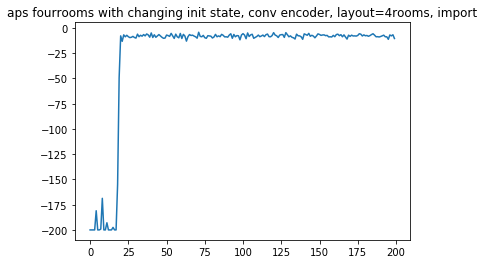

In [56]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms with changing init state, conv encoder, layout=4rooms, import')

Text(0.5, 1.0, 'aps fourrooms with changing init state, conv encoder, layout=4rooms')

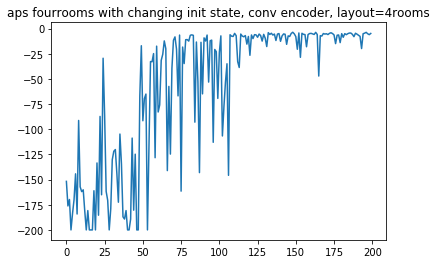

In [9]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms with changing init state, conv encoder, layout=4rooms')

In [18]:
from fourrooms import FourRooms
g = [21, 28, 84, 91]
c = np.ones(104)*4
room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
connect = [25, 51, 62, 88]
c[room1] = 1
c[room2] = 2
c[room3] = 3
c[connect] = [-1, -1, -1, -1]

device = torch.device('cuda')
env = FourRooms(layout='4rooms', config=2)
phi_all = np.zeros((104, 4))
for i in range(104):
    state = env.reset(init=i)
    state = torch.from_numpy(state).reshape(1, 13, 13).unsqueeze(0).float().to(device)
    # print(state.shape, aps.phi)
    out = aps.encoder(state)
    out = aps.phi(out)
    phi = out.detach().cpu().numpy()
    phi_all[i,:] = phi.flatten()


Text(0, 0.5, 'second principle component')

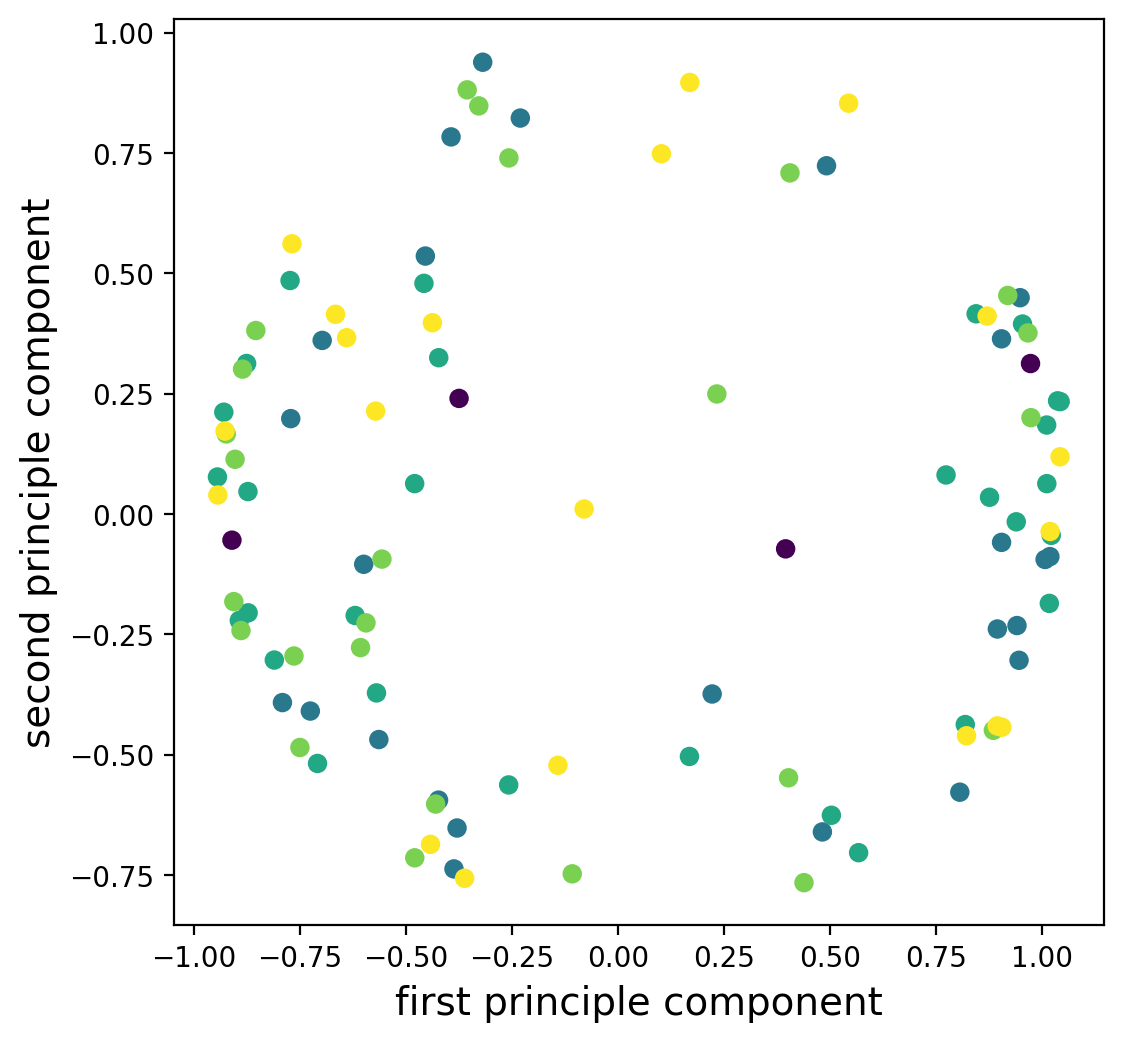

In [21]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=200)
pca = PCA(n_components=2)
k = pca.fit_transform(phi_all)
plt.scatter(k[:,0],k[:,1], c=c)
# plt.color_bar()
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)


Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=4rooms')

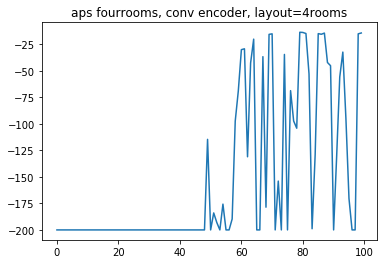

In [17]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=4rooms')

Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=open')

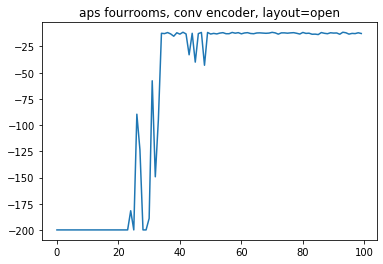

In [14]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=open')

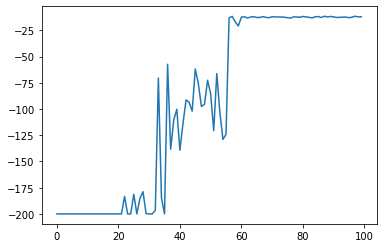

In [70]:
import matplotlib.pyplot as plt

plt.plot(evaluations, title='aps after pretraini')